In [43]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/smoker-status-prediction-using-biosignals/train_dataset.csv
/kaggle/input/smoker-status-prediction-using-biosignals/test_dataset.csv


In [44]:
from __future__ import print_function

import argparse, os, shutil, time, random, math
import numpy as np

import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.utils.data as data
import torch.nn.functional as F



bcl.py

In [45]:
"""
Author: Yonglong Tian (yonglong@mit.edu)
Date: May 07, 2020
"""
from __future__ import print_function

import torch
import torch.nn as nn
import math
import torch.nn.functional as F
import numpy as np



class BalSCL(nn.Module):
    def __init__(self, cls_num_list=None, temperature=0.1):
        super(BalSCL, self).__init__()
        self.temperature = temperature
        self.cls_num_list = cls_num_list

    def forward(self, centers1, features, targets, ):

        device = (torch.device('cuda')
                  if features.is_cuda
                  else torch.device('cpu'))
        batch_size = features.shape[0]
        targets = targets.contiguous().view(-1, 1)
        targets_centers = torch.arange(len(self.cls_num_list), device=device).view(-1, 1)
        targets = torch.cat([targets.repeat(2, 1), targets_centers], dim=0)
        batch_cls_count = torch.eye(len(self.cls_num_list))[targets].sum(dim=0).squeeze()

        mask = torch.eq(targets[:2 * batch_size], targets.T).float().to(device)
        logits_mask = torch.scatter(
            torch.ones_like(mask),
            1,
            torch.arange(batch_size * 2).view(-1, 1).to(device),
            0
        )
        mask = mask * logits_mask
        
        # class-complement
        features = torch.cat(torch.unbind(features, dim=1), dim=0)
        features = torch.cat([features, centers1], dim=0)
        logits = features[:2 * batch_size].mm(features.T)
        logits = torch.div(logits, self.temperature)

        # For numerical stability
        logits_max, _ = torch.max(logits, dim=1, keepdim=True)
        logits = logits - logits_max.detach()

        # class-averaging
        exp_logits = torch.exp(logits) * logits_mask
        per_ins_weight = torch.tensor([batch_cls_count[i] for i in targets], device=device).view(1, -1).expand(
            2 * batch_size, 2 * batch_size + len(self.cls_num_list)) - mask
        exp_logits_sum = exp_logits.div(per_ins_weight).sum(dim=1, keepdim=True)
        
        log_prob = logits - torch.log(exp_logits_sum)
        mean_log_prob_pos = (mask * log_prob).sum(1) / mask.sum(1)

        loss = - mean_log_prob_pos
        loss = loss.view(2, batch_size).mean()
        return loss




class LogitAdjust(nn.Module):

    def __init__(self, cls_num_list, tau=1, weight=None):
        super(LogitAdjust, self).__init__()
        cls_num_list = torch.cuda.FloatTensor(cls_num_list)
        cls_p_list = cls_num_list / cls_num_list.sum()
        m_list = tau * torch.log(cls_p_list)
        self.m_list = m_list.view(1, -1)
        self.weight = weight

    def forward(self, x, target):
        x_m = x + self.m_list
        return F.cross_entropy(x_m, target, weight=self.weight)


class BCLLoss(nn.Module):
    def __init__(self, cls_num_list, tau=1, weight=None, temperature = 0.1, alpha=2.0, beta=0.6 ):
        super(BCLLoss, self).__init__()
        self.criterion_ce = LogitAdjust(cls_num_list).cuda()
        self.criterion_scl = BalSCL(cls_num_list, temperature).cuda()
        self.alpha = alpha
        self.beta = beta
        
    def forward(self, centers,  logits, features, targets):
        scl_loss = self.criterion_scl(centers, features, targets)
        ce_loss = self.criterion_ce(logits, targets)

        return self.alpha * ce_loss + self.beta * scl_loss


        


bs.py

In [46]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F

class BS(nn.Module):
    def __init__(self, dist):
        super().__init__()
        dist = torch.from_numpy(np.array(dist)).float().cuda()
        self.prob = dist / sum(dist)
        self.log_prior = torch.log(self.prob).unsqueeze(0)
        
    def forward(self, logits, targets, epoch=None, reduction='mean'):
        adjusted_logits = logits + self.log_prior
        return F.cross_entropy(adjusted_logits, targets, reduction = reduction)
        
        
        # targets = F.one_hot(targets, num_classes=logits.size(1))
        # logits = logits + torch.log(self.prob.view(1, -1).expand(logits.shape[0], -1)).cuda()
        
        # if reduction == 'none':
        #     return -(torch.sum(F.log_softmax(logits, dim=1) * targets, dim=1))
        # else:
        #     return -torch.mean(torch.sum(F.log_softmax(logits, dim=1) * targets, dim=1))

ce drw

In [47]:
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np

class CE_DRW(nn.Module):
    
    def __init__(self, cls_num_list, reweight_epoch=160):
        super(CE_DRW, self).__init__()
        self.cls_num_list = cls_num_list
        self.reweight_epoch= reweight_epoch
        
    def drw(self, epoch):
        idx = epoch // self.reweight_epoch
        betas = [0, 0.9999]
        effective_num = 1.0 - np.power(betas[idx], self.cls_num_list)
        per_cls_weights = (1.0 - betas[idx]) / np.array(effective_num)
        per_cls_weights = per_cls_weights / np.sum(per_cls_weights) * len(self.cls_num_list)
        per_cls_weights = torch.FloatTensor(per_cls_weights).cuda()
        self.weight = per_cls_weights

    def forward(self, x, target, epoch, reduction='mean'):
        self.drw(epoch)
        return F.cross_entropy(x, target, weight=self.weight, reduction=reduction)

ce

In [48]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class CE(nn.Module):
    def __init__(self, weight=None):
        super().__init__()
        self.weight = weight
    def forward(self, logits, targets, epoch=None, reduction='mean'):
        # targets = F.one_hot(targets, num_classes=logits.size(1))
        # if reduction == 'mean':
        #     return -torch.mean(torch.sum(F.log_softmax(logits, dim=1) * targets, dim=1))
        # else:
        #     return -(torch.sum(F.log_softmax(logits, dim=1) * targets, dim=1))

        return F.cross_entropy(logits, targets, weight = self.weight, reduction = reduction)

ldam drw

In [49]:
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np

class LDAM_DRW(nn.Module):
    def __init__(self, cls_num_list, reweight_epoch, max_m=0.5, s=30):
        super(LDAM_DRW, self).__init__()
        self.cls_num_list = cls_num_list
        self.reweight_epoch = reweight_epoch
        m_list = 1.0 / np.sqrt(np.sqrt(cls_num_list))
        m_list = m_list * (max_m / np.max(m_list))
        m_list = torch.cuda.FloatTensor(m_list)
        self.m_list = m_list
        assert s > 0
        self.s = s
      
    def drw(self, epoch):
        idx = epoch // self.reweight_epoch
        betas = [0, 0.9999]
        effective_num = 1.0 - np.power(betas[idx], self.cls_num_list)
        per_cls_weights = (1.0 - betas[idx]) / np.array(effective_num)
        per_cls_weights = per_cls_weights / np.sum(per_cls_weights) * len(self.cls_num_list)
        per_cls_weights = torch.FloatTensor(per_cls_weights).cuda()
        self.weight = per_cls_weights


    def forward(self, x, target, epoch=None, reduction='mean'):
        self.drw(epoch)
        index = torch.zeros_like(x, dtype=torch.uint8)
        index.scatter_(1, target.data.view(-1, 1), 1)
        
        index_float = index.type(torch.cuda.FloatTensor)
        batch_m = torch.matmul(self.m_list[None, :], index_float.transpose(0,1))
        batch_m = batch_m.view((-1, 1))
        x_m = x - batch_m
    
        output = torch.where(index, x_m, x)
        return F.cross_entropy(self.s*output, target, weight=self.weight, reduction=reduction)

ncl

In [50]:
import torch
import torch.nn as nn
from torch.nn import functional as F

def NBOD(inputs, factor):

    classifier_num = len(inputs)
    if classifier_num == 1:
        return 0
    logits_softmax = []
    logits_logsoftmax = []
    for i in range(classifier_num):
        logits_softmax.append(F.softmax(inputs[i], dim=1))
        logits_logsoftmax.append(torch.log(logits_softmax[i] + 1e-9))

    loss_mutual = 0
    for i in range(classifier_num):
        for j in range(classifier_num):
            if i == j:
                continue
            loss_mutual += factor * F.kl_div(logits_logsoftmax[i], logits_softmax[j],reduction='batchmean')
    loss_mutual /= (classifier_num - 1)
    return  loss_mutual

class NIL_NBOD(nn.Module):
    def __init__(self, args, num_class_list):
        super(NIL_NBOD, self).__init__()
        self.args = args
        self.num_class_list = num_class_list
        self.bsce_weight = torch.FloatTensor(self.num_class_list).cuda()


        self.multi_classifier_diversity_factor = 0.6
        self.multi_classifier_diversity_factor_hcm = 0.6
        self.ce_ratio = 1.0
        self.hcm_ratio = 1.0
        if self.args.dataset == 'cifar100':
            self.hcm_N = 30
        elif self.args.dataset == 'imgnet':
            self.hcm_N = 300
        elif self.args.dataset == 'places':
            self.hcm_N = 122
        elif self.args.dataset == 'inat':
            self.hcm_N = 2442



    def forward(self, inputs, targets, **kwargs):
        """
        Args:
            inputs: prediction matrix (before softmax) with shape (classifier_num, batch_size, num_classes)
            targets: ground truth labels with shape (classifier_num, batch_size)
        """
        classifier_num = len(inputs)
        loss_HCM = 0
        loss = 0
        los_ce = 0

        inputs_HCM_balance = []
        inputs_balance = []
        class_select = inputs[0].scatter(1, targets[0].unsqueeze(1), 999999)
        class_select_include_target = class_select.sort(descending=True, dim=1)[1][:, :self.hcm_N]
        mask = torch.zeros_like(inputs[0]).scatter(1, class_select_include_target, 1)
        for i in range(classifier_num):

            logits = inputs[i] + self.bsce_weight.unsqueeze(0).expand(inputs[i].shape[0], -1).log()
            inputs_balance.append(logits)
            inputs_HCM_balance.append(logits * mask)

            los_ce += F.cross_entropy(logits, targets[0])
            loss_HCM += F.cross_entropy(inputs_HCM_balance[i], targets[0])

        loss += NBOD(inputs_balance, factor=self.multi_classifier_diversity_factor)
        loss += NBOD(inputs_HCM_balance, factor=self.multi_classifier_diversity_factor_hcm)
        loss += los_ce * self.ce_ratio + loss_HCM * self.hcm_ratio
        return loss

    def update(self, epoch):
        """
        Args:
           code can be added for progressive loss.
        """
        pass


if __name__ == '__main__':
    pass

ride

In [51]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np

import random

class RIDE(nn.Module):
    def __init__(self, cls_num_list=None, base_diversity_temperature=1.0, max_m=0.5, s=30, reweight=True, reweight_epoch=-1, 
        base_loss_factor=1.0, additional_diversity_factor=-0.2, reweight_factor=0.05):
        super().__init__()
        self.base_loss = F.cross_entropy
        self.base_loss_factor = base_loss_factor
        if not reweight:
            self.reweight_epoch = -1
        else:
            self.reweight_epoch = reweight_epoch

        # LDAM is a variant of cross entropy and we handle it with self.m_list.
        if cls_num_list is None:
            # No cls_num_list is provided, then we cannot adjust cross entropy with LDAM.

            self.m_list = None
            self.per_cls_weights_enabled = None
            self.per_cls_weights_enabled_diversity = None
        else:
            # We will use LDAM loss if we provide cls_num_list.

            m_list = 1.0 / np.sqrt(np.sqrt(cls_num_list))
            m_list = m_list * (max_m / np.max(m_list))
            m_list = torch.tensor(m_list, dtype=torch.float, requires_grad=False)
            self.m_list = m_list
            self.s = s
            assert s > 0
            
            if reweight_epoch != -1:
                idx = 1 # condition could be put in order to set idx
                betas = [0, 0.9999]
                effective_num = 1.0 - np.power(betas[idx], cls_num_list)
                per_cls_weights = (1.0 - betas[idx]) / np.array(effective_num)
                per_cls_weights = per_cls_weights / np.sum(per_cls_weights) * len(cls_num_list)
                self.per_cls_weights_enabled = torch.tensor(per_cls_weights, dtype=torch.float, requires_grad=False)
            else:
                self.per_cls_weights_enabled = None

            cls_num_list = np.array(cls_num_list) / np.sum(cls_num_list)
            C = len(cls_num_list)
            per_cls_weights = C * cls_num_list * reweight_factor + 1 - reweight_factor

            # Experimental normalization: This is for easier hyperparam tuning, the effect can be described in the learning rate so the math formulation keeps the same.
            # At the same time, the 1 - max trick that was previously used is not required since weights are already adjusted.
            per_cls_weights = per_cls_weights / np.max(per_cls_weights)

            assert np.all(per_cls_weights > 0), "reweight factor is too large: out of bounds"
            # save diversity per_cls_weights
            self.per_cls_weights_enabled_diversity = torch.tensor(per_cls_weights, dtype=torch.float, requires_grad=False).cuda()

        self.base_diversity_temperature = base_diversity_temperature
        self.additional_diversity_factor = additional_diversity_factor

    def to(self, device):
        super().to(device)
        if self.m_list is not None:
            self.m_list = self.m_list.to(device)
        
        if self.per_cls_weights_enabled is not None:
            self.per_cls_weights_enabled = self.per_cls_weights_enabled.to(device)

        if self.per_cls_weights_enabled_diversity is not None:
            self.per_cls_weights_enabled_diversity = self.per_cls_weights_enabled_diversity.to(device)

        return self

    def _hook_before_epoch(self, epoch):
        if self.reweight_epoch != -1:
            self.epoch = epoch

            if epoch > self.reweight_epoch:
                self.per_cls_weights_base = self.per_cls_weights_enabled
                self.per_cls_weights_diversity = self.per_cls_weights_enabled_diversity
            else:
                self.per_cls_weights_base = None
                self.per_cls_weights_diversity = None

    def get_final_output(self, output_logits, target):
        x = output_logits

        index = torch.zeros_like(x, dtype=torch.uint8, device=x.device)
        index.scatter_(1, target.data.view(-1, 1), 1)
        
        index_float = index.float()
        batch_m = torch.matmul(self.m_list[None, :], index_float.transpose(0,1))
        
        batch_m = batch_m.view((-1, 1))
        x_m = x - batch_m * self.s

        final_output = torch.where(index, x_m, x)
        return final_output

    def forward(self, output_logits, target, extra_info=None, reduction='mean'):
        if extra_info is None:
            return self.base_loss(output_logits, target)

        if reduction == 'none':
            loss = torch.zeros_like(target).float()
        else:
            loss = 0


        # Adding RIDE Individual Loss for each expert
        for logits_item in extra_info['logits']:
            ride_loss_logits = output_logits if self.additional_diversity_factor == 0 else logits_item
            if self.m_list is None:
                loss += self.base_loss_factor * self.base_loss(ride_loss_logits, target, reduction=reduction)
            else:
                final_output = self.get_final_output(ride_loss_logits, target)
                loss += self.base_loss_factor * self.base_loss(final_output, target, weight=self.per_cls_weights_base, reduction=reduction)
            
            base_diversity_temperature = self.base_diversity_temperature

            if self.per_cls_weights_diversity is not None:
                diversity_temperature = base_diversity_temperature * self.per_cls_weights_diversity.view((1, -1))
                temperature_mean = diversity_temperature.mean().item()
            else:
                diversity_temperature = base_diversity_temperature
                temperature_mean = base_diversity_temperature
            
            output_dist = F.log_softmax(logits_item / diversity_temperature, dim=1)
            with torch.no_grad():
                # Using the mean takes only linear instead of quadratic time in computing and has only a slight difference so using the mean is preferred here
                mean_output_dist = F.softmax(output_logits / diversity_temperature, dim=1)
            
            loss += self.additional_diversity_factor * temperature_mean * temperature_mean * F.kl_div(output_dist, mean_output_dist, reduction='batchmean')
        
        return loss

class RIDEWithDistill(nn.Module):
    def __init__(self, cls_num_list=None, additional_distill_loss_factor=1.0, distill_temperature=1.5, ride_loss_factor=1.0, **kwargs):
        super().__init__()
        self.ride_loss = RIDE(cls_num_list=cls_num_list, **kwargs)
        self.distill_temperature = distill_temperature

        self.ride_loss_factor = ride_loss_factor
        self.additional_distill_loss_factor = additional_distill_loss_factor

    def to(self, device):
        super().to(device)
        self.ride_loss = self.ride_loss.to(device)
        return self

    def _hook_before_epoch(self, epoch):
        self.ride_loss._hook_before_epoch(epoch)

    def forward(self, student, target=None, teacher=None, extra_info=None):
        output_logits = student
        if extra_info is None:
            return self.ride_loss(output_logits, target)

        loss = 0
        num_experts = len(extra_info['logits'])
        for logits_item in extra_info['logits']:
            loss += self.ride_loss_factor * self.ride_loss(output_logits, target, extra_info)
            distill_temperature = self.distill_temperature

            student_dist = F.log_softmax(student / distill_temperature, dim=1)
            with torch.no_grad():
                teacher_dist = F.softmax(teacher / distill_temperature, dim=1)
            
            distill_loss = F.kl_div(student_dist, teacher_dist, reduction='batchmean')
            distill_loss = distill_temperature * distill_temperature * distill_loss
            loss += self.additional_distill_loss_factor * distill_loss
        return loss

common.py


In [52]:
from __future__ import print_function

import argparse, os, shutil, random, math
import numpy as np

import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data as data
import torchvision.transforms as transforms
import torch.nn.functional as F

!pip install progress
# added on my own
import progress 
#end

from progress.bar import Bar as Bar

def make_imb_data(max_num, class_num, gamma):
    mu = np.power(1/gamma, 1/(class_num - 1))
    class_num_list = []
    for i in range(class_num):
        if i == (class_num - 1):
            class_num_list.append(int(max_num / gamma))
        else:
            class_num_list.append(int(max_num * np.power(mu, i)))
    print(class_num_list)
    return list(class_num_list)

def hms_string(sec_elapsed):
    h = int(sec_elapsed / (60 * 60))
    m = int((sec_elapsed % (60 * 60)) / 60)
    s = sec_elapsed % 60.
    return "{}:{:>02}:{:>05.2f}".format(h, m, s)

def save_checkpoint(state, epoch, checkpoint='none', filename='checkpoint.pth.tar'):
    filepath = os.path.join(checkpoint, filename)
    torch.save(state, filepath)
    
    if epoch % 100 == 0:
        shutil.copyfile(filepath, os.path.join(checkpoint, 'model_' + str(epoch) + '.pth.tar'))
        
def linear_rampup(current, rampup_length=0):
    if rampup_length == 0:
        return 1.0
    else:
        current = np.clip(current / rampup_length, 0.0, 1.0)
        return float(current)
    
def adjust_learning_rate(optimizer, epoch, scheduler, args):
    if scheduler == None:
        if args.epochs == 200:
            epoch = epoch + 1
            if epoch <= args.warmup:
                lr = args.lr * epoch / args.warmup
            elif epoch > 180:
                lr = args.lr * args.lr_decay ** 2
            elif epoch > 160:
                lr = args.lr * args.lr_decay
            else:
                lr = args.lr

            for param_group in optimizer.param_groups:
                param_group['lr'] = lr
            return lr

        elif args.epochs == 400:
            if args.loss_fn == 'bcl':
                epoch = epoch + 1
                if epoch <= args.warmup:
                    lr = args.lr * epoch / args.warmup
                elif epoch > 380:
                    lr = args.lr * args.lr_decay ** 2
                elif epoch > 360:
                    lr = args.lr * args.lr_decay
                else:
                    lr = args.lr

                for param_group in optimizer.param_groups:
                    param_group['lr'] = lr
                return lr
            else:
                epoch = epoch + 1
                if epoch <= args.warmup:
                    lr = args.lr * epoch / args.warmup
                elif epoch > 360:
                    lr = args.lr * args.lr_decay ** 2
                elif epoch > 320:
                    lr = args.lr * args.lr_decay
                else:
                    lr = args.lr

                for param_group in optimizer.param_groups:
                    param_group['lr'] = lr
                return lr
        else:
            return args.lr
    else:
        scheduler.step()
        return optimizer.param_groups[0]['lr']
    

loss.py

In [53]:
import torch
import torch.optim as optim
from bisect import bisect_right



#from utils.common import adjust_learning_rate

from torch.optim import lr_scheduler

def get_optimizer(args, model):
    _model = model['model'] if args.loss_fn == 'ncl' else model
    return optim.SGD(_model.parameters(), lr=args.lr, momentum=args.momentum, weight_decay=args.wd,
                     nesterov=args.nesterov)

def get_scheduler(args, optimizer):
    if args.scheduler == 'cosine':
        return lr_scheduler.CosineAnnealingLR(optimizer, args.epochs, eta_min = 0)
    elif args.scheduler == 'warmup':
        return None

def get_loss(args, N_SAMPLES_PER_CLASS):
    if args.loss_fn == 'ce':
        train_criterion = CE()
    elif args.loss_fn == 'ce_drw':
        train_criterion = CE_DRW(cls_num_list=N_SAMPLES_PER_CLASS, reweight_epoch=160)
    elif args.loss_fn == 'bs':
        train_criterion = BS(N_SAMPLES_PER_CLASS)
    elif args.loss_fn == 'ldam_drw':
        train_criterion = LDAM_DRW(cls_num_list=N_SAMPLES_PER_CLASS, reweight_epoch=160, max_m=0.5, s=30).cuda()
    elif args.loss_fn == 'ride':
        if args.num_experts == 3 and args.ride_distill:
            train_criterion = RIDEWithDistill(cls_num_list=N_SAMPLES_PER_CLASS, additional_diversity_factor=-0.45, reweight=True, reweight_epoch=160)
        else:
            train_criterion = RIDE(cls_num_list=N_SAMPLES_PER_CLASS, additional_diversity_factor=-0.45, reweight=True, reweight_epoch=160)
        train_criterion = train_criterion.to(torch.device('cuda'))
    elif args.loss_fn == 'ncl':
        train_criterion = NIL_NBOD(args, N_SAMPLES_PER_CLASS)

    elif args.loss_fn == 'bcl':
        train_criterion = BCLLoss(N_SAMPLES_PER_CLASS)

    else:
        raise NotImplementedError
        

    return train_criterion



cuda.py

In [54]:
import torch as t
import torchvision
import torchvision.transforms as transforms
import numpy as np
from torch.utils.data.dataset import Dataset

import random
import PIL, PIL.ImageOps, PIL.ImageEnhance, PIL.ImageDraw
import numpy as np
import torch
from PIL import Image

def CUDA(img,m,n, rand=True, max_d=30):
    _augment_list = augment_list()
    ops = random.choices(_augment_list, k=n)
    m = float(m) / max_d
    for op, minval, maxval in ops:
        val = (float(m)) * float(maxval - minval) + minval
        img = op(img, val)
    return img

def Flip(img, _):
    return PIL.ImageOps.flip(img)

def Mirror(img, _):
    return PIL.ImageOps.mirror(img)

def EdgeEnhance(img, _):
    return img.filter(PIL.ImageFilter.EDGE_ENHANCE)

def Detail(img, _):
    return img.filter(PIL.ImageFilter.DETAIL)

def Smooth(img, _):
    return img.filter(PIL.ImageFilter.SMOOTH)
    
def AutoContrast(img, _):
    return PIL.ImageOps.autocontrast(img)

def Equalize(img, _):
    return PIL.ImageOps.equalize(img)

def Invert(img, _):
    return PIL.ImageOps.invert(img)

def GaussianBlur(img, v):
    # assert 0 <= v <= 5
    filter = PIL.ImageFilter.GaussianBlur(v)
    return img.filter(filter)

def ResizeCrop(img, v):
    # assert 1 <= v <= 2
    width, height = img.size
    enlarge = img.resize((int(width*v), int(height*v)), Image.ANTIALIAS)
    left = int(width*v)//2 - width//2
    right = int(width*v)//2 + width//2
    top = int(height*v)//2 - height//2
    bottom = int(height*v)//2 + height//2
    return enlarge.crop((left, top, right, bottom))

def Rotate(img, v):  # [-30, 30]
    # assert -30 <= v <= 30
    if random.random() > 0.5:
        v = -v
    return img.rotate(v)

def Posterize(img, v):  # [4, 8]
    v = int(v)
    v = max(1, v)
    return PIL.ImageOps.posterize(img, v)

def Solarize(img, v):  # [0, 256]
    # assert 0 <= v <= 256
    return PIL.ImageOps.solarize(img, v)

def SolarizeAdd(img, addition=0, threshold=128):
    img_np = np.array(img).astype(int)
    img_np = img_np + addition
    img_np = np.clip(img_np, 0, 255)
    img_np = img_np.astype(np.uint8)
    img = Image.fromarray(img_np)
    return PIL.ImageOps.solarize(img, threshold)

def Color(img, v):  # [0.1,1.9]
    # assert 0.1 <= v <= 1.9
    return PIL.ImageEnhance.Color(img).enhance(v)

def Contrast(img, v):  # [0.1,1.9]ƒ
    # assert 0.1 <= v <= 1.9
    return PIL.ImageEnhance.Contrast(img).enhance(v)

def Brightness(img, v):  # [0.1,1.9]
    # assert 0.1 <= v <= 1.9
    return PIL.ImageEnhance.Brightness(img).enhance(v)

def Sharpness(img, v):  # [0.1,1.9]
    # assert 0.1 <= v <= 1.9
    return PIL.ImageEnhance.Sharpness(img).enhance(v)

def ShearX(img, v):  # [-0.3, 0.3]
    # assert -0.3 <= v <= 0.3
    if random.random() > 0.5:
        v = -v
    return img.transform(img.size, PIL.Image.AFFINE, (1, v, 0, 0, 1, 0))

def ShearY(img, v):  # [-0.3, 0.3]
    # assert -0.3 <= v <= 0.3
    if random.random() > 0.5:
        v = -v
    return img.transform(img.size, PIL.Image.AFFINE, (1, 0, 0, v, 1, 0))

def TranslateXabs(img, v):  # [-150, 150] => percentage: [-0.45, 0.45]
    # assert 0 <= v
    if random.random() > 0.5:
        v = -v
    return img.transform(img.size, PIL.Image.AFFINE, (1, 0, v, 0, 1, 0))

def TranslateYabs(img, v):  # [-150, 150] => percentage: [-0.45, 0.45]
    # assert 0 <= v
    if random.random() > 0.5:
        v = -v
    return img.transform(img.size, PIL.Image.AFFINE, (1, 0, 0, 0, 1, v))

def augment_list():  
    l = [
        (Flip, 0, 1),
        (Mirror, 0, 1),
        (EdgeEnhance, 0, 1),
        (Detail, 0, 1),
        (Smooth, 0, 1),
        (AutoContrast, 0, 1),
        (Equalize, 0, 1),
        (Invert, 0, 1),
        (GaussianBlur, 0, 2),
        (ResizeCrop,1, 1.5),
        (Rotate, 0, 30),
        (Posterize, 0, 4),
        (Solarize, 0, 256),
        (SolarizeAdd, 0, 110),
        (Color, 0.1, 1.9),
        (Contrast, 0.1, 1.9),
        (Brightness, 0.1, 1.9),
        (Sharpness, 0.1, 1.9),
        (ShearX, 0., 0.3),
        (ShearY, 0., 0.3),
        (TranslateXabs, 0., 100),
        (TranslateYabs, 0., 100),
    ]

    

    return l



autoaug.py


In [55]:
from PIL import Image, ImageEnhance, ImageOps
import numpy as np
import random
import torch



class Cutout(object):
    def __init__(self, n_holes, length):
        self.n_holes = n_holes
        self.length = length

    def __call__(self, img):
        h = img.size(1)
        w = img.size(2)

        mask = np.ones((h, w), np.float32)

        for n in range(self.n_holes):
            y = np.random.randint(h)
            x = np.random.randint(w)

            y1 = np.clip(y - self.length // 2, 0, h)
            y2 = np.clip(y + self.length // 2, 0, h)
            x1 = np.clip(x - self.length // 2, 0, w)
            x2 = np.clip(x + self.length // 2, 0, w)

            mask[y1: y2, x1: x2] = 0.

        mask = torch.from_numpy(mask)
        mask = mask.expand_as(img)
        img = img * mask

        return img

class ImageNetPolicy(object):
    """ Randomly choose one of the best 24 Sub-policies on ImageNet.
        Example:
        >>> policy = ImageNetPolicy()
        >>> transformed = policy(image)
        Example as a PyTorch Transform:
        >>> transform=transforms.Compose([
        >>>     transforms.Resize(256),
        >>>     ImageNetPolicy(),
        >>>     transforms.ToTensor()])
    """
    def __init__(self, fillcolor=(128, 128, 128)):
        self.policies = [
            SubPolicy(0.4, "posterize", 8, 0.6, "rotate", 9, fillcolor),
            SubPolicy(0.6, "solarize", 5, 0.6, "autocontrast", 5, fillcolor),
            SubPolicy(0.8, "equalize", 8, 0.6, "equalize", 3, fillcolor),
            SubPolicy(0.6, "posterize", 7, 0.6, "posterize", 6, fillcolor),
            SubPolicy(0.4, "equalize", 7, 0.2, "solarize", 4, fillcolor),

            SubPolicy(0.4, "equalize", 4, 0.8, "rotate", 8, fillcolor),
            SubPolicy(0.6, "solarize", 3, 0.6, "equalize", 7, fillcolor),
            SubPolicy(0.8, "posterize", 5, 1.0, "equalize", 2, fillcolor),
            SubPolicy(0.2, "rotate", 3, 0.6, "solarize", 8, fillcolor),
            SubPolicy(0.6, "equalize", 8, 0.4, "posterize", 6, fillcolor),

            SubPolicy(0.8, "rotate", 8, 0.4, "color", 0, fillcolor),
            SubPolicy(0.4, "rotate", 9, 0.6, "equalize", 2, fillcolor),
            SubPolicy(0.0, "equalize", 7, 0.8, "equalize", 8, fillcolor),
            SubPolicy(0.6, "invert", 4, 1.0, "equalize", 8, fillcolor),
            SubPolicy(0.6, "color", 4, 1.0, "contrast", 8, fillcolor),

            SubPolicy(0.8, "rotate", 8, 1.0, "color", 2, fillcolor),
            SubPolicy(0.8, "color", 8, 0.8, "solarize", 7, fillcolor),
            SubPolicy(0.4, "sharpness", 7, 0.6, "invert", 8, fillcolor),
            SubPolicy(0.6, "shearX", 5, 1.0, "equalize", 9, fillcolor),
            SubPolicy(0.4, "color", 0, 0.6, "equalize", 3, fillcolor),

            SubPolicy(0.4, "equalize", 7, 0.2, "solarize", 4, fillcolor),
            SubPolicy(0.6, "solarize", 5, 0.6, "autocontrast", 5, fillcolor),
            SubPolicy(0.6, "invert", 4, 1.0, "equalize", 8, fillcolor),
            SubPolicy(0.6, "color", 4, 1.0, "contrast", 8, fillcolor),
            SubPolicy(0.8, "equalize", 8, 0.6, "equalize", 3, fillcolor)
        ]


    def __call__(self, img):
        policy_idx = random.randint(0, len(self.policies) - 1)
        return self.policies[policy_idx](img)

    def __repr__(self):
        return "AutoAugment ImageNet Policy"


class CIFAR10Policy(object):
    """ Randomly choose one of the best 25 Sub-policies on CIFAR10.
        Example:
        >>> policy = CIFAR10Policy()
        >>> transformed = policy(image)
        Example as a PyTorch Transform:
        >>> transform=transforms.Compose([
        >>>     transforms.Resize(256),
        >>>     CIFAR10Policy(),
        >>>     transforms.ToTensor()])
    """
    def __init__(self, fillcolor=(128, 128, 128)):
        self.policies = [
            SubPolicy(0.1, "invert", 7, 0.2, "contrast", 6, fillcolor),
            SubPolicy(0.7, "rotate", 2, 0.3, "translateX", 9, fillcolor),
            SubPolicy(0.8, "sharpness", 1, 0.9, "sharpness", 3, fillcolor),
            SubPolicy(0.5, "shearY", 8, 0.7, "translateY", 9, fillcolor),
            SubPolicy(0.5, "autocontrast", 8, 0.9, "equalize", 2, fillcolor),

            SubPolicy(0.2, "shearY", 7, 0.3, "posterize", 7, fillcolor),
            SubPolicy(0.4, "color", 3, 0.6, "brightness", 7, fillcolor),
            SubPolicy(0.3, "sharpness", 9, 0.7, "brightness", 9, fillcolor),
            SubPolicy(0.6, "equalize", 5, 0.5, "equalize", 1, fillcolor),
            SubPolicy(0.6, "contrast", 7, 0.6, "sharpness", 5, fillcolor),

            SubPolicy(0.7, "color", 7, 0.5, "translateX", 8, fillcolor),
            SubPolicy(0.3, "equalize", 7, 0.4, "autocontrast", 8, fillcolor),
            SubPolicy(0.4, "translateY", 3, 0.2, "sharpness", 6, fillcolor),
            SubPolicy(0.9, "brightness", 6, 0.2, "color", 8, fillcolor),
            SubPolicy(0.5, "solarize", 2, 0.0, "invert", 3, fillcolor),

            SubPolicy(0.2, "equalize", 0, 0.6, "autocontrast", 0, fillcolor),
            SubPolicy(0.2, "equalize", 8, 0.6, "equalize", 4, fillcolor),
            SubPolicy(0.9, "color", 9, 0.6, "equalize", 6, fillcolor),
            SubPolicy(0.8, "autocontrast", 4, 0.2, "solarize", 8, fillcolor),
            SubPolicy(0.1, "brightness", 3, 0.7, "color", 0, fillcolor),

            SubPolicy(0.4, "solarize", 5, 0.9, "autocontrast", 3, fillcolor),
            SubPolicy(0.9, "translateY", 9, 0.7, "translateY", 9, fillcolor),
            SubPolicy(0.9, "autocontrast", 2, 0.8, "solarize", 3, fillcolor),
            SubPolicy(0.8, "equalize", 8, 0.1, "invert", 3, fillcolor),
            SubPolicy(0.7, "translateY", 9, 0.9, "autocontrast", 1, fillcolor)
        ]


    def __call__(self, img):
        policy_idx = random.randint(0, len(self.policies) - 1)
        return self.policies[policy_idx](img)

    def __repr__(self):
        return "AutoAugment CIFAR10 Policy"


class SVHNPolicy(object):
    """ Randomly choose one of the best 25 Sub-policies on SVHN.
        Example:
        >>> policy = SVHNPolicy()
        >>> transformed = policy(image)
        Example as a PyTorch Transform:
        >>> transform=transforms.Compose([
        >>>     transforms.Resize(256),
        >>>     SVHNPolicy(),
        >>>     transforms.ToTensor()])
    """
    def __init__(self, fillcolor=(128, 128, 128)):
        self.policies = [
            SubPolicy(0.9, "shearX", 4, 0.2, "invert", 3, fillcolor),
            SubPolicy(0.9, "shearY", 8, 0.7, "invert", 5, fillcolor),
            SubPolicy(0.6, "equalize", 5, 0.6, "solarize", 6, fillcolor),
            SubPolicy(0.9, "invert", 3, 0.6, "equalize", 3, fillcolor),
            SubPolicy(0.6, "equalize", 1, 0.9, "rotate", 3, fillcolor),

            SubPolicy(0.9, "shearX", 4, 0.8, "autocontrast", 3, fillcolor),
            SubPolicy(0.9, "shearY", 8, 0.4, "invert", 5, fillcolor),
            SubPolicy(0.9, "shearY", 5, 0.2, "solarize", 6, fillcolor),
            SubPolicy(0.9, "invert", 6, 0.8, "autocontrast", 1, fillcolor),
            SubPolicy(0.6, "equalize", 3, 0.9, "rotate", 3, fillcolor),

            SubPolicy(0.9, "shearX", 4, 0.3, "solarize", 3, fillcolor),
            SubPolicy(0.8, "shearY", 8, 0.7, "invert", 4, fillcolor),
            SubPolicy(0.9, "equalize", 5, 0.6, "translateY", 6, fillcolor),
            SubPolicy(0.9, "invert", 4, 0.6, "equalize", 7, fillcolor),
            SubPolicy(0.3, "contrast", 3, 0.8, "rotate", 4, fillcolor),

            SubPolicy(0.8, "invert", 5, 0.0, "translateY", 2, fillcolor),
            SubPolicy(0.7, "shearY", 6, 0.4, "solarize", 8, fillcolor),
            SubPolicy(0.6, "invert", 4, 0.8, "rotate", 4, fillcolor),
            SubPolicy(0.3, "shearY", 7, 0.9, "translateX", 3, fillcolor),
            SubPolicy(0.1, "shearX", 6, 0.6, "invert", 5, fillcolor),

            SubPolicy(0.7, "solarize", 2, 0.6, "translateY", 7, fillcolor),
            SubPolicy(0.8, "shearY", 4, 0.8, "invert", 8, fillcolor),
            SubPolicy(0.7, "shearX", 9, 0.8, "translateY", 3, fillcolor),
            SubPolicy(0.8, "shearY", 5, 0.7, "autocontrast", 3, fillcolor),
            SubPolicy(0.7, "shearX", 2, 0.1, "invert", 5, fillcolor)
        ]


    def __call__(self, img):
        policy_idx = random.randint(0, len(self.policies) - 1)
        return self.policies[policy_idx](img)

    def __repr__(self):
        return "AutoAugment SVHN Policy"


class SubPolicy(object):
    def __init__(self, p1, operation1, magnitude_idx1, p2, operation2, magnitude_idx2, fillcolor=(128, 128, 128)):
        ranges = {
            "shearX": np.linspace(0, 0.3, 10),
            "shearY": np.linspace(0, 0.3, 10),
            "translateX": np.linspace(0, 150 / 331, 10),
            "translateY": np.linspace(0, 150 / 331, 10),
            "rotate": np.linspace(0, 30, 10),
            "color": np.linspace(0.0, 0.9, 10),
            "posterize": np.round(np.linspace(8, 4, 10), 0).astype(int),
            "solarize": np.linspace(256, 0, 10),
            "contrast": np.linspace(0.0, 0.9, 10),
            "sharpness": np.linspace(0.0, 0.9, 10),
            "brightness": np.linspace(0.0, 0.9, 10),
            "autocontrast": [0] * 10,
            "equalize": [0] * 10,
            "invert": [0] * 10
        }

        # from https://stackoverflow.com/questions/5252170/specify-image-filling-color-when-rotating-in-python-with-pil-and-setting-expand
        def rotate_with_fill(img, magnitude):
            rot = img.convert("RGBA").rotate(magnitude)
            return Image.composite(rot, Image.new("RGBA", rot.size, (128,) * 4), rot).convert(img.mode)

        func = {
            "shearX": lambda img, magnitude: img.transform(
                img.size, Image.AFFINE, (1, magnitude * random.choice([-1, 1]), 0, 0, 1, 0),
                Image.BICUBIC, fillcolor=fillcolor),
            "shearY": lambda img, magnitude: img.transform(
                img.size, Image.AFFINE, (1, 0, 0, magnitude * random.choice([-1, 1]), 1, 0),
                Image.BICUBIC, fillcolor=fillcolor),
            "translateX": lambda img, magnitude: img.transform(
                img.size, Image.AFFINE, (1, 0, magnitude * img.size[0] * random.choice([-1, 1]), 0, 1, 0),
                fillcolor=fillcolor),
            "translateY": lambda img, magnitude: img.transform(
                img.size, Image.AFFINE, (1, 0, 0, 0, 1, magnitude * img.size[1] * random.choice([-1, 1])),
                fillcolor=fillcolor),
            "rotate": lambda img, magnitude: rotate_with_fill(img, magnitude),
            "color": lambda img, magnitude: ImageEnhance.Color(img).enhance(1 + magnitude * random.choice([-1, 1])),
            "posterize": lambda img, magnitude: ImageOps.posterize(img, magnitude),
            "solarize": lambda img, magnitude: ImageOps.solarize(img, magnitude),
            "contrast": lambda img, magnitude: ImageEnhance.Contrast(img).enhance(
                1 + magnitude * random.choice([-1, 1])),
            "sharpness": lambda img, magnitude: ImageEnhance.Sharpness(img).enhance(
                1 + magnitude * random.choice([-1, 1])),
            "brightness": lambda img, magnitude: ImageEnhance.Brightness(img).enhance(
                1 + magnitude * random.choice([-1, 1])),
            "autocontrast": lambda img, magnitude: ImageOps.autocontrast(img),
            "equalize": lambda img, magnitude: ImageOps.equalize(img),
            "invert": lambda img, magnitude: ImageOps.invert(img)
        }

        self.p1 = p1
        self.operation1 = func[operation1]
        self.magnitude1 = ranges[operation1][magnitude_idx1]
        self.p2 = p2
        self.operation2 = func[operation2]
        self.magnitude2 = ranges[operation2][magnitude_idx2]


    def __call__(self, img):
        if random.random() < self.p1: img = self.operation1(img, self.magnitude1)
        if random.random() < self.p2: img = self.operation2(img, self.magnitude2)
        return img

randaug.py


In [56]:
# code in this file is adpated from rpmcruz/autoaugment
# https://github.com/rpmcruz/autoaugment/blob/master/transformations.py
import random

import PIL, PIL.ImageOps, PIL.ImageEnhance, PIL.ImageDraw
import numpy as np
import torch
from PIL import Image


def ShearX(img, v):  # [-0.3, 0.3]
    assert -0.3 <= v <= 0.3
    if random.random() > 0.5:
        v = -v
    return img.transform(img.size, PIL.Image.AFFINE, (1, v, 0, 0, 1, 0))


def ShearY(img, v):  # [-0.3, 0.3]
    assert -0.3 <= v <= 0.3
    if random.random() > 0.5:
        v = -v
    return img.transform(img.size, PIL.Image.AFFINE, (1, 0, 0, v, 1, 0))


def TranslateX(img, v):  # [-150, 150] => percentage: [-0.45, 0.45]
    assert -0.45 <= v <= 0.45
    if random.random() > 0.5:
        v = -v
    v = v * img.size[0]
    return img.transform(img.size, PIL.Image.AFFINE, (1, 0, v, 0, 1, 0))


def TranslateXabs(img, v):  # [-150, 150] => percentage: [-0.45, 0.45]
    assert 0 <= v
    if random.random() > 0.5:
        v = -v
    return img.transform(img.size, PIL.Image.AFFINE, (1, 0, v, 0, 1, 0))


def TranslateY(img, v):  # [-150, 150] => percentage: [-0.45, 0.45]
    assert -0.45 <= v <= 0.45
    if random.random() > 0.5:
        v = -v
    v = v * img.size[1]
    return img.transform(img.size, PIL.Image.AFFINE, (1, 0, 0, 0, 1, v))


def TranslateYabs(img, v):  # [-150, 150] => percentage: [-0.45, 0.45]
    assert 0 <= v
    if random.random() > 0.5:
        v = -v
    return img.transform(img.size, PIL.Image.AFFINE, (1, 0, 0, 0, 1, v))


def Rotate(img, v):  # [-30, 30]
    assert -30 <= v <= 30
    if random.random() > 0.5:
        v = -v
    return img.rotate(v)


def AutoContrast(img, _):
    return PIL.ImageOps.autocontrast(img)


def Invert(img, _):
    return PIL.ImageOps.invert(img)


def Equalize(img, _):
    return PIL.ImageOps.equalize(img)


def Flip(img, _):  # not from the paper
    return PIL.ImageOps.mirror(img)


def Solarize(img, v):  # [0, 256]
    assert 0 <= v <= 256
    return PIL.ImageOps.solarize(img, v)


def SolarizeAdd(img, addition=0, threshold=128):
    img_np = np.array(img).astype(int)
    img_np = img_np + addition
    img_np = np.clip(img_np, 0, 255)
    img_np = img_np.astype(np.uint8)
    img = Image.fromarray(img_np)
    return PIL.ImageOps.solarize(img, threshold)


def Posterize(img, v):  # [4, 8]
    v = int(v)
    v = max(1, v)
    return PIL.ImageOps.posterize(img, v)


def Contrast(img, v):  # [0.1,1.9]
    assert 0.1 <= v <= 1.9
    return PIL.ImageEnhance.Contrast(img).enhance(v)


def Color(img, v):  # [0.1,1.9]
    assert 0.1 <= v <= 1.9
    return PIL.ImageEnhance.Color(img).enhance(v)


def Brightness(img, v):  # [0.1,1.9]
    assert 0.1 <= v <= 1.9
    return PIL.ImageEnhance.Brightness(img).enhance(v)


def Sharpness(img, v):  # [0.1,1.9]
    assert 0.1 <= v <= 1.9
    return PIL.ImageEnhance.Sharpness(img).enhance(v)




def CutoutAbs(img, v):  # [0, 60] => percentage: [0, 0.2]
    # assert 0 <= v <= 20
    if v < 0:
        return img
    w, h = img.size
    x0 = np.random.uniform(w)
    y0 = np.random.uniform(h)

    x0 = int(max(0, x0 - v / 2.))
    y0 = int(max(0, y0 - v / 2.))
    x1 = min(w, x0 + v)
    y1 = min(h, y0 + v)

    xy = (x0, y0, x1, y1)
    color = (125, 123, 114)
    # color = (0, 0, 0)
    img = img.copy()
    PIL.ImageDraw.Draw(img).rectangle(xy, color)
    return img


def SamplePairing(imgs):  # [0, 0.4]
    def f(img1, v):
        i = np.random.choice(len(imgs))
        img2 = PIL.Image.fromarray(imgs[i])
        return PIL.Image.blend(img1, img2, v)

    return f


def Identity(img, v):
    return img


def augment_list():  # 16 oeprations and their ranges
    # https://github.com/google-research/uda/blob/master/image/randaugment/policies.py#L57
    # l = [
    #     (Identity, 0., 1.0),
    #     (ShearX, 0., 0.3),  # 0
    #     (ShearY, 0., 0.3),  # 1
    #     (TranslateX, 0., 0.33),  # 2
    #     (TranslateY, 0., 0.33),  # 3
    #     (Rotate, 0, 30),  # 4
    #     (AutoContrast, 0, 1),  # 5
    #     (Invert, 0, 1),  # 6
    #     (Equalize, 0, 1),  # 7
    #     (Solarize, 0, 110),  # 8
    #     (Posterize, 4, 8),  # 9
    #     # (Contrast, 0.1, 1.9),  # 10
    #     (Color, 0.1, 1.9),  # 11
    #     (Brightness, 0.1, 1.9),  # 12
    #     (Sharpness, 0.1, 1.9),  # 13
    #     # (Cutout, 0, 0.2),  # 14
    #     # (SamplePairing(imgs), 0, 0.4),  # 15
    # ]

    # https://github.com/tensorflow/tpu/blob/8462d083dd89489a79e3200bcc8d4063bf362186/models/official/efficientnet/autoaugment.py#L505
    l = [
        (AutoContrast, 0, 1),
        (Equalize, 0, 1),
        (Invert, 0, 1),
        (Rotate, 0, 30),
        (Posterize, 0, 4),
        (Solarize, 0, 256),
        (SolarizeAdd, 0, 110),
        (Color, 0.1, 1.9),
        (Contrast, 0.1, 1.9),
        (Brightness, 0.1, 1.9),
        (Sharpness, 0.1, 1.9),
        (ShearX, 0., 0.3),
        (ShearY, 0., 0.3),
        (CutoutAbs, 0, 40),
        (TranslateXabs, 0., 100),
        (TranslateYabs, 0., 100),
    ]

    return l


class Lighting(object):
    """Lighting noise(AlexNet - style PCA - based noise)"""

    def __init__(self, alphastd, eigval, eigvec):
        self.alphastd = alphastd
        self.eigval = torch.Tensor(eigval)
        self.eigvec = torch.Tensor(eigvec)

    def __call__(self, img):
        if self.alphastd == 0:
            return img

        alpha = img.new().resize_(3).normal_(0, self.alphastd)
        rgb = self.eigvec.type_as(img).clone() \
            .mul(alpha.view(1, 3).expand(3, 3)) \
            .mul(self.eigval.view(1, 3).expand(3, 3)) \
            .sum(1).squeeze()

        return img.add(rgb.view(3, 1, 1).expand_as(img))


class CutoutDefault(object):
    """
    Reference : https://github.com/quark0/darts/blob/master/cnn/utils.py
    """
    def __init__(self, length):
        self.length = length

    def __call__(self, img):
        h, w = img.size(1), img.size(2)
        mask = np.ones((h, w), np.float32)
        y = np.random.randint(h)
        x = np.random.randint(w)

        y1 = np.clip(y - self.length // 2, 0, h)
        y2 = np.clip(y + self.length // 2, 0, h)
        x1 = np.clip(x - self.length // 2, 0, w)
        x2 = np.clip(x + self.length // 2, 0, w)

        mask[y1: y2, x1: x2] = 0.
        mask = torch.from_numpy(mask)
        mask = mask.expand_as(img)
        img *= mask
        return img


class RandAugment:
    def __init__(self, n, m):
        self.n = n
        self.m = m      # [0, 30]
        self.augment_list = augment_list()

    def __call__(self, img):
        ops = random.choices(self.augment_list, k=self.n)
        for op, minval, maxval in ops:
            val = (float(self.m) / 30) * float(maxval - minval) + minval
            img = op(img, val)

        return img



cutout.py

In [57]:
import torch
import numpy as np



class Cutout(object):
    def __init__(self, n_holes, length):
        self.n_holes = n_holes
        self.length = length

    def __call__(self, img):
        h = img.size(1)
        w = img.size(2)

        mask = np.ones((h, w), np.float32)

        for n in range(self.n_holes):
            y = np.random.randint(h)
            x = np.random.randint(w)

            y1 = np.clip(y - self.length // 2, 0, h)
            y2 = np.clip(y + self.length // 2, 0, h)
            x1 = np.clip(x - self.length // 2, 0, w)
            x2 = np.clip(x + self.length // 2, 0, w)

            mask[y1: y2, x1: x2] = 0.

        mask = torch.from_numpy(mask)
        mask = mask.expand_as(img)
        img = img * mask

        return img
    

transformer.py

In [58]:
from torchvision.transforms import transforms
from PIL import ImageFilter
import random
#from aug.cutout import *

cifar10_mean = (0.4914, 0.4822, 0.4465)
cifar10_std = (0.2023, 0.1994, 0.2010)



class GaussianBlur(object):
    """Gaussian blur augmentation in SimCLR https://arxiv.org/abs/2002.05709"""

    def __init__(self, sigma=[.1, 2.]):
        self.sigma = sigma

    def __call__(self, x):
        sigma = random.uniform(self.sigma[0], self.sigma[1])
        x = x.filter(ImageFilter.GaussianBlur(radius=sigma))
        return x



def get_transform(loss_fn, cutout = False):
    # Augmentations.
    if loss_fn in ['ce', 'ldam_drw', 'bs', 'ce_drw', 'ride']:
        train_before = [
                transforms.RandomCrop(32, padding=4),
                transforms.RandomHorizontalFlip(),
            ]
        
        if cutout:
            train_after = [
                transforms.ToTensor(),
                Cutout(n_holes = 1, length = 16),
                transforms.Normalize(cifar10_mean, cifar10_std),
                ]
        else:
            train_after = [
                transforms.ToTensor(),
                transforms.Normalize(cifar10_mean, cifar10_std),
                ]

        transform_train = [[transforms.Compose(train_before), transforms.Compose(train_after)]]

    elif loss_fn in ['ncl']:
        regular_train_before = [
            transforms.RandomCrop(32, padding=4),
            transforms.RandomHorizontalFlip(),
            ]

        if cutout:
            regular_train_after = [
                transforms.ToTensor(),
                Cutout(n_holes = 1, length = 16),
                transforms.Normalize(cifar10_mean, cifar10_std),
                ]
        else:
            regular_train_after = [
                transforms.ToTensor(),
                transforms.Normalize(cifar10_mean, cifar10_std),
                ]


        sim_cifar_before = [
            transforms.RandomResizedCrop(size=32, scale=(0.2, 1.)),
            transforms.RandomHorizontalFlip(),
            transforms.RandomApply([
                transforms.ColorJitter(0.4, 0.4, 0.4, 0.1)
            ], p=0.8),
            transforms.RandomGrayscale(p=0.2),
            transforms.RandomApply([GaussianBlur([.1, 2.])], p=0.5),
            ]
        sim_cifar_after = [
            transforms.ToTensor(),
            transforms.Normalize(cifar10_mean, cifar10_std),
            ]
        transform_train = [
            [transforms.Compose(regular_train_before), 
            transforms.Compose(regular_train_after)], 
            [transforms.Compose(sim_cifar_before), 
            transforms.Compose(sim_cifar_after)],
            ]


    
    elif loss_fn in ['bcl']:
        regular_train_before = [
            transforms.RandomCrop(32, padding=4),
            transforms.RandomHorizontalFlip(),
            ]

        if cutout:
            regular_train_after = [
                transforms.ToTensor(),
                Cutout(n_holes = 1, length = 16),
                transforms.Normalize(cifar10_mean, cifar10_std),
                ]
        else:
            regular_train_after = [
                transforms.ToTensor(),
                transforms.Normalize(cifar10_mean, cifar10_std),
                ]
        
        sim_cifar_before = [
            transforms.RandomResizedCrop(size=32, scale=(0.2, 1.)),
            transforms.RandomHorizontalFlip(),
            transforms.RandomApply([
                transforms.ColorJitter(0.4, 0.4, 0.4, 0.1)
            ], p=0.8),
            transforms.RandomGrayscale(p=0.2),
            transforms.RandomApply([GaussianBlur([.1, 2.])], p=0.5),
            ]
        sim_cifar_after = [
            transforms.ToTensor(),
            transforms.Normalize(cifar10_mean, cifar10_std),
            ]

        transform_train = [
            [transforms.Compose(regular_train_before), 
            transforms.Compose(regular_train_after)], 
            [transforms.Compose(sim_cifar_before), 
            transforms.Compose(sim_cifar_after)], 
            [transforms.Compose(sim_cifar_before), 
            transforms.Compose(sim_cifar_after)],
            ]

    transform_val = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(cifar10_mean, cifar10_std)
    ])
    
    return transform_train, transform_val
    





cifar100.py


In [59]:
import numpy as np
from PIL import Image
import random

import torchvision
import torch

from torch.utils.data import Dataset

from torchvision.transforms import transforms



    
def get_cifar100(root, args):
    transform_train, transform_val = get_transform(args.loss_fn, cutout = args.cutout)

    train_dataset = CIFAR100_train(root, args, imb_ratio = args.imb_ratio, train=True, transform = transform_train, aug_prob=args.aug_prob)
    test_dataset = CIFAR100_val(root, transform=transform_val)
    print (f"#Train: {len(train_dataset)}, #Test: {len(test_dataset)}")
    return train_dataset, test_dataset
    
class test_CIFAR100(Dataset):
    def __init__(self, indices, state, cifar_dataset):
        self.indices = indices
        self.state = state
        self.dataset = cifar_dataset

    def __getitem__(self,idx):
        data, label, _ = self.dataset.get_item(self.indices[idx], self.state[idx], train=False)
        return data, label, self.indices[idx], self.state[idx]
    
    def __len__(self):
        return len(self.indices)

class CIFAR100_train(torchvision.datasets.CIFAR100):
    def __init__(self, root , args, aug_prob, imb_type='exp', imb_ratio=100, train=True, transform=None, target_transform=None, download=True):
        super(CIFAR100_train,self).__init__(root, train=train, transform=transform, target_transform = target_transform, download= download)

        np.random.seed(0)
        self.args = args
        self.cls_num = 100
        self.img_num_list = self.get_img_num_per_cls(self.cls_num, imb_type, 1./imb_ratio)
        self.transform_train = transform
        self.gen_imbalanced_data(self.img_num_list)
        

        if 'autoaug_cifar' in args.aug_type:
            print('autoaug_cifar')
            self.aug_transform = transforms.Compose([CIFAR10Policy()])
        elif 'autoaug_svhn' in args.aug_type:
            print('autoaug_svhn')
            self.aug_transform = transforms.Compose([SVHNPolicy()])
        elif 'autoaug_imagenet' in args.aug_type:
            print('autoaug_imagenet')
            self.aug_transform = transforms.Compose([ImageNetPolicy()])
        #elif 'dada_cifar' in args.aug_type:
            print('dada_cifar')
            self.aug_transform = transforms.Compose([dada_cifar()])
        #elif 'dada_imagenet' in args.aug_type:
            print('dada_imagenet')
            self.aug_transform = transforms.Compose([dada_imagenet()])
        #elif 'faa_cifar' in args.aug_type:
            print('faa_cifar')
            self.aug_transform = transforms.Compose([faa_cifar()])
        #elif 'faa_imagenet' in args.aug_type:
            print('faa_imagenet')
            self.aug_transform = transforms.Compose([faa_imagenet()])
        elif 'randaug' in args.aug_type:
            print('randaug')
            self.aug_transform = transforms.Compose([RandAugment(2, 14)])
        elif 'none' in args.aug_type:
            self.aug_transform = transforms.Compose([])
        else:
            raise NotImplementedError
        



        # max_mag = 10
        # max_ops = 10
        max_mag = 10
        max_ops = 10
        self.min_state = 0
        self.max_state = max(max_mag, max_ops) + 1
        
        states = torch.arange(self.min_state, self.max_state)
        if self.max_state == 1:
            self.ops = torch.tensor([0])
            self.mag = torch.tensor([0])
            
        elif max_mag > max_ops:
            self.ops = (states * max_ops / max_mag).ceil().int()
            self.mag = states.int()
        else:
            self.mag = (states * max_mag / max_ops).ceil().int()
            self.ops = states.int()
        
        print(f"Magnitude set = {self.mag}")
        print(f"Operation set = {self.ops}")

        self.curr_state = torch.zeros(len(self.data))
        self.score_tmp = torch.zeros((len(self.targets), self.max_state))
        self.num_test = torch.zeros((len(self.targets), self.max_state))
        self.aug_prob = aug_prob



    def get_img_num_per_cls(self, cls_num, imb_type, imb_factor):
        img_max = len(self.data) / cls_num
        img_num_per_cls = []
        if imb_type == 'exp':
            for cls_idx in range(cls_num):
                num = img_max * (imb_factor ** (cls_idx / (cls_num - 1.0)))
                img_num_per_cls.append(int(num))
        else:
            img_num_per_cls.extend([int(img_max)] * cls_num)
        return img_num_per_cls


    def gen_imbalanced_data(self, img_num_per_cls):
        new_data = []
        new_targets = []
        #changed from np.int64
        targets_np = np.array(self.targets, dtype=int)
        classes = np.unique(targets_np)
        # np.random.shuffle(classes)

        self.num_per_cls_dict = dict()
        for the_class, the_img_num in zip(classes, img_num_per_cls):
            self.num_per_cls_dict[the_class] = the_img_num
            idx = np.where(targets_np == the_class)[0]
            np.random.shuffle(idx)
            selec_idx = idx[:the_img_num]
            # print(selec_idx)
            new_data.append(self.data[selec_idx, ...])
            new_targets.extend([the_class, ] * the_img_num)
        new_data = np.vstack(new_data)
        self.data = new_data
        self.targets = new_targets

    def get_cls_num_list(self):
        cls_num_list = []
        for i in range(self.cls_num):
            cls_num_list.append(self.num_per_cls_dict[i])
        return cls_num_list

    def sim_aug(self, img, state, type):
        if type == 'cuda':
            return  CUDA(img, self.mag[state], self.ops[state], max_d = self.args.max_d)
        else:
            return img
        

    
    def get_item(self, index, state, train=True):
        img, target = self.data[index], self.targets[index]
        img = Image.fromarray(img)
        
        if train:
            if len(self.transform_train) == 1:
                img = self.transform_train[0][0](img)
                img = self.aug_transform(img)
                img = CUDA(img, self.mag[state], self.ops[state])
                img = self.transform_train[0][1](img)
                return img, target, index

            elif len(self.transform_train) == 2:
                img1 = self.transform_train[0][0](img)
                img1 = self.aug_transform(img1)
                img1 = CUDA(img1, self.mag[state], self.ops[state], max_d = self.args.max_d)
                img1 = self.transform_train[0][1](img1)

                img2 = self.transform_train[1][0](img)
                img2 = self.sim_aug(img2, state, self.args.sim_type)
                img2 = self.transform_train[1][1](img2)
                
                return (img1, img2), target, index
                
            elif len(self.transform_train) == 3:
                img1 = self.transform_train[0][0](img)
                img1 = self.aug_transform(img1)
                img1 = CUDA(img1, self.mag[state], self.ops[state], max_d = self.args.max_d)
                img1 = self.transform_train[0][1](img1)

                img2 = self.transform_train[1][0](img)
                img2 = self.sim_aug(img2, state, self.args.sim_type)
                img2 = self.transform_train[1][1](img2)
                
                img3 = self.transform_train[2][0](img)
                img3 = self.sim_aug(img3, state, self.args.sim_type)
                img3 = self.transform_train[2][1](img3)
                return (img1, img2, img3), target, index

        else:
            img = self.transform_train[0][0](img)
            img = self.aug_transform(img)
            img = CUDA(img, self.mag[state], self.ops[state], rand=False , max_d = self.args.max_d)
            img = self.transform_train[0][1](img)
            return img, target, index
        
    def __getitem__(self, index):
        state = self.curr_state[index].int() if torch.rand(1) < self.aug_prob else 0
        
        img, target, index = self.get_item(index, state, train=True)
        return img, target, index
    
    def update_scores(self, correct, index, state):
        for s in np.unique(state):
            pos = np.where(state == s)
            score_result = np.bincount(index[pos], correct[pos], len(self.score_tmp))
            num_test_result = np.bincount(index[pos], np.ones(len(index))[pos], len(self.score_tmp))
            self.score_tmp[:,s] += score_result
            self.num_test[:,s] += num_test_result
            

    def update(self):
        # Increase
        pos = torch.where((self.score_tmp == self.num_test) & (self.num_test != 0))
        self.curr_state[pos] += 1
        
        # Decrease
        pos = torch.where(self.score_tmp != self.num_test)
        self.curr_state[pos] -= 1
        
        
        self.curr_state = torch.clamp(self.curr_state, self.min_state, self.max_state-1)
        self.score_tmp *= 0
        self.num_test *= 0
        
    
class CIFAR100_val(torchvision.datasets.CIFAR100):
    def __init__(self, root, transform=None, indexs=None,
                 target_transform=None, download=True):
        super(CIFAR100_val, self).__init__(root, train=False, transform=transform, target_transform=target_transform,download=download)
        
        if indexs is not None:
            self.data = self.data[indexs]
            self.targets = np.array(self.targets)[indexs]
        self.data = [Image.fromarray(img) for img in self.data]
        
    def __getitem__(self, index):
        img, target = self.data[index], self.targets[index]
        if self.transform is not None:
            img = self.transform(img)
        if self.target_transform is not None:
            target = self.target_transform(target)
        return img, target, index

accuracy.py

In [60]:
from __future__ import print_function, absolute_import

import errno
import os
import sys
import time
import math

import torch.nn as nn
import torch.nn.init as init
from torch.autograd import Variable


__all__ = ['accuracy', 'AverageMeter']

def accuracy(output, target, topk=(1,)):
    """Computes the precision@k for the specified values of k"""
    maxk = max(topk)
    batch_size = target.size(0)

    _, pred = output.topk(maxk, 1, True, True)
    pred = pred.t()
    correct = pred.eq(target.reshape(1, -1).expand_as(pred))

    res = []
    for k in topk:
        correct_k = correct[:k].reshape(-1).float().sum(0)
        res.append(correct_k.mul_(100.0 / batch_size))
    return res


class AverageMeter(object):
    """Computes and stores the average and current value
       Imported from https://github.com/pytorch/examples/blob/master/imagenet/main.py#L247-L262
    """
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

cutmix.py

In [61]:
import torch
import numpy as np

def rand_bbox(size, lam):
    W = size[2]
    H = size[3]
    cut_rat = np.sqrt(1. - lam)
    cut_w = int(W * cut_rat)
    cut_h = int(H * cut_rat)

    # uniform
    cx = np.random.randint(W)
    cy = np.random.randint(H)

    bbx1 = np.clip(cx - cut_w // 2, 0, W)
    bby1 = np.clip(cy - cut_h // 2, 0, H)
    bbx2 = np.clip(cx + cut_w // 2, 0, W)
    bby2 = np.clip(cy + cut_h // 2, 0, H)

    return bbx1, bby1, bbx2, bby2

def cutmix(data_f, data_b):
    lam = np.random.beta(1., 1.)
    bbx1, bby1, bbx2, bby2 = rand_bbox(data_f.size(), lam)
    data_b[:, :, bbx1:bbx2, bby1:bby2] = data_f[:, :, bbx1:bbx2, bby1:bby2]
    lam = 1-((bbx2 - bbx1) * (bby2 - bby1) / (data_f.size()[2] * data_f.size()[3]))
    
    return data_b, torch.tensor(lam)

# def cutmix(data_aug, data, label, param, percent=1.0):
    # data = data_aug
    # sample_num = int(len(param)*percent)
    # argsort = torch.argsort(param,descending=True)
    # param /= torch.max(param)
    
    # candidate = argsort[:sample_num]
    
    # data_f = data[candidate]
    # label_f = label[candidate]
    # param_f = param[candidate]
    
    # back_perm = candidate[torch.randperm(len(candidate))]
    # data_b = data[back_perm]
    # label_b = label[back_perm]
    # param_b = param[back_perm]
    
    # # lam = torch.exp(param_f) / (torch.exp(param_f)+torch.exp(param_b))
    # lam = torch.tensor(np.random.beta(1.,1.,(sample_num,)))
    
    # size = data.size()
    # W = size[2]
    # H = size[3]
    # cut_rat = torch.sqrt(1. - lam)
    # cut_w = (cut_rat * W).int()
    # cut_h = (cut_rat * H).int()

    # # uniform
    # cx = torch.randint(0,W,(len(candidate),))
    # cy = torch.randint(0,H,(len(candidate),))

    # bbx1 = torch.clip(cx - cut_w // 2, 0, W)
    # bby1 = torch.clip(cy - cut_h // 2, 0, H)
    # bbx2 = torch.clip(cx + cut_w // 2, 0, W)
    # bby2 = torch.clip(cy + cut_h // 2, 0, H)
    
    # for idx in range(len(data_b)):
    #     data_b[idx, :, bbx1[idx]:bbx2[idx], bby1[idx]:bby2[idx]] = data_f[idx, :, bbx1[idx]:bbx2[idx], bby1[idx]:bby2[idx]]
    # data_aug[candidate] = data_b
    
    # label[candidate] = label_b
    # label_aug = torch.zeros(len(label),dtype=int)
    # label_aug[candidate] = label_f.cpu()

    # ret_lbd = torch.ones(len(label))
    # ret_lbd[candidate] -= ((bbx2 - bbx1) * (bby2 - bby1) / (W*H))

    # return data_aug, label, label_aug, ret_lbd

basetrain

In [62]:

from __future__ import print_function

import time
import numpy as np
import torch
import torch.nn as nn

#from aug.cutmix import *

#from utils.accuracy import AverageMeter
#from utils.common import Bar

import copy, time

#from datasets.cifar100 import test_CIFAR100
import random



def update_score_base(loader, model, n_samples_per_class, posthoc_la, num_test, accept_rate):
    model.eval()
    
    if posthoc_la:
        dist = torch.tensor(n_samples_per_class)
        prob = dist / dist.sum()
    
    curr_state = loader.dataset.curr_state
    max_state = torch.max(curr_state).int() + 1
    
    with torch.no_grad():
        n = num_test
        pos, state = [], []
        ''' 
        for s in range(max_state):
            entire_pos = torch.arange(len(loader.dataset.targets))
            _pos = random.choices(entire_pos.tolist(), k = n * (s+1)) 
            pos +=  _pos
            state += [s] * len(_pos)
        tmp_dataest = test_CIFAR100(pos,  state, loader.dataset)
        tmp_loader = torch.utils.data.DataLoader(tmp_dataest, batch_size = 128,             
                                                 shuffle=False, num_workers = 8)
        
        '''
        n = num_test
        pos, state = [], []
        for cidx in range(len(n_samples_per_class)):
            class_pos = torch.where(torch.tensor(loader.dataset.targets) == cidx)[0]
            max_state = loader.dataset.curr_state[class_pos[0]].int() 
            for s in range(max_state+1):
                _pos = random.choices(class_pos.tolist(), k = n * (s+1))
                pos += _pos 
                state += [s] * len(_pos)
 
        tmp_dataset = test_CIFAR100(pos, state, loader.dataset)
        tmp_loader = torch.utils.data.DataLoader(tmp_dataset, batch_size = 128, shuffle=False, num_workers=8)
        

        for batch_idx, data_tuple in enumerate(tmp_loader):
            data = data_tuple[0].cuda()
            label = data_tuple[1]
            idx = data_tuple[2]
            state = data_tuple[3]

            logit = model(data, output_type = None).cpu()

            if posthoc_la:
                logit = logit.cpu() - torch.log(prob.view(1, -1).expand(logit.shape[0],-1))

            correct = (logit.max(dim=1)[1] == label).int().detach().cpu()
            loader.dataset.update_scores(correct,idx, state)

    
    
    # loader.dataset.update()
    correct_sum_per_class = torch.zeros(len(n_samples_per_class))
    trial_sum_per_class = torch.zeros(len(n_samples_per_class))
    
    for cidx in range(len(n_samples_per_class)):
        class_pos = torch.where(torch.tensor(loader.dataset.targets) == cidx)[0]
        
        correct_sum_row = torch.sum(loader.dataset.score_tmp[class_pos], dim=0)
        trial_sum_row = torch.sum(loader.dataset.num_test[class_pos], dim=0)


        ratio = correct_sum_row / trial_sum_row 
        idx = loader.dataset.curr_state[class_pos][0].int() + 1
        condition = torch.sum((ratio[:idx] > accept_rate)) == idx 
        
        # if correct_sum == trial_sum:
        # if float(correct_sum) >= float(trial_sum * 0.6):
        if condition:
            loader.dataset.curr_state[class_pos] += 1
        else:
            loader.dataset.curr_state[class_pos] -= 1
    '''
    

    all_indices = torch.arange(len(loader.dataset.targets))
    correct_sum_all_classes = torch.sum(loader.dataset.score_tmp, dim=0)
    trial_sum_all_classes = torch.sum(loader.dataset.num_test, dim=0)

    ratio = correct_sum_all_classes / trial_sum_all_classes
    idx = loader.dataset.curr_state[0].int() + 1
    condition = torch.sum((ratio[:idx] > accept_rate)) == idx

    if condition:
            loader.dataset.curr_state[all_indices] += 1
    else:
            loader.dataset.curr_state[all_indices] -= 1
    '''
        
    loader.dataset.curr_state = loader.dataset.curr_state.clamp(loader.dataset.min_state, loader.dataset.max_state-1)
    loader.dataset.score_tmp *= 0
    loader.dataset.num_test *= 0


    # print(f'Max correct: {int(torch.max(correct_sum_per_class))} Max trial: {int(torch.max(trial_sum_per_class))}')
    
    # loader.dataset.update()
    model.train()
    
    # Debug
    curr_state = loader.dataset.curr_state
    
    label = loader.dataset.targets
    print(f'Max state: {int(torch.max(curr_state))} // Min state: {int(torch.min(curr_state))}')

    return curr_state, label


# def update_score_base(loader, model, n_samples_per_class, posthoc_la):
#     model.eval()
    
#     if posthoc_la:
#         dist = torch.tensor(n_samples_per_class)
#         prob = dist / dist.sum()
    
#     # curr_state= loader.dataset.curr_state
#     # max_state = torch.max(curr_state).int() + 1
    
#     with torch.no_grad():
#         # pos, state = [], []
            
#         # for s in range(max_state):
#         #     _pos = torch.where(curr_state >= s)[0]
#         #     pos_list = _pos.tolist() * (s+1) 
#         #     pos +=  pos_list
#         #     state += [s] * len(pos_list)
#         # tmp_dataest = test_CIFAR100(pos,  state, loader.dataset)
#         # tmp_loader = torch.utils.data.DataLoader(tmp_dataest, batch_size = 128,             
#         #                                         shuffle=False, num_workers = 8)
        
#         n = 10
#         pos, state = [], []
#         for cidx in range(len(n_samples_per_class)):
#             class_pos = torch.where(torch.tensor(loader.dataset.targets) == cidx)[0]
#             max_state = loader.dataset.curr_state[class_pos[0]].int() 
#             for s in range(max_state+1):
#                 _pos = random.choices(class_pos.tolist(), k = n * (s+1))
#                 pos += _pos 
#                 state += [s] * len(_pos)
 
#         tmp_dataset = test_CIFAR100(pos, state, loader.dataset)
#         tmp_loader = torch.utils.data.DataLoader(tmp_dataset, batch_size = 128, shuffle=False, num_workers=8)
        

#         for batch_idx, data_tuple in enumerate(tmp_loader):
#             data = data_tuple[0].cuda()
#             label = data_tuple[1]
#             idx = data_tuple[2]

#             logit = model(data, output_type = None).cpu()

#             if posthoc_la:
#                 logit = logit.cpu() - torch.log(prob.view(1, -1).expand(logit.shape[0],-1))

#             correct = (logit.max(dim=1)[1] == label).int().detach().cpu()
#             loader.dataset.update_scores(correct,idx)
#     print(f'Max correct: {int(torch.max(loader.dataset.score_tmp))} Max trial: {int(torch.max(loader.dataset.num_test))}')
    
#     # loader.dataset.update()
#     for cidx in range(len(n_samples_per_class)):
#         class_pos = torch.where(torch.tensor(loader.dataset.targets) == cidx)[0]
        
#         correct_sum = torch.sum(loader.dataset.score_tmp[class_pos])
#         trial_sum = torch.sum(loader.dataset.num_test[class_pos])

#         # if correct_sum == trial_sum:
#         if float(correct_sum) >= float(trial_sum * 0.8):
#             loader.dataset.curr_state[class_pos] += 1
#         else:
#             loader.dataset.curr_state[class_pos] -= 1

#     loader.dataset.curr_state = loader.dataset.curr_state.clamp(loader.dataset.min_state, loader.dataset.max_state-1)
#     loader.dataset.score_tmp *= 0
#     loader.dataset.num_test *= 0




#     model.train()
    
#     # Debug
#     curr_state = loader.dataset.curr_state
#     label = loader.dataset.targets
#     print(f'Max state: {int(torch.max(curr_state))} // Min state: {int(torch.min(curr_state))}')

#     return curr_state, label





def train_base(args, trainloader, model, optimizer, criterion, epoch, weighted_trainloader, teacher = None):
    model.train()
    
    batch_time = AverageMeter()
    data_time = AverageMeter()
    losses = AverageMeter()
    end = time.time()
    
    bar = Bar('Training', max=len(trainloader))

    if args.cmo and 3 < epoch < (args.epochs - 3):
        inverse_iter = iter(weighted_trainloader)

        
    for batch_idx, data_tuple in enumerate(trainloader):
        inputs_b = data_tuple[0]
        targets_b = data_tuple[1]
        indexs = data_tuple[2]


        # Measure data loading
        data_time.update(time.time() - end)
        batch_size = targets_b.size(0)
        
        if args.cmo and 3 < epoch < (args.epochs - 3):
            try:
                data_tuple_f = next(inverse_iter)
            except:
                inverse_iter = iter(weighted_trainloader)
                data_tuple_f = next(inverse_iter)

            inputs_f = data_tuple_f[0]
            targets_f = data_tuple_f[1]
            inputs_f = inputs_f[:len(inputs_b)]
            targets_f = targets_f[:len(targets_b)]
            inputs_f = inputs_f.cuda(non_blocking=True)
            targets_f = targets_f.cuda(non_blocking=True)

        inputs_b = inputs_b.cuda(non_blocking=True)
        targets_b = targets_b.cuda(non_blocking=True)


        r = np.random.rand(1)
        if args.cmo and 3 < epoch < (args.epochs - 3) and r < 0.5:
            inputs_b, lam = cutmix(inputs_f, inputs_b)
            outputs = model(inputs_b, None)
            loss = criterion(outputs, targets_b, epoch) * lam + criterion(outputs, targets_f, epoch) * (1.-lam)
        else:
            outputs = model(inputs_b, None)
            loss = criterion(outputs, targets_b, epoch)
        
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # record
        losses.update(loss.item(), targets_b.size(0))
        batch_time.update(time.time() - end)
        end = time.time()
        
        # plot
        bar.suffix  = '({batch}/{size}) Data: {data:.3f}s | Batch: {bt:.3f}s | Total: {total:} | ETA: {eta:} | ' \
                      'Loss: {loss:.4f}'.format(
                    batch=batch_idx + 1,
                    size=len(trainloader),
                    data=data_time.avg,
                    bt=batch_time.avg,
                    total=bar.elapsed_td,
                    eta=bar.eta_td,
                    loss=losses.avg,
                    )
        bar.next()
    bar.finish()
    return losses.avg


bcltrain

In [63]:


from __future__ import print_function

import time
import numpy as np
import torch
import torch.nn as nn

#from aug.cutmix import *

#from utils.accuracy import AverageMeter
#from utils.common import Bar

import copy, time
import random

#from datasets.cifar100 import test_CIFAR100



def update_score_bcl(loader, model, n_samples_per_class, posthoc_la, num_test, accept_rate):
    model.eval()
    
    if posthoc_la:
        dist = torch.tensor(n_samples_per_class)
        prob = dist / dist.sum()
    
    # curr_state = loader.dataset.curr_state
    # max_state = torch.max(curr_state).int() + 1
    
    with torch.no_grad():
        # pos, state = [], []
            
        # for s in range(max_state):
        #     _pos = torch.where(curr_state >= s)[0]
        #     pos_list = _pos.tolist() * (s+1) 
        #     pos +=  pos_list
        #     state += [s] * len(pos_list)
        # tmp_dataest = test_CIFAR100(pos,  state, loader.dataset)
        # tmp_loader = torch.utils.data.DataLoader(tmp_dataest, batch_size = 128,             
        #                                         shuffle=False, num_workers = 8)
        
        n = num_test
        pos, state = [], []
        for cidx in range(len(n_samples_per_class)):
            class_pos = torch.where(torch.tensor(loader.dataset.targets) == cidx)[0]
            max_state = loader.dataset.curr_state[class_pos[0]].int() 
            for s in range(max_state+1):
                _pos = random.choices(class_pos.tolist(), k = n * (s+1))
                pos += _pos 
                state += [s] * len(_pos)
 
        
        tmp_dataset = test_CIFAR100(pos, state, loader.dataset)
        tmp_loader = torch.utils.data.DataLoader(tmp_dataset, batch_size = 128, shuffle=False, num_workers=8)

        for batch_idx, data_tuple in enumerate(tmp_loader):
            data = data_tuple[0].cuda()
            label = data_tuple[1]
            idx = data_tuple[2]
            state = data_tuple[3]

            _, logit, _ = model(data)
            
            if posthoc_la:
                logit = logit.cpu() - torch.log(prob.view(1, -1).expand(logit.shape[0],-1))

            correct = (logit.cpu().max(dim=1)[1] == label).int().detach().cpu()
            loader.dataset.update_scores(correct,idx, state)


            
    
    # loader.dataset.update()
    correct_sum_per_class = torch.zeros(len(n_samples_per_class))
    trial_sum_per_class = torch.zeros(len(n_samples_per_class))
    for cidx in range(len(n_samples_per_class)):
        class_pos = torch.where(torch.tensor(loader.dataset.targets) == cidx)[0]
        
        correct_sum_row = torch.sum(loader.dataset.score_tmp[class_pos], dim=0)
        trial_sum_row = torch.sum(loader.dataset.num_test[class_pos], dim=0)

        ratio = correct_sum_row / trial_sum_row 
        idx = loader.dataset.curr_state[class_pos][0].int() + 1
        condition = torch.sum((ratio[:idx] > accept_rate)) == idx
        
        # if correct_sum == trial_sum:
        # if float(correct_sum) >= float(trial_sum * 0.6):
        if condition:
            loader.dataset.curr_state[class_pos] += 1
        else:
            loader.dataset.curr_state[class_pos] -= 1
    
        

    loader.dataset.curr_state = loader.dataset.curr_state.clamp(loader.dataset.min_state, loader.dataset.max_state-1)
    loader.dataset.score_tmp *= 0
    loader.dataset.num_test *= 0

    # print(f'Max correct: {int(torch.max(loader.dataset.score_tmp))} Max trial: {int(torch.max(loader.dataset.num_test))}')
    # print(f'Max correct: {int(torch.max(correct_sum_per_class))} Max trial: {int(torch.max(trial_sum_per_class))}')
    
    
    # loader.dataset.update()
    model.train()
    
    # Debug
    curr_state = loader.dataset.curr_state
    label = loader.dataset.targets
    print(f'Max state: {int(torch.max(curr_state))} // Min state: {int(torch.min(curr_state))}')

    return curr_state, label





def train_bcl(args, trainloader, model, optimizer, criterion, epoch, weighted_trainloader, teacher = None):
    model.train()
    
    batch_time = AverageMeter()
    data_time = AverageMeter()
    losses = AverageMeter()
    end = time.time()
    
    bar = Bar('Training', max=len(trainloader))
        
    for batch_idx, data_tuple in enumerate(trainloader):
        inputs_b = data_tuple[0]
        targets_b = data_tuple[1]
        indexs = data_tuple[2]

        # Measure data loading
        data_time.update(time.time() - end)
        batch_size = targets_b.size(0)
        
        if args.cmo:
            raise "BCL not implemented for CMO..."
        else:
            inputs_b = torch.cat([inputs_b[0], inputs_b[1], inputs_b[2]], dim=0).cuda()
            batch_size = targets_b.shape[0]
            targets_b = targets_b.cuda()
            feat_mlp, logits, centers = model(inputs_b)
            centers = centers[:args.num_class]
            _, f2, f3 = torch.split(feat_mlp, [batch_size, batch_size, batch_size], dim=0)
            features = torch.cat([f2.unsqueeze(1), f3.unsqueeze(1)], dim=1)
            logits, _, __ = torch.split(logits, [batch_size, batch_size, batch_size], dim=0)
            loss = criterion(centers, logits, features, targets_b)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # record
        losses.update(loss.item(), targets_b.size(0))
        batch_time.update(time.time() - end)
        end = time.time()
        
        # plot
        bar.suffix  = '({batch}/{size}) Data: {data:.3f}s | Batch: {bt:.3f}s | Total: {total:} | ETA: {eta:} | ' \
                      'Loss: {loss:.4f}'.format(
                    batch=batch_idx + 1,
                    size=len(trainloader),
                    data=data_time.avg,
                    bt=batch_time.avg,
                    total=bar.elapsed_td,
                    eta=bar.eta_td,
                    loss=losses.avg,
                    )
        bar.next()
    bar.finish()
    return losses.avg


ncltrain

In [64]:

#from utils.accuracy import AverageMeter
import torch
import time
#from utils.common import Bar, adjust_learning_rate

import copy

#from datasets.cifar100 import test_CIFAR100
import random

def update_score_ncl(loader, model, n_samples_per_class, posthoc_la, num_test, accept_rate):
    model = model['model']
    model.eval()
     
    if posthoc_la:
        dist = torch.tensor(n_samples_per_class)
        prob = dist / dist.sum()
    
    
    # curr_state = loader.dataset.curr_state
    # max_state = torch.max(curr_state).int() + 1
    
    with torch.no_grad():
        # pos, state = [], []
            
        # for s in range(max_state):
        #     _pos = torch.where(curr_state >= s)[0]
        #     pos_list = _pos.tolist() * (s+1) 
        #     pos +=  pos_list
        #     state += [s] * len(pos_list)
        # tmp_dataest = test_CIFAR100(pos,  state, loader.dataset)
        # tmp_loader = torch.utils.data.DataLoader(tmp_dataest, batch_size = 128,   shuffle=False, num_workers = 8, drop_last=True)
        
        n = num_test
        pos, state = [], []
        for cidx in range(len(n_samples_per_class)):
            class_pos = torch.where(torch.tensor(loader.dataset.targets) == cidx)[0]
            max_state = loader.dataset.curr_state[class_pos[0]].int() 
            for s in range(max_state+1):
                _pos = random.choices(class_pos.tolist(), k = n * (s+1))
                pos += _pos 
                state += [s] * len(_pos)
 
        tmp_dataset = test_CIFAR100(pos, state, loader.dataset)
        tmp_loader = torch.utils.data.DataLoader(tmp_dataset, batch_size = 128, shuffle=False, num_workers=8)
        

        for batch_idx, data_tuple in enumerate(tmp_loader):
            data = data_tuple[0].cuda()
            label = data_tuple[1]
            idx = data_tuple[2]
            state = data_tuple[3]

            data_list = [data for i in range(model.network_num)]

            feature = model((data_list,data_list), label=label, feature_flag=True)
            output_ce, output, output_MA = model(feature, classifier_flag=True)
            logit = torch.mean(torch.stack(output_ce), dim=0).cpu()

            if posthoc_la:
                logit = logit.cpu() - torch.log(prob.view(1, -1).expand(logit.shape[0],-1)).cuda()

            correct = (logit.max(dim=1)[1] == label).int().detach().cpu()
            loader.dataset.update_scores(correct,idx, state)
    
    
 
    
    
    # loader.dataset.update()
    correct_sum_per_class = torch.zeros(len(n_samples_per_class))
    trial_sum_per_class = torch.zeros(len(n_samples_per_class))
    for cidx in range(len(n_samples_per_class)):
        class_pos = torch.where(torch.tensor(loader.dataset.targets) == cidx)[0]
        
        correct_sum_row = torch.sum(loader.dataset.score_tmp[class_pos], dim=0)
        trial_sum_row = torch.sum(loader.dataset.num_test[class_pos], dim=0)


        ratio = correct_sum_row / trial_sum_row 
        idx = loader.dataset.curr_state[class_pos][0].int() + 1
        condition = torch.sum((ratio[:idx] > accept_rate)) == idx 
        
        # if correct_sum == trial_sum:
        # if float(correct_sum) >= float(trial_sum * 0.6):
        if condition:
            loader.dataset.curr_state[class_pos] += 1
        else:
            loader.dataset.curr_state[class_pos] -= 1
    
        

    loader.dataset.curr_state = loader.dataset.curr_state.clamp(loader.dataset.min_state, loader.dataset.max_state-1)
    loader.dataset.score_tmp *= 0
    loader.dataset.num_test *= 0

    
    # print(f'Max correct: {int(torch.max(loader.dataset.score_tmp))} Max trial: {int(torch.max(loader.dataset.num_test))}')
    
    # loader.dataset.update()
    model.train()
    
    # Debug
    curr_state = loader.dataset.curr_state
    label = loader.dataset.targets
    print(f'Max state: {int(torch.max(curr_state))} // Min state: {int(torch.min(curr_state))}')

    return curr_state, label


def train_ncl(args, trainloader, model, optimizer, criterion, epoch, weighted_trainloader, teacher=None):
    combiner = model['comb']
    model = model['model']
    network_num = 3

    model.train()
    batch_time = AverageMeter()
    data_time = AverageMeter()
    losses = AverageMeter()
    end = time.time()

    bar = Bar('Training', max=len(trainloader))
    
    for batch_idx, data_tuple in enumerate(trainloader):
        inputs = data_tuple[0]
        targets = data_tuple[1]
        indexs = data_tuple[2]

        # Measure data loading
        data_time.update(time.time() - end)
        batch_size = targets.size(0)

        if args.cmo:
            raise "NCL not implemented for CMO..."
        else:
            image_list = [inputs] * network_num
            label_list = [targets] * network_num
            indexs_list = [indexs] * network_num

            loss = combiner.forward(model, criterion, image_list, label_list)

            if args.dataset in ['cifar100', 'places']:
                alpha = 0.999
                for net_id in range(network_num):
                    net = ['backbone', 'module']
                    for name in net:
                        for ema_param, param in zip(eval('model.' + name + '_MA').parameters(),
                                                    eval('model.' + name).parameters()):
                            ema_param.data.mul_(alpha).add_(1 - alpha, param.data)


        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        

        # record
        losses.update(loss.data.item(), targets.size(0))
        batch_time.update(time.time() - end)
        end = time.time()
        
        # plot
        bar.suffix  = '({batch}/{size}) Data: {data:.3f}s | Batch: {bt:.3f}s | Total: {total:} | ETA: {eta:} | ' \
                      'Loss: {loss:.4f}'.format(
                    batch=batch_idx + 1,
                    size=len(trainloader),
                    data=data_time.avg,
                    bt=batch_time.avg,
                    total=bar.elapsed_td,
                    eta=bar.eta_td,
                    loss=losses.avg,
                    )
        bar.next()
    bar.finish()
    return losses.avg



ridetrain

In [65]:
from __future__ import print_function

import time
import numpy as np
import torch
import torch.nn as nn

#from aug.cutmix import *

#from utils.accuracy import AverageMeter
#from utils.common import Bar, adjust_learning_rate

import copy

#from datasets.cifar100 import test_CIFAR100
import random

def update_score_ride(loader, model, n_samples_per_class, posthoc_la, num_test, accept_rate):
    model.eval()
    
    if posthoc_la:
        dist = torch.tensor(n_samples_per_class)
        prob = dist / dist.sum()
    
    curr_state = loader.dataset.curr_state
    max_state = torch.max(curr_state).int() + 1
    
    with torch.no_grad():
        n = num_test
        pos, state = [], []
            

    
    with torch.no_grad():
        pos, state = [], []
            
        # for s in range(max_state):
        #     _pos = torch.where(curr_state >= s)[0]
        #     pos_list = _pos.tolist() * (s+1) 
        #     pos +=  pos_list
        #     state += [s] * len(pos_list)
        # tmp_dataest = test_CIFAR100(pos,  state, loader.dataset)
        # tmp_loader = torch.utils.data.DataLoader(tmp_dataest, batch_size = 128,             
        #                                         shuffle=False, num_workers = 8)
        
        n = num_test
        pos, state = [], []
        
        
        for cidx in range(len(n_samples_per_class)):
            class_pos = torch.where(torch.tensor(loader.dataset.targets) == cidx)[0]
            max_state = loader.dataset.curr_state[class_pos[0]].int() 
            for s in range(max_state+1):
                _pos = random.choices(class_pos.tolist(), k = n * (s+1))
                pos += _pos 
                state += [s] * len(_pos)
        '''
        
        for s in range(max_state):
            entire_pos = torch.arange(len(loader.dataset.targets))
            _pos = random.choices(entire_pos.tolist(), k = n * (s+1)) 
            pos +=  _pos
            state += [s] * len(_pos)
        '''

        
        tmp_dataset = test_CIFAR100(pos, state, loader.dataset)
        tmp_loader = torch.utils.data.DataLoader(tmp_dataset, batch_size = 128, shuffle=False, num_workers=8)
        

        for batch_idx, data_tuple in enumerate(tmp_loader):
            data = data_tuple[0].cuda()
            label = data_tuple[1]
            idx = data_tuple[2]
            state = data_tuple[3]

            # logit = model(data, output_type = None).cpu()
            # if posthoc_la:
            #     logit = logit - tau * torch.log(prob.view(1, -1).expand(logit.shape[0],-1))
            # correct = (logit.max(dim=1)[1] == label).int().detach().cpu()

            outputs = model(data, output_type='dict')
            logit = outputs['logits'].cpu()

            for cor_idx in range(logit.size(1)):
                if cor_idx == 0:
                    correct = (logit[:,cor_idx].max(dim=1)[1] == label).int().detach().cpu()
                else:
                    correct += (logit[:,cor_idx].max(dim=1)[1] == label).int().detach().cpu()
            
            correct = torch.floor(correct/logit.size(1))
            loader.dataset.update_scores(correct,idx, state)
    '''
    all_indices = torch.arange(len(loader.dataset.targets))
    correct_sum_all_classes = torch.sum(loader.dataset.score_tmp, dim=0)
    trial_sum_all_classes = torch.sum(loader.dataset.num_test, dim=0)

    ratio = correct_sum_all_classes / trial_sum_all_classes
    idx = loader.dataset.curr_state[0].int() + 1
    condition = torch.sum((ratio[:idx] > accept_rate)) == idx

    if condition:
            loader.dataset.curr_state[all_indices] += 1
    else:
            loader.dataset.curr_state[all_indices] -= 1 
    
    '''
    # loader.dataset.update()
    correct_sum_per_class = torch.zeros(len(n_samples_per_class))
    trial_sum_per_class = torch.zeros(len(n_samples_per_class))
    for cidx in range(len(n_samples_per_class)):
        class_pos = torch.where(torch.tensor(loader.dataset.targets) == cidx)[0]
        
        correct_sum_row = torch.sum(loader.dataset.score_tmp[class_pos], dim=0)
        trial_sum_row = torch.sum(loader.dataset.num_test[class_pos], dim=0)


        ratio = correct_sum_row / trial_sum_row 
        idx = loader.dataset.curr_state[class_pos][0].int() + 1
        condition = torch.sum((ratio[:idx] > accept_rate)) == idx 
        
        # if correct_sum == trial_sum:
        # if float(correct_sum) >= float(trial_sum * 0.6):
        if condition:
            loader.dataset.curr_state[class_pos] += 1
        else:
            loader.dataset.curr_state[class_pos] -= 1
    
        

    loader.dataset.curr_state = loader.dataset.curr_state.clamp(loader.dataset.min_state, loader.dataset.max_state-1)
    loader.dataset.score_tmp *= 0
    loader.dataset.num_test *= 0

    # print(f'Max correct: {int(torch.max(loader.dataset.score_tmp))} Max trial: {int(torch.max(loader.dataset.num_test))}')
    

    # loader.dataset.update()
    model.train()
    
    # Debug
    curr_state = loader.dataset.curr_state
    label = loader.dataset.targets
    print(f'Max state: {int(torch.max(curr_state))} // Min state: {int(torch.min(curr_state))}')

    return curr_state, label



def ride_loss_wrap(criterion, student, teacher, target, extra_info):
    if teacher == None:
        return criterion(output_logits = student['output'], target = target, extra_info = extra_info)
    else:
        return criterion(student = student['output'], target = target, teacher = teacher, extra_info = extra_info)

def train_ride(args, trainloader, model, optimizer, criterion, epoch, weighted_trainloader, teacher):
    """
    Training logic for an epoch
    
    :param epoch: Integer, current training epoch.
    :return: A log that contains average loss and metric in this epoch.
    """
    model.train()
    
    batch_time = AverageMeter()
    data_time = AverageMeter()
    losses = AverageMeter()
    end = time.time()
    
    if hasattr(criterion, "_hook_before_epoch"):
        criterion._hook_before_epoch(epoch)
        
    bar = Bar('Training', max=len(trainloader))


    if args.cmo and 3 < epoch < (args.epochs-3):
        inverse_iter = iter(weighted_trainloader)

    for batch_idx, data_tuple in enumerate(trainloader):
        inputs_b = data_tuple[0]
        targets_b = data_tuple[1]
        indexs = data_tuple[2]
        
        # Measure data loading
        data_time.update(time.time() - end)
        batch_size = targets_b.size(0)
        
        if args.cmo and 3 < epoch < (args.epochs-3):
            try:
                data_tuple_f = next(inverse_iter)
            except:
                inverse_iter = iter(weighted_trainloader)
                data_tuple_f = next(inverse_iter)
                
            inputs_f = data_tuple_f[0]
            targets_f = data_tuple_f[1]
            inputs_f = inputs_f[:len(inputs_b)]
            targets_f = targets_f[:len(targets_b)]
            inputs_f = inputs_f.cuda(non_blocking=True)
            targets_f = targets_f.cuda(non_blocking=True)


        inputs_b = inputs_b.cuda(non_blocking=True)
        targets_b = targets_b.cuda(non_blocking=True)

        r = np.random.rand(1)
        if args.cmo and 3 < epoch < (args.epochs - 3) and r < 0.5:
            inputs_b, lam = cutmix(inputs_f, inputs_b)
            outputs =  model(inputs_b)
            extra_info = {}
            # logits = outputs["logits"]
            # extra_info.update({"logits" : logits.transpose(0,1)})
            # loss = criterion(output_logits = outputs['output'], target = targets_b, extra_info = extra_info) * lam + criterion(output_logits = outputs['output'], target = targets_f, extra_info = extra_info) * (1.-lam)
            if teacher == None:
                teacher_outputs = None
            else:
                teacher_outputs = teacher(inputs_b)['output']
            
            extra_info.update({"logits" : outputs['logits'].transpose(0,1)})
                
            loss = ride_loss_wrap(criterion, outputs, teacher_outputs, targets_b, extra_info) * lam + ride_loss_wrap(criterion, outputs, teacher_outputs, targets_f, extra_info) * (1.-lam)
            
            
        else:
            extra_info = {}
            outputs = model(inputs_b)
            # logits = outputs["logits"]
            # extra_info.update({"logits": logits.transpose(0, 1)})
            # loss = criterion(output_logits=outputs['output'], target=targets_b, extra_info=extra_info)
            
            if teacher == None:
                teacher_outputs = None
            else:
                teacher_outputs = teacher(inputs_b)['output']
            
            extra_info.update({"logits" : outputs['logits'].transpose(0,1)})
            loss = ride_loss_wrap(criterion, outputs, teacher_outputs, targets_b, extra_info)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # record
        losses.update(loss.item(), targets_b.size(0))
        batch_time.update(time.time() - end)
        end = time.time()
        
        # plot
        bar.suffix = '({batch}/{size}) Data: {data:.3f}s | Batch: {bt:.3f}s | Total: {total:} | ETA: {eta:} | ' \
                      'Loss: {loss:.4f}'.format(
                    batch=batch_idx + 1,
                    size=len(trainloader),
                    data=data_time.avg,
                    bt=batch_time.avg,
                    total=bar.elapsed_td,
                    eta=bar.eta_td,
                    loss=losses.avg,
                    )
        
        bar.next()
    bar.finish()
    return losses.avg



train.py

In [66]:
#from train.train_fn.base import train_base, update_score_base
#from train.train_fn.ride import train_ride, update_score_ride
#from train.train_fn.ncl import train_ncl, update_score_ncl
#from train.train_fn.bcl import train_bcl, update_score_bcl

def get_train_fn(args):
    if args.loss_fn == 'ride':
        return train_ride
    elif args.loss_fn == 'ncl':
        return train_ncl
    elif args.loss_fn == 'bcl':
        return train_bcl
    else:
        return train_base

        
        
def get_update_score_fn(args):
    if args.loss_fn == 'ride':
        return update_score_ride
    elif args.loss_fn == 'ncl':
        return update_score_ncl
    elif args.loss_fn == 'bcl':
        return update_score_bcl
    else:
        return update_score_base




validate.py

In [67]:
#from utils.accuracy import AverageMeter, accuracy
from scipy import optimize
#from utils.common import Bar
import torch
import numpy as np
import time

def get_valid_fn(args):
    if args.loss_fn == 'ncl':
        return valid_ncl
    elif args.loss_fn == 'bcl':
        return valid_bcl
    else:
        return valid_normal


def valid_ncl(args, valloader, model, criterion, per_class_num, num_class=10, mode='Test Stats'):
    combiner = model['comb']
    model = model['model']
    network_num = 3
    model.eval()
    network_num = 3
    cnt_all = 0
    every_network_result = [0 for _ in range(network_num)]


    batch_time = AverageMeter()
    data_time = AverageMeter()
    losses = AverageMeter()
    top1 = AverageMeter()
    top5 = AverageMeter()


    end = time.time()
    bar = Bar(f'{mode}', max=len(valloader))
    
    classwise_correct = torch.zeros(num_class)
    classwise_num = torch.zeros(num_class)
    section_acc = torch.zeros(3)
    
    
    with torch.no_grad():
        for batch_idx, data_tuple in enumerate(valloader):
            image = data_tuple[0]
            label = data_tuple[1]
            indexs = data_tuple[2]

            image, label = image.cuda(), label.cuda()
            image_list = [image for i in range(network_num)]

            if args.dataset in ['cifar100', 'places']:
                feature = model((image_list,image_list), label=label, feature_flag=True)
                output_ce, output, output_MA = model(feature, classifier_flag=True)
            else:
                feature = model(image_list, label=label, feature_flag=True)
                output_ce = model(feature, classifier_flag=True)


            
            for j, logit in enumerate(output_ce):
                every_network_result[j] += torch.sum(torch.argmax(logit, dim=1).cpu() == label.cpu())

            average_result = torch.mean(torch.stack(output_ce), dim=0)
            loss = criterion(average_result, label)

            prec1, prec5 = accuracy(average_result.cpu(), label.cpu(), topk=(1,5))
            losses.update(loss.data.item(), image.size(0))
            top1.update(prec1.item(), image.size(0))
            top5.update(prec5.item(), image.size(0))

            # classwise prediction
            pred_label = average_result.max(1)[1]
            pred_mask = (label == pred_label).float()
            for i in range(num_class):
                class_mask = (label == i).float()
                classwise_correct[i] += (class_mask * pred_mask).sum().detach().cpu()
                classwise_num[i] += class_mask.sum().detach().cpu()
                
            # measure elapsed time
            batch_time.update(time.time() - end)
            end = time.time()
                        
            # plot progress
            bar.suffix  = '({batch}/{size}) Data: {data:.3f}s | Batch: {bt:.3f}s | Total: {total:} | ETA: {eta:} | ' \
                          'Loss: {loss:.4f} | top1: {top1: .4f} | top5: {top5: .4f}'.format(
                        batch=batch_idx + 1,
                        size=len(valloader),
                        data=data_time.avg,
                        bt=batch_time.avg,
                        total=bar.elapsed_td,
                        eta=bar.eta_td,
                        loss=losses.avg,
                        top1=top1.avg,
                        top5=top5.avg,
                        )
            bar.next()
        bar.finish()
        
    # Major, Neutral, Minor
    classwise_acc = (classwise_correct / classwise_num)
    
    per_class_num = torch.tensor(per_class_num)
    many_pos = torch.where(per_class_num > 100)
    med_pos = torch.where((per_class_num <= 100) & (per_class_num >=20))
    few_pos = torch.where(per_class_num < 20)
    section_acc[0] = classwise_acc[many_pos].mean()
    section_acc[1] = classwise_acc[med_pos].mean()
    section_acc[2] = classwise_acc[few_pos].mean()
    
    return (losses.avg, top1.avg,  section_acc)

def valid_normal(args, valloader, model, criterion, per_class_num, num_class=10, mode='Test Stats', trainloader = None):

    batch_time = AverageMeter()
    data_time = AverageMeter()
    losses = AverageMeter()
    top1 = AverageMeter()
    top5 = AverageMeter()
    

    # switch to evaluate mode
    model.eval()

    end = time.time()
    bar = Bar(f'{mode}', max=len(valloader))
    
    classwise_correct = torch.zeros(num_class)
    classwise_num = torch.zeros(num_class)
    section_acc = torch.zeros(3)
    
    all_preds = np.zeros(len(valloader.dataset))
    with torch.no_grad():
        for batch_idx, data_tuple in enumerate(valloader):
            inputs = data_tuple[0].cuda(non_blocking=True)
            targets = data_tuple[1].cuda(non_blocking=True)
            indexs = data_tuple[2]
            
            # measure data loading time
            data_time.update(time.time() - end)
            
            # compute output
            outputs = model(inputs, None)
            loss = criterion(outputs, targets)

            # measure accuracy and record loss
            prec1, prec5 = accuracy(outputs, targets, topk=(1,5))
            losses.update(loss.item(), inputs.size(0))
            top1.update(prec1.item(), inputs.size(0))
            top5.update(prec5.item(), inputs.size(0))
            
            # classwise prediction
            pred_label = outputs.max(1)[1]
            all_preds[indexs] = pred_label.cpu().numpy()
                
            # measure elapsed time
            batch_time.update(time.time() - end)
            end = time.time()
                        
            # plot progress
            bar.suffix  = '({batch}/{size}) Data: {data:.3f}s | Batch: {bt:.3f}s | Total: {total:} | ETA: {eta:} | ' \
                          'Loss: {loss:.4f} | top1: {top1: .4f} | top5: {top5: .4f}'.format(
                        batch=batch_idx + 1,
                        size=len(valloader),
                        data=data_time.avg,
                        bt=batch_time.avg,
                        total=bar.elapsed_td,
                        eta=bar.eta_td,
                        loss=losses.avg,
                        top1=top1.avg,
                        top5=top5.avg,
                        )
            bar.next()
        bar.finish()
        # Major, Neutral, Minor
        
        all_targets = np.array(valloader.dataset.targets)
        pred_mask = (all_targets == all_preds).astype(float)
        for i in range(num_class):
            class_mask = np.where(all_targets == i)[0].reshape(-1)
            classwise_correct[i] += pred_mask[class_mask].sum()
            classwise_num[i] += len(class_mask)
            
        classwise_acc = (classwise_correct / classwise_num)
        
        per_class_num = torch.tensor(per_class_num)
        many_pos = torch.where(per_class_num > 100)
        med_pos = torch.where((per_class_num <= 100) & (per_class_num >=20))
        few_pos = torch.where(per_class_num < 20)
        section_acc[0] = classwise_acc[many_pos].mean()
        section_acc[1] = classwise_acc[med_pos].mean()
        section_acc[2] = classwise_acc[few_pos].mean()

    return (losses.avg, top1.avg,  section_acc)


def valid_bcl(args, valloader, model, criterion, per_class_num, num_class=10, mode='Test Stats', trainloader = None):

    batch_time = AverageMeter()
    data_time = AverageMeter()
    losses = AverageMeter()
    top1 = AverageMeter()
    top5 = AverageMeter()
    

    # switch to evaluate mode
    model.eval()

    end = time.time()
    bar = Bar(f'{mode}', max=len(valloader))
    
    classwise_correct = torch.zeros(num_class)
    classwise_num = torch.zeros(num_class)
    section_acc = torch.zeros(3)
    
    all_preds = np.zeros(len(valloader.dataset))
    with torch.no_grad():
        for batch_idx, data_tuple in enumerate(valloader):
            inputs = data_tuple[0].cuda(non_blocking=True)
            targets = data_tuple[1].cuda(non_blocking=True)
            indexs = data_tuple[2]
            
            # measure data loading time
            data_time.update(time.time() - end)
            
            # compute output
            _, outputs, _ = model(inputs)
            loss = criterion(outputs, targets)

            # measure accuracy and record loss
            prec1, prec5 = accuracy(outputs, targets, topk=(1,5))
            losses.update(loss.item(), inputs.size(0))
            top1.update(prec1.item(), inputs.size(0))
            top5.update(prec5.item(), inputs.size(0))
            
            # classwise prediction
            pred_label = outputs.max(1)[1]
            all_preds[indexs] = pred_label.cpu().numpy()
                
            # measure elapsed time
            batch_time.update(time.time() - end)
            end = time.time()
                        
            # plot progress
            bar.suffix  = '({batch}/{size}) Data: {data:.3f}s | Batch: {bt:.3f}s | Total: {total:} | ETA: {eta:} | ' \
                          'Loss: {loss:.4f} | top1: {top1: .4f} | top5: {top5: .4f}'.format(
                        batch=batch_idx + 1,
                        size=len(valloader),
                        data=data_time.avg,
                        bt=batch_time.avg,
                        total=bar.elapsed_td,
                        eta=bar.eta_td,
                        loss=losses.avg,
                        top1=top1.avg,
                        top5=top5.avg,
                        )
            bar.next()
        bar.finish()
        # Major, Neutral, Minor
        
        all_targets = np.array(valloader.dataset.targets)
        pred_mask = (all_targets == all_preds).astype(float)
        for i in range(num_class):
            class_mask = np.where(all_targets == i)[0].reshape(-1)
            classwise_correct[i] += pred_mask[class_mask].sum()
            classwise_num[i] += len(class_mask)
            
        classwise_acc = (classwise_correct / classwise_num)
        
        per_class_num = torch.tensor(per_class_num)
        many_pos = torch.where(per_class_num > 100)
        med_pos = torch.where((per_class_num <= 100) & (per_class_num >=20))
        few_pos = torch.where(per_class_num < 20)
        section_acc[0] = classwise_acc[many_pos].mean()
        section_acc[1] = classwise_acc[med_pos].mean()
        section_acc[2] = classwise_acc[few_pos].mean()

    return (losses.avg, top1.avg,  section_acc)


resnetbcl

In [68]:

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.init as init
from torch.nn import Parameter


def _weights_init(m):
    classname = m.__class__.__name__
    if isinstance(m, nn.Linear) or isinstance(m, nn.Conv2d):
        init.kaiming_normal_(m.weight)

class NormedLinear(nn.Module):
    def __init__(self, in_features, out_features):
        super(NormedLinear, self).__init__()
        self.weight = Parameter(torch.Tensor(in_features, out_features))
        self.weight.data.uniform_(-1, 1).renorm_(2, 1, 1e-5).mul_(1e5)
        self.apply(_weights_init)

    def forward(self, x):
        out = F.normalize(x, dim=1).mm(F.normalize(self.weight, dim=0))
        return out

class LambdaLayer(nn.Module):

    def __init__(self, lambd):
        super(LambdaLayer, self).__init__()
        self.lambd = lambd

    def forward(self, x):
        return self.lambd(x)


class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1, option='A'):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != planes:
            if option == 'A':
                """
                For CIFAR10 ResNet paper uses option A.
                """
                self.shortcut = LambdaLayer(lambda x:
                                            F.pad(x[:, :, ::2, ::2], (0, 0, 0, 0, planes//4, planes//4), "constant", 0))
            elif option == 'B':
                self.shortcut = nn.Sequential(
                     nn.Conv2d(in_planes, self.expansion * planes, kernel_size=1, stride=stride, bias=False),
                     nn.BatchNorm2d(self.expansion * planes)
                )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class ResNet_s(nn.Module):

    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet_s, self).__init__()
        self.in_planes = 16

        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(16)
        self.layer1 = self._make_layer(block, 16, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 32, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 64, num_blocks[2], stride=2)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion

        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = F.avg_pool2d(out, out.size()[3])
        out = out.view(out.size(0), -1)
        return out

class bcl_model(nn.Module):
    def __init__(self, num_classes=100, use_norm=False):
        super(bcl_model, self).__init__()
        self.encoder = ResNet_s(BasicBlock, [5,5,5], num_classes)
        dim_in = 64 #2048
        mid_dim = 512 #2048
        feat_dim = 128 #1024
        self.use_norm = use_norm
        self.head = nn.Sequential(nn.Linear(dim_in, mid_dim), nn.BatchNorm1d(mid_dim), nn.ReLU(inplace=True), nn.Linear(mid_dim, feat_dim))
        
        if self.use_norm:
            self.fc = NormedLinear(dim_in, num_classes)
        else:
            self.fc = nn.Linear(dim_in, num_classes)
        self.head_fc = nn.Sequential(nn.Linear(dim_in, mid_dim), nn.BatchNorm1d(mid_dim), nn.ReLU(inplace=True), nn.Linear(mid_dim, feat_dim))

        self.apply(_weights_init)


    def forward(self, x):
        feat = self.encoder(x)
        feat_mlp = F.normalize(self.head(feat), dim=1)
        logits = self.fc(feat)
        if self.use_norm:
            centers_logits = F.normalize(self.head_fc(self.fc.weight.T), dim=1)
        else:
            centers_logits = F.normalize(self.head_fc(self.fc.weight), dim=1)
        return feat_mlp, logits, centers_logits


resnetncl

In [69]:

# Copyright (c) Facebook, Inc. and its affiliates. All Rights Reserved
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.init as init

import numpy as np
import cv2
import os
import copy
import math
from torch.nn.parameter import Parameter



class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, inplanes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(
            inplanes, planes, kernel_size=3, padding=1, bias=False, stride=stride
        )
        self.bn1 = nn.BatchNorm2d(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(
            planes, planes, kernel_size=3, padding=1, bias=False, stride=1
        )
        self.bn2 = nn.BatchNorm2d(planes)
        # self.downsample = downsample
        if stride != 1 or self.expansion * planes != inplanes:
            self.downsample = nn.Sequential(
                nn.Conv2d(
                    inplanes,
                    self.expansion * planes,
                    kernel_size=1,
                    stride=stride,
                    bias=False,
                ),
                nn.BatchNorm2d(self.expansion * planes),
            )
        else:
            self.downsample = None

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out


class BottleNeck(nn.Module):

    expansion = 4

    def __init__(self, inplanes, planes, stride=1):
        super(BottleNeck, self).__init__()
        self.conv1 = nn.Conv2d(inplanes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.relu1 = nn.ReLU(True)
        self.conv2 = nn.Conv2d(
            planes, planes, kernel_size=3, stride=stride, padding=1, bias=False
        )
        self.bn2 = nn.BatchNorm2d(planes)
        self.relu2 = nn.ReLU(True)
        self.conv3 = nn.Conv2d(
            planes, planes * self.expansion, kernel_size=1, bias=False
        )
        self.bn3 = nn.BatchNorm2d(planes * self.expansion)
        if stride != 1 or self.expansion * planes != inplanes:
            self.downsample = nn.Sequential(
                nn.Conv2d(
                    inplanes,
                    self.expansion * planes,
                    kernel_size=1,
                    stride=stride,
                    bias=False,
                ),
                nn.BatchNorm2d(self.expansion * planes),
            )
        else:
            self.downsample = None
        self.relu = nn.ReLU(True)

    def forward(self, x):
        out = self.relu1(self.bn1(self.conv1(x)))

        out = self.relu2(self.bn2(self.conv2(out)))

        out = self.bn3(self.conv3(out))

        if self.downsample != None:
            residual = self.downsample(x)
        else:
            residual = x
        out = out + residual
        out = self.relu(out)
        return out

##kaiming init missing!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
class ResNet(nn.Module):
    def __init__(
        self,
        args,
        block_type,
        num_blocks,
        last_layer_stride=2,
    ):
        super(ResNet, self).__init__()
        self.inplanes = 64
        self.block = block_type
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(True)
        self.pool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.layer1 = self._make_layer(num_blocks[0], 64)
        self.layer2 = self._make_layer(
            num_blocks[1], 128, stride=2
        )
        self.layer3 = self._make_layer(
            num_blocks[2], 256, stride=2
        )
        self.layer4 = self._make_layer(
            num_blocks[3],
            512,
            stride=last_layer_stride,
        )

    def load_model(self, pretrain):
        print("Loading Backbone pretrain model from {}......".format(pretrain))
        model_dict = self.state_dict()
        pretrain_dict = torch.load(pretrain)
        pretrain_dict = pretrain_dict["state_dict"] if "state_dict" in pretrain_dict else pretrain_dict
        from collections import OrderedDict

        new_dict = OrderedDict()
        for k, v in pretrain_dict.items():
            if k.startswith("module"):
                k = k[7:]
            if "fc" not in k and "classifier" not in k:
                k = k.replace("backbone.", "")
                new_dict[k] = v

        model_dict.update(new_dict)
        self.load_state_dict(model_dict)
        print("Backbone model has been loaded......")

    def _make_layer(self, num_block, planes, stride=1):
        strides = [stride] + [1] * (num_block - 1)
        layers = []
        for now_stride in strides:
            layers.append(
                self.block(
                    self.inplanes, planes, stride=now_stride
                )
            )
            self.inplanes = planes * self.block.expansion
        return nn.Sequential(*layers)

    def forward(self, x, **kwargs):
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.pool(out)

        out = self.layer1(out)
        if 'layer' in kwargs and kwargs['layer'] == 'layer1':
            out = kwargs['coef']*out + (1-kwargs['coef'])*out[kwargs['index']]
        out = self.layer2(out)
        if 'layer' in kwargs and kwargs['layer'] == 'layer2':
            out = kwargs['coef']*out+(1-kwargs['coef'])*out[kwargs['index']]
        out = self.layer3(out)
        if 'layer' in kwargs and kwargs['layer'] == 'layer3':
            out = kwargs['coef']*out+(1-kwargs['coef'])*out[kwargs['index']]
        out = self.layer4(out)
        if 'layer' in kwargs and kwargs['layer'] == 'layer4':
            out = kwargs['coef']*out+(1-kwargs['coef'])*out[kwargs['index']]
        return out

def res50(args,last_layer_stride=2):
    return ResNet(args,BottleNeck,[3, 4, 6, 3],last_layer_stride=last_layer_stride)
    

def res152(args,last_layer_stride=2):
    return ResNet(args,BottleNeck,[3, 8, 36, 3],last_layer_stride=last_layer_stride)
    




def _weights_init(m):
    classname = m.__class__.__name__
    if isinstance(m, nn.Linear) or isinstance(m, nn.Conv2d):
        init.kaiming_normal_(m.weight)


class LambdaLayer(nn.Module):
    def __init__(self, lambd):
        super(LambdaLayer, self).__init__()
        self.lambd = lambd

    def forward(self, x):
        return self.lambd(x)


class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1, option="A"):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(
            in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False
        )
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(
            planes, planes, kernel_size=3, stride=1, padding=1, bias=False
        )
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != planes:
            if option == "A":
                """
                For CIFAR10 ResNet paper uses option A.
                """
                self.shortcut = LambdaLayer(
                    lambda x: F.pad(
                        x[:, :, ::2, ::2],
                        (0, 0, 0, 0, planes // 4, planes // 4),
                        "constant",
                        0,
                    )
                )
            elif option == "B":
                self.shortcut = nn.Sequential(
                    nn.Conv2d(
                        in_planes,
                        self.expansion * planes,
                        kernel_size=1,
                        stride=stride,
                        bias=False,
                    ),
                    nn.BatchNorm2d(self.expansion * planes),
                )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class ResNet_Cifar(nn.Module):
    def __init__(self, block, num_blocks):
        super(ResNet_Cifar, self).__init__()
        self.in_planes = 16

        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(16)
        self.layer1 = self._make_layer(block, 16, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 32, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 64, num_blocks[2], stride=2)
        self.apply(_weights_init)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1] * (num_blocks - 1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion

        return nn.Sequential(*layers)

    def load_model(self, pretrain):
        print("Loading Backbone pretrain model from {}......".format(pretrain))
        model_dict = self.state_dict()
        pretrain_dict = torch.load(pretrain)
        pretrain_dict = pretrain_dict["state_dict"] if "state_dict" in pretrain_dict else pretrain_dict
        from collections import OrderedDict

        new_dict = OrderedDict()
        for k, v in pretrain_dict.items():
            if k.startswith("module"):
                k = k[7:]
            if "last_linear" not in k and "classifier" not in k and "linear" not in k and "fd" not in k:
                k = k.replace("backbone.", "")
                k = k.replace("fr", "layer3.4")
                new_dict[k] = v
        model_dict.update(new_dict)
        self.load_state_dict(model_dict)
        print("Backbone model has been loaded......")

    def forward(self, x, **kwargs):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        if 'layer' in kwargs and kwargs['layer'] == 'layer1':
            out = kwargs['coef']*out + (1-kwargs['coef'])*out[kwargs['index']]
        out = self.layer2(out)
        if 'layer' in kwargs and kwargs['layer'] == 'layer2':
            out = kwargs['coef']*out+(1-kwargs['coef'])*out[kwargs['index']]
        out = self.layer3(out)
        if 'layer' in kwargs and kwargs['layer'] == 'layer3':
            out = kwargs['coef']*out+(1-kwargs['coef'])*out[kwargs['index']]
        return out

def res32_cifar(args,last_layer_stride):
    return ResNet_Cifar(BasicBlock, [5, 5, 5])
    



def ncl_model(args, num_class_list):
    if args.dataset in ['cifar100', 'places']:
        model = multi_Network_MOCO(args, mode="train", num_classes=args.num_class).cuda()
        comb = Combiner(args, num_class_list)
    else:
        model = multi_Network(args, mode="train", num_classes=args.num_class).cuda()
        comb = Combiner(args, num_class_list)
    return {'comb': comb, 'model': model}

class Combiner:
    def __init__(self, args, num_class_list=None):
        self.args = args

        if self.args.dataset in ['cifar100', 'places']:
            self.type = 'multi_network_default_CON'
        else:
            self.type = 'multi_network_default'
        
        self.num_class_list = torch.FloatTensor(num_class_list)
        self.epoch_number = self.args.epochs
        self.initilize_all_parameters()

    def initilize_all_parameters(self):

        if self.args.dataset == 'cifar100':
            self.show_step = 100
            self.CON_ratio = 1.0    
            self.distributed = False
        elif self.args.dataset == 'places':
            self.show_step = 200
            self.CON_ratio = 1.0    
            self.distributed = True
        elif self.args.dataset == 'imgnet':
            self.show_step = 200
            self.CON_ratio = 0.0
            self.distributed = True
        elif self.args.dataset == 'inat':
            self.show_step = 500
            self.CON_ratio = 0.0
            self.distributed = True

    def update(self, epoch):
        self.epoch = epoch


    def forward(self, model, criterion, image, label):
        return eval("self.{}".format(self.type))(model, criterion, image, label)


    def multi_network_default(self, model, criterion, image, label):

        for i in range(len(image)):
            image[i], label[i] = image[i].cuda(), label[i].cuda()


        feature = model(image, feature_flag=True, label=label)
        output = model(feature, classifier_flag=True)

        loss = criterion(output, label)

        average_result = torch.mean(torch.stack(output), dim=0)
        
        return loss

    def multi_network_default_CON(self, model, criterion, image, label):

        image_p = []
        image_k = []
        for i in range(len(image)):
            image_p.append(image[i][0].cuda())
            image_k.append(image[i][1].cuda())
            label[i] = label[i].cuda()

        # shuffle BN
        if self.distributed:
            image_k, idx_unshuffle = shuffle_BN_DDP(image_k)
            pass
        else:
            image_k, idx_unshuffle = shuffle_BN(image_k)


        feature = model((image_p, image_k), feature_flag=True, label=label)
        output_ce, output_p, output_k = model(feature, classifier_flag=True)

        # unshuffle
        if self.distributed:
            output_k = unshuffle_BN_DDP(output_k, idx_unshuffle)
        else:
            output_k = unshuffle_BN(output_k, idx_unshuffle)

        loss_ce = criterion(output_ce, label, feature=feature, classifier=model.classifier)

        average_result = torch.mean(torch.stack(output_ce), dim=0)
        
        # contrastive_loss
        loss_CON = 0
        for i, (q, k) in enumerate(zip(output_p, output_k)):
            q = F.normalize(q, dim=1)
            k = F.normalize(k, dim=1)
            # compute logits
            # Einstein sum is more intuitive
            # positive logits: Nx1
            l_pos = torch.einsum('nc,nc->n', [q, k]).unsqueeze(-1)
            # negative logits: NxK
            l_neg = torch.einsum('nc,ck->nk', [q, model.MOCO[i].queue.clone().detach()])

            # logits: Nx(1+K)
            logits = torch.cat([l_pos, l_neg], dim=1)

            # apply temperature
            logits /= model.MOCO[i].T

            # labels: positive key indicators
            labels = torch.zeros(logits.shape[0], dtype=torch.long).cuda()

            # dequeue and enqueue
            if self.distributed:
                model.MOCO[i]._dequeue_and_enqueue_DDP(k)
            else:
                model.MOCO[i]._dequeue_and_enqueue(k)


            loss_CON += F.cross_entropy(logits, labels)

        loss = loss_ce + loss_CON * self.CON_ratio

        return loss



class FCNorm(nn.Module):
    def __init__(self, num_features, num_classes):
        super(FCNorm, self).__init__()
        self.weight = nn.Parameter(torch.FloatTensor(num_classes, num_features))
        self.weight.data.uniform_(-1, 1).renorm_(2, 1, 1e-5).mul_(1e5)

    def forward(self, x):
        out = F.linear(F.normalize(x), F.normalize(self.weight))
        return out


class GAP(nn.Module):
    """Global Average pooling
        Widely used in ResNet, Inception, DenseNet, etc.
     """

    def __init__(self):
        super(GAP, self).__init__()
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))

    def forward(self, x):
        x = self.avgpool(x)
        #         x = x.view(x.shape[0], -1)
        return x

class Identity(nn.Module):
    def __init__(self):
        super(Identity, self).__init__()

    def forward(self, x):
        return x


@torch.no_grad()
def concat_all_gather(tensor):
    """
    Performs all_gather operation on the provided tensors.
    *** Warning ***: torch.distributed.all_gather has no gradient.
    """
    #with torch.no_grad():
    tensors_gather = [torch.ones_like(tensor)
        for _ in range(torch.distributed.get_world_size())]
    torch.distributed.all_gather(tensors_gather, tensor, async_op=False)

    output = torch.cat(tensors_gather, dim=0)
    return output

@torch.no_grad()
def shuffle_BN(image):
    #with torch.no_grad():
    batch_size = image[0].shape[0]
    idx_shuffle = torch.randperm(batch_size).cuda()
    for i in range(len(image)):
        image[i] = image[i][idx_shuffle]
    idx_unshuffle = torch.argsort(idx_shuffle)
    return image, idx_unshuffle

@torch.no_grad()
def shuffle_BN_DDP(x):
    """
    Batch shuffle, for making use of BatchNorm.
    *** Only support DistributedDataParallel (DDP) model. ***
    """
    # gather from all gpus

    #with torch.no_grad():
    shuffle_list = []
    idx_shuffle = 0
    for i in range(len(x)):
        batch_size_this = x[i].shape[0]
        x_gather = concat_all_gather(x[i])
        batch_size_all = x_gather.shape[0]

        num_gpus = batch_size_all // batch_size_this

        # random shuffle index
        if i == 0:
            idx_shuffle = torch.randperm(batch_size_all).cuda()
            # index for restoring
            idx_unshuffle = torch.argsort(idx_shuffle)

        # broadcast to all gpus
        torch.distributed.broadcast(idx_shuffle, src=0)



        # shuffled index for this gpu
        gpu_idx = torch.distributed.get_rank()
        idx_this = idx_shuffle.view(num_gpus, -1)[gpu_idx]
        shuffle_list.append(x_gather[idx_this])

    return shuffle_list, idx_unshuffle

@torch.no_grad()
def unshuffle_BN(x, idx_unshuffle):
    #with torch.no_grad():
    for i in range(len(x)):
        x[i] = x[i][idx_unshuffle]
    return x

@torch.no_grad()
def unshuffle_BN_DDP(x, idx_unshuffle):
    """
    Undo batch shuffle.
    *** Only support DistributedDataParallel (DDP) model. ***
    """
    # gather from all gpus
   # with torch.no_grad():
    unshuffle_list = []
    for i in range(len(x)):
        batch_size_this = x[i].shape[0]
        x_gather = concat_all_gather(x[i])
        batch_size_all = x_gather.shape[0]

        num_gpus = batch_size_all // batch_size_this

        # restored index for this gpu
        gpu_idx = torch.distributed.get_rank()
        idx_this = idx_unshuffle.view(num_gpus, -1)[gpu_idx]
        unshuffle_list.append(x_gather[idx_this])

    return unshuffle_list

class MoCo(nn.Module):
    """
    Build a MoCo model with: a query encoder, a key encoder, and a queue
    https://arxiv.org/abs/1911.05722
    """
    def __init__(self, dim=128, K=65536, m=0.999, T=0.07):
        """
        dim: feature dimension (default: 128)
        K: queue size; number of negative keys (default: 65536)
        m: moco momentum of updating key encoder (default: 0.999)
        T: softmax temperature (default: 0.07)
        """
        super(MoCo, self).__init__()

        self.K = K
        self.m = m
        self.T = T

        # create the queue
        self.register_buffer("queue", torch.randn(dim, K))
        self.queue = nn.functional.normalize(self.queue, dim=0)

        self.register_buffer("queue_ptr", torch.zeros(1, dtype=torch.long))



    @torch.no_grad()
    def _dequeue_and_enqueue_DDP(self, keys):
        # gather keys before updating queue
        keys = concat_all_gather(keys)

        batch_size = keys.shape[0]

        ptr = int(self.queue_ptr)

        assert self.K % batch_size == 0  # for simplicity

        # replace the keys at ptr (dequeue and enqueue)
        self.queue[:, ptr:ptr + batch_size] = keys.T
        ptr = (ptr + batch_size) % self.K  # move pointer

        self.queue_ptr[0] = ptr

    @torch.no_grad()
    def _dequeue_and_enqueue(self, keys, **kwargs):

        batch_size = keys.shape[0]

        ptr = int(self.queue_ptr)

        assert self.K % batch_size == 0  # for simplicity

        # replace the keys at ptr (dequeue and enqueue)
        self.queue[:, ptr:ptr + batch_size] = keys.T

        ptr = (ptr + batch_size) % self.K  # move pointer

        self.queue_ptr[0] = ptr

class Cos_Classifier(nn.Module):
    """ plain cosine classifier """

    def __init__(self, num_classes=10, in_dim=640, scale=16, bias=False):
        super(Cos_Classifier, self).__init__()
        self.scale = scale
        self.weight = Parameter(torch.Tensor(num_classes, in_dim).cuda())
        self.bias = Parameter(torch.Tensor(num_classes).cuda(), requires_grad=bias)
        self.init_weights()

    def init_weights(self):
        self.bias.data.fill_(0.)
        stdv = 1. / math.sqrt(self.weight.size(1))
        self.weight.data.uniform_(-stdv, stdv)

    def forward(self, x, **kwargs):
        ex = x / torch.norm(x.clone(), 2, 1, keepdim=True)
        ew = self.weight / torch.norm(self.weight, 2, 1, keepdim=True)
        out = torch.mm(ex, self.scale * ew.t()) + self.bias
        return out

class multi_Network(nn.Module):
    def __init__(self, args, mode="train", num_classes=1000):
        super(multi_Network, self).__init__()
        
        self.num_classes = num_classes
        self.args = args
        self.network_num = 3
        
        
        if self.args.dataset == 'cifar100':
            self.args.net_type = 'res32_cifar'
            self.args.cf = 'FC'
            self.args.cos_scale = 16
        elif self.args.dataset == 'imgnet':
            self.args.net_type = 'res50'
            self.args.cf = 'COS'
            self.args.cos_scale = 16
        elif self.args.dataset == 'inat':
            self.args.net_type = 'res50'
            self.args.cf = 'COS'
            self.args.cos_scale = 32
            

        self.backbone = nn.ModuleList(
            eval(self.args.net_type)(
                self.args,
                last_layer_stride=2,
            ) for i in range(self.network_num))

        self.module = nn.ModuleList(
            self._get_module()
            for i in range(self.network_num))

        
        self.classifier = nn.ModuleList(
            self._get_multi_classifer(True, self.cf)
            for i in range(self.network_num))

    def forward(self, input, **kwargs):

        if "feature_flag" in kwargs:
            return self.extract_feature(input, **kwargs)
        elif "classifier_flag" in kwargs:
            return self.get_logits(input, **kwargs)

        logits = []
        for i in range(self.network_num):
            x = (self.backbone[i])(input[i], **kwargs)
            x = (self.module[i])(x)
            x = x.view(x.shape[0], -1)
            self.feat.append(copy.deepcopy(x))
            x = (self.classifier[i])(x)
            logits.append(x)

        return logits

    def extract_feature(self, input, **kwargs):

        feature = []
        for i in range(self.network_num):
            x = (self.backbone[i])(input[i])
            x = (self.module[i])(x)
            x = x.view(x.shape[0], -1)
            feature.append(x)

        return feature

    def get_logits(self, input, **kwargs):

        logits = []
        for i in range(self.network_num):
            x = input[i]
            x = (self.classifier[i])(x)
            logits.append(x)

        return logits

    def extract_feature_maps(self, x):
        x = self.backbone(x)
        return x

    def freeze_multi_backbone(self):
        print("Freezing backbone .......")
        for p in self.backbone.parameters():
            p.requires_grad = False

    def load_backbone_model(self, backbone_path=""):
        self.backbone.load_model(backbone_path)
        print("Backbone model has been loaded...")

    def load_model(self, model_path, **kwargs):
        pretrain_dict = torch.load(
            model_path, map_location="cuda"
        )
        pretrain_dict = pretrain_dict['state_dict'] if 'state_dict' in pretrain_dict else pretrain_dict
        model_dict = self.state_dict()
        from collections import OrderedDict
        new_dict = OrderedDict()
        for k, v in pretrain_dict.items():
            if 'backbone_only' in kwargs.keys() and 'classifier' in k:
                continue;
            if k.startswith("module"):
                if k[7:] not in model_dict.keys():
                    print('not load:{}'.format(k))
                new_dict[k[7:]] = v
            else:
                new_dict[k] = v
        model_dict.update(new_dict)
        self.load_state_dict(model_dict)
        print("All model has been loaded...")

    def get_feature_length(self):
        if "cifar" in self.args.net_type:
            num_features = 64
        else:
            num_features = 2048
        return num_features

    def _get_module(self):
        module = GAP()
        return module

    def _get_multi_classifer(self, bias_flag, type):

        num_features = self.get_feature_length()
        if type == "FCNorm":
            classifier = FCNorm(num_features, self.num_classes)
        elif type == "FC":
            classifier = nn.Linear(num_features, self.num_classes, bias=bias_flag)
        elif type == 'cos':
            classifier = Cos_Classifier(self.num_classes, num_features, scale=self.args.cos_scale, bias=bias_flag)
        else:
            raise NotImplementedError

        return classifier

class multi_Network_MOCO(nn.Module):
    def __init__(self, args, mode="train", num_classes=1000):
        super(multi_Network_MOCO, self).__init__()
        
        self.args = args
        self.num_classes = num_classes
        self.network_num = 3
        
        if self.args.dataset == 'cifar100':
            self.args.net_type = 'res32_cifar'
            self.args.cf = 'FC'
            self.args.scf = 'mlp'
            self.args.cos_scale = 16
            self.args.moco_dim = 64
            self.args.mlp_dim = self.args.moco_dim
            self.args.moco_k = 1024
            self.args.moco_t = 0.2
        
        elif self.args.dataset == 'imgnet':
            self.args.net_type = 'res50'
            self.args.cf = 'COS'
            self.args.cos_scale = 16

        elif self.args.dataset == 'inat':
            self.args.net_type = 'res50'
            self.args.cf = 'COS'
            self.args.cos_scale = 32

        self.MOCO = nn.ModuleList(
            MoCo(dim=self.args.moco_dim, K=self.args.moco_k, T=self.args.moco_t)
            for i in range(self.network_num))


        self.backbone = nn.ModuleList(
            eval(self.args.net_type)(
                self.args,
                last_layer_stride=2,
            ) for i in range(self.network_num))


        self.module = nn.ModuleList(
            self._get_module()
            for i in range(self.network_num))

        
        self.classifier = nn.ModuleList(
            self._get_multi_classifer(True, self.args.scf)
            for i in range(self.network_num))
        self.feat = []

        self.backbone_MA = nn.ModuleList(
            eval(self.args.net_type)(
                self.args,
                last_layer_stride=2,
            ) for i in range(self.network_num))

        for i in range(self.network_num):
            for param in self.backbone_MA[i].parameters():
                param.detach_()

        self.module_MA = nn.ModuleList(
            self._get_module()
            for i in range(self.network_num))
        for i in range(self.network_num):
            for param in self.module_MA[i].parameters():
                param.detach_()

        
        self.classifier_MA = nn.ModuleList(
            self._get_multi_classifer(True, self.args.scf)
            for i in range(self.network_num))
        for i in range(self.network_num):
            for param in self.classifier_MA[i].parameters():
                param.detach_()
        self.feat_MA = []

        if self.args.cf == 'FC':
            self.classifier_ce = nn.ModuleList(
                nn.Linear(self.get_feature_length(), self.num_classes, True)
                for i in range(self.network_num))
        elif self.args.cf == 'cos':
            self.classifier_ce = nn.ModuleList(
                Cos_Classifier(self.num_classes, in_dim=self.get_feature_length(), scale=self.args.cos_scale, bias=True)
                for i in range(self.network_num))

    def forward(self, input, **kwargs):


        if "feature_flag" in kwargs:
            return self.extract_feature(input, **kwargs)
        elif "classifier_flag" in kwargs:
            return self.get_logits(input, **kwargs)

        logits = []
        logits_ce = []
        for i in range(self.network_num):
            x = (self.backbone[i])(input[i], **kwargs)
            x = (self.module[i])(x)
            feature = x.view(x.shape[0], -1)
            self.feat.append(copy.deepcopy(feature))
            
            output = (self.classifier[i])(feature)
            logits.append(output)

            output_ce = (self.classifier_ce[i])(feature)
            logits_ce.append(output_ce)

        logits_MA = []
        for i in range(self.network_num):
            x = (self.backbone_MA[i])(input[i], **kwargs)
            x = (self.module_MA[i])(x)
            x = x.view(x.shape[0], -1)
            self.feat_MA.append(copy.deepcopy(x))
            x = (self.classifier_MA[i])(x)
            logits_MA.append(x)

        return logits_ce, logits, logits_MA

    def extract_feature(self, input_all, **kwargs):

        input, input_MA = input_all

        feature = []
        for i in range(self.network_num):
            x = (self.backbone[i])(input[i], label=kwargs['label'][i])
            x = (self.module[i])(x)
            x = x.view(x.shape[0], -1)
            feature.append(x)

        feature_MA = []
        for i in range(self.network_num):
            x = (self.backbone_MA[i])(input_MA[i], label=kwargs['label'][i])
            x = (self.module_MA[i])(x)
            x = x.view(x.shape[0], -1)
            feature_MA.append(x)
        return feature, feature_MA

    def get_logits(self, input_all, **kwargs):

        input, input_MA = input_all
        logits = []
        logits_ce = []
        for i in range(self.network_num):
            feature = input[i]
            
            output = (self.classifier[i])(feature)
            logits.append(output)

            output_ce = (self.classifier_ce[i])(feature)
            logits_ce.append(output_ce)

        logits_MA = []
        for i in range(self.network_num):
            x = input_MA[i]
            x = (self.classifier_MA[i])(x)
            logits_MA.append(x)

        return logits_ce, logits, logits_MA

    def extract_feature_maps(self, x):
        x = self.backbone(x)
        return x

    def freeze_multi_backbone(self):
        print("Freezing backbone .......")
        for p in self.backbone.parameters():
            p.requires_grad = False

    def load_backbone_model(self, backbone_path=""):
        self.backbone.load_model(backbone_path)
        print("Backbone model has been loaded...")

    def load_model(self, model_path, **kwargs):
        pretrain_dict = torch.load(
            model_path, map_location="cuda"
        )
        pretrain_dict = pretrain_dict['state_dict'] if 'state_dict' in pretrain_dict else pretrain_dict
        model_dict = self.state_dict()
        from collections import OrderedDict
        new_dict = OrderedDict()
        for k, v in pretrain_dict.items():
            if 'backbone_only' in kwargs.keys() and 'classifier' in k:
                continue;
            if k.startswith("module"):
                if k[7:] not in model_dict.keys():
                    print('not load:{}'.format(k))
                    continue
                new_dict[k[7:]] = v
            else:
                new_dict[k] = v
        model_dict.update(new_dict)
        self.load_state_dict(model_dict)
        print("All model has been loaded...")

    def get_feature_length(self):
        if "cifar" in self.args.net_type:
            num_features = 64
        else:
            num_features = 2048
        return num_features

    def _get_module(self):
        module = GAP()
        return module

    def _get_multi_classifer(self, bias_flag, type):

        num_features = self.get_feature_length()
        if type == "FCNorm":
            classifier = FCNorm(num_features, self.args.mlp_dim)
        elif type == "FC":
            classifier = nn.Linear(num_features, self.args.mlp_dim, bias=bias_flag)
        elif type == "mlp":
            classifier = nn.Sequential(nn.Linear(num_features, num_features, bias=bias_flag), \
                                       nn.ReLU(), \
                                       nn.Linear(num_features, self.args.mlp_dim, bias=bias_flag))
        elif type == 'cos':
            classifier = Cos_Classifier(self.args.mlp_dim, num_features, scale=self.args.cos_scale, bias=bias_flag)
        else:
            raise NotImplementedError

        return classifier


resnetride

In [70]:
import math

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.init as init
from torch.nn import Parameter

import random

__all__ = ['resnet32_ride']

def _weights_init(m):
    classname = m.__class__.__name__
    if isinstance(m, nn.Linear) or isinstance(m, nn.Conv2d):
        init.kaiming_normal_(m.weight)

class NormedLinear(nn.Module):
    def __init__(self, in_features, out_features):
        super(NormedLinear, self).__init__()
        self.weight = nn.Parameter(torch.Tensor(in_features, out_features))
        self.weight.data.uniform_(-1, 1).renorm_(2, 1, 1e-5).mul_(1e5)

    def forward(self, x):
        out = F.normalize(x, dim=1).mm(F.normalize(self.weight, dim=0))
        return out

class BasicBlock(nn.Module):
    expansion = 1
    def __init__(self, in_planes, planes, stride=1):
        super().__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        
        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != planes:
            self.shortcut = nn.Sequential(
                     nn.Conv2d(in_planes, self.expansion * planes, kernel_size=1, stride=stride, bias=False),
                     nn.BatchNorm2d(self.expansion * planes)
                )
            
    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out
    
class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, in_planes, planes, stride=1, downsample=None):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, self.expansion *
                               planes, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(self.expansion*planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = F.relu(self.bn2(self.conv2(out)))
        out = self.bn3(self.conv3(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out
    
class ResNet_s(nn.Module):
    def __init__(self, block, num_blocks, num_experts, num_classes=10, 
                 reduce_dimension=False, layer2_output_dim=None, 
                 layer3_output_dim=None, use_norm=False, use_experts=None, s=30):
        super(ResNet_s, self).__init__()
        
        self.in_planes = 16
        self.num_experts = num_experts
        
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(16)
        self.layer1 = self._make_layer(block, 16, num_blocks[0], stride=1)
        self.in_planes = self.next_in_planes
        
        if layer2_output_dim is None:
            if reduce_dimension:
                layer2_output_dim = 24
            else:
                layer2_output_dim = 32
                
        if layer3_output_dim is None:
            if reduce_dimension:
                layer3_output_dim = 48
            else:
                layer3_output_dim = 64
                
        self.layer2s = nn.ModuleList([self._make_layer(block, layer2_output_dim, num_blocks[1], stride=2) for _ in range(num_experts)])
        self.in_planes = self.next_in_planes
        self.layer3s = nn.ModuleList([self._make_layer(block, layer3_output_dim, num_blocks[2], stride=2) for _ in range(num_experts)])
        self.in_planes = self.next_in_planes
        
        if use_norm:
            self.linears = nn.ModuleList([NormedLinear(layer3_output_dim, num_classes) for _ in range(num_experts)])
        else:
            self.linears = nn.ModuleList([nn.Linear(layer3_output_dim, num_classes) for _ in range(num_experts)])
            s = 1
            
        if use_experts is None:
            self.use_experts = list(range(num_experts))
        elif use_experts == "rand":
            self.use_experts = None
        else:
            self.use_experts = [int(item) for item in use_experts.split(",")]
            
        self.s = s
        self.apply(_weights_init)
        
    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        self.next_in_planes = self.in_planes
        for stride in strides:
            layers.append(block(self.next_in_planes, planes, stride))
            self.next_in_planes = planes * block.expansion
        return nn.Sequential(*layers)
    
    def _hook_before_iter(self):
        assert self.training, "_hook_before_iter should be called at training time only, after train() is called"
        count = 0
        for module in self.modules():
            if isinstance(module, nn.BatchNorm2d):
                if module.weight.requires_grad == False:
                    module.eval()
                    count += 1
                    
        if count > 0:
            print("Warning: detected at least one frozen BN, set them to eval state. Count:", count)
            
    def _separate_part(self, x, ind):
        out = x
        out = (self.layer2s[ind])(out)
        out = (self.layer3s[ind])(out)
        self.feat_before_GAP.append(out)
        out = F.avg_pool2d(out, out.size()[3])
        out = out.view(out.size(0), -1)
        self.feat.append(out)
        out = (self.linears[ind])(out)
        out = out * self.s
        return out
    
    def forward(self, x, output_type = 'dict'):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        
        outs = []
        self.feat = []
        self.logits = outs
        self.feat_before_GAP = []
        
        if self.use_experts is None:
            use_experts = random.sample(range(self.num_experts), self.num_experts - 1)
        else:
            use_experts = self.use_experts
            
        for ind in use_experts:
            outs.append(self._separate_part(out, ind))
        final_out = torch.stack(outs, dim=1).mean(dim=1)

        if output_type == 'dict':
            return {"output": final_out, "logits": torch.stack(outs, dim=1)}
        else:
            return final_out
        
def resnet32_ride(num_class, use_norm=True, num_experts=3):
    return ResNet_s(BasicBlock, [5,5,5], num_experts, num_classes=num_class, use_norm=use_norm, reduce_dimension=True)

def test(net):
    import numpy as np
    total_params = 0

    for x in filter(lambda p: p.requires_grad, net.parameters()):
        total_params += np.prod(x.data.numpy().shape)
    print("Total number of params", total_params)
    print("Total layers", len(list(filter(lambda p: p.requires_grad and len(p.data.size())>1, net.parameters()))))
    
if __name__ == "__main__":
    for net_name in __all__:
        if net_name.startswith("resnet"):
            print(net_name)
            test(globals()[net_name](2))
            print()

resnet32_ride
Total number of params 774784
Total layers 80



resnet

In [71]:

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.init as init
from torch.nn import Parameter

__all__ = ['resnet32', 'NormedLinear']

def _weights_init(m):
    classname = m.__class__.__name__
    if isinstance(m, nn.Linear) or isinstance(m, nn.Conv2d):
        init.kaiming_normal_(m.weight)

class NormedLinear(nn.Module):

    def __init__(self, in_features, out_features):
        super(NormedLinear, self).__init__()
        self.weight = Parameter(torch.Tensor(in_features, out_features))
        self.weight.data.uniform_(-1, 1).renorm_(2, 1, 1e-5).mul_(1e5)

    def forward(self, x):
        out = F.normalize(x, dim=1).mm(F.normalize(self.weight, dim=0))
        return out

class LambdaLayer(nn.Module):

    def __init__(self, lambd):
        super(LambdaLayer, self).__init__()
        self.lambd = lambd

    def forward(self, x):
        return self.lambd(x)


class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1, option='A'):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != planes:
            if option == 'A':
                """
                For CIFAR10 ResNet paper uses option A.
                """
                self.shortcut = LambdaLayer(lambda x:
                                            F.pad(x[:, :, ::2, ::2], (0, 0, 0, 0, planes//4, planes//4), "constant", 0))
            elif option == 'B':
                self.shortcut = nn.Sequential(
                     nn.Conv2d(in_planes, self.expansion * planes, kernel_size=1, stride=stride, bias=False),
                     nn.BatchNorm2d(self.expansion * planes)
                )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class ResNet_s(nn.Module):

    def __init__(self, block, num_blocks, num_classes=10, use_norm=False):
        super(ResNet_s, self).__init__()
        self.in_planes = 16

        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(16)
        self.layer1 = self._make_layer(block, 16, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 32, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 64, num_blocks[2], stride=2)
        if use_norm:
            self.linear = NormedLinear(64, num_classes)
        else:
            self.linear = nn.Linear(64, num_classes)
        self.apply(_weights_init)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion

        return nn.Sequential(*layers)

    def forward(self, x, output_type='feat'):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = F.avg_pool2d(out, out.size()[3])
        out1 = out.view(out.size(0), -1)
        out = self.linear(out1)
        if output_type == 'feat':
            return out, out1
        else:
            return out

def resnet32(num_class, use_norm):
    return ResNet_s(BasicBlock, [5,5,5], num_class, use_norm=use_norm)


net.py

In [72]:
import torch
import shutil
#from models.resnet import *
#from models.resnet_ride import *
#from models.resnet_bcl import *
#from models.resnet_ncl import *

import torch.nn as nn
import torchvision.models as models

def get_model(args, num_class_list):
    if args.loss_fn in ['ride']:
        model = resnet32_ride(args.num_class, num_experts=args.num_experts).cuda()
        print('    Total params: %.2fM' % (sum(p.numel() for p in model.parameters())/1000000.0))
    
    elif args.loss_fn in ['ncl']:
        model = ncl_model(args, num_class_list)
        print('    Total params: %.2fM' % (sum(p.numel() for p in model['model'].parameters())/1000000.0))

    elif args.loss_fn in ['bcl']:
        model = bcl_model(args.num_class, use_norm=args.use_norm).cuda()
        print('    Total params: %.2fM' % (sum(p.numel() for p in model.parameters())/1000000.0))

    
    else:
        model = resnet32(args.num_class, use_norm= args.loss_fn == 'ldam_drw').cuda()
        print('    Total params: %.2fM' % (sum(p.numel() for p in model.parameters())/1000000.0))
    
    
    torch.backends.cudnn.benchmark = True
    return model   
    


def load_model(args):
    if args.loss_fn == 'ride' and args.num_experts == 3 and args.ride_distill:
        print("---- ride teacher load ----")
        filepath = os.path.join(args.out, 'checkpoint_teacher.pth.tar')
        if os.path.isfile(filepath):
            pass    
        else:
            shutil.copy2(os.path.join(args.out, 'checkpoint.pth.tar'), os.path.join(args.out, 'checkpoint_teacher.pth.tar'))
        checkpoint = torch.load(filepath)
        teacher = resnet32_ride(args.num_class, num_experts = 6).cuda()
        teacher.load_state_dict(checkpoint['state_dict'])
    else:
        teacher = None
    return teacher
    
        

config

In [73]:
import argparse, torch, os, random
import numpy as np

def parse_args(run_type = 'terminal'):
    parser = argparse.ArgumentParser(description='Python Training')
    
    # Optimization options
    parser.add_argument('--network', default='resnet32', help='Network: resnet32')
    parser.add_argument('--epochs', default=200, type=int, metavar='N', help='number of total epochs to run')
    parser.add_argument('--batch-size', default=128, type=int, metavar='N', help='train batchsize')
    parser.add_argument('--update-epoch', default=1, type=int, metavar='N', help='Update epoch')
    parser.add_argument('--lr', '--learning-rate', default=0.1, type=float, metavar='LR', help='initial learning rate')
    parser.add_argument('--lr_decay', default=0.01, type=float, help='learnign rate decay')
    parser.add_argument('--momentum', default=0.9, type=float, help='SGD momentum')
    parser.add_argument('--wd', default=2e-4, type=float, help='weight decay factor for optimizer')
    parser.add_argument('--nesterov', action='store_true', help="Utilizing Nesterov")
    parser.add_argument('--scheduler', default='warmup', type=str, help='LR scheduler')
    parser.add_argument('--warmup', default=5, type=int, help='Warmup epochs')
        
    parser.add_argument('--aug_prob', default=0.5, type=float, help='Augmentation Coin-tossing Probability')
    parser.add_argument('--cutout', action='store_true', help='Utilizing Cutout')
    parser.add_argument('--cmo', action='store_true', help='Utilizing CMO')
    parser.add_argument('--posthoc_la', action='store_true', help='Posthoc LA for state update')
    parser.add_argument('--cuda', action='store_true', help='Use CUDA')
    parser.add_argument('--aug_type', default='none')
    parser.add_argument('--sim_type', default='none')
    parser.add_argument('--max_d', type=int, default=30, help='max_d')

    parser.add_argument('--num_test', default=10, type=int, help='Curriculum Test')
    parser.add_argument('--accept_rate', type=float, default=0.6, help='Increasing accept ratio')
    parser.add_argument('--verbose', action='store_true', help='Debug on/off')
    parser.add_argument('--use_norm', action='store_true', help='Utilize Normed Linear')
    
    # Checkpoints
    parser.add_argument('--out', default='./results/', help='Directory to output the result')
    parser.add_argument('--data_dir', default='~/dataset/')
    
    # Miscs
    parser.add_argument('--workers', type=int, default=4, help='# workers')
    parser.add_argument('--seed', type=str, default='None', help='manual seed')
    parser.add_argument('--gpu', default=None, type=str, help='id(s) for CUDA_VISIBLE_DEVICES')
    
    # Dataset options
    parser.add_argument('--dataset', default='cifar100', help='Dataset: cifar100')
    parser.add_argument('--num_max', type=int, default=500, help='Number of samples in the maximal class')
    parser.add_argument('--imb_ratio', type=int, default=100, help='Imbalance ratio for data')
    
    # Method options
    parser.add_argument('--loss_fn', type=str, default='ce', help='Loss function for training')
    parser.add_argument('--num_experts', type=int, default=3, help='Number of experts for RIDE')
    parser.add_argument('--ride_distill', action='store_true', help='Use RIDEWithDistill Loss')
    
    if run_type == 'terminal':
        args = parser.parse_args()
    elif run_type =='jupyter':
        args = parser.parse_args(args=[])
        
    args.out = f'{args.out}{args.dataset}/{args.loss_fn}@N_{args.num_max}_ir_{args.imb_ratio}/'
    
    if args.gpu:
        os.environ['CUDA_DEVICE_ORDER'] = 'PCI_BUS_ID'
        os.environ['CUDA_VISIBLE_DEVICES'] = args.gpu
    return args


def reproducibility(seed):
    if seed == 'None':
        return
    else:
        seed = int(seed)
        torch.manual_seed(seed)
        torch.backends.cudnn.deterministic = True
        np.random.seed(seed)
        random.seed(seed)

def dataset_argument(args):
    if args.dataset == 'cifar100':
        args.num_class = 100
    else:
        args.num_class = 10

    return args


logger

In [74]:
import logging
from datetime import datetime
import os
import torch as t

import pandas as pd

class logger:
    def __init__(self, args):
            
        self.logger = logging.getLogger('Evaluation')
        self.logger.setLevel(logging.INFO)
        self.args = args
        
        formatter = logging.Formatter('%(message)s')
        
        strm_handler = logging.StreamHandler()
        strm_handler.setFormatter(formatter)
        
        now = datetime.now()
        time = f'{now.hour}:{now.minute}:{now.second}-{now.year}-{now.month}-{now.day}'
        os.makedirs(f'{args.out}',exist_ok=True)
        file_handler = logging.FileHandler(f'{args.out}/{time.replace(":", "-")}.txt')


        file_handler.setFormatter(formatter)
                        
        self.logger.addHandler(strm_handler)
        self.logger.addHandler(file_handler)

        message = f'---{args.dataset}---'
        self(message, level=1)
        self.arg_logging(args)

    def __call__(self,message, level):
        if level == 1:
            prefix = '--->' 
        else:
            prefix = '  '*level + '>'
        
        self.logger.info(f'{prefix} {message}')


    def arg_logging(self, argument):
        self('Argument', level=1)
        arg_dict = vars(argument)
        for key in arg_dict.keys():
            if key == 'logger':
                pass
            else:
                self(f'{key:12s}: {arg_dict[key]}', level=2)

    def map_save(self, map):
        map_df = pd.DataFrame(map)
        map_df.to_csv(f'{self.args.out}/curriculum.csv',encoding='utf-8')

plot

In [75]:
import matplotlib.pyplot as plt
import seaborn as sns
import torch as t
import numpy as np
import os
import pandas as pd

sns.set_palette("bright")
sns.set_style("darkgrid")

def plot_score_epoch(curr_state, label, epoch, maps, out, name='heat'):
    label = t.tensor(label)
    
    num_samples_per_class = t.sum(t.nn.functional.one_hot(label, num_classes=len(t.unique(label))), dim=0)
    num_samples_sort = t.argsort(num_samples_per_class)
    
    for cidx in t.unique(label):
        pos = t.where(cidx == label)
        maps[epoch, cidx] = t.mean(curr_state[pos]).numpy()

    # Transpose the matrix before plotting
    transposed_maps = np.transpose(maps)

    sns.heatmap(transposed_maps, cmap='YlGnBu', vmin=0, vmax=10)
    plt.xlabel('Epoch')
    plt.ylabel('Class index')

    # Flip the graph vertically before saving
    plt.gca().invert_yaxis()

    os.makedirs(f'{out}/score_epoch_plot/', exist_ok=True)
    plt.savefig(f'{out}/score_epoch_plot/{name}.png')

    plt.close()

    return maps


In [76]:
print(torch.__version__)
print(f"CUDA version: {torch.version.cuda}")
torch.has_mps

2.0.0
CUDA version: 11.8


False

In [77]:
#import losses

#from datasets.cifar100 import *

#from train.train import *
#from train.validate import *

#from models.net import *

#from losses.loss import *

#from utils.config import *
#from utils.plot import *
#from utils.common import make_imb_data, save_checkpoint, hms_string

#from utils.logger import logger

#args = parse_args()

from argparse import Namespace

# Replace the command below with your actual values
args=Namespace(network='resnet32', epochs=200, batch_size=128, update_epoch=1,
               lr=0.1, lr_decay=0.01, momentum=0.9, wd=0.0002, nesterov=False,
               scheduler='warmup', warmup=5, aug_prob=0.5, cutout=False, cmo=False,
               posthoc_la=False, cuda=False, aug_type='none', sim_type='none', max_d=30,
               num_test=10, accept_rate=0.6, verbose=False, use_norm=False,
               out='/kaggle/working/log3',
               data_dir='~/dataset/', workers=4, seed='None',
               gpu='0', dataset='cifar100', num_max=500, imb_ratio=100,
               loss_fn='bs', num_experts=3, ride_distill=False)

reproducibility(args.seed)
args = dataset_argument(args)
args.logger = logger(args)

best_acc = 0 # best test accuracy
curr_state_ac=[]
label_ac=[]
variance_list1=[]

def main():
    global best_acc,curr_state_ac,label_ac,variance_list

    try:
        assert args.num_max <= 50000. / args.num_class
    except AssertionError:
        args.num_max = int(50000 / args.num_class)
    
    print(f'==> Preparing imbalanced CIFAR-100')
    # N_SAMPLES_PER_CLASS = make_imb_data(args.num_max, args.num_class, args.imb_ratio)
    trainset, testset = get_cifar100(os.path.join(args.data_dir, 'cifar100/'), args)
    N_SAMPLES_PER_CLASS = trainset.img_num_list
        
    trainloader = data.DataLoader(trainset, batch_size=args.batch_size, shuffle=True, num_workers=args.workers, drop_last= args.loss_fn == 'ncl', pin_memory=True, sampler=None)
    testloader = data.DataLoader(testset, batch_size=args.batch_size, shuffle=True, num_workers=args.workers, pin_memory=True) 
    
    if args.cmo:
        cls_num_list = N_SAMPLES_PER_CLASS
        cls_weight = 1.0 / (np.array(cls_num_list))
        cls_weight = cls_weight / np.sum(cls_weight) * len(cls_num_list)
        labels = trainloader.dataset.targets
        samples_weight = np.array([cls_weight[t] for t in labels])
        samples_weight = torch.from_numpy(samples_weight)
        samples_weight = samples_weight.double()
        print("samples_weight", samples_weight)
        sampler = torch.utils.data.WeightedRandomSampler(samples_weight, len(labels), replacement=True)
        weighted_trainloader = data.DataLoader(trainset, batch_size=args.batch_size, shuffle=False, num_workers=args.workers, pin_memory=True, sampler=sampler)
    else:
        weighted_trainloader = None
    

    # Model
    print ("==> creating {}".format(args.network))
    model = get_model(args, N_SAMPLES_PER_CLASS)
    train_criterion = get_loss(args, N_SAMPLES_PER_CLASS)
    criterion = nn.CrossEntropyLoss() # For test, validation 
    optimizer = get_optimizer(args, model)
    scheduler = get_scheduler(args,optimizer)

    teacher = load_model(args)


    train = get_train_fn(args)
    validate = get_valid_fn(args)
    update_score = get_update_score_fn(args)
    
    start_time = time.time()
    
    test_accs = []
    for epoch in range(args.epochs):
        
        lr = adjust_learning_rate(optimizer, epoch, scheduler, args)
        if args.cuda:
            if epoch % args.update_epoch == 0:
                curr_state_ac, label_ac = update_score(trainloader, model, N_SAMPLES_PER_CLASS, posthoc_la = args.posthoc_la, num_test = args.num_test, accept_rate = args.accept_rate)
                print(curr_state_ac)
                
            if args.verbose:
                if epoch == 0:
                    maps = np.zeros((args.epochs,args.num_class))
                maps = plot_score_epoch(curr_state_ac,label_ac, epoch, maps, args.out)
        train_loss = train(args, trainloader, model, optimizer,train_criterion, epoch, weighted_trainloader, teacher) 


        test_loss, test_acc, test_cls = validate(args, testloader, model, criterion, N_SAMPLES_PER_CLASS,  num_class=args.num_class, mode='test Valid')

        if best_acc <= test_acc:
            best_acc = test_acc
            many_best = test_cls[0]
            med_best = test_cls[1]
            few_best = test_cls[2]
            # Save models
            save_checkpoint({
                'epoch': epoch + 1,
                'state_dict': model['model'].state_dict() if args.loss_fn == 'ncl' else model.state_dict(),
                'optimizer': optimizer.state_dict(),
            }, epoch + 1, args.out)
        test_accs.append(test_acc)
        
        

        
        model_weights = model.state_dict()
        classwise_l1_norms = {}
        for class_label in range(args.num_class):
            if args.loss_fn=='ldam_drw':
                trans_weight = model_weights['linear.weight'].transpose(0, 1)
            else:
                trans_weight = model_weights['linear.weight']
            linear_weight = trans_weight[class_label]
            class_l1_norm = torch.abs(linear_weight).sum()
            classwise_l1_norms[f'Class_{class_label}'] = class_l1_norm
        l1_norm_values = [tensor.item() for tensor in classwise_l1_norms.values()]
        variance_l1_norm = np.var(l1_norm_values)
        variance_list1.append(np.sqrt(variance_l1_norm))
        print(np.sqrt(variance_l1_norm))
        
        args.logger(f'Epoch: [{epoch+1} | {args.epochs}]', level=1)
        if args.cuda:
            args.logger(f'Max_state: {int(torch.max(curr_state_ac))}, min_state: {int(torch.min(curr_state_ac))}', level=2)
        args.logger(f'[Train]\tLoss:\t{train_loss:.4f}', level=2)
        args.logger(f'[Test ]\tLoss:\t{test_loss:.4f}\tAcc:\t{test_acc:.4f}', level=2)
        args.logger(f'[Stats]\tMany:\t{test_cls[0]:.4f}\tMedium:\t{test_cls[1]:.4f}\tFew:\t{test_cls[2]:.4f}', level=2)
        args.logger(f'[Best ]\tAcc:\t{np.max(test_accs):.4f}\tMany:\t{100*many_best:.4f}\tMedium:\t{100*med_best:.4f}\tFew:\t{100*few_best:.4f}', level=2)
        args.logger(f'[Param]\tLR:\t{lr:.8f}', level=2)
    
    end_time = time.time()

    # Print the final results
    args.logger(f'Final performance...', level=1)
    args.logger(f'best bAcc (test):\t{np.max(test_accs)}', level=2)
    args.logger(f'best statistics:\tMany:\t{many_best}\tMed:\t{med_best}\tFew:\t{few_best}', level=2)
    args.logger(f'Training Time: {hms_string(end_time - start_time)}', level=1)

    
    if args.verbose:
        args.logger.map_save(maps)

if __name__ == '__main__':
    main()
    
    


---> ---cifar100---
---> ---cifar100---
---> ---cifar100---
---> ---cifar100---
---> ---cifar100---
---> Argument
---> Argument
---> Argument
---> Argument
---> Argument
    > network     : resnet32
    > network     : resnet32
    > network     : resnet32
    > network     : resnet32
    > network     : resnet32
    > epochs      : 200
    > epochs      : 200
    > epochs      : 200
    > epochs      : 200
    > epochs      : 200
    > batch_size  : 128
    > batch_size  : 128
    > batch_size  : 128
    > batch_size  : 128
    > batch_size  : 128
    > update_epoch: 1
    > update_epoch: 1
    > update_epoch: 1
    > update_epoch: 1
    > update_epoch: 1
    > lr          : 0.1
    > lr          : 0.1
    > lr          : 0.1
    > lr          : 0.1
    > lr          : 0.1
    > lr_decay    : 0.01
    > lr_decay    : 0.01
    > lr_decay    : 0.01
    > lr_decay    : 0.01
    > lr_decay    : 0.01
    > momentum    : 0.9
    > momentum    : 0.9
    > momentum    : 0.9
    > momentum    

==> Preparing imbalanced CIFAR-100
Files already downloaded and verified
Magnitude set = tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10], dtype=torch.int32)
Operation set = tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10], dtype=torch.int32)
Files already downloaded and verified
#Train: 10847, #Test: 10000
==> creating resnet32
    Total params: 0.47M


---> Epoch: [1 | 200]
---> Epoch: [1 | 200]
---> Epoch: [1 | 200]
---> Epoch: [1 | 200]
---> Epoch: [1 | 200]
    > [Train]	Loss:	4.1774
    > [Train]	Loss:	4.1774
    > [Train]	Loss:	4.1774
    > [Train]	Loss:	4.1774
    > [Train]	Loss:	4.1774
    > [Test ]	Loss:	4.5538	Acc:	3.8400
    > [Test ]	Loss:	4.5538	Acc:	3.8400
    > [Test ]	Loss:	4.5538	Acc:	3.8400
    > [Test ]	Loss:	4.5538	Acc:	3.8400
    > [Test ]	Loss:	4.5538	Acc:	3.8400
    > [Stats]	Many:	0.0680	Medium:	0.0211	Few:	0.0240
    > [Stats]	Many:	0.0680	Medium:	0.0211	Few:	0.0240
    > [Stats]	Many:	0.0680	Medium:	0.0211	Few:	0.0240
    > [Stats]	Many:	0.0680	Medium:	0.0211	Few:	0.0240
    > [Stats]	Many:	0.0680	Medium:	0.0211	Few:	0.0240
    > [Best ]	Acc:	3.8400	Many:	6.8000	Medium:	2.1143	Few:	2.4000
    > [Best ]	Acc:	3.8400	Many:	6.8000	Medium:	2.1143	Few:	2.4000
    > [Best ]	Acc:	3.8400	Many:	6.8000	Medium:	2.1143	Few:	2.4000
    > [Best ]	Acc:	3.8400	Many:	6.8000	Medium:	2.1143	Few:	2.4000
    > [Best ]	Acc:	3.8400	

0.8335639992891826


---> Epoch: [2 | 200]
---> Epoch: [2 | 200]
---> Epoch: [2 | 200]
---> Epoch: [2 | 200]
---> Epoch: [2 | 200]
    > [Train]	Loss:	3.6016
    > [Train]	Loss:	3.6016
    > [Train]	Loss:	3.6016
    > [Train]	Loss:	3.6016
    > [Train]	Loss:	3.6016
    > [Test ]	Loss:	4.3213	Acc:	7.0800
    > [Test ]	Loss:	4.3213	Acc:	7.0800
    > [Test ]	Loss:	4.3213	Acc:	7.0800
    > [Test ]	Loss:	4.3213	Acc:	7.0800
    > [Test ]	Loss:	4.3213	Acc:	7.0800
    > [Stats]	Many:	0.1471	Medium:	0.0471	Few:	0.0093
    > [Stats]	Many:	0.1471	Medium:	0.0471	Few:	0.0093
    > [Stats]	Many:	0.1471	Medium:	0.0471	Few:	0.0093
    > [Stats]	Many:	0.1471	Medium:	0.0471	Few:	0.0093
    > [Stats]	Many:	0.1471	Medium:	0.0471	Few:	0.0093
    > [Best ]	Acc:	7.0800	Many:	14.7143	Medium:	4.7143	Few:	0.9333
    > [Best ]	Acc:	7.0800	Many:	14.7143	Medium:	4.7143	Few:	0.9333
    > [Best ]	Acc:	7.0800	Many:	14.7143	Medium:	4.7143	Few:	0.9333
    > [Best ]	Acc:	7.0800	Many:	14.7143	Medium:	4.7143	Few:	0.9333
    > [Best ]	Acc:	7.0

0.7987124614987281


---> Epoch: [3 | 200]
---> Epoch: [3 | 200]
---> Epoch: [3 | 200]
---> Epoch: [3 | 200]
---> Epoch: [3 | 200]
    > [Train]	Loss:	3.3626
    > [Train]	Loss:	3.3626
    > [Train]	Loss:	3.3626
    > [Train]	Loss:	3.3626
    > [Train]	Loss:	3.3626
    > [Test ]	Loss:	4.0540	Acc:	9.9700
    > [Test ]	Loss:	4.0540	Acc:	9.9700
    > [Test ]	Loss:	4.0540	Acc:	9.9700
    > [Test ]	Loss:	4.0540	Acc:	9.9700
    > [Test ]	Loss:	4.0540	Acc:	9.9700
    > [Stats]	Many:	0.1460	Medium:	0.1237	Few:	0.0177
    > [Stats]	Many:	0.1460	Medium:	0.1237	Few:	0.0177
    > [Stats]	Many:	0.1460	Medium:	0.1237	Few:	0.0177
    > [Stats]	Many:	0.1460	Medium:	0.1237	Few:	0.0177
    > [Stats]	Many:	0.1460	Medium:	0.1237	Few:	0.0177
    > [Best ]	Acc:	9.9700	Many:	14.6000	Medium:	12.3714	Few:	1.7667
    > [Best ]	Acc:	9.9700	Many:	14.6000	Medium:	12.3714	Few:	1.7667
    > [Best ]	Acc:	9.9700	Many:	14.6000	Medium:	12.3714	Few:	1.7667
    > [Best ]	Acc:	9.9700	Many:	14.6000	Medium:	12.3714	Few:	1.7667
    > [Best ]	Acc:

0.832213387846529


---> Epoch: [4 | 200]
---> Epoch: [4 | 200]
---> Epoch: [4 | 200]
---> Epoch: [4 | 200]
---> Epoch: [4 | 200]
    > [Train]	Loss:	3.2132
    > [Train]	Loss:	3.2132
    > [Train]	Loss:	3.2132
    > [Train]	Loss:	3.2132
    > [Train]	Loss:	3.2132
    > [Test ]	Loss:	4.0587	Acc:	9.6700
    > [Test ]	Loss:	4.0587	Acc:	9.6700
    > [Test ]	Loss:	4.0587	Acc:	9.6700
    > [Test ]	Loss:	4.0587	Acc:	9.6700
    > [Test ]	Loss:	4.0587	Acc:	9.6700
    > [Stats]	Many:	0.1480	Medium:	0.1091	Few:	0.0223
    > [Stats]	Many:	0.1480	Medium:	0.1091	Few:	0.0223
    > [Stats]	Many:	0.1480	Medium:	0.1091	Few:	0.0223
    > [Stats]	Many:	0.1480	Medium:	0.1091	Few:	0.0223
    > [Stats]	Many:	0.1480	Medium:	0.1091	Few:	0.0223
    > [Best ]	Acc:	9.9700	Many:	14.6000	Medium:	12.3714	Few:	1.7667
    > [Best ]	Acc:	9.9700	Many:	14.6000	Medium:	12.3714	Few:	1.7667
    > [Best ]	Acc:	9.9700	Many:	14.6000	Medium:	12.3714	Few:	1.7667
    > [Best ]	Acc:	9.9700	Many:	14.6000	Medium:	12.3714	Few:	1.7667
    > [Best ]	Acc:

0.9350230286367278


---> Epoch: [5 | 200]
---> Epoch: [5 | 200]
---> Epoch: [5 | 200]
---> Epoch: [5 | 200]
---> Epoch: [5 | 200]
    > [Train]	Loss:	3.0561
    > [Train]	Loss:	3.0561
    > [Train]	Loss:	3.0561
    > [Train]	Loss:	3.0561
    > [Train]	Loss:	3.0561
    > [Test ]	Loss:	3.8315	Acc:	12.5800
    > [Test ]	Loss:	3.8315	Acc:	12.5800
    > [Test ]	Loss:	3.8315	Acc:	12.5800
    > [Test ]	Loss:	3.8315	Acc:	12.5800
    > [Test ]	Loss:	3.8315	Acc:	12.5800
    > [Stats]	Many:	0.1954	Medium:	0.1371	Few:	0.0313
    > [Stats]	Many:	0.1954	Medium:	0.1371	Few:	0.0313
    > [Stats]	Many:	0.1954	Medium:	0.1371	Few:	0.0313
    > [Stats]	Many:	0.1954	Medium:	0.1371	Few:	0.0313
    > [Stats]	Many:	0.1954	Medium:	0.1371	Few:	0.0313
    > [Best ]	Acc:	12.5800	Many:	19.5429	Medium:	13.7143	Few:	3.1333
    > [Best ]	Acc:	12.5800	Many:	19.5429	Medium:	13.7143	Few:	3.1333
    > [Best ]	Acc:	12.5800	Many:	19.5429	Medium:	13.7143	Few:	3.1333
    > [Best ]	Acc:	12.5800	Many:	19.5429	Medium:	13.7143	Few:	3.1333
    > [Be

1.1168211066551328


---> Epoch: [6 | 200]
---> Epoch: [6 | 200]
---> Epoch: [6 | 200]
---> Epoch: [6 | 200]
---> Epoch: [6 | 200]
    > [Train]	Loss:	2.8721
    > [Train]	Loss:	2.8721
    > [Train]	Loss:	2.8721
    > [Train]	Loss:	2.8721
    > [Train]	Loss:	2.8721
    > [Test ]	Loss:	3.8818	Acc:	12.6800
    > [Test ]	Loss:	3.8818	Acc:	12.6800
    > [Test ]	Loss:	3.8818	Acc:	12.6800
    > [Test ]	Loss:	3.8818	Acc:	12.6800
    > [Test ]	Loss:	3.8818	Acc:	12.6800
    > [Stats]	Many:	0.2160	Medium:	0.1129	Few:	0.0390
    > [Stats]	Many:	0.2160	Medium:	0.1129	Few:	0.0390
    > [Stats]	Many:	0.2160	Medium:	0.1129	Few:	0.0390
    > [Stats]	Many:	0.2160	Medium:	0.1129	Few:	0.0390
    > [Stats]	Many:	0.2160	Medium:	0.1129	Few:	0.0390
    > [Best ]	Acc:	12.6800	Many:	21.6000	Medium:	11.2857	Few:	3.9000
    > [Best ]	Acc:	12.6800	Many:	21.6000	Medium:	11.2857	Few:	3.9000
    > [Best ]	Acc:	12.6800	Many:	21.6000	Medium:	11.2857	Few:	3.9000
    > [Best ]	Acc:	12.6800	Many:	21.6000	Medium:	11.2857	Few:	3.9000
    > [Be

1.3165831137510724


---> Epoch: [7 | 200]
---> Epoch: [7 | 200]
---> Epoch: [7 | 200]
---> Epoch: [7 | 200]
---> Epoch: [7 | 200]
    > [Train]	Loss:	2.7178
    > [Train]	Loss:	2.7178
    > [Train]	Loss:	2.7178
    > [Train]	Loss:	2.7178
    > [Train]	Loss:	2.7178
    > [Test ]	Loss:	3.5880	Acc:	15.3800
    > [Test ]	Loss:	3.5880	Acc:	15.3800
    > [Test ]	Loss:	3.5880	Acc:	15.3800
    > [Test ]	Loss:	3.5880	Acc:	15.3800
    > [Test ]	Loss:	3.5880	Acc:	15.3800
    > [Stats]	Many:	0.2600	Medium:	0.1469	Few:	0.0380
    > [Stats]	Many:	0.2600	Medium:	0.1469	Few:	0.0380
    > [Stats]	Many:	0.2600	Medium:	0.1469	Few:	0.0380
    > [Stats]	Many:	0.2600	Medium:	0.1469	Few:	0.0380
    > [Stats]	Many:	0.2600	Medium:	0.1469	Few:	0.0380
    > [Best ]	Acc:	15.3800	Many:	26.0000	Medium:	14.6857	Few:	3.8000
    > [Best ]	Acc:	15.3800	Many:	26.0000	Medium:	14.6857	Few:	3.8000
    > [Best ]	Acc:	15.3800	Many:	26.0000	Medium:	14.6857	Few:	3.8000
    > [Best ]	Acc:	15.3800	Many:	26.0000	Medium:	14.6857	Few:	3.8000
    > [Be

1.5354996938640102


---> Epoch: [8 | 200]
---> Epoch: [8 | 200]
---> Epoch: [8 | 200]
---> Epoch: [8 | 200]
---> Epoch: [8 | 200]
    > [Train]	Loss:	2.5418
    > [Train]	Loss:	2.5418
    > [Train]	Loss:	2.5418
    > [Train]	Loss:	2.5418
    > [Train]	Loss:	2.5418
    > [Test ]	Loss:	3.4935	Acc:	16.9800
    > [Test ]	Loss:	3.4935	Acc:	16.9800
    > [Test ]	Loss:	3.4935	Acc:	16.9800
    > [Test ]	Loss:	3.4935	Acc:	16.9800
    > [Test ]	Loss:	3.4935	Acc:	16.9800
    > [Stats]	Many:	0.3123	Medium:	0.1349	Few:	0.0443
    > [Stats]	Many:	0.3123	Medium:	0.1349	Few:	0.0443
    > [Stats]	Many:	0.3123	Medium:	0.1349	Few:	0.0443
    > [Stats]	Many:	0.3123	Medium:	0.1349	Few:	0.0443
    > [Stats]	Many:	0.3123	Medium:	0.1349	Few:	0.0443
    > [Best ]	Acc:	16.9800	Many:	31.2286	Medium:	13.4857	Few:	4.4333
    > [Best ]	Acc:	16.9800	Many:	31.2286	Medium:	13.4857	Few:	4.4333
    > [Best ]	Acc:	16.9800	Many:	31.2286	Medium:	13.4857	Few:	4.4333
    > [Best ]	Acc:	16.9800	Many:	31.2286	Medium:	13.4857	Few:	4.4333
    > [Be

1.7222796590177045


---> Epoch: [9 | 200]
---> Epoch: [9 | 200]
---> Epoch: [9 | 200]
---> Epoch: [9 | 200]
---> Epoch: [9 | 200]
    > [Train]	Loss:	2.4345
    > [Train]	Loss:	2.4345
    > [Train]	Loss:	2.4345
    > [Train]	Loss:	2.4345
    > [Train]	Loss:	2.4345
    > [Test ]	Loss:	3.5487	Acc:	17.8500
    > [Test ]	Loss:	3.5487	Acc:	17.8500
    > [Test ]	Loss:	3.5487	Acc:	17.8500
    > [Test ]	Loss:	3.5487	Acc:	17.8500
    > [Test ]	Loss:	3.5487	Acc:	17.8500
    > [Stats]	Many:	0.3031	Medium:	0.1651	Few:	0.0487
    > [Stats]	Many:	0.3031	Medium:	0.1651	Few:	0.0487
    > [Stats]	Many:	0.3031	Medium:	0.1651	Few:	0.0487
    > [Stats]	Many:	0.3031	Medium:	0.1651	Few:	0.0487
    > [Stats]	Many:	0.3031	Medium:	0.1651	Few:	0.0487
    > [Best ]	Acc:	17.8500	Many:	30.3143	Medium:	16.5143	Few:	4.8667
    > [Best ]	Acc:	17.8500	Many:	30.3143	Medium:	16.5143	Few:	4.8667
    > [Best ]	Acc:	17.8500	Many:	30.3143	Medium:	16.5143	Few:	4.8667
    > [Best ]	Acc:	17.8500	Many:	30.3143	Medium:	16.5143	Few:	4.8667
    > [Be

1.9019283545473182


---> Epoch: [10 | 200]
---> Epoch: [10 | 200]
---> Epoch: [10 | 200]
---> Epoch: [10 | 200]
---> Epoch: [10 | 200]
    > [Train]	Loss:	2.3159
    > [Train]	Loss:	2.3159
    > [Train]	Loss:	2.3159
    > [Train]	Loss:	2.3159
    > [Train]	Loss:	2.3159
    > [Test ]	Loss:	3.3413	Acc:	19.2600
    > [Test ]	Loss:	3.3413	Acc:	19.2600
    > [Test ]	Loss:	3.3413	Acc:	19.2600
    > [Test ]	Loss:	3.3413	Acc:	19.2600
    > [Test ]	Loss:	3.3413	Acc:	19.2600
    > [Stats]	Many:	0.3031	Medium:	0.1889	Few:	0.0680
    > [Stats]	Many:	0.3031	Medium:	0.1889	Few:	0.0680
    > [Stats]	Many:	0.3031	Medium:	0.1889	Few:	0.0680
    > [Stats]	Many:	0.3031	Medium:	0.1889	Few:	0.0680
    > [Stats]	Many:	0.3031	Medium:	0.1889	Few:	0.0680
    > [Best ]	Acc:	19.2600	Many:	30.3143	Medium:	18.8857	Few:	6.8000
    > [Best ]	Acc:	19.2600	Many:	30.3143	Medium:	18.8857	Few:	6.8000
    > [Best ]	Acc:	19.2600	Many:	30.3143	Medium:	18.8857	Few:	6.8000
    > [Best ]	Acc:	19.2600	Many:	30.3143	Medium:	18.8857	Few:	6.8000
    

2.0451971652046392


---> Epoch: [11 | 200]
---> Epoch: [11 | 200]
---> Epoch: [11 | 200]
---> Epoch: [11 | 200]
---> Epoch: [11 | 200]
    > [Train]	Loss:	2.2125
    > [Train]	Loss:	2.2125
    > [Train]	Loss:	2.2125
    > [Train]	Loss:	2.2125
    > [Train]	Loss:	2.2125
    > [Test ]	Loss:	3.2233	Acc:	21.7600
    > [Test ]	Loss:	3.2233	Acc:	21.7600
    > [Test ]	Loss:	3.2233	Acc:	21.7600
    > [Test ]	Loss:	3.2233	Acc:	21.7600
    > [Test ]	Loss:	3.2233	Acc:	21.7600
    > [Stats]	Many:	0.3351	Medium:	0.2240	Few:	0.0730
    > [Stats]	Many:	0.3351	Medium:	0.2240	Few:	0.0730
    > [Stats]	Many:	0.3351	Medium:	0.2240	Few:	0.0730
    > [Stats]	Many:	0.3351	Medium:	0.2240	Few:	0.0730
    > [Stats]	Many:	0.3351	Medium:	0.2240	Few:	0.0730
    > [Best ]	Acc:	21.7600	Many:	33.5143	Medium:	22.4000	Few:	7.3000
    > [Best ]	Acc:	21.7600	Many:	33.5143	Medium:	22.4000	Few:	7.3000
    > [Best ]	Acc:	21.7600	Many:	33.5143	Medium:	22.4000	Few:	7.3000
    > [Best ]	Acc:	21.7600	Many:	33.5143	Medium:	22.4000	Few:	7.3000
    

2.235622686414916


---> Epoch: [12 | 200]
---> Epoch: [12 | 200]
---> Epoch: [12 | 200]
---> Epoch: [12 | 200]
---> Epoch: [12 | 200]
    > [Train]	Loss:	2.1068
    > [Train]	Loss:	2.1068
    > [Train]	Loss:	2.1068
    > [Train]	Loss:	2.1068
    > [Train]	Loss:	2.1068
    > [Test ]	Loss:	3.1766	Acc:	23.1400
    > [Test ]	Loss:	3.1766	Acc:	23.1400
    > [Test ]	Loss:	3.1766	Acc:	23.1400
    > [Test ]	Loss:	3.1766	Acc:	23.1400
    > [Test ]	Loss:	3.1766	Acc:	23.1400
    > [Stats]	Many:	0.3229	Medium:	0.2511	Few:	0.1017
    > [Stats]	Many:	0.3229	Medium:	0.2511	Few:	0.1017
    > [Stats]	Many:	0.3229	Medium:	0.2511	Few:	0.1017
    > [Stats]	Many:	0.3229	Medium:	0.2511	Few:	0.1017
    > [Stats]	Many:	0.3229	Medium:	0.2511	Few:	0.1017
    > [Best ]	Acc:	23.1400	Many:	32.2857	Medium:	25.1143	Few:	10.1667
    > [Best ]	Acc:	23.1400	Many:	32.2857	Medium:	25.1143	Few:	10.1667
    > [Best ]	Acc:	23.1400	Many:	32.2857	Medium:	25.1143	Few:	10.1667
    > [Best ]	Acc:	23.1400	Many:	32.2857	Medium:	25.1143	Few:	10.1667


2.3681622873602843


---> Epoch: [13 | 200]
---> Epoch: [13 | 200]
---> Epoch: [13 | 200]
---> Epoch: [13 | 200]
---> Epoch: [13 | 200]
    > [Train]	Loss:	2.0043
    > [Train]	Loss:	2.0043
    > [Train]	Loss:	2.0043
    > [Train]	Loss:	2.0043
    > [Train]	Loss:	2.0043
    > [Test ]	Loss:	3.3620	Acc:	21.5600
    > [Test ]	Loss:	3.3620	Acc:	21.5600
    > [Test ]	Loss:	3.3620	Acc:	21.5600
    > [Test ]	Loss:	3.3620	Acc:	21.5600
    > [Test ]	Loss:	3.3620	Acc:	21.5600
    > [Stats]	Many:	0.3434	Medium:	0.2249	Few:	0.0557
    > [Stats]	Many:	0.3434	Medium:	0.2249	Few:	0.0557
    > [Stats]	Many:	0.3434	Medium:	0.2249	Few:	0.0557
    > [Stats]	Many:	0.3434	Medium:	0.2249	Few:	0.0557
    > [Stats]	Many:	0.3434	Medium:	0.2249	Few:	0.0557
    > [Best ]	Acc:	23.1400	Many:	32.2857	Medium:	25.1143	Few:	10.1667
    > [Best ]	Acc:	23.1400	Many:	32.2857	Medium:	25.1143	Few:	10.1667
    > [Best ]	Acc:	23.1400	Many:	32.2857	Medium:	25.1143	Few:	10.1667
    > [Best ]	Acc:	23.1400	Many:	32.2857	Medium:	25.1143	Few:	10.1667


2.520531487558829


---> Epoch: [14 | 200]
---> Epoch: [14 | 200]
---> Epoch: [14 | 200]
---> Epoch: [14 | 200]
---> Epoch: [14 | 200]
    > [Train]	Loss:	1.9104
    > [Train]	Loss:	1.9104
    > [Train]	Loss:	1.9104
    > [Train]	Loss:	1.9104
    > [Train]	Loss:	1.9104
    > [Test ]	Loss:	3.1579	Acc:	24.8800
    > [Test ]	Loss:	3.1579	Acc:	24.8800
    > [Test ]	Loss:	3.1579	Acc:	24.8800
    > [Test ]	Loss:	3.1579	Acc:	24.8800
    > [Test ]	Loss:	3.1579	Acc:	24.8800
    > [Stats]	Many:	0.3446	Medium:	0.2574	Few:	0.1270
    > [Stats]	Many:	0.3446	Medium:	0.2574	Few:	0.1270
    > [Stats]	Many:	0.3446	Medium:	0.2574	Few:	0.1270
    > [Stats]	Many:	0.3446	Medium:	0.2574	Few:	0.1270
    > [Stats]	Many:	0.3446	Medium:	0.2574	Few:	0.1270
    > [Best ]	Acc:	24.8800	Many:	34.4571	Medium:	25.7429	Few:	12.7000
    > [Best ]	Acc:	24.8800	Many:	34.4571	Medium:	25.7429	Few:	12.7000
    > [Best ]	Acc:	24.8800	Many:	34.4571	Medium:	25.7429	Few:	12.7000
    > [Best ]	Acc:	24.8800	Many:	34.4571	Medium:	25.7429	Few:	12.7000


2.5958970178714735


---> Epoch: [15 | 200]
---> Epoch: [15 | 200]
---> Epoch: [15 | 200]
---> Epoch: [15 | 200]
---> Epoch: [15 | 200]
    > [Train]	Loss:	1.8590
    > [Train]	Loss:	1.8590
    > [Train]	Loss:	1.8590
    > [Train]	Loss:	1.8590
    > [Train]	Loss:	1.8590
    > [Test ]	Loss:	3.1661	Acc:	24.0500
    > [Test ]	Loss:	3.1661	Acc:	24.0500
    > [Test ]	Loss:	3.1661	Acc:	24.0500
    > [Test ]	Loss:	3.1661	Acc:	24.0500
    > [Test ]	Loss:	3.1661	Acc:	24.0500
    > [Stats]	Many:	0.3569	Medium:	0.2431	Few:	0.1017
    > [Stats]	Many:	0.3569	Medium:	0.2431	Few:	0.1017
    > [Stats]	Many:	0.3569	Medium:	0.2431	Few:	0.1017
    > [Stats]	Many:	0.3569	Medium:	0.2431	Few:	0.1017
    > [Stats]	Many:	0.3569	Medium:	0.2431	Few:	0.1017
    > [Best ]	Acc:	24.8800	Many:	34.4571	Medium:	25.7429	Few:	12.7000
    > [Best ]	Acc:	24.8800	Many:	34.4571	Medium:	25.7429	Few:	12.7000
    > [Best ]	Acc:	24.8800	Many:	34.4571	Medium:	25.7429	Few:	12.7000
    > [Best ]	Acc:	24.8800	Many:	34.4571	Medium:	25.7429	Few:	12.7000


2.69423316209311


---> Epoch: [16 | 200]
---> Epoch: [16 | 200]
---> Epoch: [16 | 200]
---> Epoch: [16 | 200]
---> Epoch: [16 | 200]
    > [Train]	Loss:	1.7830
    > [Train]	Loss:	1.7830
    > [Train]	Loss:	1.7830
    > [Train]	Loss:	1.7830
    > [Train]	Loss:	1.7830
    > [Test ]	Loss:	3.0665	Acc:	25.9800
    > [Test ]	Loss:	3.0665	Acc:	25.9800
    > [Test ]	Loss:	3.0665	Acc:	25.9800
    > [Test ]	Loss:	3.0665	Acc:	25.9800
    > [Test ]	Loss:	3.0665	Acc:	25.9800
    > [Stats]	Many:	0.3800	Medium:	0.2731	Few:	0.1040
    > [Stats]	Many:	0.3800	Medium:	0.2731	Few:	0.1040
    > [Stats]	Many:	0.3800	Medium:	0.2731	Few:	0.1040
    > [Stats]	Many:	0.3800	Medium:	0.2731	Few:	0.1040
    > [Stats]	Many:	0.3800	Medium:	0.2731	Few:	0.1040
    > [Best ]	Acc:	25.9800	Many:	38.0000	Medium:	27.3143	Few:	10.4000
    > [Best ]	Acc:	25.9800	Many:	38.0000	Medium:	27.3143	Few:	10.4000
    > [Best ]	Acc:	25.9800	Many:	38.0000	Medium:	27.3143	Few:	10.4000
    > [Best ]	Acc:	25.9800	Many:	38.0000	Medium:	27.3143	Few:	10.4000


2.7812917983883048


---> Epoch: [17 | 200]
---> Epoch: [17 | 200]
---> Epoch: [17 | 200]
---> Epoch: [17 | 200]
---> Epoch: [17 | 200]
    > [Train]	Loss:	1.7226
    > [Train]	Loss:	1.7226
    > [Train]	Loss:	1.7226
    > [Train]	Loss:	1.7226
    > [Train]	Loss:	1.7226
    > [Test ]	Loss:	3.0522	Acc:	26.1600
    > [Test ]	Loss:	3.0522	Acc:	26.1600
    > [Test ]	Loss:	3.0522	Acc:	26.1600
    > [Test ]	Loss:	3.0522	Acc:	26.1600
    > [Test ]	Loss:	3.0522	Acc:	26.1600
    > [Stats]	Many:	0.3871	Medium:	0.2789	Few:	0.0950
    > [Stats]	Many:	0.3871	Medium:	0.2789	Few:	0.0950
    > [Stats]	Many:	0.3871	Medium:	0.2789	Few:	0.0950
    > [Stats]	Many:	0.3871	Medium:	0.2789	Few:	0.0950
    > [Stats]	Many:	0.3871	Medium:	0.2789	Few:	0.0950
    > [Best ]	Acc:	26.1600	Many:	38.7143	Medium:	27.8857	Few:	9.5000
    > [Best ]	Acc:	26.1600	Many:	38.7143	Medium:	27.8857	Few:	9.5000
    > [Best ]	Acc:	26.1600	Many:	38.7143	Medium:	27.8857	Few:	9.5000
    > [Best ]	Acc:	26.1600	Many:	38.7143	Medium:	27.8857	Few:	9.5000
    

2.873118717610949


---> Epoch: [18 | 200]
---> Epoch: [18 | 200]
---> Epoch: [18 | 200]
---> Epoch: [18 | 200]
---> Epoch: [18 | 200]
    > [Train]	Loss:	1.6718
    > [Train]	Loss:	1.6718
    > [Train]	Loss:	1.6718
    > [Train]	Loss:	1.6718
    > [Train]	Loss:	1.6718
    > [Test ]	Loss:	3.1801	Acc:	26.1700
    > [Test ]	Loss:	3.1801	Acc:	26.1700
    > [Test ]	Loss:	3.1801	Acc:	26.1700
    > [Test ]	Loss:	3.1801	Acc:	26.1700
    > [Test ]	Loss:	3.1801	Acc:	26.1700
    > [Stats]	Many:	0.4006	Medium:	0.2403	Few:	0.1247
    > [Stats]	Many:	0.4006	Medium:	0.2403	Few:	0.1247
    > [Stats]	Many:	0.4006	Medium:	0.2403	Few:	0.1247
    > [Stats]	Many:	0.4006	Medium:	0.2403	Few:	0.1247
    > [Stats]	Many:	0.4006	Medium:	0.2403	Few:	0.1247
    > [Best ]	Acc:	26.1700	Many:	40.0571	Medium:	24.0286	Few:	12.4667
    > [Best ]	Acc:	26.1700	Many:	40.0571	Medium:	24.0286	Few:	12.4667
    > [Best ]	Acc:	26.1700	Many:	40.0571	Medium:	24.0286	Few:	12.4667
    > [Best ]	Acc:	26.1700	Many:	40.0571	Medium:	24.0286	Few:	12.4667


2.9378317014575557


---> Epoch: [19 | 200]
---> Epoch: [19 | 200]
---> Epoch: [19 | 200]
---> Epoch: [19 | 200]
---> Epoch: [19 | 200]
    > [Train]	Loss:	1.6091
    > [Train]	Loss:	1.6091
    > [Train]	Loss:	1.6091
    > [Train]	Loss:	1.6091
    > [Train]	Loss:	1.6091
    > [Test ]	Loss:	3.1559	Acc:	26.2900
    > [Test ]	Loss:	3.1559	Acc:	26.2900
    > [Test ]	Loss:	3.1559	Acc:	26.2900
    > [Test ]	Loss:	3.1559	Acc:	26.2900
    > [Test ]	Loss:	3.1559	Acc:	26.2900
    > [Stats]	Many:	0.3323	Medium:	0.3274	Few:	0.1067
    > [Stats]	Many:	0.3323	Medium:	0.3274	Few:	0.1067
    > [Stats]	Many:	0.3323	Medium:	0.3274	Few:	0.1067
    > [Stats]	Many:	0.3323	Medium:	0.3274	Few:	0.1067
    > [Stats]	Many:	0.3323	Medium:	0.3274	Few:	0.1067
    > [Best ]	Acc:	26.2900	Many:	33.2286	Medium:	32.7429	Few:	10.6667
    > [Best ]	Acc:	26.2900	Many:	33.2286	Medium:	32.7429	Few:	10.6667
    > [Best ]	Acc:	26.2900	Many:	33.2286	Medium:	32.7429	Few:	10.6667
    > [Best ]	Acc:	26.2900	Many:	33.2286	Medium:	32.7429	Few:	10.6667


2.993470323300717


---> Epoch: [20 | 200]
---> Epoch: [20 | 200]
---> Epoch: [20 | 200]
---> Epoch: [20 | 200]
---> Epoch: [20 | 200]
    > [Train]	Loss:	1.5576
    > [Train]	Loss:	1.5576
    > [Train]	Loss:	1.5576
    > [Train]	Loss:	1.5576
    > [Train]	Loss:	1.5576
    > [Test ]	Loss:	2.8847	Acc:	29.4900
    > [Test ]	Loss:	2.8847	Acc:	29.4900
    > [Test ]	Loss:	2.8847	Acc:	29.4900
    > [Test ]	Loss:	2.8847	Acc:	29.4900
    > [Test ]	Loss:	2.8847	Acc:	29.4900
    > [Stats]	Many:	0.3789	Medium:	0.3334	Few:	0.1520
    > [Stats]	Many:	0.3789	Medium:	0.3334	Few:	0.1520
    > [Stats]	Many:	0.3789	Medium:	0.3334	Few:	0.1520
    > [Stats]	Many:	0.3789	Medium:	0.3334	Few:	0.1520
    > [Stats]	Many:	0.3789	Medium:	0.3334	Few:	0.1520
    > [Best ]	Acc:	29.4900	Many:	37.8857	Medium:	33.3429	Few:	15.2000
    > [Best ]	Acc:	29.4900	Many:	37.8857	Medium:	33.3429	Few:	15.2000
    > [Best ]	Acc:	29.4900	Many:	37.8857	Medium:	33.3429	Few:	15.2000
    > [Best ]	Acc:	29.4900	Many:	37.8857	Medium:	33.3429	Few:	15.2000


3.049238105580243


---> Epoch: [21 | 200]
---> Epoch: [21 | 200]
---> Epoch: [21 | 200]
---> Epoch: [21 | 200]
---> Epoch: [21 | 200]
    > [Train]	Loss:	1.4972
    > [Train]	Loss:	1.4972
    > [Train]	Loss:	1.4972
    > [Train]	Loss:	1.4972
    > [Train]	Loss:	1.4972
    > [Test ]	Loss:	2.9756	Acc:	29.2900
    > [Test ]	Loss:	2.9756	Acc:	29.2900
    > [Test ]	Loss:	2.9756	Acc:	29.2900
    > [Test ]	Loss:	2.9756	Acc:	29.2900
    > [Test ]	Loss:	2.9756	Acc:	29.2900
    > [Stats]	Many:	0.4414	Medium:	0.2957	Few:	0.1163
    > [Stats]	Many:	0.4414	Medium:	0.2957	Few:	0.1163
    > [Stats]	Many:	0.4414	Medium:	0.2957	Few:	0.1163
    > [Stats]	Many:	0.4414	Medium:	0.2957	Few:	0.1163
    > [Stats]	Many:	0.4414	Medium:	0.2957	Few:	0.1163
    > [Best ]	Acc:	29.4900	Many:	37.8857	Medium:	33.3429	Few:	15.2000
    > [Best ]	Acc:	29.4900	Many:	37.8857	Medium:	33.3429	Few:	15.2000
    > [Best ]	Acc:	29.4900	Many:	37.8857	Medium:	33.3429	Few:	15.2000
    > [Best ]	Acc:	29.4900	Many:	37.8857	Medium:	33.3429	Few:	15.2000


3.1237175446939096


---> Epoch: [22 | 200]
---> Epoch: [22 | 200]
---> Epoch: [22 | 200]
---> Epoch: [22 | 200]
---> Epoch: [22 | 200]
    > [Train]	Loss:	1.4564
    > [Train]	Loss:	1.4564
    > [Train]	Loss:	1.4564
    > [Train]	Loss:	1.4564
    > [Train]	Loss:	1.4564
    > [Test ]	Loss:	3.1430	Acc:	27.5100
    > [Test ]	Loss:	3.1430	Acc:	27.5100
    > [Test ]	Loss:	3.1430	Acc:	27.5100
    > [Test ]	Loss:	3.1430	Acc:	27.5100
    > [Test ]	Loss:	3.1430	Acc:	27.5100
    > [Stats]	Many:	0.3706	Medium:	0.3077	Few:	0.1257
    > [Stats]	Many:	0.3706	Medium:	0.3077	Few:	0.1257
    > [Stats]	Many:	0.3706	Medium:	0.3077	Few:	0.1257
    > [Stats]	Many:	0.3706	Medium:	0.3077	Few:	0.1257
    > [Stats]	Many:	0.3706	Medium:	0.3077	Few:	0.1257
    > [Best ]	Acc:	29.4900	Many:	37.8857	Medium:	33.3429	Few:	15.2000
    > [Best ]	Acc:	29.4900	Many:	37.8857	Medium:	33.3429	Few:	15.2000
    > [Best ]	Acc:	29.4900	Many:	37.8857	Medium:	33.3429	Few:	15.2000
    > [Best ]	Acc:	29.4900	Many:	37.8857	Medium:	33.3429	Few:	15.2000


3.1852594836490145


---> Epoch: [23 | 200]
---> Epoch: [23 | 200]
---> Epoch: [23 | 200]
---> Epoch: [23 | 200]
---> Epoch: [23 | 200]
    > [Train]	Loss:	1.4380
    > [Train]	Loss:	1.4380
    > [Train]	Loss:	1.4380
    > [Train]	Loss:	1.4380
    > [Train]	Loss:	1.4380
    > [Test ]	Loss:	3.1978	Acc:	25.9100
    > [Test ]	Loss:	3.1978	Acc:	25.9100
    > [Test ]	Loss:	3.1978	Acc:	25.9100
    > [Test ]	Loss:	3.1978	Acc:	25.9100
    > [Test ]	Loss:	3.1978	Acc:	25.9100
    > [Stats]	Many:	0.3674	Medium:	0.2794	Few:	0.1090
    > [Stats]	Many:	0.3674	Medium:	0.2794	Few:	0.1090
    > [Stats]	Many:	0.3674	Medium:	0.2794	Few:	0.1090
    > [Stats]	Many:	0.3674	Medium:	0.2794	Few:	0.1090
    > [Stats]	Many:	0.3674	Medium:	0.2794	Few:	0.1090
    > [Best ]	Acc:	29.4900	Many:	37.8857	Medium:	33.3429	Few:	15.2000
    > [Best ]	Acc:	29.4900	Many:	37.8857	Medium:	33.3429	Few:	15.2000
    > [Best ]	Acc:	29.4900	Many:	37.8857	Medium:	33.3429	Few:	15.2000
    > [Best ]	Acc:	29.4900	Many:	37.8857	Medium:	33.3429	Few:	15.2000


3.2161779751793254


---> Epoch: [24 | 200]
---> Epoch: [24 | 200]
---> Epoch: [24 | 200]
---> Epoch: [24 | 200]
---> Epoch: [24 | 200]
    > [Train]	Loss:	1.3875
    > [Train]	Loss:	1.3875
    > [Train]	Loss:	1.3875
    > [Train]	Loss:	1.3875
    > [Train]	Loss:	1.3875
    > [Test ]	Loss:	3.0748	Acc:	27.3000
    > [Test ]	Loss:	3.0748	Acc:	27.3000
    > [Test ]	Loss:	3.0748	Acc:	27.3000
    > [Test ]	Loss:	3.0748	Acc:	27.3000
    > [Test ]	Loss:	3.0748	Acc:	27.3000
    > [Stats]	Many:	0.3811	Medium:	0.2763	Few:	0.1430
    > [Stats]	Many:	0.3811	Medium:	0.2763	Few:	0.1430
    > [Stats]	Many:	0.3811	Medium:	0.2763	Few:	0.1430
    > [Stats]	Many:	0.3811	Medium:	0.2763	Few:	0.1430
    > [Stats]	Many:	0.3811	Medium:	0.2763	Few:	0.1430
    > [Best ]	Acc:	29.4900	Many:	37.8857	Medium:	33.3429	Few:	15.2000
    > [Best ]	Acc:	29.4900	Many:	37.8857	Medium:	33.3429	Few:	15.2000
    > [Best ]	Acc:	29.4900	Many:	37.8857	Medium:	33.3429	Few:	15.2000
    > [Best ]	Acc:	29.4900	Many:	37.8857	Medium:	33.3429	Few:	15.2000


3.256776216087759


---> Epoch: [25 | 200]
---> Epoch: [25 | 200]
---> Epoch: [25 | 200]
---> Epoch: [25 | 200]
---> Epoch: [25 | 200]
    > [Train]	Loss:	1.3249
    > [Train]	Loss:	1.3249
    > [Train]	Loss:	1.3249
    > [Train]	Loss:	1.3249
    > [Train]	Loss:	1.3249
    > [Test ]	Loss:	2.8583	Acc:	30.4900
    > [Test ]	Loss:	2.8583	Acc:	30.4900
    > [Test ]	Loss:	2.8583	Acc:	30.4900
    > [Test ]	Loss:	2.8583	Acc:	30.4900
    > [Test ]	Loss:	2.8583	Acc:	30.4900
    > [Stats]	Many:	0.4060	Medium:	0.3497	Few:	0.1347
    > [Stats]	Many:	0.4060	Medium:	0.3497	Few:	0.1347
    > [Stats]	Many:	0.4060	Medium:	0.3497	Few:	0.1347
    > [Stats]	Many:	0.4060	Medium:	0.3497	Few:	0.1347
    > [Stats]	Many:	0.4060	Medium:	0.3497	Few:	0.1347
    > [Best ]	Acc:	30.4900	Many:	40.6000	Medium:	34.9714	Few:	13.4667
    > [Best ]	Acc:	30.4900	Many:	40.6000	Medium:	34.9714	Few:	13.4667
    > [Best ]	Acc:	30.4900	Many:	40.6000	Medium:	34.9714	Few:	13.4667
    > [Best ]	Acc:	30.4900	Many:	40.6000	Medium:	34.9714	Few:	13.4667


3.3123556507353036


---> Epoch: [26 | 200]
---> Epoch: [26 | 200]
---> Epoch: [26 | 200]
---> Epoch: [26 | 200]
---> Epoch: [26 | 200]
    > [Train]	Loss:	1.3007
    > [Train]	Loss:	1.3007
    > [Train]	Loss:	1.3007
    > [Train]	Loss:	1.3007
    > [Train]	Loss:	1.3007
    > [Test ]	Loss:	3.1951	Acc:	27.1900
    > [Test ]	Loss:	3.1951	Acc:	27.1900
    > [Test ]	Loss:	3.1951	Acc:	27.1900
    > [Test ]	Loss:	3.1951	Acc:	27.1900
    > [Test ]	Loss:	3.1951	Acc:	27.1900
    > [Stats]	Many:	0.3560	Medium:	0.2874	Few:	0.1557
    > [Stats]	Many:	0.3560	Medium:	0.2874	Few:	0.1557
    > [Stats]	Many:	0.3560	Medium:	0.2874	Few:	0.1557
    > [Stats]	Many:	0.3560	Medium:	0.2874	Few:	0.1557
    > [Stats]	Many:	0.3560	Medium:	0.2874	Few:	0.1557
    > [Best ]	Acc:	30.4900	Many:	40.6000	Medium:	34.9714	Few:	13.4667
    > [Best ]	Acc:	30.4900	Many:	40.6000	Medium:	34.9714	Few:	13.4667
    > [Best ]	Acc:	30.4900	Many:	40.6000	Medium:	34.9714	Few:	13.4667
    > [Best ]	Acc:	30.4900	Many:	40.6000	Medium:	34.9714	Few:	13.4667


3.301696462544226


---> Epoch: [27 | 200]
---> Epoch: [27 | 200]
---> Epoch: [27 | 200]
---> Epoch: [27 | 200]
---> Epoch: [27 | 200]
    > [Train]	Loss:	1.2477
    > [Train]	Loss:	1.2477
    > [Train]	Loss:	1.2477
    > [Train]	Loss:	1.2477
    > [Train]	Loss:	1.2477
    > [Test ]	Loss:	3.0527	Acc:	29.7500
    > [Test ]	Loss:	3.0527	Acc:	29.7500
    > [Test ]	Loss:	3.0527	Acc:	29.7500
    > [Test ]	Loss:	3.0527	Acc:	29.7500
    > [Test ]	Loss:	3.0527	Acc:	29.7500
    > [Stats]	Many:	0.4049	Medium:	0.3183	Few:	0.1480
    > [Stats]	Many:	0.4049	Medium:	0.3183	Few:	0.1480
    > [Stats]	Many:	0.4049	Medium:	0.3183	Few:	0.1480
    > [Stats]	Many:	0.4049	Medium:	0.3183	Few:	0.1480
    > [Stats]	Many:	0.4049	Medium:	0.3183	Few:	0.1480
    > [Best ]	Acc:	30.4900	Many:	40.6000	Medium:	34.9714	Few:	13.4667
    > [Best ]	Acc:	30.4900	Many:	40.6000	Medium:	34.9714	Few:	13.4667
    > [Best ]	Acc:	30.4900	Many:	40.6000	Medium:	34.9714	Few:	13.4667
    > [Best ]	Acc:	30.4900	Many:	40.6000	Medium:	34.9714	Few:	13.4667


3.331218920429235


---> Epoch: [28 | 200]
---> Epoch: [28 | 200]
---> Epoch: [28 | 200]
---> Epoch: [28 | 200]
---> Epoch: [28 | 200]
    > [Train]	Loss:	1.2377
    > [Train]	Loss:	1.2377
    > [Train]	Loss:	1.2377
    > [Train]	Loss:	1.2377
    > [Train]	Loss:	1.2377
    > [Test ]	Loss:	2.8569	Acc:	32.0100
    > [Test ]	Loss:	2.8569	Acc:	32.0100
    > [Test ]	Loss:	2.8569	Acc:	32.0100
    > [Test ]	Loss:	2.8569	Acc:	32.0100
    > [Test ]	Loss:	2.8569	Acc:	32.0100
    > [Stats]	Many:	0.4386	Medium:	0.3289	Few:	0.1717
    > [Stats]	Many:	0.4386	Medium:	0.3289	Few:	0.1717
    > [Stats]	Many:	0.4386	Medium:	0.3289	Few:	0.1717
    > [Stats]	Many:	0.4386	Medium:	0.3289	Few:	0.1717
    > [Stats]	Many:	0.4386	Medium:	0.3289	Few:	0.1717
    > [Best ]	Acc:	32.0100	Many:	43.8571	Medium:	32.8857	Few:	17.1667
    > [Best ]	Acc:	32.0100	Many:	43.8571	Medium:	32.8857	Few:	17.1667
    > [Best ]	Acc:	32.0100	Many:	43.8571	Medium:	32.8857	Few:	17.1667
    > [Best ]	Acc:	32.0100	Many:	43.8571	Medium:	32.8857	Few:	17.1667


3.35470304081489


---> Epoch: [29 | 200]
---> Epoch: [29 | 200]
---> Epoch: [29 | 200]
---> Epoch: [29 | 200]
---> Epoch: [29 | 200]
    > [Train]	Loss:	1.2331
    > [Train]	Loss:	1.2331
    > [Train]	Loss:	1.2331
    > [Train]	Loss:	1.2331
    > [Train]	Loss:	1.2331
    > [Test ]	Loss:	3.4294	Acc:	27.5000
    > [Test ]	Loss:	3.4294	Acc:	27.5000
    > [Test ]	Loss:	3.4294	Acc:	27.5000
    > [Test ]	Loss:	3.4294	Acc:	27.5000
    > [Test ]	Loss:	3.4294	Acc:	27.5000
    > [Stats]	Many:	0.4011	Medium:	0.2691	Few:	0.1347
    > [Stats]	Many:	0.4011	Medium:	0.2691	Few:	0.1347
    > [Stats]	Many:	0.4011	Medium:	0.2691	Few:	0.1347
    > [Stats]	Many:	0.4011	Medium:	0.2691	Few:	0.1347
    > [Stats]	Many:	0.4011	Medium:	0.2691	Few:	0.1347
    > [Best ]	Acc:	32.0100	Many:	43.8571	Medium:	32.8857	Few:	17.1667
    > [Best ]	Acc:	32.0100	Many:	43.8571	Medium:	32.8857	Few:	17.1667
    > [Best ]	Acc:	32.0100	Many:	43.8571	Medium:	32.8857	Few:	17.1667
    > [Best ]	Acc:	32.0100	Many:	43.8571	Medium:	32.8857	Few:	17.1667


3.359785453352911


---> Epoch: [30 | 200]
---> Epoch: [30 | 200]
---> Epoch: [30 | 200]
---> Epoch: [30 | 200]
---> Epoch: [30 | 200]
    > [Train]	Loss:	1.1747
    > [Train]	Loss:	1.1747
    > [Train]	Loss:	1.1747
    > [Train]	Loss:	1.1747
    > [Train]	Loss:	1.1747
    > [Test ]	Loss:	3.0458	Acc:	29.3700
    > [Test ]	Loss:	3.0458	Acc:	29.3700
    > [Test ]	Loss:	3.0458	Acc:	29.3700
    > [Test ]	Loss:	3.0458	Acc:	29.3700
    > [Test ]	Loss:	3.0458	Acc:	29.3700
    > [Stats]	Many:	0.4083	Medium:	0.2549	Few:	0.2053
    > [Stats]	Many:	0.4083	Medium:	0.2549	Few:	0.2053
    > [Stats]	Many:	0.4083	Medium:	0.2549	Few:	0.2053
    > [Stats]	Many:	0.4083	Medium:	0.2549	Few:	0.2053
    > [Stats]	Many:	0.4083	Medium:	0.2549	Few:	0.2053
    > [Best ]	Acc:	32.0100	Many:	43.8571	Medium:	32.8857	Few:	17.1667
    > [Best ]	Acc:	32.0100	Many:	43.8571	Medium:	32.8857	Few:	17.1667
    > [Best ]	Acc:	32.0100	Many:	43.8571	Medium:	32.8857	Few:	17.1667
    > [Best ]	Acc:	32.0100	Many:	43.8571	Medium:	32.8857	Few:	17.1667


3.3867607590229287


---> Epoch: [31 | 200]
---> Epoch: [31 | 200]
---> Epoch: [31 | 200]
---> Epoch: [31 | 200]
---> Epoch: [31 | 200]
    > [Train]	Loss:	1.1418
    > [Train]	Loss:	1.1418
    > [Train]	Loss:	1.1418
    > [Train]	Loss:	1.1418
    > [Train]	Loss:	1.1418
    > [Test ]	Loss:	3.0426	Acc:	29.2900
    > [Test ]	Loss:	3.0426	Acc:	29.2900
    > [Test ]	Loss:	3.0426	Acc:	29.2900
    > [Test ]	Loss:	3.0426	Acc:	29.2900
    > [Test ]	Loss:	3.0426	Acc:	29.2900
    > [Stats]	Many:	0.4300	Medium:	0.2811	Few:	0.1467
    > [Stats]	Many:	0.4300	Medium:	0.2811	Few:	0.1467
    > [Stats]	Many:	0.4300	Medium:	0.2811	Few:	0.1467
    > [Stats]	Many:	0.4300	Medium:	0.2811	Few:	0.1467
    > [Stats]	Many:	0.4300	Medium:	0.2811	Few:	0.1467
    > [Best ]	Acc:	32.0100	Many:	43.8571	Medium:	32.8857	Few:	17.1667
    > [Best ]	Acc:	32.0100	Many:	43.8571	Medium:	32.8857	Few:	17.1667
    > [Best ]	Acc:	32.0100	Many:	43.8571	Medium:	32.8857	Few:	17.1667
    > [Best ]	Acc:	32.0100	Many:	43.8571	Medium:	32.8857	Few:	17.1667


3.3990591278634095


---> Epoch: [32 | 200]
---> Epoch: [32 | 200]
---> Epoch: [32 | 200]
---> Epoch: [32 | 200]
---> Epoch: [32 | 200]
    > [Train]	Loss:	1.1253
    > [Train]	Loss:	1.1253
    > [Train]	Loss:	1.1253
    > [Train]	Loss:	1.1253
    > [Train]	Loss:	1.1253
    > [Test ]	Loss:	3.2324	Acc:	29.2200
    > [Test ]	Loss:	3.2324	Acc:	29.2200
    > [Test ]	Loss:	3.2324	Acc:	29.2200
    > [Test ]	Loss:	3.2324	Acc:	29.2200
    > [Test ]	Loss:	3.2324	Acc:	29.2200
    > [Stats]	Many:	0.4171	Medium:	0.2637	Few:	0.1797
    > [Stats]	Many:	0.4171	Medium:	0.2637	Few:	0.1797
    > [Stats]	Many:	0.4171	Medium:	0.2637	Few:	0.1797
    > [Stats]	Many:	0.4171	Medium:	0.2637	Few:	0.1797
    > [Stats]	Many:	0.4171	Medium:	0.2637	Few:	0.1797
    > [Best ]	Acc:	32.0100	Many:	43.8571	Medium:	32.8857	Few:	17.1667
    > [Best ]	Acc:	32.0100	Many:	43.8571	Medium:	32.8857	Few:	17.1667
    > [Best ]	Acc:	32.0100	Many:	43.8571	Medium:	32.8857	Few:	17.1667
    > [Best ]	Acc:	32.0100	Many:	43.8571	Medium:	32.8857	Few:	17.1667


3.421682866499818


---> Epoch: [33 | 200]
---> Epoch: [33 | 200]
---> Epoch: [33 | 200]
---> Epoch: [33 | 200]
---> Epoch: [33 | 200]
    > [Train]	Loss:	1.0887
    > [Train]	Loss:	1.0887
    > [Train]	Loss:	1.0887
    > [Train]	Loss:	1.0887
    > [Train]	Loss:	1.0887
    > [Test ]	Loss:	3.3490	Acc:	28.9600
    > [Test ]	Loss:	3.3490	Acc:	28.9600
    > [Test ]	Loss:	3.3490	Acc:	28.9600
    > [Test ]	Loss:	3.3490	Acc:	28.9600
    > [Test ]	Loss:	3.3490	Acc:	28.9600
    > [Stats]	Many:	0.4026	Medium:	0.2720	Few:	0.1783
    > [Stats]	Many:	0.4026	Medium:	0.2720	Few:	0.1783
    > [Stats]	Many:	0.4026	Medium:	0.2720	Few:	0.1783
    > [Stats]	Many:	0.4026	Medium:	0.2720	Few:	0.1783
    > [Stats]	Many:	0.4026	Medium:	0.2720	Few:	0.1783
    > [Best ]	Acc:	32.0100	Many:	43.8571	Medium:	32.8857	Few:	17.1667
    > [Best ]	Acc:	32.0100	Many:	43.8571	Medium:	32.8857	Few:	17.1667
    > [Best ]	Acc:	32.0100	Many:	43.8571	Medium:	32.8857	Few:	17.1667
    > [Best ]	Acc:	32.0100	Many:	43.8571	Medium:	32.8857	Few:	17.1667


3.4391832764279013


---> Epoch: [34 | 200]
---> Epoch: [34 | 200]
---> Epoch: [34 | 200]
---> Epoch: [34 | 200]
---> Epoch: [34 | 200]
    > [Train]	Loss:	1.0577
    > [Train]	Loss:	1.0577
    > [Train]	Loss:	1.0577
    > [Train]	Loss:	1.0577
    > [Train]	Loss:	1.0577
    > [Test ]	Loss:	3.3511	Acc:	28.9000
    > [Test ]	Loss:	3.3511	Acc:	28.9000
    > [Test ]	Loss:	3.3511	Acc:	28.9000
    > [Test ]	Loss:	3.3511	Acc:	28.9000
    > [Test ]	Loss:	3.3511	Acc:	28.9000
    > [Stats]	Many:	0.4169	Medium:	0.2834	Few:	0.1463
    > [Stats]	Many:	0.4169	Medium:	0.2834	Few:	0.1463
    > [Stats]	Many:	0.4169	Medium:	0.2834	Few:	0.1463
    > [Stats]	Many:	0.4169	Medium:	0.2834	Few:	0.1463
    > [Stats]	Many:	0.4169	Medium:	0.2834	Few:	0.1463
    > [Best ]	Acc:	32.0100	Many:	43.8571	Medium:	32.8857	Few:	17.1667
    > [Best ]	Acc:	32.0100	Many:	43.8571	Medium:	32.8857	Few:	17.1667
    > [Best ]	Acc:	32.0100	Many:	43.8571	Medium:	32.8857	Few:	17.1667
    > [Best ]	Acc:	32.0100	Many:	43.8571	Medium:	32.8857	Few:	17.1667


3.4599943714364634


---> Epoch: [35 | 200]
---> Epoch: [35 | 200]
---> Epoch: [35 | 200]
---> Epoch: [35 | 200]
---> Epoch: [35 | 200]
    > [Train]	Loss:	1.0559
    > [Train]	Loss:	1.0559
    > [Train]	Loss:	1.0559
    > [Train]	Loss:	1.0559
    > [Train]	Loss:	1.0559
    > [Test ]	Loss:	2.9887	Acc:	31.2700
    > [Test ]	Loss:	2.9887	Acc:	31.2700
    > [Test ]	Loss:	2.9887	Acc:	31.2700
    > [Test ]	Loss:	2.9887	Acc:	31.2700
    > [Test ]	Loss:	2.9887	Acc:	31.2700
    > [Stats]	Many:	0.4654	Medium:	0.2940	Few:	0.1563
    > [Stats]	Many:	0.4654	Medium:	0.2940	Few:	0.1563
    > [Stats]	Many:	0.4654	Medium:	0.2940	Few:	0.1563
    > [Stats]	Many:	0.4654	Medium:	0.2940	Few:	0.1563
    > [Stats]	Many:	0.4654	Medium:	0.2940	Few:	0.1563
    > [Best ]	Acc:	32.0100	Many:	43.8571	Medium:	32.8857	Few:	17.1667
    > [Best ]	Acc:	32.0100	Many:	43.8571	Medium:	32.8857	Few:	17.1667
    > [Best ]	Acc:	32.0100	Many:	43.8571	Medium:	32.8857	Few:	17.1667
    > [Best ]	Acc:	32.0100	Many:	43.8571	Medium:	32.8857	Few:	17.1667


3.451862791601344


---> Epoch: [36 | 200]
---> Epoch: [36 | 200]
---> Epoch: [36 | 200]
---> Epoch: [36 | 200]
---> Epoch: [36 | 200]
    > [Train]	Loss:	1.0014
    > [Train]	Loss:	1.0014
    > [Train]	Loss:	1.0014
    > [Train]	Loss:	1.0014
    > [Train]	Loss:	1.0014
    > [Test ]	Loss:	2.8594	Acc:	34.3700
    > [Test ]	Loss:	2.8594	Acc:	34.3700
    > [Test ]	Loss:	2.8594	Acc:	34.3700
    > [Test ]	Loss:	2.8594	Acc:	34.3700
    > [Test ]	Loss:	2.8594	Acc:	34.3700
    > [Stats]	Many:	0.4969	Medium:	0.3154	Few:	0.1980
    > [Stats]	Many:	0.4969	Medium:	0.3154	Few:	0.1980
    > [Stats]	Many:	0.4969	Medium:	0.3154	Few:	0.1980
    > [Stats]	Many:	0.4969	Medium:	0.3154	Few:	0.1980
    > [Stats]	Many:	0.4969	Medium:	0.3154	Few:	0.1980
    > [Best ]	Acc:	34.3700	Many:	49.6857	Medium:	31.5429	Few:	19.8000
    > [Best ]	Acc:	34.3700	Many:	49.6857	Medium:	31.5429	Few:	19.8000
    > [Best ]	Acc:	34.3700	Many:	49.6857	Medium:	31.5429	Few:	19.8000
    > [Best ]	Acc:	34.3700	Many:	49.6857	Medium:	31.5429	Few:	19.8000


3.4900921591102287


---> Epoch: [37 | 200]
---> Epoch: [37 | 200]
---> Epoch: [37 | 200]
---> Epoch: [37 | 200]
---> Epoch: [37 | 200]
    > [Train]	Loss:	0.9715
    > [Train]	Loss:	0.9715
    > [Train]	Loss:	0.9715
    > [Train]	Loss:	0.9715
    > [Train]	Loss:	0.9715
    > [Test ]	Loss:	2.9425	Acc:	33.6700
    > [Test ]	Loss:	2.9425	Acc:	33.6700
    > [Test ]	Loss:	2.9425	Acc:	33.6700
    > [Test ]	Loss:	2.9425	Acc:	33.6700
    > [Test ]	Loss:	2.9425	Acc:	33.6700
    > [Stats]	Many:	0.4586	Medium:	0.3463	Few:	0.1833
    > [Stats]	Many:	0.4586	Medium:	0.3463	Few:	0.1833
    > [Stats]	Many:	0.4586	Medium:	0.3463	Few:	0.1833
    > [Stats]	Many:	0.4586	Medium:	0.3463	Few:	0.1833
    > [Stats]	Many:	0.4586	Medium:	0.3463	Few:	0.1833
    > [Best ]	Acc:	34.3700	Many:	49.6857	Medium:	31.5429	Few:	19.8000
    > [Best ]	Acc:	34.3700	Many:	49.6857	Medium:	31.5429	Few:	19.8000
    > [Best ]	Acc:	34.3700	Many:	49.6857	Medium:	31.5429	Few:	19.8000
    > [Best ]	Acc:	34.3700	Many:	49.6857	Medium:	31.5429	Few:	19.8000


3.4917127658198632


---> Epoch: [38 | 200]
---> Epoch: [38 | 200]
---> Epoch: [38 | 200]
---> Epoch: [38 | 200]
---> Epoch: [38 | 200]
    > [Train]	Loss:	0.9541
    > [Train]	Loss:	0.9541
    > [Train]	Loss:	0.9541
    > [Train]	Loss:	0.9541
    > [Train]	Loss:	0.9541
    > [Test ]	Loss:	3.1550	Acc:	32.0800
    > [Test ]	Loss:	3.1550	Acc:	32.0800
    > [Test ]	Loss:	3.1550	Acc:	32.0800
    > [Test ]	Loss:	3.1550	Acc:	32.0800
    > [Test ]	Loss:	3.1550	Acc:	32.0800
    > [Stats]	Many:	0.4214	Medium:	0.3231	Few:	0.2007
    > [Stats]	Many:	0.4214	Medium:	0.3231	Few:	0.2007
    > [Stats]	Many:	0.4214	Medium:	0.3231	Few:	0.2007
    > [Stats]	Many:	0.4214	Medium:	0.3231	Few:	0.2007
    > [Stats]	Many:	0.4214	Medium:	0.3231	Few:	0.2007
    > [Best ]	Acc:	34.3700	Many:	49.6857	Medium:	31.5429	Few:	19.8000
    > [Best ]	Acc:	34.3700	Many:	49.6857	Medium:	31.5429	Few:	19.8000
    > [Best ]	Acc:	34.3700	Many:	49.6857	Medium:	31.5429	Few:	19.8000
    > [Best ]	Acc:	34.3700	Many:	49.6857	Medium:	31.5429	Few:	19.8000


3.4873499465963014


---> Epoch: [39 | 200]
---> Epoch: [39 | 200]
---> Epoch: [39 | 200]
---> Epoch: [39 | 200]
---> Epoch: [39 | 200]
    > [Train]	Loss:	0.9461
    > [Train]	Loss:	0.9461
    > [Train]	Loss:	0.9461
    > [Train]	Loss:	0.9461
    > [Train]	Loss:	0.9461
    > [Test ]	Loss:	2.9753	Acc:	32.9400
    > [Test ]	Loss:	2.9753	Acc:	32.9400
    > [Test ]	Loss:	2.9753	Acc:	32.9400
    > [Test ]	Loss:	2.9753	Acc:	32.9400
    > [Test ]	Loss:	2.9753	Acc:	32.9400
    > [Stats]	Many:	0.4549	Medium:	0.3360	Few:	0.1753
    > [Stats]	Many:	0.4549	Medium:	0.3360	Few:	0.1753
    > [Stats]	Many:	0.4549	Medium:	0.3360	Few:	0.1753
    > [Stats]	Many:	0.4549	Medium:	0.3360	Few:	0.1753
    > [Stats]	Many:	0.4549	Medium:	0.3360	Few:	0.1753
    > [Best ]	Acc:	34.3700	Many:	49.6857	Medium:	31.5429	Few:	19.8000
    > [Best ]	Acc:	34.3700	Many:	49.6857	Medium:	31.5429	Few:	19.8000
    > [Best ]	Acc:	34.3700	Many:	49.6857	Medium:	31.5429	Few:	19.8000
    > [Best ]	Acc:	34.3700	Many:	49.6857	Medium:	31.5429	Few:	19.8000


3.5074888493076433


---> Epoch: [40 | 200]
---> Epoch: [40 | 200]
---> Epoch: [40 | 200]
---> Epoch: [40 | 200]
---> Epoch: [40 | 200]
    > [Train]	Loss:	0.9557
    > [Train]	Loss:	0.9557
    > [Train]	Loss:	0.9557
    > [Train]	Loss:	0.9557
    > [Train]	Loss:	0.9557
    > [Test ]	Loss:	3.0197	Acc:	32.9700
    > [Test ]	Loss:	3.0197	Acc:	32.9700
    > [Test ]	Loss:	3.0197	Acc:	32.9700
    > [Test ]	Loss:	3.0197	Acc:	32.9700
    > [Test ]	Loss:	3.0197	Acc:	32.9700
    > [Stats]	Many:	0.4466	Medium:	0.3337	Few:	0.1887
    > [Stats]	Many:	0.4466	Medium:	0.3337	Few:	0.1887
    > [Stats]	Many:	0.4466	Medium:	0.3337	Few:	0.1887
    > [Stats]	Many:	0.4466	Medium:	0.3337	Few:	0.1887
    > [Stats]	Many:	0.4466	Medium:	0.3337	Few:	0.1887
    > [Best ]	Acc:	34.3700	Many:	49.6857	Medium:	31.5429	Few:	19.8000
    > [Best ]	Acc:	34.3700	Many:	49.6857	Medium:	31.5429	Few:	19.8000
    > [Best ]	Acc:	34.3700	Many:	49.6857	Medium:	31.5429	Few:	19.8000
    > [Best ]	Acc:	34.3700	Many:	49.6857	Medium:	31.5429	Few:	19.8000


3.5026129701446296


---> Epoch: [41 | 200]
---> Epoch: [41 | 200]
---> Epoch: [41 | 200]
---> Epoch: [41 | 200]
---> Epoch: [41 | 200]
    > [Train]	Loss:	0.9340
    > [Train]	Loss:	0.9340
    > [Train]	Loss:	0.9340
    > [Train]	Loss:	0.9340
    > [Train]	Loss:	0.9340
    > [Test ]	Loss:	3.6046	Acc:	27.2000
    > [Test ]	Loss:	3.6046	Acc:	27.2000
    > [Test ]	Loss:	3.6046	Acc:	27.2000
    > [Test ]	Loss:	3.6046	Acc:	27.2000
    > [Test ]	Loss:	3.6046	Acc:	27.2000
    > [Stats]	Many:	0.3834	Medium:	0.2717	Few:	0.1423
    > [Stats]	Many:	0.3834	Medium:	0.2717	Few:	0.1423
    > [Stats]	Many:	0.3834	Medium:	0.2717	Few:	0.1423
    > [Stats]	Many:	0.3834	Medium:	0.2717	Few:	0.1423
    > [Stats]	Many:	0.3834	Medium:	0.2717	Few:	0.1423
    > [Best ]	Acc:	34.3700	Many:	49.6857	Medium:	31.5429	Few:	19.8000
    > [Best ]	Acc:	34.3700	Many:	49.6857	Medium:	31.5429	Few:	19.8000
    > [Best ]	Acc:	34.3700	Many:	49.6857	Medium:	31.5429	Few:	19.8000
    > [Best ]	Acc:	34.3700	Many:	49.6857	Medium:	31.5429	Few:	19.8000


3.5133092694489196


---> Epoch: [42 | 200]
---> Epoch: [42 | 200]
---> Epoch: [42 | 200]
---> Epoch: [42 | 200]
---> Epoch: [42 | 200]
    > [Train]	Loss:	0.9107
    > [Train]	Loss:	0.9107
    > [Train]	Loss:	0.9107
    > [Train]	Loss:	0.9107
    > [Train]	Loss:	0.9107
    > [Test ]	Loss:	3.4142	Acc:	29.8500
    > [Test ]	Loss:	3.4142	Acc:	29.8500
    > [Test ]	Loss:	3.4142	Acc:	29.8500
    > [Test ]	Loss:	3.4142	Acc:	29.8500
    > [Test ]	Loss:	3.4142	Acc:	29.8500
    > [Stats]	Many:	0.4103	Medium:	0.2989	Few:	0.1677
    > [Stats]	Many:	0.4103	Medium:	0.2989	Few:	0.1677
    > [Stats]	Many:	0.4103	Medium:	0.2989	Few:	0.1677
    > [Stats]	Many:	0.4103	Medium:	0.2989	Few:	0.1677
    > [Stats]	Many:	0.4103	Medium:	0.2989	Few:	0.1677
    > [Best ]	Acc:	34.3700	Many:	49.6857	Medium:	31.5429	Few:	19.8000
    > [Best ]	Acc:	34.3700	Many:	49.6857	Medium:	31.5429	Few:	19.8000
    > [Best ]	Acc:	34.3700	Many:	49.6857	Medium:	31.5429	Few:	19.8000
    > [Best ]	Acc:	34.3700	Many:	49.6857	Medium:	31.5429	Few:	19.8000


3.5294914508961948


---> Epoch: [43 | 200]
---> Epoch: [43 | 200]
---> Epoch: [43 | 200]
---> Epoch: [43 | 200]
---> Epoch: [43 | 200]
    > [Train]	Loss:	0.8847
    > [Train]	Loss:	0.8847
    > [Train]	Loss:	0.8847
    > [Train]	Loss:	0.8847
    > [Train]	Loss:	0.8847
    > [Test ]	Loss:	3.1652	Acc:	33.5300
    > [Test ]	Loss:	3.1652	Acc:	33.5300
    > [Test ]	Loss:	3.1652	Acc:	33.5300
    > [Test ]	Loss:	3.1652	Acc:	33.5300
    > [Test ]	Loss:	3.1652	Acc:	33.5300
    > [Stats]	Many:	0.4743	Medium:	0.3146	Few:	0.1973
    > [Stats]	Many:	0.4743	Medium:	0.3146	Few:	0.1973
    > [Stats]	Many:	0.4743	Medium:	0.3146	Few:	0.1973
    > [Stats]	Many:	0.4743	Medium:	0.3146	Few:	0.1973
    > [Stats]	Many:	0.4743	Medium:	0.3146	Few:	0.1973
    > [Best ]	Acc:	34.3700	Many:	49.6857	Medium:	31.5429	Few:	19.8000
    > [Best ]	Acc:	34.3700	Many:	49.6857	Medium:	31.5429	Few:	19.8000
    > [Best ]	Acc:	34.3700	Many:	49.6857	Medium:	31.5429	Few:	19.8000
    > [Best ]	Acc:	34.3700	Many:	49.6857	Medium:	31.5429	Few:	19.8000


3.5351358925652603


---> Epoch: [44 | 200]
---> Epoch: [44 | 200]
---> Epoch: [44 | 200]
---> Epoch: [44 | 200]
---> Epoch: [44 | 200]
    > [Train]	Loss:	0.8520
    > [Train]	Loss:	0.8520
    > [Train]	Loss:	0.8520
    > [Train]	Loss:	0.8520
    > [Train]	Loss:	0.8520
    > [Test ]	Loss:	3.5207	Acc:	29.4000
    > [Test ]	Loss:	3.5207	Acc:	29.4000
    > [Test ]	Loss:	3.5207	Acc:	29.4000
    > [Test ]	Loss:	3.5207	Acc:	29.4000
    > [Test ]	Loss:	3.5207	Acc:	29.4000
    > [Stats]	Many:	0.4254	Medium:	0.2586	Few:	0.1820
    > [Stats]	Many:	0.4254	Medium:	0.2586	Few:	0.1820
    > [Stats]	Many:	0.4254	Medium:	0.2586	Few:	0.1820
    > [Stats]	Many:	0.4254	Medium:	0.2586	Few:	0.1820
    > [Stats]	Many:	0.4254	Medium:	0.2586	Few:	0.1820
    > [Best ]	Acc:	34.3700	Many:	49.6857	Medium:	31.5429	Few:	19.8000
    > [Best ]	Acc:	34.3700	Many:	49.6857	Medium:	31.5429	Few:	19.8000
    > [Best ]	Acc:	34.3700	Many:	49.6857	Medium:	31.5429	Few:	19.8000
    > [Best ]	Acc:	34.3700	Many:	49.6857	Medium:	31.5429	Few:	19.8000


3.5378031211662777


---> Epoch: [45 | 200]
---> Epoch: [45 | 200]
---> Epoch: [45 | 200]
---> Epoch: [45 | 200]
---> Epoch: [45 | 200]
    > [Train]	Loss:	0.8416
    > [Train]	Loss:	0.8416
    > [Train]	Loss:	0.8416
    > [Train]	Loss:	0.8416
    > [Train]	Loss:	0.8416
    > [Test ]	Loss:	3.4870	Acc:	30.8900
    > [Test ]	Loss:	3.4870	Acc:	30.8900
    > [Test ]	Loss:	3.4870	Acc:	30.8900
    > [Test ]	Loss:	3.4870	Acc:	30.8900
    > [Test ]	Loss:	3.4870	Acc:	30.8900
    > [Stats]	Many:	0.4477	Medium:	0.3046	Few:	0.1520
    > [Stats]	Many:	0.4477	Medium:	0.3046	Few:	0.1520
    > [Stats]	Many:	0.4477	Medium:	0.3046	Few:	0.1520
    > [Stats]	Many:	0.4477	Medium:	0.3046	Few:	0.1520
    > [Stats]	Many:	0.4477	Medium:	0.3046	Few:	0.1520
    > [Best ]	Acc:	34.3700	Many:	49.6857	Medium:	31.5429	Few:	19.8000
    > [Best ]	Acc:	34.3700	Many:	49.6857	Medium:	31.5429	Few:	19.8000
    > [Best ]	Acc:	34.3700	Many:	49.6857	Medium:	31.5429	Few:	19.8000
    > [Best ]	Acc:	34.3700	Many:	49.6857	Medium:	31.5429	Few:	19.8000


3.534168841445315


---> Epoch: [46 | 200]
---> Epoch: [46 | 200]
---> Epoch: [46 | 200]
---> Epoch: [46 | 200]
---> Epoch: [46 | 200]
    > [Train]	Loss:	0.8396
    > [Train]	Loss:	0.8396
    > [Train]	Loss:	0.8396
    > [Train]	Loss:	0.8396
    > [Train]	Loss:	0.8396
    > [Test ]	Loss:	3.3099	Acc:	33.1800
    > [Test ]	Loss:	3.3099	Acc:	33.1800
    > [Test ]	Loss:	3.3099	Acc:	33.1800
    > [Test ]	Loss:	3.3099	Acc:	33.1800
    > [Test ]	Loss:	3.3099	Acc:	33.1800
    > [Stats]	Many:	0.4337	Medium:	0.3549	Few:	0.1860
    > [Stats]	Many:	0.4337	Medium:	0.3549	Few:	0.1860
    > [Stats]	Many:	0.4337	Medium:	0.3549	Few:	0.1860
    > [Stats]	Many:	0.4337	Medium:	0.3549	Few:	0.1860
    > [Stats]	Many:	0.4337	Medium:	0.3549	Few:	0.1860
    > [Best ]	Acc:	34.3700	Many:	49.6857	Medium:	31.5429	Few:	19.8000
    > [Best ]	Acc:	34.3700	Many:	49.6857	Medium:	31.5429	Few:	19.8000
    > [Best ]	Acc:	34.3700	Many:	49.6857	Medium:	31.5429	Few:	19.8000
    > [Best ]	Acc:	34.3700	Many:	49.6857	Medium:	31.5429	Few:	19.8000


3.5363496367691534


---> Epoch: [47 | 200]
---> Epoch: [47 | 200]
---> Epoch: [47 | 200]
---> Epoch: [47 | 200]
---> Epoch: [47 | 200]
    > [Train]	Loss:	0.7994
    > [Train]	Loss:	0.7994
    > [Train]	Loss:	0.7994
    > [Train]	Loss:	0.7994
    > [Train]	Loss:	0.7994
    > [Test ]	Loss:	3.2409	Acc:	31.7200
    > [Test ]	Loss:	3.2409	Acc:	31.7200
    > [Test ]	Loss:	3.2409	Acc:	31.7200
    > [Test ]	Loss:	3.2409	Acc:	31.7200
    > [Test ]	Loss:	3.2409	Acc:	31.7200
    > [Stats]	Many:	0.4694	Medium:	0.3057	Few:	0.1530
    > [Stats]	Many:	0.4694	Medium:	0.3057	Few:	0.1530
    > [Stats]	Many:	0.4694	Medium:	0.3057	Few:	0.1530
    > [Stats]	Many:	0.4694	Medium:	0.3057	Few:	0.1530
    > [Stats]	Many:	0.4694	Medium:	0.3057	Few:	0.1530
    > [Best ]	Acc:	34.3700	Many:	49.6857	Medium:	31.5429	Few:	19.8000
    > [Best ]	Acc:	34.3700	Many:	49.6857	Medium:	31.5429	Few:	19.8000
    > [Best ]	Acc:	34.3700	Many:	49.6857	Medium:	31.5429	Few:	19.8000
    > [Best ]	Acc:	34.3700	Many:	49.6857	Medium:	31.5429	Few:	19.8000


3.554833648312833


---> Epoch: [48 | 200]
---> Epoch: [48 | 200]
---> Epoch: [48 | 200]
---> Epoch: [48 | 200]
---> Epoch: [48 | 200]
    > [Train]	Loss:	0.7923
    > [Train]	Loss:	0.7923
    > [Train]	Loss:	0.7923
    > [Train]	Loss:	0.7923
    > [Train]	Loss:	0.7923
    > [Test ]	Loss:	3.1043	Acc:	33.5000
    > [Test ]	Loss:	3.1043	Acc:	33.5000
    > [Test ]	Loss:	3.1043	Acc:	33.5000
    > [Test ]	Loss:	3.1043	Acc:	33.5000
    > [Test ]	Loss:	3.1043	Acc:	33.5000
    > [Stats]	Many:	0.5069	Medium:	0.3111	Few:	0.1623
    > [Stats]	Many:	0.5069	Medium:	0.3111	Few:	0.1623
    > [Stats]	Many:	0.5069	Medium:	0.3111	Few:	0.1623
    > [Stats]	Many:	0.5069	Medium:	0.3111	Few:	0.1623
    > [Stats]	Many:	0.5069	Medium:	0.3111	Few:	0.1623
    > [Best ]	Acc:	34.3700	Many:	49.6857	Medium:	31.5429	Few:	19.8000
    > [Best ]	Acc:	34.3700	Many:	49.6857	Medium:	31.5429	Few:	19.8000
    > [Best ]	Acc:	34.3700	Many:	49.6857	Medium:	31.5429	Few:	19.8000
    > [Best ]	Acc:	34.3700	Many:	49.6857	Medium:	31.5429	Few:	19.8000


3.555364298466732


---> Epoch: [49 | 200]
---> Epoch: [49 | 200]
---> Epoch: [49 | 200]
---> Epoch: [49 | 200]
---> Epoch: [49 | 200]
    > [Train]	Loss:	0.7597
    > [Train]	Loss:	0.7597
    > [Train]	Loss:	0.7597
    > [Train]	Loss:	0.7597
    > [Train]	Loss:	0.7597
    > [Test ]	Loss:	3.3561	Acc:	30.2300
    > [Test ]	Loss:	3.3561	Acc:	30.2300
    > [Test ]	Loss:	3.3561	Acc:	30.2300
    > [Test ]	Loss:	3.3561	Acc:	30.2300
    > [Test ]	Loss:	3.3561	Acc:	30.2300
    > [Stats]	Many:	0.4069	Medium:	0.2849	Few:	0.2007
    > [Stats]	Many:	0.4069	Medium:	0.2849	Few:	0.2007
    > [Stats]	Many:	0.4069	Medium:	0.2849	Few:	0.2007
    > [Stats]	Many:	0.4069	Medium:	0.2849	Few:	0.2007
    > [Stats]	Many:	0.4069	Medium:	0.2849	Few:	0.2007
    > [Best ]	Acc:	34.3700	Many:	49.6857	Medium:	31.5429	Few:	19.8000
    > [Best ]	Acc:	34.3700	Many:	49.6857	Medium:	31.5429	Few:	19.8000
    > [Best ]	Acc:	34.3700	Many:	49.6857	Medium:	31.5429	Few:	19.8000
    > [Best ]	Acc:	34.3700	Many:	49.6857	Medium:	31.5429	Few:	19.8000


3.5337900831990594


---> Epoch: [50 | 200]
---> Epoch: [50 | 200]
---> Epoch: [50 | 200]
---> Epoch: [50 | 200]
---> Epoch: [50 | 200]
    > [Train]	Loss:	0.7722
    > [Train]	Loss:	0.7722
    > [Train]	Loss:	0.7722
    > [Train]	Loss:	0.7722
    > [Train]	Loss:	0.7722
    > [Test ]	Loss:	3.0237	Acc:	35.0600
    > [Test ]	Loss:	3.0237	Acc:	35.0600
    > [Test ]	Loss:	3.0237	Acc:	35.0600
    > [Test ]	Loss:	3.0237	Acc:	35.0600
    > [Test ]	Loss:	3.0237	Acc:	35.0600
    > [Stats]	Many:	0.4951	Medium:	0.3549	Few:	0.1770
    > [Stats]	Many:	0.4951	Medium:	0.3549	Few:	0.1770
    > [Stats]	Many:	0.4951	Medium:	0.3549	Few:	0.1770
    > [Stats]	Many:	0.4951	Medium:	0.3549	Few:	0.1770
    > [Stats]	Many:	0.4951	Medium:	0.3549	Few:	0.1770
    > [Best ]	Acc:	35.0600	Many:	49.5143	Medium:	35.4857	Few:	17.7000
    > [Best ]	Acc:	35.0600	Many:	49.5143	Medium:	35.4857	Few:	17.7000
    > [Best ]	Acc:	35.0600	Many:	49.5143	Medium:	35.4857	Few:	17.7000
    > [Best ]	Acc:	35.0600	Many:	49.5143	Medium:	35.4857	Few:	17.7000


3.5607012788714054


---> Epoch: [51 | 200]
---> Epoch: [51 | 200]
---> Epoch: [51 | 200]
---> Epoch: [51 | 200]
---> Epoch: [51 | 200]
    > [Train]	Loss:	0.7411
    > [Train]	Loss:	0.7411
    > [Train]	Loss:	0.7411
    > [Train]	Loss:	0.7411
    > [Train]	Loss:	0.7411
    > [Test ]	Loss:	3.5722	Acc:	31.6600
    > [Test ]	Loss:	3.5722	Acc:	31.6600
    > [Test ]	Loss:	3.5722	Acc:	31.6600
    > [Test ]	Loss:	3.5722	Acc:	31.6600
    > [Test ]	Loss:	3.5722	Acc:	31.6600
    > [Stats]	Many:	0.4403	Medium:	0.3223	Few:	0.1657
    > [Stats]	Many:	0.4403	Medium:	0.3223	Few:	0.1657
    > [Stats]	Many:	0.4403	Medium:	0.3223	Few:	0.1657
    > [Stats]	Many:	0.4403	Medium:	0.3223	Few:	0.1657
    > [Stats]	Many:	0.4403	Medium:	0.3223	Few:	0.1657
    > [Best ]	Acc:	35.0600	Many:	49.5143	Medium:	35.4857	Few:	17.7000
    > [Best ]	Acc:	35.0600	Many:	49.5143	Medium:	35.4857	Few:	17.7000
    > [Best ]	Acc:	35.0600	Many:	49.5143	Medium:	35.4857	Few:	17.7000
    > [Best ]	Acc:	35.0600	Many:	49.5143	Medium:	35.4857	Few:	17.7000


3.531193805460525


---> Epoch: [52 | 200]
---> Epoch: [52 | 200]
---> Epoch: [52 | 200]
---> Epoch: [52 | 200]
---> Epoch: [52 | 200]
    > [Train]	Loss:	0.7462
    > [Train]	Loss:	0.7462
    > [Train]	Loss:	0.7462
    > [Train]	Loss:	0.7462
    > [Train]	Loss:	0.7462
    > [Test ]	Loss:	3.6141	Acc:	29.5600
    > [Test ]	Loss:	3.6141	Acc:	29.5600
    > [Test ]	Loss:	3.6141	Acc:	29.5600
    > [Test ]	Loss:	3.6141	Acc:	29.5600
    > [Test ]	Loss:	3.6141	Acc:	29.5600
    > [Stats]	Many:	0.4043	Medium:	0.2980	Few:	0.1660
    > [Stats]	Many:	0.4043	Medium:	0.2980	Few:	0.1660
    > [Stats]	Many:	0.4043	Medium:	0.2980	Few:	0.1660
    > [Stats]	Many:	0.4043	Medium:	0.2980	Few:	0.1660
    > [Stats]	Many:	0.4043	Medium:	0.2980	Few:	0.1660
    > [Best ]	Acc:	35.0600	Many:	49.5143	Medium:	35.4857	Few:	17.7000
    > [Best ]	Acc:	35.0600	Many:	49.5143	Medium:	35.4857	Few:	17.7000
    > [Best ]	Acc:	35.0600	Many:	49.5143	Medium:	35.4857	Few:	17.7000
    > [Best ]	Acc:	35.0600	Many:	49.5143	Medium:	35.4857	Few:	17.7000


3.5226359568754875


---> Epoch: [53 | 200]
---> Epoch: [53 | 200]
---> Epoch: [53 | 200]
---> Epoch: [53 | 200]
---> Epoch: [53 | 200]
    > [Train]	Loss:	0.7209
    > [Train]	Loss:	0.7209
    > [Train]	Loss:	0.7209
    > [Train]	Loss:	0.7209
    > [Train]	Loss:	0.7209
    > [Test ]	Loss:	3.2314	Acc:	32.7800
    > [Test ]	Loss:	3.2314	Acc:	32.7800
    > [Test ]	Loss:	3.2314	Acc:	32.7800
    > [Test ]	Loss:	3.2314	Acc:	32.7800
    > [Test ]	Loss:	3.2314	Acc:	32.7800
    > [Stats]	Many:	0.4854	Medium:	0.3420	Few:	0.1273
    > [Stats]	Many:	0.4854	Medium:	0.3420	Few:	0.1273
    > [Stats]	Many:	0.4854	Medium:	0.3420	Few:	0.1273
    > [Stats]	Many:	0.4854	Medium:	0.3420	Few:	0.1273
    > [Stats]	Many:	0.4854	Medium:	0.3420	Few:	0.1273
    > [Best ]	Acc:	35.0600	Many:	49.5143	Medium:	35.4857	Few:	17.7000
    > [Best ]	Acc:	35.0600	Many:	49.5143	Medium:	35.4857	Few:	17.7000
    > [Best ]	Acc:	35.0600	Many:	49.5143	Medium:	35.4857	Few:	17.7000
    > [Best ]	Acc:	35.0600	Many:	49.5143	Medium:	35.4857	Few:	17.7000


3.5196592736336565


---> Epoch: [54 | 200]
---> Epoch: [54 | 200]
---> Epoch: [54 | 200]
---> Epoch: [54 | 200]
---> Epoch: [54 | 200]
    > [Train]	Loss:	0.7057
    > [Train]	Loss:	0.7057
    > [Train]	Loss:	0.7057
    > [Train]	Loss:	0.7057
    > [Train]	Loss:	0.7057
    > [Test ]	Loss:	3.5881	Acc:	31.0800
    > [Test ]	Loss:	3.5881	Acc:	31.0800
    > [Test ]	Loss:	3.5881	Acc:	31.0800
    > [Test ]	Loss:	3.5881	Acc:	31.0800
    > [Test ]	Loss:	3.5881	Acc:	31.0800
    > [Stats]	Many:	0.4511	Medium:	0.3263	Few:	0.1290
    > [Stats]	Many:	0.4511	Medium:	0.3263	Few:	0.1290
    > [Stats]	Many:	0.4511	Medium:	0.3263	Few:	0.1290
    > [Stats]	Many:	0.4511	Medium:	0.3263	Few:	0.1290
    > [Stats]	Many:	0.4511	Medium:	0.3263	Few:	0.1290
    > [Best ]	Acc:	35.0600	Many:	49.5143	Medium:	35.4857	Few:	17.7000
    > [Best ]	Acc:	35.0600	Many:	49.5143	Medium:	35.4857	Few:	17.7000
    > [Best ]	Acc:	35.0600	Many:	49.5143	Medium:	35.4857	Few:	17.7000
    > [Best ]	Acc:	35.0600	Many:	49.5143	Medium:	35.4857	Few:	17.7000


3.5310143945028805


---> Epoch: [55 | 200]
---> Epoch: [55 | 200]
---> Epoch: [55 | 200]
---> Epoch: [55 | 200]
---> Epoch: [55 | 200]
    > [Train]	Loss:	0.6640
    > [Train]	Loss:	0.6640
    > [Train]	Loss:	0.6640
    > [Train]	Loss:	0.6640
    > [Train]	Loss:	0.6640
    > [Test ]	Loss:	3.4050	Acc:	33.3300
    > [Test ]	Loss:	3.4050	Acc:	33.3300
    > [Test ]	Loss:	3.4050	Acc:	33.3300
    > [Test ]	Loss:	3.4050	Acc:	33.3300
    > [Test ]	Loss:	3.4050	Acc:	33.3300
    > [Stats]	Many:	0.4726	Medium:	0.3540	Few:	0.1467
    > [Stats]	Many:	0.4726	Medium:	0.3540	Few:	0.1467
    > [Stats]	Many:	0.4726	Medium:	0.3540	Few:	0.1467
    > [Stats]	Many:	0.4726	Medium:	0.3540	Few:	0.1467
    > [Stats]	Many:	0.4726	Medium:	0.3540	Few:	0.1467
    > [Best ]	Acc:	35.0600	Many:	49.5143	Medium:	35.4857	Few:	17.7000
    > [Best ]	Acc:	35.0600	Many:	49.5143	Medium:	35.4857	Few:	17.7000
    > [Best ]	Acc:	35.0600	Many:	49.5143	Medium:	35.4857	Few:	17.7000
    > [Best ]	Acc:	35.0600	Many:	49.5143	Medium:	35.4857	Few:	17.7000


3.543753566639687


---> Epoch: [56 | 200]
---> Epoch: [56 | 200]
---> Epoch: [56 | 200]
---> Epoch: [56 | 200]
---> Epoch: [56 | 200]
    > [Train]	Loss:	0.6770
    > [Train]	Loss:	0.6770
    > [Train]	Loss:	0.6770
    > [Train]	Loss:	0.6770
    > [Train]	Loss:	0.6770
    > [Test ]	Loss:	3.4159	Acc:	31.4500
    > [Test ]	Loss:	3.4159	Acc:	31.4500
    > [Test ]	Loss:	3.4159	Acc:	31.4500
    > [Test ]	Loss:	3.4159	Acc:	31.4500
    > [Test ]	Loss:	3.4159	Acc:	31.4500
    > [Stats]	Many:	0.4474	Medium:	0.3120	Few:	0.1623
    > [Stats]	Many:	0.4474	Medium:	0.3120	Few:	0.1623
    > [Stats]	Many:	0.4474	Medium:	0.3120	Few:	0.1623
    > [Stats]	Many:	0.4474	Medium:	0.3120	Few:	0.1623
    > [Stats]	Many:	0.4474	Medium:	0.3120	Few:	0.1623
    > [Best ]	Acc:	35.0600	Many:	49.5143	Medium:	35.4857	Few:	17.7000
    > [Best ]	Acc:	35.0600	Many:	49.5143	Medium:	35.4857	Few:	17.7000
    > [Best ]	Acc:	35.0600	Many:	49.5143	Medium:	35.4857	Few:	17.7000
    > [Best ]	Acc:	35.0600	Many:	49.5143	Medium:	35.4857	Few:	17.7000


3.5415724441194545


---> Epoch: [57 | 200]
---> Epoch: [57 | 200]
---> Epoch: [57 | 200]
---> Epoch: [57 | 200]
---> Epoch: [57 | 200]
    > [Train]	Loss:	0.6559
    > [Train]	Loss:	0.6559
    > [Train]	Loss:	0.6559
    > [Train]	Loss:	0.6559
    > [Train]	Loss:	0.6559
    > [Test ]	Loss:	3.4362	Acc:	33.1500
    > [Test ]	Loss:	3.4362	Acc:	33.1500
    > [Test ]	Loss:	3.4362	Acc:	33.1500
    > [Test ]	Loss:	3.4362	Acc:	33.1500
    > [Test ]	Loss:	3.4362	Acc:	33.1500
    > [Stats]	Many:	0.4794	Medium:	0.3166	Few:	0.1763
    > [Stats]	Many:	0.4794	Medium:	0.3166	Few:	0.1763
    > [Stats]	Many:	0.4794	Medium:	0.3166	Few:	0.1763
    > [Stats]	Many:	0.4794	Medium:	0.3166	Few:	0.1763
    > [Stats]	Many:	0.4794	Medium:	0.3166	Few:	0.1763
    > [Best ]	Acc:	35.0600	Many:	49.5143	Medium:	35.4857	Few:	17.7000
    > [Best ]	Acc:	35.0600	Many:	49.5143	Medium:	35.4857	Few:	17.7000
    > [Best ]	Acc:	35.0600	Many:	49.5143	Medium:	35.4857	Few:	17.7000
    > [Best ]	Acc:	35.0600	Many:	49.5143	Medium:	35.4857	Few:	17.7000


3.524856686053923


---> Epoch: [58 | 200]
---> Epoch: [58 | 200]
---> Epoch: [58 | 200]
---> Epoch: [58 | 200]
---> Epoch: [58 | 200]
    > [Train]	Loss:	0.6884
    > [Train]	Loss:	0.6884
    > [Train]	Loss:	0.6884
    > [Train]	Loss:	0.6884
    > [Train]	Loss:	0.6884
    > [Test ]	Loss:	3.2632	Acc:	32.9100
    > [Test ]	Loss:	3.2632	Acc:	32.9100
    > [Test ]	Loss:	3.2632	Acc:	32.9100
    > [Test ]	Loss:	3.2632	Acc:	32.9100
    > [Test ]	Loss:	3.2632	Acc:	32.9100
    > [Stats]	Many:	0.4506	Medium:	0.3417	Few:	0.1727
    > [Stats]	Many:	0.4506	Medium:	0.3417	Few:	0.1727
    > [Stats]	Many:	0.4506	Medium:	0.3417	Few:	0.1727
    > [Stats]	Many:	0.4506	Medium:	0.3417	Few:	0.1727
    > [Stats]	Many:	0.4506	Medium:	0.3417	Few:	0.1727
    > [Best ]	Acc:	35.0600	Many:	49.5143	Medium:	35.4857	Few:	17.7000
    > [Best ]	Acc:	35.0600	Many:	49.5143	Medium:	35.4857	Few:	17.7000
    > [Best ]	Acc:	35.0600	Many:	49.5143	Medium:	35.4857	Few:	17.7000
    > [Best ]	Acc:	35.0600	Many:	49.5143	Medium:	35.4857	Few:	17.7000


3.5152712935114034


---> Epoch: [59 | 200]
---> Epoch: [59 | 200]
---> Epoch: [59 | 200]
---> Epoch: [59 | 200]
---> Epoch: [59 | 200]
    > [Train]	Loss:	0.6824
    > [Train]	Loss:	0.6824
    > [Train]	Loss:	0.6824
    > [Train]	Loss:	0.6824
    > [Train]	Loss:	0.6824
    > [Test ]	Loss:	3.4896	Acc:	32.9700
    > [Test ]	Loss:	3.4896	Acc:	32.9700
    > [Test ]	Loss:	3.4896	Acc:	32.9700
    > [Test ]	Loss:	3.4896	Acc:	32.9700
    > [Test ]	Loss:	3.4896	Acc:	32.9700
    > [Stats]	Many:	0.4809	Medium:	0.3189	Few:	0.1660
    > [Stats]	Many:	0.4809	Medium:	0.3189	Few:	0.1660
    > [Stats]	Many:	0.4809	Medium:	0.3189	Few:	0.1660
    > [Stats]	Many:	0.4809	Medium:	0.3189	Few:	0.1660
    > [Stats]	Many:	0.4809	Medium:	0.3189	Few:	0.1660
    > [Best ]	Acc:	35.0600	Many:	49.5143	Medium:	35.4857	Few:	17.7000
    > [Best ]	Acc:	35.0600	Many:	49.5143	Medium:	35.4857	Few:	17.7000
    > [Best ]	Acc:	35.0600	Many:	49.5143	Medium:	35.4857	Few:	17.7000
    > [Best ]	Acc:	35.0600	Many:	49.5143	Medium:	35.4857	Few:	17.7000


3.495024691049018


---> Epoch: [60 | 200]
---> Epoch: [60 | 200]
---> Epoch: [60 | 200]
---> Epoch: [60 | 200]
---> Epoch: [60 | 200]
    > [Train]	Loss:	0.6810
    > [Train]	Loss:	0.6810
    > [Train]	Loss:	0.6810
    > [Train]	Loss:	0.6810
    > [Train]	Loss:	0.6810
    > [Test ]	Loss:	3.3020	Acc:	34.6400
    > [Test ]	Loss:	3.3020	Acc:	34.6400
    > [Test ]	Loss:	3.3020	Acc:	34.6400
    > [Test ]	Loss:	3.3020	Acc:	34.6400
    > [Test ]	Loss:	3.3020	Acc:	34.6400
    > [Stats]	Many:	0.4760	Medium:	0.3309	Few:	0.2133
    > [Stats]	Many:	0.4760	Medium:	0.3309	Few:	0.2133
    > [Stats]	Many:	0.4760	Medium:	0.3309	Few:	0.2133
    > [Stats]	Many:	0.4760	Medium:	0.3309	Few:	0.2133
    > [Stats]	Many:	0.4760	Medium:	0.3309	Few:	0.2133
    > [Best ]	Acc:	35.0600	Many:	49.5143	Medium:	35.4857	Few:	17.7000
    > [Best ]	Acc:	35.0600	Many:	49.5143	Medium:	35.4857	Few:	17.7000
    > [Best ]	Acc:	35.0600	Many:	49.5143	Medium:	35.4857	Few:	17.7000
    > [Best ]	Acc:	35.0600	Many:	49.5143	Medium:	35.4857	Few:	17.7000


3.4784553722634737


---> Epoch: [61 | 200]
---> Epoch: [61 | 200]
---> Epoch: [61 | 200]
---> Epoch: [61 | 200]
---> Epoch: [61 | 200]
    > [Train]	Loss:	0.6275
    > [Train]	Loss:	0.6275
    > [Train]	Loss:	0.6275
    > [Train]	Loss:	0.6275
    > [Train]	Loss:	0.6275
    > [Test ]	Loss:	3.6326	Acc:	32.4800
    > [Test ]	Loss:	3.6326	Acc:	32.4800
    > [Test ]	Loss:	3.6326	Acc:	32.4800
    > [Test ]	Loss:	3.6326	Acc:	32.4800
    > [Test ]	Loss:	3.6326	Acc:	32.4800
    > [Stats]	Many:	0.4506	Medium:	0.2846	Few:	0.2250
    > [Stats]	Many:	0.4506	Medium:	0.2846	Few:	0.2250
    > [Stats]	Many:	0.4506	Medium:	0.2846	Few:	0.2250
    > [Stats]	Many:	0.4506	Medium:	0.2846	Few:	0.2250
    > [Stats]	Many:	0.4506	Medium:	0.2846	Few:	0.2250
    > [Best ]	Acc:	35.0600	Many:	49.5143	Medium:	35.4857	Few:	17.7000
    > [Best ]	Acc:	35.0600	Many:	49.5143	Medium:	35.4857	Few:	17.7000
    > [Best ]	Acc:	35.0600	Many:	49.5143	Medium:	35.4857	Few:	17.7000
    > [Best ]	Acc:	35.0600	Many:	49.5143	Medium:	35.4857	Few:	17.7000


3.4742018604184595


---> Epoch: [62 | 200]
---> Epoch: [62 | 200]
---> Epoch: [62 | 200]
---> Epoch: [62 | 200]
---> Epoch: [62 | 200]
    > [Train]	Loss:	0.6100
    > [Train]	Loss:	0.6100
    > [Train]	Loss:	0.6100
    > [Train]	Loss:	0.6100
    > [Train]	Loss:	0.6100
    > [Test ]	Loss:	3.3892	Acc:	34.5100
    > [Test ]	Loss:	3.3892	Acc:	34.5100
    > [Test ]	Loss:	3.3892	Acc:	34.5100
    > [Test ]	Loss:	3.3892	Acc:	34.5100
    > [Test ]	Loss:	3.3892	Acc:	34.5100
    > [Stats]	Many:	0.4949	Medium:	0.3557	Few:	0.1580
    > [Stats]	Many:	0.4949	Medium:	0.3557	Few:	0.1580
    > [Stats]	Many:	0.4949	Medium:	0.3557	Few:	0.1580
    > [Stats]	Many:	0.4949	Medium:	0.3557	Few:	0.1580
    > [Stats]	Many:	0.4949	Medium:	0.3557	Few:	0.1580
    > [Best ]	Acc:	35.0600	Many:	49.5143	Medium:	35.4857	Few:	17.7000
    > [Best ]	Acc:	35.0600	Many:	49.5143	Medium:	35.4857	Few:	17.7000
    > [Best ]	Acc:	35.0600	Many:	49.5143	Medium:	35.4857	Few:	17.7000
    > [Best ]	Acc:	35.0600	Many:	49.5143	Medium:	35.4857	Few:	17.7000


3.473183502901653


---> Epoch: [63 | 200]
---> Epoch: [63 | 200]
---> Epoch: [63 | 200]
---> Epoch: [63 | 200]
---> Epoch: [63 | 200]
    > [Train]	Loss:	0.6186
    > [Train]	Loss:	0.6186
    > [Train]	Loss:	0.6186
    > [Train]	Loss:	0.6186
    > [Train]	Loss:	0.6186
    > [Test ]	Loss:	3.5777	Acc:	31.7700
    > [Test ]	Loss:	3.5777	Acc:	31.7700
    > [Test ]	Loss:	3.5777	Acc:	31.7700
    > [Test ]	Loss:	3.5777	Acc:	31.7700
    > [Test ]	Loss:	3.5777	Acc:	31.7700
    > [Stats]	Many:	0.4709	Medium:	0.3000	Few:	0.1597
    > [Stats]	Many:	0.4709	Medium:	0.3000	Few:	0.1597
    > [Stats]	Many:	0.4709	Medium:	0.3000	Few:	0.1597
    > [Stats]	Many:	0.4709	Medium:	0.3000	Few:	0.1597
    > [Stats]	Many:	0.4709	Medium:	0.3000	Few:	0.1597
    > [Best ]	Acc:	35.0600	Many:	49.5143	Medium:	35.4857	Few:	17.7000
    > [Best ]	Acc:	35.0600	Many:	49.5143	Medium:	35.4857	Few:	17.7000
    > [Best ]	Acc:	35.0600	Many:	49.5143	Medium:	35.4857	Few:	17.7000
    > [Best ]	Acc:	35.0600	Many:	49.5143	Medium:	35.4857	Few:	17.7000


3.451396471451624


---> Epoch: [64 | 200]
---> Epoch: [64 | 200]
---> Epoch: [64 | 200]
---> Epoch: [64 | 200]
---> Epoch: [64 | 200]
    > [Train]	Loss:	0.5982
    > [Train]	Loss:	0.5982
    > [Train]	Loss:	0.5982
    > [Train]	Loss:	0.5982
    > [Train]	Loss:	0.5982
    > [Test ]	Loss:	3.7540	Acc:	30.9000
    > [Test ]	Loss:	3.7540	Acc:	30.9000
    > [Test ]	Loss:	3.7540	Acc:	30.9000
    > [Test ]	Loss:	3.7540	Acc:	30.9000
    > [Test ]	Loss:	3.7540	Acc:	30.9000
    > [Stats]	Many:	0.4266	Medium:	0.2980	Few:	0.1847
    > [Stats]	Many:	0.4266	Medium:	0.2980	Few:	0.1847
    > [Stats]	Many:	0.4266	Medium:	0.2980	Few:	0.1847
    > [Stats]	Many:	0.4266	Medium:	0.2980	Few:	0.1847
    > [Stats]	Many:	0.4266	Medium:	0.2980	Few:	0.1847
    > [Best ]	Acc:	35.0600	Many:	49.5143	Medium:	35.4857	Few:	17.7000
    > [Best ]	Acc:	35.0600	Many:	49.5143	Medium:	35.4857	Few:	17.7000
    > [Best ]	Acc:	35.0600	Many:	49.5143	Medium:	35.4857	Few:	17.7000
    > [Best ]	Acc:	35.0600	Many:	49.5143	Medium:	35.4857	Few:	17.7000


3.463540018819711


---> Epoch: [65 | 200]
---> Epoch: [65 | 200]
---> Epoch: [65 | 200]
---> Epoch: [65 | 200]
---> Epoch: [65 | 200]
    > [Train]	Loss:	0.5779
    > [Train]	Loss:	0.5779
    > [Train]	Loss:	0.5779
    > [Train]	Loss:	0.5779
    > [Train]	Loss:	0.5779
    > [Test ]	Loss:	3.5998	Acc:	31.0800
    > [Test ]	Loss:	3.5998	Acc:	31.0800
    > [Test ]	Loss:	3.5998	Acc:	31.0800
    > [Test ]	Loss:	3.5998	Acc:	31.0800
    > [Test ]	Loss:	3.5998	Acc:	31.0800
    > [Stats]	Many:	0.4189	Medium:	0.3063	Few:	0.1900
    > [Stats]	Many:	0.4189	Medium:	0.3063	Few:	0.1900
    > [Stats]	Many:	0.4189	Medium:	0.3063	Few:	0.1900
    > [Stats]	Many:	0.4189	Medium:	0.3063	Few:	0.1900
    > [Stats]	Many:	0.4189	Medium:	0.3063	Few:	0.1900
    > [Best ]	Acc:	35.0600	Many:	49.5143	Medium:	35.4857	Few:	17.7000
    > [Best ]	Acc:	35.0600	Many:	49.5143	Medium:	35.4857	Few:	17.7000
    > [Best ]	Acc:	35.0600	Many:	49.5143	Medium:	35.4857	Few:	17.7000
    > [Best ]	Acc:	35.0600	Many:	49.5143	Medium:	35.4857	Few:	17.7000


3.4640954004215163


---> Epoch: [66 | 200]
---> Epoch: [66 | 200]
---> Epoch: [66 | 200]
---> Epoch: [66 | 200]
---> Epoch: [66 | 200]
    > [Train]	Loss:	0.5571
    > [Train]	Loss:	0.5571
    > [Train]	Loss:	0.5571
    > [Train]	Loss:	0.5571
    > [Train]	Loss:	0.5571
    > [Test ]	Loss:	3.6086	Acc:	34.3600
    > [Test ]	Loss:	3.6086	Acc:	34.3600
    > [Test ]	Loss:	3.6086	Acc:	34.3600
    > [Test ]	Loss:	3.6086	Acc:	34.3600
    > [Test ]	Loss:	3.6086	Acc:	34.3600
    > [Stats]	Many:	0.4437	Medium:	0.3680	Few:	0.1983
    > [Stats]	Many:	0.4437	Medium:	0.3680	Few:	0.1983
    > [Stats]	Many:	0.4437	Medium:	0.3680	Few:	0.1983
    > [Stats]	Many:	0.4437	Medium:	0.3680	Few:	0.1983
    > [Stats]	Many:	0.4437	Medium:	0.3680	Few:	0.1983
    > [Best ]	Acc:	35.0600	Many:	49.5143	Medium:	35.4857	Few:	17.7000
    > [Best ]	Acc:	35.0600	Many:	49.5143	Medium:	35.4857	Few:	17.7000
    > [Best ]	Acc:	35.0600	Many:	49.5143	Medium:	35.4857	Few:	17.7000
    > [Best ]	Acc:	35.0600	Many:	49.5143	Medium:	35.4857	Few:	17.7000


3.4469846086069937


---> Epoch: [67 | 200]
---> Epoch: [67 | 200]
---> Epoch: [67 | 200]
---> Epoch: [67 | 200]
---> Epoch: [67 | 200]
    > [Train]	Loss:	0.5833
    > [Train]	Loss:	0.5833
    > [Train]	Loss:	0.5833
    > [Train]	Loss:	0.5833
    > [Train]	Loss:	0.5833
    > [Test ]	Loss:	3.9646	Acc:	31.3100
    > [Test ]	Loss:	3.9646	Acc:	31.3100
    > [Test ]	Loss:	3.9646	Acc:	31.3100
    > [Test ]	Loss:	3.9646	Acc:	31.3100
    > [Test ]	Loss:	3.9646	Acc:	31.3100
    > [Stats]	Many:	0.4349	Medium:	0.3129	Few:	0.1713
    > [Stats]	Many:	0.4349	Medium:	0.3129	Few:	0.1713
    > [Stats]	Many:	0.4349	Medium:	0.3129	Few:	0.1713
    > [Stats]	Many:	0.4349	Medium:	0.3129	Few:	0.1713
    > [Stats]	Many:	0.4349	Medium:	0.3129	Few:	0.1713
    > [Best ]	Acc:	35.0600	Many:	49.5143	Medium:	35.4857	Few:	17.7000
    > [Best ]	Acc:	35.0600	Many:	49.5143	Medium:	35.4857	Few:	17.7000
    > [Best ]	Acc:	35.0600	Many:	49.5143	Medium:	35.4857	Few:	17.7000
    > [Best ]	Acc:	35.0600	Many:	49.5143	Medium:	35.4857	Few:	17.7000


3.449481764943405


---> Epoch: [68 | 200]
---> Epoch: [68 | 200]
---> Epoch: [68 | 200]
---> Epoch: [68 | 200]
---> Epoch: [68 | 200]
    > [Train]	Loss:	0.6071
    > [Train]	Loss:	0.6071
    > [Train]	Loss:	0.6071
    > [Train]	Loss:	0.6071
    > [Train]	Loss:	0.6071
    > [Test ]	Loss:	3.4948	Acc:	34.0100
    > [Test ]	Loss:	3.4948	Acc:	34.0100
    > [Test ]	Loss:	3.4948	Acc:	34.0100
    > [Test ]	Loss:	3.4948	Acc:	34.0100
    > [Test ]	Loss:	3.4948	Acc:	34.0100
    > [Stats]	Many:	0.4680	Medium:	0.3463	Few:	0.1837
    > [Stats]	Many:	0.4680	Medium:	0.3463	Few:	0.1837
    > [Stats]	Many:	0.4680	Medium:	0.3463	Few:	0.1837
    > [Stats]	Many:	0.4680	Medium:	0.3463	Few:	0.1837
    > [Stats]	Many:	0.4680	Medium:	0.3463	Few:	0.1837
    > [Best ]	Acc:	35.0600	Many:	49.5143	Medium:	35.4857	Few:	17.7000
    > [Best ]	Acc:	35.0600	Many:	49.5143	Medium:	35.4857	Few:	17.7000
    > [Best ]	Acc:	35.0600	Many:	49.5143	Medium:	35.4857	Few:	17.7000
    > [Best ]	Acc:	35.0600	Many:	49.5143	Medium:	35.4857	Few:	17.7000


3.4102485558855236


---> Epoch: [69 | 200]
---> Epoch: [69 | 200]
---> Epoch: [69 | 200]
---> Epoch: [69 | 200]
---> Epoch: [69 | 200]
    > [Train]	Loss:	0.5557
    > [Train]	Loss:	0.5557
    > [Train]	Loss:	0.5557
    > [Train]	Loss:	0.5557
    > [Train]	Loss:	0.5557
    > [Test ]	Loss:	3.4780	Acc:	32.8400
    > [Test ]	Loss:	3.4780	Acc:	32.8400
    > [Test ]	Loss:	3.4780	Acc:	32.8400
    > [Test ]	Loss:	3.4780	Acc:	32.8400
    > [Test ]	Loss:	3.4780	Acc:	32.8400
    > [Stats]	Many:	0.4437	Medium:	0.3434	Few:	0.1763
    > [Stats]	Many:	0.4437	Medium:	0.3434	Few:	0.1763
    > [Stats]	Many:	0.4437	Medium:	0.3434	Few:	0.1763
    > [Stats]	Many:	0.4437	Medium:	0.3434	Few:	0.1763
    > [Stats]	Many:	0.4437	Medium:	0.3434	Few:	0.1763
    > [Best ]	Acc:	35.0600	Many:	49.5143	Medium:	35.4857	Few:	17.7000
    > [Best ]	Acc:	35.0600	Many:	49.5143	Medium:	35.4857	Few:	17.7000
    > [Best ]	Acc:	35.0600	Many:	49.5143	Medium:	35.4857	Few:	17.7000
    > [Best ]	Acc:	35.0600	Many:	49.5143	Medium:	35.4857	Few:	17.7000


3.3966912403995018


---> Epoch: [70 | 200]
---> Epoch: [70 | 200]
---> Epoch: [70 | 200]
---> Epoch: [70 | 200]
---> Epoch: [70 | 200]
    > [Train]	Loss:	0.5490
    > [Train]	Loss:	0.5490
    > [Train]	Loss:	0.5490
    > [Train]	Loss:	0.5490
    > [Train]	Loss:	0.5490
    > [Test ]	Loss:	3.3294	Acc:	34.7000
    > [Test ]	Loss:	3.3294	Acc:	34.7000
    > [Test ]	Loss:	3.3294	Acc:	34.7000
    > [Test ]	Loss:	3.3294	Acc:	34.7000
    > [Test ]	Loss:	3.3294	Acc:	34.7000
    > [Stats]	Many:	0.5346	Medium:	0.3083	Few:	0.1733
    > [Stats]	Many:	0.5346	Medium:	0.3083	Few:	0.1733
    > [Stats]	Many:	0.5346	Medium:	0.3083	Few:	0.1733
    > [Stats]	Many:	0.5346	Medium:	0.3083	Few:	0.1733
    > [Stats]	Many:	0.5346	Medium:	0.3083	Few:	0.1733
    > [Best ]	Acc:	35.0600	Many:	49.5143	Medium:	35.4857	Few:	17.7000
    > [Best ]	Acc:	35.0600	Many:	49.5143	Medium:	35.4857	Few:	17.7000
    > [Best ]	Acc:	35.0600	Many:	49.5143	Medium:	35.4857	Few:	17.7000
    > [Best ]	Acc:	35.0600	Many:	49.5143	Medium:	35.4857	Few:	17.7000


3.4304816156308853


---> Epoch: [71 | 200]
---> Epoch: [71 | 200]
---> Epoch: [71 | 200]
---> Epoch: [71 | 200]
---> Epoch: [71 | 200]
    > [Train]	Loss:	0.5608
    > [Train]	Loss:	0.5608
    > [Train]	Loss:	0.5608
    > [Train]	Loss:	0.5608
    > [Train]	Loss:	0.5608
    > [Test ]	Loss:	3.9936	Acc:	31.1200
    > [Test ]	Loss:	3.9936	Acc:	31.1200
    > [Test ]	Loss:	3.9936	Acc:	31.1200
    > [Test ]	Loss:	3.9936	Acc:	31.1200
    > [Test ]	Loss:	3.9936	Acc:	31.1200
    > [Stats]	Many:	0.4414	Medium:	0.3083	Few:	0.1627
    > [Stats]	Many:	0.4414	Medium:	0.3083	Few:	0.1627
    > [Stats]	Many:	0.4414	Medium:	0.3083	Few:	0.1627
    > [Stats]	Many:	0.4414	Medium:	0.3083	Few:	0.1627
    > [Stats]	Many:	0.4414	Medium:	0.3083	Few:	0.1627
    > [Best ]	Acc:	35.0600	Many:	49.5143	Medium:	35.4857	Few:	17.7000
    > [Best ]	Acc:	35.0600	Many:	49.5143	Medium:	35.4857	Few:	17.7000
    > [Best ]	Acc:	35.0600	Many:	49.5143	Medium:	35.4857	Few:	17.7000
    > [Best ]	Acc:	35.0600	Many:	49.5143	Medium:	35.4857	Few:	17.7000


3.4048490430042655


---> Epoch: [72 | 200]
---> Epoch: [72 | 200]
---> Epoch: [72 | 200]
---> Epoch: [72 | 200]
---> Epoch: [72 | 200]
    > [Train]	Loss:	0.5469
    > [Train]	Loss:	0.5469
    > [Train]	Loss:	0.5469
    > [Train]	Loss:	0.5469
    > [Train]	Loss:	0.5469
    > [Test ]	Loss:	3.6650	Acc:	32.1400
    > [Test ]	Loss:	3.6650	Acc:	32.1400
    > [Test ]	Loss:	3.6650	Acc:	32.1400
    > [Test ]	Loss:	3.6650	Acc:	32.1400
    > [Test ]	Loss:	3.6650	Acc:	32.1400
    > [Stats]	Many:	0.4454	Medium:	0.3437	Few:	0.1507
    > [Stats]	Many:	0.4454	Medium:	0.3437	Few:	0.1507
    > [Stats]	Many:	0.4454	Medium:	0.3437	Few:	0.1507
    > [Stats]	Many:	0.4454	Medium:	0.3437	Few:	0.1507
    > [Stats]	Many:	0.4454	Medium:	0.3437	Few:	0.1507
    > [Best ]	Acc:	35.0600	Many:	49.5143	Medium:	35.4857	Few:	17.7000
    > [Best ]	Acc:	35.0600	Many:	49.5143	Medium:	35.4857	Few:	17.7000
    > [Best ]	Acc:	35.0600	Many:	49.5143	Medium:	35.4857	Few:	17.7000
    > [Best ]	Acc:	35.0600	Many:	49.5143	Medium:	35.4857	Few:	17.7000


3.417610245103058


---> Epoch: [73 | 200]
---> Epoch: [73 | 200]
---> Epoch: [73 | 200]
---> Epoch: [73 | 200]
---> Epoch: [73 | 200]
    > [Train]	Loss:	0.5560
    > [Train]	Loss:	0.5560
    > [Train]	Loss:	0.5560
    > [Train]	Loss:	0.5560
    > [Train]	Loss:	0.5560
    > [Test ]	Loss:	3.5200	Acc:	32.1200
    > [Test ]	Loss:	3.5200	Acc:	32.1200
    > [Test ]	Loss:	3.5200	Acc:	32.1200
    > [Test ]	Loss:	3.5200	Acc:	32.1200
    > [Test ]	Loss:	3.5200	Acc:	32.1200
    > [Stats]	Many:	0.4740	Medium:	0.3060	Few:	0.1607
    > [Stats]	Many:	0.4740	Medium:	0.3060	Few:	0.1607
    > [Stats]	Many:	0.4740	Medium:	0.3060	Few:	0.1607
    > [Stats]	Many:	0.4740	Medium:	0.3060	Few:	0.1607
    > [Stats]	Many:	0.4740	Medium:	0.3060	Few:	0.1607
    > [Best ]	Acc:	35.0600	Many:	49.5143	Medium:	35.4857	Few:	17.7000
    > [Best ]	Acc:	35.0600	Many:	49.5143	Medium:	35.4857	Few:	17.7000
    > [Best ]	Acc:	35.0600	Many:	49.5143	Medium:	35.4857	Few:	17.7000
    > [Best ]	Acc:	35.0600	Many:	49.5143	Medium:	35.4857	Few:	17.7000


3.412122201694412


---> Epoch: [74 | 200]
---> Epoch: [74 | 200]
---> Epoch: [74 | 200]
---> Epoch: [74 | 200]
---> Epoch: [74 | 200]
    > [Train]	Loss:	0.5402
    > [Train]	Loss:	0.5402
    > [Train]	Loss:	0.5402
    > [Train]	Loss:	0.5402
    > [Train]	Loss:	0.5402
    > [Test ]	Loss:	3.4652	Acc:	32.8900
    > [Test ]	Loss:	3.4652	Acc:	32.8900
    > [Test ]	Loss:	3.4652	Acc:	32.8900
    > [Test ]	Loss:	3.4652	Acc:	32.8900
    > [Test ]	Loss:	3.4652	Acc:	32.8900
    > [Stats]	Many:	0.4440	Medium:	0.3514	Few:	0.1683
    > [Stats]	Many:	0.4440	Medium:	0.3514	Few:	0.1683
    > [Stats]	Many:	0.4440	Medium:	0.3514	Few:	0.1683
    > [Stats]	Many:	0.4440	Medium:	0.3514	Few:	0.1683
    > [Stats]	Many:	0.4440	Medium:	0.3514	Few:	0.1683
    > [Best ]	Acc:	35.0600	Many:	49.5143	Medium:	35.4857	Few:	17.7000
    > [Best ]	Acc:	35.0600	Many:	49.5143	Medium:	35.4857	Few:	17.7000
    > [Best ]	Acc:	35.0600	Many:	49.5143	Medium:	35.4857	Few:	17.7000
    > [Best ]	Acc:	35.0600	Many:	49.5143	Medium:	35.4857	Few:	17.7000


3.4090791972372734


---> Epoch: [75 | 200]
---> Epoch: [75 | 200]
---> Epoch: [75 | 200]
---> Epoch: [75 | 200]
---> Epoch: [75 | 200]
    > [Train]	Loss:	0.4872
    > [Train]	Loss:	0.4872
    > [Train]	Loss:	0.4872
    > [Train]	Loss:	0.4872
    > [Train]	Loss:	0.4872
    > [Test ]	Loss:	3.5545	Acc:	34.4800
    > [Test ]	Loss:	3.5545	Acc:	34.4800
    > [Test ]	Loss:	3.5545	Acc:	34.4800
    > [Test ]	Loss:	3.5545	Acc:	34.4800
    > [Test ]	Loss:	3.5545	Acc:	34.4800
    > [Stats]	Many:	0.4820	Medium:	0.3500	Few:	0.1787
    > [Stats]	Many:	0.4820	Medium:	0.3500	Few:	0.1787
    > [Stats]	Many:	0.4820	Medium:	0.3500	Few:	0.1787
    > [Stats]	Many:	0.4820	Medium:	0.3500	Few:	0.1787
    > [Stats]	Many:	0.4820	Medium:	0.3500	Few:	0.1787
    > [Best ]	Acc:	35.0600	Many:	49.5143	Medium:	35.4857	Few:	17.7000
    > [Best ]	Acc:	35.0600	Many:	49.5143	Medium:	35.4857	Few:	17.7000
    > [Best ]	Acc:	35.0600	Many:	49.5143	Medium:	35.4857	Few:	17.7000
    > [Best ]	Acc:	35.0600	Many:	49.5143	Medium:	35.4857	Few:	17.7000


3.3863346960216565


---> Epoch: [76 | 200]
---> Epoch: [76 | 200]
---> Epoch: [76 | 200]
---> Epoch: [76 | 200]
---> Epoch: [76 | 200]
    > [Train]	Loss:	0.5276
    > [Train]	Loss:	0.5276
    > [Train]	Loss:	0.5276
    > [Train]	Loss:	0.5276
    > [Train]	Loss:	0.5276
    > [Test ]	Loss:	3.9748	Acc:	32.7600
    > [Test ]	Loss:	3.9748	Acc:	32.7600
    > [Test ]	Loss:	3.9748	Acc:	32.7600
    > [Test ]	Loss:	3.9748	Acc:	32.7600
    > [Test ]	Loss:	3.9748	Acc:	32.7600
    > [Stats]	Many:	0.4400	Medium:	0.3297	Few:	0.1940
    > [Stats]	Many:	0.4400	Medium:	0.3297	Few:	0.1940
    > [Stats]	Many:	0.4400	Medium:	0.3297	Few:	0.1940
    > [Stats]	Many:	0.4400	Medium:	0.3297	Few:	0.1940
    > [Stats]	Many:	0.4400	Medium:	0.3297	Few:	0.1940
    > [Best ]	Acc:	35.0600	Many:	49.5143	Medium:	35.4857	Few:	17.7000
    > [Best ]	Acc:	35.0600	Many:	49.5143	Medium:	35.4857	Few:	17.7000
    > [Best ]	Acc:	35.0600	Many:	49.5143	Medium:	35.4857	Few:	17.7000
    > [Best ]	Acc:	35.0600	Many:	49.5143	Medium:	35.4857	Few:	17.7000


3.385062243429176


---> Epoch: [77 | 200]
---> Epoch: [77 | 200]
---> Epoch: [77 | 200]
---> Epoch: [77 | 200]
---> Epoch: [77 | 200]
    > [Train]	Loss:	0.5122
    > [Train]	Loss:	0.5122
    > [Train]	Loss:	0.5122
    > [Train]	Loss:	0.5122
    > [Train]	Loss:	0.5122
    > [Test ]	Loss:	3.8373	Acc:	33.3500
    > [Test ]	Loss:	3.8373	Acc:	33.3500
    > [Test ]	Loss:	3.8373	Acc:	33.3500
    > [Test ]	Loss:	3.8373	Acc:	33.3500
    > [Test ]	Loss:	3.8373	Acc:	33.3500
    > [Stats]	Many:	0.4580	Medium:	0.3383	Few:	0.1827
    > [Stats]	Many:	0.4580	Medium:	0.3383	Few:	0.1827
    > [Stats]	Many:	0.4580	Medium:	0.3383	Few:	0.1827
    > [Stats]	Many:	0.4580	Medium:	0.3383	Few:	0.1827
    > [Stats]	Many:	0.4580	Medium:	0.3383	Few:	0.1827
    > [Best ]	Acc:	35.0600	Many:	49.5143	Medium:	35.4857	Few:	17.7000
    > [Best ]	Acc:	35.0600	Many:	49.5143	Medium:	35.4857	Few:	17.7000
    > [Best ]	Acc:	35.0600	Many:	49.5143	Medium:	35.4857	Few:	17.7000
    > [Best ]	Acc:	35.0600	Many:	49.5143	Medium:	35.4857	Few:	17.7000


3.377777177975945


---> Epoch: [78 | 200]
---> Epoch: [78 | 200]
---> Epoch: [78 | 200]
---> Epoch: [78 | 200]
---> Epoch: [78 | 200]
    > [Train]	Loss:	0.5079
    > [Train]	Loss:	0.5079
    > [Train]	Loss:	0.5079
    > [Train]	Loss:	0.5079
    > [Train]	Loss:	0.5079
    > [Test ]	Loss:	3.6655	Acc:	33.5200
    > [Test ]	Loss:	3.6655	Acc:	33.5200
    > [Test ]	Loss:	3.6655	Acc:	33.5200
    > [Test ]	Loss:	3.6655	Acc:	33.5200
    > [Test ]	Loss:	3.6655	Acc:	33.5200
    > [Stats]	Many:	0.4577	Medium:	0.3351	Few:	0.1923
    > [Stats]	Many:	0.4577	Medium:	0.3351	Few:	0.1923
    > [Stats]	Many:	0.4577	Medium:	0.3351	Few:	0.1923
    > [Stats]	Many:	0.4577	Medium:	0.3351	Few:	0.1923
    > [Stats]	Many:	0.4577	Medium:	0.3351	Few:	0.1923
    > [Best ]	Acc:	35.0600	Many:	49.5143	Medium:	35.4857	Few:	17.7000
    > [Best ]	Acc:	35.0600	Many:	49.5143	Medium:	35.4857	Few:	17.7000
    > [Best ]	Acc:	35.0600	Many:	49.5143	Medium:	35.4857	Few:	17.7000
    > [Best ]	Acc:	35.0600	Many:	49.5143	Medium:	35.4857	Few:	17.7000


3.373976679158654


---> Epoch: [79 | 200]
---> Epoch: [79 | 200]
---> Epoch: [79 | 200]
---> Epoch: [79 | 200]
---> Epoch: [79 | 200]
    > [Train]	Loss:	0.4626
    > [Train]	Loss:	0.4626
    > [Train]	Loss:	0.4626
    > [Train]	Loss:	0.4626
    > [Train]	Loss:	0.4626
    > [Test ]	Loss:	3.6863	Acc:	32.5400
    > [Test ]	Loss:	3.6863	Acc:	32.5400
    > [Test ]	Loss:	3.6863	Acc:	32.5400
    > [Test ]	Loss:	3.6863	Acc:	32.5400
    > [Test ]	Loss:	3.6863	Acc:	32.5400
    > [Stats]	Many:	0.4546	Medium:	0.3251	Few:	0.1750
    > [Stats]	Many:	0.4546	Medium:	0.3251	Few:	0.1750
    > [Stats]	Many:	0.4546	Medium:	0.3251	Few:	0.1750
    > [Stats]	Many:	0.4546	Medium:	0.3251	Few:	0.1750
    > [Stats]	Many:	0.4546	Medium:	0.3251	Few:	0.1750
    > [Best ]	Acc:	35.0600	Many:	49.5143	Medium:	35.4857	Few:	17.7000
    > [Best ]	Acc:	35.0600	Many:	49.5143	Medium:	35.4857	Few:	17.7000
    > [Best ]	Acc:	35.0600	Many:	49.5143	Medium:	35.4857	Few:	17.7000
    > [Best ]	Acc:	35.0600	Many:	49.5143	Medium:	35.4857	Few:	17.7000


3.394889971163643


---> Epoch: [80 | 200]
---> Epoch: [80 | 200]
---> Epoch: [80 | 200]
---> Epoch: [80 | 200]
---> Epoch: [80 | 200]
    > [Train]	Loss:	0.4793
    > [Train]	Loss:	0.4793
    > [Train]	Loss:	0.4793
    > [Train]	Loss:	0.4793
    > [Train]	Loss:	0.4793
    > [Test ]	Loss:	4.0004	Acc:	31.0000
    > [Test ]	Loss:	4.0004	Acc:	31.0000
    > [Test ]	Loss:	4.0004	Acc:	31.0000
    > [Test ]	Loss:	4.0004	Acc:	31.0000
    > [Test ]	Loss:	4.0004	Acc:	31.0000
    > [Stats]	Many:	0.4340	Medium:	0.3000	Few:	0.1770
    > [Stats]	Many:	0.4340	Medium:	0.3000	Few:	0.1770
    > [Stats]	Many:	0.4340	Medium:	0.3000	Few:	0.1770
    > [Stats]	Many:	0.4340	Medium:	0.3000	Few:	0.1770
    > [Stats]	Many:	0.4340	Medium:	0.3000	Few:	0.1770
    > [Best ]	Acc:	35.0600	Many:	49.5143	Medium:	35.4857	Few:	17.7000
    > [Best ]	Acc:	35.0600	Many:	49.5143	Medium:	35.4857	Few:	17.7000
    > [Best ]	Acc:	35.0600	Many:	49.5143	Medium:	35.4857	Few:	17.7000
    > [Best ]	Acc:	35.0600	Many:	49.5143	Medium:	35.4857	Few:	17.7000


3.379412343559756


---> Epoch: [81 | 200]
---> Epoch: [81 | 200]
---> Epoch: [81 | 200]
---> Epoch: [81 | 200]
---> Epoch: [81 | 200]
    > [Train]	Loss:	0.4908
    > [Train]	Loss:	0.4908
    > [Train]	Loss:	0.4908
    > [Train]	Loss:	0.4908
    > [Train]	Loss:	0.4908
    > [Test ]	Loss:	3.4017	Acc:	34.4300
    > [Test ]	Loss:	3.4017	Acc:	34.4300
    > [Test ]	Loss:	3.4017	Acc:	34.4300
    > [Test ]	Loss:	3.4017	Acc:	34.4300
    > [Test ]	Loss:	3.4017	Acc:	34.4300
    > [Stats]	Many:	0.4737	Medium:	0.3577	Few:	0.1777
    > [Stats]	Many:	0.4737	Medium:	0.3577	Few:	0.1777
    > [Stats]	Many:	0.4737	Medium:	0.3577	Few:	0.1777
    > [Stats]	Many:	0.4737	Medium:	0.3577	Few:	0.1777
    > [Stats]	Many:	0.4737	Medium:	0.3577	Few:	0.1777
    > [Best ]	Acc:	35.0600	Many:	49.5143	Medium:	35.4857	Few:	17.7000
    > [Best ]	Acc:	35.0600	Many:	49.5143	Medium:	35.4857	Few:	17.7000
    > [Best ]	Acc:	35.0600	Many:	49.5143	Medium:	35.4857	Few:	17.7000
    > [Best ]	Acc:	35.0600	Many:	49.5143	Medium:	35.4857	Few:	17.7000


3.363393985039515


---> Epoch: [82 | 200]
---> Epoch: [82 | 200]
---> Epoch: [82 | 200]
---> Epoch: [82 | 200]
---> Epoch: [82 | 200]
    > [Train]	Loss:	0.5142
    > [Train]	Loss:	0.5142
    > [Train]	Loss:	0.5142
    > [Train]	Loss:	0.5142
    > [Train]	Loss:	0.5142
    > [Test ]	Loss:	3.2181	Acc:	35.3800
    > [Test ]	Loss:	3.2181	Acc:	35.3800
    > [Test ]	Loss:	3.2181	Acc:	35.3800
    > [Test ]	Loss:	3.2181	Acc:	35.3800
    > [Test ]	Loss:	3.2181	Acc:	35.3800
    > [Stats]	Many:	0.4909	Medium:	0.3611	Few:	0.1853
    > [Stats]	Many:	0.4909	Medium:	0.3611	Few:	0.1853
    > [Stats]	Many:	0.4909	Medium:	0.3611	Few:	0.1853
    > [Stats]	Many:	0.4909	Medium:	0.3611	Few:	0.1853
    > [Stats]	Many:	0.4909	Medium:	0.3611	Few:	0.1853
    > [Best ]	Acc:	35.3800	Many:	49.0857	Medium:	36.1143	Few:	18.5333
    > [Best ]	Acc:	35.3800	Many:	49.0857	Medium:	36.1143	Few:	18.5333
    > [Best ]	Acc:	35.3800	Many:	49.0857	Medium:	36.1143	Few:	18.5333
    > [Best ]	Acc:	35.3800	Many:	49.0857	Medium:	36.1143	Few:	18.5333


3.3481438295385346


---> Epoch: [83 | 200]
---> Epoch: [83 | 200]
---> Epoch: [83 | 200]
---> Epoch: [83 | 200]
---> Epoch: [83 | 200]
    > [Train]	Loss:	0.4737
    > [Train]	Loss:	0.4737
    > [Train]	Loss:	0.4737
    > [Train]	Loss:	0.4737
    > [Train]	Loss:	0.4737
    > [Test ]	Loss:	4.1668	Acc:	30.5900
    > [Test ]	Loss:	4.1668	Acc:	30.5900
    > [Test ]	Loss:	4.1668	Acc:	30.5900
    > [Test ]	Loss:	4.1668	Acc:	30.5900
    > [Test ]	Loss:	4.1668	Acc:	30.5900
    > [Stats]	Many:	0.4083	Medium:	0.3177	Few:	0.1727
    > [Stats]	Many:	0.4083	Medium:	0.3177	Few:	0.1727
    > [Stats]	Many:	0.4083	Medium:	0.3177	Few:	0.1727
    > [Stats]	Many:	0.4083	Medium:	0.3177	Few:	0.1727
    > [Stats]	Many:	0.4083	Medium:	0.3177	Few:	0.1727
    > [Best ]	Acc:	35.3800	Many:	49.0857	Medium:	36.1143	Few:	18.5333
    > [Best ]	Acc:	35.3800	Many:	49.0857	Medium:	36.1143	Few:	18.5333
    > [Best ]	Acc:	35.3800	Many:	49.0857	Medium:	36.1143	Few:	18.5333
    > [Best ]	Acc:	35.3800	Many:	49.0857	Medium:	36.1143	Few:	18.5333


3.3123321718593


---> Epoch: [84 | 200]
---> Epoch: [84 | 200]
---> Epoch: [84 | 200]
---> Epoch: [84 | 200]
---> Epoch: [84 | 200]
    > [Train]	Loss:	0.5161
    > [Train]	Loss:	0.5161
    > [Train]	Loss:	0.5161
    > [Train]	Loss:	0.5161
    > [Train]	Loss:	0.5161
    > [Test ]	Loss:	3.5755	Acc:	34.1200
    > [Test ]	Loss:	3.5755	Acc:	34.1200
    > [Test ]	Loss:	3.5755	Acc:	34.1200
    > [Test ]	Loss:	3.5755	Acc:	34.1200
    > [Test ]	Loss:	3.5755	Acc:	34.1200
    > [Stats]	Many:	0.4903	Medium:	0.3226	Few:	0.1890
    > [Stats]	Many:	0.4903	Medium:	0.3226	Few:	0.1890
    > [Stats]	Many:	0.4903	Medium:	0.3226	Few:	0.1890
    > [Stats]	Many:	0.4903	Medium:	0.3226	Few:	0.1890
    > [Stats]	Many:	0.4903	Medium:	0.3226	Few:	0.1890
    > [Best ]	Acc:	35.3800	Many:	49.0857	Medium:	36.1143	Few:	18.5333
    > [Best ]	Acc:	35.3800	Many:	49.0857	Medium:	36.1143	Few:	18.5333
    > [Best ]	Acc:	35.3800	Many:	49.0857	Medium:	36.1143	Few:	18.5333
    > [Best ]	Acc:	35.3800	Many:	49.0857	Medium:	36.1143	Few:	18.5333


3.338276017470315


---> Epoch: [85 | 200]
---> Epoch: [85 | 200]
---> Epoch: [85 | 200]
---> Epoch: [85 | 200]
---> Epoch: [85 | 200]
    > [Train]	Loss:	0.5136
    > [Train]	Loss:	0.5136
    > [Train]	Loss:	0.5136
    > [Train]	Loss:	0.5136
    > [Train]	Loss:	0.5136
    > [Test ]	Loss:	3.4516	Acc:	34.8100
    > [Test ]	Loss:	3.4516	Acc:	34.8100
    > [Test ]	Loss:	3.4516	Acc:	34.8100
    > [Test ]	Loss:	3.4516	Acc:	34.8100
    > [Test ]	Loss:	3.4516	Acc:	34.8100
    > [Stats]	Many:	0.5083	Medium:	0.3551	Few:	0.1530
    > [Stats]	Many:	0.5083	Medium:	0.3551	Few:	0.1530
    > [Stats]	Many:	0.5083	Medium:	0.3551	Few:	0.1530
    > [Stats]	Many:	0.5083	Medium:	0.3551	Few:	0.1530
    > [Stats]	Many:	0.5083	Medium:	0.3551	Few:	0.1530
    > [Best ]	Acc:	35.3800	Many:	49.0857	Medium:	36.1143	Few:	18.5333
    > [Best ]	Acc:	35.3800	Many:	49.0857	Medium:	36.1143	Few:	18.5333
    > [Best ]	Acc:	35.3800	Many:	49.0857	Medium:	36.1143	Few:	18.5333
    > [Best ]	Acc:	35.3800	Many:	49.0857	Medium:	36.1143	Few:	18.5333


3.3332584375197403


---> Epoch: [86 | 200]
---> Epoch: [86 | 200]
---> Epoch: [86 | 200]
---> Epoch: [86 | 200]
---> Epoch: [86 | 200]
    > [Train]	Loss:	0.4437
    > [Train]	Loss:	0.4437
    > [Train]	Loss:	0.4437
    > [Train]	Loss:	0.4437
    > [Train]	Loss:	0.4437
    > [Test ]	Loss:	3.5527	Acc:	34.5500
    > [Test ]	Loss:	3.5527	Acc:	34.5500
    > [Test ]	Loss:	3.5527	Acc:	34.5500
    > [Test ]	Loss:	3.5527	Acc:	34.5500
    > [Test ]	Loss:	3.5527	Acc:	34.5500
    > [Stats]	Many:	0.5000	Medium:	0.3257	Few:	0.1883
    > [Stats]	Many:	0.5000	Medium:	0.3257	Few:	0.1883
    > [Stats]	Many:	0.5000	Medium:	0.3257	Few:	0.1883
    > [Stats]	Many:	0.5000	Medium:	0.3257	Few:	0.1883
    > [Stats]	Many:	0.5000	Medium:	0.3257	Few:	0.1883
    > [Best ]	Acc:	35.3800	Many:	49.0857	Medium:	36.1143	Few:	18.5333
    > [Best ]	Acc:	35.3800	Many:	49.0857	Medium:	36.1143	Few:	18.5333
    > [Best ]	Acc:	35.3800	Many:	49.0857	Medium:	36.1143	Few:	18.5333
    > [Best ]	Acc:	35.3800	Many:	49.0857	Medium:	36.1143	Few:	18.5333


3.3242936190893393


---> Epoch: [87 | 200]
---> Epoch: [87 | 200]
---> Epoch: [87 | 200]
---> Epoch: [87 | 200]
---> Epoch: [87 | 200]
    > [Train]	Loss:	0.4628
    > [Train]	Loss:	0.4628
    > [Train]	Loss:	0.4628
    > [Train]	Loss:	0.4628
    > [Train]	Loss:	0.4628
    > [Test ]	Loss:	3.6888	Acc:	34.3300
    > [Test ]	Loss:	3.6888	Acc:	34.3300
    > [Test ]	Loss:	3.6888	Acc:	34.3300
    > [Test ]	Loss:	3.6888	Acc:	34.3300
    > [Test ]	Loss:	3.6888	Acc:	34.3300
    > [Stats]	Many:	0.5106	Medium:	0.3146	Few:	0.1817
    > [Stats]	Many:	0.5106	Medium:	0.3146	Few:	0.1817
    > [Stats]	Many:	0.5106	Medium:	0.3146	Few:	0.1817
    > [Stats]	Many:	0.5106	Medium:	0.3146	Few:	0.1817
    > [Stats]	Many:	0.5106	Medium:	0.3146	Few:	0.1817
    > [Best ]	Acc:	35.3800	Many:	49.0857	Medium:	36.1143	Few:	18.5333
    > [Best ]	Acc:	35.3800	Many:	49.0857	Medium:	36.1143	Few:	18.5333
    > [Best ]	Acc:	35.3800	Many:	49.0857	Medium:	36.1143	Few:	18.5333
    > [Best ]	Acc:	35.3800	Many:	49.0857	Medium:	36.1143	Few:	18.5333


3.314695659110525


---> Epoch: [88 | 200]
---> Epoch: [88 | 200]
---> Epoch: [88 | 200]
---> Epoch: [88 | 200]
---> Epoch: [88 | 200]
    > [Train]	Loss:	0.4224
    > [Train]	Loss:	0.4224
    > [Train]	Loss:	0.4224
    > [Train]	Loss:	0.4224
    > [Train]	Loss:	0.4224
    > [Test ]	Loss:	3.6305	Acc:	34.6100
    > [Test ]	Loss:	3.6305	Acc:	34.6100
    > [Test ]	Loss:	3.6305	Acc:	34.6100
    > [Test ]	Loss:	3.6305	Acc:	34.6100
    > [Test ]	Loss:	3.6305	Acc:	34.6100
    > [Stats]	Many:	0.4940	Medium:	0.3500	Few:	0.1690
    > [Stats]	Many:	0.4940	Medium:	0.3500	Few:	0.1690
    > [Stats]	Many:	0.4940	Medium:	0.3500	Few:	0.1690
    > [Stats]	Many:	0.4940	Medium:	0.3500	Few:	0.1690
    > [Stats]	Many:	0.4940	Medium:	0.3500	Few:	0.1690
    > [Best ]	Acc:	35.3800	Many:	49.0857	Medium:	36.1143	Few:	18.5333
    > [Best ]	Acc:	35.3800	Many:	49.0857	Medium:	36.1143	Few:	18.5333
    > [Best ]	Acc:	35.3800	Many:	49.0857	Medium:	36.1143	Few:	18.5333
    > [Best ]	Acc:	35.3800	Many:	49.0857	Medium:	36.1143	Few:	18.5333


3.3239757638667182


---> Epoch: [89 | 200]
---> Epoch: [89 | 200]
---> Epoch: [89 | 200]
---> Epoch: [89 | 200]
---> Epoch: [89 | 200]
    > [Train]	Loss:	0.4667
    > [Train]	Loss:	0.4667
    > [Train]	Loss:	0.4667
    > [Train]	Loss:	0.4667
    > [Train]	Loss:	0.4667
    > [Test ]	Loss:	4.2790	Acc:	30.2500
    > [Test ]	Loss:	4.2790	Acc:	30.2500
    > [Test ]	Loss:	4.2790	Acc:	30.2500
    > [Test ]	Loss:	4.2790	Acc:	30.2500
    > [Test ]	Loss:	4.2790	Acc:	30.2500
    > [Stats]	Many:	0.3971	Medium:	0.3260	Few:	0.1647
    > [Stats]	Many:	0.3971	Medium:	0.3260	Few:	0.1647
    > [Stats]	Many:	0.3971	Medium:	0.3260	Few:	0.1647
    > [Stats]	Many:	0.3971	Medium:	0.3260	Few:	0.1647
    > [Stats]	Many:	0.3971	Medium:	0.3260	Few:	0.1647
    > [Best ]	Acc:	35.3800	Many:	49.0857	Medium:	36.1143	Few:	18.5333
    > [Best ]	Acc:	35.3800	Many:	49.0857	Medium:	36.1143	Few:	18.5333
    > [Best ]	Acc:	35.3800	Many:	49.0857	Medium:	36.1143	Few:	18.5333
    > [Best ]	Acc:	35.3800	Many:	49.0857	Medium:	36.1143	Few:	18.5333


3.3321683772891593


---> Epoch: [90 | 200]
---> Epoch: [90 | 200]
---> Epoch: [90 | 200]
---> Epoch: [90 | 200]
---> Epoch: [90 | 200]
    > [Train]	Loss:	0.4557
    > [Train]	Loss:	0.4557
    > [Train]	Loss:	0.4557
    > [Train]	Loss:	0.4557
    > [Train]	Loss:	0.4557
    > [Test ]	Loss:	3.6259	Acc:	34.0300
    > [Test ]	Loss:	3.6259	Acc:	34.0300
    > [Test ]	Loss:	3.6259	Acc:	34.0300
    > [Test ]	Loss:	3.6259	Acc:	34.0300
    > [Test ]	Loss:	3.6259	Acc:	34.0300
    > [Stats]	Many:	0.4629	Medium:	0.3537	Few:	0.1817
    > [Stats]	Many:	0.4629	Medium:	0.3537	Few:	0.1817
    > [Stats]	Many:	0.4629	Medium:	0.3537	Few:	0.1817
    > [Stats]	Many:	0.4629	Medium:	0.3537	Few:	0.1817
    > [Stats]	Many:	0.4629	Medium:	0.3537	Few:	0.1817
    > [Best ]	Acc:	35.3800	Many:	49.0857	Medium:	36.1143	Few:	18.5333
    > [Best ]	Acc:	35.3800	Many:	49.0857	Medium:	36.1143	Few:	18.5333
    > [Best ]	Acc:	35.3800	Many:	49.0857	Medium:	36.1143	Few:	18.5333
    > [Best ]	Acc:	35.3800	Many:	49.0857	Medium:	36.1143	Few:	18.5333


3.3231170559751875


---> Epoch: [91 | 200]
---> Epoch: [91 | 200]
---> Epoch: [91 | 200]
---> Epoch: [91 | 200]
---> Epoch: [91 | 200]
    > [Train]	Loss:	0.4098
    > [Train]	Loss:	0.4098
    > [Train]	Loss:	0.4098
    > [Train]	Loss:	0.4098
    > [Train]	Loss:	0.4098
    > [Test ]	Loss:	3.5489	Acc:	34.6300
    > [Test ]	Loss:	3.5489	Acc:	34.6300
    > [Test ]	Loss:	3.5489	Acc:	34.6300
    > [Test ]	Loss:	3.5489	Acc:	34.6300
    > [Test ]	Loss:	3.5489	Acc:	34.6300
    > [Stats]	Many:	0.4906	Medium:	0.3249	Few:	0.2030
    > [Stats]	Many:	0.4906	Medium:	0.3249	Few:	0.2030
    > [Stats]	Many:	0.4906	Medium:	0.3249	Few:	0.2030
    > [Stats]	Many:	0.4906	Medium:	0.3249	Few:	0.2030
    > [Stats]	Many:	0.4906	Medium:	0.3249	Few:	0.2030
    > [Best ]	Acc:	35.3800	Many:	49.0857	Medium:	36.1143	Few:	18.5333
    > [Best ]	Acc:	35.3800	Many:	49.0857	Medium:	36.1143	Few:	18.5333
    > [Best ]	Acc:	35.3800	Many:	49.0857	Medium:	36.1143	Few:	18.5333
    > [Best ]	Acc:	35.3800	Many:	49.0857	Medium:	36.1143	Few:	18.5333


3.3408506657567214


---> Epoch: [92 | 200]
---> Epoch: [92 | 200]
---> Epoch: [92 | 200]
---> Epoch: [92 | 200]
---> Epoch: [92 | 200]
    > [Train]	Loss:	0.4171
    > [Train]	Loss:	0.4171
    > [Train]	Loss:	0.4171
    > [Train]	Loss:	0.4171
    > [Train]	Loss:	0.4171
    > [Test ]	Loss:	4.0724	Acc:	31.9700
    > [Test ]	Loss:	4.0724	Acc:	31.9700
    > [Test ]	Loss:	4.0724	Acc:	31.9700
    > [Test ]	Loss:	4.0724	Acc:	31.9700
    > [Test ]	Loss:	4.0724	Acc:	31.9700
    > [Stats]	Many:	0.4637	Medium:	0.3211	Few:	0.1500
    > [Stats]	Many:	0.4637	Medium:	0.3211	Few:	0.1500
    > [Stats]	Many:	0.4637	Medium:	0.3211	Few:	0.1500
    > [Stats]	Many:	0.4637	Medium:	0.3211	Few:	0.1500
    > [Stats]	Many:	0.4637	Medium:	0.3211	Few:	0.1500
    > [Best ]	Acc:	35.3800	Many:	49.0857	Medium:	36.1143	Few:	18.5333
    > [Best ]	Acc:	35.3800	Many:	49.0857	Medium:	36.1143	Few:	18.5333
    > [Best ]	Acc:	35.3800	Many:	49.0857	Medium:	36.1143	Few:	18.5333
    > [Best ]	Acc:	35.3800	Many:	49.0857	Medium:	36.1143	Few:	18.5333


3.315984306774704


---> Epoch: [93 | 200]
---> Epoch: [93 | 200]
---> Epoch: [93 | 200]
---> Epoch: [93 | 200]
---> Epoch: [93 | 200]
    > [Train]	Loss:	0.4207
    > [Train]	Loss:	0.4207
    > [Train]	Loss:	0.4207
    > [Train]	Loss:	0.4207
    > [Train]	Loss:	0.4207
    > [Test ]	Loss:	3.6042	Acc:	34.7900
    > [Test ]	Loss:	3.6042	Acc:	34.7900
    > [Test ]	Loss:	3.6042	Acc:	34.7900
    > [Test ]	Loss:	3.6042	Acc:	34.7900
    > [Test ]	Loss:	3.6042	Acc:	34.7900
    > [Stats]	Many:	0.5014	Medium:	0.3240	Few:	0.1967
    > [Stats]	Many:	0.5014	Medium:	0.3240	Few:	0.1967
    > [Stats]	Many:	0.5014	Medium:	0.3240	Few:	0.1967
    > [Stats]	Many:	0.5014	Medium:	0.3240	Few:	0.1967
    > [Stats]	Many:	0.5014	Medium:	0.3240	Few:	0.1967
    > [Best ]	Acc:	35.3800	Many:	49.0857	Medium:	36.1143	Few:	18.5333
    > [Best ]	Acc:	35.3800	Many:	49.0857	Medium:	36.1143	Few:	18.5333
    > [Best ]	Acc:	35.3800	Many:	49.0857	Medium:	36.1143	Few:	18.5333
    > [Best ]	Acc:	35.3800	Many:	49.0857	Medium:	36.1143	Few:	18.5333


3.310434664319508


---> Epoch: [94 | 200]
---> Epoch: [94 | 200]
---> Epoch: [94 | 200]
---> Epoch: [94 | 200]
---> Epoch: [94 | 200]
    > [Train]	Loss:	0.4252
    > [Train]	Loss:	0.4252
    > [Train]	Loss:	0.4252
    > [Train]	Loss:	0.4252
    > [Train]	Loss:	0.4252
    > [Test ]	Loss:	3.5642	Acc:	35.0100
    > [Test ]	Loss:	3.5642	Acc:	35.0100
    > [Test ]	Loss:	3.5642	Acc:	35.0100
    > [Test ]	Loss:	3.5642	Acc:	35.0100
    > [Test ]	Loss:	3.5642	Acc:	35.0100
    > [Stats]	Many:	0.4806	Medium:	0.3643	Few:	0.1813
    > [Stats]	Many:	0.4806	Medium:	0.3643	Few:	0.1813
    > [Stats]	Many:	0.4806	Medium:	0.3643	Few:	0.1813
    > [Stats]	Many:	0.4806	Medium:	0.3643	Few:	0.1813
    > [Stats]	Many:	0.4806	Medium:	0.3643	Few:	0.1813
    > [Best ]	Acc:	35.3800	Many:	49.0857	Medium:	36.1143	Few:	18.5333
    > [Best ]	Acc:	35.3800	Many:	49.0857	Medium:	36.1143	Few:	18.5333
    > [Best ]	Acc:	35.3800	Many:	49.0857	Medium:	36.1143	Few:	18.5333
    > [Best ]	Acc:	35.3800	Many:	49.0857	Medium:	36.1143	Few:	18.5333


3.3112835848925766


---> Epoch: [95 | 200]
---> Epoch: [95 | 200]
---> Epoch: [95 | 200]
---> Epoch: [95 | 200]
---> Epoch: [95 | 200]
    > [Train]	Loss:	0.4064
    > [Train]	Loss:	0.4064
    > [Train]	Loss:	0.4064
    > [Train]	Loss:	0.4064
    > [Train]	Loss:	0.4064
    > [Test ]	Loss:	3.5330	Acc:	35.0100
    > [Test ]	Loss:	3.5330	Acc:	35.0100
    > [Test ]	Loss:	3.5330	Acc:	35.0100
    > [Test ]	Loss:	3.5330	Acc:	35.0100
    > [Test ]	Loss:	3.5330	Acc:	35.0100
    > [Stats]	Many:	0.4869	Medium:	0.3514	Few:	0.1890
    > [Stats]	Many:	0.4869	Medium:	0.3514	Few:	0.1890
    > [Stats]	Many:	0.4869	Medium:	0.3514	Few:	0.1890
    > [Stats]	Many:	0.4869	Medium:	0.3514	Few:	0.1890
    > [Stats]	Many:	0.4869	Medium:	0.3514	Few:	0.1890
    > [Best ]	Acc:	35.3800	Many:	49.0857	Medium:	36.1143	Few:	18.5333
    > [Best ]	Acc:	35.3800	Many:	49.0857	Medium:	36.1143	Few:	18.5333
    > [Best ]	Acc:	35.3800	Many:	49.0857	Medium:	36.1143	Few:	18.5333
    > [Best ]	Acc:	35.3800	Many:	49.0857	Medium:	36.1143	Few:	18.5333


3.331136373754293


---> Epoch: [96 | 200]
---> Epoch: [96 | 200]
---> Epoch: [96 | 200]
---> Epoch: [96 | 200]
---> Epoch: [96 | 200]
    > [Train]	Loss:	0.4069
    > [Train]	Loss:	0.4069
    > [Train]	Loss:	0.4069
    > [Train]	Loss:	0.4069
    > [Train]	Loss:	0.4069
    > [Test ]	Loss:	3.6700	Acc:	34.6800
    > [Test ]	Loss:	3.6700	Acc:	34.6800
    > [Test ]	Loss:	3.6700	Acc:	34.6800
    > [Test ]	Loss:	3.6700	Acc:	34.6800
    > [Test ]	Loss:	3.6700	Acc:	34.6800
    > [Stats]	Many:	0.4560	Medium:	0.3566	Few:	0.2080
    > [Stats]	Many:	0.4560	Medium:	0.3566	Few:	0.2080
    > [Stats]	Many:	0.4560	Medium:	0.3566	Few:	0.2080
    > [Stats]	Many:	0.4560	Medium:	0.3566	Few:	0.2080
    > [Stats]	Many:	0.4560	Medium:	0.3566	Few:	0.2080
    > [Best ]	Acc:	35.3800	Many:	49.0857	Medium:	36.1143	Few:	18.5333
    > [Best ]	Acc:	35.3800	Many:	49.0857	Medium:	36.1143	Few:	18.5333
    > [Best ]	Acc:	35.3800	Many:	49.0857	Medium:	36.1143	Few:	18.5333
    > [Best ]	Acc:	35.3800	Many:	49.0857	Medium:	36.1143	Few:	18.5333


3.2996327082286614


---> Epoch: [97 | 200]
---> Epoch: [97 | 200]
---> Epoch: [97 | 200]
---> Epoch: [97 | 200]
---> Epoch: [97 | 200]
    > [Train]	Loss:	0.4511
    > [Train]	Loss:	0.4511
    > [Train]	Loss:	0.4511
    > [Train]	Loss:	0.4511
    > [Train]	Loss:	0.4511
    > [Test ]	Loss:	3.9546	Acc:	34.5000
    > [Test ]	Loss:	3.9546	Acc:	34.5000
    > [Test ]	Loss:	3.9546	Acc:	34.5000
    > [Test ]	Loss:	3.9546	Acc:	34.5000
    > [Test ]	Loss:	3.9546	Acc:	34.5000
    > [Stats]	Many:	0.4789	Medium:	0.3549	Few:	0.1773
    > [Stats]	Many:	0.4789	Medium:	0.3549	Few:	0.1773
    > [Stats]	Many:	0.4789	Medium:	0.3549	Few:	0.1773
    > [Stats]	Many:	0.4789	Medium:	0.3549	Few:	0.1773
    > [Stats]	Many:	0.4789	Medium:	0.3549	Few:	0.1773
    > [Best ]	Acc:	35.3800	Many:	49.0857	Medium:	36.1143	Few:	18.5333
    > [Best ]	Acc:	35.3800	Many:	49.0857	Medium:	36.1143	Few:	18.5333
    > [Best ]	Acc:	35.3800	Many:	49.0857	Medium:	36.1143	Few:	18.5333
    > [Best ]	Acc:	35.3800	Many:	49.0857	Medium:	36.1143	Few:	18.5333


3.312692836823649


---> Epoch: [98 | 200]
---> Epoch: [98 | 200]
---> Epoch: [98 | 200]
---> Epoch: [98 | 200]
---> Epoch: [98 | 200]
    > [Train]	Loss:	0.4261
    > [Train]	Loss:	0.4261
    > [Train]	Loss:	0.4261
    > [Train]	Loss:	0.4261
    > [Train]	Loss:	0.4261
    > [Test ]	Loss:	4.0629	Acc:	32.5000
    > [Test ]	Loss:	4.0629	Acc:	32.5000
    > [Test ]	Loss:	4.0629	Acc:	32.5000
    > [Test ]	Loss:	4.0629	Acc:	32.5000
    > [Test ]	Loss:	4.0629	Acc:	32.5000
    > [Stats]	Many:	0.4569	Medium:	0.3377	Few:	0.1563
    > [Stats]	Many:	0.4569	Medium:	0.3377	Few:	0.1563
    > [Stats]	Many:	0.4569	Medium:	0.3377	Few:	0.1563
    > [Stats]	Many:	0.4569	Medium:	0.3377	Few:	0.1563
    > [Stats]	Many:	0.4569	Medium:	0.3377	Few:	0.1563
    > [Best ]	Acc:	35.3800	Many:	49.0857	Medium:	36.1143	Few:	18.5333
    > [Best ]	Acc:	35.3800	Many:	49.0857	Medium:	36.1143	Few:	18.5333
    > [Best ]	Acc:	35.3800	Many:	49.0857	Medium:	36.1143	Few:	18.5333
    > [Best ]	Acc:	35.3800	Many:	49.0857	Medium:	36.1143	Few:	18.5333


3.3027269613269974


---> Epoch: [99 | 200]
---> Epoch: [99 | 200]
---> Epoch: [99 | 200]
---> Epoch: [99 | 200]
---> Epoch: [99 | 200]
    > [Train]	Loss:	0.4132
    > [Train]	Loss:	0.4132
    > [Train]	Loss:	0.4132
    > [Train]	Loss:	0.4132
    > [Train]	Loss:	0.4132
    > [Test ]	Loss:	3.9173	Acc:	32.9400
    > [Test ]	Loss:	3.9173	Acc:	32.9400
    > [Test ]	Loss:	3.9173	Acc:	32.9400
    > [Test ]	Loss:	3.9173	Acc:	32.9400
    > [Test ]	Loss:	3.9173	Acc:	32.9400
    > [Stats]	Many:	0.4709	Medium:	0.2674	Few:	0.2367
    > [Stats]	Many:	0.4709	Medium:	0.2674	Few:	0.2367
    > [Stats]	Many:	0.4709	Medium:	0.2674	Few:	0.2367
    > [Stats]	Many:	0.4709	Medium:	0.2674	Few:	0.2367
    > [Stats]	Many:	0.4709	Medium:	0.2674	Few:	0.2367
    > [Best ]	Acc:	35.3800	Many:	49.0857	Medium:	36.1143	Few:	18.5333
    > [Best ]	Acc:	35.3800	Many:	49.0857	Medium:	36.1143	Few:	18.5333
    > [Best ]	Acc:	35.3800	Many:	49.0857	Medium:	36.1143	Few:	18.5333
    > [Best ]	Acc:	35.3800	Many:	49.0857	Medium:	36.1143	Few:	18.5333


3.315346421518809


---> Epoch: [100 | 200]
---> Epoch: [100 | 200]
---> Epoch: [100 | 200]
---> Epoch: [100 | 200]
---> Epoch: [100 | 200]
    > [Train]	Loss:	0.3968
    > [Train]	Loss:	0.3968
    > [Train]	Loss:	0.3968
    > [Train]	Loss:	0.3968
    > [Train]	Loss:	0.3968
    > [Test ]	Loss:	3.6617	Acc:	34.1100
    > [Test ]	Loss:	3.6617	Acc:	34.1100
    > [Test ]	Loss:	3.6617	Acc:	34.1100
    > [Test ]	Loss:	3.6617	Acc:	34.1100
    > [Test ]	Loss:	3.6617	Acc:	34.1100
    > [Stats]	Many:	0.5051	Medium:	0.3251	Few:	0.1683
    > [Stats]	Many:	0.5051	Medium:	0.3251	Few:	0.1683
    > [Stats]	Many:	0.5051	Medium:	0.3251	Few:	0.1683
    > [Stats]	Many:	0.5051	Medium:	0.3251	Few:	0.1683
    > [Stats]	Many:	0.5051	Medium:	0.3251	Few:	0.1683
    > [Best ]	Acc:	35.3800	Many:	49.0857	Medium:	36.1143	Few:	18.5333
    > [Best ]	Acc:	35.3800	Many:	49.0857	Medium:	36.1143	Few:	18.5333
    > [Best ]	Acc:	35.3800	Many:	49.0857	Medium:	36.1143	Few:	18.5333
    > [Best ]	Acc:	35.3800	Many:	49.0857	Medium:	36.1143	Few:	18.

3.314752092797958


---> Epoch: [101 | 200]
---> Epoch: [101 | 200]
---> Epoch: [101 | 200]
---> Epoch: [101 | 200]
---> Epoch: [101 | 200]
    > [Train]	Loss:	0.4049
    > [Train]	Loss:	0.4049
    > [Train]	Loss:	0.4049
    > [Train]	Loss:	0.4049
    > [Train]	Loss:	0.4049
    > [Test ]	Loss:	4.0815	Acc:	32.4300
    > [Test ]	Loss:	4.0815	Acc:	32.4300
    > [Test ]	Loss:	4.0815	Acc:	32.4300
    > [Test ]	Loss:	4.0815	Acc:	32.4300
    > [Test ]	Loss:	4.0815	Acc:	32.4300
    > [Stats]	Many:	0.4471	Medium:	0.3469	Few:	0.1547
    > [Stats]	Many:	0.4471	Medium:	0.3469	Few:	0.1547
    > [Stats]	Many:	0.4471	Medium:	0.3469	Few:	0.1547
    > [Stats]	Many:	0.4471	Medium:	0.3469	Few:	0.1547
    > [Stats]	Many:	0.4471	Medium:	0.3469	Few:	0.1547
    > [Best ]	Acc:	35.3800	Many:	49.0857	Medium:	36.1143	Few:	18.5333
    > [Best ]	Acc:	35.3800	Many:	49.0857	Medium:	36.1143	Few:	18.5333
    > [Best ]	Acc:	35.3800	Many:	49.0857	Medium:	36.1143	Few:	18.5333
    > [Best ]	Acc:	35.3800	Many:	49.0857	Medium:	36.1143	Few:	18.

3.3072704428880533


---> Epoch: [102 | 200]
---> Epoch: [102 | 200]
---> Epoch: [102 | 200]
---> Epoch: [102 | 200]
---> Epoch: [102 | 200]
    > [Train]	Loss:	0.4176
    > [Train]	Loss:	0.4176
    > [Train]	Loss:	0.4176
    > [Train]	Loss:	0.4176
    > [Train]	Loss:	0.4176
    > [Test ]	Loss:	3.7441	Acc:	32.1100
    > [Test ]	Loss:	3.7441	Acc:	32.1100
    > [Test ]	Loss:	3.7441	Acc:	32.1100
    > [Test ]	Loss:	3.7441	Acc:	32.1100
    > [Test ]	Loss:	3.7441	Acc:	32.1100
    > [Stats]	Many:	0.4663	Medium:	0.3089	Few:	0.1660
    > [Stats]	Many:	0.4663	Medium:	0.3089	Few:	0.1660
    > [Stats]	Many:	0.4663	Medium:	0.3089	Few:	0.1660
    > [Stats]	Many:	0.4663	Medium:	0.3089	Few:	0.1660
    > [Stats]	Many:	0.4663	Medium:	0.3089	Few:	0.1660
    > [Best ]	Acc:	35.3800	Many:	49.0857	Medium:	36.1143	Few:	18.5333
    > [Best ]	Acc:	35.3800	Many:	49.0857	Medium:	36.1143	Few:	18.5333
    > [Best ]	Acc:	35.3800	Many:	49.0857	Medium:	36.1143	Few:	18.5333
    > [Best ]	Acc:	35.3800	Many:	49.0857	Medium:	36.1143	Few:	18.

3.2852444872241624


---> Epoch: [103 | 200]
---> Epoch: [103 | 200]
---> Epoch: [103 | 200]
---> Epoch: [103 | 200]
---> Epoch: [103 | 200]
    > [Train]	Loss:	0.4125
    > [Train]	Loss:	0.4125
    > [Train]	Loss:	0.4125
    > [Train]	Loss:	0.4125
    > [Train]	Loss:	0.4125
    > [Test ]	Loss:	3.8949	Acc:	33.1200
    > [Test ]	Loss:	3.8949	Acc:	33.1200
    > [Test ]	Loss:	3.8949	Acc:	33.1200
    > [Test ]	Loss:	3.8949	Acc:	33.1200
    > [Test ]	Loss:	3.8949	Acc:	33.1200
    > [Stats]	Many:	0.4914	Medium:	0.3209	Few:	0.1563
    > [Stats]	Many:	0.4914	Medium:	0.3209	Few:	0.1563
    > [Stats]	Many:	0.4914	Medium:	0.3209	Few:	0.1563
    > [Stats]	Many:	0.4914	Medium:	0.3209	Few:	0.1563
    > [Stats]	Many:	0.4914	Medium:	0.3209	Few:	0.1563
    > [Best ]	Acc:	35.3800	Many:	49.0857	Medium:	36.1143	Few:	18.5333
    > [Best ]	Acc:	35.3800	Many:	49.0857	Medium:	36.1143	Few:	18.5333
    > [Best ]	Acc:	35.3800	Many:	49.0857	Medium:	36.1143	Few:	18.5333
    > [Best ]	Acc:	35.3800	Many:	49.0857	Medium:	36.1143	Few:	18.

3.2807380790169094


---> Epoch: [104 | 200]
---> Epoch: [104 | 200]
---> Epoch: [104 | 200]
---> Epoch: [104 | 200]
---> Epoch: [104 | 200]
    > [Train]	Loss:	0.4024
    > [Train]	Loss:	0.4024
    > [Train]	Loss:	0.4024
    > [Train]	Loss:	0.4024
    > [Train]	Loss:	0.4024
    > [Test ]	Loss:	3.7568	Acc:	32.9600
    > [Test ]	Loss:	3.7568	Acc:	32.9600
    > [Test ]	Loss:	3.7568	Acc:	32.9600
    > [Test ]	Loss:	3.7568	Acc:	32.9600
    > [Test ]	Loss:	3.7568	Acc:	32.9600
    > [Stats]	Many:	0.4854	Medium:	0.3217	Few:	0.1570
    > [Stats]	Many:	0.4854	Medium:	0.3217	Few:	0.1570
    > [Stats]	Many:	0.4854	Medium:	0.3217	Few:	0.1570
    > [Stats]	Many:	0.4854	Medium:	0.3217	Few:	0.1570
    > [Stats]	Many:	0.4854	Medium:	0.3217	Few:	0.1570
    > [Best ]	Acc:	35.3800	Many:	49.0857	Medium:	36.1143	Few:	18.5333
    > [Best ]	Acc:	35.3800	Many:	49.0857	Medium:	36.1143	Few:	18.5333
    > [Best ]	Acc:	35.3800	Many:	49.0857	Medium:	36.1143	Few:	18.5333
    > [Best ]	Acc:	35.3800	Many:	49.0857	Medium:	36.1143	Few:	18.

3.2951109725609937


---> Epoch: [105 | 200]
---> Epoch: [105 | 200]
---> Epoch: [105 | 200]
---> Epoch: [105 | 200]
---> Epoch: [105 | 200]
    > [Train]	Loss:	0.3799
    > [Train]	Loss:	0.3799
    > [Train]	Loss:	0.3799
    > [Train]	Loss:	0.3799
    > [Train]	Loss:	0.3799
    > [Test ]	Loss:	4.0098	Acc:	32.7100
    > [Test ]	Loss:	4.0098	Acc:	32.7100
    > [Test ]	Loss:	4.0098	Acc:	32.7100
    > [Test ]	Loss:	4.0098	Acc:	32.7100
    > [Test ]	Loss:	4.0098	Acc:	32.7100
    > [Stats]	Many:	0.4631	Medium:	0.3374	Few:	0.1563
    > [Stats]	Many:	0.4631	Medium:	0.3374	Few:	0.1563
    > [Stats]	Many:	0.4631	Medium:	0.3374	Few:	0.1563
    > [Stats]	Many:	0.4631	Medium:	0.3374	Few:	0.1563
    > [Stats]	Many:	0.4631	Medium:	0.3374	Few:	0.1563
    > [Best ]	Acc:	35.3800	Many:	49.0857	Medium:	36.1143	Few:	18.5333
    > [Best ]	Acc:	35.3800	Many:	49.0857	Medium:	36.1143	Few:	18.5333
    > [Best ]	Acc:	35.3800	Many:	49.0857	Medium:	36.1143	Few:	18.5333
    > [Best ]	Acc:	35.3800	Many:	49.0857	Medium:	36.1143	Few:	18.

3.27465365372052


---> Epoch: [106 | 200]
---> Epoch: [106 | 200]
---> Epoch: [106 | 200]
---> Epoch: [106 | 200]
---> Epoch: [106 | 200]
    > [Train]	Loss:	0.4097
    > [Train]	Loss:	0.4097
    > [Train]	Loss:	0.4097
    > [Train]	Loss:	0.4097
    > [Train]	Loss:	0.4097
    > [Test ]	Loss:	4.0273	Acc:	33.6900
    > [Test ]	Loss:	4.0273	Acc:	33.6900
    > [Test ]	Loss:	4.0273	Acc:	33.6900
    > [Test ]	Loss:	4.0273	Acc:	33.6900
    > [Test ]	Loss:	4.0273	Acc:	33.6900
    > [Stats]	Many:	0.4577	Medium:	0.3271	Few:	0.2073
    > [Stats]	Many:	0.4577	Medium:	0.3271	Few:	0.2073
    > [Stats]	Many:	0.4577	Medium:	0.3271	Few:	0.2073
    > [Stats]	Many:	0.4577	Medium:	0.3271	Few:	0.2073
    > [Stats]	Many:	0.4577	Medium:	0.3271	Few:	0.2073
    > [Best ]	Acc:	35.3800	Many:	49.0857	Medium:	36.1143	Few:	18.5333
    > [Best ]	Acc:	35.3800	Many:	49.0857	Medium:	36.1143	Few:	18.5333
    > [Best ]	Acc:	35.3800	Many:	49.0857	Medium:	36.1143	Few:	18.5333
    > [Best ]	Acc:	35.3800	Many:	49.0857	Medium:	36.1143	Few:	18.

3.2535663264622157


---> Epoch: [107 | 200]
---> Epoch: [107 | 200]
---> Epoch: [107 | 200]
---> Epoch: [107 | 200]
---> Epoch: [107 | 200]
    > [Train]	Loss:	0.3871
    > [Train]	Loss:	0.3871
    > [Train]	Loss:	0.3871
    > [Train]	Loss:	0.3871
    > [Train]	Loss:	0.3871
    > [Test ]	Loss:	3.6971	Acc:	35.0800
    > [Test ]	Loss:	3.6971	Acc:	35.0800
    > [Test ]	Loss:	3.6971	Acc:	35.0800
    > [Test ]	Loss:	3.6971	Acc:	35.0800
    > [Test ]	Loss:	3.6971	Acc:	35.0800
    > [Stats]	Many:	0.5166	Medium:	0.3283	Few:	0.1837
    > [Stats]	Many:	0.5166	Medium:	0.3283	Few:	0.1837
    > [Stats]	Many:	0.5166	Medium:	0.3283	Few:	0.1837
    > [Stats]	Many:	0.5166	Medium:	0.3283	Few:	0.1837
    > [Stats]	Many:	0.5166	Medium:	0.3283	Few:	0.1837
    > [Best ]	Acc:	35.3800	Many:	49.0857	Medium:	36.1143	Few:	18.5333
    > [Best ]	Acc:	35.3800	Many:	49.0857	Medium:	36.1143	Few:	18.5333
    > [Best ]	Acc:	35.3800	Many:	49.0857	Medium:	36.1143	Few:	18.5333
    > [Best ]	Acc:	35.3800	Many:	49.0857	Medium:	36.1143	Few:	18.

3.2675132434542955


---> Epoch: [108 | 200]
---> Epoch: [108 | 200]
---> Epoch: [108 | 200]
---> Epoch: [108 | 200]
---> Epoch: [108 | 200]
    > [Train]	Loss:	0.4252
    > [Train]	Loss:	0.4252
    > [Train]	Loss:	0.4252
    > [Train]	Loss:	0.4252
    > [Train]	Loss:	0.4252
    > [Test ]	Loss:	3.8039	Acc:	33.1500
    > [Test ]	Loss:	3.8039	Acc:	33.1500
    > [Test ]	Loss:	3.8039	Acc:	33.1500
    > [Test ]	Loss:	3.8039	Acc:	33.1500
    > [Test ]	Loss:	3.8039	Acc:	33.1500
    > [Stats]	Many:	0.4871	Medium:	0.3274	Few:	0.1547
    > [Stats]	Many:	0.4871	Medium:	0.3274	Few:	0.1547
    > [Stats]	Many:	0.4871	Medium:	0.3274	Few:	0.1547
    > [Stats]	Many:	0.4871	Medium:	0.3274	Few:	0.1547
    > [Stats]	Many:	0.4871	Medium:	0.3274	Few:	0.1547
    > [Best ]	Acc:	35.3800	Many:	49.0857	Medium:	36.1143	Few:	18.5333
    > [Best ]	Acc:	35.3800	Many:	49.0857	Medium:	36.1143	Few:	18.5333
    > [Best ]	Acc:	35.3800	Many:	49.0857	Medium:	36.1143	Few:	18.5333
    > [Best ]	Acc:	35.3800	Many:	49.0857	Medium:	36.1143	Few:	18.

3.2662226495475233


---> Epoch: [109 | 200]
---> Epoch: [109 | 200]
---> Epoch: [109 | 200]
---> Epoch: [109 | 200]
---> Epoch: [109 | 200]
    > [Train]	Loss:	0.4033
    > [Train]	Loss:	0.4033
    > [Train]	Loss:	0.4033
    > [Train]	Loss:	0.4033
    > [Train]	Loss:	0.4033
    > [Test ]	Loss:	3.7874	Acc:	33.6600
    > [Test ]	Loss:	3.7874	Acc:	33.6600
    > [Test ]	Loss:	3.7874	Acc:	33.6600
    > [Test ]	Loss:	3.7874	Acc:	33.6600
    > [Test ]	Loss:	3.7874	Acc:	33.6600
    > [Stats]	Many:	0.4586	Medium:	0.3623	Few:	0.1643
    > [Stats]	Many:	0.4586	Medium:	0.3623	Few:	0.1643
    > [Stats]	Many:	0.4586	Medium:	0.3623	Few:	0.1643
    > [Stats]	Many:	0.4586	Medium:	0.3623	Few:	0.1643
    > [Stats]	Many:	0.4586	Medium:	0.3623	Few:	0.1643
    > [Best ]	Acc:	35.3800	Many:	49.0857	Medium:	36.1143	Few:	18.5333
    > [Best ]	Acc:	35.3800	Many:	49.0857	Medium:	36.1143	Few:	18.5333
    > [Best ]	Acc:	35.3800	Many:	49.0857	Medium:	36.1143	Few:	18.5333
    > [Best ]	Acc:	35.3800	Many:	49.0857	Medium:	36.1143	Few:	18.

3.2413395061747603


---> Epoch: [110 | 200]
---> Epoch: [110 | 200]
---> Epoch: [110 | 200]
---> Epoch: [110 | 200]
---> Epoch: [110 | 200]
    > [Train]	Loss:	0.3670
    > [Train]	Loss:	0.3670
    > [Train]	Loss:	0.3670
    > [Train]	Loss:	0.3670
    > [Train]	Loss:	0.3670
    > [Test ]	Loss:	3.6122	Acc:	35.3900
    > [Test ]	Loss:	3.6122	Acc:	35.3900
    > [Test ]	Loss:	3.6122	Acc:	35.3900
    > [Test ]	Loss:	3.6122	Acc:	35.3900
    > [Test ]	Loss:	3.6122	Acc:	35.3900
    > [Stats]	Many:	0.4757	Medium:	0.3600	Few:	0.2047
    > [Stats]	Many:	0.4757	Medium:	0.3600	Few:	0.2047
    > [Stats]	Many:	0.4757	Medium:	0.3600	Few:	0.2047
    > [Stats]	Many:	0.4757	Medium:	0.3600	Few:	0.2047
    > [Stats]	Many:	0.4757	Medium:	0.3600	Few:	0.2047
    > [Best ]	Acc:	35.3900	Many:	47.5714	Medium:	36.0000	Few:	20.4667
    > [Best ]	Acc:	35.3900	Many:	47.5714	Medium:	36.0000	Few:	20.4667
    > [Best ]	Acc:	35.3900	Many:	47.5714	Medium:	36.0000	Few:	20.4667
    > [Best ]	Acc:	35.3900	Many:	47.5714	Medium:	36.0000	Few:	20.

3.2608099653719584


---> Epoch: [111 | 200]
---> Epoch: [111 | 200]
---> Epoch: [111 | 200]
---> Epoch: [111 | 200]
---> Epoch: [111 | 200]
    > [Train]	Loss:	0.3760
    > [Train]	Loss:	0.3760
    > [Train]	Loss:	0.3760
    > [Train]	Loss:	0.3760
    > [Train]	Loss:	0.3760
    > [Test ]	Loss:	4.0984	Acc:	31.9300
    > [Test ]	Loss:	4.0984	Acc:	31.9300
    > [Test ]	Loss:	4.0984	Acc:	31.9300
    > [Test ]	Loss:	4.0984	Acc:	31.9300
    > [Test ]	Loss:	4.0984	Acc:	31.9300
    > [Stats]	Many:	0.4809	Medium:	0.3066	Few:	0.1457
    > [Stats]	Many:	0.4809	Medium:	0.3066	Few:	0.1457
    > [Stats]	Many:	0.4809	Medium:	0.3066	Few:	0.1457
    > [Stats]	Many:	0.4809	Medium:	0.3066	Few:	0.1457
    > [Stats]	Many:	0.4809	Medium:	0.3066	Few:	0.1457
    > [Best ]	Acc:	35.3900	Many:	47.5714	Medium:	36.0000	Few:	20.4667
    > [Best ]	Acc:	35.3900	Many:	47.5714	Medium:	36.0000	Few:	20.4667
    > [Best ]	Acc:	35.3900	Many:	47.5714	Medium:	36.0000	Few:	20.4667
    > [Best ]	Acc:	35.3900	Many:	47.5714	Medium:	36.0000	Few:	20.

3.2483830315992925


---> Epoch: [112 | 200]
---> Epoch: [112 | 200]
---> Epoch: [112 | 200]
---> Epoch: [112 | 200]
---> Epoch: [112 | 200]
    > [Train]	Loss:	0.3810
    > [Train]	Loss:	0.3810
    > [Train]	Loss:	0.3810
    > [Train]	Loss:	0.3810
    > [Train]	Loss:	0.3810
    > [Test ]	Loss:	4.1052	Acc:	31.5800
    > [Test ]	Loss:	4.1052	Acc:	31.5800
    > [Test ]	Loss:	4.1052	Acc:	31.5800
    > [Test ]	Loss:	4.1052	Acc:	31.5800
    > [Test ]	Loss:	4.1052	Acc:	31.5800
    > [Stats]	Many:	0.4429	Medium:	0.3326	Few:	0.1480
    > [Stats]	Many:	0.4429	Medium:	0.3326	Few:	0.1480
    > [Stats]	Many:	0.4429	Medium:	0.3326	Few:	0.1480
    > [Stats]	Many:	0.4429	Medium:	0.3326	Few:	0.1480
    > [Stats]	Many:	0.4429	Medium:	0.3326	Few:	0.1480
    > [Best ]	Acc:	35.3900	Many:	47.5714	Medium:	36.0000	Few:	20.4667
    > [Best ]	Acc:	35.3900	Many:	47.5714	Medium:	36.0000	Few:	20.4667
    > [Best ]	Acc:	35.3900	Many:	47.5714	Medium:	36.0000	Few:	20.4667
    > [Best ]	Acc:	35.3900	Many:	47.5714	Medium:	36.0000	Few:	20.

3.2438456940322777


---> Epoch: [113 | 200]
---> Epoch: [113 | 200]
---> Epoch: [113 | 200]
---> Epoch: [113 | 200]
---> Epoch: [113 | 200]
    > [Train]	Loss:	0.3825
    > [Train]	Loss:	0.3825
    > [Train]	Loss:	0.3825
    > [Train]	Loss:	0.3825
    > [Train]	Loss:	0.3825
    > [Test ]	Loss:	3.7021	Acc:	34.6300
    > [Test ]	Loss:	3.7021	Acc:	34.6300
    > [Test ]	Loss:	3.7021	Acc:	34.6300
    > [Test ]	Loss:	3.7021	Acc:	34.6300
    > [Test ]	Loss:	3.7021	Acc:	34.6300
    > [Stats]	Many:	0.4869	Medium:	0.3394	Few:	0.1903
    > [Stats]	Many:	0.4869	Medium:	0.3394	Few:	0.1903
    > [Stats]	Many:	0.4869	Medium:	0.3394	Few:	0.1903
    > [Stats]	Many:	0.4869	Medium:	0.3394	Few:	0.1903
    > [Stats]	Many:	0.4869	Medium:	0.3394	Few:	0.1903
    > [Best ]	Acc:	35.3900	Many:	47.5714	Medium:	36.0000	Few:	20.4667
    > [Best ]	Acc:	35.3900	Many:	47.5714	Medium:	36.0000	Few:	20.4667
    > [Best ]	Acc:	35.3900	Many:	47.5714	Medium:	36.0000	Few:	20.4667
    > [Best ]	Acc:	35.3900	Many:	47.5714	Medium:	36.0000	Few:	20.

3.2167097232033455


---> Epoch: [114 | 200]
---> Epoch: [114 | 200]
---> Epoch: [114 | 200]
---> Epoch: [114 | 200]
---> Epoch: [114 | 200]
    > [Train]	Loss:	0.3930
    > [Train]	Loss:	0.3930
    > [Train]	Loss:	0.3930
    > [Train]	Loss:	0.3930
    > [Train]	Loss:	0.3930
    > [Test ]	Loss:	4.1047	Acc:	30.7900
    > [Test ]	Loss:	4.1047	Acc:	30.7900
    > [Test ]	Loss:	4.1047	Acc:	30.7900
    > [Test ]	Loss:	4.1047	Acc:	30.7900
    > [Test ]	Loss:	4.1047	Acc:	30.7900
    > [Stats]	Many:	0.4369	Medium:	0.2866	Few:	0.1823
    > [Stats]	Many:	0.4369	Medium:	0.2866	Few:	0.1823
    > [Stats]	Many:	0.4369	Medium:	0.2866	Few:	0.1823
    > [Stats]	Many:	0.4369	Medium:	0.2866	Few:	0.1823
    > [Stats]	Many:	0.4369	Medium:	0.2866	Few:	0.1823
    > [Best ]	Acc:	35.3900	Many:	47.5714	Medium:	36.0000	Few:	20.4667
    > [Best ]	Acc:	35.3900	Many:	47.5714	Medium:	36.0000	Few:	20.4667
    > [Best ]	Acc:	35.3900	Many:	47.5714	Medium:	36.0000	Few:	20.4667
    > [Best ]	Acc:	35.3900	Many:	47.5714	Medium:	36.0000	Few:	20.

3.201142123587933


---> Epoch: [115 | 200]
---> Epoch: [115 | 200]
---> Epoch: [115 | 200]
---> Epoch: [115 | 200]
---> Epoch: [115 | 200]
    > [Train]	Loss:	0.4010
    > [Train]	Loss:	0.4010
    > [Train]	Loss:	0.4010
    > [Train]	Loss:	0.4010
    > [Train]	Loss:	0.4010
    > [Test ]	Loss:	4.0680	Acc:	33.1600
    > [Test ]	Loss:	4.0680	Acc:	33.1600
    > [Test ]	Loss:	4.0680	Acc:	33.1600
    > [Test ]	Loss:	4.0680	Acc:	33.1600
    > [Test ]	Loss:	4.0680	Acc:	33.1600
    > [Stats]	Many:	0.4740	Medium:	0.3120	Few:	0.1883
    > [Stats]	Many:	0.4740	Medium:	0.3120	Few:	0.1883
    > [Stats]	Many:	0.4740	Medium:	0.3120	Few:	0.1883
    > [Stats]	Many:	0.4740	Medium:	0.3120	Few:	0.1883
    > [Stats]	Many:	0.4740	Medium:	0.3120	Few:	0.1883
    > [Best ]	Acc:	35.3900	Many:	47.5714	Medium:	36.0000	Few:	20.4667
    > [Best ]	Acc:	35.3900	Many:	47.5714	Medium:	36.0000	Few:	20.4667
    > [Best ]	Acc:	35.3900	Many:	47.5714	Medium:	36.0000	Few:	20.4667
    > [Best ]	Acc:	35.3900	Many:	47.5714	Medium:	36.0000	Few:	20.

3.1900453241836533


---> Epoch: [116 | 200]
---> Epoch: [116 | 200]
---> Epoch: [116 | 200]
---> Epoch: [116 | 200]
---> Epoch: [116 | 200]
    > [Train]	Loss:	0.3725
    > [Train]	Loss:	0.3725
    > [Train]	Loss:	0.3725
    > [Train]	Loss:	0.3725
    > [Train]	Loss:	0.3725
    > [Test ]	Loss:	3.9901	Acc:	32.6500
    > [Test ]	Loss:	3.9901	Acc:	32.6500
    > [Test ]	Loss:	3.9901	Acc:	32.6500
    > [Test ]	Loss:	3.9901	Acc:	32.6500
    > [Test ]	Loss:	3.9901	Acc:	32.6500
    > [Stats]	Many:	0.4643	Medium:	0.3091	Few:	0.1860
    > [Stats]	Many:	0.4643	Medium:	0.3091	Few:	0.1860
    > [Stats]	Many:	0.4643	Medium:	0.3091	Few:	0.1860
    > [Stats]	Many:	0.4643	Medium:	0.3091	Few:	0.1860
    > [Stats]	Many:	0.4643	Medium:	0.3091	Few:	0.1860
    > [Best ]	Acc:	35.3900	Many:	47.5714	Medium:	36.0000	Few:	20.4667
    > [Best ]	Acc:	35.3900	Many:	47.5714	Medium:	36.0000	Few:	20.4667
    > [Best ]	Acc:	35.3900	Many:	47.5714	Medium:	36.0000	Few:	20.4667
    > [Best ]	Acc:	35.3900	Many:	47.5714	Medium:	36.0000	Few:	20.

3.1975641348623016


---> Epoch: [117 | 200]
---> Epoch: [117 | 200]
---> Epoch: [117 | 200]
---> Epoch: [117 | 200]
---> Epoch: [117 | 200]
    > [Train]	Loss:	0.3489
    > [Train]	Loss:	0.3489
    > [Train]	Loss:	0.3489
    > [Train]	Loss:	0.3489
    > [Train]	Loss:	0.3489
    > [Test ]	Loss:	3.5385	Acc:	35.4600
    > [Test ]	Loss:	3.5385	Acc:	35.4600
    > [Test ]	Loss:	3.5385	Acc:	35.4600
    > [Test ]	Loss:	3.5385	Acc:	35.4600
    > [Test ]	Loss:	3.5385	Acc:	35.4600
    > [Stats]	Many:	0.5109	Medium:	0.3454	Few:	0.1830
    > [Stats]	Many:	0.5109	Medium:	0.3454	Few:	0.1830
    > [Stats]	Many:	0.5109	Medium:	0.3454	Few:	0.1830
    > [Stats]	Many:	0.5109	Medium:	0.3454	Few:	0.1830
    > [Stats]	Many:	0.5109	Medium:	0.3454	Few:	0.1830
    > [Best ]	Acc:	35.4600	Many:	51.0857	Medium:	34.5429	Few:	18.3000
    > [Best ]	Acc:	35.4600	Many:	51.0857	Medium:	34.5429	Few:	18.3000
    > [Best ]	Acc:	35.4600	Many:	51.0857	Medium:	34.5429	Few:	18.3000
    > [Best ]	Acc:	35.4600	Many:	51.0857	Medium:	34.5429	Few:	18.

3.203808352255502


---> Epoch: [118 | 200]
---> Epoch: [118 | 200]
---> Epoch: [118 | 200]
---> Epoch: [118 | 200]
---> Epoch: [118 | 200]
    > [Train]	Loss:	0.3494
    > [Train]	Loss:	0.3494
    > [Train]	Loss:	0.3494
    > [Train]	Loss:	0.3494
    > [Train]	Loss:	0.3494
    > [Test ]	Loss:	4.3319	Acc:	31.8400
    > [Test ]	Loss:	4.3319	Acc:	31.8400
    > [Test ]	Loss:	4.3319	Acc:	31.8400
    > [Test ]	Loss:	4.3319	Acc:	31.8400
    > [Test ]	Loss:	4.3319	Acc:	31.8400
    > [Stats]	Many:	0.4480	Medium:	0.3277	Few:	0.1563
    > [Stats]	Many:	0.4480	Medium:	0.3277	Few:	0.1563
    > [Stats]	Many:	0.4480	Medium:	0.3277	Few:	0.1563
    > [Stats]	Many:	0.4480	Medium:	0.3277	Few:	0.1563
    > [Stats]	Many:	0.4480	Medium:	0.3277	Few:	0.1563
    > [Best ]	Acc:	35.4600	Many:	51.0857	Medium:	34.5429	Few:	18.3000
    > [Best ]	Acc:	35.4600	Many:	51.0857	Medium:	34.5429	Few:	18.3000
    > [Best ]	Acc:	35.4600	Many:	51.0857	Medium:	34.5429	Few:	18.3000
    > [Best ]	Acc:	35.4600	Many:	51.0857	Medium:	34.5429	Few:	18.

3.1999761587450894


---> Epoch: [119 | 200]
---> Epoch: [119 | 200]
---> Epoch: [119 | 200]
---> Epoch: [119 | 200]
---> Epoch: [119 | 200]
    > [Train]	Loss:	0.3872
    > [Train]	Loss:	0.3872
    > [Train]	Loss:	0.3872
    > [Train]	Loss:	0.3872
    > [Train]	Loss:	0.3872
    > [Test ]	Loss:	4.2865	Acc:	32.1400
    > [Test ]	Loss:	4.2865	Acc:	32.1400
    > [Test ]	Loss:	4.2865	Acc:	32.1400
    > [Test ]	Loss:	4.2865	Acc:	32.1400
    > [Test ]	Loss:	4.2865	Acc:	32.1400
    > [Stats]	Many:	0.4189	Medium:	0.3466	Few:	0.1783
    > [Stats]	Many:	0.4189	Medium:	0.3466	Few:	0.1783
    > [Stats]	Many:	0.4189	Medium:	0.3466	Few:	0.1783
    > [Stats]	Many:	0.4189	Medium:	0.3466	Few:	0.1783
    > [Stats]	Many:	0.4189	Medium:	0.3466	Few:	0.1783
    > [Best ]	Acc:	35.4600	Many:	51.0857	Medium:	34.5429	Few:	18.3000
    > [Best ]	Acc:	35.4600	Many:	51.0857	Medium:	34.5429	Few:	18.3000
    > [Best ]	Acc:	35.4600	Many:	51.0857	Medium:	34.5429	Few:	18.3000
    > [Best ]	Acc:	35.4600	Many:	51.0857	Medium:	34.5429	Few:	18.

3.1865751622218634


---> Epoch: [120 | 200]
---> Epoch: [120 | 200]
---> Epoch: [120 | 200]
---> Epoch: [120 | 200]
---> Epoch: [120 | 200]
    > [Train]	Loss:	0.4118
    > [Train]	Loss:	0.4118
    > [Train]	Loss:	0.4118
    > [Train]	Loss:	0.4118
    > [Train]	Loss:	0.4118
    > [Test ]	Loss:	3.7622	Acc:	34.7100
    > [Test ]	Loss:	3.7622	Acc:	34.7100
    > [Test ]	Loss:	3.7622	Acc:	34.7100
    > [Test ]	Loss:	3.7622	Acc:	34.7100
    > [Test ]	Loss:	3.7622	Acc:	34.7100
    > [Stats]	Many:	0.5174	Medium:	0.3320	Few:	0.1660
    > [Stats]	Many:	0.5174	Medium:	0.3320	Few:	0.1660
    > [Stats]	Many:	0.5174	Medium:	0.3320	Few:	0.1660
    > [Stats]	Many:	0.5174	Medium:	0.3320	Few:	0.1660
    > [Stats]	Many:	0.5174	Medium:	0.3320	Few:	0.1660
    > [Best ]	Acc:	35.4600	Many:	51.0857	Medium:	34.5429	Few:	18.3000
    > [Best ]	Acc:	35.4600	Many:	51.0857	Medium:	34.5429	Few:	18.3000
    > [Best ]	Acc:	35.4600	Many:	51.0857	Medium:	34.5429	Few:	18.3000
    > [Best ]	Acc:	35.4600	Many:	51.0857	Medium:	34.5429	Few:	18.

3.2089144386284305


---> Epoch: [121 | 200]
---> Epoch: [121 | 200]
---> Epoch: [121 | 200]
---> Epoch: [121 | 200]
---> Epoch: [121 | 200]
    > [Train]	Loss:	0.3560
    > [Train]	Loss:	0.3560
    > [Train]	Loss:	0.3560
    > [Train]	Loss:	0.3560
    > [Train]	Loss:	0.3560
    > [Test ]	Loss:	3.5008	Acc:	36.5800
    > [Test ]	Loss:	3.5008	Acc:	36.5800
    > [Test ]	Loss:	3.5008	Acc:	36.5800
    > [Test ]	Loss:	3.5008	Acc:	36.5800
    > [Test ]	Loss:	3.5008	Acc:	36.5800
    > [Stats]	Many:	0.5100	Medium:	0.3557	Few:	0.2093
    > [Stats]	Many:	0.5100	Medium:	0.3557	Few:	0.2093
    > [Stats]	Many:	0.5100	Medium:	0.3557	Few:	0.2093
    > [Stats]	Many:	0.5100	Medium:	0.3557	Few:	0.2093
    > [Stats]	Many:	0.5100	Medium:	0.3557	Few:	0.2093
    > [Best ]	Acc:	36.5800	Many:	51.0000	Medium:	35.5714	Few:	20.9333
    > [Best ]	Acc:	36.5800	Many:	51.0000	Medium:	35.5714	Few:	20.9333
    > [Best ]	Acc:	36.5800	Many:	51.0000	Medium:	35.5714	Few:	20.9333
    > [Best ]	Acc:	36.5800	Many:	51.0000	Medium:	35.5714	Few:	20.

3.1743849219682994


---> Epoch: [122 | 200]
---> Epoch: [122 | 200]
---> Epoch: [122 | 200]
---> Epoch: [122 | 200]
---> Epoch: [122 | 200]
    > [Train]	Loss:	0.3466
    > [Train]	Loss:	0.3466
    > [Train]	Loss:	0.3466
    > [Train]	Loss:	0.3466
    > [Train]	Loss:	0.3466
    > [Test ]	Loss:	4.1403	Acc:	31.7100
    > [Test ]	Loss:	4.1403	Acc:	31.7100
    > [Test ]	Loss:	4.1403	Acc:	31.7100
    > [Test ]	Loss:	4.1403	Acc:	31.7100
    > [Test ]	Loss:	4.1403	Acc:	31.7100
    > [Stats]	Many:	0.4726	Medium:	0.3169	Few:	0.1360
    > [Stats]	Many:	0.4726	Medium:	0.3169	Few:	0.1360
    > [Stats]	Many:	0.4726	Medium:	0.3169	Few:	0.1360
    > [Stats]	Many:	0.4726	Medium:	0.3169	Few:	0.1360
    > [Stats]	Many:	0.4726	Medium:	0.3169	Few:	0.1360
    > [Best ]	Acc:	36.5800	Many:	51.0000	Medium:	35.5714	Few:	20.9333
    > [Best ]	Acc:	36.5800	Many:	51.0000	Medium:	35.5714	Few:	20.9333
    > [Best ]	Acc:	36.5800	Many:	51.0000	Medium:	35.5714	Few:	20.9333
    > [Best ]	Acc:	36.5800	Many:	51.0000	Medium:	35.5714	Few:	20.

3.1809751664174497


---> Epoch: [123 | 200]
---> Epoch: [123 | 200]
---> Epoch: [123 | 200]
---> Epoch: [123 | 200]
---> Epoch: [123 | 200]
    > [Train]	Loss:	0.3639
    > [Train]	Loss:	0.3639
    > [Train]	Loss:	0.3639
    > [Train]	Loss:	0.3639
    > [Train]	Loss:	0.3639
    > [Test ]	Loss:	3.5736	Acc:	36.0600
    > [Test ]	Loss:	3.5736	Acc:	36.0600
    > [Test ]	Loss:	3.5736	Acc:	36.0600
    > [Test ]	Loss:	3.5736	Acc:	36.0600
    > [Test ]	Loss:	3.5736	Acc:	36.0600
    > [Stats]	Many:	0.4840	Medium:	0.3740	Few:	0.2010
    > [Stats]	Many:	0.4840	Medium:	0.3740	Few:	0.2010
    > [Stats]	Many:	0.4840	Medium:	0.3740	Few:	0.2010
    > [Stats]	Many:	0.4840	Medium:	0.3740	Few:	0.2010
    > [Stats]	Many:	0.4840	Medium:	0.3740	Few:	0.2010
    > [Best ]	Acc:	36.5800	Many:	51.0000	Medium:	35.5714	Few:	20.9333
    > [Best ]	Acc:	36.5800	Many:	51.0000	Medium:	35.5714	Few:	20.9333
    > [Best ]	Acc:	36.5800	Many:	51.0000	Medium:	35.5714	Few:	20.9333
    > [Best ]	Acc:	36.5800	Many:	51.0000	Medium:	35.5714	Few:	20.

3.1793901366524704


---> Epoch: [124 | 200]
---> Epoch: [124 | 200]
---> Epoch: [124 | 200]
---> Epoch: [124 | 200]
---> Epoch: [124 | 200]
    > [Train]	Loss:	0.4002
    > [Train]	Loss:	0.4002
    > [Train]	Loss:	0.4002
    > [Train]	Loss:	0.4002
    > [Train]	Loss:	0.4002
    > [Test ]	Loss:	3.8526	Acc:	33.1600
    > [Test ]	Loss:	3.8526	Acc:	33.1600
    > [Test ]	Loss:	3.8526	Acc:	33.1600
    > [Test ]	Loss:	3.8526	Acc:	33.1600
    > [Test ]	Loss:	3.8526	Acc:	33.1600
    > [Stats]	Many:	0.5157	Medium:	0.3043	Few:	0.1487
    > [Stats]	Many:	0.5157	Medium:	0.3043	Few:	0.1487
    > [Stats]	Many:	0.5157	Medium:	0.3043	Few:	0.1487
    > [Stats]	Many:	0.5157	Medium:	0.3043	Few:	0.1487
    > [Stats]	Many:	0.5157	Medium:	0.3043	Few:	0.1487
    > [Best ]	Acc:	36.5800	Many:	51.0000	Medium:	35.5714	Few:	20.9333
    > [Best ]	Acc:	36.5800	Many:	51.0000	Medium:	35.5714	Few:	20.9333
    > [Best ]	Acc:	36.5800	Many:	51.0000	Medium:	35.5714	Few:	20.9333
    > [Best ]	Acc:	36.5800	Many:	51.0000	Medium:	35.5714	Few:	20.

3.193980830676592


---> Epoch: [125 | 200]
---> Epoch: [125 | 200]
---> Epoch: [125 | 200]
---> Epoch: [125 | 200]
---> Epoch: [125 | 200]
    > [Train]	Loss:	0.3688
    > [Train]	Loss:	0.3688
    > [Train]	Loss:	0.3688
    > [Train]	Loss:	0.3688
    > [Train]	Loss:	0.3688
    > [Test ]	Loss:	3.7228	Acc:	34.9400
    > [Test ]	Loss:	3.7228	Acc:	34.9400
    > [Test ]	Loss:	3.7228	Acc:	34.9400
    > [Test ]	Loss:	3.7228	Acc:	34.9400
    > [Test ]	Loss:	3.7228	Acc:	34.9400
    > [Stats]	Many:	0.4886	Medium:	0.3311	Few:	0.2083
    > [Stats]	Many:	0.4886	Medium:	0.3311	Few:	0.2083
    > [Stats]	Many:	0.4886	Medium:	0.3311	Few:	0.2083
    > [Stats]	Many:	0.4886	Medium:	0.3311	Few:	0.2083
    > [Stats]	Many:	0.4886	Medium:	0.3311	Few:	0.2083
    > [Best ]	Acc:	36.5800	Many:	51.0000	Medium:	35.5714	Few:	20.9333
    > [Best ]	Acc:	36.5800	Many:	51.0000	Medium:	35.5714	Few:	20.9333
    > [Best ]	Acc:	36.5800	Many:	51.0000	Medium:	35.5714	Few:	20.9333
    > [Best ]	Acc:	36.5800	Many:	51.0000	Medium:	35.5714	Few:	20.

3.1785634019977698


---> Epoch: [126 | 200]
---> Epoch: [126 | 200]
---> Epoch: [126 | 200]
---> Epoch: [126 | 200]
---> Epoch: [126 | 200]
    > [Train]	Loss:	0.3294
    > [Train]	Loss:	0.3294
    > [Train]	Loss:	0.3294
    > [Train]	Loss:	0.3294
    > [Train]	Loss:	0.3294
    > [Test ]	Loss:	3.7551	Acc:	35.3900
    > [Test ]	Loss:	3.7551	Acc:	35.3900
    > [Test ]	Loss:	3.7551	Acc:	35.3900
    > [Test ]	Loss:	3.7551	Acc:	35.3900
    > [Test ]	Loss:	3.7551	Acc:	35.3900
    > [Stats]	Many:	0.5066	Medium:	0.3329	Few:	0.2003
    > [Stats]	Many:	0.5066	Medium:	0.3329	Few:	0.2003
    > [Stats]	Many:	0.5066	Medium:	0.3329	Few:	0.2003
    > [Stats]	Many:	0.5066	Medium:	0.3329	Few:	0.2003
    > [Stats]	Many:	0.5066	Medium:	0.3329	Few:	0.2003
    > [Best ]	Acc:	36.5800	Many:	51.0000	Medium:	35.5714	Few:	20.9333
    > [Best ]	Acc:	36.5800	Many:	51.0000	Medium:	35.5714	Few:	20.9333
    > [Best ]	Acc:	36.5800	Many:	51.0000	Medium:	35.5714	Few:	20.9333
    > [Best ]	Acc:	36.5800	Many:	51.0000	Medium:	35.5714	Few:	20.

3.15853011093194


---> Epoch: [127 | 200]
---> Epoch: [127 | 200]
---> Epoch: [127 | 200]
---> Epoch: [127 | 200]
---> Epoch: [127 | 200]
    > [Train]	Loss:	0.3519
    > [Train]	Loss:	0.3519
    > [Train]	Loss:	0.3519
    > [Train]	Loss:	0.3519
    > [Train]	Loss:	0.3519
    > [Test ]	Loss:	3.8589	Acc:	34.7300
    > [Test ]	Loss:	3.8589	Acc:	34.7300
    > [Test ]	Loss:	3.8589	Acc:	34.7300
    > [Test ]	Loss:	3.8589	Acc:	34.7300
    > [Test ]	Loss:	3.8589	Acc:	34.7300
    > [Stats]	Many:	0.4900	Medium:	0.3580	Few:	0.1683
    > [Stats]	Many:	0.4900	Medium:	0.3580	Few:	0.1683
    > [Stats]	Many:	0.4900	Medium:	0.3580	Few:	0.1683
    > [Stats]	Many:	0.4900	Medium:	0.3580	Few:	0.1683
    > [Stats]	Many:	0.4900	Medium:	0.3580	Few:	0.1683
    > [Best ]	Acc:	36.5800	Many:	51.0000	Medium:	35.5714	Few:	20.9333
    > [Best ]	Acc:	36.5800	Many:	51.0000	Medium:	35.5714	Few:	20.9333
    > [Best ]	Acc:	36.5800	Many:	51.0000	Medium:	35.5714	Few:	20.9333
    > [Best ]	Acc:	36.5800	Many:	51.0000	Medium:	35.5714	Few:	20.

3.153960493240615


---> Epoch: [128 | 200]
---> Epoch: [128 | 200]
---> Epoch: [128 | 200]
---> Epoch: [128 | 200]
---> Epoch: [128 | 200]
    > [Train]	Loss:	0.3468
    > [Train]	Loss:	0.3468
    > [Train]	Loss:	0.3468
    > [Train]	Loss:	0.3468
    > [Train]	Loss:	0.3468
    > [Test ]	Loss:	3.9936	Acc:	34.4400
    > [Test ]	Loss:	3.9936	Acc:	34.4400
    > [Test ]	Loss:	3.9936	Acc:	34.4400
    > [Test ]	Loss:	3.9936	Acc:	34.4400
    > [Test ]	Loss:	3.9936	Acc:	34.4400
    > [Stats]	Many:	0.5089	Medium:	0.3474	Few:	0.1490
    > [Stats]	Many:	0.5089	Medium:	0.3474	Few:	0.1490
    > [Stats]	Many:	0.5089	Medium:	0.3474	Few:	0.1490
    > [Stats]	Many:	0.5089	Medium:	0.3474	Few:	0.1490
    > [Stats]	Many:	0.5089	Medium:	0.3474	Few:	0.1490
    > [Best ]	Acc:	36.5800	Many:	51.0000	Medium:	35.5714	Few:	20.9333
    > [Best ]	Acc:	36.5800	Many:	51.0000	Medium:	35.5714	Few:	20.9333
    > [Best ]	Acc:	36.5800	Many:	51.0000	Medium:	35.5714	Few:	20.9333
    > [Best ]	Acc:	36.5800	Many:	51.0000	Medium:	35.5714	Few:	20.

3.1607649736935572


---> Epoch: [129 | 200]
---> Epoch: [129 | 200]
---> Epoch: [129 | 200]
---> Epoch: [129 | 200]
---> Epoch: [129 | 200]
    > [Train]	Loss:	0.3342
    > [Train]	Loss:	0.3342
    > [Train]	Loss:	0.3342
    > [Train]	Loss:	0.3342
    > [Train]	Loss:	0.3342
    > [Test ]	Loss:	3.7629	Acc:	34.9500
    > [Test ]	Loss:	3.7629	Acc:	34.9500
    > [Test ]	Loss:	3.7629	Acc:	34.9500
    > [Test ]	Loss:	3.7629	Acc:	34.9500
    > [Test ]	Loss:	3.7629	Acc:	34.9500
    > [Stats]	Many:	0.5006	Medium:	0.3474	Few:	0.1757
    > [Stats]	Many:	0.5006	Medium:	0.3474	Few:	0.1757
    > [Stats]	Many:	0.5006	Medium:	0.3474	Few:	0.1757
    > [Stats]	Many:	0.5006	Medium:	0.3474	Few:	0.1757
    > [Stats]	Many:	0.5006	Medium:	0.3474	Few:	0.1757
    > [Best ]	Acc:	36.5800	Many:	51.0000	Medium:	35.5714	Few:	20.9333
    > [Best ]	Acc:	36.5800	Many:	51.0000	Medium:	35.5714	Few:	20.9333
    > [Best ]	Acc:	36.5800	Many:	51.0000	Medium:	35.5714	Few:	20.9333
    > [Best ]	Acc:	36.5800	Many:	51.0000	Medium:	35.5714	Few:	20.

3.197518422502178


---> Epoch: [130 | 200]
---> Epoch: [130 | 200]
---> Epoch: [130 | 200]
---> Epoch: [130 | 200]
---> Epoch: [130 | 200]
    > [Train]	Loss:	0.3471
    > [Train]	Loss:	0.3471
    > [Train]	Loss:	0.3471
    > [Train]	Loss:	0.3471
    > [Train]	Loss:	0.3471
    > [Test ]	Loss:	3.8074	Acc:	34.5000
    > [Test ]	Loss:	3.8074	Acc:	34.5000
    > [Test ]	Loss:	3.8074	Acc:	34.5000
    > [Test ]	Loss:	3.8074	Acc:	34.5000
    > [Test ]	Loss:	3.8074	Acc:	34.5000
    > [Stats]	Many:	0.4829	Medium:	0.3480	Few:	0.1807
    > [Stats]	Many:	0.4829	Medium:	0.3480	Few:	0.1807
    > [Stats]	Many:	0.4829	Medium:	0.3480	Few:	0.1807
    > [Stats]	Many:	0.4829	Medium:	0.3480	Few:	0.1807
    > [Stats]	Many:	0.4829	Medium:	0.3480	Few:	0.1807
    > [Best ]	Acc:	36.5800	Many:	51.0000	Medium:	35.5714	Few:	20.9333
    > [Best ]	Acc:	36.5800	Many:	51.0000	Medium:	35.5714	Few:	20.9333
    > [Best ]	Acc:	36.5800	Many:	51.0000	Medium:	35.5714	Few:	20.9333
    > [Best ]	Acc:	36.5800	Many:	51.0000	Medium:	35.5714	Few:	20.

3.201883011231676


---> Epoch: [131 | 200]
---> Epoch: [131 | 200]
---> Epoch: [131 | 200]
---> Epoch: [131 | 200]
---> Epoch: [131 | 200]
    > [Train]	Loss:	0.3106
    > [Train]	Loss:	0.3106
    > [Train]	Loss:	0.3106
    > [Train]	Loss:	0.3106
    > [Train]	Loss:	0.3106
    > [Test ]	Loss:	3.8832	Acc:	34.2400
    > [Test ]	Loss:	3.8832	Acc:	34.2400
    > [Test ]	Loss:	3.8832	Acc:	34.2400
    > [Test ]	Loss:	3.8832	Acc:	34.2400
    > [Test ]	Loss:	3.8832	Acc:	34.2400
    > [Stats]	Many:	0.5037	Medium:	0.3200	Few:	0.1803
    > [Stats]	Many:	0.5037	Medium:	0.3200	Few:	0.1803
    > [Stats]	Many:	0.5037	Medium:	0.3200	Few:	0.1803
    > [Stats]	Many:	0.5037	Medium:	0.3200	Few:	0.1803
    > [Stats]	Many:	0.5037	Medium:	0.3200	Few:	0.1803
    > [Best ]	Acc:	36.5800	Many:	51.0000	Medium:	35.5714	Few:	20.9333
    > [Best ]	Acc:	36.5800	Many:	51.0000	Medium:	35.5714	Few:	20.9333
    > [Best ]	Acc:	36.5800	Many:	51.0000	Medium:	35.5714	Few:	20.9333
    > [Best ]	Acc:	36.5800	Many:	51.0000	Medium:	35.5714	Few:	20.

3.2077295936765546


---> Epoch: [132 | 200]
---> Epoch: [132 | 200]
---> Epoch: [132 | 200]
---> Epoch: [132 | 200]
---> Epoch: [132 | 200]
    > [Train]	Loss:	0.3721
    > [Train]	Loss:	0.3721
    > [Train]	Loss:	0.3721
    > [Train]	Loss:	0.3721
    > [Train]	Loss:	0.3721
    > [Test ]	Loss:	3.8847	Acc:	35.0000
    > [Test ]	Loss:	3.8847	Acc:	35.0000
    > [Test ]	Loss:	3.8847	Acc:	35.0000
    > [Test ]	Loss:	3.8847	Acc:	35.0000
    > [Test ]	Loss:	3.8847	Acc:	35.0000
    > [Stats]	Many:	0.4797	Medium:	0.3454	Few:	0.2040
    > [Stats]	Many:	0.4797	Medium:	0.3454	Few:	0.2040
    > [Stats]	Many:	0.4797	Medium:	0.3454	Few:	0.2040
    > [Stats]	Many:	0.4797	Medium:	0.3454	Few:	0.2040
    > [Stats]	Many:	0.4797	Medium:	0.3454	Few:	0.2040
    > [Best ]	Acc:	36.5800	Many:	51.0000	Medium:	35.5714	Few:	20.9333
    > [Best ]	Acc:	36.5800	Many:	51.0000	Medium:	35.5714	Few:	20.9333
    > [Best ]	Acc:	36.5800	Many:	51.0000	Medium:	35.5714	Few:	20.9333
    > [Best ]	Acc:	36.5800	Many:	51.0000	Medium:	35.5714	Few:	20.

3.2101497460986788


---> Epoch: [133 | 200]
---> Epoch: [133 | 200]
---> Epoch: [133 | 200]
---> Epoch: [133 | 200]
---> Epoch: [133 | 200]
    > [Train]	Loss:	0.3616
    > [Train]	Loss:	0.3616
    > [Train]	Loss:	0.3616
    > [Train]	Loss:	0.3616
    > [Train]	Loss:	0.3616
    > [Test ]	Loss:	4.0552	Acc:	32.5600
    > [Test ]	Loss:	4.0552	Acc:	32.5600
    > [Test ]	Loss:	4.0552	Acc:	32.5600
    > [Test ]	Loss:	4.0552	Acc:	32.5600
    > [Test ]	Loss:	4.0552	Acc:	32.5600
    > [Stats]	Many:	0.4514	Medium:	0.3320	Few:	0.1713
    > [Stats]	Many:	0.4514	Medium:	0.3320	Few:	0.1713
    > [Stats]	Many:	0.4514	Medium:	0.3320	Few:	0.1713
    > [Stats]	Many:	0.4514	Medium:	0.3320	Few:	0.1713
    > [Stats]	Many:	0.4514	Medium:	0.3320	Few:	0.1713
    > [Best ]	Acc:	36.5800	Many:	51.0000	Medium:	35.5714	Few:	20.9333
    > [Best ]	Acc:	36.5800	Many:	51.0000	Medium:	35.5714	Few:	20.9333
    > [Best ]	Acc:	36.5800	Many:	51.0000	Medium:	35.5714	Few:	20.9333
    > [Best ]	Acc:	36.5800	Many:	51.0000	Medium:	35.5714	Few:	20.

3.1739172751632343


---> Epoch: [134 | 200]
---> Epoch: [134 | 200]
---> Epoch: [134 | 200]
---> Epoch: [134 | 200]
---> Epoch: [134 | 200]
    > [Train]	Loss:	0.3365
    > [Train]	Loss:	0.3365
    > [Train]	Loss:	0.3365
    > [Train]	Loss:	0.3365
    > [Train]	Loss:	0.3365
    > [Test ]	Loss:	3.6660	Acc:	35.5000
    > [Test ]	Loss:	3.6660	Acc:	35.5000
    > [Test ]	Loss:	3.6660	Acc:	35.5000
    > [Test ]	Loss:	3.6660	Acc:	35.5000
    > [Test ]	Loss:	3.6660	Acc:	35.5000
    > [Stats]	Many:	0.5240	Medium:	0.3300	Few:	0.1870
    > [Stats]	Many:	0.5240	Medium:	0.3300	Few:	0.1870
    > [Stats]	Many:	0.5240	Medium:	0.3300	Few:	0.1870
    > [Stats]	Many:	0.5240	Medium:	0.3300	Few:	0.1870
    > [Stats]	Many:	0.5240	Medium:	0.3300	Few:	0.1870
    > [Best ]	Acc:	36.5800	Many:	51.0000	Medium:	35.5714	Few:	20.9333
    > [Best ]	Acc:	36.5800	Many:	51.0000	Medium:	35.5714	Few:	20.9333
    > [Best ]	Acc:	36.5800	Many:	51.0000	Medium:	35.5714	Few:	20.9333
    > [Best ]	Acc:	36.5800	Many:	51.0000	Medium:	35.5714	Few:	20.

3.1797659994671243


---> Epoch: [135 | 200]
---> Epoch: [135 | 200]
---> Epoch: [135 | 200]
---> Epoch: [135 | 200]
---> Epoch: [135 | 200]
    > [Train]	Loss:	0.3449
    > [Train]	Loss:	0.3449
    > [Train]	Loss:	0.3449
    > [Train]	Loss:	0.3449
    > [Train]	Loss:	0.3449
    > [Test ]	Loss:	3.7226	Acc:	33.8900
    > [Test ]	Loss:	3.7226	Acc:	33.8900
    > [Test ]	Loss:	3.7226	Acc:	33.8900
    > [Test ]	Loss:	3.7226	Acc:	33.8900
    > [Test ]	Loss:	3.7226	Acc:	33.8900
    > [Stats]	Many:	0.5146	Medium:	0.3189	Few:	0.1573
    > [Stats]	Many:	0.5146	Medium:	0.3189	Few:	0.1573
    > [Stats]	Many:	0.5146	Medium:	0.3189	Few:	0.1573
    > [Stats]	Many:	0.5146	Medium:	0.3189	Few:	0.1573
    > [Stats]	Many:	0.5146	Medium:	0.3189	Few:	0.1573
    > [Best ]	Acc:	36.5800	Many:	51.0000	Medium:	35.5714	Few:	20.9333
    > [Best ]	Acc:	36.5800	Many:	51.0000	Medium:	35.5714	Few:	20.9333
    > [Best ]	Acc:	36.5800	Many:	51.0000	Medium:	35.5714	Few:	20.9333
    > [Best ]	Acc:	36.5800	Many:	51.0000	Medium:	35.5714	Few:	20.

3.177098826683827


---> Epoch: [136 | 200]
---> Epoch: [136 | 200]
---> Epoch: [136 | 200]
---> Epoch: [136 | 200]
---> Epoch: [136 | 200]
    > [Train]	Loss:	0.3748
    > [Train]	Loss:	0.3748
    > [Train]	Loss:	0.3748
    > [Train]	Loss:	0.3748
    > [Train]	Loss:	0.3748
    > [Test ]	Loss:	3.8549	Acc:	34.2000
    > [Test ]	Loss:	3.8549	Acc:	34.2000
    > [Test ]	Loss:	3.8549	Acc:	34.2000
    > [Test ]	Loss:	3.8549	Acc:	34.2000
    > [Test ]	Loss:	3.8549	Acc:	34.2000
    > [Stats]	Many:	0.4746	Medium:	0.3494	Few:	0.1787
    > [Stats]	Many:	0.4746	Medium:	0.3494	Few:	0.1787
    > [Stats]	Many:	0.4746	Medium:	0.3494	Few:	0.1787
    > [Stats]	Many:	0.4746	Medium:	0.3494	Few:	0.1787
    > [Stats]	Many:	0.4746	Medium:	0.3494	Few:	0.1787
    > [Best ]	Acc:	36.5800	Many:	51.0000	Medium:	35.5714	Few:	20.9333
    > [Best ]	Acc:	36.5800	Many:	51.0000	Medium:	35.5714	Few:	20.9333
    > [Best ]	Acc:	36.5800	Many:	51.0000	Medium:	35.5714	Few:	20.9333
    > [Best ]	Acc:	36.5800	Many:	51.0000	Medium:	35.5714	Few:	20.

3.2015120916654305


---> Epoch: [137 | 200]
---> Epoch: [137 | 200]
---> Epoch: [137 | 200]
---> Epoch: [137 | 200]
---> Epoch: [137 | 200]
    > [Train]	Loss:	0.3481
    > [Train]	Loss:	0.3481
    > [Train]	Loss:	0.3481
    > [Train]	Loss:	0.3481
    > [Train]	Loss:	0.3481
    > [Test ]	Loss:	4.0808	Acc:	33.3300
    > [Test ]	Loss:	4.0808	Acc:	33.3300
    > [Test ]	Loss:	4.0808	Acc:	33.3300
    > [Test ]	Loss:	4.0808	Acc:	33.3300
    > [Test ]	Loss:	4.0808	Acc:	33.3300
    > [Stats]	Many:	0.4500	Medium:	0.3426	Few:	0.1863
    > [Stats]	Many:	0.4500	Medium:	0.3426	Few:	0.1863
    > [Stats]	Many:	0.4500	Medium:	0.3426	Few:	0.1863
    > [Stats]	Many:	0.4500	Medium:	0.3426	Few:	0.1863
    > [Stats]	Many:	0.4500	Medium:	0.3426	Few:	0.1863
    > [Best ]	Acc:	36.5800	Many:	51.0000	Medium:	35.5714	Few:	20.9333
    > [Best ]	Acc:	36.5800	Many:	51.0000	Medium:	35.5714	Few:	20.9333
    > [Best ]	Acc:	36.5800	Many:	51.0000	Medium:	35.5714	Few:	20.9333
    > [Best ]	Acc:	36.5800	Many:	51.0000	Medium:	35.5714	Few:	20.

3.2222475329000804


---> Epoch: [138 | 200]
---> Epoch: [138 | 200]
---> Epoch: [138 | 200]
---> Epoch: [138 | 200]
---> Epoch: [138 | 200]
    > [Train]	Loss:	0.3349
    > [Train]	Loss:	0.3349
    > [Train]	Loss:	0.3349
    > [Train]	Loss:	0.3349
    > [Train]	Loss:	0.3349
    > [Test ]	Loss:	3.6986	Acc:	36.2000
    > [Test ]	Loss:	3.6986	Acc:	36.2000
    > [Test ]	Loss:	3.6986	Acc:	36.2000
    > [Test ]	Loss:	3.6986	Acc:	36.2000
    > [Test ]	Loss:	3.6986	Acc:	36.2000
    > [Stats]	Many:	0.5326	Medium:	0.3446	Few:	0.1833
    > [Stats]	Many:	0.5326	Medium:	0.3446	Few:	0.1833
    > [Stats]	Many:	0.5326	Medium:	0.3446	Few:	0.1833
    > [Stats]	Many:	0.5326	Medium:	0.3446	Few:	0.1833
    > [Stats]	Many:	0.5326	Medium:	0.3446	Few:	0.1833
    > [Best ]	Acc:	36.5800	Many:	51.0000	Medium:	35.5714	Few:	20.9333
    > [Best ]	Acc:	36.5800	Many:	51.0000	Medium:	35.5714	Few:	20.9333
    > [Best ]	Acc:	36.5800	Many:	51.0000	Medium:	35.5714	Few:	20.9333
    > [Best ]	Acc:	36.5800	Many:	51.0000	Medium:	35.5714	Few:	20.

3.214100546631597


---> Epoch: [139 | 200]
---> Epoch: [139 | 200]
---> Epoch: [139 | 200]
---> Epoch: [139 | 200]
---> Epoch: [139 | 200]
    > [Train]	Loss:	0.3285
    > [Train]	Loss:	0.3285
    > [Train]	Loss:	0.3285
    > [Train]	Loss:	0.3285
    > [Train]	Loss:	0.3285
    > [Test ]	Loss:	3.7602	Acc:	34.4400
    > [Test ]	Loss:	3.7602	Acc:	34.4400
    > [Test ]	Loss:	3.7602	Acc:	34.4400
    > [Test ]	Loss:	3.7602	Acc:	34.4400
    > [Test ]	Loss:	3.7602	Acc:	34.4400
    > [Stats]	Many:	0.5160	Medium:	0.3500	Few:	0.1377
    > [Stats]	Many:	0.5160	Medium:	0.3500	Few:	0.1377
    > [Stats]	Many:	0.5160	Medium:	0.3500	Few:	0.1377
    > [Stats]	Many:	0.5160	Medium:	0.3500	Few:	0.1377
    > [Stats]	Many:	0.5160	Medium:	0.3500	Few:	0.1377
    > [Best ]	Acc:	36.5800	Many:	51.0000	Medium:	35.5714	Few:	20.9333
    > [Best ]	Acc:	36.5800	Many:	51.0000	Medium:	35.5714	Few:	20.9333
    > [Best ]	Acc:	36.5800	Many:	51.0000	Medium:	35.5714	Few:	20.9333
    > [Best ]	Acc:	36.5800	Many:	51.0000	Medium:	35.5714	Few:	20.

3.212158353696771


---> Epoch: [140 | 200]
---> Epoch: [140 | 200]
---> Epoch: [140 | 200]
---> Epoch: [140 | 200]
---> Epoch: [140 | 200]
    > [Train]	Loss:	0.3310
    > [Train]	Loss:	0.3310
    > [Train]	Loss:	0.3310
    > [Train]	Loss:	0.3310
    > [Train]	Loss:	0.3310
    > [Test ]	Loss:	3.8318	Acc:	33.6100
    > [Test ]	Loss:	3.8318	Acc:	33.6100
    > [Test ]	Loss:	3.8318	Acc:	33.6100
    > [Test ]	Loss:	3.8318	Acc:	33.6100
    > [Test ]	Loss:	3.8318	Acc:	33.6100
    > [Stats]	Many:	0.4806	Medium:	0.3434	Few:	0.1590
    > [Stats]	Many:	0.4806	Medium:	0.3434	Few:	0.1590
    > [Stats]	Many:	0.4806	Medium:	0.3434	Few:	0.1590
    > [Stats]	Many:	0.4806	Medium:	0.3434	Few:	0.1590
    > [Stats]	Many:	0.4806	Medium:	0.3434	Few:	0.1590
    > [Best ]	Acc:	36.5800	Many:	51.0000	Medium:	35.5714	Few:	20.9333
    > [Best ]	Acc:	36.5800	Many:	51.0000	Medium:	35.5714	Few:	20.9333
    > [Best ]	Acc:	36.5800	Many:	51.0000	Medium:	35.5714	Few:	20.9333
    > [Best ]	Acc:	36.5800	Many:	51.0000	Medium:	35.5714	Few:	20.

3.2176659814046347


---> Epoch: [141 | 200]
---> Epoch: [141 | 200]
---> Epoch: [141 | 200]
---> Epoch: [141 | 200]
---> Epoch: [141 | 200]
    > [Train]	Loss:	0.3426
    > [Train]	Loss:	0.3426
    > [Train]	Loss:	0.3426
    > [Train]	Loss:	0.3426
    > [Train]	Loss:	0.3426
    > [Test ]	Loss:	4.2204	Acc:	32.9600
    > [Test ]	Loss:	4.2204	Acc:	32.9600
    > [Test ]	Loss:	4.2204	Acc:	32.9600
    > [Test ]	Loss:	4.2204	Acc:	32.9600
    > [Test ]	Loss:	4.2204	Acc:	32.9600
    > [Stats]	Many:	0.4474	Medium:	0.3457	Few:	0.1733
    > [Stats]	Many:	0.4474	Medium:	0.3457	Few:	0.1733
    > [Stats]	Many:	0.4474	Medium:	0.3457	Few:	0.1733
    > [Stats]	Many:	0.4474	Medium:	0.3457	Few:	0.1733
    > [Stats]	Many:	0.4474	Medium:	0.3457	Few:	0.1733
    > [Best ]	Acc:	36.5800	Many:	51.0000	Medium:	35.5714	Few:	20.9333
    > [Best ]	Acc:	36.5800	Many:	51.0000	Medium:	35.5714	Few:	20.9333
    > [Best ]	Acc:	36.5800	Many:	51.0000	Medium:	35.5714	Few:	20.9333
    > [Best ]	Acc:	36.5800	Many:	51.0000	Medium:	35.5714	Few:	20.

3.195545811141138


---> Epoch: [142 | 200]
---> Epoch: [142 | 200]
---> Epoch: [142 | 200]
---> Epoch: [142 | 200]
---> Epoch: [142 | 200]
    > [Train]	Loss:	0.3342
    > [Train]	Loss:	0.3342
    > [Train]	Loss:	0.3342
    > [Train]	Loss:	0.3342
    > [Train]	Loss:	0.3342
    > [Test ]	Loss:	3.7456	Acc:	34.6300
    > [Test ]	Loss:	3.7456	Acc:	34.6300
    > [Test ]	Loss:	3.7456	Acc:	34.6300
    > [Test ]	Loss:	3.7456	Acc:	34.6300
    > [Test ]	Loss:	3.7456	Acc:	34.6300
    > [Stats]	Many:	0.5211	Medium:	0.3114	Few:	0.1830
    > [Stats]	Many:	0.5211	Medium:	0.3114	Few:	0.1830
    > [Stats]	Many:	0.5211	Medium:	0.3114	Few:	0.1830
    > [Stats]	Many:	0.5211	Medium:	0.3114	Few:	0.1830
    > [Stats]	Many:	0.5211	Medium:	0.3114	Few:	0.1830
    > [Best ]	Acc:	36.5800	Many:	51.0000	Medium:	35.5714	Few:	20.9333
    > [Best ]	Acc:	36.5800	Many:	51.0000	Medium:	35.5714	Few:	20.9333
    > [Best ]	Acc:	36.5800	Many:	51.0000	Medium:	35.5714	Few:	20.9333
    > [Best ]	Acc:	36.5800	Many:	51.0000	Medium:	35.5714	Few:	20.

3.2084791369086596


---> Epoch: [143 | 200]
---> Epoch: [143 | 200]
---> Epoch: [143 | 200]
---> Epoch: [143 | 200]
---> Epoch: [143 | 200]
    > [Train]	Loss:	0.3484
    > [Train]	Loss:	0.3484
    > [Train]	Loss:	0.3484
    > [Train]	Loss:	0.3484
    > [Train]	Loss:	0.3484
    > [Test ]	Loss:	3.7827	Acc:	35.0100
    > [Test ]	Loss:	3.7827	Acc:	35.0100
    > [Test ]	Loss:	3.7827	Acc:	35.0100
    > [Test ]	Loss:	3.7827	Acc:	35.0100
    > [Test ]	Loss:	3.7827	Acc:	35.0100
    > [Stats]	Many:	0.4740	Medium:	0.3711	Few:	0.1810
    > [Stats]	Many:	0.4740	Medium:	0.3711	Few:	0.1810
    > [Stats]	Many:	0.4740	Medium:	0.3711	Few:	0.1810
    > [Stats]	Many:	0.4740	Medium:	0.3711	Few:	0.1810
    > [Stats]	Many:	0.4740	Medium:	0.3711	Few:	0.1810
    > [Best ]	Acc:	36.5800	Many:	51.0000	Medium:	35.5714	Few:	20.9333
    > [Best ]	Acc:	36.5800	Many:	51.0000	Medium:	35.5714	Few:	20.9333
    > [Best ]	Acc:	36.5800	Many:	51.0000	Medium:	35.5714	Few:	20.9333
    > [Best ]	Acc:	36.5800	Many:	51.0000	Medium:	35.5714	Few:	20.

3.195702908636293


---> Epoch: [144 | 200]
---> Epoch: [144 | 200]
---> Epoch: [144 | 200]
---> Epoch: [144 | 200]
---> Epoch: [144 | 200]
    > [Train]	Loss:	0.3227
    > [Train]	Loss:	0.3227
    > [Train]	Loss:	0.3227
    > [Train]	Loss:	0.3227
    > [Train]	Loss:	0.3227
    > [Test ]	Loss:	4.9556	Acc:	28.8900
    > [Test ]	Loss:	4.9556	Acc:	28.8900
    > [Test ]	Loss:	4.9556	Acc:	28.8900
    > [Test ]	Loss:	4.9556	Acc:	28.8900
    > [Test ]	Loss:	4.9556	Acc:	28.8900
    > [Stats]	Many:	0.4049	Medium:	0.3086	Few:	0.1307
    > [Stats]	Many:	0.4049	Medium:	0.3086	Few:	0.1307
    > [Stats]	Many:	0.4049	Medium:	0.3086	Few:	0.1307
    > [Stats]	Many:	0.4049	Medium:	0.3086	Few:	0.1307
    > [Stats]	Many:	0.4049	Medium:	0.3086	Few:	0.1307
    > [Best ]	Acc:	36.5800	Many:	51.0000	Medium:	35.5714	Few:	20.9333
    > [Best ]	Acc:	36.5800	Many:	51.0000	Medium:	35.5714	Few:	20.9333
    > [Best ]	Acc:	36.5800	Many:	51.0000	Medium:	35.5714	Few:	20.9333
    > [Best ]	Acc:	36.5800	Many:	51.0000	Medium:	35.5714	Few:	20.

3.19792727712181


---> Epoch: [145 | 200]
---> Epoch: [145 | 200]
---> Epoch: [145 | 200]
---> Epoch: [145 | 200]
---> Epoch: [145 | 200]
    > [Train]	Loss:	0.3391
    > [Train]	Loss:	0.3391
    > [Train]	Loss:	0.3391
    > [Train]	Loss:	0.3391
    > [Train]	Loss:	0.3391
    > [Test ]	Loss:	3.8531	Acc:	35.5300
    > [Test ]	Loss:	3.8531	Acc:	35.5300
    > [Test ]	Loss:	3.8531	Acc:	35.5300
    > [Test ]	Loss:	3.8531	Acc:	35.5300
    > [Test ]	Loss:	3.8531	Acc:	35.5300
    > [Stats]	Many:	0.4983	Medium:	0.3477	Few:	0.1973
    > [Stats]	Many:	0.4983	Medium:	0.3477	Few:	0.1973
    > [Stats]	Many:	0.4983	Medium:	0.3477	Few:	0.1973
    > [Stats]	Many:	0.4983	Medium:	0.3477	Few:	0.1973
    > [Stats]	Many:	0.4983	Medium:	0.3477	Few:	0.1973
    > [Best ]	Acc:	36.5800	Many:	51.0000	Medium:	35.5714	Few:	20.9333
    > [Best ]	Acc:	36.5800	Many:	51.0000	Medium:	35.5714	Few:	20.9333
    > [Best ]	Acc:	36.5800	Many:	51.0000	Medium:	35.5714	Few:	20.9333
    > [Best ]	Acc:	36.5800	Many:	51.0000	Medium:	35.5714	Few:	20.

3.1857961467879075


---> Epoch: [146 | 200]
---> Epoch: [146 | 200]
---> Epoch: [146 | 200]
---> Epoch: [146 | 200]
---> Epoch: [146 | 200]
    > [Train]	Loss:	0.3304
    > [Train]	Loss:	0.3304
    > [Train]	Loss:	0.3304
    > [Train]	Loss:	0.3304
    > [Train]	Loss:	0.3304
    > [Test ]	Loss:	3.6734	Acc:	34.6400
    > [Test ]	Loss:	3.6734	Acc:	34.6400
    > [Test ]	Loss:	3.6734	Acc:	34.6400
    > [Test ]	Loss:	3.6734	Acc:	34.6400
    > [Test ]	Loss:	3.6734	Acc:	34.6400
    > [Stats]	Many:	0.5286	Medium:	0.3286	Few:	0.1547
    > [Stats]	Many:	0.5286	Medium:	0.3286	Few:	0.1547
    > [Stats]	Many:	0.5286	Medium:	0.3286	Few:	0.1547
    > [Stats]	Many:	0.5286	Medium:	0.3286	Few:	0.1547
    > [Stats]	Many:	0.5286	Medium:	0.3286	Few:	0.1547
    > [Best ]	Acc:	36.5800	Many:	51.0000	Medium:	35.5714	Few:	20.9333
    > [Best ]	Acc:	36.5800	Many:	51.0000	Medium:	35.5714	Few:	20.9333
    > [Best ]	Acc:	36.5800	Many:	51.0000	Medium:	35.5714	Few:	20.9333
    > [Best ]	Acc:	36.5800	Many:	51.0000	Medium:	35.5714	Few:	20.

3.201980580437206


---> Epoch: [147 | 200]
---> Epoch: [147 | 200]
---> Epoch: [147 | 200]
---> Epoch: [147 | 200]
---> Epoch: [147 | 200]
    > [Train]	Loss:	0.3452
    > [Train]	Loss:	0.3452
    > [Train]	Loss:	0.3452
    > [Train]	Loss:	0.3452
    > [Train]	Loss:	0.3452
    > [Test ]	Loss:	4.8480	Acc:	29.9100
    > [Test ]	Loss:	4.8480	Acc:	29.9100
    > [Test ]	Loss:	4.8480	Acc:	29.9100
    > [Test ]	Loss:	4.8480	Acc:	29.9100
    > [Test ]	Loss:	4.8480	Acc:	29.9100
    > [Stats]	Many:	0.4020	Medium:	0.3360	Few:	0.1360
    > [Stats]	Many:	0.4020	Medium:	0.3360	Few:	0.1360
    > [Stats]	Many:	0.4020	Medium:	0.3360	Few:	0.1360
    > [Stats]	Many:	0.4020	Medium:	0.3360	Few:	0.1360
    > [Stats]	Many:	0.4020	Medium:	0.3360	Few:	0.1360
    > [Best ]	Acc:	36.5800	Many:	51.0000	Medium:	35.5714	Few:	20.9333
    > [Best ]	Acc:	36.5800	Many:	51.0000	Medium:	35.5714	Few:	20.9333
    > [Best ]	Acc:	36.5800	Many:	51.0000	Medium:	35.5714	Few:	20.9333
    > [Best ]	Acc:	36.5800	Many:	51.0000	Medium:	35.5714	Few:	20.

3.188760855013374


---> Epoch: [148 | 200]
---> Epoch: [148 | 200]
---> Epoch: [148 | 200]
---> Epoch: [148 | 200]
---> Epoch: [148 | 200]
    > [Train]	Loss:	0.3377
    > [Train]	Loss:	0.3377
    > [Train]	Loss:	0.3377
    > [Train]	Loss:	0.3377
    > [Train]	Loss:	0.3377
    > [Test ]	Loss:	3.6535	Acc:	35.0000
    > [Test ]	Loss:	3.6535	Acc:	35.0000
    > [Test ]	Loss:	3.6535	Acc:	35.0000
    > [Test ]	Loss:	3.6535	Acc:	35.0000
    > [Test ]	Loss:	3.6535	Acc:	35.0000
    > [Stats]	Many:	0.4937	Medium:	0.3526	Few:	0.1793
    > [Stats]	Many:	0.4937	Medium:	0.3526	Few:	0.1793
    > [Stats]	Many:	0.4937	Medium:	0.3526	Few:	0.1793
    > [Stats]	Many:	0.4937	Medium:	0.3526	Few:	0.1793
    > [Stats]	Many:	0.4937	Medium:	0.3526	Few:	0.1793
    > [Best ]	Acc:	36.5800	Many:	51.0000	Medium:	35.5714	Few:	20.9333
    > [Best ]	Acc:	36.5800	Many:	51.0000	Medium:	35.5714	Few:	20.9333
    > [Best ]	Acc:	36.5800	Many:	51.0000	Medium:	35.5714	Few:	20.9333
    > [Best ]	Acc:	36.5800	Many:	51.0000	Medium:	35.5714	Few:	20.

3.1966645358948975


---> Epoch: [149 | 200]
---> Epoch: [149 | 200]
---> Epoch: [149 | 200]
---> Epoch: [149 | 200]
---> Epoch: [149 | 200]
    > [Train]	Loss:	0.3199
    > [Train]	Loss:	0.3199
    > [Train]	Loss:	0.3199
    > [Train]	Loss:	0.3199
    > [Train]	Loss:	0.3199
    > [Test ]	Loss:	4.0218	Acc:	35.2100
    > [Test ]	Loss:	4.0218	Acc:	35.2100
    > [Test ]	Loss:	4.0218	Acc:	35.2100
    > [Test ]	Loss:	4.0218	Acc:	35.2100
    > [Test ]	Loss:	4.0218	Acc:	35.2100
    > [Stats]	Many:	0.5020	Medium:	0.3500	Few:	0.1797
    > [Stats]	Many:	0.5020	Medium:	0.3500	Few:	0.1797
    > [Stats]	Many:	0.5020	Medium:	0.3500	Few:	0.1797
    > [Stats]	Many:	0.5020	Medium:	0.3500	Few:	0.1797
    > [Stats]	Many:	0.5020	Medium:	0.3500	Few:	0.1797
    > [Best ]	Acc:	36.5800	Many:	51.0000	Medium:	35.5714	Few:	20.9333
    > [Best ]	Acc:	36.5800	Many:	51.0000	Medium:	35.5714	Few:	20.9333
    > [Best ]	Acc:	36.5800	Many:	51.0000	Medium:	35.5714	Few:	20.9333
    > [Best ]	Acc:	36.5800	Many:	51.0000	Medium:	35.5714	Few:	20.

3.2209386153989317


---> Epoch: [150 | 200]
---> Epoch: [150 | 200]
---> Epoch: [150 | 200]
---> Epoch: [150 | 200]
---> Epoch: [150 | 200]
    > [Train]	Loss:	0.3298
    > [Train]	Loss:	0.3298
    > [Train]	Loss:	0.3298
    > [Train]	Loss:	0.3298
    > [Train]	Loss:	0.3298
    > [Test ]	Loss:	4.1171	Acc:	32.8500
    > [Test ]	Loss:	4.1171	Acc:	32.8500
    > [Test ]	Loss:	4.1171	Acc:	32.8500
    > [Test ]	Loss:	4.1171	Acc:	32.8500
    > [Test ]	Loss:	4.1171	Acc:	32.8500
    > [Stats]	Many:	0.4903	Medium:	0.3066	Few:	0.1653
    > [Stats]	Many:	0.4903	Medium:	0.3066	Few:	0.1653
    > [Stats]	Many:	0.4903	Medium:	0.3066	Few:	0.1653
    > [Stats]	Many:	0.4903	Medium:	0.3066	Few:	0.1653
    > [Stats]	Many:	0.4903	Medium:	0.3066	Few:	0.1653
    > [Best ]	Acc:	36.5800	Many:	51.0000	Medium:	35.5714	Few:	20.9333
    > [Best ]	Acc:	36.5800	Many:	51.0000	Medium:	35.5714	Few:	20.9333
    > [Best ]	Acc:	36.5800	Many:	51.0000	Medium:	35.5714	Few:	20.9333
    > [Best ]	Acc:	36.5800	Many:	51.0000	Medium:	35.5714	Few:	20.

3.194280234611954


---> Epoch: [151 | 200]
---> Epoch: [151 | 200]
---> Epoch: [151 | 200]
---> Epoch: [151 | 200]
---> Epoch: [151 | 200]
    > [Train]	Loss:	0.3709
    > [Train]	Loss:	0.3709
    > [Train]	Loss:	0.3709
    > [Train]	Loss:	0.3709
    > [Train]	Loss:	0.3709
    > [Test ]	Loss:	4.0815	Acc:	32.4600
    > [Test ]	Loss:	4.0815	Acc:	32.4600
    > [Test ]	Loss:	4.0815	Acc:	32.4600
    > [Test ]	Loss:	4.0815	Acc:	32.4600
    > [Test ]	Loss:	4.0815	Acc:	32.4600
    > [Stats]	Many:	0.4606	Medium:	0.3486	Few:	0.1380
    > [Stats]	Many:	0.4606	Medium:	0.3486	Few:	0.1380
    > [Stats]	Many:	0.4606	Medium:	0.3486	Few:	0.1380
    > [Stats]	Many:	0.4606	Medium:	0.3486	Few:	0.1380
    > [Stats]	Many:	0.4606	Medium:	0.3486	Few:	0.1380
    > [Best ]	Acc:	36.5800	Many:	51.0000	Medium:	35.5714	Few:	20.9333
    > [Best ]	Acc:	36.5800	Many:	51.0000	Medium:	35.5714	Few:	20.9333
    > [Best ]	Acc:	36.5800	Many:	51.0000	Medium:	35.5714	Few:	20.9333
    > [Best ]	Acc:	36.5800	Many:	51.0000	Medium:	35.5714	Few:	20.

3.1961534704429337


---> Epoch: [152 | 200]
---> Epoch: [152 | 200]
---> Epoch: [152 | 200]
---> Epoch: [152 | 200]
---> Epoch: [152 | 200]
    > [Train]	Loss:	0.3372
    > [Train]	Loss:	0.3372
    > [Train]	Loss:	0.3372
    > [Train]	Loss:	0.3372
    > [Train]	Loss:	0.3372
    > [Test ]	Loss:	3.8392	Acc:	34.4100
    > [Test ]	Loss:	3.8392	Acc:	34.4100
    > [Test ]	Loss:	3.8392	Acc:	34.4100
    > [Test ]	Loss:	3.8392	Acc:	34.4100
    > [Test ]	Loss:	3.8392	Acc:	34.4100
    > [Stats]	Many:	0.4760	Medium:	0.3683	Few:	0.1620
    > [Stats]	Many:	0.4760	Medium:	0.3683	Few:	0.1620
    > [Stats]	Many:	0.4760	Medium:	0.3683	Few:	0.1620
    > [Stats]	Many:	0.4760	Medium:	0.3683	Few:	0.1620
    > [Stats]	Many:	0.4760	Medium:	0.3683	Few:	0.1620
    > [Best ]	Acc:	36.5800	Many:	51.0000	Medium:	35.5714	Few:	20.9333
    > [Best ]	Acc:	36.5800	Many:	51.0000	Medium:	35.5714	Few:	20.9333
    > [Best ]	Acc:	36.5800	Many:	51.0000	Medium:	35.5714	Few:	20.9333
    > [Best ]	Acc:	36.5800	Many:	51.0000	Medium:	35.5714	Few:	20.

3.201043473611128


---> Epoch: [153 | 200]
---> Epoch: [153 | 200]
---> Epoch: [153 | 200]
---> Epoch: [153 | 200]
---> Epoch: [153 | 200]
    > [Train]	Loss:	0.3142
    > [Train]	Loss:	0.3142
    > [Train]	Loss:	0.3142
    > [Train]	Loss:	0.3142
    > [Train]	Loss:	0.3142
    > [Test ]	Loss:	3.8909	Acc:	34.8200
    > [Test ]	Loss:	3.8909	Acc:	34.8200
    > [Test ]	Loss:	3.8909	Acc:	34.8200
    > [Test ]	Loss:	3.8909	Acc:	34.8200
    > [Test ]	Loss:	3.8909	Acc:	34.8200
    > [Stats]	Many:	0.4963	Medium:	0.3457	Few:	0.1783
    > [Stats]	Many:	0.4963	Medium:	0.3457	Few:	0.1783
    > [Stats]	Many:	0.4963	Medium:	0.3457	Few:	0.1783
    > [Stats]	Many:	0.4963	Medium:	0.3457	Few:	0.1783
    > [Stats]	Many:	0.4963	Medium:	0.3457	Few:	0.1783
    > [Best ]	Acc:	36.5800	Many:	51.0000	Medium:	35.5714	Few:	20.9333
    > [Best ]	Acc:	36.5800	Many:	51.0000	Medium:	35.5714	Few:	20.9333
    > [Best ]	Acc:	36.5800	Many:	51.0000	Medium:	35.5714	Few:	20.9333
    > [Best ]	Acc:	36.5800	Many:	51.0000	Medium:	35.5714	Few:	20.

3.1839022684378833


---> Epoch: [154 | 200]
---> Epoch: [154 | 200]
---> Epoch: [154 | 200]
---> Epoch: [154 | 200]
---> Epoch: [154 | 200]
    > [Train]	Loss:	0.3347
    > [Train]	Loss:	0.3347
    > [Train]	Loss:	0.3347
    > [Train]	Loss:	0.3347
    > [Train]	Loss:	0.3347
    > [Test ]	Loss:	3.9664	Acc:	33.4500
    > [Test ]	Loss:	3.9664	Acc:	33.4500
    > [Test ]	Loss:	3.9664	Acc:	33.4500
    > [Test ]	Loss:	3.9664	Acc:	33.4500
    > [Test ]	Loss:	3.9664	Acc:	33.4500
    > [Stats]	Many:	0.4974	Medium:	0.3097	Few:	0.1733
    > [Stats]	Many:	0.4974	Medium:	0.3097	Few:	0.1733
    > [Stats]	Many:	0.4974	Medium:	0.3097	Few:	0.1733
    > [Stats]	Many:	0.4974	Medium:	0.3097	Few:	0.1733
    > [Stats]	Many:	0.4974	Medium:	0.3097	Few:	0.1733
    > [Best ]	Acc:	36.5800	Many:	51.0000	Medium:	35.5714	Few:	20.9333
    > [Best ]	Acc:	36.5800	Many:	51.0000	Medium:	35.5714	Few:	20.9333
    > [Best ]	Acc:	36.5800	Many:	51.0000	Medium:	35.5714	Few:	20.9333
    > [Best ]	Acc:	36.5800	Many:	51.0000	Medium:	35.5714	Few:	20.

3.1736526819413724


---> Epoch: [155 | 200]
---> Epoch: [155 | 200]
---> Epoch: [155 | 200]
---> Epoch: [155 | 200]
---> Epoch: [155 | 200]
    > [Train]	Loss:	0.3043
    > [Train]	Loss:	0.3043
    > [Train]	Loss:	0.3043
    > [Train]	Loss:	0.3043
    > [Train]	Loss:	0.3043
    > [Test ]	Loss:	3.8193	Acc:	34.9600
    > [Test ]	Loss:	3.8193	Acc:	34.9600
    > [Test ]	Loss:	3.8193	Acc:	34.9600
    > [Test ]	Loss:	3.8193	Acc:	34.9600
    > [Test ]	Loss:	3.8193	Acc:	34.9600
    > [Stats]	Many:	0.5180	Medium:	0.3291	Few:	0.1770
    > [Stats]	Many:	0.5180	Medium:	0.3291	Few:	0.1770
    > [Stats]	Many:	0.5180	Medium:	0.3291	Few:	0.1770
    > [Stats]	Many:	0.5180	Medium:	0.3291	Few:	0.1770
    > [Stats]	Many:	0.5180	Medium:	0.3291	Few:	0.1770
    > [Best ]	Acc:	36.5800	Many:	51.0000	Medium:	35.5714	Few:	20.9333
    > [Best ]	Acc:	36.5800	Many:	51.0000	Medium:	35.5714	Few:	20.9333
    > [Best ]	Acc:	36.5800	Many:	51.0000	Medium:	35.5714	Few:	20.9333
    > [Best ]	Acc:	36.5800	Many:	51.0000	Medium:	35.5714	Few:	20.

3.170312110062475


---> Epoch: [156 | 200]
---> Epoch: [156 | 200]
---> Epoch: [156 | 200]
---> Epoch: [156 | 200]
---> Epoch: [156 | 200]
    > [Train]	Loss:	0.2934
    > [Train]	Loss:	0.2934
    > [Train]	Loss:	0.2934
    > [Train]	Loss:	0.2934
    > [Train]	Loss:	0.2934
    > [Test ]	Loss:	4.2129	Acc:	31.5800
    > [Test ]	Loss:	4.2129	Acc:	31.5800
    > [Test ]	Loss:	4.2129	Acc:	31.5800
    > [Test ]	Loss:	4.2129	Acc:	31.5800
    > [Test ]	Loss:	4.2129	Acc:	31.5800
    > [Stats]	Many:	0.4806	Medium:	0.2931	Few:	0.1500
    > [Stats]	Many:	0.4806	Medium:	0.2931	Few:	0.1500
    > [Stats]	Many:	0.4806	Medium:	0.2931	Few:	0.1500
    > [Stats]	Many:	0.4806	Medium:	0.2931	Few:	0.1500
    > [Stats]	Many:	0.4806	Medium:	0.2931	Few:	0.1500
    > [Best ]	Acc:	36.5800	Many:	51.0000	Medium:	35.5714	Few:	20.9333
    > [Best ]	Acc:	36.5800	Many:	51.0000	Medium:	35.5714	Few:	20.9333
    > [Best ]	Acc:	36.5800	Many:	51.0000	Medium:	35.5714	Few:	20.9333
    > [Best ]	Acc:	36.5800	Many:	51.0000	Medium:	35.5714	Few:	20.

3.185229943976943


---> Epoch: [157 | 200]
---> Epoch: [157 | 200]
---> Epoch: [157 | 200]
---> Epoch: [157 | 200]
---> Epoch: [157 | 200]
    > [Train]	Loss:	0.3238
    > [Train]	Loss:	0.3238
    > [Train]	Loss:	0.3238
    > [Train]	Loss:	0.3238
    > [Train]	Loss:	0.3238
    > [Test ]	Loss:	4.0047	Acc:	33.7500
    > [Test ]	Loss:	4.0047	Acc:	33.7500
    > [Test ]	Loss:	4.0047	Acc:	33.7500
    > [Test ]	Loss:	4.0047	Acc:	33.7500
    > [Test ]	Loss:	4.0047	Acc:	33.7500
    > [Stats]	Many:	0.4811	Medium:	0.3494	Few:	0.1560
    > [Stats]	Many:	0.4811	Medium:	0.3494	Few:	0.1560
    > [Stats]	Many:	0.4811	Medium:	0.3494	Few:	0.1560
    > [Stats]	Many:	0.4811	Medium:	0.3494	Few:	0.1560
    > [Stats]	Many:	0.4811	Medium:	0.3494	Few:	0.1560
    > [Best ]	Acc:	36.5800	Many:	51.0000	Medium:	35.5714	Few:	20.9333
    > [Best ]	Acc:	36.5800	Many:	51.0000	Medium:	35.5714	Few:	20.9333
    > [Best ]	Acc:	36.5800	Many:	51.0000	Medium:	35.5714	Few:	20.9333
    > [Best ]	Acc:	36.5800	Many:	51.0000	Medium:	35.5714	Few:	20.

3.16652393966159


---> Epoch: [158 | 200]
---> Epoch: [158 | 200]
---> Epoch: [158 | 200]
---> Epoch: [158 | 200]
---> Epoch: [158 | 200]
    > [Train]	Loss:	0.3587
    > [Train]	Loss:	0.3587
    > [Train]	Loss:	0.3587
    > [Train]	Loss:	0.3587
    > [Train]	Loss:	0.3587
    > [Test ]	Loss:	3.9854	Acc:	32.6200
    > [Test ]	Loss:	3.9854	Acc:	32.6200
    > [Test ]	Loss:	3.9854	Acc:	32.6200
    > [Test ]	Loss:	3.9854	Acc:	32.6200
    > [Test ]	Loss:	3.9854	Acc:	32.6200
    > [Stats]	Many:	0.4851	Medium:	0.3094	Few:	0.1603
    > [Stats]	Many:	0.4851	Medium:	0.3094	Few:	0.1603
    > [Stats]	Many:	0.4851	Medium:	0.3094	Few:	0.1603
    > [Stats]	Many:	0.4851	Medium:	0.3094	Few:	0.1603
    > [Stats]	Many:	0.4851	Medium:	0.3094	Few:	0.1603
    > [Best ]	Acc:	36.5800	Many:	51.0000	Medium:	35.5714	Few:	20.9333
    > [Best ]	Acc:	36.5800	Many:	51.0000	Medium:	35.5714	Few:	20.9333
    > [Best ]	Acc:	36.5800	Many:	51.0000	Medium:	35.5714	Few:	20.9333
    > [Best ]	Acc:	36.5800	Many:	51.0000	Medium:	35.5714	Few:	20.

3.1720275909495173


---> Epoch: [159 | 200]
---> Epoch: [159 | 200]
---> Epoch: [159 | 200]
---> Epoch: [159 | 200]
---> Epoch: [159 | 200]
    > [Train]	Loss:	0.3323
    > [Train]	Loss:	0.3323
    > [Train]	Loss:	0.3323
    > [Train]	Loss:	0.3323
    > [Train]	Loss:	0.3323
    > [Test ]	Loss:	3.8105	Acc:	35.0000
    > [Test ]	Loss:	3.8105	Acc:	35.0000
    > [Test ]	Loss:	3.8105	Acc:	35.0000
    > [Test ]	Loss:	3.8105	Acc:	35.0000
    > [Test ]	Loss:	3.8105	Acc:	35.0000
    > [Stats]	Many:	0.4914	Medium:	0.3240	Few:	0.2153
    > [Stats]	Many:	0.4914	Medium:	0.3240	Few:	0.2153
    > [Stats]	Many:	0.4914	Medium:	0.3240	Few:	0.2153
    > [Stats]	Many:	0.4914	Medium:	0.3240	Few:	0.2153
    > [Stats]	Many:	0.4914	Medium:	0.3240	Few:	0.2153
    > [Best ]	Acc:	36.5800	Many:	51.0000	Medium:	35.5714	Few:	20.9333
    > [Best ]	Acc:	36.5800	Many:	51.0000	Medium:	35.5714	Few:	20.9333
    > [Best ]	Acc:	36.5800	Many:	51.0000	Medium:	35.5714	Few:	20.9333
    > [Best ]	Acc:	36.5800	Many:	51.0000	Medium:	35.5714	Few:	20.

3.1719533409979275


---> Epoch: [160 | 200]
---> Epoch: [160 | 200]
---> Epoch: [160 | 200]
---> Epoch: [160 | 200]
---> Epoch: [160 | 200]
    > [Train]	Loss:	0.3054
    > [Train]	Loss:	0.3054
    > [Train]	Loss:	0.3054
    > [Train]	Loss:	0.3054
    > [Train]	Loss:	0.3054
    > [Test ]	Loss:	3.8312	Acc:	35.2200
    > [Test ]	Loss:	3.8312	Acc:	35.2200
    > [Test ]	Loss:	3.8312	Acc:	35.2200
    > [Test ]	Loss:	3.8312	Acc:	35.2200
    > [Test ]	Loss:	3.8312	Acc:	35.2200
    > [Stats]	Many:	0.4986	Medium:	0.3617	Few:	0.1703
    > [Stats]	Many:	0.4986	Medium:	0.3617	Few:	0.1703
    > [Stats]	Many:	0.4986	Medium:	0.3617	Few:	0.1703
    > [Stats]	Many:	0.4986	Medium:	0.3617	Few:	0.1703
    > [Stats]	Many:	0.4986	Medium:	0.3617	Few:	0.1703
    > [Best ]	Acc:	36.5800	Many:	51.0000	Medium:	35.5714	Few:	20.9333
    > [Best ]	Acc:	36.5800	Many:	51.0000	Medium:	35.5714	Few:	20.9333
    > [Best ]	Acc:	36.5800	Many:	51.0000	Medium:	35.5714	Few:	20.9333
    > [Best ]	Acc:	36.5800	Many:	51.0000	Medium:	35.5714	Few:	20.

3.1566583228338416


---> Epoch: [161 | 200]
---> Epoch: [161 | 200]
---> Epoch: [161 | 200]
---> Epoch: [161 | 200]
---> Epoch: [161 | 200]
    > [Train]	Loss:	0.2283
    > [Train]	Loss:	0.2283
    > [Train]	Loss:	0.2283
    > [Train]	Loss:	0.2283
    > [Train]	Loss:	0.2283
    > [Test ]	Loss:	3.2129	Acc:	40.1400
    > [Test ]	Loss:	3.2129	Acc:	40.1400
    > [Test ]	Loss:	3.2129	Acc:	40.1400
    > [Test ]	Loss:	3.2129	Acc:	40.1400
    > [Test ]	Loss:	3.2129	Acc:	40.1400
    > [Stats]	Many:	0.5609	Medium:	0.4051	Few:	0.2110
    > [Stats]	Many:	0.5609	Medium:	0.4051	Few:	0.2110
    > [Stats]	Many:	0.5609	Medium:	0.4051	Few:	0.2110
    > [Stats]	Many:	0.5609	Medium:	0.4051	Few:	0.2110
    > [Stats]	Many:	0.5609	Medium:	0.4051	Few:	0.2110
    > [Best ]	Acc:	40.1400	Many:	56.0857	Medium:	40.5143	Few:	21.1000
    > [Best ]	Acc:	40.1400	Many:	56.0857	Medium:	40.5143	Few:	21.1000
    > [Best ]	Acc:	40.1400	Many:	56.0857	Medium:	40.5143	Few:	21.1000
    > [Best ]	Acc:	40.1400	Many:	56.0857	Medium:	40.5143	Few:	21.

3.1567943679383457


---> Epoch: [162 | 200]
---> Epoch: [162 | 200]
---> Epoch: [162 | 200]
---> Epoch: [162 | 200]
---> Epoch: [162 | 200]
    > [Train]	Loss:	0.1667
    > [Train]	Loss:	0.1667
    > [Train]	Loss:	0.1667
    > [Train]	Loss:	0.1667
    > [Train]	Loss:	0.1667
    > [Test ]	Loss:	3.1700	Acc:	40.8600
    > [Test ]	Loss:	3.1700	Acc:	40.8600
    > [Test ]	Loss:	3.1700	Acc:	40.8600
    > [Test ]	Loss:	3.1700	Acc:	40.8600
    > [Test ]	Loss:	3.1700	Acc:	40.8600
    > [Stats]	Many:	0.5677	Medium:	0.4171	Few:	0.2130
    > [Stats]	Many:	0.5677	Medium:	0.4171	Few:	0.2130
    > [Stats]	Many:	0.5677	Medium:	0.4171	Few:	0.2130
    > [Stats]	Many:	0.5677	Medium:	0.4171	Few:	0.2130
    > [Stats]	Many:	0.5677	Medium:	0.4171	Few:	0.2130
    > [Best ]	Acc:	40.8600	Many:	56.7714	Medium:	41.7143	Few:	21.3000
    > [Best ]	Acc:	40.8600	Many:	56.7714	Medium:	41.7143	Few:	21.3000
    > [Best ]	Acc:	40.8600	Many:	56.7714	Medium:	41.7143	Few:	21.3000
    > [Best ]	Acc:	40.8600	Many:	56.7714	Medium:	41.7143	Few:	21.

3.157170208477611


---> Epoch: [163 | 200]
---> Epoch: [163 | 200]
---> Epoch: [163 | 200]
---> Epoch: [163 | 200]
---> Epoch: [163 | 200]
    > [Train]	Loss:	0.1464
    > [Train]	Loss:	0.1464
    > [Train]	Loss:	0.1464
    > [Train]	Loss:	0.1464
    > [Train]	Loss:	0.1464
    > [Test ]	Loss:	3.1276	Acc:	41.2300
    > [Test ]	Loss:	3.1276	Acc:	41.2300
    > [Test ]	Loss:	3.1276	Acc:	41.2300
    > [Test ]	Loss:	3.1276	Acc:	41.2300
    > [Test ]	Loss:	3.1276	Acc:	41.2300
    > [Stats]	Many:	0.5723	Medium:	0.4197	Few:	0.2170
    > [Stats]	Many:	0.5723	Medium:	0.4197	Few:	0.2170
    > [Stats]	Many:	0.5723	Medium:	0.4197	Few:	0.2170
    > [Stats]	Many:	0.5723	Medium:	0.4197	Few:	0.2170
    > [Stats]	Many:	0.5723	Medium:	0.4197	Few:	0.2170
    > [Best ]	Acc:	41.2300	Many:	57.2286	Medium:	41.9714	Few:	21.7000
    > [Best ]	Acc:	41.2300	Many:	57.2286	Medium:	41.9714	Few:	21.7000
    > [Best ]	Acc:	41.2300	Many:	57.2286	Medium:	41.9714	Few:	21.7000
    > [Best ]	Acc:	41.2300	Many:	57.2286	Medium:	41.9714	Few:	21.

3.157486608237


---> Epoch: [164 | 200]
---> Epoch: [164 | 200]
---> Epoch: [164 | 200]
---> Epoch: [164 | 200]
---> Epoch: [164 | 200]
    > [Train]	Loss:	0.1265
    > [Train]	Loss:	0.1265
    > [Train]	Loss:	0.1265
    > [Train]	Loss:	0.1265
    > [Train]	Loss:	0.1265
    > [Test ]	Loss:	3.0927	Acc:	41.7400
    > [Test ]	Loss:	3.0927	Acc:	41.7400
    > [Test ]	Loss:	3.0927	Acc:	41.7400
    > [Test ]	Loss:	3.0927	Acc:	41.7400
    > [Test ]	Loss:	3.0927	Acc:	41.7400
    > [Stats]	Many:	0.5800	Medium:	0.4226	Few:	0.2217
    > [Stats]	Many:	0.5800	Medium:	0.4226	Few:	0.2217
    > [Stats]	Many:	0.5800	Medium:	0.4226	Few:	0.2217
    > [Stats]	Many:	0.5800	Medium:	0.4226	Few:	0.2217
    > [Stats]	Many:	0.5800	Medium:	0.4226	Few:	0.2217
    > [Best ]	Acc:	41.7400	Many:	58.0000	Medium:	42.2571	Few:	22.1667
    > [Best ]	Acc:	41.7400	Many:	58.0000	Medium:	42.2571	Few:	22.1667
    > [Best ]	Acc:	41.7400	Many:	58.0000	Medium:	42.2571	Few:	22.1667
    > [Best ]	Acc:	41.7400	Many:	58.0000	Medium:	42.2571	Few:	22.

3.157731502585695


---> Epoch: [165 | 200]
---> Epoch: [165 | 200]
---> Epoch: [165 | 200]
---> Epoch: [165 | 200]
---> Epoch: [165 | 200]
    > [Train]	Loss:	0.1168
    > [Train]	Loss:	0.1168
    > [Train]	Loss:	0.1168
    > [Train]	Loss:	0.1168
    > [Train]	Loss:	0.1168
    > [Test ]	Loss:	3.0850	Acc:	41.8100
    > [Test ]	Loss:	3.0850	Acc:	41.8100
    > [Test ]	Loss:	3.0850	Acc:	41.8100
    > [Test ]	Loss:	3.0850	Acc:	41.8100
    > [Test ]	Loss:	3.0850	Acc:	41.8100
    > [Stats]	Many:	0.5837	Medium:	0.4231	Few:	0.2190
    > [Stats]	Many:	0.5837	Medium:	0.4231	Few:	0.2190
    > [Stats]	Many:	0.5837	Medium:	0.4231	Few:	0.2190
    > [Stats]	Many:	0.5837	Medium:	0.4231	Few:	0.2190
    > [Stats]	Many:	0.5837	Medium:	0.4231	Few:	0.2190
    > [Best ]	Acc:	41.8100	Many:	58.3714	Medium:	42.3143	Few:	21.9000
    > [Best ]	Acc:	41.8100	Many:	58.3714	Medium:	42.3143	Few:	21.9000
    > [Best ]	Acc:	41.8100	Many:	58.3714	Medium:	42.3143	Few:	21.9000
    > [Best ]	Acc:	41.8100	Many:	58.3714	Medium:	42.3143	Few:	21.

3.158066386678576


---> Epoch: [166 | 200]
---> Epoch: [166 | 200]
---> Epoch: [166 | 200]
---> Epoch: [166 | 200]
---> Epoch: [166 | 200]
    > [Train]	Loss:	0.1063
    > [Train]	Loss:	0.1063
    > [Train]	Loss:	0.1063
    > [Train]	Loss:	0.1063
    > [Train]	Loss:	0.1063
    > [Test ]	Loss:	3.0722	Acc:	42.0500
    > [Test ]	Loss:	3.0722	Acc:	42.0500
    > [Test ]	Loss:	3.0722	Acc:	42.0500
    > [Test ]	Loss:	3.0722	Acc:	42.0500
    > [Test ]	Loss:	3.0722	Acc:	42.0500
    > [Stats]	Many:	0.5829	Medium:	0.4283	Few:	0.2220
    > [Stats]	Many:	0.5829	Medium:	0.4283	Few:	0.2220
    > [Stats]	Many:	0.5829	Medium:	0.4283	Few:	0.2220
    > [Stats]	Many:	0.5829	Medium:	0.4283	Few:	0.2220
    > [Stats]	Many:	0.5829	Medium:	0.4283	Few:	0.2220
    > [Best ]	Acc:	42.0500	Many:	58.2857	Medium:	42.8286	Few:	22.2000
    > [Best ]	Acc:	42.0500	Many:	58.2857	Medium:	42.8286	Few:	22.2000
    > [Best ]	Acc:	42.0500	Many:	58.2857	Medium:	42.8286	Few:	22.2000
    > [Best ]	Acc:	42.0500	Many:	58.2857	Medium:	42.8286	Few:	22.

3.1584288302564234


---> Epoch: [167 | 200]
---> Epoch: [167 | 200]
---> Epoch: [167 | 200]
---> Epoch: [167 | 200]
---> Epoch: [167 | 200]
    > [Train]	Loss:	0.0998
    > [Train]	Loss:	0.0998
    > [Train]	Loss:	0.0998
    > [Train]	Loss:	0.0998
    > [Train]	Loss:	0.0998
    > [Test ]	Loss:	3.0600	Acc:	42.0200
    > [Test ]	Loss:	3.0600	Acc:	42.0200
    > [Test ]	Loss:	3.0600	Acc:	42.0200
    > [Test ]	Loss:	3.0600	Acc:	42.0200
    > [Test ]	Loss:	3.0600	Acc:	42.0200
    > [Stats]	Many:	0.5877	Medium:	0.4249	Few:	0.2193
    > [Stats]	Many:	0.5877	Medium:	0.4249	Few:	0.2193
    > [Stats]	Many:	0.5877	Medium:	0.4249	Few:	0.2193
    > [Stats]	Many:	0.5877	Medium:	0.4249	Few:	0.2193
    > [Stats]	Many:	0.5877	Medium:	0.4249	Few:	0.2193
    > [Best ]	Acc:	42.0500	Many:	58.2857	Medium:	42.8286	Few:	22.2000
    > [Best ]	Acc:	42.0500	Many:	58.2857	Medium:	42.8286	Few:	22.2000
    > [Best ]	Acc:	42.0500	Many:	58.2857	Medium:	42.8286	Few:	22.2000
    > [Best ]	Acc:	42.0500	Many:	58.2857	Medium:	42.8286	Few:	22.

3.158820080493962


---> Epoch: [168 | 200]
---> Epoch: [168 | 200]
---> Epoch: [168 | 200]
---> Epoch: [168 | 200]
---> Epoch: [168 | 200]
    > [Train]	Loss:	0.0999
    > [Train]	Loss:	0.0999
    > [Train]	Loss:	0.0999
    > [Train]	Loss:	0.0999
    > [Train]	Loss:	0.0999
    > [Test ]	Loss:	3.0551	Acc:	42.4100
    > [Test ]	Loss:	3.0551	Acc:	42.4100
    > [Test ]	Loss:	3.0551	Acc:	42.4100
    > [Test ]	Loss:	3.0551	Acc:	42.4100
    > [Test ]	Loss:	3.0551	Acc:	42.4100
    > [Stats]	Many:	0.5880	Medium:	0.4323	Few:	0.2233
    > [Stats]	Many:	0.5880	Medium:	0.4323	Few:	0.2233
    > [Stats]	Many:	0.5880	Medium:	0.4323	Few:	0.2233
    > [Stats]	Many:	0.5880	Medium:	0.4323	Few:	0.2233
    > [Stats]	Many:	0.5880	Medium:	0.4323	Few:	0.2233
    > [Best ]	Acc:	42.4100	Many:	58.8000	Medium:	43.2286	Few:	22.3333
    > [Best ]	Acc:	42.4100	Many:	58.8000	Medium:	43.2286	Few:	22.3333
    > [Best ]	Acc:	42.4100	Many:	58.8000	Medium:	43.2286	Few:	22.3333
    > [Best ]	Acc:	42.4100	Many:	58.8000	Medium:	43.2286	Few:	22.

3.1589342642122142


---> Epoch: [169 | 200]
---> Epoch: [169 | 200]
---> Epoch: [169 | 200]
---> Epoch: [169 | 200]
---> Epoch: [169 | 200]
    > [Train]	Loss:	0.0955
    > [Train]	Loss:	0.0955
    > [Train]	Loss:	0.0955
    > [Train]	Loss:	0.0955
    > [Train]	Loss:	0.0955
    > [Test ]	Loss:	3.0527	Acc:	42.5700
    > [Test ]	Loss:	3.0527	Acc:	42.5700
    > [Test ]	Loss:	3.0527	Acc:	42.5700
    > [Test ]	Loss:	3.0527	Acc:	42.5700
    > [Test ]	Loss:	3.0527	Acc:	42.5700
    > [Stats]	Many:	0.5894	Medium:	0.4343	Few:	0.2247
    > [Stats]	Many:	0.5894	Medium:	0.4343	Few:	0.2247
    > [Stats]	Many:	0.5894	Medium:	0.4343	Few:	0.2247
    > [Stats]	Many:	0.5894	Medium:	0.4343	Few:	0.2247
    > [Stats]	Many:	0.5894	Medium:	0.4343	Few:	0.2247
    > [Best ]	Acc:	42.5700	Many:	58.9429	Medium:	43.4286	Few:	22.4667
    > [Best ]	Acc:	42.5700	Many:	58.9429	Medium:	43.4286	Few:	22.4667
    > [Best ]	Acc:	42.5700	Many:	58.9429	Medium:	43.4286	Few:	22.4667
    > [Best ]	Acc:	42.5700	Many:	58.9429	Medium:	43.4286	Few:	22.

3.1592350396789035


---> Epoch: [170 | 200]
---> Epoch: [170 | 200]
---> Epoch: [170 | 200]
---> Epoch: [170 | 200]
---> Epoch: [170 | 200]
    > [Train]	Loss:	0.0869
    > [Train]	Loss:	0.0869
    > [Train]	Loss:	0.0869
    > [Train]	Loss:	0.0869
    > [Train]	Loss:	0.0869
    > [Test ]	Loss:	3.0515	Acc:	42.6700
    > [Test ]	Loss:	3.0515	Acc:	42.6700
    > [Test ]	Loss:	3.0515	Acc:	42.6700
    > [Test ]	Loss:	3.0515	Acc:	42.6700
    > [Test ]	Loss:	3.0515	Acc:	42.6700
    > [Stats]	Many:	0.5906	Medium:	0.4326	Few:	0.2287
    > [Stats]	Many:	0.5906	Medium:	0.4326	Few:	0.2287
    > [Stats]	Many:	0.5906	Medium:	0.4326	Few:	0.2287
    > [Stats]	Many:	0.5906	Medium:	0.4326	Few:	0.2287
    > [Stats]	Many:	0.5906	Medium:	0.4326	Few:	0.2287
    > [Best ]	Acc:	42.6700	Many:	59.0571	Medium:	43.2571	Few:	22.8667
    > [Best ]	Acc:	42.6700	Many:	59.0571	Medium:	43.2571	Few:	22.8667
    > [Best ]	Acc:	42.6700	Many:	59.0571	Medium:	43.2571	Few:	22.8667
    > [Best ]	Acc:	42.6700	Many:	59.0571	Medium:	43.2571	Few:	22.

3.1596260913005936


---> Epoch: [171 | 200]
---> Epoch: [171 | 200]
---> Epoch: [171 | 200]
---> Epoch: [171 | 200]
---> Epoch: [171 | 200]
    > [Train]	Loss:	0.0881
    > [Train]	Loss:	0.0881
    > [Train]	Loss:	0.0881
    > [Train]	Loss:	0.0881
    > [Train]	Loss:	0.0881
    > [Test ]	Loss:	3.0593	Acc:	42.9000
    > [Test ]	Loss:	3.0593	Acc:	42.9000
    > [Test ]	Loss:	3.0593	Acc:	42.9000
    > [Test ]	Loss:	3.0593	Acc:	42.9000
    > [Test ]	Loss:	3.0593	Acc:	42.9000
    > [Stats]	Many:	0.5926	Medium:	0.4400	Few:	0.2253
    > [Stats]	Many:	0.5926	Medium:	0.4400	Few:	0.2253
    > [Stats]	Many:	0.5926	Medium:	0.4400	Few:	0.2253
    > [Stats]	Many:	0.5926	Medium:	0.4400	Few:	0.2253
    > [Stats]	Many:	0.5926	Medium:	0.4400	Few:	0.2253
    > [Best ]	Acc:	42.9000	Many:	59.2571	Medium:	44.0000	Few:	22.5333
    > [Best ]	Acc:	42.9000	Many:	59.2571	Medium:	44.0000	Few:	22.5333
    > [Best ]	Acc:	42.9000	Many:	59.2571	Medium:	44.0000	Few:	22.5333
    > [Best ]	Acc:	42.9000	Many:	59.2571	Medium:	44.0000	Few:	22.

3.15966457929273


---> Epoch: [172 | 200]
---> Epoch: [172 | 200]
---> Epoch: [172 | 200]
---> Epoch: [172 | 200]
---> Epoch: [172 | 200]
    > [Train]	Loss:	0.0830
    > [Train]	Loss:	0.0830
    > [Train]	Loss:	0.0830
    > [Train]	Loss:	0.0830
    > [Train]	Loss:	0.0830
    > [Test ]	Loss:	3.0398	Acc:	42.8000
    > [Test ]	Loss:	3.0398	Acc:	42.8000
    > [Test ]	Loss:	3.0398	Acc:	42.8000
    > [Test ]	Loss:	3.0398	Acc:	42.8000
    > [Test ]	Loss:	3.0398	Acc:	42.8000
    > [Stats]	Many:	0.5906	Medium:	0.4380	Few:	0.2267
    > [Stats]	Many:	0.5906	Medium:	0.4380	Few:	0.2267
    > [Stats]	Many:	0.5906	Medium:	0.4380	Few:	0.2267
    > [Stats]	Many:	0.5906	Medium:	0.4380	Few:	0.2267
    > [Stats]	Many:	0.5906	Medium:	0.4380	Few:	0.2267
    > [Best ]	Acc:	42.9000	Many:	59.2571	Medium:	44.0000	Few:	22.5333
    > [Best ]	Acc:	42.9000	Many:	59.2571	Medium:	44.0000	Few:	22.5333
    > [Best ]	Acc:	42.9000	Many:	59.2571	Medium:	44.0000	Few:	22.5333
    > [Best ]	Acc:	42.9000	Many:	59.2571	Medium:	44.0000	Few:	22.

3.1598749709540646


---> Epoch: [173 | 200]
---> Epoch: [173 | 200]
---> Epoch: [173 | 200]
---> Epoch: [173 | 200]
---> Epoch: [173 | 200]
    > [Train]	Loss:	0.0819
    > [Train]	Loss:	0.0819
    > [Train]	Loss:	0.0819
    > [Train]	Loss:	0.0819
    > [Train]	Loss:	0.0819
    > [Test ]	Loss:	3.0466	Acc:	42.8600
    > [Test ]	Loss:	3.0466	Acc:	42.8600
    > [Test ]	Loss:	3.0466	Acc:	42.8600
    > [Test ]	Loss:	3.0466	Acc:	42.8600
    > [Test ]	Loss:	3.0466	Acc:	42.8600
    > [Stats]	Many:	0.5911	Medium:	0.4411	Few:	0.2243
    > [Stats]	Many:	0.5911	Medium:	0.4411	Few:	0.2243
    > [Stats]	Many:	0.5911	Medium:	0.4411	Few:	0.2243
    > [Stats]	Many:	0.5911	Medium:	0.4411	Few:	0.2243
    > [Stats]	Many:	0.5911	Medium:	0.4411	Few:	0.2243
    > [Best ]	Acc:	42.9000	Many:	59.2571	Medium:	44.0000	Few:	22.5333
    > [Best ]	Acc:	42.9000	Many:	59.2571	Medium:	44.0000	Few:	22.5333
    > [Best ]	Acc:	42.9000	Many:	59.2571	Medium:	44.0000	Few:	22.5333
    > [Best ]	Acc:	42.9000	Many:	59.2571	Medium:	44.0000	Few:	22.

3.1598176093137003


---> Epoch: [174 | 200]
---> Epoch: [174 | 200]
---> Epoch: [174 | 200]
---> Epoch: [174 | 200]
---> Epoch: [174 | 200]
    > [Train]	Loss:	0.0808
    > [Train]	Loss:	0.0808
    > [Train]	Loss:	0.0808
    > [Train]	Loss:	0.0808
    > [Train]	Loss:	0.0808
    > [Test ]	Loss:	3.0305	Acc:	42.8200
    > [Test ]	Loss:	3.0305	Acc:	42.8200
    > [Test ]	Loss:	3.0305	Acc:	42.8200
    > [Test ]	Loss:	3.0305	Acc:	42.8200
    > [Test ]	Loss:	3.0305	Acc:	42.8200
    > [Stats]	Many:	0.5940	Medium:	0.4386	Few:	0.2227
    > [Stats]	Many:	0.5940	Medium:	0.4386	Few:	0.2227
    > [Stats]	Many:	0.5940	Medium:	0.4386	Few:	0.2227
    > [Stats]	Many:	0.5940	Medium:	0.4386	Few:	0.2227
    > [Stats]	Many:	0.5940	Medium:	0.4386	Few:	0.2227
    > [Best ]	Acc:	42.9000	Many:	59.2571	Medium:	44.0000	Few:	22.5333
    > [Best ]	Acc:	42.9000	Many:	59.2571	Medium:	44.0000	Few:	22.5333
    > [Best ]	Acc:	42.9000	Many:	59.2571	Medium:	44.0000	Few:	22.5333
    > [Best ]	Acc:	42.9000	Many:	59.2571	Medium:	44.0000	Few:	22.

3.1600263387606704


---> Epoch: [175 | 200]
---> Epoch: [175 | 200]
---> Epoch: [175 | 200]
---> Epoch: [175 | 200]
---> Epoch: [175 | 200]
    > [Train]	Loss:	0.0780
    > [Train]	Loss:	0.0780
    > [Train]	Loss:	0.0780
    > [Train]	Loss:	0.0780
    > [Train]	Loss:	0.0780
    > [Test ]	Loss:	3.0347	Acc:	43.0100
    > [Test ]	Loss:	3.0347	Acc:	43.0100
    > [Test ]	Loss:	3.0347	Acc:	43.0100
    > [Test ]	Loss:	3.0347	Acc:	43.0100
    > [Test ]	Loss:	3.0347	Acc:	43.0100
    > [Stats]	Many:	0.6006	Medium:	0.4377	Few:	0.2223
    > [Stats]	Many:	0.6006	Medium:	0.4377	Few:	0.2223
    > [Stats]	Many:	0.6006	Medium:	0.4377	Few:	0.2223
    > [Stats]	Many:	0.6006	Medium:	0.4377	Few:	0.2223
    > [Stats]	Many:	0.6006	Medium:	0.4377	Few:	0.2223
    > [Best ]	Acc:	43.0100	Many:	60.0571	Medium:	43.7714	Few:	22.2333
    > [Best ]	Acc:	43.0100	Many:	60.0571	Medium:	43.7714	Few:	22.2333
    > [Best ]	Acc:	43.0100	Many:	60.0571	Medium:	43.7714	Few:	22.2333
    > [Best ]	Acc:	43.0100	Many:	60.0571	Medium:	43.7714	Few:	22.

3.160250963349128


---> Epoch: [176 | 200]
---> Epoch: [176 | 200]
---> Epoch: [176 | 200]
---> Epoch: [176 | 200]
---> Epoch: [176 | 200]
    > [Train]	Loss:	0.0714
    > [Train]	Loss:	0.0714
    > [Train]	Loss:	0.0714
    > [Train]	Loss:	0.0714
    > [Train]	Loss:	0.0714
    > [Test ]	Loss:	3.0378	Acc:	43.0500
    > [Test ]	Loss:	3.0378	Acc:	43.0500
    > [Test ]	Loss:	3.0378	Acc:	43.0500
    > [Test ]	Loss:	3.0378	Acc:	43.0500
    > [Test ]	Loss:	3.0378	Acc:	43.0500
    > [Stats]	Many:	0.5963	Medium:	0.4377	Few:	0.2287
    > [Stats]	Many:	0.5963	Medium:	0.4377	Few:	0.2287
    > [Stats]	Many:	0.5963	Medium:	0.4377	Few:	0.2287
    > [Stats]	Many:	0.5963	Medium:	0.4377	Few:	0.2287
    > [Stats]	Many:	0.5963	Medium:	0.4377	Few:	0.2287
    > [Best ]	Acc:	43.0500	Many:	59.6286	Medium:	43.7714	Few:	22.8667
    > [Best ]	Acc:	43.0500	Many:	59.6286	Medium:	43.7714	Few:	22.8667
    > [Best ]	Acc:	43.0500	Many:	59.6286	Medium:	43.7714	Few:	22.8667
    > [Best ]	Acc:	43.0500	Many:	59.6286	Medium:	43.7714	Few:	22.

3.1607980467092625


---> Epoch: [177 | 200]
---> Epoch: [177 | 200]
---> Epoch: [177 | 200]
---> Epoch: [177 | 200]
---> Epoch: [177 | 200]
    > [Train]	Loss:	0.0727
    > [Train]	Loss:	0.0727
    > [Train]	Loss:	0.0727
    > [Train]	Loss:	0.0727
    > [Train]	Loss:	0.0727
    > [Test ]	Loss:	3.0285	Acc:	43.0200
    > [Test ]	Loss:	3.0285	Acc:	43.0200
    > [Test ]	Loss:	3.0285	Acc:	43.0200
    > [Test ]	Loss:	3.0285	Acc:	43.0200
    > [Test ]	Loss:	3.0285	Acc:	43.0200
    > [Stats]	Many:	0.5966	Medium:	0.4386	Few:	0.2263
    > [Stats]	Many:	0.5966	Medium:	0.4386	Few:	0.2263
    > [Stats]	Many:	0.5966	Medium:	0.4386	Few:	0.2263
    > [Stats]	Many:	0.5966	Medium:	0.4386	Few:	0.2263
    > [Stats]	Many:	0.5966	Medium:	0.4386	Few:	0.2263
    > [Best ]	Acc:	43.0500	Many:	59.6286	Medium:	43.7714	Few:	22.8667
    > [Best ]	Acc:	43.0500	Many:	59.6286	Medium:	43.7714	Few:	22.8667
    > [Best ]	Acc:	43.0500	Many:	59.6286	Medium:	43.7714	Few:	22.8667
    > [Best ]	Acc:	43.0500	Many:	59.6286	Medium:	43.7714	Few:	22.

3.1608337896573766


---> Epoch: [178 | 200]
---> Epoch: [178 | 200]
---> Epoch: [178 | 200]
---> Epoch: [178 | 200]
---> Epoch: [178 | 200]
    > [Train]	Loss:	0.0713
    > [Train]	Loss:	0.0713
    > [Train]	Loss:	0.0713
    > [Train]	Loss:	0.0713
    > [Train]	Loss:	0.0713
    > [Test ]	Loss:	3.0205	Acc:	43.1500
    > [Test ]	Loss:	3.0205	Acc:	43.1500
    > [Test ]	Loss:	3.0205	Acc:	43.1500
    > [Test ]	Loss:	3.0205	Acc:	43.1500
    > [Test ]	Loss:	3.0205	Acc:	43.1500
    > [Stats]	Many:	0.5983	Medium:	0.4406	Few:	0.2263
    > [Stats]	Many:	0.5983	Medium:	0.4406	Few:	0.2263
    > [Stats]	Many:	0.5983	Medium:	0.4406	Few:	0.2263
    > [Stats]	Many:	0.5983	Medium:	0.4406	Few:	0.2263
    > [Stats]	Many:	0.5983	Medium:	0.4406	Few:	0.2263
    > [Best ]	Acc:	43.1500	Many:	59.8286	Medium:	44.0571	Few:	22.6333
    > [Best ]	Acc:	43.1500	Many:	59.8286	Medium:	44.0571	Few:	22.6333
    > [Best ]	Acc:	43.1500	Many:	59.8286	Medium:	44.0571	Few:	22.6333
    > [Best ]	Acc:	43.1500	Many:	59.8286	Medium:	44.0571	Few:	22.

3.161138813301591


---> Epoch: [179 | 200]
---> Epoch: [179 | 200]
---> Epoch: [179 | 200]
---> Epoch: [179 | 200]
---> Epoch: [179 | 200]
    > [Train]	Loss:	0.0672
    > [Train]	Loss:	0.0672
    > [Train]	Loss:	0.0672
    > [Train]	Loss:	0.0672
    > [Train]	Loss:	0.0672
    > [Test ]	Loss:	3.0373	Acc:	43.0500
    > [Test ]	Loss:	3.0373	Acc:	43.0500
    > [Test ]	Loss:	3.0373	Acc:	43.0500
    > [Test ]	Loss:	3.0373	Acc:	43.0500
    > [Test ]	Loss:	3.0373	Acc:	43.0500
    > [Stats]	Many:	0.6000	Medium:	0.4369	Few:	0.2253
    > [Stats]	Many:	0.6000	Medium:	0.4369	Few:	0.2253
    > [Stats]	Many:	0.6000	Medium:	0.4369	Few:	0.2253
    > [Stats]	Many:	0.6000	Medium:	0.4369	Few:	0.2253
    > [Stats]	Many:	0.6000	Medium:	0.4369	Few:	0.2253
    > [Best ]	Acc:	43.1500	Many:	59.8286	Medium:	44.0571	Few:	22.6333
    > [Best ]	Acc:	43.1500	Many:	59.8286	Medium:	44.0571	Few:	22.6333
    > [Best ]	Acc:	43.1500	Many:	59.8286	Medium:	44.0571	Few:	22.6333
    > [Best ]	Acc:	43.1500	Many:	59.8286	Medium:	44.0571	Few:	22.

3.16119083816377


---> Epoch: [180 | 200]
---> Epoch: [180 | 200]
---> Epoch: [180 | 200]
---> Epoch: [180 | 200]
---> Epoch: [180 | 200]
    > [Train]	Loss:	0.0653
    > [Train]	Loss:	0.0653
    > [Train]	Loss:	0.0653
    > [Train]	Loss:	0.0653
    > [Train]	Loss:	0.0653
    > [Test ]	Loss:	3.0334	Acc:	43.2200
    > [Test ]	Loss:	3.0334	Acc:	43.2200
    > [Test ]	Loss:	3.0334	Acc:	43.2200
    > [Test ]	Loss:	3.0334	Acc:	43.2200
    > [Test ]	Loss:	3.0334	Acc:	43.2200
    > [Stats]	Many:	0.6020	Medium:	0.4400	Few:	0.2250
    > [Stats]	Many:	0.6020	Medium:	0.4400	Few:	0.2250
    > [Stats]	Many:	0.6020	Medium:	0.4400	Few:	0.2250
    > [Stats]	Many:	0.6020	Medium:	0.4400	Few:	0.2250
    > [Stats]	Many:	0.6020	Medium:	0.4400	Few:	0.2250
    > [Best ]	Acc:	43.2200	Many:	60.2000	Medium:	44.0000	Few:	22.5000
    > [Best ]	Acc:	43.2200	Many:	60.2000	Medium:	44.0000	Few:	22.5000
    > [Best ]	Acc:	43.2200	Many:	60.2000	Medium:	44.0000	Few:	22.5000
    > [Best ]	Acc:	43.2200	Many:	60.2000	Medium:	44.0000	Few:	22.

3.1615071049297527


---> Epoch: [181 | 200]
---> Epoch: [181 | 200]
---> Epoch: [181 | 200]
---> Epoch: [181 | 200]
---> Epoch: [181 | 200]
    > [Train]	Loss:	0.0663
    > [Train]	Loss:	0.0663
    > [Train]	Loss:	0.0663
    > [Train]	Loss:	0.0663
    > [Train]	Loss:	0.0663
    > [Test ]	Loss:	3.0322	Acc:	43.3400
    > [Test ]	Loss:	3.0322	Acc:	43.3400
    > [Test ]	Loss:	3.0322	Acc:	43.3400
    > [Test ]	Loss:	3.0322	Acc:	43.3400
    > [Test ]	Loss:	3.0322	Acc:	43.3400
    > [Stats]	Many:	0.6006	Medium:	0.4451	Few:	0.2247
    > [Stats]	Many:	0.6006	Medium:	0.4451	Few:	0.2247
    > [Stats]	Many:	0.6006	Medium:	0.4451	Few:	0.2247
    > [Stats]	Many:	0.6006	Medium:	0.4451	Few:	0.2247
    > [Stats]	Many:	0.6006	Medium:	0.4451	Few:	0.2247
    > [Best ]	Acc:	43.3400	Many:	60.0571	Medium:	44.5143	Few:	22.4667
    > [Best ]	Acc:	43.3400	Many:	60.0571	Medium:	44.5143	Few:	22.4667
    > [Best ]	Acc:	43.3400	Many:	60.0571	Medium:	44.5143	Few:	22.4667
    > [Best ]	Acc:	43.3400	Many:	60.0571	Medium:	44.5143	Few:	22.

3.1615055492722575


---> Epoch: [182 | 200]
---> Epoch: [182 | 200]
---> Epoch: [182 | 200]
---> Epoch: [182 | 200]
---> Epoch: [182 | 200]
    > [Train]	Loss:	0.0680
    > [Train]	Loss:	0.0680
    > [Train]	Loss:	0.0680
    > [Train]	Loss:	0.0680
    > [Train]	Loss:	0.0680
    > [Test ]	Loss:	3.0377	Acc:	43.0500
    > [Test ]	Loss:	3.0377	Acc:	43.0500
    > [Test ]	Loss:	3.0377	Acc:	43.0500
    > [Test ]	Loss:	3.0377	Acc:	43.0500
    > [Test ]	Loss:	3.0377	Acc:	43.0500
    > [Stats]	Many:	0.5966	Medium:	0.4397	Few:	0.2260
    > [Stats]	Many:	0.5966	Medium:	0.4397	Few:	0.2260
    > [Stats]	Many:	0.5966	Medium:	0.4397	Few:	0.2260
    > [Stats]	Many:	0.5966	Medium:	0.4397	Few:	0.2260
    > [Stats]	Many:	0.5966	Medium:	0.4397	Few:	0.2260
    > [Best ]	Acc:	43.3400	Many:	60.0571	Medium:	44.5143	Few:	22.4667
    > [Best ]	Acc:	43.3400	Many:	60.0571	Medium:	44.5143	Few:	22.4667
    > [Best ]	Acc:	43.3400	Many:	60.0571	Medium:	44.5143	Few:	22.4667
    > [Best ]	Acc:	43.3400	Many:	60.0571	Medium:	44.5143	Few:	22.

3.161503852168956


---> Epoch: [183 | 200]
---> Epoch: [183 | 200]
---> Epoch: [183 | 200]
---> Epoch: [183 | 200]
---> Epoch: [183 | 200]
    > [Train]	Loss:	0.0661
    > [Train]	Loss:	0.0661
    > [Train]	Loss:	0.0661
    > [Train]	Loss:	0.0661
    > [Train]	Loss:	0.0661
    > [Test ]	Loss:	3.0255	Acc:	43.1800
    > [Test ]	Loss:	3.0255	Acc:	43.1800
    > [Test ]	Loss:	3.0255	Acc:	43.1800
    > [Test ]	Loss:	3.0255	Acc:	43.1800
    > [Test ]	Loss:	3.0255	Acc:	43.1800
    > [Stats]	Many:	0.6003	Medium:	0.4403	Few:	0.2253
    > [Stats]	Many:	0.6003	Medium:	0.4403	Few:	0.2253
    > [Stats]	Many:	0.6003	Medium:	0.4403	Few:	0.2253
    > [Stats]	Many:	0.6003	Medium:	0.4403	Few:	0.2253
    > [Stats]	Many:	0.6003	Medium:	0.4403	Few:	0.2253
    > [Best ]	Acc:	43.3400	Many:	60.0571	Medium:	44.5143	Few:	22.4667
    > [Best ]	Acc:	43.3400	Many:	60.0571	Medium:	44.5143	Few:	22.4667
    > [Best ]	Acc:	43.3400	Many:	60.0571	Medium:	44.5143	Few:	22.4667
    > [Best ]	Acc:	43.3400	Many:	60.0571	Medium:	44.5143	Few:	22.

3.161505718607641


---> Epoch: [184 | 200]
---> Epoch: [184 | 200]
---> Epoch: [184 | 200]
---> Epoch: [184 | 200]
---> Epoch: [184 | 200]
    > [Train]	Loss:	0.0690
    > [Train]	Loss:	0.0690
    > [Train]	Loss:	0.0690
    > [Train]	Loss:	0.0690
    > [Train]	Loss:	0.0690
    > [Test ]	Loss:	3.0322	Acc:	42.9700
    > [Test ]	Loss:	3.0322	Acc:	42.9700
    > [Test ]	Loss:	3.0322	Acc:	42.9700
    > [Test ]	Loss:	3.0322	Acc:	42.9700
    > [Test ]	Loss:	3.0322	Acc:	42.9700
    > [Stats]	Many:	0.6034	Medium:	0.4349	Few:	0.2210
    > [Stats]	Many:	0.6034	Medium:	0.4349	Few:	0.2210
    > [Stats]	Many:	0.6034	Medium:	0.4349	Few:	0.2210
    > [Stats]	Many:	0.6034	Medium:	0.4349	Few:	0.2210
    > [Stats]	Many:	0.6034	Medium:	0.4349	Few:	0.2210
    > [Best ]	Acc:	43.3400	Many:	60.0571	Medium:	44.5143	Few:	22.4667
    > [Best ]	Acc:	43.3400	Many:	60.0571	Medium:	44.5143	Few:	22.4667
    > [Best ]	Acc:	43.3400	Many:	60.0571	Medium:	44.5143	Few:	22.4667
    > [Best ]	Acc:	43.3400	Many:	60.0571	Medium:	44.5143	Few:	22.

3.161507537135064


---> Epoch: [185 | 200]
---> Epoch: [185 | 200]
---> Epoch: [185 | 200]
---> Epoch: [185 | 200]
---> Epoch: [185 | 200]
    > [Train]	Loss:	0.0652
    > [Train]	Loss:	0.0652
    > [Train]	Loss:	0.0652
    > [Train]	Loss:	0.0652
    > [Train]	Loss:	0.0652
    > [Test ]	Loss:	3.0476	Acc:	43.2500
    > [Test ]	Loss:	3.0476	Acc:	43.2500
    > [Test ]	Loss:	3.0476	Acc:	43.2500
    > [Test ]	Loss:	3.0476	Acc:	43.2500
    > [Test ]	Loss:	3.0476	Acc:	43.2500
    > [Stats]	Many:	0.6026	Medium:	0.4406	Few:	0.2247
    > [Stats]	Many:	0.6026	Medium:	0.4406	Few:	0.2247
    > [Stats]	Many:	0.6026	Medium:	0.4406	Few:	0.2247
    > [Stats]	Many:	0.6026	Medium:	0.4406	Few:	0.2247
    > [Stats]	Many:	0.6026	Medium:	0.4406	Few:	0.2247
    > [Best ]	Acc:	43.3400	Many:	60.0571	Medium:	44.5143	Few:	22.4667
    > [Best ]	Acc:	43.3400	Many:	60.0571	Medium:	44.5143	Few:	22.4667
    > [Best ]	Acc:	43.3400	Many:	60.0571	Medium:	44.5143	Few:	22.4667
    > [Best ]	Acc:	43.3400	Many:	60.0571	Medium:	44.5143	Few:	22.

3.1615065809273886


---> Epoch: [186 | 200]
---> Epoch: [186 | 200]
---> Epoch: [186 | 200]
---> Epoch: [186 | 200]
---> Epoch: [186 | 200]
    > [Train]	Loss:	0.0679
    > [Train]	Loss:	0.0679
    > [Train]	Loss:	0.0679
    > [Train]	Loss:	0.0679
    > [Train]	Loss:	0.0679
    > [Test ]	Loss:	3.0374	Acc:	43.0800
    > [Test ]	Loss:	3.0374	Acc:	43.0800
    > [Test ]	Loss:	3.0374	Acc:	43.0800
    > [Test ]	Loss:	3.0374	Acc:	43.0800
    > [Test ]	Loss:	3.0374	Acc:	43.0800
    > [Stats]	Many:	0.6034	Medium:	0.4343	Few:	0.2253
    > [Stats]	Many:	0.6034	Medium:	0.4343	Few:	0.2253
    > [Stats]	Many:	0.6034	Medium:	0.4343	Few:	0.2253
    > [Stats]	Many:	0.6034	Medium:	0.4343	Few:	0.2253
    > [Stats]	Many:	0.6034	Medium:	0.4343	Few:	0.2253
    > [Best ]	Acc:	43.3400	Many:	60.0571	Medium:	44.5143	Few:	22.4667
    > [Best ]	Acc:	43.3400	Many:	60.0571	Medium:	44.5143	Few:	22.4667
    > [Best ]	Acc:	43.3400	Many:	60.0571	Medium:	44.5143	Few:	22.4667
    > [Best ]	Acc:	43.3400	Many:	60.0571	Medium:	44.5143	Few:	22.

3.1615059174060955


---> Epoch: [187 | 200]
---> Epoch: [187 | 200]
---> Epoch: [187 | 200]
---> Epoch: [187 | 200]
---> Epoch: [187 | 200]
    > [Train]	Loss:	0.0665
    > [Train]	Loss:	0.0665
    > [Train]	Loss:	0.0665
    > [Train]	Loss:	0.0665
    > [Train]	Loss:	0.0665
    > [Test ]	Loss:	3.0319	Acc:	43.0900
    > [Test ]	Loss:	3.0319	Acc:	43.0900
    > [Test ]	Loss:	3.0319	Acc:	43.0900
    > [Test ]	Loss:	3.0319	Acc:	43.0900
    > [Test ]	Loss:	3.0319	Acc:	43.0900
    > [Stats]	Many:	0.6020	Medium:	0.4340	Few:	0.2277
    > [Stats]	Many:	0.6020	Medium:	0.4340	Few:	0.2277
    > [Stats]	Many:	0.6020	Medium:	0.4340	Few:	0.2277
    > [Stats]	Many:	0.6020	Medium:	0.4340	Few:	0.2277
    > [Stats]	Many:	0.6020	Medium:	0.4340	Few:	0.2277
    > [Best ]	Acc:	43.3400	Many:	60.0571	Medium:	44.5143	Few:	22.4667
    > [Best ]	Acc:	43.3400	Many:	60.0571	Medium:	44.5143	Few:	22.4667
    > [Best ]	Acc:	43.3400	Many:	60.0571	Medium:	44.5143	Few:	22.4667
    > [Best ]	Acc:	43.3400	Many:	60.0571	Medium:	44.5143	Few:	22.

3.1615047462432155


---> Epoch: [188 | 200]
---> Epoch: [188 | 200]
---> Epoch: [188 | 200]
---> Epoch: [188 | 200]
---> Epoch: [188 | 200]
    > [Train]	Loss:	0.0656
    > [Train]	Loss:	0.0656
    > [Train]	Loss:	0.0656
    > [Train]	Loss:	0.0656
    > [Train]	Loss:	0.0656
    > [Test ]	Loss:	3.0330	Acc:	43.1900
    > [Test ]	Loss:	3.0330	Acc:	43.1900
    > [Test ]	Loss:	3.0330	Acc:	43.1900
    > [Test ]	Loss:	3.0330	Acc:	43.1900
    > [Test ]	Loss:	3.0330	Acc:	43.1900
    > [Stats]	Many:	0.5983	Medium:	0.4411	Few:	0.2270
    > [Stats]	Many:	0.5983	Medium:	0.4411	Few:	0.2270
    > [Stats]	Many:	0.5983	Medium:	0.4411	Few:	0.2270
    > [Stats]	Many:	0.5983	Medium:	0.4411	Few:	0.2270
    > [Stats]	Many:	0.5983	Medium:	0.4411	Few:	0.2270
    > [Best ]	Acc:	43.3400	Many:	60.0571	Medium:	44.5143	Few:	22.4667
    > [Best ]	Acc:	43.3400	Many:	60.0571	Medium:	44.5143	Few:	22.4667
    > [Best ]	Acc:	43.3400	Many:	60.0571	Medium:	44.5143	Few:	22.4667
    > [Best ]	Acc:	43.3400	Many:	60.0571	Medium:	44.5143	Few:	22.

3.1615042540340763


---> Epoch: [189 | 200]
---> Epoch: [189 | 200]
---> Epoch: [189 | 200]
---> Epoch: [189 | 200]
---> Epoch: [189 | 200]
    > [Train]	Loss:	0.0682
    > [Train]	Loss:	0.0682
    > [Train]	Loss:	0.0682
    > [Train]	Loss:	0.0682
    > [Train]	Loss:	0.0682
    > [Test ]	Loss:	3.0291	Acc:	43.3000
    > [Test ]	Loss:	3.0291	Acc:	43.3000
    > [Test ]	Loss:	3.0291	Acc:	43.3000
    > [Test ]	Loss:	3.0291	Acc:	43.3000
    > [Test ]	Loss:	3.0291	Acc:	43.3000
    > [Stats]	Many:	0.6006	Medium:	0.4429	Few:	0.2260
    > [Stats]	Many:	0.6006	Medium:	0.4429	Few:	0.2260
    > [Stats]	Many:	0.6006	Medium:	0.4429	Few:	0.2260
    > [Stats]	Many:	0.6006	Medium:	0.4429	Few:	0.2260
    > [Stats]	Many:	0.6006	Medium:	0.4429	Few:	0.2260
    > [Best ]	Acc:	43.3400	Many:	60.0571	Medium:	44.5143	Few:	22.4667
    > [Best ]	Acc:	43.3400	Many:	60.0571	Medium:	44.5143	Few:	22.4667
    > [Best ]	Acc:	43.3400	Many:	60.0571	Medium:	44.5143	Few:	22.4667
    > [Best ]	Acc:	43.3400	Many:	60.0571	Medium:	44.5143	Few:	22.

3.1615040006997974


---> Epoch: [190 | 200]
---> Epoch: [190 | 200]
---> Epoch: [190 | 200]
---> Epoch: [190 | 200]
---> Epoch: [190 | 200]
    > [Train]	Loss:	0.0655
    > [Train]	Loss:	0.0655
    > [Train]	Loss:	0.0655
    > [Train]	Loss:	0.0655
    > [Train]	Loss:	0.0655
    > [Test ]	Loss:	3.0309	Acc:	43.0700
    > [Test ]	Loss:	3.0309	Acc:	43.0700
    > [Test ]	Loss:	3.0309	Acc:	43.0700
    > [Test ]	Loss:	3.0309	Acc:	43.0700
    > [Test ]	Loss:	3.0309	Acc:	43.0700
    > [Stats]	Many:	0.5989	Medium:	0.4391	Few:	0.2247
    > [Stats]	Many:	0.5989	Medium:	0.4391	Few:	0.2247
    > [Stats]	Many:	0.5989	Medium:	0.4391	Few:	0.2247
    > [Stats]	Many:	0.5989	Medium:	0.4391	Few:	0.2247
    > [Stats]	Many:	0.5989	Medium:	0.4391	Few:	0.2247
    > [Best ]	Acc:	43.3400	Many:	60.0571	Medium:	44.5143	Few:	22.4667
    > [Best ]	Acc:	43.3400	Many:	60.0571	Medium:	44.5143	Few:	22.4667
    > [Best ]	Acc:	43.3400	Many:	60.0571	Medium:	44.5143	Few:	22.4667
    > [Best ]	Acc:	43.3400	Many:	60.0571	Medium:	44.5143	Few:	22.

3.161504171618211


---> Epoch: [191 | 200]
---> Epoch: [191 | 200]
---> Epoch: [191 | 200]
---> Epoch: [191 | 200]
---> Epoch: [191 | 200]
    > [Train]	Loss:	0.0693
    > [Train]	Loss:	0.0693
    > [Train]	Loss:	0.0693
    > [Train]	Loss:	0.0693
    > [Train]	Loss:	0.0693
    > [Test ]	Loss:	3.0292	Acc:	43.3500
    > [Test ]	Loss:	3.0292	Acc:	43.3500
    > [Test ]	Loss:	3.0292	Acc:	43.3500
    > [Test ]	Loss:	3.0292	Acc:	43.3500
    > [Test ]	Loss:	3.0292	Acc:	43.3500
    > [Stats]	Many:	0.5980	Medium:	0.4434	Few:	0.2300
    > [Stats]	Many:	0.5980	Medium:	0.4434	Few:	0.2300
    > [Stats]	Many:	0.5980	Medium:	0.4434	Few:	0.2300
    > [Stats]	Many:	0.5980	Medium:	0.4434	Few:	0.2300
    > [Stats]	Many:	0.5980	Medium:	0.4434	Few:	0.2300
    > [Best ]	Acc:	43.3500	Many:	59.8000	Medium:	44.3429	Few:	23.0000
    > [Best ]	Acc:	43.3500	Many:	59.8000	Medium:	44.3429	Few:	23.0000
    > [Best ]	Acc:	43.3500	Many:	59.8000	Medium:	44.3429	Few:	23.0000
    > [Best ]	Acc:	43.3500	Many:	59.8000	Medium:	44.3429	Few:	23.

3.161503576817573


---> Epoch: [192 | 200]
---> Epoch: [192 | 200]
---> Epoch: [192 | 200]
---> Epoch: [192 | 200]
---> Epoch: [192 | 200]
    > [Train]	Loss:	0.0647
    > [Train]	Loss:	0.0647
    > [Train]	Loss:	0.0647
    > [Train]	Loss:	0.0647
    > [Train]	Loss:	0.0647
    > [Test ]	Loss:	3.0260	Acc:	43.1200
    > [Test ]	Loss:	3.0260	Acc:	43.1200
    > [Test ]	Loss:	3.0260	Acc:	43.1200
    > [Test ]	Loss:	3.0260	Acc:	43.1200
    > [Test ]	Loss:	3.0260	Acc:	43.1200
    > [Stats]	Many:	0.6000	Medium:	0.4391	Few:	0.2250
    > [Stats]	Many:	0.6000	Medium:	0.4391	Few:	0.2250
    > [Stats]	Many:	0.6000	Medium:	0.4391	Few:	0.2250
    > [Stats]	Many:	0.6000	Medium:	0.4391	Few:	0.2250
    > [Stats]	Many:	0.6000	Medium:	0.4391	Few:	0.2250
    > [Best ]	Acc:	43.3500	Many:	59.8000	Medium:	44.3429	Few:	23.0000
    > [Best ]	Acc:	43.3500	Many:	59.8000	Medium:	44.3429	Few:	23.0000
    > [Best ]	Acc:	43.3500	Many:	59.8000	Medium:	44.3429	Few:	23.0000
    > [Best ]	Acc:	43.3500	Many:	59.8000	Medium:	44.3429	Few:	23.

3.16150238483862


---> Epoch: [193 | 200]
---> Epoch: [193 | 200]
---> Epoch: [193 | 200]
---> Epoch: [193 | 200]
---> Epoch: [193 | 200]
    > [Train]	Loss:	0.0680
    > [Train]	Loss:	0.0680
    > [Train]	Loss:	0.0680
    > [Train]	Loss:	0.0680
    > [Train]	Loss:	0.0680
    > [Test ]	Loss:	3.0271	Acc:	42.7800
    > [Test ]	Loss:	3.0271	Acc:	42.7800
    > [Test ]	Loss:	3.0271	Acc:	42.7800
    > [Test ]	Loss:	3.0271	Acc:	42.7800
    > [Test ]	Loss:	3.0271	Acc:	42.7800
    > [Stats]	Many:	0.5997	Medium:	0.4331	Few:	0.2210
    > [Stats]	Many:	0.5997	Medium:	0.4331	Few:	0.2210
    > [Stats]	Many:	0.5997	Medium:	0.4331	Few:	0.2210
    > [Stats]	Many:	0.5997	Medium:	0.4331	Few:	0.2210
    > [Stats]	Many:	0.5997	Medium:	0.4331	Few:	0.2210
    > [Best ]	Acc:	43.3500	Many:	59.8000	Medium:	44.3429	Few:	23.0000
    > [Best ]	Acc:	43.3500	Many:	59.8000	Medium:	44.3429	Few:	23.0000
    > [Best ]	Acc:	43.3500	Many:	59.8000	Medium:	44.3429	Few:	23.0000
    > [Best ]	Acc:	43.3500	Many:	59.8000	Medium:	44.3429	Few:	23.

3.1615009365464806


---> Epoch: [194 | 200]
---> Epoch: [194 | 200]
---> Epoch: [194 | 200]
---> Epoch: [194 | 200]
---> Epoch: [194 | 200]
    > [Train]	Loss:	0.0699
    > [Train]	Loss:	0.0699
    > [Train]	Loss:	0.0699
    > [Train]	Loss:	0.0699
    > [Train]	Loss:	0.0699
    > [Test ]	Loss:	3.0278	Acc:	43.3200
    > [Test ]	Loss:	3.0278	Acc:	43.3200
    > [Test ]	Loss:	3.0278	Acc:	43.3200
    > [Test ]	Loss:	3.0278	Acc:	43.3200
    > [Test ]	Loss:	3.0278	Acc:	43.3200
    > [Stats]	Many:	0.6017	Medium:	0.4406	Few:	0.2280
    > [Stats]	Many:	0.6017	Medium:	0.4406	Few:	0.2280
    > [Stats]	Many:	0.6017	Medium:	0.4406	Few:	0.2280
    > [Stats]	Many:	0.6017	Medium:	0.4406	Few:	0.2280
    > [Stats]	Many:	0.6017	Medium:	0.4406	Few:	0.2280
    > [Best ]	Acc:	43.3500	Many:	59.8000	Medium:	44.3429	Few:	23.0000
    > [Best ]	Acc:	43.3500	Many:	59.8000	Medium:	44.3429	Few:	23.0000
    > [Best ]	Acc:	43.3500	Many:	59.8000	Medium:	44.3429	Few:	23.0000
    > [Best ]	Acc:	43.3500	Many:	59.8000	Medium:	44.3429	Few:	23.

3.161502422315686


---> Epoch: [195 | 200]
---> Epoch: [195 | 200]
---> Epoch: [195 | 200]
---> Epoch: [195 | 200]
---> Epoch: [195 | 200]
    > [Train]	Loss:	0.0656
    > [Train]	Loss:	0.0656
    > [Train]	Loss:	0.0656
    > [Train]	Loss:	0.0656
    > [Train]	Loss:	0.0656
    > [Test ]	Loss:	3.0268	Acc:	43.1900
    > [Test ]	Loss:	3.0268	Acc:	43.1900
    > [Test ]	Loss:	3.0268	Acc:	43.1900
    > [Test ]	Loss:	3.0268	Acc:	43.1900
    > [Test ]	Loss:	3.0268	Acc:	43.1900
    > [Stats]	Many:	0.6011	Medium:	0.4406	Few:	0.2243
    > [Stats]	Many:	0.6011	Medium:	0.4406	Few:	0.2243
    > [Stats]	Many:	0.6011	Medium:	0.4406	Few:	0.2243
    > [Stats]	Many:	0.6011	Medium:	0.4406	Few:	0.2243
    > [Stats]	Many:	0.6011	Medium:	0.4406	Few:	0.2243
    > [Best ]	Acc:	43.3500	Many:	59.8000	Medium:	44.3429	Few:	23.0000
    > [Best ]	Acc:	43.3500	Many:	59.8000	Medium:	44.3429	Few:	23.0000
    > [Best ]	Acc:	43.3500	Many:	59.8000	Medium:	44.3429	Few:	23.0000
    > [Best ]	Acc:	43.3500	Many:	59.8000	Medium:	44.3429	Few:	23.

3.1614994640287106


---> Epoch: [196 | 200]
---> Epoch: [196 | 200]
---> Epoch: [196 | 200]
---> Epoch: [196 | 200]
---> Epoch: [196 | 200]
    > [Train]	Loss:	0.0683
    > [Train]	Loss:	0.0683
    > [Train]	Loss:	0.0683
    > [Train]	Loss:	0.0683
    > [Train]	Loss:	0.0683
    > [Test ]	Loss:	3.0314	Acc:	43.2000
    > [Test ]	Loss:	3.0314	Acc:	43.2000
    > [Test ]	Loss:	3.0314	Acc:	43.2000
    > [Test ]	Loss:	3.0314	Acc:	43.2000
    > [Test ]	Loss:	3.0314	Acc:	43.2000
    > [Stats]	Many:	0.6017	Medium:	0.4397	Few:	0.2250
    > [Stats]	Many:	0.6017	Medium:	0.4397	Few:	0.2250
    > [Stats]	Many:	0.6017	Medium:	0.4397	Few:	0.2250
    > [Stats]	Many:	0.6017	Medium:	0.4397	Few:	0.2250
    > [Stats]	Many:	0.6017	Medium:	0.4397	Few:	0.2250
    > [Best ]	Acc:	43.3500	Many:	59.8000	Medium:	44.3429	Few:	23.0000
    > [Best ]	Acc:	43.3500	Many:	59.8000	Medium:	44.3429	Few:	23.0000
    > [Best ]	Acc:	43.3500	Many:	59.8000	Medium:	44.3429	Few:	23.0000
    > [Best ]	Acc:	43.3500	Many:	59.8000	Medium:	44.3429	Few:	23.

3.1614978938600076


---> Epoch: [197 | 200]
---> Epoch: [197 | 200]
---> Epoch: [197 | 200]
---> Epoch: [197 | 200]
---> Epoch: [197 | 200]
    > [Train]	Loss:	0.0636
    > [Train]	Loss:	0.0636
    > [Train]	Loss:	0.0636
    > [Train]	Loss:	0.0636
    > [Train]	Loss:	0.0636
    > [Test ]	Loss:	3.0317	Acc:	43.1300
    > [Test ]	Loss:	3.0317	Acc:	43.1300
    > [Test ]	Loss:	3.0317	Acc:	43.1300
    > [Test ]	Loss:	3.0317	Acc:	43.1300
    > [Test ]	Loss:	3.0317	Acc:	43.1300
    > [Stats]	Many:	0.5989	Medium:	0.4420	Few:	0.2233
    > [Stats]	Many:	0.5989	Medium:	0.4420	Few:	0.2233
    > [Stats]	Many:	0.5989	Medium:	0.4420	Few:	0.2233
    > [Stats]	Many:	0.5989	Medium:	0.4420	Few:	0.2233
    > [Stats]	Many:	0.5989	Medium:	0.4420	Few:	0.2233
    > [Best ]	Acc:	43.3500	Many:	59.8000	Medium:	44.3429	Few:	23.0000
    > [Best ]	Acc:	43.3500	Many:	59.8000	Medium:	44.3429	Few:	23.0000
    > [Best ]	Acc:	43.3500	Many:	59.8000	Medium:	44.3429	Few:	23.0000
    > [Best ]	Acc:	43.3500	Many:	59.8000	Medium:	44.3429	Few:	23.

3.161498959374477


---> Epoch: [198 | 200]
---> Epoch: [198 | 200]
---> Epoch: [198 | 200]
---> Epoch: [198 | 200]
---> Epoch: [198 | 200]
    > [Train]	Loss:	0.0665
    > [Train]	Loss:	0.0665
    > [Train]	Loss:	0.0665
    > [Train]	Loss:	0.0665
    > [Train]	Loss:	0.0665
    > [Test ]	Loss:	3.0310	Acc:	43.1800
    > [Test ]	Loss:	3.0310	Acc:	43.1800
    > [Test ]	Loss:	3.0310	Acc:	43.1800
    > [Test ]	Loss:	3.0310	Acc:	43.1800
    > [Test ]	Loss:	3.0310	Acc:	43.1800
    > [Stats]	Many:	0.6023	Medium:	0.4366	Few:	0.2273
    > [Stats]	Many:	0.6023	Medium:	0.4366	Few:	0.2273
    > [Stats]	Many:	0.6023	Medium:	0.4366	Few:	0.2273
    > [Stats]	Many:	0.6023	Medium:	0.4366	Few:	0.2273
    > [Stats]	Many:	0.6023	Medium:	0.4366	Few:	0.2273
    > [Best ]	Acc:	43.3500	Many:	59.8000	Medium:	44.3429	Few:	23.0000
    > [Best ]	Acc:	43.3500	Many:	59.8000	Medium:	44.3429	Few:	23.0000
    > [Best ]	Acc:	43.3500	Many:	59.8000	Medium:	44.3429	Few:	23.0000
    > [Best ]	Acc:	43.3500	Many:	59.8000	Medium:	44.3429	Few:	23.

3.1614987233534384


---> Epoch: [199 | 200]
---> Epoch: [199 | 200]
---> Epoch: [199 | 200]
---> Epoch: [199 | 200]
---> Epoch: [199 | 200]
    > [Train]	Loss:	0.0685
    > [Train]	Loss:	0.0685
    > [Train]	Loss:	0.0685
    > [Train]	Loss:	0.0685
    > [Train]	Loss:	0.0685
    > [Test ]	Loss:	3.0426	Acc:	42.9600
    > [Test ]	Loss:	3.0426	Acc:	42.9600
    > [Test ]	Loss:	3.0426	Acc:	42.9600
    > [Test ]	Loss:	3.0426	Acc:	42.9600
    > [Test ]	Loss:	3.0426	Acc:	42.9600
    > [Stats]	Many:	0.5991	Medium:	0.4391	Few:	0.2207
    > [Stats]	Many:	0.5991	Medium:	0.4391	Few:	0.2207
    > [Stats]	Many:	0.5991	Medium:	0.4391	Few:	0.2207
    > [Stats]	Many:	0.5991	Medium:	0.4391	Few:	0.2207
    > [Stats]	Many:	0.5991	Medium:	0.4391	Few:	0.2207
    > [Best ]	Acc:	43.3500	Many:	59.8000	Medium:	44.3429	Few:	23.0000
    > [Best ]	Acc:	43.3500	Many:	59.8000	Medium:	44.3429	Few:	23.0000
    > [Best ]	Acc:	43.3500	Many:	59.8000	Medium:	44.3429	Few:	23.0000
    > [Best ]	Acc:	43.3500	Many:	59.8000	Medium:	44.3429	Few:	23.

3.1615015536806856


---> Epoch: [200 | 200]
---> Epoch: [200 | 200]
---> Epoch: [200 | 200]
---> Epoch: [200 | 200]
---> Epoch: [200 | 200]
    > [Train]	Loss:	0.0666
    > [Train]	Loss:	0.0666
    > [Train]	Loss:	0.0666
    > [Train]	Loss:	0.0666
    > [Train]	Loss:	0.0666
    > [Test ]	Loss:	3.0394	Acc:	43.3300
    > [Test ]	Loss:	3.0394	Acc:	43.3300
    > [Test ]	Loss:	3.0394	Acc:	43.3300
    > [Test ]	Loss:	3.0394	Acc:	43.3300
    > [Test ]	Loss:	3.0394	Acc:	43.3300
    > [Stats]	Many:	0.6020	Medium:	0.4420	Few:	0.2263
    > [Stats]	Many:	0.6020	Medium:	0.4420	Few:	0.2263
    > [Stats]	Many:	0.6020	Medium:	0.4420	Few:	0.2263
    > [Stats]	Many:	0.6020	Medium:	0.4420	Few:	0.2263
    > [Stats]	Many:	0.6020	Medium:	0.4420	Few:	0.2263
    > [Best ]	Acc:	43.3500	Many:	59.8000	Medium:	44.3429	Few:	23.0000
    > [Best ]	Acc:	43.3500	Many:	59.8000	Medium:	44.3429	Few:	23.0000
    > [Best ]	Acc:	43.3500	Many:	59.8000	Medium:	44.3429	Few:	23.0000
    > [Best ]	Acc:	43.3500	Many:	59.8000	Medium:	44.3429	Few:	23.

3.1615042107593077


In [78]:
variance_list1

[0.8335639992891826,
 0.7987124614987281,
 0.832213387846529,
 0.9350230286367278,
 1.1168211066551328,
 1.3165831137510724,
 1.5354996938640102,
 1.7222796590177045,
 1.9019283545473182,
 2.0451971652046392,
 2.235622686414916,
 2.3681622873602843,
 2.520531487558829,
 2.5958970178714735,
 2.69423316209311,
 2.7812917983883048,
 2.873118717610949,
 2.9378317014575557,
 2.993470323300717,
 3.049238105580243,
 3.1237175446939096,
 3.1852594836490145,
 3.2161779751793254,
 3.256776216087759,
 3.3123556507353036,
 3.301696462544226,
 3.331218920429235,
 3.35470304081489,
 3.359785453352911,
 3.3867607590229287,
 3.3990591278634095,
 3.421682866499818,
 3.4391832764279013,
 3.4599943714364634,
 3.451862791601344,
 3.4900921591102287,
 3.4917127658198632,
 3.4873499465963014,
 3.5074888493076433,
 3.5026129701446296,
 3.5133092694489196,
 3.5294914508961948,
 3.5351358925652603,
 3.5378031211662777,
 3.534168841445315,
 3.5363496367691534,
 3.554833648312833,
 3.555364298466732,
 3.53379008

In [79]:
'''
import matplotlib.pyplot as plt

# Assuming variance_l1_norm is the calculated variance # If you have multiple variances, create a list

plt.figure(figsize=(8, 6))
plt.plot(range(len(variance_list)), variance_list, color='blue', linestyle='-', linewidth=2)
plt.xlabel('Classes')
plt.ylabel('Variance of L1-norm')
plt.title('Variance of L1-norm Among Classes')
plt.xticks(range(len(variance_list)), [f'Class_{i}' for i in range(len(variance_list))])
plt.grid(True)
plt.show()
'''

"\nimport matplotlib.pyplot as plt\n\n# Assuming variance_l1_norm is the calculated variance # If you have multiple variances, create a list\n\nplt.figure(figsize=(8, 6))\nplt.plot(range(len(variance_list)), variance_list, color='blue', linestyle='-', linewidth=2)\nplt.xlabel('Classes')\nplt.ylabel('Variance of L1-norm')\nplt.title('Variance of L1-norm Among Classes')\nplt.xticks(range(len(variance_list)), [f'Class_{i}' for i in range(len(variance_list))])\nplt.grid(True)\nplt.show()\n"

In [80]:
#import losses

#from datasets.cifar100 import *

#from train.train import *
#from train.validate import *

#from models.net import *

#from losses.loss import *

#from utils.config import *
#from utils.plot import *
#from utils.common import make_imb_data, save_checkpoint, hms_string

#from utils.logger import logger

#args = parse_args()

from argparse import Namespace

# Replace the command below with your actual values
args=Namespace(network='resnet32', epochs=200, batch_size=128, update_epoch=1,
               lr=0.1, lr_decay=0.01, momentum=0.9, wd=0.0002, nesterov=False,
               scheduler='warmup', warmup=5, aug_prob=0.5, cutout=False, cmo=False,
               posthoc_la=False, cuda=True, aug_type='none', sim_type='none', max_d=30,
               num_test=10, accept_rate=0.6, verbose=False, use_norm=False,
               out='/kaggle/working/log3',
               data_dir='~/dataset/', workers=4, seed='None',
               gpu='0', dataset='cifar100', num_max=500, imb_ratio=100,
               loss_fn='bs', num_experts=3, ride_distill=False)

reproducibility(args.seed)
args = dataset_argument(args)
args.logger = logger(args)

best_acc = 0 # best test accuracy
curr_state_ac=[]
label_ac=[]
variance_list2=[]

def main():
    global best_acc,curr_state_ac,label_ac,variance_list1

    try:
        assert args.num_max <= 50000. / args.num_class
    except AssertionError:
        args.num_max = int(50000 / args.num_class)
    
    print(f'==> Preparing imbalanced CIFAR-100')
    # N_SAMPLES_PER_CLASS = make_imb_data(args.num_max, args.num_class, args.imb_ratio)
    trainset, testset = get_cifar100(os.path.join(args.data_dir, 'cifar100/'), args)
    N_SAMPLES_PER_CLASS = trainset.img_num_list
        
    trainloader = data.DataLoader(trainset, batch_size=args.batch_size, shuffle=True, num_workers=args.workers, drop_last= args.loss_fn == 'ncl', pin_memory=True, sampler=None)
    testloader = data.DataLoader(testset, batch_size=args.batch_size, shuffle=True, num_workers=args.workers, pin_memory=True) 
    
    if args.cmo:
        cls_num_list = N_SAMPLES_PER_CLASS
        cls_weight = 1.0 / (np.array(cls_num_list))
        cls_weight = cls_weight / np.sum(cls_weight) * len(cls_num_list)
        labels = trainloader.dataset.targets
        samples_weight = np.array([cls_weight[t] for t in labels])
        samples_weight = torch.from_numpy(samples_weight)
        samples_weight = samples_weight.double()
        print("samples_weight", samples_weight)
        sampler = torch.utils.data.WeightedRandomSampler(samples_weight, len(labels), replacement=True)
        weighted_trainloader = data.DataLoader(trainset, batch_size=args.batch_size, shuffle=False, num_workers=args.workers, pin_memory=True, sampler=sampler)
    else:
        weighted_trainloader = None
    

    # Model
    print ("==> creating {}".format(args.network))
    model = get_model(args, N_SAMPLES_PER_CLASS)
    train_criterion = get_loss(args, N_SAMPLES_PER_CLASS)
    criterion = nn.CrossEntropyLoss() # For test, validation 
    optimizer = get_optimizer(args, model)
    scheduler = get_scheduler(args,optimizer)

    teacher = load_model(args)


    train = get_train_fn(args)
    validate = get_valid_fn(args)
    update_score = get_update_score_fn(args)
    
    start_time = time.time()
    
    test_accs = []
    for epoch in range(args.epochs):
        
        lr = adjust_learning_rate(optimizer, epoch, scheduler, args)
        if args.cuda:
            if epoch % args.update_epoch == 0:
                curr_state_ac, label_ac = update_score(trainloader, model, N_SAMPLES_PER_CLASS, posthoc_la = args.posthoc_la, num_test = args.num_test, accept_rate = args.accept_rate)
                print(curr_state_ac)
                
            if args.verbose:
                if epoch == 0:
                    maps = np.zeros((args.epochs,args.num_class))
                maps = plot_score_epoch(curr_state_ac,label_ac, epoch, maps, args.out)
        train_loss = train(args, trainloader, model, optimizer,train_criterion, epoch, weighted_trainloader, teacher) 


        test_loss, test_acc, test_cls = validate(args, testloader, model, criterion, N_SAMPLES_PER_CLASS,  num_class=args.num_class, mode='test Valid')

        if best_acc <= test_acc:
            best_acc = test_acc
            many_best = test_cls[0]
            med_best = test_cls[1]
            few_best = test_cls[2]
            # Save models
            save_checkpoint({
                'epoch': epoch + 1,
                'state_dict': model['model'].state_dict() if args.loss_fn == 'ncl' else model.state_dict(),
                'optimizer': optimizer.state_dict(),
            }, epoch + 1, args.out)
        test_accs.append(test_acc)
        
        model_weights = model.state_dict()
        classwise_l1_norms = {}
        for class_label in range(args.num_class):
            if args.loss_fn=='ldam_drw':
                trans_weight = model_weights['linear.weight'].transpose(0, 1)
            else:
                trans_weight = model_weights['linear.weight']
            linear_weight = trans_weight[class_label]
            class_l1_norm = torch.abs(linear_weight).sum()
            classwise_l1_norms[f'Class_{class_label}'] = class_l1_norm
        l1_norm_values = [tensor.item() for tensor in classwise_l1_norms.values()]
        variance_l1_norm = np.var(l1_norm_values)
        variance_list2.append(np.sqrt(variance_l1_norm))
        
        
        print(np.sqrt(variance_l1_norm))
        
        args.logger(f'Epoch: [{epoch+1} | {args.epochs}]', level=1)
        if args.cuda:
            args.logger(f'Max_state: {int(torch.max(curr_state_ac))}, min_state: {int(torch.min(curr_state_ac))}', level=2)
        args.logger(f'[Train]\tLoss:\t{train_loss:.4f}', level=2)
        args.logger(f'[Test ]\tLoss:\t{test_loss:.4f}\tAcc:\t{test_acc:.4f}', level=2)
        args.logger(f'[Stats]\tMany:\t{test_cls[0]:.4f}\tMedium:\t{test_cls[1]:.4f}\tFew:\t{test_cls[2]:.4f}', level=2)
        args.logger(f'[Best ]\tAcc:\t{np.max(test_accs):.4f}\tMany:\t{100*many_best:.4f}\tMedium:\t{100*med_best:.4f}\tFew:\t{100*few_best:.4f}', level=2)
        args.logger(f'[Param]\tLR:\t{lr:.8f}', level=2)
    
    end_time = time.time()

    # Print the final results
    args.logger(f'Final performance...', level=1)
    args.logger(f'best bAcc (test):\t{np.max(test_accs)}', level=2)
    args.logger(f'best statistics:\tMany:\t{many_best}\tMed:\t{med_best}\tFew:\t{few_best}', level=2)
    args.logger(f'Training Time: {hms_string(end_time - start_time)}', level=1)

    
    if args.verbose:
        args.logger.map_save(maps)

if __name__ == '__main__':
    main()


---> ---cifar100---
---> ---cifar100---
---> ---cifar100---
---> ---cifar100---
---> ---cifar100---
---> ---cifar100---
---> Argument
---> Argument
---> Argument
---> Argument
---> Argument
---> Argument
    > network     : resnet32
    > network     : resnet32
    > network     : resnet32
    > network     : resnet32
    > network     : resnet32
    > network     : resnet32
    > epochs      : 200
    > epochs      : 200
    > epochs      : 200
    > epochs      : 200
    > epochs      : 200
    > epochs      : 200
    > batch_size  : 128
    > batch_size  : 128
    > batch_size  : 128
    > batch_size  : 128
    > batch_size  : 128
    > batch_size  : 128
    > update_epoch: 1
    > update_epoch: 1
    > update_epoch: 1
    > update_epoch: 1
    > update_epoch: 1
    > update_epoch: 1
    > lr          : 0.1
    > lr          : 0.1
    > lr          : 0.1
    > lr          : 0.1
    > lr          : 0.1
    > lr          : 0.1
    > lr_decay    : 0.01
    > lr_decay    : 0.01
    > lr

==> Preparing imbalanced CIFAR-100
Files already downloaded and verified
Magnitude set = tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10], dtype=torch.int32)
Operation set = tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10], dtype=torch.int32)
Files already downloaded and verified
#Train: 10847, #Test: 10000
==> creating resnet32
    Total params: 0.47M
Max state: 1 // Min state: 0
tensor([0., 0., 0.,  ..., 0., 0., 0.])


---> Epoch: [1 | 200]
---> Epoch: [1 | 200]
---> Epoch: [1 | 200]
---> Epoch: [1 | 200]
---> Epoch: [1 | 200]
---> Epoch: [1 | 200]
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > [Train]	Loss:	4.0252
    > [Train]	Loss:	4.0252
    > [Train]	Loss:	4.0252
    > [Train]	Loss:	4.0252
    > [Train]	Loss:	4.0252
    > [Train]	Loss:	4.0252
    > [Test ]	Loss:	4.5828	Acc:	5.5700
    > [Test ]	Loss:	4.5828	Acc:	5.5700
    > [Test ]	Loss:	4.5828	Acc:	5.5700
    > [Test ]	Loss:	4.5828	Acc:	5.5700
    > [Test ]	Loss:	4.5828	Acc:	5.5700
    > [Test ]	Loss:	4.5828	Acc:	5.5700
    > [Stats]	Many:	0.0937	Medium:	0.0614	Few:	0.0047
    > [Stats]	Many:	0.0937	Medium:	0.0614	Few:	0.0047
    > [Stats]	Many:	0.0937	Medium:	0.0614	Few:	0.0047
    > [Stats]	Many:	0.0937	Medium:	0.0614	Few:	0.0047
    > [Stats]	Many:	0.0937	Medium:	0.0614	Few:	0.0047
    

0.7404416079864565
Max state: 1 // Min state: 0
tensor([0., 0., 0.,  ..., 0., 0., 0.])


---> Epoch: [2 | 200]
---> Epoch: [2 | 200]
---> Epoch: [2 | 200]
---> Epoch: [2 | 200]
---> Epoch: [2 | 200]
---> Epoch: [2 | 200]
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > [Train]	Loss:	3.5368
    > [Train]	Loss:	3.5368
    > [Train]	Loss:	3.5368
    > [Train]	Loss:	3.5368
    > [Train]	Loss:	3.5368
    > [Train]	Loss:	3.5368
    > [Test ]	Loss:	4.3859	Acc:	7.0900
    > [Test ]	Loss:	4.3859	Acc:	7.0900
    > [Test ]	Loss:	4.3859	Acc:	7.0900
    > [Test ]	Loss:	4.3859	Acc:	7.0900
    > [Test ]	Loss:	4.3859	Acc:	7.0900
    > [Test ]	Loss:	4.3859	Acc:	7.0900
    > [Stats]	Many:	0.1337	Medium:	0.0446	Few:	0.0283
    > [Stats]	Many:	0.1337	Medium:	0.0446	Few:	0.0283
    > [Stats]	Many:	0.1337	Medium:	0.0446	Few:	0.0283
    > [Stats]	Many:	0.1337	Medium:	0.0446	Few:	0.0283
    > [Stats]	Many:	0.1337	Medium:	0.0446	Few:	0.0283
    

0.7487704809881819
Max state: 1 // Min state: 0
tensor([1., 1., 1.,  ..., 0., 0., 0.])


---> Epoch: [3 | 200]
---> Epoch: [3 | 200]
---> Epoch: [3 | 200]
---> Epoch: [3 | 200]
---> Epoch: [3 | 200]
---> Epoch: [3 | 200]
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > [Train]	Loss:	3.3612
    > [Train]	Loss:	3.3612
    > [Train]	Loss:	3.3612
    > [Train]	Loss:	3.3612
    > [Train]	Loss:	3.3612
    > [Train]	Loss:	3.3612
    > [Test ]	Loss:	4.1260	Acc:	9.7800
    > [Test ]	Loss:	4.1260	Acc:	9.7800
    > [Test ]	Loss:	4.1260	Acc:	9.7800
    > [Test ]	Loss:	4.1260	Acc:	9.7800
    > [Test ]	Loss:	4.1260	Acc:	9.7800
    > [Test ]	Loss:	4.1260	Acc:	9.7800
    > [Stats]	Many:	0.2220	Medium:	0.0483	Few:	0.0107
    > [Stats]	Many:	0.2220	Medium:	0.0483	Few:	0.0107
    > [Stats]	Many:	0.2220	Medium:	0.0483	Few:	0.0107
    > [Stats]	Many:	0.2220	Medium:	0.0483	Few:	0.0107
    > [Stats]	Many:	0.2220	Medium:	0.0483	Few:	0.0107
    

0.7638261494451308
Max state: 1 // Min state: 0
tensor([0., 0., 0.,  ..., 0., 0., 0.])


---> Epoch: [4 | 200]
---> Epoch: [4 | 200]
---> Epoch: [4 | 200]
---> Epoch: [4 | 200]
---> Epoch: [4 | 200]
---> Epoch: [4 | 200]
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > [Train]	Loss:	3.1565
    > [Train]	Loss:	3.1565
    > [Train]	Loss:	3.1565
    > [Train]	Loss:	3.1565
    > [Train]	Loss:	3.1565
    > [Train]	Loss:	3.1565
    > [Test ]	Loss:	3.9634	Acc:	10.0600
    > [Test ]	Loss:	3.9634	Acc:	10.0600
    > [Test ]	Loss:	3.9634	Acc:	10.0600
    > [Test ]	Loss:	3.9634	Acc:	10.0600
    > [Test ]	Loss:	3.9634	Acc:	10.0600
    > [Test ]	Loss:	3.9634	Acc:	10.0600
    > [Stats]	Many:	0.2017	Medium:	0.0843	Few:	0.0017
    > [Stats]	Many:	0.2017	Medium:	0.0843	Few:	0.0017
    > [Stats]	Many:	0.2017	Medium:	0.0843	Few:	0.0017
    > [Stats]	Many:	0.2017	Medium:	0.0843	Few:	0.0017
    > [Stats]	Many:	0.2017	Medium:	0.0843	Few:	0.001

0.9083412648105857
Max state: 1 // Min state: 0
tensor([1., 1., 1.,  ..., 0., 0., 0.])


---> Epoch: [5 | 200]
---> Epoch: [5 | 200]
---> Epoch: [5 | 200]
---> Epoch: [5 | 200]
---> Epoch: [5 | 200]
---> Epoch: [5 | 200]
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > [Train]	Loss:	3.0514
    > [Train]	Loss:	3.0514
    > [Train]	Loss:	3.0514
    > [Train]	Loss:	3.0514
    > [Train]	Loss:	3.0514
    > [Train]	Loss:	3.0514
    > [Test ]	Loss:	3.9672	Acc:	9.4100
    > [Test ]	Loss:	3.9672	Acc:	9.4100
    > [Test ]	Loss:	3.9672	Acc:	9.4100
    > [Test ]	Loss:	3.9672	Acc:	9.4100
    > [Test ]	Loss:	3.9672	Acc:	9.4100
    > [Test ]	Loss:	3.9672	Acc:	9.4100
    > [Stats]	Many:	0.1406	Medium:	0.1211	Few:	0.0083
    > [Stats]	Many:	0.1406	Medium:	0.1211	Few:	0.0083
    > [Stats]	Many:	0.1406	Medium:	0.1211	Few:	0.0083
    > [Stats]	Many:	0.1406	Medium:	0.1211	Few:	0.0083
    > [Stats]	Many:	0.1406	Medium:	0.1211	Few:	0.0083
    

1.1607846420399601
Max state: 1 // Min state: 0
tensor([0., 0., 0.,  ..., 0., 0., 0.])


---> Epoch: [6 | 200]
---> Epoch: [6 | 200]
---> Epoch: [6 | 200]
---> Epoch: [6 | 200]
---> Epoch: [6 | 200]
---> Epoch: [6 | 200]
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > [Train]	Loss:	2.8525
    > [Train]	Loss:	2.8525
    > [Train]	Loss:	2.8525
    > [Train]	Loss:	2.8525
    > [Train]	Loss:	2.8525
    > [Train]	Loss:	2.8525
    > [Test ]	Loss:	3.8921	Acc:	13.3900
    > [Test ]	Loss:	3.8921	Acc:	13.3900
    > [Test ]	Loss:	3.8921	Acc:	13.3900
    > [Test ]	Loss:	3.8921	Acc:	13.3900
    > [Test ]	Loss:	3.8921	Acc:	13.3900
    > [Test ]	Loss:	3.8921	Acc:	13.3900
    > [Stats]	Many:	0.2280	Medium:	0.1417	Few:	0.0150
    > [Stats]	Many:	0.2280	Medium:	0.1417	Few:	0.0150
    > [Stats]	Many:	0.2280	Medium:	0.1417	Few:	0.0150
    > [Stats]	Many:	0.2280	Medium:	0.1417	Few:	0.0150
    > [Stats]	Many:	0.2280	Medium:	0.1417	Few:	0.015

1.4186178305963184
Max state: 1 // Min state: 0
tensor([0., 0., 0.,  ..., 0., 0., 0.])


---> Epoch: [7 | 200]
---> Epoch: [7 | 200]
---> Epoch: [7 | 200]
---> Epoch: [7 | 200]
---> Epoch: [7 | 200]
---> Epoch: [7 | 200]
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > [Train]	Loss:	2.7111
    > [Train]	Loss:	2.7111
    > [Train]	Loss:	2.7111
    > [Train]	Loss:	2.7111
    > [Train]	Loss:	2.7111
    > [Train]	Loss:	2.7111
    > [Test ]	Loss:	3.5731	Acc:	16.7600
    > [Test ]	Loss:	3.5731	Acc:	16.7600
    > [Test ]	Loss:	3.5731	Acc:	16.7600
    > [Test ]	Loss:	3.5731	Acc:	16.7600
    > [Test ]	Loss:	3.5731	Acc:	16.7600
    > [Test ]	Loss:	3.5731	Acc:	16.7600
    > [Stats]	Many:	0.2714	Medium:	0.1734	Few:	0.0397
    > [Stats]	Many:	0.2714	Medium:	0.1734	Few:	0.0397
    > [Stats]	Many:	0.2714	Medium:	0.1734	Few:	0.0397
    > [Stats]	Many:	0.2714	Medium:	0.1734	Few:	0.0397
    > [Stats]	Many:	0.2714	Medium:	0.1734	Few:	0.039

1.6350786943693345
Max state: 1 // Min state: 0
tensor([1., 1., 1.,  ..., 0., 0., 0.])


---> Epoch: [8 | 200]
---> Epoch: [8 | 200]
---> Epoch: [8 | 200]
---> Epoch: [8 | 200]
---> Epoch: [8 | 200]
---> Epoch: [8 | 200]
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > [Train]	Loss:	2.5983
    > [Train]	Loss:	2.5983
    > [Train]	Loss:	2.5983
    > [Train]	Loss:	2.5983
    > [Train]	Loss:	2.5983
    > [Train]	Loss:	2.5983
    > [Test ]	Loss:	3.8332	Acc:	14.8300
    > [Test ]	Loss:	3.8332	Acc:	14.8300
    > [Test ]	Loss:	3.8332	Acc:	14.8300
    > [Test ]	Loss:	3.8332	Acc:	14.8300
    > [Test ]	Loss:	3.8332	Acc:	14.8300
    > [Test ]	Loss:	3.8332	Acc:	14.8300
    > [Stats]	Many:	0.2437	Medium:	0.1383	Few:	0.0487
    > [Stats]	Many:	0.2437	Medium:	0.1383	Few:	0.0487
    > [Stats]	Many:	0.2437	Medium:	0.1383	Few:	0.0487
    > [Stats]	Many:	0.2437	Medium:	0.1383	Few:	0.0487
    > [Stats]	Many:	0.2437	Medium:	0.1383	Few:	0.048

1.8139078947481564
Max state: 1 // Min state: 0
tensor([0., 0., 0.,  ..., 0., 0., 0.])


---> Epoch: [9 | 200]
---> Epoch: [9 | 200]
---> Epoch: [9 | 200]
---> Epoch: [9 | 200]
---> Epoch: [9 | 200]
---> Epoch: [9 | 200]
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > [Train]	Loss:	2.4597
    > [Train]	Loss:	2.4597
    > [Train]	Loss:	2.4597
    > [Train]	Loss:	2.4597
    > [Train]	Loss:	2.4597
    > [Train]	Loss:	2.4597
    > [Test ]	Loss:	3.7844	Acc:	15.2200
    > [Test ]	Loss:	3.7844	Acc:	15.2200
    > [Test ]	Loss:	3.7844	Acc:	15.2200
    > [Test ]	Loss:	3.7844	Acc:	15.2200
    > [Test ]	Loss:	3.7844	Acc:	15.2200
    > [Test ]	Loss:	3.7844	Acc:	15.2200
    > [Stats]	Many:	0.2520	Medium:	0.1377	Few:	0.0527
    > [Stats]	Many:	0.2520	Medium:	0.1377	Few:	0.0527
    > [Stats]	Many:	0.2520	Medium:	0.1377	Few:	0.0527
    > [Stats]	Many:	0.2520	Medium:	0.1377	Few:	0.0527
    > [Stats]	Many:	0.2520	Medium:	0.1377	Few:	0.052

1.9722725607836087
Max state: 1 // Min state: 0
tensor([1., 1., 1.,  ..., 0., 0., 0.])


---> Epoch: [10 | 200]
---> Epoch: [10 | 200]
---> Epoch: [10 | 200]
---> Epoch: [10 | 200]
---> Epoch: [10 | 200]
---> Epoch: [10 | 200]
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > [Train]	Loss:	2.3385
    > [Train]	Loss:	2.3385
    > [Train]	Loss:	2.3385
    > [Train]	Loss:	2.3385
    > [Train]	Loss:	2.3385
    > [Train]	Loss:	2.3385
    > [Test ]	Loss:	3.4680	Acc:	18.1400
    > [Test ]	Loss:	3.4680	Acc:	18.1400
    > [Test ]	Loss:	3.4680	Acc:	18.1400
    > [Test ]	Loss:	3.4680	Acc:	18.1400
    > [Test ]	Loss:	3.4680	Acc:	18.1400
    > [Test ]	Loss:	3.4680	Acc:	18.1400
    > [Stats]	Many:	0.2809	Medium:	0.1771	Few:	0.0703
    > [Stats]	Many:	0.2809	Medium:	0.1771	Few:	0.0703
    > [Stats]	Many:	0.2809	Medium:	0.1771	Few:	0.0703
    > [Stats]	Many:	0.2809	Medium:	0.1771	Few:	0.0703
    > [Stats]	Many:	0.2809	Medium:	0.1771	Few:

2.128898462761306
Max state: 1 // Min state: 0
tensor([0., 0., 0.,  ..., 0., 0., 0.])


---> Epoch: [11 | 200]
---> Epoch: [11 | 200]
---> Epoch: [11 | 200]
---> Epoch: [11 | 200]
---> Epoch: [11 | 200]
---> Epoch: [11 | 200]
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > [Train]	Loss:	2.2325
    > [Train]	Loss:	2.2325
    > [Train]	Loss:	2.2325
    > [Train]	Loss:	2.2325
    > [Train]	Loss:	2.2325
    > [Train]	Loss:	2.2325
    > [Test ]	Loss:	3.4011	Acc:	20.8700
    > [Test ]	Loss:	3.4011	Acc:	20.8700
    > [Test ]	Loss:	3.4011	Acc:	20.8700
    > [Test ]	Loss:	3.4011	Acc:	20.8700
    > [Test ]	Loss:	3.4011	Acc:	20.8700
    > [Test ]	Loss:	3.4011	Acc:	20.8700
    > [Stats]	Many:	0.2986	Medium:	0.2274	Few:	0.0820
    > [Stats]	Many:	0.2986	Medium:	0.2274	Few:	0.0820
    > [Stats]	Many:	0.2986	Medium:	0.2274	Few:	0.0820
    > [Stats]	Many:	0.2986	Medium:	0.2274	Few:	0.0820
    > [Stats]	Many:	0.2986	Medium:	0.2274	Few:

2.339391264084834
Max state: 1 // Min state: 0
tensor([0., 0., 0.,  ..., 0., 0., 0.])


---> Epoch: [12 | 200]
---> Epoch: [12 | 200]
---> Epoch: [12 | 200]
---> Epoch: [12 | 200]
---> Epoch: [12 | 200]
---> Epoch: [12 | 200]
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > [Train]	Loss:	2.1502
    > [Train]	Loss:	2.1502
    > [Train]	Loss:	2.1502
    > [Train]	Loss:	2.1502
    > [Train]	Loss:	2.1502
    > [Train]	Loss:	2.1502
    > [Test ]	Loss:	3.2810	Acc:	21.3000
    > [Test ]	Loss:	3.2810	Acc:	21.3000
    > [Test ]	Loss:	3.2810	Acc:	21.3000
    > [Test ]	Loss:	3.2810	Acc:	21.3000
    > [Test ]	Loss:	3.2810	Acc:	21.3000
    > [Test ]	Loss:	3.2810	Acc:	21.3000
    > [Stats]	Many:	0.3557	Medium:	0.2040	Few:	0.0570
    > [Stats]	Many:	0.3557	Medium:	0.2040	Few:	0.0570
    > [Stats]	Many:	0.3557	Medium:	0.2040	Few:	0.0570
    > [Stats]	Many:	0.3557	Medium:	0.2040	Few:	0.0570
    > [Stats]	Many:	0.3557	Medium:	0.2040	Few:

2.442222347798769
Max state: 2 // Min state: 0
tensor([0., 0., 0.,  ..., 0., 0., 0.])


---> Epoch: [13 | 200]
---> Epoch: [13 | 200]
---> Epoch: [13 | 200]
---> Epoch: [13 | 200]
---> Epoch: [13 | 200]
---> Epoch: [13 | 200]
    > Max_state: 2, min_state: 0
    > Max_state: 2, min_state: 0
    > Max_state: 2, min_state: 0
    > Max_state: 2, min_state: 0
    > Max_state: 2, min_state: 0
    > Max_state: 2, min_state: 0
    > [Train]	Loss:	2.0785
    > [Train]	Loss:	2.0785
    > [Train]	Loss:	2.0785
    > [Train]	Loss:	2.0785
    > [Train]	Loss:	2.0785
    > [Train]	Loss:	2.0785
    > [Test ]	Loss:	3.2052	Acc:	23.4500
    > [Test ]	Loss:	3.2052	Acc:	23.4500
    > [Test ]	Loss:	3.2052	Acc:	23.4500
    > [Test ]	Loss:	3.2052	Acc:	23.4500
    > [Test ]	Loss:	3.2052	Acc:	23.4500
    > [Test ]	Loss:	3.2052	Acc:	23.4500
    > [Stats]	Many:	0.3637	Medium:	0.2354	Few:	0.0827
    > [Stats]	Many:	0.3637	Medium:	0.2354	Few:	0.0827
    > [Stats]	Many:	0.3637	Medium:	0.2354	Few:	0.0827
    > [Stats]	Many:	0.3637	Medium:	0.2354	Few:	0.0827
    > [Stats]	Many:	0.3637	Medium:	0.2354	Few:

2.5403493424754187
Max state: 1 // Min state: 0
tensor([1., 1., 1.,  ..., 0., 0., 0.])


---> Epoch: [14 | 200]
---> Epoch: [14 | 200]
---> Epoch: [14 | 200]
---> Epoch: [14 | 200]
---> Epoch: [14 | 200]
---> Epoch: [14 | 200]
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > [Train]	Loss:	2.0168
    > [Train]	Loss:	2.0168
    > [Train]	Loss:	2.0168
    > [Train]	Loss:	2.0168
    > [Train]	Loss:	2.0168
    > [Train]	Loss:	2.0168
    > [Test ]	Loss:	3.2697	Acc:	22.8400
    > [Test ]	Loss:	3.2697	Acc:	22.8400
    > [Test ]	Loss:	3.2697	Acc:	22.8400
    > [Test ]	Loss:	3.2697	Acc:	22.8400
    > [Test ]	Loss:	3.2697	Acc:	22.8400
    > [Test ]	Loss:	3.2697	Acc:	22.8400
    > [Stats]	Many:	0.3460	Medium:	0.2491	Few:	0.0670
    > [Stats]	Many:	0.3460	Medium:	0.2491	Few:	0.0670
    > [Stats]	Many:	0.3460	Medium:	0.2491	Few:	0.0670
    > [Stats]	Many:	0.3460	Medium:	0.2491	Few:	0.0670
    > [Stats]	Many:	0.3460	Medium:	0.2491	Few:

2.6253177004129644
Max state: 2 // Min state: 0
tensor([2., 2., 2.,  ..., 0., 0., 0.])


---> Epoch: [15 | 200]
---> Epoch: [15 | 200]
---> Epoch: [15 | 200]
---> Epoch: [15 | 200]
---> Epoch: [15 | 200]
---> Epoch: [15 | 200]
    > Max_state: 2, min_state: 0
    > Max_state: 2, min_state: 0
    > Max_state: 2, min_state: 0
    > Max_state: 2, min_state: 0
    > Max_state: 2, min_state: 0
    > Max_state: 2, min_state: 0
    > [Train]	Loss:	1.9461
    > [Train]	Loss:	1.9461
    > [Train]	Loss:	1.9461
    > [Train]	Loss:	1.9461
    > [Train]	Loss:	1.9461
    > [Train]	Loss:	1.9461
    > [Test ]	Loss:	3.2938	Acc:	22.8600
    > [Test ]	Loss:	3.2938	Acc:	22.8600
    > [Test ]	Loss:	3.2938	Acc:	22.8600
    > [Test ]	Loss:	3.2938	Acc:	22.8600
    > [Test ]	Loss:	3.2938	Acc:	22.8600
    > [Test ]	Loss:	3.2938	Acc:	22.8600
    > [Stats]	Many:	0.3591	Medium:	0.2183	Few:	0.0883
    > [Stats]	Many:	0.3591	Medium:	0.2183	Few:	0.0883
    > [Stats]	Many:	0.3591	Medium:	0.2183	Few:	0.0883
    > [Stats]	Many:	0.3591	Medium:	0.2183	Few:	0.0883
    > [Stats]	Many:	0.3591	Medium:	0.2183	Few:

2.7034530375476726
Max state: 1 // Min state: 0
tensor([1., 1., 1.,  ..., 0., 0., 0.])


---> Epoch: [16 | 200]
---> Epoch: [16 | 200]
---> Epoch: [16 | 200]
---> Epoch: [16 | 200]
---> Epoch: [16 | 200]
---> Epoch: [16 | 200]
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > [Train]	Loss:	1.8877
    > [Train]	Loss:	1.8877
    > [Train]	Loss:	1.8877
    > [Train]	Loss:	1.8877
    > [Train]	Loss:	1.8877
    > [Train]	Loss:	1.8877
    > [Test ]	Loss:	2.9946	Acc:	27.8500
    > [Test ]	Loss:	2.9946	Acc:	27.8500
    > [Test ]	Loss:	2.9946	Acc:	27.8500
    > [Test ]	Loss:	2.9946	Acc:	27.8500
    > [Test ]	Loss:	2.9946	Acc:	27.8500
    > [Test ]	Loss:	2.9946	Acc:	27.8500
    > [Stats]	Many:	0.3960	Medium:	0.3123	Few:	0.1020
    > [Stats]	Many:	0.3960	Medium:	0.3123	Few:	0.1020
    > [Stats]	Many:	0.3960	Medium:	0.3123	Few:	0.1020
    > [Stats]	Many:	0.3960	Medium:	0.3123	Few:	0.1020
    > [Stats]	Many:	0.3960	Medium:	0.3123	Few:

2.7605094678576862
Max state: 1 // Min state: 0
tensor([0., 0., 0.,  ..., 0., 0., 0.])


---> Epoch: [17 | 200]
---> Epoch: [17 | 200]
---> Epoch: [17 | 200]
---> Epoch: [17 | 200]
---> Epoch: [17 | 200]
---> Epoch: [17 | 200]
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > [Train]	Loss:	1.8066
    > [Train]	Loss:	1.8066
    > [Train]	Loss:	1.8066
    > [Train]	Loss:	1.8066
    > [Train]	Loss:	1.8066
    > [Train]	Loss:	1.8066
    > [Test ]	Loss:	3.2492	Acc:	23.7000
    > [Test ]	Loss:	3.2492	Acc:	23.7000
    > [Test ]	Loss:	3.2492	Acc:	23.7000
    > [Test ]	Loss:	3.2492	Acc:	23.7000
    > [Test ]	Loss:	3.2492	Acc:	23.7000
    > [Test ]	Loss:	3.2492	Acc:	23.7000
    > [Stats]	Many:	0.4083	Medium:	0.1986	Few:	0.0820
    > [Stats]	Many:	0.4083	Medium:	0.1986	Few:	0.0820
    > [Stats]	Many:	0.4083	Medium:	0.1986	Few:	0.0820
    > [Stats]	Many:	0.4083	Medium:	0.1986	Few:	0.0820
    > [Stats]	Many:	0.4083	Medium:	0.1986	Few:

2.831522748039662
Max state: 1 // Min state: 0
tensor([0., 0., 0.,  ..., 0., 0., 0.])


---> Epoch: [18 | 200]
---> Epoch: [18 | 200]
---> Epoch: [18 | 200]
---> Epoch: [18 | 200]
---> Epoch: [18 | 200]
---> Epoch: [18 | 200]
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > [Train]	Loss:	1.7761
    > [Train]	Loss:	1.7761
    > [Train]	Loss:	1.7761
    > [Train]	Loss:	1.7761
    > [Train]	Loss:	1.7761
    > [Train]	Loss:	1.7761
    > [Test ]	Loss:	3.2146	Acc:	25.6900
    > [Test ]	Loss:	3.2146	Acc:	25.6900
    > [Test ]	Loss:	3.2146	Acc:	25.6900
    > [Test ]	Loss:	3.2146	Acc:	25.6900
    > [Test ]	Loss:	3.2146	Acc:	25.6900
    > [Test ]	Loss:	3.2146	Acc:	25.6900
    > [Stats]	Many:	0.3777	Medium:	0.2571	Few:	0.1157
    > [Stats]	Many:	0.3777	Medium:	0.2571	Few:	0.1157
    > [Stats]	Many:	0.3777	Medium:	0.2571	Few:	0.1157
    > [Stats]	Many:	0.3777	Medium:	0.2571	Few:	0.1157
    > [Stats]	Many:	0.3777	Medium:	0.2571	Few:

2.8788623656665195
Max state: 1 // Min state: 0
tensor([1., 1., 1.,  ..., 0., 0., 0.])


---> Epoch: [19 | 200]
---> Epoch: [19 | 200]
---> Epoch: [19 | 200]
---> Epoch: [19 | 200]
---> Epoch: [19 | 200]
---> Epoch: [19 | 200]
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > [Train]	Loss:	1.8000
    > [Train]	Loss:	1.8000
    > [Train]	Loss:	1.8000
    > [Train]	Loss:	1.8000
    > [Train]	Loss:	1.8000
    > [Train]	Loss:	1.8000
    > [Test ]	Loss:	3.0227	Acc:	26.4000
    > [Test ]	Loss:	3.0227	Acc:	26.4000
    > [Test ]	Loss:	3.0227	Acc:	26.4000
    > [Test ]	Loss:	3.0227	Acc:	26.4000
    > [Test ]	Loss:	3.0227	Acc:	26.4000
    > [Test ]	Loss:	3.0227	Acc:	26.4000
    > [Stats]	Many:	0.3794	Medium:	0.2723	Few:	0.1197
    > [Stats]	Many:	0.3794	Medium:	0.2723	Few:	0.1197
    > [Stats]	Many:	0.3794	Medium:	0.2723	Few:	0.1197
    > [Stats]	Many:	0.3794	Medium:	0.2723	Few:	0.1197
    > [Stats]	Many:	0.3794	Medium:	0.2723	Few:

2.9157199155347318
Max state: 1 // Min state: 0
tensor([0., 0., 0.,  ..., 0., 0., 0.])


---> Epoch: [20 | 200]
---> Epoch: [20 | 200]
---> Epoch: [20 | 200]
---> Epoch: [20 | 200]
---> Epoch: [20 | 200]
---> Epoch: [20 | 200]
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > [Train]	Loss:	1.6564
    > [Train]	Loss:	1.6564
    > [Train]	Loss:	1.6564
    > [Train]	Loss:	1.6564
    > [Train]	Loss:	1.6564
    > [Train]	Loss:	1.6564
    > [Test ]	Loss:	3.0322	Acc:	27.4000
    > [Test ]	Loss:	3.0322	Acc:	27.4000
    > [Test ]	Loss:	3.0322	Acc:	27.4000
    > [Test ]	Loss:	3.0322	Acc:	27.4000
    > [Test ]	Loss:	3.0322	Acc:	27.4000
    > [Test ]	Loss:	3.0322	Acc:	27.4000
    > [Stats]	Many:	0.3849	Medium:	0.3014	Few:	0.1127
    > [Stats]	Many:	0.3849	Medium:	0.3014	Few:	0.1127
    > [Stats]	Many:	0.3849	Medium:	0.3014	Few:	0.1127
    > [Stats]	Many:	0.3849	Medium:	0.3014	Few:	0.1127
    > [Stats]	Many:	0.3849	Medium:	0.3014	Few:

3.0174005517767695
Max state: 2 // Min state: 0
tensor([0., 0., 0.,  ..., 0., 0., 0.])


---> Epoch: [21 | 200]
---> Epoch: [21 | 200]
---> Epoch: [21 | 200]
---> Epoch: [21 | 200]
---> Epoch: [21 | 200]
---> Epoch: [21 | 200]
    > Max_state: 2, min_state: 0
    > Max_state: 2, min_state: 0
    > Max_state: 2, min_state: 0
    > Max_state: 2, min_state: 0
    > Max_state: 2, min_state: 0
    > Max_state: 2, min_state: 0
    > [Train]	Loss:	1.6199
    > [Train]	Loss:	1.6199
    > [Train]	Loss:	1.6199
    > [Train]	Loss:	1.6199
    > [Train]	Loss:	1.6199
    > [Train]	Loss:	1.6199
    > [Test ]	Loss:	3.1296	Acc:	26.9100
    > [Test ]	Loss:	3.1296	Acc:	26.9100
    > [Test ]	Loss:	3.1296	Acc:	26.9100
    > [Test ]	Loss:	3.1296	Acc:	26.9100
    > [Test ]	Loss:	3.1296	Acc:	26.9100
    > [Test ]	Loss:	3.1296	Acc:	26.9100
    > [Stats]	Many:	0.3669	Medium:	0.3037	Few:	0.1147
    > [Stats]	Many:	0.3669	Medium:	0.3037	Few:	0.1147
    > [Stats]	Many:	0.3669	Medium:	0.3037	Few:	0.1147
    > [Stats]	Many:	0.3669	Medium:	0.3037	Few:	0.1147
    > [Stats]	Many:	0.3669	Medium:	0.3037	Few:

3.0788025763356437
Max state: 2 // Min state: 0
tensor([0., 0., 0.,  ..., 0., 0., 0.])


---> Epoch: [22 | 200]
---> Epoch: [22 | 200]
---> Epoch: [22 | 200]
---> Epoch: [22 | 200]
---> Epoch: [22 | 200]
---> Epoch: [22 | 200]
    > Max_state: 2, min_state: 0
    > Max_state: 2, min_state: 0
    > Max_state: 2, min_state: 0
    > Max_state: 2, min_state: 0
    > Max_state: 2, min_state: 0
    > Max_state: 2, min_state: 0
    > [Train]	Loss:	1.5550
    > [Train]	Loss:	1.5550
    > [Train]	Loss:	1.5550
    > [Train]	Loss:	1.5550
    > [Train]	Loss:	1.5550
    > [Train]	Loss:	1.5550
    > [Test ]	Loss:	2.9702	Acc:	29.0400
    > [Test ]	Loss:	2.9702	Acc:	29.0400
    > [Test ]	Loss:	2.9702	Acc:	29.0400
    > [Test ]	Loss:	2.9702	Acc:	29.0400
    > [Test ]	Loss:	2.9702	Acc:	29.0400
    > [Test ]	Loss:	2.9702	Acc:	29.0400
    > [Stats]	Many:	0.4186	Medium:	0.3366	Few:	0.0870
    > [Stats]	Many:	0.4186	Medium:	0.3366	Few:	0.0870
    > [Stats]	Many:	0.4186	Medium:	0.3366	Few:	0.0870
    > [Stats]	Many:	0.4186	Medium:	0.3366	Few:	0.0870
    > [Stats]	Many:	0.4186	Medium:	0.3366	Few:

3.1301094896338038
Max state: 1 // Min state: 0
tensor([1., 1., 1.,  ..., 0., 0., 0.])


---> Epoch: [23 | 200]
---> Epoch: [23 | 200]
---> Epoch: [23 | 200]
---> Epoch: [23 | 200]
---> Epoch: [23 | 200]
---> Epoch: [23 | 200]
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > [Train]	Loss:	1.5573
    > [Train]	Loss:	1.5573
    > [Train]	Loss:	1.5573
    > [Train]	Loss:	1.5573
    > [Train]	Loss:	1.5573
    > [Train]	Loss:	1.5573
    > [Test ]	Loss:	3.3043	Acc:	25.5000
    > [Test ]	Loss:	3.3043	Acc:	25.5000
    > [Test ]	Loss:	3.3043	Acc:	25.5000
    > [Test ]	Loss:	3.3043	Acc:	25.5000
    > [Test ]	Loss:	3.3043	Acc:	25.5000
    > [Test ]	Loss:	3.3043	Acc:	25.5000
    > [Stats]	Many:	0.3694	Medium:	0.2591	Few:	0.1167
    > [Stats]	Many:	0.3694	Medium:	0.2591	Few:	0.1167
    > [Stats]	Many:	0.3694	Medium:	0.2591	Few:	0.1167
    > [Stats]	Many:	0.3694	Medium:	0.2591	Few:	0.1167
    > [Stats]	Many:	0.3694	Medium:	0.2591	Few:

3.1377400390182046
Max state: 2 // Min state: 0
tensor([0., 0., 0.,  ..., 0., 0., 0.])


---> Epoch: [24 | 200]
---> Epoch: [24 | 200]
---> Epoch: [24 | 200]
---> Epoch: [24 | 200]
---> Epoch: [24 | 200]
---> Epoch: [24 | 200]
    > Max_state: 2, min_state: 0
    > Max_state: 2, min_state: 0
    > Max_state: 2, min_state: 0
    > Max_state: 2, min_state: 0
    > Max_state: 2, min_state: 0
    > Max_state: 2, min_state: 0
    > [Train]	Loss:	1.4358
    > [Train]	Loss:	1.4358
    > [Train]	Loss:	1.4358
    > [Train]	Loss:	1.4358
    > [Train]	Loss:	1.4358
    > [Train]	Loss:	1.4358
    > [Test ]	Loss:	2.9263	Acc:	30.3200
    > [Test ]	Loss:	2.9263	Acc:	30.3200
    > [Test ]	Loss:	2.9263	Acc:	30.3200
    > [Test ]	Loss:	2.9263	Acc:	30.3200
    > [Test ]	Loss:	2.9263	Acc:	30.3200
    > [Test ]	Loss:	2.9263	Acc:	30.3200
    > [Stats]	Many:	0.4334	Medium:	0.3134	Few:	0.1393
    > [Stats]	Many:	0.4334	Medium:	0.3134	Few:	0.1393
    > [Stats]	Many:	0.4334	Medium:	0.3134	Few:	0.1393
    > [Stats]	Many:	0.4334	Medium:	0.3134	Few:	0.1393
    > [Stats]	Many:	0.4334	Medium:	0.3134	Few:

3.1847694498713954
Max state: 2 // Min state: 0
tensor([1., 1., 1.,  ..., 0., 0., 0.])


---> Epoch: [25 | 200]
---> Epoch: [25 | 200]
---> Epoch: [25 | 200]
---> Epoch: [25 | 200]
---> Epoch: [25 | 200]
---> Epoch: [25 | 200]
    > Max_state: 2, min_state: 0
    > Max_state: 2, min_state: 0
    > Max_state: 2, min_state: 0
    > Max_state: 2, min_state: 0
    > Max_state: 2, min_state: 0
    > Max_state: 2, min_state: 0
    > [Train]	Loss:	1.4952
    > [Train]	Loss:	1.4952
    > [Train]	Loss:	1.4952
    > [Train]	Loss:	1.4952
    > [Train]	Loss:	1.4952
    > [Train]	Loss:	1.4952
    > [Test ]	Loss:	3.1605	Acc:	27.7600
    > [Test ]	Loss:	3.1605	Acc:	27.7600
    > [Test ]	Loss:	3.1605	Acc:	27.7600
    > [Test ]	Loss:	3.1605	Acc:	27.7600
    > [Test ]	Loss:	3.1605	Acc:	27.7600
    > [Test ]	Loss:	3.1605	Acc:	27.7600
    > [Stats]	Many:	0.4080	Medium:	0.2940	Few:	0.1063
    > [Stats]	Many:	0.4080	Medium:	0.2940	Few:	0.1063
    > [Stats]	Many:	0.4080	Medium:	0.2940	Few:	0.1063
    > [Stats]	Many:	0.4080	Medium:	0.2940	Few:	0.1063
    > [Stats]	Many:	0.4080	Medium:	0.2940	Few:

3.24337240566558
Max state: 1 // Min state: 0
tensor([0., 0., 0.,  ..., 0., 0., 0.])


---> Epoch: [26 | 200]
---> Epoch: [26 | 200]
---> Epoch: [26 | 200]
---> Epoch: [26 | 200]
---> Epoch: [26 | 200]
---> Epoch: [26 | 200]
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > [Train]	Loss:	1.4331
    > [Train]	Loss:	1.4331
    > [Train]	Loss:	1.4331
    > [Train]	Loss:	1.4331
    > [Train]	Loss:	1.4331
    > [Train]	Loss:	1.4331
    > [Test ]	Loss:	3.0945	Acc:	28.3700
    > [Test ]	Loss:	3.0945	Acc:	28.3700
    > [Test ]	Loss:	3.0945	Acc:	28.3700
    > [Test ]	Loss:	3.0945	Acc:	28.3700
    > [Test ]	Loss:	3.0945	Acc:	28.3700
    > [Test ]	Loss:	3.0945	Acc:	28.3700
    > [Stats]	Many:	0.4397	Medium:	0.2674	Few:	0.1207
    > [Stats]	Many:	0.4397	Medium:	0.2674	Few:	0.1207
    > [Stats]	Many:	0.4397	Medium:	0.2674	Few:	0.1207
    > [Stats]	Many:	0.4397	Medium:	0.2674	Few:	0.1207
    > [Stats]	Many:	0.4397	Medium:	0.2674	Few:

3.2424777779608447
Max state: 2 // Min state: 0
tensor([0., 0., 0.,  ..., 0., 0., 0.])


---> Epoch: [27 | 200]
---> Epoch: [27 | 200]
---> Epoch: [27 | 200]
---> Epoch: [27 | 200]
---> Epoch: [27 | 200]
---> Epoch: [27 | 200]
    > Max_state: 2, min_state: 0
    > Max_state: 2, min_state: 0
    > Max_state: 2, min_state: 0
    > Max_state: 2, min_state: 0
    > Max_state: 2, min_state: 0
    > Max_state: 2, min_state: 0
    > [Train]	Loss:	1.3944
    > [Train]	Loss:	1.3944
    > [Train]	Loss:	1.3944
    > [Train]	Loss:	1.3944
    > [Train]	Loss:	1.3944
    > [Train]	Loss:	1.3944
    > [Test ]	Loss:	3.1070	Acc:	29.2100
    > [Test ]	Loss:	3.1070	Acc:	29.2100
    > [Test ]	Loss:	3.1070	Acc:	29.2100
    > [Test ]	Loss:	3.1070	Acc:	29.2100
    > [Test ]	Loss:	3.1070	Acc:	29.2100
    > [Test ]	Loss:	3.1070	Acc:	29.2100
    > [Stats]	Many:	0.4457	Medium:	0.2834	Few:	0.1230
    > [Stats]	Many:	0.4457	Medium:	0.2834	Few:	0.1230
    > [Stats]	Many:	0.4457	Medium:	0.2834	Few:	0.1230
    > [Stats]	Many:	0.4457	Medium:	0.2834	Few:	0.1230
    > [Stats]	Many:	0.4457	Medium:	0.2834	Few:

3.273829967391011
Max state: 3 // Min state: 0
tensor([1., 1., 1.,  ..., 0., 0., 0.])


---> Epoch: [28 | 200]
---> Epoch: [28 | 200]
---> Epoch: [28 | 200]
---> Epoch: [28 | 200]
---> Epoch: [28 | 200]
---> Epoch: [28 | 200]
    > Max_state: 3, min_state: 0
    > Max_state: 3, min_state: 0
    > Max_state: 3, min_state: 0
    > Max_state: 3, min_state: 0
    > Max_state: 3, min_state: 0
    > Max_state: 3, min_state: 0
    > [Train]	Loss:	1.4362
    > [Train]	Loss:	1.4362
    > [Train]	Loss:	1.4362
    > [Train]	Loss:	1.4362
    > [Train]	Loss:	1.4362
    > [Train]	Loss:	1.4362
    > [Test ]	Loss:	2.8623	Acc:	30.3700
    > [Test ]	Loss:	2.8623	Acc:	30.3700
    > [Test ]	Loss:	2.8623	Acc:	30.3700
    > [Test ]	Loss:	2.8623	Acc:	30.3700
    > [Test ]	Loss:	2.8623	Acc:	30.3700
    > [Test ]	Loss:	2.8623	Acc:	30.3700
    > [Stats]	Many:	0.4391	Medium:	0.3083	Few:	0.1403
    > [Stats]	Many:	0.4391	Medium:	0.3083	Few:	0.1403
    > [Stats]	Many:	0.4391	Medium:	0.3083	Few:	0.1403
    > [Stats]	Many:	0.4391	Medium:	0.3083	Few:	0.1403
    > [Stats]	Many:	0.4391	Medium:	0.3083	Few:

3.2523670250446175
Max state: 2 // Min state: 0
tensor([0., 0., 0.,  ..., 0., 0., 0.])


---> Epoch: [29 | 200]
---> Epoch: [29 | 200]
---> Epoch: [29 | 200]
---> Epoch: [29 | 200]
---> Epoch: [29 | 200]
---> Epoch: [29 | 200]
    > Max_state: 2, min_state: 0
    > Max_state: 2, min_state: 0
    > Max_state: 2, min_state: 0
    > Max_state: 2, min_state: 0
    > Max_state: 2, min_state: 0
    > Max_state: 2, min_state: 0
    > [Train]	Loss:	1.3808
    > [Train]	Loss:	1.3808
    > [Train]	Loss:	1.3808
    > [Train]	Loss:	1.3808
    > [Train]	Loss:	1.3808
    > [Train]	Loss:	1.3808
    > [Test ]	Loss:	3.3655	Acc:	25.4800
    > [Test ]	Loss:	3.3655	Acc:	25.4800
    > [Test ]	Loss:	3.3655	Acc:	25.4800
    > [Test ]	Loss:	3.3655	Acc:	25.4800
    > [Test ]	Loss:	3.3655	Acc:	25.4800
    > [Test ]	Loss:	3.3655	Acc:	25.4800
    > [Stats]	Many:	0.3480	Medium:	0.2411	Few:	0.1620
    > [Stats]	Many:	0.3480	Medium:	0.2411	Few:	0.1620
    > [Stats]	Many:	0.3480	Medium:	0.2411	Few:	0.1620
    > [Stats]	Many:	0.3480	Medium:	0.2411	Few:	0.1620
    > [Stats]	Many:	0.3480	Medium:	0.2411	Few:

3.2377554558503303
Max state: 2 // Min state: 0
tensor([0., 0., 0.,  ..., 0., 0., 0.])


---> Epoch: [30 | 200]
---> Epoch: [30 | 200]
---> Epoch: [30 | 200]
---> Epoch: [30 | 200]
---> Epoch: [30 | 200]
---> Epoch: [30 | 200]
    > Max_state: 2, min_state: 0
    > Max_state: 2, min_state: 0
    > Max_state: 2, min_state: 0
    > Max_state: 2, min_state: 0
    > Max_state: 2, min_state: 0
    > Max_state: 2, min_state: 0
    > [Train]	Loss:	1.2739
    > [Train]	Loss:	1.2739
    > [Train]	Loss:	1.2739
    > [Train]	Loss:	1.2739
    > [Train]	Loss:	1.2739
    > [Train]	Loss:	1.2739
    > [Test ]	Loss:	3.0205	Acc:	30.7400
    > [Test ]	Loss:	3.0205	Acc:	30.7400
    > [Test ]	Loss:	3.0205	Acc:	30.7400
    > [Test ]	Loss:	3.0205	Acc:	30.7400
    > [Test ]	Loss:	3.0205	Acc:	30.7400
    > [Test ]	Loss:	3.0205	Acc:	30.7400
    > [Stats]	Many:	0.4051	Medium:	0.3140	Few:	0.1857
    > [Stats]	Many:	0.4051	Medium:	0.3140	Few:	0.1857
    > [Stats]	Many:	0.4051	Medium:	0.3140	Few:	0.1857
    > [Stats]	Many:	0.4051	Medium:	0.3140	Few:	0.1857
    > [Stats]	Many:	0.4051	Medium:	0.3140	Few:

3.2943695080565143
Max state: 2 // Min state: 0
tensor([1., 1., 1.,  ..., 0., 0., 0.])


---> Epoch: [31 | 200]
---> Epoch: [31 | 200]
---> Epoch: [31 | 200]
---> Epoch: [31 | 200]
---> Epoch: [31 | 200]
---> Epoch: [31 | 200]
    > Max_state: 2, min_state: 0
    > Max_state: 2, min_state: 0
    > Max_state: 2, min_state: 0
    > Max_state: 2, min_state: 0
    > Max_state: 2, min_state: 0
    > Max_state: 2, min_state: 0
    > [Train]	Loss:	1.2904
    > [Train]	Loss:	1.2904
    > [Train]	Loss:	1.2904
    > [Train]	Loss:	1.2904
    > [Train]	Loss:	1.2904
    > [Train]	Loss:	1.2904
    > [Test ]	Loss:	2.9540	Acc:	30.0600
    > [Test ]	Loss:	2.9540	Acc:	30.0600
    > [Test ]	Loss:	2.9540	Acc:	30.0600
    > [Test ]	Loss:	2.9540	Acc:	30.0600
    > [Test ]	Loss:	2.9540	Acc:	30.0600
    > [Test ]	Loss:	2.9540	Acc:	30.0600
    > [Stats]	Many:	0.4346	Medium:	0.3140	Few:	0.1287
    > [Stats]	Many:	0.4346	Medium:	0.3140	Few:	0.1287
    > [Stats]	Many:	0.4346	Medium:	0.3140	Few:	0.1287
    > [Stats]	Many:	0.4346	Medium:	0.3140	Few:	0.1287
    > [Stats]	Many:	0.4346	Medium:	0.3140	Few:

3.3033601925639435
Max state: 2 // Min state: 0
tensor([0., 0., 0.,  ..., 0., 0., 0.])


---> Epoch: [32 | 200]
---> Epoch: [32 | 200]
---> Epoch: [32 | 200]
---> Epoch: [32 | 200]
---> Epoch: [32 | 200]
---> Epoch: [32 | 200]
    > Max_state: 2, min_state: 0
    > Max_state: 2, min_state: 0
    > Max_state: 2, min_state: 0
    > Max_state: 2, min_state: 0
    > Max_state: 2, min_state: 0
    > Max_state: 2, min_state: 0
    > [Train]	Loss:	1.3052
    > [Train]	Loss:	1.3052
    > [Train]	Loss:	1.3052
    > [Train]	Loss:	1.3052
    > [Train]	Loss:	1.3052
    > [Train]	Loss:	1.3052
    > [Test ]	Loss:	2.9234	Acc:	29.7600
    > [Test ]	Loss:	2.9234	Acc:	29.7600
    > [Test ]	Loss:	2.9234	Acc:	29.7600
    > [Test ]	Loss:	2.9234	Acc:	29.7600
    > [Test ]	Loss:	2.9234	Acc:	29.7600
    > [Test ]	Loss:	2.9234	Acc:	29.7600
    > [Stats]	Many:	0.4211	Medium:	0.3143	Few:	0.1340
    > [Stats]	Many:	0.4211	Medium:	0.3143	Few:	0.1340
    > [Stats]	Many:	0.4211	Medium:	0.3143	Few:	0.1340
    > [Stats]	Many:	0.4211	Medium:	0.3143	Few:	0.1340
    > [Stats]	Many:	0.4211	Medium:	0.3143	Few:

3.3054231265908673
Max state: 2 // Min state: 0
tensor([0., 0., 0.,  ..., 0., 0., 0.])


---> Epoch: [33 | 200]
---> Epoch: [33 | 200]
---> Epoch: [33 | 200]
---> Epoch: [33 | 200]
---> Epoch: [33 | 200]
---> Epoch: [33 | 200]
    > Max_state: 2, min_state: 0
    > Max_state: 2, min_state: 0
    > Max_state: 2, min_state: 0
    > Max_state: 2, min_state: 0
    > Max_state: 2, min_state: 0
    > Max_state: 2, min_state: 0
    > [Train]	Loss:	1.2738
    > [Train]	Loss:	1.2738
    > [Train]	Loss:	1.2738
    > [Train]	Loss:	1.2738
    > [Train]	Loss:	1.2738
    > [Train]	Loss:	1.2738
    > [Test ]	Loss:	2.9475	Acc:	32.5100
    > [Test ]	Loss:	2.9475	Acc:	32.5100
    > [Test ]	Loss:	2.9475	Acc:	32.5100
    > [Test ]	Loss:	2.9475	Acc:	32.5100
    > [Test ]	Loss:	2.9475	Acc:	32.5100
    > [Test ]	Loss:	2.9475	Acc:	32.5100
    > [Stats]	Many:	0.4403	Medium:	0.3374	Few:	0.1763
    > [Stats]	Many:	0.4403	Medium:	0.3374	Few:	0.1763
    > [Stats]	Many:	0.4403	Medium:	0.3374	Few:	0.1763
    > [Stats]	Many:	0.4403	Medium:	0.3374	Few:	0.1763
    > [Stats]	Many:	0.4403	Medium:	0.3374	Few:

3.2940576012515157
Max state: 1 // Min state: 0
tensor([1., 1., 1.,  ..., 0., 0., 0.])


---> Epoch: [34 | 200]
---> Epoch: [34 | 200]
---> Epoch: [34 | 200]
---> Epoch: [34 | 200]
---> Epoch: [34 | 200]
---> Epoch: [34 | 200]
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > [Train]	Loss:	1.2151
    > [Train]	Loss:	1.2151
    > [Train]	Loss:	1.2151
    > [Train]	Loss:	1.2151
    > [Train]	Loss:	1.2151
    > [Train]	Loss:	1.2151
    > [Test ]	Loss:	3.4139	Acc:	26.1800
    > [Test ]	Loss:	3.4139	Acc:	26.1800
    > [Test ]	Loss:	3.4139	Acc:	26.1800
    > [Test ]	Loss:	3.4139	Acc:	26.1800
    > [Test ]	Loss:	3.4139	Acc:	26.1800
    > [Test ]	Loss:	3.4139	Acc:	26.1800
    > [Stats]	Many:	0.3709	Medium:	0.2500	Few:	0.1483
    > [Stats]	Many:	0.3709	Medium:	0.2500	Few:	0.1483
    > [Stats]	Many:	0.3709	Medium:	0.2500	Few:	0.1483
    > [Stats]	Many:	0.3709	Medium:	0.2500	Few:	0.1483
    > [Stats]	Many:	0.3709	Medium:	0.2500	Few:

3.3252678817038404
Max state: 2 // Min state: 0
tensor([2., 2., 2.,  ..., 0., 0., 0.])


---> Epoch: [35 | 200]
---> Epoch: [35 | 200]
---> Epoch: [35 | 200]
---> Epoch: [35 | 200]
---> Epoch: [35 | 200]
---> Epoch: [35 | 200]
    > Max_state: 2, min_state: 0
    > Max_state: 2, min_state: 0
    > Max_state: 2, min_state: 0
    > Max_state: 2, min_state: 0
    > Max_state: 2, min_state: 0
    > Max_state: 2, min_state: 0
    > [Train]	Loss:	1.2179
    > [Train]	Loss:	1.2179
    > [Train]	Loss:	1.2179
    > [Train]	Loss:	1.2179
    > [Train]	Loss:	1.2179
    > [Train]	Loss:	1.2179
    > [Test ]	Loss:	2.9721	Acc:	32.4400
    > [Test ]	Loss:	2.9721	Acc:	32.4400
    > [Test ]	Loss:	2.9721	Acc:	32.4400
    > [Test ]	Loss:	2.9721	Acc:	32.4400
    > [Test ]	Loss:	2.9721	Acc:	32.4400
    > [Test ]	Loss:	2.9721	Acc:	32.4400
    > [Stats]	Many:	0.4249	Medium:	0.3651	Few:	0.1597
    > [Stats]	Many:	0.4249	Medium:	0.3651	Few:	0.1597
    > [Stats]	Many:	0.4249	Medium:	0.3651	Few:	0.1597
    > [Stats]	Many:	0.4249	Medium:	0.3651	Few:	0.1597
    > [Stats]	Many:	0.4249	Medium:	0.3651	Few:

3.305238696605073
Max state: 1 // Min state: 0
tensor([1., 1., 1.,  ..., 0., 0., 0.])


---> Epoch: [36 | 200]
---> Epoch: [36 | 200]
---> Epoch: [36 | 200]
---> Epoch: [36 | 200]
---> Epoch: [36 | 200]
---> Epoch: [36 | 200]
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > [Train]	Loss:	1.2270
    > [Train]	Loss:	1.2270
    > [Train]	Loss:	1.2270
    > [Train]	Loss:	1.2270
    > [Train]	Loss:	1.2270
    > [Train]	Loss:	1.2270
    > [Test ]	Loss:	2.9779	Acc:	32.1300
    > [Test ]	Loss:	2.9779	Acc:	32.1300
    > [Test ]	Loss:	2.9779	Acc:	32.1300
    > [Test ]	Loss:	2.9779	Acc:	32.1300
    > [Test ]	Loss:	2.9779	Acc:	32.1300
    > [Test ]	Loss:	2.9779	Acc:	32.1300
    > [Stats]	Many:	0.4083	Medium:	0.3454	Few:	0.1917
    > [Stats]	Many:	0.4083	Medium:	0.3454	Few:	0.1917
    > [Stats]	Many:	0.4083	Medium:	0.3454	Few:	0.1917
    > [Stats]	Many:	0.4083	Medium:	0.3454	Few:	0.1917
    > [Stats]	Many:	0.4083	Medium:	0.3454	Few:

3.292157572460257
Max state: 2 // Min state: 0
tensor([0., 0., 0.,  ..., 0., 0., 0.])


---> Epoch: [37 | 200]
---> Epoch: [37 | 200]
---> Epoch: [37 | 200]
---> Epoch: [37 | 200]
---> Epoch: [37 | 200]
---> Epoch: [37 | 200]
    > Max_state: 2, min_state: 0
    > Max_state: 2, min_state: 0
    > Max_state: 2, min_state: 0
    > Max_state: 2, min_state: 0
    > Max_state: 2, min_state: 0
    > Max_state: 2, min_state: 0
    > [Train]	Loss:	1.1170
    > [Train]	Loss:	1.1170
    > [Train]	Loss:	1.1170
    > [Train]	Loss:	1.1170
    > [Train]	Loss:	1.1170
    > [Train]	Loss:	1.1170
    > [Test ]	Loss:	3.0014	Acc:	31.2900
    > [Test ]	Loss:	3.0014	Acc:	31.2900
    > [Test ]	Loss:	3.0014	Acc:	31.2900
    > [Test ]	Loss:	3.0014	Acc:	31.2900
    > [Test ]	Loss:	3.0014	Acc:	31.2900
    > [Test ]	Loss:	3.0014	Acc:	31.2900
    > [Stats]	Many:	0.4243	Medium:	0.3289	Few:	0.1643
    > [Stats]	Many:	0.4243	Medium:	0.3289	Few:	0.1643
    > [Stats]	Many:	0.4243	Medium:	0.3289	Few:	0.1643
    > [Stats]	Many:	0.4243	Medium:	0.3289	Few:	0.1643
    > [Stats]	Many:	0.4243	Medium:	0.3289	Few:

3.3144924561959983
Max state: 3 // Min state: 0
tensor([1., 1., 1.,  ..., 0., 0., 0.])


---> Epoch: [38 | 200]
---> Epoch: [38 | 200]
---> Epoch: [38 | 200]
---> Epoch: [38 | 200]
---> Epoch: [38 | 200]
---> Epoch: [38 | 200]
    > Max_state: 3, min_state: 0
    > Max_state: 3, min_state: 0
    > Max_state: 3, min_state: 0
    > Max_state: 3, min_state: 0
    > Max_state: 3, min_state: 0
    > Max_state: 3, min_state: 0
    > [Train]	Loss:	1.2908
    > [Train]	Loss:	1.2908
    > [Train]	Loss:	1.2908
    > [Train]	Loss:	1.2908
    > [Train]	Loss:	1.2908
    > [Train]	Loss:	1.2908
    > [Test ]	Loss:	3.0308	Acc:	30.9500
    > [Test ]	Loss:	3.0308	Acc:	30.9500
    > [Test ]	Loss:	3.0308	Acc:	30.9500
    > [Test ]	Loss:	3.0308	Acc:	30.9500
    > [Test ]	Loss:	3.0308	Acc:	30.9500
    > [Test ]	Loss:	3.0308	Acc:	30.9500
    > [Stats]	Many:	0.3951	Medium:	0.3366	Few:	0.1780
    > [Stats]	Many:	0.3951	Medium:	0.3366	Few:	0.1780
    > [Stats]	Many:	0.3951	Medium:	0.3366	Few:	0.1780
    > [Stats]	Many:	0.3951	Medium:	0.3366	Few:	0.1780
    > [Stats]	Many:	0.3951	Medium:	0.3366	Few:

3.2679265685852785
Max state: 2 // Min state: 0
tensor([0., 0., 0.,  ..., 0., 0., 0.])


---> Epoch: [39 | 200]
---> Epoch: [39 | 200]
---> Epoch: [39 | 200]
---> Epoch: [39 | 200]
---> Epoch: [39 | 200]
---> Epoch: [39 | 200]
    > Max_state: 2, min_state: 0
    > Max_state: 2, min_state: 0
    > Max_state: 2, min_state: 0
    > Max_state: 2, min_state: 0
    > Max_state: 2, min_state: 0
    > Max_state: 2, min_state: 0
    > [Train]	Loss:	1.0763
    > [Train]	Loss:	1.0763
    > [Train]	Loss:	1.0763
    > [Train]	Loss:	1.0763
    > [Train]	Loss:	1.0763
    > [Train]	Loss:	1.0763
    > [Test ]	Loss:	3.4246	Acc:	29.3900
    > [Test ]	Loss:	3.4246	Acc:	29.3900
    > [Test ]	Loss:	3.4246	Acc:	29.3900
    > [Test ]	Loss:	3.4246	Acc:	29.3900
    > [Test ]	Loss:	3.4246	Acc:	29.3900
    > [Test ]	Loss:	3.4246	Acc:	29.3900
    > [Stats]	Many:	0.4217	Medium:	0.2811	Few:	0.1597
    > [Stats]	Many:	0.4217	Medium:	0.2811	Few:	0.1597
    > [Stats]	Many:	0.4217	Medium:	0.2811	Few:	0.1597
    > [Stats]	Many:	0.4217	Medium:	0.2811	Few:	0.1597
    > [Stats]	Many:	0.4217	Medium:	0.2811	Few:

3.321612538610725
Max state: 2 // Min state: 0
tensor([0., 0., 0.,  ..., 1., 1., 1.])


---> Epoch: [40 | 200]
---> Epoch: [40 | 200]
---> Epoch: [40 | 200]
---> Epoch: [40 | 200]
---> Epoch: [40 | 200]
---> Epoch: [40 | 200]
    > Max_state: 2, min_state: 0
    > Max_state: 2, min_state: 0
    > Max_state: 2, min_state: 0
    > Max_state: 2, min_state: 0
    > Max_state: 2, min_state: 0
    > Max_state: 2, min_state: 0
    > [Train]	Loss:	1.1736
    > [Train]	Loss:	1.1736
    > [Train]	Loss:	1.1736
    > [Train]	Loss:	1.1736
    > [Train]	Loss:	1.1736
    > [Train]	Loss:	1.1736
    > [Test ]	Loss:	2.9768	Acc:	32.0800
    > [Test ]	Loss:	2.9768	Acc:	32.0800
    > [Test ]	Loss:	2.9768	Acc:	32.0800
    > [Test ]	Loss:	2.9768	Acc:	32.0800
    > [Test ]	Loss:	2.9768	Acc:	32.0800
    > [Test ]	Loss:	2.9768	Acc:	32.0800
    > [Stats]	Many:	0.4517	Medium:	0.3271	Few:	0.1607
    > [Stats]	Many:	0.4517	Medium:	0.3271	Few:	0.1607
    > [Stats]	Many:	0.4517	Medium:	0.3271	Few:	0.1607
    > [Stats]	Many:	0.4517	Medium:	0.3271	Few:	0.1607
    > [Stats]	Many:	0.4517	Medium:	0.3271	Few:

3.287222069318761
Max state: 2 // Min state: 0
tensor([1., 1., 1.,  ..., 0., 0., 0.])


---> Epoch: [41 | 200]
---> Epoch: [41 | 200]
---> Epoch: [41 | 200]
---> Epoch: [41 | 200]
---> Epoch: [41 | 200]
---> Epoch: [41 | 200]
    > Max_state: 2, min_state: 0
    > Max_state: 2, min_state: 0
    > Max_state: 2, min_state: 0
    > Max_state: 2, min_state: 0
    > Max_state: 2, min_state: 0
    > Max_state: 2, min_state: 0
    > [Train]	Loss:	1.1373
    > [Train]	Loss:	1.1373
    > [Train]	Loss:	1.1373
    > [Train]	Loss:	1.1373
    > [Train]	Loss:	1.1373
    > [Train]	Loss:	1.1373
    > [Test ]	Loss:	2.9110	Acc:	33.4000
    > [Test ]	Loss:	2.9110	Acc:	33.4000
    > [Test ]	Loss:	2.9110	Acc:	33.4000
    > [Test ]	Loss:	2.9110	Acc:	33.4000
    > [Test ]	Loss:	2.9110	Acc:	33.4000
    > [Test ]	Loss:	2.9110	Acc:	33.4000
    > [Stats]	Many:	0.4654	Medium:	0.3343	Few:	0.1803
    > [Stats]	Many:	0.4654	Medium:	0.3343	Few:	0.1803
    > [Stats]	Many:	0.4654	Medium:	0.3343	Few:	0.1803
    > [Stats]	Many:	0.4654	Medium:	0.3343	Few:	0.1803
    > [Stats]	Many:	0.4654	Medium:	0.3343	Few:

3.2755047282671845
Max state: 3 // Min state: 0
tensor([2., 2., 2.,  ..., 0., 0., 0.])


---> Epoch: [42 | 200]
---> Epoch: [42 | 200]
---> Epoch: [42 | 200]
---> Epoch: [42 | 200]
---> Epoch: [42 | 200]
---> Epoch: [42 | 200]
    > Max_state: 3, min_state: 0
    > Max_state: 3, min_state: 0
    > Max_state: 3, min_state: 0
    > Max_state: 3, min_state: 0
    > Max_state: 3, min_state: 0
    > Max_state: 3, min_state: 0
    > [Train]	Loss:	1.1250
    > [Train]	Loss:	1.1250
    > [Train]	Loss:	1.1250
    > [Train]	Loss:	1.1250
    > [Train]	Loss:	1.1250
    > [Train]	Loss:	1.1250
    > [Test ]	Loss:	3.0057	Acc:	32.0800
    > [Test ]	Loss:	3.0057	Acc:	32.0800
    > [Test ]	Loss:	3.0057	Acc:	32.0800
    > [Test ]	Loss:	3.0057	Acc:	32.0800
    > [Test ]	Loss:	3.0057	Acc:	32.0800
    > [Test ]	Loss:	3.0057	Acc:	32.0800
    > [Stats]	Many:	0.4651	Medium:	0.3211	Few:	0.1520
    > [Stats]	Many:	0.4651	Medium:	0.3211	Few:	0.1520
    > [Stats]	Many:	0.4651	Medium:	0.3211	Few:	0.1520
    > [Stats]	Many:	0.4651	Medium:	0.3211	Few:	0.1520
    > [Stats]	Many:	0.4651	Medium:	0.3211	Few:

3.2654290159685795
Max state: 2 // Min state: 0
tensor([1., 1., 1.,  ..., 0., 0., 0.])


---> Epoch: [43 | 200]
---> Epoch: [43 | 200]
---> Epoch: [43 | 200]
---> Epoch: [43 | 200]
---> Epoch: [43 | 200]
---> Epoch: [43 | 200]
    > Max_state: 2, min_state: 0
    > Max_state: 2, min_state: 0
    > Max_state: 2, min_state: 0
    > Max_state: 2, min_state: 0
    > Max_state: 2, min_state: 0
    > Max_state: 2, min_state: 0
    > [Train]	Loss:	1.1294
    > [Train]	Loss:	1.1294
    > [Train]	Loss:	1.1294
    > [Train]	Loss:	1.1294
    > [Train]	Loss:	1.1294
    > [Train]	Loss:	1.1294
    > [Test ]	Loss:	3.1750	Acc:	30.5500
    > [Test ]	Loss:	3.1750	Acc:	30.5500
    > [Test ]	Loss:	3.1750	Acc:	30.5500
    > [Test ]	Loss:	3.1750	Acc:	30.5500
    > [Test ]	Loss:	3.1750	Acc:	30.5500
    > [Test ]	Loss:	3.1750	Acc:	30.5500
    > [Stats]	Many:	0.4380	Medium:	0.3186	Few:	0.1357
    > [Stats]	Many:	0.4380	Medium:	0.3186	Few:	0.1357
    > [Stats]	Many:	0.4380	Medium:	0.3186	Few:	0.1357
    > [Stats]	Many:	0.4380	Medium:	0.3186	Few:	0.1357
    > [Stats]	Many:	0.4380	Medium:	0.3186	Few:

3.230002945725136
Max state: 3 // Min state: 0
tensor([0., 0., 0.,  ..., 0., 0., 0.])


---> Epoch: [44 | 200]
---> Epoch: [44 | 200]
---> Epoch: [44 | 200]
---> Epoch: [44 | 200]
---> Epoch: [44 | 200]
---> Epoch: [44 | 200]
    > Max_state: 3, min_state: 0
    > Max_state: 3, min_state: 0
    > Max_state: 3, min_state: 0
    > Max_state: 3, min_state: 0
    > Max_state: 3, min_state: 0
    > Max_state: 3, min_state: 0
    > [Train]	Loss:	1.0842
    > [Train]	Loss:	1.0842
    > [Train]	Loss:	1.0842
    > [Train]	Loss:	1.0842
    > [Train]	Loss:	1.0842
    > [Train]	Loss:	1.0842
    > [Test ]	Loss:	2.8594	Acc:	33.4800
    > [Test ]	Loss:	2.8594	Acc:	33.4800
    > [Test ]	Loss:	2.8594	Acc:	33.4800
    > [Test ]	Loss:	2.8594	Acc:	33.4800
    > [Test ]	Loss:	2.8594	Acc:	33.4800
    > [Test ]	Loss:	2.8594	Acc:	33.4800
    > [Stats]	Many:	0.4640	Medium:	0.3654	Few:	0.1483
    > [Stats]	Many:	0.4640	Medium:	0.3654	Few:	0.1483
    > [Stats]	Many:	0.4640	Medium:	0.3654	Few:	0.1483
    > [Stats]	Many:	0.4640	Medium:	0.3654	Few:	0.1483
    > [Stats]	Many:	0.4640	Medium:	0.3654	Few:

3.238388560832909
Max state: 3 // Min state: 0
tensor([1., 1., 1.,  ..., 0., 0., 0.])


---> Epoch: [45 | 200]
---> Epoch: [45 | 200]
---> Epoch: [45 | 200]
---> Epoch: [45 | 200]
---> Epoch: [45 | 200]
---> Epoch: [45 | 200]
    > Max_state: 3, min_state: 0
    > Max_state: 3, min_state: 0
    > Max_state: 3, min_state: 0
    > Max_state: 3, min_state: 0
    > Max_state: 3, min_state: 0
    > Max_state: 3, min_state: 0
    > [Train]	Loss:	1.0789
    > [Train]	Loss:	1.0789
    > [Train]	Loss:	1.0789
    > [Train]	Loss:	1.0789
    > [Train]	Loss:	1.0789
    > [Train]	Loss:	1.0789
    > [Test ]	Loss:	2.9381	Acc:	34.3000
    > [Test ]	Loss:	2.9381	Acc:	34.3000
    > [Test ]	Loss:	2.9381	Acc:	34.3000
    > [Test ]	Loss:	2.9381	Acc:	34.3000
    > [Test ]	Loss:	2.9381	Acc:	34.3000
    > [Test ]	Loss:	2.9381	Acc:	34.3000
    > [Stats]	Many:	0.4680	Medium:	0.3560	Few:	0.1820
    > [Stats]	Many:	0.4680	Medium:	0.3560	Few:	0.1820
    > [Stats]	Many:	0.4680	Medium:	0.3560	Few:	0.1820
    > [Stats]	Many:	0.4680	Medium:	0.3560	Few:	0.1820
    > [Stats]	Many:	0.4680	Medium:	0.3560	Few:

3.2441552435355203
Max state: 3 // Min state: 0
tensor([2., 2., 2.,  ..., 0., 0., 0.])


---> Epoch: [46 | 200]
---> Epoch: [46 | 200]
---> Epoch: [46 | 200]
---> Epoch: [46 | 200]
---> Epoch: [46 | 200]
---> Epoch: [46 | 200]
    > Max_state: 3, min_state: 0
    > Max_state: 3, min_state: 0
    > Max_state: 3, min_state: 0
    > Max_state: 3, min_state: 0
    > Max_state: 3, min_state: 0
    > Max_state: 3, min_state: 0
    > [Train]	Loss:	1.1052
    > [Train]	Loss:	1.1052
    > [Train]	Loss:	1.1052
    > [Train]	Loss:	1.1052
    > [Train]	Loss:	1.1052
    > [Train]	Loss:	1.1052
    > [Test ]	Loss:	3.0818	Acc:	31.1900
    > [Test ]	Loss:	3.0818	Acc:	31.1900
    > [Test ]	Loss:	3.0818	Acc:	31.1900
    > [Test ]	Loss:	3.0818	Acc:	31.1900
    > [Test ]	Loss:	3.0818	Acc:	31.1900
    > [Test ]	Loss:	3.0818	Acc:	31.1900
    > [Stats]	Many:	0.4526	Medium:	0.2994	Few:	0.1623
    > [Stats]	Many:	0.4526	Medium:	0.2994	Few:	0.1623
    > [Stats]	Many:	0.4526	Medium:	0.2994	Few:	0.1623
    > [Stats]	Many:	0.4526	Medium:	0.2994	Few:	0.1623
    > [Stats]	Many:	0.4526	Medium:	0.2994	Few:

3.217613466385183
Max state: 3 // Min state: 0
tensor([3., 3., 3.,  ..., 0., 0., 0.])


---> Epoch: [47 | 200]
---> Epoch: [47 | 200]
---> Epoch: [47 | 200]
---> Epoch: [47 | 200]
---> Epoch: [47 | 200]
---> Epoch: [47 | 200]
    > Max_state: 3, min_state: 0
    > Max_state: 3, min_state: 0
    > Max_state: 3, min_state: 0
    > Max_state: 3, min_state: 0
    > Max_state: 3, min_state: 0
    > Max_state: 3, min_state: 0
    > [Train]	Loss:	1.0797
    > [Train]	Loss:	1.0797
    > [Train]	Loss:	1.0797
    > [Train]	Loss:	1.0797
    > [Train]	Loss:	1.0797
    > [Train]	Loss:	1.0797
    > [Test ]	Loss:	3.3482	Acc:	30.3500
    > [Test ]	Loss:	3.3482	Acc:	30.3500
    > [Test ]	Loss:	3.3482	Acc:	30.3500
    > [Test ]	Loss:	3.3482	Acc:	30.3500
    > [Test ]	Loss:	3.3482	Acc:	30.3500
    > [Test ]	Loss:	3.3482	Acc:	30.3500
    > [Stats]	Many:	0.4097	Medium:	0.2991	Few:	0.1847
    > [Stats]	Many:	0.4097	Medium:	0.2991	Few:	0.1847
    > [Stats]	Many:	0.4097	Medium:	0.2991	Few:	0.1847
    > [Stats]	Many:	0.4097	Medium:	0.2991	Few:	0.1847
    > [Stats]	Many:	0.4097	Medium:	0.2991	Few:

3.2068541202438268
Max state: 2 // Min state: 0
tensor([2., 2., 2.,  ..., 1., 1., 1.])


---> Epoch: [48 | 200]
---> Epoch: [48 | 200]
---> Epoch: [48 | 200]
---> Epoch: [48 | 200]
---> Epoch: [48 | 200]
---> Epoch: [48 | 200]
    > Max_state: 2, min_state: 0
    > Max_state: 2, min_state: 0
    > Max_state: 2, min_state: 0
    > Max_state: 2, min_state: 0
    > Max_state: 2, min_state: 0
    > Max_state: 2, min_state: 0
    > [Train]	Loss:	1.0511
    > [Train]	Loss:	1.0511
    > [Train]	Loss:	1.0511
    > [Train]	Loss:	1.0511
    > [Train]	Loss:	1.0511
    > [Train]	Loss:	1.0511
    > [Test ]	Loss:	2.7642	Acc:	34.5900
    > [Test ]	Loss:	2.7642	Acc:	34.5900
    > [Test ]	Loss:	2.7642	Acc:	34.5900
    > [Test ]	Loss:	2.7642	Acc:	34.5900
    > [Test ]	Loss:	2.7642	Acc:	34.5900
    > [Test ]	Loss:	2.7642	Acc:	34.5900
    > [Stats]	Many:	0.4854	Medium:	0.3446	Few:	0.1847
    > [Stats]	Many:	0.4854	Medium:	0.3446	Few:	0.1847
    > [Stats]	Many:	0.4854	Medium:	0.3446	Few:	0.1847
    > [Stats]	Many:	0.4854	Medium:	0.3446	Few:	0.1847
    > [Stats]	Many:	0.4854	Medium:	0.3446	Few:

3.210764727830217
Max state: 3 // Min state: 0
tensor([3., 3., 3.,  ..., 0., 0., 0.])


---> Epoch: [49 | 200]
---> Epoch: [49 | 200]
---> Epoch: [49 | 200]
---> Epoch: [49 | 200]
---> Epoch: [49 | 200]
---> Epoch: [49 | 200]
    > Max_state: 3, min_state: 0
    > Max_state: 3, min_state: 0
    > Max_state: 3, min_state: 0
    > Max_state: 3, min_state: 0
    > Max_state: 3, min_state: 0
    > Max_state: 3, min_state: 0
    > [Train]	Loss:	1.0519
    > [Train]	Loss:	1.0519
    > [Train]	Loss:	1.0519
    > [Train]	Loss:	1.0519
    > [Train]	Loss:	1.0519
    > [Train]	Loss:	1.0519
    > [Test ]	Loss:	2.8867	Acc:	34.7800
    > [Test ]	Loss:	2.8867	Acc:	34.7800
    > [Test ]	Loss:	2.8867	Acc:	34.7800
    > [Test ]	Loss:	2.8867	Acc:	34.7800
    > [Test ]	Loss:	2.8867	Acc:	34.7800
    > [Test ]	Loss:	2.8867	Acc:	34.7800
    > [Stats]	Many:	0.4543	Medium:	0.3434	Few:	0.2287
    > [Stats]	Many:	0.4543	Medium:	0.3434	Few:	0.2287
    > [Stats]	Many:	0.4543	Medium:	0.3434	Few:	0.2287
    > [Stats]	Many:	0.4543	Medium:	0.3434	Few:	0.2287
    > [Stats]	Many:	0.4543	Medium:	0.3434	Few:

3.201373089653296
Max state: 3 // Min state: 0
tensor([2., 2., 2.,  ..., 0., 0., 0.])


---> Epoch: [50 | 200]
---> Epoch: [50 | 200]
---> Epoch: [50 | 200]
---> Epoch: [50 | 200]
---> Epoch: [50 | 200]
---> Epoch: [50 | 200]
    > Max_state: 3, min_state: 0
    > Max_state: 3, min_state: 0
    > Max_state: 3, min_state: 0
    > Max_state: 3, min_state: 0
    > Max_state: 3, min_state: 0
    > Max_state: 3, min_state: 0
    > [Train]	Loss:	1.0319
    > [Train]	Loss:	1.0319
    > [Train]	Loss:	1.0319
    > [Train]	Loss:	1.0319
    > [Train]	Loss:	1.0319
    > [Train]	Loss:	1.0319
    > [Test ]	Loss:	3.2418	Acc:	32.7600
    > [Test ]	Loss:	3.2418	Acc:	32.7600
    > [Test ]	Loss:	3.2418	Acc:	32.7600
    > [Test ]	Loss:	3.2418	Acc:	32.7600
    > [Test ]	Loss:	3.2418	Acc:	32.7600
    > [Test ]	Loss:	3.2418	Acc:	32.7600
    > [Stats]	Many:	0.4503	Medium:	0.3071	Few:	0.2083
    > [Stats]	Many:	0.4503	Medium:	0.3071	Few:	0.2083
    > [Stats]	Many:	0.4503	Medium:	0.3071	Few:	0.2083
    > [Stats]	Many:	0.4503	Medium:	0.3071	Few:	0.2083
    > [Stats]	Many:	0.4503	Medium:	0.3071	Few:

3.2039582321955438
Max state: 2 // Min state: 0
tensor([1., 1., 1.,  ..., 0., 0., 0.])


---> Epoch: [51 | 200]
---> Epoch: [51 | 200]
---> Epoch: [51 | 200]
---> Epoch: [51 | 200]
---> Epoch: [51 | 200]
---> Epoch: [51 | 200]
    > Max_state: 2, min_state: 0
    > Max_state: 2, min_state: 0
    > Max_state: 2, min_state: 0
    > Max_state: 2, min_state: 0
    > Max_state: 2, min_state: 0
    > Max_state: 2, min_state: 0
    > [Train]	Loss:	0.9938
    > [Train]	Loss:	0.9938
    > [Train]	Loss:	0.9938
    > [Train]	Loss:	0.9938
    > [Train]	Loss:	0.9938
    > [Train]	Loss:	0.9938
    > [Test ]	Loss:	2.9725	Acc:	33.2500
    > [Test ]	Loss:	2.9725	Acc:	33.2500
    > [Test ]	Loss:	2.9725	Acc:	33.2500
    > [Test ]	Loss:	2.9725	Acc:	33.2500
    > [Test ]	Loss:	2.9725	Acc:	33.2500
    > [Test ]	Loss:	2.9725	Acc:	33.2500
    > [Stats]	Many:	0.4709	Medium:	0.3123	Few:	0.1947
    > [Stats]	Many:	0.4709	Medium:	0.3123	Few:	0.1947
    > [Stats]	Many:	0.4709	Medium:	0.3123	Few:	0.1947
    > [Stats]	Many:	0.4709	Medium:	0.3123	Few:	0.1947
    > [Stats]	Many:	0.4709	Medium:	0.3123	Few:

3.2192325687442405
Max state: 2 // Min state: 0
tensor([2., 2., 2.,  ..., 0., 0., 0.])


---> Epoch: [52 | 200]
---> Epoch: [52 | 200]
---> Epoch: [52 | 200]
---> Epoch: [52 | 200]
---> Epoch: [52 | 200]
---> Epoch: [52 | 200]
    > Max_state: 2, min_state: 0
    > Max_state: 2, min_state: 0
    > Max_state: 2, min_state: 0
    > Max_state: 2, min_state: 0
    > Max_state: 2, min_state: 0
    > Max_state: 2, min_state: 0
    > [Train]	Loss:	1.0412
    > [Train]	Loss:	1.0412
    > [Train]	Loss:	1.0412
    > [Train]	Loss:	1.0412
    > [Train]	Loss:	1.0412
    > [Train]	Loss:	1.0412
    > [Test ]	Loss:	2.8987	Acc:	34.6600
    > [Test ]	Loss:	2.8987	Acc:	34.6600
    > [Test ]	Loss:	2.8987	Acc:	34.6600
    > [Test ]	Loss:	2.8987	Acc:	34.6600
    > [Test ]	Loss:	2.8987	Acc:	34.6600
    > [Test ]	Loss:	2.8987	Acc:	34.6600
    > [Stats]	Many:	0.4543	Medium:	0.3774	Few:	0.1850
    > [Stats]	Many:	0.4543	Medium:	0.3774	Few:	0.1850
    > [Stats]	Many:	0.4543	Medium:	0.3774	Few:	0.1850
    > [Stats]	Many:	0.4543	Medium:	0.3774	Few:	0.1850
    > [Stats]	Many:	0.4543	Medium:	0.3774	Few:

3.186315047812062
Max state: 2 // Min state: 0
tensor([1., 1., 1.,  ..., 1., 1., 1.])


---> Epoch: [53 | 200]
---> Epoch: [53 | 200]
---> Epoch: [53 | 200]
---> Epoch: [53 | 200]
---> Epoch: [53 | 200]
---> Epoch: [53 | 200]
    > Max_state: 2, min_state: 0
    > Max_state: 2, min_state: 0
    > Max_state: 2, min_state: 0
    > Max_state: 2, min_state: 0
    > Max_state: 2, min_state: 0
    > Max_state: 2, min_state: 0
    > [Train]	Loss:	0.9307
    > [Train]	Loss:	0.9307
    > [Train]	Loss:	0.9307
    > [Train]	Loss:	0.9307
    > [Train]	Loss:	0.9307
    > [Train]	Loss:	0.9307
    > [Test ]	Loss:	2.8679	Acc:	34.4200
    > [Test ]	Loss:	2.8679	Acc:	34.4200
    > [Test ]	Loss:	2.8679	Acc:	34.4200
    > [Test ]	Loss:	2.8679	Acc:	34.4200
    > [Test ]	Loss:	2.8679	Acc:	34.4200
    > [Test ]	Loss:	2.8679	Acc:	34.4200
    > [Stats]	Many:	0.4903	Medium:	0.3471	Few:	0.1703
    > [Stats]	Many:	0.4903	Medium:	0.3471	Few:	0.1703
    > [Stats]	Many:	0.4903	Medium:	0.3471	Few:	0.1703
    > [Stats]	Many:	0.4903	Medium:	0.3471	Few:	0.1703
    > [Stats]	Many:	0.4903	Medium:	0.3471	Few:

3.1973044351910436
Max state: 3 // Min state: 0
tensor([0., 0., 0.,  ..., 0., 0., 0.])


---> Epoch: [54 | 200]
---> Epoch: [54 | 200]
---> Epoch: [54 | 200]
---> Epoch: [54 | 200]
---> Epoch: [54 | 200]
---> Epoch: [54 | 200]
    > Max_state: 3, min_state: 0
    > Max_state: 3, min_state: 0
    > Max_state: 3, min_state: 0
    > Max_state: 3, min_state: 0
    > Max_state: 3, min_state: 0
    > Max_state: 3, min_state: 0
    > [Train]	Loss:	1.0712
    > [Train]	Loss:	1.0712
    > [Train]	Loss:	1.0712
    > [Train]	Loss:	1.0712
    > [Train]	Loss:	1.0712
    > [Train]	Loss:	1.0712
    > [Test ]	Loss:	2.7802	Acc:	35.0300
    > [Test ]	Loss:	2.7802	Acc:	35.0300
    > [Test ]	Loss:	2.7802	Acc:	35.0300
    > [Test ]	Loss:	2.7802	Acc:	35.0300
    > [Test ]	Loss:	2.7802	Acc:	35.0300
    > [Test ]	Loss:	2.7802	Acc:	35.0300
    > [Stats]	Many:	0.4714	Medium:	0.3383	Few:	0.2230
    > [Stats]	Many:	0.4714	Medium:	0.3383	Few:	0.2230
    > [Stats]	Many:	0.4714	Medium:	0.3383	Few:	0.2230
    > [Stats]	Many:	0.4714	Medium:	0.3383	Few:	0.2230
    > [Stats]	Many:	0.4714	Medium:	0.3383	Few:

3.1600599464512955
Max state: 3 // Min state: 0
tensor([1., 1., 1.,  ..., 1., 1., 1.])


---> Epoch: [55 | 200]
---> Epoch: [55 | 200]
---> Epoch: [55 | 200]
---> Epoch: [55 | 200]
---> Epoch: [55 | 200]
---> Epoch: [55 | 200]
    > Max_state: 3, min_state: 0
    > Max_state: 3, min_state: 0
    > Max_state: 3, min_state: 0
    > Max_state: 3, min_state: 0
    > Max_state: 3, min_state: 0
    > Max_state: 3, min_state: 0
    > [Train]	Loss:	0.9474
    > [Train]	Loss:	0.9474
    > [Train]	Loss:	0.9474
    > [Train]	Loss:	0.9474
    > [Train]	Loss:	0.9474
    > [Train]	Loss:	0.9474
    > [Test ]	Loss:	3.0861	Acc:	34.0100
    > [Test ]	Loss:	3.0861	Acc:	34.0100
    > [Test ]	Loss:	3.0861	Acc:	34.0100
    > [Test ]	Loss:	3.0861	Acc:	34.0100
    > [Test ]	Loss:	3.0861	Acc:	34.0100
    > [Test ]	Loss:	3.0861	Acc:	34.0100
    > [Stats]	Many:	0.4349	Medium:	0.3611	Few:	0.2050
    > [Stats]	Many:	0.4349	Medium:	0.3611	Few:	0.2050
    > [Stats]	Many:	0.4349	Medium:	0.3611	Few:	0.2050
    > [Stats]	Many:	0.4349	Medium:	0.3611	Few:	0.2050
    > [Stats]	Many:	0.4349	Medium:	0.3611	Few:

3.15299242477565
Max state: 4 // Min state: 0
tensor([0., 0., 0.,  ..., 2., 2., 2.])


---> Epoch: [56 | 200]
---> Epoch: [56 | 200]
---> Epoch: [56 | 200]
---> Epoch: [56 | 200]
---> Epoch: [56 | 200]
---> Epoch: [56 | 200]
    > Max_state: 4, min_state: 0
    > Max_state: 4, min_state: 0
    > Max_state: 4, min_state: 0
    > Max_state: 4, min_state: 0
    > Max_state: 4, min_state: 0
    > Max_state: 4, min_state: 0
    > [Train]	Loss:	0.9626
    > [Train]	Loss:	0.9626
    > [Train]	Loss:	0.9626
    > [Train]	Loss:	0.9626
    > [Train]	Loss:	0.9626
    > [Train]	Loss:	0.9626
    > [Test ]	Loss:	2.8387	Acc:	35.9000
    > [Test ]	Loss:	2.8387	Acc:	35.9000
    > [Test ]	Loss:	2.8387	Acc:	35.9000
    > [Test ]	Loss:	2.8387	Acc:	35.9000
    > [Test ]	Loss:	2.8387	Acc:	35.9000
    > [Test ]	Loss:	2.8387	Acc:	35.9000
    > [Stats]	Many:	0.4854	Medium:	0.3674	Few:	0.2017
    > [Stats]	Many:	0.4854	Medium:	0.3674	Few:	0.2017
    > [Stats]	Many:	0.4854	Medium:	0.3674	Few:	0.2017
    > [Stats]	Many:	0.4854	Medium:	0.3674	Few:	0.2017
    > [Stats]	Many:	0.4854	Medium:	0.3674	Few:

3.1490970744693865
Max state: 5 // Min state: 0
tensor([1., 1., 1.,  ..., 1., 1., 1.])


---> Epoch: [57 | 200]
---> Epoch: [57 | 200]
---> Epoch: [57 | 200]
---> Epoch: [57 | 200]
---> Epoch: [57 | 200]
---> Epoch: [57 | 200]
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > [Train]	Loss:	1.0070
    > [Train]	Loss:	1.0070
    > [Train]	Loss:	1.0070
    > [Train]	Loss:	1.0070
    > [Train]	Loss:	1.0070
    > [Train]	Loss:	1.0070
    > [Test ]	Loss:	3.0146	Acc:	34.3100
    > [Test ]	Loss:	3.0146	Acc:	34.3100
    > [Test ]	Loss:	3.0146	Acc:	34.3100
    > [Test ]	Loss:	3.0146	Acc:	34.3100
    > [Test ]	Loss:	3.0146	Acc:	34.3100
    > [Test ]	Loss:	3.0146	Acc:	34.3100
    > [Stats]	Many:	0.4817	Medium:	0.3314	Few:	0.1950
    > [Stats]	Many:	0.4817	Medium:	0.3314	Few:	0.1950
    > [Stats]	Many:	0.4817	Medium:	0.3314	Few:	0.1950
    > [Stats]	Many:	0.4817	Medium:	0.3314	Few:	0.1950
    > [Stats]	Many:	0.4817	Medium:	0.3314	Few:

3.155530749905991
Max state: 4 // Min state: 0
tensor([0., 0., 0.,  ..., 0., 0., 0.])


---> Epoch: [58 | 200]
---> Epoch: [58 | 200]
---> Epoch: [58 | 200]
---> Epoch: [58 | 200]
---> Epoch: [58 | 200]
---> Epoch: [58 | 200]
    > Max_state: 4, min_state: 0
    > Max_state: 4, min_state: 0
    > Max_state: 4, min_state: 0
    > Max_state: 4, min_state: 0
    > Max_state: 4, min_state: 0
    > Max_state: 4, min_state: 0
    > [Train]	Loss:	0.9566
    > [Train]	Loss:	0.9566
    > [Train]	Loss:	0.9566
    > [Train]	Loss:	0.9566
    > [Train]	Loss:	0.9566
    > [Train]	Loss:	0.9566
    > [Test ]	Loss:	2.7767	Acc:	36.4500
    > [Test ]	Loss:	2.7767	Acc:	36.4500
    > [Test ]	Loss:	2.7767	Acc:	36.4500
    > [Test ]	Loss:	2.7767	Acc:	36.4500
    > [Test ]	Loss:	2.7767	Acc:	36.4500
    > [Test ]	Loss:	2.7767	Acc:	36.4500
    > [Stats]	Many:	0.4649	Medium:	0.3774	Few:	0.2323
    > [Stats]	Many:	0.4649	Medium:	0.3774	Few:	0.2323
    > [Stats]	Many:	0.4649	Medium:	0.3774	Few:	0.2323
    > [Stats]	Many:	0.4649	Medium:	0.3774	Few:	0.2323
    > [Stats]	Many:	0.4649	Medium:	0.3774	Few:

3.121780089771739
Max state: 5 // Min state: 0
tensor([0., 0., 0.,  ..., 1., 1., 1.])


---> Epoch: [59 | 200]
---> Epoch: [59 | 200]
---> Epoch: [59 | 200]
---> Epoch: [59 | 200]
---> Epoch: [59 | 200]
---> Epoch: [59 | 200]
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > [Train]	Loss:	0.9099
    > [Train]	Loss:	0.9099
    > [Train]	Loss:	0.9099
    > [Train]	Loss:	0.9099
    > [Train]	Loss:	0.9099
    > [Train]	Loss:	0.9099
    > [Test ]	Loss:	3.0682	Acc:	34.3500
    > [Test ]	Loss:	3.0682	Acc:	34.3500
    > [Test ]	Loss:	3.0682	Acc:	34.3500
    > [Test ]	Loss:	3.0682	Acc:	34.3500
    > [Test ]	Loss:	3.0682	Acc:	34.3500
    > [Test ]	Loss:	3.0682	Acc:	34.3500
    > [Stats]	Many:	0.4740	Medium:	0.3306	Few:	0.2063
    > [Stats]	Many:	0.4740	Medium:	0.3306	Few:	0.2063
    > [Stats]	Many:	0.4740	Medium:	0.3306	Few:	0.2063
    > [Stats]	Many:	0.4740	Medium:	0.3306	Few:	0.2063
    > [Stats]	Many:	0.4740	Medium:	0.3306	Few:

3.118292785626829
Max state: 6 // Min state: 0
tensor([1., 1., 1.,  ..., 0., 0., 0.])


---> Epoch: [60 | 200]
---> Epoch: [60 | 200]
---> Epoch: [60 | 200]
---> Epoch: [60 | 200]
---> Epoch: [60 | 200]
---> Epoch: [60 | 200]
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > [Train]	Loss:	1.0193
    > [Train]	Loss:	1.0193
    > [Train]	Loss:	1.0193
    > [Train]	Loss:	1.0193
    > [Train]	Loss:	1.0193
    > [Train]	Loss:	1.0193
    > [Test ]	Loss:	2.9835	Acc:	33.4300
    > [Test ]	Loss:	2.9835	Acc:	33.4300
    > [Test ]	Loss:	2.9835	Acc:	33.4300
    > [Test ]	Loss:	2.9835	Acc:	33.4300
    > [Test ]	Loss:	2.9835	Acc:	33.4300
    > [Test ]	Loss:	2.9835	Acc:	33.4300
    > [Stats]	Many:	0.4603	Medium:	0.3540	Few:	0.1643
    > [Stats]	Many:	0.4603	Medium:	0.3540	Few:	0.1643
    > [Stats]	Many:	0.4603	Medium:	0.3540	Few:	0.1643
    > [Stats]	Many:	0.4603	Medium:	0.3540	Few:	0.1643
    > [Stats]	Many:	0.4603	Medium:	0.3540	Few:

3.0846825866550645
Max state: 5 // Min state: 0
tensor([2., 2., 2.,  ..., 1., 1., 1.])


---> Epoch: [61 | 200]
---> Epoch: [61 | 200]
---> Epoch: [61 | 200]
---> Epoch: [61 | 200]
---> Epoch: [61 | 200]
---> Epoch: [61 | 200]
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > [Train]	Loss:	0.9586
    > [Train]	Loss:	0.9586
    > [Train]	Loss:	0.9586
    > [Train]	Loss:	0.9586
    > [Train]	Loss:	0.9586
    > [Train]	Loss:	0.9586
    > [Test ]	Loss:	3.0524	Acc:	33.6600
    > [Test ]	Loss:	3.0524	Acc:	33.6600
    > [Test ]	Loss:	3.0524	Acc:	33.6600
    > [Test ]	Loss:	3.0524	Acc:	33.6600
    > [Test ]	Loss:	3.0524	Acc:	33.6600
    > [Test ]	Loss:	3.0524	Acc:	33.6600
    > [Stats]	Many:	0.4657	Medium:	0.3251	Few:	0.1993
    > [Stats]	Many:	0.4657	Medium:	0.3251	Few:	0.1993
    > [Stats]	Many:	0.4657	Medium:	0.3251	Few:	0.1993
    > [Stats]	Many:	0.4657	Medium:	0.3251	Few:	0.1993
    > [Stats]	Many:	0.4657	Medium:	0.3251	Few:

3.0784779766339962
Max state: 4 // Min state: 0
tensor([1., 1., 1.,  ..., 0., 0., 0.])


---> Epoch: [62 | 200]
---> Epoch: [62 | 200]
---> Epoch: [62 | 200]
---> Epoch: [62 | 200]
---> Epoch: [62 | 200]
---> Epoch: [62 | 200]
    > Max_state: 4, min_state: 0
    > Max_state: 4, min_state: 0
    > Max_state: 4, min_state: 0
    > Max_state: 4, min_state: 0
    > Max_state: 4, min_state: 0
    > Max_state: 4, min_state: 0
    > [Train]	Loss:	0.9312
    > [Train]	Loss:	0.9312
    > [Train]	Loss:	0.9312
    > [Train]	Loss:	0.9312
    > [Train]	Loss:	0.9312
    > [Train]	Loss:	0.9312
    > [Test ]	Loss:	3.0485	Acc:	34.0500
    > [Test ]	Loss:	3.0485	Acc:	34.0500
    > [Test ]	Loss:	3.0485	Acc:	34.0500
    > [Test ]	Loss:	3.0485	Acc:	34.0500
    > [Test ]	Loss:	3.0485	Acc:	34.0500
    > [Test ]	Loss:	3.0485	Acc:	34.0500
    > [Stats]	Many:	0.4520	Medium:	0.3546	Few:	0.1940
    > [Stats]	Many:	0.4520	Medium:	0.3546	Few:	0.1940
    > [Stats]	Many:	0.4520	Medium:	0.3546	Few:	0.1940
    > [Stats]	Many:	0.4520	Medium:	0.3546	Few:	0.1940
    > [Stats]	Many:	0.4520	Medium:	0.3546	Few:

3.0584421367916184
Max state: 3 // Min state: 0
tensor([2., 2., 2.,  ..., 0., 0., 0.])


---> Epoch: [63 | 200]
---> Epoch: [63 | 200]
---> Epoch: [63 | 200]
---> Epoch: [63 | 200]
---> Epoch: [63 | 200]
---> Epoch: [63 | 200]
    > Max_state: 3, min_state: 0
    > Max_state: 3, min_state: 0
    > Max_state: 3, min_state: 0
    > Max_state: 3, min_state: 0
    > Max_state: 3, min_state: 0
    > Max_state: 3, min_state: 0
    > [Train]	Loss:	0.9270
    > [Train]	Loss:	0.9270
    > [Train]	Loss:	0.9270
    > [Train]	Loss:	0.9270
    > [Train]	Loss:	0.9270
    > [Train]	Loss:	0.9270
    > [Test ]	Loss:	3.4059	Acc:	31.6700
    > [Test ]	Loss:	3.4059	Acc:	31.6700
    > [Test ]	Loss:	3.4059	Acc:	31.6700
    > [Test ]	Loss:	3.4059	Acc:	31.6700
    > [Test ]	Loss:	3.4059	Acc:	31.6700
    > [Test ]	Loss:	3.4059	Acc:	31.6700
    > [Stats]	Many:	0.4114	Medium:	0.3180	Few:	0.2047
    > [Stats]	Many:	0.4114	Medium:	0.3180	Few:	0.2047
    > [Stats]	Many:	0.4114	Medium:	0.3180	Few:	0.2047
    > [Stats]	Many:	0.4114	Medium:	0.3180	Few:	0.2047
    > [Stats]	Many:	0.4114	Medium:	0.3180	Few:

3.0355278141720183
Max state: 3 // Min state: 0
tensor([1., 1., 1.,  ..., 1., 1., 1.])


---> Epoch: [64 | 200]
---> Epoch: [64 | 200]
---> Epoch: [64 | 200]
---> Epoch: [64 | 200]
---> Epoch: [64 | 200]
---> Epoch: [64 | 200]
    > Max_state: 3, min_state: 0
    > Max_state: 3, min_state: 0
    > Max_state: 3, min_state: 0
    > Max_state: 3, min_state: 0
    > Max_state: 3, min_state: 0
    > Max_state: 3, min_state: 0
    > [Train]	Loss:	0.8792
    > [Train]	Loss:	0.8792
    > [Train]	Loss:	0.8792
    > [Train]	Loss:	0.8792
    > [Train]	Loss:	0.8792
    > [Train]	Loss:	0.8792
    > [Test ]	Loss:	2.9276	Acc:	35.5700
    > [Test ]	Loss:	2.9276	Acc:	35.5700
    > [Test ]	Loss:	2.9276	Acc:	35.5700
    > [Test ]	Loss:	2.9276	Acc:	35.5700
    > [Test ]	Loss:	2.9276	Acc:	35.5700
    > [Test ]	Loss:	2.9276	Acc:	35.5700
    > [Stats]	Many:	0.4786	Medium:	0.3269	Few:	0.2460
    > [Stats]	Many:	0.4786	Medium:	0.3269	Few:	0.2460
    > [Stats]	Many:	0.4786	Medium:	0.3269	Few:	0.2460
    > [Stats]	Many:	0.4786	Medium:	0.3269	Few:	0.2460
    > [Stats]	Many:	0.4786	Medium:	0.3269	Few:

3.082178551432556
Max state: 3 // Min state: 0
tensor([0., 0., 0.,  ..., 2., 2., 2.])


---> Epoch: [65 | 200]
---> Epoch: [65 | 200]
---> Epoch: [65 | 200]
---> Epoch: [65 | 200]
---> Epoch: [65 | 200]
---> Epoch: [65 | 200]
    > Max_state: 3, min_state: 0
    > Max_state: 3, min_state: 0
    > Max_state: 3, min_state: 0
    > Max_state: 3, min_state: 0
    > Max_state: 3, min_state: 0
    > Max_state: 3, min_state: 0
    > [Train]	Loss:	0.9589
    > [Train]	Loss:	0.9589
    > [Train]	Loss:	0.9589
    > [Train]	Loss:	0.9589
    > [Train]	Loss:	0.9589
    > [Train]	Loss:	0.9589
    > [Test ]	Loss:	2.9796	Acc:	35.6700
    > [Test ]	Loss:	2.9796	Acc:	35.6700
    > [Test ]	Loss:	2.9796	Acc:	35.6700
    > [Test ]	Loss:	2.9796	Acc:	35.6700
    > [Test ]	Loss:	2.9796	Acc:	35.6700
    > [Test ]	Loss:	2.9796	Acc:	35.6700
    > [Stats]	Many:	0.4934	Medium:	0.3497	Few:	0.2053
    > [Stats]	Many:	0.4934	Medium:	0.3497	Few:	0.2053
    > [Stats]	Many:	0.4934	Medium:	0.3497	Few:	0.2053
    > [Stats]	Many:	0.4934	Medium:	0.3497	Few:	0.2053
    > [Stats]	Many:	0.4934	Medium:	0.3497	Few:

3.0463218309325684
Max state: 3 // Min state: 0
tensor([1., 1., 1.,  ..., 1., 1., 1.])


---> Epoch: [66 | 200]
---> Epoch: [66 | 200]
---> Epoch: [66 | 200]
---> Epoch: [66 | 200]
---> Epoch: [66 | 200]
---> Epoch: [66 | 200]
    > Max_state: 3, min_state: 0
    > Max_state: 3, min_state: 0
    > Max_state: 3, min_state: 0
    > Max_state: 3, min_state: 0
    > Max_state: 3, min_state: 0
    > Max_state: 3, min_state: 0
    > [Train]	Loss:	0.9603
    > [Train]	Loss:	0.9603
    > [Train]	Loss:	0.9603
    > [Train]	Loss:	0.9603
    > [Train]	Loss:	0.9603
    > [Train]	Loss:	0.9603
    > [Test ]	Loss:	2.9757	Acc:	34.8100
    > [Test ]	Loss:	2.9757	Acc:	34.8100
    > [Test ]	Loss:	2.9757	Acc:	34.8100
    > [Test ]	Loss:	2.9757	Acc:	34.8100
    > [Test ]	Loss:	2.9757	Acc:	34.8100
    > [Test ]	Loss:	2.9757	Acc:	34.8100
    > [Stats]	Many:	0.4711	Medium:	0.3240	Few:	0.2327
    > [Stats]	Many:	0.4711	Medium:	0.3240	Few:	0.2327
    > [Stats]	Many:	0.4711	Medium:	0.3240	Few:	0.2327
    > [Stats]	Many:	0.4711	Medium:	0.3240	Few:	0.2327
    > [Stats]	Many:	0.4711	Medium:	0.3240	Few:

3.0140533568266754
Max state: 3 // Min state: 0
tensor([2., 2., 2.,  ..., 0., 0., 0.])


---> Epoch: [67 | 200]
---> Epoch: [67 | 200]
---> Epoch: [67 | 200]
---> Epoch: [67 | 200]
---> Epoch: [67 | 200]
---> Epoch: [67 | 200]
    > Max_state: 3, min_state: 0
    > Max_state: 3, min_state: 0
    > Max_state: 3, min_state: 0
    > Max_state: 3, min_state: 0
    > Max_state: 3, min_state: 0
    > Max_state: 3, min_state: 0
    > [Train]	Loss:	0.8277
    > [Train]	Loss:	0.8277
    > [Train]	Loss:	0.8277
    > [Train]	Loss:	0.8277
    > [Train]	Loss:	0.8277
    > [Train]	Loss:	0.8277
    > [Test ]	Loss:	2.9886	Acc:	35.6200
    > [Test ]	Loss:	2.9886	Acc:	35.6200
    > [Test ]	Loss:	2.9886	Acc:	35.6200
    > [Test ]	Loss:	2.9886	Acc:	35.6200
    > [Test ]	Loss:	2.9886	Acc:	35.6200
    > [Test ]	Loss:	2.9886	Acc:	35.6200
    > [Stats]	Many:	0.4977	Medium:	0.3626	Few:	0.1837
    > [Stats]	Many:	0.4977	Medium:	0.3626	Few:	0.1837
    > [Stats]	Many:	0.4977	Medium:	0.3626	Few:	0.1837
    > [Stats]	Many:	0.4977	Medium:	0.3626	Few:	0.1837
    > [Stats]	Many:	0.4977	Medium:	0.3626	Few:

3.0466016074755617
Max state: 4 // Min state: 0
tensor([3., 3., 3.,  ..., 1., 1., 1.])


---> Epoch: [68 | 200]
---> Epoch: [68 | 200]
---> Epoch: [68 | 200]
---> Epoch: [68 | 200]
---> Epoch: [68 | 200]
---> Epoch: [68 | 200]
    > Max_state: 4, min_state: 0
    > Max_state: 4, min_state: 0
    > Max_state: 4, min_state: 0
    > Max_state: 4, min_state: 0
    > Max_state: 4, min_state: 0
    > Max_state: 4, min_state: 0
    > [Train]	Loss:	1.0887
    > [Train]	Loss:	1.0887
    > [Train]	Loss:	1.0887
    > [Train]	Loss:	1.0887
    > [Train]	Loss:	1.0887
    > [Train]	Loss:	1.0887
    > [Test ]	Loss:	3.1494	Acc:	33.8700
    > [Test ]	Loss:	3.1494	Acc:	33.8700
    > [Test ]	Loss:	3.1494	Acc:	33.8700
    > [Test ]	Loss:	3.1494	Acc:	33.8700
    > [Test ]	Loss:	3.1494	Acc:	33.8700
    > [Test ]	Loss:	3.1494	Acc:	33.8700
    > [Stats]	Many:	0.4669	Medium:	0.3329	Few:	0.1960
    > [Stats]	Many:	0.4669	Medium:	0.3329	Few:	0.1960
    > [Stats]	Many:	0.4669	Medium:	0.3329	Few:	0.1960
    > [Stats]	Many:	0.4669	Medium:	0.3329	Few:	0.1960
    > [Stats]	Many:	0.4669	Medium:	0.3329	Few:

2.9623814191894557
Max state: 4 // Min state: 0
tensor([4., 4., 4.,  ..., 2., 2., 2.])


---> Epoch: [69 | 200]
---> Epoch: [69 | 200]
---> Epoch: [69 | 200]
---> Epoch: [69 | 200]
---> Epoch: [69 | 200]
---> Epoch: [69 | 200]
    > Max_state: 4, min_state: 0
    > Max_state: 4, min_state: 0
    > Max_state: 4, min_state: 0
    > Max_state: 4, min_state: 0
    > Max_state: 4, min_state: 0
    > Max_state: 4, min_state: 0
    > [Train]	Loss:	0.8584
    > [Train]	Loss:	0.8584
    > [Train]	Loss:	0.8584
    > [Train]	Loss:	0.8584
    > [Train]	Loss:	0.8584
    > [Train]	Loss:	0.8584
    > [Test ]	Loss:	3.0783	Acc:	34.8600
    > [Test ]	Loss:	3.0783	Acc:	34.8600
    > [Test ]	Loss:	3.0783	Acc:	34.8600
    > [Test ]	Loss:	3.0783	Acc:	34.8600
    > [Test ]	Loss:	3.0783	Acc:	34.8600
    > [Test ]	Loss:	3.0783	Acc:	34.8600
    > [Stats]	Many:	0.4780	Medium:	0.3634	Few:	0.1803
    > [Stats]	Many:	0.4780	Medium:	0.3634	Few:	0.1803
    > [Stats]	Many:	0.4780	Medium:	0.3634	Few:	0.1803
    > [Stats]	Many:	0.4780	Medium:	0.3634	Few:	0.1803
    > [Stats]	Many:	0.4780	Medium:	0.3634	Few:

3.0144301363796258
Max state: 4 // Min state: 0
tensor([3., 3., 3.,  ..., 1., 1., 1.])


---> Epoch: [70 | 200]
---> Epoch: [70 | 200]
---> Epoch: [70 | 200]
---> Epoch: [70 | 200]
---> Epoch: [70 | 200]
---> Epoch: [70 | 200]
    > Max_state: 4, min_state: 0
    > Max_state: 4, min_state: 0
    > Max_state: 4, min_state: 0
    > Max_state: 4, min_state: 0
    > Max_state: 4, min_state: 0
    > Max_state: 4, min_state: 0
    > [Train]	Loss:	0.9474
    > [Train]	Loss:	0.9474
    > [Train]	Loss:	0.9474
    > [Train]	Loss:	0.9474
    > [Train]	Loss:	0.9474
    > [Train]	Loss:	0.9474
    > [Test ]	Loss:	3.1068	Acc:	35.6600
    > [Test ]	Loss:	3.1068	Acc:	35.6600
    > [Test ]	Loss:	3.1068	Acc:	35.6600
    > [Test ]	Loss:	3.1068	Acc:	35.6600
    > [Test ]	Loss:	3.1068	Acc:	35.6600
    > [Test ]	Loss:	3.1068	Acc:	35.6600
    > [Stats]	Many:	0.4657	Medium:	0.3871	Few:	0.1937
    > [Stats]	Many:	0.4657	Medium:	0.3871	Few:	0.1937
    > [Stats]	Many:	0.4657	Medium:	0.3871	Few:	0.1937
    > [Stats]	Many:	0.4657	Medium:	0.3871	Few:	0.1937
    > [Stats]	Many:	0.4657	Medium:	0.3871	Few:

2.9913012464044755
Max state: 3 // Min state: 0
tensor([2., 2., 2.,  ..., 0., 0., 0.])


---> Epoch: [71 | 200]
---> Epoch: [71 | 200]
---> Epoch: [71 | 200]
---> Epoch: [71 | 200]
---> Epoch: [71 | 200]
---> Epoch: [71 | 200]
    > Max_state: 3, min_state: 0
    > Max_state: 3, min_state: 0
    > Max_state: 3, min_state: 0
    > Max_state: 3, min_state: 0
    > Max_state: 3, min_state: 0
    > Max_state: 3, min_state: 0
    > [Train]	Loss:	0.8411
    > [Train]	Loss:	0.8411
    > [Train]	Loss:	0.8411
    > [Train]	Loss:	0.8411
    > [Train]	Loss:	0.8411
    > [Train]	Loss:	0.8411
    > [Test ]	Loss:	3.2502	Acc:	32.9600
    > [Test ]	Loss:	3.2502	Acc:	32.9600
    > [Test ]	Loss:	3.2502	Acc:	32.9600
    > [Test ]	Loss:	3.2502	Acc:	32.9600
    > [Test ]	Loss:	3.2502	Acc:	32.9600
    > [Test ]	Loss:	3.2502	Acc:	32.9600
    > [Stats]	Many:	0.4443	Medium:	0.3303	Few:	0.1950
    > [Stats]	Many:	0.4443	Medium:	0.3303	Few:	0.1950
    > [Stats]	Many:	0.4443	Medium:	0.3303	Few:	0.1950
    > [Stats]	Many:	0.4443	Medium:	0.3303	Few:	0.1950
    > [Stats]	Many:	0.4443	Medium:	0.3303	Few:

3.008881809463275
Max state: 4 // Min state: 0
tensor([1., 1., 1.,  ..., 0., 0., 0.])


---> Epoch: [72 | 200]
---> Epoch: [72 | 200]
---> Epoch: [72 | 200]
---> Epoch: [72 | 200]
---> Epoch: [72 | 200]
---> Epoch: [72 | 200]
    > Max_state: 4, min_state: 0
    > Max_state: 4, min_state: 0
    > Max_state: 4, min_state: 0
    > Max_state: 4, min_state: 0
    > Max_state: 4, min_state: 0
    > Max_state: 4, min_state: 0
    > [Train]	Loss:	0.9006
    > [Train]	Loss:	0.9006
    > [Train]	Loss:	0.9006
    > [Train]	Loss:	0.9006
    > [Train]	Loss:	0.9006
    > [Train]	Loss:	0.9006
    > [Test ]	Loss:	2.8484	Acc:	36.3200
    > [Test ]	Loss:	2.8484	Acc:	36.3200
    > [Test ]	Loss:	2.8484	Acc:	36.3200
    > [Test ]	Loss:	2.8484	Acc:	36.3200
    > [Test ]	Loss:	2.8484	Acc:	36.3200
    > [Test ]	Loss:	2.8484	Acc:	36.3200
    > [Stats]	Many:	0.4877	Medium:	0.3786	Few:	0.2000
    > [Stats]	Many:	0.4877	Medium:	0.3786	Few:	0.2000
    > [Stats]	Many:	0.4877	Medium:	0.3786	Few:	0.2000
    > [Stats]	Many:	0.4877	Medium:	0.3786	Few:	0.2000
    > [Stats]	Many:	0.4877	Medium:	0.3786	Few:

3.0374062658853513
Max state: 3 // Min state: 0
tensor([0., 0., 0.,  ..., 1., 1., 1.])


---> Epoch: [73 | 200]
---> Epoch: [73 | 200]
---> Epoch: [73 | 200]
---> Epoch: [73 | 200]
---> Epoch: [73 | 200]
---> Epoch: [73 | 200]
    > Max_state: 3, min_state: 0
    > Max_state: 3, min_state: 0
    > Max_state: 3, min_state: 0
    > Max_state: 3, min_state: 0
    > Max_state: 3, min_state: 0
    > Max_state: 3, min_state: 0
    > [Train]	Loss:	0.9016
    > [Train]	Loss:	0.9016
    > [Train]	Loss:	0.9016
    > [Train]	Loss:	0.9016
    > [Train]	Loss:	0.9016
    > [Train]	Loss:	0.9016
    > [Test ]	Loss:	3.0681	Acc:	34.2500
    > [Test ]	Loss:	3.0681	Acc:	34.2500
    > [Test ]	Loss:	3.0681	Acc:	34.2500
    > [Test ]	Loss:	3.0681	Acc:	34.2500
    > [Test ]	Loss:	3.0681	Acc:	34.2500
    > [Test ]	Loss:	3.0681	Acc:	34.2500
    > [Stats]	Many:	0.4700	Medium:	0.3360	Few:	0.2013
    > [Stats]	Many:	0.4700	Medium:	0.3360	Few:	0.2013
    > [Stats]	Many:	0.4700	Medium:	0.3360	Few:	0.2013
    > [Stats]	Many:	0.4700	Medium:	0.3360	Few:	0.2013
    > [Stats]	Many:	0.4700	Medium:	0.3360	Few:

3.002591462909561
Max state: 3 // Min state: 0
tensor([1., 1., 1.,  ..., 2., 2., 2.])


---> Epoch: [74 | 200]
---> Epoch: [74 | 200]
---> Epoch: [74 | 200]
---> Epoch: [74 | 200]
---> Epoch: [74 | 200]
---> Epoch: [74 | 200]
    > Max_state: 3, min_state: 0
    > Max_state: 3, min_state: 0
    > Max_state: 3, min_state: 0
    > Max_state: 3, min_state: 0
    > Max_state: 3, min_state: 0
    > Max_state: 3, min_state: 0
    > [Train]	Loss:	0.8229
    > [Train]	Loss:	0.8229
    > [Train]	Loss:	0.8229
    > [Train]	Loss:	0.8229
    > [Train]	Loss:	0.8229
    > [Train]	Loss:	0.8229
    > [Test ]	Loss:	3.1960	Acc:	34.8000
    > [Test ]	Loss:	3.1960	Acc:	34.8000
    > [Test ]	Loss:	3.1960	Acc:	34.8000
    > [Test ]	Loss:	3.1960	Acc:	34.8000
    > [Test ]	Loss:	3.1960	Acc:	34.8000
    > [Test ]	Loss:	3.1960	Acc:	34.8000
    > [Stats]	Many:	0.5077	Medium:	0.3280	Few:	0.1850
    > [Stats]	Many:	0.5077	Medium:	0.3280	Few:	0.1850
    > [Stats]	Many:	0.5077	Medium:	0.3280	Few:	0.1850
    > [Stats]	Many:	0.5077	Medium:	0.3280	Few:	0.1850
    > [Stats]	Many:	0.5077	Medium:	0.3280	Few:

3.0195913272946986
Max state: 4 // Min state: 0
tensor([0., 0., 0.,  ..., 1., 1., 1.])


---> Epoch: [75 | 200]
---> Epoch: [75 | 200]
---> Epoch: [75 | 200]
---> Epoch: [75 | 200]
---> Epoch: [75 | 200]
---> Epoch: [75 | 200]
    > Max_state: 4, min_state: 0
    > Max_state: 4, min_state: 0
    > Max_state: 4, min_state: 0
    > Max_state: 4, min_state: 0
    > Max_state: 4, min_state: 0
    > Max_state: 4, min_state: 0
    > [Train]	Loss:	0.8567
    > [Train]	Loss:	0.8567
    > [Train]	Loss:	0.8567
    > [Train]	Loss:	0.8567
    > [Train]	Loss:	0.8567
    > [Train]	Loss:	0.8567
    > [Test ]	Loss:	3.2952	Acc:	33.5800
    > [Test ]	Loss:	3.2952	Acc:	33.5800
    > [Test ]	Loss:	3.2952	Acc:	33.5800
    > [Test ]	Loss:	3.2952	Acc:	33.5800
    > [Test ]	Loss:	3.2952	Acc:	33.5800
    > [Test ]	Loss:	3.2952	Acc:	33.5800
    > [Stats]	Many:	0.4617	Medium:	0.3511	Few:	0.1710
    > [Stats]	Many:	0.4617	Medium:	0.3511	Few:	0.1710
    > [Stats]	Many:	0.4617	Medium:	0.3511	Few:	0.1710
    > [Stats]	Many:	0.4617	Medium:	0.3511	Few:	0.1710
    > [Stats]	Many:	0.4617	Medium:	0.3511	Few:

3.0317816424176462
Max state: 4 // Min state: 0
tensor([1., 1., 1.,  ..., 0., 0., 0.])


---> Epoch: [76 | 200]
---> Epoch: [76 | 200]
---> Epoch: [76 | 200]
---> Epoch: [76 | 200]
---> Epoch: [76 | 200]
---> Epoch: [76 | 200]
    > Max_state: 4, min_state: 0
    > Max_state: 4, min_state: 0
    > Max_state: 4, min_state: 0
    > Max_state: 4, min_state: 0
    > Max_state: 4, min_state: 0
    > Max_state: 4, min_state: 0
    > [Train]	Loss:	0.8223
    > [Train]	Loss:	0.8223
    > [Train]	Loss:	0.8223
    > [Train]	Loss:	0.8223
    > [Train]	Loss:	0.8223
    > [Train]	Loss:	0.8223
    > [Test ]	Loss:	3.1000	Acc:	35.3700
    > [Test ]	Loss:	3.1000	Acc:	35.3700
    > [Test ]	Loss:	3.1000	Acc:	35.3700
    > [Test ]	Loss:	3.1000	Acc:	35.3700
    > [Test ]	Loss:	3.1000	Acc:	35.3700
    > [Test ]	Loss:	3.1000	Acc:	35.3700
    > [Stats]	Many:	0.4777	Medium:	0.3583	Few:	0.2037
    > [Stats]	Many:	0.4777	Medium:	0.3583	Few:	0.2037
    > [Stats]	Many:	0.4777	Medium:	0.3583	Few:	0.2037
    > [Stats]	Many:	0.4777	Medium:	0.3583	Few:	0.2037
    > [Stats]	Many:	0.4777	Medium:	0.3583	Few:

3.044591364414376
Max state: 4 // Min state: 0
tensor([2., 2., 2.,  ..., 1., 1., 1.])


---> Epoch: [77 | 200]
---> Epoch: [77 | 200]
---> Epoch: [77 | 200]
---> Epoch: [77 | 200]
---> Epoch: [77 | 200]
---> Epoch: [77 | 200]
    > Max_state: 4, min_state: 0
    > Max_state: 4, min_state: 0
    > Max_state: 4, min_state: 0
    > Max_state: 4, min_state: 0
    > Max_state: 4, min_state: 0
    > Max_state: 4, min_state: 0
    > [Train]	Loss:	0.8490
    > [Train]	Loss:	0.8490
    > [Train]	Loss:	0.8490
    > [Train]	Loss:	0.8490
    > [Train]	Loss:	0.8490
    > [Train]	Loss:	0.8490
    > [Test ]	Loss:	2.9095	Acc:	34.7000
    > [Test ]	Loss:	2.9095	Acc:	34.7000
    > [Test ]	Loss:	2.9095	Acc:	34.7000
    > [Test ]	Loss:	2.9095	Acc:	34.7000
    > [Test ]	Loss:	2.9095	Acc:	34.7000
    > [Test ]	Loss:	2.9095	Acc:	34.7000
    > [Stats]	Many:	0.4651	Medium:	0.3246	Few:	0.2353
    > [Stats]	Many:	0.4651	Medium:	0.3246	Few:	0.2353
    > [Stats]	Many:	0.4651	Medium:	0.3246	Few:	0.2353
    > [Stats]	Many:	0.4651	Medium:	0.3246	Few:	0.2353
    > [Stats]	Many:	0.4651	Medium:	0.3246	Few:

3.036170749505556
Max state: 3 // Min state: 0
tensor([1., 1., 1.,  ..., 0., 0., 0.])


---> Epoch: [78 | 200]
---> Epoch: [78 | 200]
---> Epoch: [78 | 200]
---> Epoch: [78 | 200]
---> Epoch: [78 | 200]
---> Epoch: [78 | 200]
    > Max_state: 3, min_state: 0
    > Max_state: 3, min_state: 0
    > Max_state: 3, min_state: 0
    > Max_state: 3, min_state: 0
    > Max_state: 3, min_state: 0
    > Max_state: 3, min_state: 0
    > [Train]	Loss:	0.8760
    > [Train]	Loss:	0.8760
    > [Train]	Loss:	0.8760
    > [Train]	Loss:	0.8760
    > [Train]	Loss:	0.8760
    > [Train]	Loss:	0.8760
    > [Test ]	Loss:	3.2057	Acc:	34.4900
    > [Test ]	Loss:	3.2057	Acc:	34.4900
    > [Test ]	Loss:	3.2057	Acc:	34.4900
    > [Test ]	Loss:	3.2057	Acc:	34.4900
    > [Test ]	Loss:	3.2057	Acc:	34.4900
    > [Test ]	Loss:	3.2057	Acc:	34.4900
    > [Stats]	Many:	0.4774	Medium:	0.3429	Few:	0.1927
    > [Stats]	Many:	0.4774	Medium:	0.3429	Few:	0.1927
    > [Stats]	Many:	0.4774	Medium:	0.3429	Few:	0.1927
    > [Stats]	Many:	0.4774	Medium:	0.3429	Few:	0.1927
    > [Stats]	Many:	0.4774	Medium:	0.3429	Few:

3.0556338435128625
Max state: 4 // Min state: 0
tensor([2., 2., 2.,  ..., 0., 0., 0.])


---> Epoch: [79 | 200]
---> Epoch: [79 | 200]
---> Epoch: [79 | 200]
---> Epoch: [79 | 200]
---> Epoch: [79 | 200]
---> Epoch: [79 | 200]
    > Max_state: 4, min_state: 0
    > Max_state: 4, min_state: 0
    > Max_state: 4, min_state: 0
    > Max_state: 4, min_state: 0
    > Max_state: 4, min_state: 0
    > Max_state: 4, min_state: 0
    > [Train]	Loss:	0.7647
    > [Train]	Loss:	0.7647
    > [Train]	Loss:	0.7647
    > [Train]	Loss:	0.7647
    > [Train]	Loss:	0.7647
    > [Train]	Loss:	0.7647
    > [Test ]	Loss:	3.0306	Acc:	34.7400
    > [Test ]	Loss:	3.0306	Acc:	34.7400
    > [Test ]	Loss:	3.0306	Acc:	34.7400
    > [Test ]	Loss:	3.0306	Acc:	34.7400
    > [Test ]	Loss:	3.0306	Acc:	34.7400
    > [Test ]	Loss:	3.0306	Acc:	34.7400
    > [Stats]	Many:	0.4831	Medium:	0.3520	Few:	0.1837
    > [Stats]	Many:	0.4831	Medium:	0.3520	Few:	0.1837
    > [Stats]	Many:	0.4831	Medium:	0.3520	Few:	0.1837
    > [Stats]	Many:	0.4831	Medium:	0.3520	Few:	0.1837
    > [Stats]	Many:	0.4831	Medium:	0.3520	Few:

3.0330443309717063
Max state: 5 // Min state: 0
tensor([3., 3., 3.,  ..., 1., 1., 1.])


---> Epoch: [80 | 200]
---> Epoch: [80 | 200]
---> Epoch: [80 | 200]
---> Epoch: [80 | 200]
---> Epoch: [80 | 200]
---> Epoch: [80 | 200]
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > [Train]	Loss:	0.8611
    > [Train]	Loss:	0.8611
    > [Train]	Loss:	0.8611
    > [Train]	Loss:	0.8611
    > [Train]	Loss:	0.8611
    > [Train]	Loss:	0.8611
    > [Test ]	Loss:	3.2403	Acc:	33.8200
    > [Test ]	Loss:	3.2403	Acc:	33.8200
    > [Test ]	Loss:	3.2403	Acc:	33.8200
    > [Test ]	Loss:	3.2403	Acc:	33.8200
    > [Test ]	Loss:	3.2403	Acc:	33.8200
    > [Test ]	Loss:	3.2403	Acc:	33.8200
    > [Stats]	Many:	0.4777	Medium:	0.3260	Few:	0.1897
    > [Stats]	Many:	0.4777	Medium:	0.3260	Few:	0.1897
    > [Stats]	Many:	0.4777	Medium:	0.3260	Few:	0.1897
    > [Stats]	Many:	0.4777	Medium:	0.3260	Few:	0.1897
    > [Stats]	Many:	0.4777	Medium:	0.3260	Few:

3.050090280060771
Max state: 5 // Min state: 0
tensor([2., 2., 2.,  ..., 2., 2., 2.])


---> Epoch: [81 | 200]
---> Epoch: [81 | 200]
---> Epoch: [81 | 200]
---> Epoch: [81 | 200]
---> Epoch: [81 | 200]
---> Epoch: [81 | 200]
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > [Train]	Loss:	0.8169
    > [Train]	Loss:	0.8169
    > [Train]	Loss:	0.8169
    > [Train]	Loss:	0.8169
    > [Train]	Loss:	0.8169
    > [Train]	Loss:	0.8169
    > [Test ]	Loss:	3.0814	Acc:	34.5300
    > [Test ]	Loss:	3.0814	Acc:	34.5300
    > [Test ]	Loss:	3.0814	Acc:	34.5300
    > [Test ]	Loss:	3.0814	Acc:	34.5300
    > [Test ]	Loss:	3.0814	Acc:	34.5300
    > [Test ]	Loss:	3.0814	Acc:	34.5300
    > [Stats]	Many:	0.4766	Medium:	0.3171	Few:	0.2250
    > [Stats]	Many:	0.4766	Medium:	0.3171	Few:	0.2250
    > [Stats]	Many:	0.4766	Medium:	0.3171	Few:	0.2250
    > [Stats]	Many:	0.4766	Medium:	0.3171	Few:	0.2250
    > [Stats]	Many:	0.4766	Medium:	0.3171	Few:

2.9903284848993845
Max state: 5 // Min state: 0
tensor([3., 3., 3.,  ..., 1., 1., 1.])


---> Epoch: [82 | 200]
---> Epoch: [82 | 200]
---> Epoch: [82 | 200]
---> Epoch: [82 | 200]
---> Epoch: [82 | 200]
---> Epoch: [82 | 200]
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > [Train]	Loss:	0.8270
    > [Train]	Loss:	0.8270
    > [Train]	Loss:	0.8270
    > [Train]	Loss:	0.8270
    > [Train]	Loss:	0.8270
    > [Train]	Loss:	0.8270
    > [Test ]	Loss:	3.1031	Acc:	36.4900
    > [Test ]	Loss:	3.1031	Acc:	36.4900
    > [Test ]	Loss:	3.1031	Acc:	36.4900
    > [Test ]	Loss:	3.1031	Acc:	36.4900
    > [Test ]	Loss:	3.1031	Acc:	36.4900
    > [Test ]	Loss:	3.1031	Acc:	36.4900
    > [Stats]	Many:	0.4823	Medium:	0.3709	Few:	0.2210
    > [Stats]	Many:	0.4823	Medium:	0.3709	Few:	0.2210
    > [Stats]	Many:	0.4823	Medium:	0.3709	Few:	0.2210
    > [Stats]	Many:	0.4823	Medium:	0.3709	Few:	0.2210
    > [Stats]	Many:	0.4823	Medium:	0.3709	Few:

2.99980961148543
Max state: 6 // Min state: 0
tensor([2., 2., 2.,  ..., 2., 2., 2.])


---> Epoch: [83 | 200]
---> Epoch: [83 | 200]
---> Epoch: [83 | 200]
---> Epoch: [83 | 200]
---> Epoch: [83 | 200]
---> Epoch: [83 | 200]
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > [Train]	Loss:	0.7794
    > [Train]	Loss:	0.7794
    > [Train]	Loss:	0.7794
    > [Train]	Loss:	0.7794
    > [Train]	Loss:	0.7794
    > [Train]	Loss:	0.7794
    > [Test ]	Loss:	2.9800	Acc:	35.6800
    > [Test ]	Loss:	2.9800	Acc:	35.6800
    > [Test ]	Loss:	2.9800	Acc:	35.6800
    > [Test ]	Loss:	2.9800	Acc:	35.6800
    > [Test ]	Loss:	2.9800	Acc:	35.6800
    > [Test ]	Loss:	2.9800	Acc:	35.6800
    > [Stats]	Many:	0.4706	Medium:	0.3597	Few:	0.2207
    > [Stats]	Many:	0.4706	Medium:	0.3597	Few:	0.2207
    > [Stats]	Many:	0.4706	Medium:	0.3597	Few:	0.2207
    > [Stats]	Many:	0.4706	Medium:	0.3597	Few:	0.2207
    > [Stats]	Many:	0.4706	Medium:	0.3597	Few:

2.990010031427782
Max state: 5 // Min state: 0
tensor([1., 1., 1.,  ..., 1., 1., 1.])


---> Epoch: [84 | 200]
---> Epoch: [84 | 200]
---> Epoch: [84 | 200]
---> Epoch: [84 | 200]
---> Epoch: [84 | 200]
---> Epoch: [84 | 200]
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > [Train]	Loss:	0.8047
    > [Train]	Loss:	0.8047
    > [Train]	Loss:	0.8047
    > [Train]	Loss:	0.8047
    > [Train]	Loss:	0.8047
    > [Train]	Loss:	0.8047
    > [Test ]	Loss:	3.1734	Acc:	34.5800
    > [Test ]	Loss:	3.1734	Acc:	34.5800
    > [Test ]	Loss:	3.1734	Acc:	34.5800
    > [Test ]	Loss:	3.1734	Acc:	34.5800
    > [Test ]	Loss:	3.1734	Acc:	34.5800
    > [Test ]	Loss:	3.1734	Acc:	34.5800
    > [Stats]	Many:	0.4631	Medium:	0.3543	Few:	0.1990
    > [Stats]	Many:	0.4631	Medium:	0.3543	Few:	0.1990
    > [Stats]	Many:	0.4631	Medium:	0.3543	Few:	0.1990
    > [Stats]	Many:	0.4631	Medium:	0.3543	Few:	0.1990
    > [Stats]	Many:	0.4631	Medium:	0.3543	Few:

2.9974687207702178
Max state: 5 // Min state: 0
tensor([0., 0., 0.,  ..., 2., 2., 2.])


---> Epoch: [85 | 200]
---> Epoch: [85 | 200]
---> Epoch: [85 | 200]
---> Epoch: [85 | 200]
---> Epoch: [85 | 200]
---> Epoch: [85 | 200]
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > [Train]	Loss:	0.9097
    > [Train]	Loss:	0.9097
    > [Train]	Loss:	0.9097
    > [Train]	Loss:	0.9097
    > [Train]	Loss:	0.9097
    > [Train]	Loss:	0.9097
    > [Test ]	Loss:	3.4482	Acc:	33.5900
    > [Test ]	Loss:	3.4482	Acc:	33.5900
    > [Test ]	Loss:	3.4482	Acc:	33.5900
    > [Test ]	Loss:	3.4482	Acc:	33.5900
    > [Test ]	Loss:	3.4482	Acc:	33.5900
    > [Test ]	Loss:	3.4482	Acc:	33.5900
    > [Stats]	Many:	0.4551	Medium:	0.3309	Few:	0.2027
    > [Stats]	Many:	0.4551	Medium:	0.3309	Few:	0.2027
    > [Stats]	Many:	0.4551	Medium:	0.3309	Few:	0.2027
    > [Stats]	Many:	0.4551	Medium:	0.3309	Few:	0.2027
    > [Stats]	Many:	0.4551	Medium:	0.3309	Few:

2.9998875213112637
Max state: 4 // Min state: 0
tensor([0., 0., 0.,  ..., 1., 1., 1.])


---> Epoch: [86 | 200]
---> Epoch: [86 | 200]
---> Epoch: [86 | 200]
---> Epoch: [86 | 200]
---> Epoch: [86 | 200]
---> Epoch: [86 | 200]
    > Max_state: 4, min_state: 0
    > Max_state: 4, min_state: 0
    > Max_state: 4, min_state: 0
    > Max_state: 4, min_state: 0
    > Max_state: 4, min_state: 0
    > Max_state: 4, min_state: 0
    > [Train]	Loss:	0.8111
    > [Train]	Loss:	0.8111
    > [Train]	Loss:	0.8111
    > [Train]	Loss:	0.8111
    > [Train]	Loss:	0.8111
    > [Train]	Loss:	0.8111
    > [Test ]	Loss:	3.2966	Acc:	34.4200
    > [Test ]	Loss:	3.2966	Acc:	34.4200
    > [Test ]	Loss:	3.2966	Acc:	34.4200
    > [Test ]	Loss:	3.2966	Acc:	34.4200
    > [Test ]	Loss:	3.2966	Acc:	34.4200
    > [Test ]	Loss:	3.2966	Acc:	34.4200
    > [Stats]	Many:	0.4831	Medium:	0.3289	Few:	0.2000
    > [Stats]	Many:	0.4831	Medium:	0.3289	Few:	0.2000
    > [Stats]	Many:	0.4831	Medium:	0.3289	Few:	0.2000
    > [Stats]	Many:	0.4831	Medium:	0.3289	Few:	0.2000
    > [Stats]	Many:	0.4831	Medium:	0.3289	Few:

3.002084417053972
Max state: 3 // Min state: 0
tensor([1., 1., 1.,  ..., 0., 0., 0.])


---> Epoch: [87 | 200]
---> Epoch: [87 | 200]
---> Epoch: [87 | 200]
---> Epoch: [87 | 200]
---> Epoch: [87 | 200]
---> Epoch: [87 | 200]
    > Max_state: 3, min_state: 0
    > Max_state: 3, min_state: 0
    > Max_state: 3, min_state: 0
    > Max_state: 3, min_state: 0
    > Max_state: 3, min_state: 0
    > Max_state: 3, min_state: 0
    > [Train]	Loss:	0.7573
    > [Train]	Loss:	0.7573
    > [Train]	Loss:	0.7573
    > [Train]	Loss:	0.7573
    > [Train]	Loss:	0.7573
    > [Train]	Loss:	0.7573
    > [Test ]	Loss:	3.1451	Acc:	34.6700
    > [Test ]	Loss:	3.1451	Acc:	34.6700
    > [Test ]	Loss:	3.1451	Acc:	34.6700
    > [Test ]	Loss:	3.1451	Acc:	34.6700
    > [Test ]	Loss:	3.1451	Acc:	34.6700
    > [Test ]	Loss:	3.1451	Acc:	34.6700
    > [Stats]	Many:	0.4729	Medium:	0.3300	Few:	0.2190
    > [Stats]	Many:	0.4729	Medium:	0.3300	Few:	0.2190
    > [Stats]	Many:	0.4729	Medium:	0.3300	Few:	0.2190
    > [Stats]	Many:	0.4729	Medium:	0.3300	Few:	0.2190
    > [Stats]	Many:	0.4729	Medium:	0.3300	Few:

3.0504585344895325
Max state: 4 // Min state: 0
tensor([0., 0., 0.,  ..., 0., 0., 0.])


---> Epoch: [88 | 200]
---> Epoch: [88 | 200]
---> Epoch: [88 | 200]
---> Epoch: [88 | 200]
---> Epoch: [88 | 200]
---> Epoch: [88 | 200]
    > Max_state: 4, min_state: 0
    > Max_state: 4, min_state: 0
    > Max_state: 4, min_state: 0
    > Max_state: 4, min_state: 0
    > Max_state: 4, min_state: 0
    > Max_state: 4, min_state: 0
    > [Train]	Loss:	0.8089
    > [Train]	Loss:	0.8089
    > [Train]	Loss:	0.8089
    > [Train]	Loss:	0.8089
    > [Train]	Loss:	0.8089
    > [Train]	Loss:	0.8089
    > [Test ]	Loss:	3.2257	Acc:	36.0300
    > [Test ]	Loss:	3.2257	Acc:	36.0300
    > [Test ]	Loss:	3.2257	Acc:	36.0300
    > [Test ]	Loss:	3.2257	Acc:	36.0300
    > [Test ]	Loss:	3.2257	Acc:	36.0300
    > [Test ]	Loss:	3.2257	Acc:	36.0300
    > [Stats]	Many:	0.4609	Medium:	0.3714	Few:	0.2300
    > [Stats]	Many:	0.4609	Medium:	0.3714	Few:	0.2300
    > [Stats]	Many:	0.4609	Medium:	0.3714	Few:	0.2300
    > [Stats]	Many:	0.4609	Medium:	0.3714	Few:	0.2300
    > [Stats]	Many:	0.4609	Medium:	0.3714	Few:

3.0254374073372765
Max state: 3 // Min state: 0
tensor([1., 1., 1.,  ..., 1., 1., 1.])


---> Epoch: [89 | 200]
---> Epoch: [89 | 200]
---> Epoch: [89 | 200]
---> Epoch: [89 | 200]
---> Epoch: [89 | 200]
---> Epoch: [89 | 200]
    > Max_state: 3, min_state: 0
    > Max_state: 3, min_state: 0
    > Max_state: 3, min_state: 0
    > Max_state: 3, min_state: 0
    > Max_state: 3, min_state: 0
    > Max_state: 3, min_state: 0
    > [Train]	Loss:	0.7888
    > [Train]	Loss:	0.7888
    > [Train]	Loss:	0.7888
    > [Train]	Loss:	0.7888
    > [Train]	Loss:	0.7888
    > [Train]	Loss:	0.7888
    > [Test ]	Loss:	3.1824	Acc:	33.8000
    > [Test ]	Loss:	3.1824	Acc:	33.8000
    > [Test ]	Loss:	3.1824	Acc:	33.8000
    > [Test ]	Loss:	3.1824	Acc:	33.8000
    > [Test ]	Loss:	3.1824	Acc:	33.8000
    > [Test ]	Loss:	3.1824	Acc:	33.8000
    > [Stats]	Many:	0.4483	Medium:	0.3309	Few:	0.2177
    > [Stats]	Many:	0.4483	Medium:	0.3309	Few:	0.2177
    > [Stats]	Many:	0.4483	Medium:	0.3309	Few:	0.2177
    > [Stats]	Many:	0.4483	Medium:	0.3309	Few:	0.2177
    > [Stats]	Many:	0.4483	Medium:	0.3309	Few:

3.0137948897977527
Max state: 3 // Min state: 0
tensor([0., 0., 0.,  ..., 0., 0., 0.])


---> Epoch: [90 | 200]
---> Epoch: [90 | 200]
---> Epoch: [90 | 200]
---> Epoch: [90 | 200]
---> Epoch: [90 | 200]
---> Epoch: [90 | 200]
    > Max_state: 3, min_state: 0
    > Max_state: 3, min_state: 0
    > Max_state: 3, min_state: 0
    > Max_state: 3, min_state: 0
    > Max_state: 3, min_state: 0
    > Max_state: 3, min_state: 0
    > [Train]	Loss:	0.7693
    > [Train]	Loss:	0.7693
    > [Train]	Loss:	0.7693
    > [Train]	Loss:	0.7693
    > [Train]	Loss:	0.7693
    > [Train]	Loss:	0.7693
    > [Test ]	Loss:	3.2310	Acc:	35.3800
    > [Test ]	Loss:	3.2310	Acc:	35.3800
    > [Test ]	Loss:	3.2310	Acc:	35.3800
    > [Test ]	Loss:	3.2310	Acc:	35.3800
    > [Test ]	Loss:	3.2310	Acc:	35.3800
    > [Test ]	Loss:	3.2310	Acc:	35.3800
    > [Stats]	Many:	0.4971	Medium:	0.3211	Few:	0.2247
    > [Stats]	Many:	0.4971	Medium:	0.3211	Few:	0.2247
    > [Stats]	Many:	0.4971	Medium:	0.3211	Few:	0.2247
    > [Stats]	Many:	0.4971	Medium:	0.3211	Few:	0.2247
    > [Stats]	Many:	0.4971	Medium:	0.3211	Few:

3.0229314941592484
Max state: 2 // Min state: 0
tensor([1., 1., 1.,  ..., 1., 1., 1.])


---> Epoch: [91 | 200]
---> Epoch: [91 | 200]
---> Epoch: [91 | 200]
---> Epoch: [91 | 200]
---> Epoch: [91 | 200]
---> Epoch: [91 | 200]
    > Max_state: 2, min_state: 0
    > Max_state: 2, min_state: 0
    > Max_state: 2, min_state: 0
    > Max_state: 2, min_state: 0
    > Max_state: 2, min_state: 0
    > Max_state: 2, min_state: 0
    > [Train]	Loss:	0.8420
    > [Train]	Loss:	0.8420
    > [Train]	Loss:	0.8420
    > [Train]	Loss:	0.8420
    > [Train]	Loss:	0.8420
    > [Train]	Loss:	0.8420
    > [Test ]	Loss:	3.0372	Acc:	35.2300
    > [Test ]	Loss:	3.0372	Acc:	35.2300
    > [Test ]	Loss:	3.0372	Acc:	35.2300
    > [Test ]	Loss:	3.0372	Acc:	35.2300
    > [Test ]	Loss:	3.0372	Acc:	35.2300
    > [Test ]	Loss:	3.0372	Acc:	35.2300
    > [Stats]	Many:	0.4869	Medium:	0.3537	Few:	0.1937
    > [Stats]	Many:	0.4869	Medium:	0.3537	Few:	0.1937
    > [Stats]	Many:	0.4869	Medium:	0.3537	Few:	0.1937
    > [Stats]	Many:	0.4869	Medium:	0.3537	Few:	0.1937
    > [Stats]	Many:	0.4869	Medium:	0.3537	Few:

2.9936797066299805
Max state: 3 // Min state: 0
tensor([0., 0., 0.,  ..., 2., 2., 2.])


---> Epoch: [92 | 200]
---> Epoch: [92 | 200]
---> Epoch: [92 | 200]
---> Epoch: [92 | 200]
---> Epoch: [92 | 200]
---> Epoch: [92 | 200]
    > Max_state: 3, min_state: 0
    > Max_state: 3, min_state: 0
    > Max_state: 3, min_state: 0
    > Max_state: 3, min_state: 0
    > Max_state: 3, min_state: 0
    > Max_state: 3, min_state: 0
    > [Train]	Loss:	0.7700
    > [Train]	Loss:	0.7700
    > [Train]	Loss:	0.7700
    > [Train]	Loss:	0.7700
    > [Train]	Loss:	0.7700
    > [Train]	Loss:	0.7700
    > [Test ]	Loss:	3.2127	Acc:	34.2900
    > [Test ]	Loss:	3.2127	Acc:	34.2900
    > [Test ]	Loss:	3.2127	Acc:	34.2900
    > [Test ]	Loss:	3.2127	Acc:	34.2900
    > [Test ]	Loss:	3.2127	Acc:	34.2900
    > [Test ]	Loss:	3.2127	Acc:	34.2900
    > [Stats]	Many:	0.4697	Medium:	0.3423	Few:	0.1957
    > [Stats]	Many:	0.4697	Medium:	0.3423	Few:	0.1957
    > [Stats]	Many:	0.4697	Medium:	0.3423	Few:	0.1957
    > [Stats]	Many:	0.4697	Medium:	0.3423	Few:	0.1957
    > [Stats]	Many:	0.4697	Medium:	0.3423	Few:

2.9877737609745543
Max state: 3 // Min state: 0
tensor([1., 1., 1.,  ..., 3., 3., 3.])


---> Epoch: [93 | 200]
---> Epoch: [93 | 200]
---> Epoch: [93 | 200]
---> Epoch: [93 | 200]
---> Epoch: [93 | 200]
---> Epoch: [93 | 200]
    > Max_state: 3, min_state: 0
    > Max_state: 3, min_state: 0
    > Max_state: 3, min_state: 0
    > Max_state: 3, min_state: 0
    > Max_state: 3, min_state: 0
    > Max_state: 3, min_state: 0
    > [Train]	Loss:	0.7353
    > [Train]	Loss:	0.7353
    > [Train]	Loss:	0.7353
    > [Train]	Loss:	0.7353
    > [Train]	Loss:	0.7353
    > [Train]	Loss:	0.7353
    > [Test ]	Loss:	3.0536	Acc:	35.9100
    > [Test ]	Loss:	3.0536	Acc:	35.9100
    > [Test ]	Loss:	3.0536	Acc:	35.9100
    > [Test ]	Loss:	3.0536	Acc:	35.9100
    > [Test ]	Loss:	3.0536	Acc:	35.9100
    > [Test ]	Loss:	3.0536	Acc:	35.9100
    > [Stats]	Many:	0.4943	Medium:	0.3434	Few:	0.2197
    > [Stats]	Many:	0.4943	Medium:	0.3434	Few:	0.2197
    > [Stats]	Many:	0.4943	Medium:	0.3434	Few:	0.2197
    > [Stats]	Many:	0.4943	Medium:	0.3434	Few:	0.2197
    > [Stats]	Many:	0.4943	Medium:	0.3434	Few:

3.0309165038836703
Max state: 4 // Min state: 0
tensor([2., 2., 2.,  ..., 4., 4., 4.])


---> Epoch: [94 | 200]
---> Epoch: [94 | 200]
---> Epoch: [94 | 200]
---> Epoch: [94 | 200]
---> Epoch: [94 | 200]
---> Epoch: [94 | 200]
    > Max_state: 4, min_state: 0
    > Max_state: 4, min_state: 0
    > Max_state: 4, min_state: 0
    > Max_state: 4, min_state: 0
    > Max_state: 4, min_state: 0
    > Max_state: 4, min_state: 0
    > [Train]	Loss:	0.9164
    > [Train]	Loss:	0.9164
    > [Train]	Loss:	0.9164
    > [Train]	Loss:	0.9164
    > [Train]	Loss:	0.9164
    > [Train]	Loss:	0.9164
    > [Test ]	Loss:	3.4275	Acc:	31.7000
    > [Test ]	Loss:	3.4275	Acc:	31.7000
    > [Test ]	Loss:	3.4275	Acc:	31.7000
    > [Test ]	Loss:	3.4275	Acc:	31.7000
    > [Test ]	Loss:	3.4275	Acc:	31.7000
    > [Test ]	Loss:	3.4275	Acc:	31.7000
    > [Stats]	Many:	0.4126	Medium:	0.3283	Few:	0.1923
    > [Stats]	Many:	0.4126	Medium:	0.3283	Few:	0.1923
    > [Stats]	Many:	0.4126	Medium:	0.3283	Few:	0.1923
    > [Stats]	Many:	0.4126	Medium:	0.3283	Few:	0.1923
    > [Stats]	Many:	0.4126	Medium:	0.3283	Few:

3.003894097910828
Max state: 5 // Min state: 0
tensor([1., 1., 1.,  ..., 3., 3., 3.])


---> Epoch: [95 | 200]
---> Epoch: [95 | 200]
---> Epoch: [95 | 200]
---> Epoch: [95 | 200]
---> Epoch: [95 | 200]
---> Epoch: [95 | 200]
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > [Train]	Loss:	0.7080
    > [Train]	Loss:	0.7080
    > [Train]	Loss:	0.7080
    > [Train]	Loss:	0.7080
    > [Train]	Loss:	0.7080
    > [Train]	Loss:	0.7080
    > [Test ]	Loss:	3.2369	Acc:	35.6700
    > [Test ]	Loss:	3.2369	Acc:	35.6700
    > [Test ]	Loss:	3.2369	Acc:	35.6700
    > [Test ]	Loss:	3.2369	Acc:	35.6700
    > [Test ]	Loss:	3.2369	Acc:	35.6700
    > [Test ]	Loss:	3.2369	Acc:	35.6700
    > [Stats]	Many:	0.5131	Medium:	0.3691	Few:	0.1597
    > [Stats]	Many:	0.5131	Medium:	0.3691	Few:	0.1597
    > [Stats]	Many:	0.5131	Medium:	0.3691	Few:	0.1597
    > [Stats]	Many:	0.5131	Medium:	0.3691	Few:	0.1597
    > [Stats]	Many:	0.5131	Medium:	0.3691	Few:

3.0293008429521944
Max state: 4 // Min state: 0
tensor([2., 2., 2.,  ..., 2., 2., 2.])


---> Epoch: [96 | 200]
---> Epoch: [96 | 200]
---> Epoch: [96 | 200]
---> Epoch: [96 | 200]
---> Epoch: [96 | 200]
---> Epoch: [96 | 200]
    > Max_state: 4, min_state: 0
    > Max_state: 4, min_state: 0
    > Max_state: 4, min_state: 0
    > Max_state: 4, min_state: 0
    > Max_state: 4, min_state: 0
    > Max_state: 4, min_state: 0
    > [Train]	Loss:	0.8342
    > [Train]	Loss:	0.8342
    > [Train]	Loss:	0.8342
    > [Train]	Loss:	0.8342
    > [Train]	Loss:	0.8342
    > [Train]	Loss:	0.8342
    > [Test ]	Loss:	3.1633	Acc:	35.2500
    > [Test ]	Loss:	3.1633	Acc:	35.2500
    > [Test ]	Loss:	3.1633	Acc:	35.2500
    > [Test ]	Loss:	3.1633	Acc:	35.2500
    > [Test ]	Loss:	3.1633	Acc:	35.2500
    > [Test ]	Loss:	3.1633	Acc:	35.2500
    > [Stats]	Many:	0.5117	Medium:	0.3366	Few:	0.1853
    > [Stats]	Many:	0.5117	Medium:	0.3366	Few:	0.1853
    > [Stats]	Many:	0.5117	Medium:	0.3366	Few:	0.1853
    > [Stats]	Many:	0.5117	Medium:	0.3366	Few:	0.1853
    > [Stats]	Many:	0.5117	Medium:	0.3366	Few:

2.9758699236544746
Max state: 3 // Min state: 0
tensor([3., 3., 3.,  ..., 1., 1., 1.])


---> Epoch: [97 | 200]
---> Epoch: [97 | 200]
---> Epoch: [97 | 200]
---> Epoch: [97 | 200]
---> Epoch: [97 | 200]
---> Epoch: [97 | 200]
    > Max_state: 3, min_state: 0
    > Max_state: 3, min_state: 0
    > Max_state: 3, min_state: 0
    > Max_state: 3, min_state: 0
    > Max_state: 3, min_state: 0
    > Max_state: 3, min_state: 0
    > [Train]	Loss:	0.9175
    > [Train]	Loss:	0.9175
    > [Train]	Loss:	0.9175
    > [Train]	Loss:	0.9175
    > [Train]	Loss:	0.9175
    > [Train]	Loss:	0.9175
    > [Test ]	Loss:	3.2817	Acc:	34.1500
    > [Test ]	Loss:	3.2817	Acc:	34.1500
    > [Test ]	Loss:	3.2817	Acc:	34.1500
    > [Test ]	Loss:	3.2817	Acc:	34.1500
    > [Test ]	Loss:	3.2817	Acc:	34.1500
    > [Test ]	Loss:	3.2817	Acc:	34.1500
    > [Stats]	Many:	0.4891	Medium:	0.3354	Few:	0.1763
    > [Stats]	Many:	0.4891	Medium:	0.3354	Few:	0.1763
    > [Stats]	Many:	0.4891	Medium:	0.3354	Few:	0.1763
    > [Stats]	Many:	0.4891	Medium:	0.3354	Few:	0.1763
    > [Stats]	Many:	0.4891	Medium:	0.3354	Few:

2.932053559047233
Max state: 3 // Min state: 0
tensor([2., 2., 2.,  ..., 2., 2., 2.])


---> Epoch: [98 | 200]
---> Epoch: [98 | 200]
---> Epoch: [98 | 200]
---> Epoch: [98 | 200]
---> Epoch: [98 | 200]
---> Epoch: [98 | 200]
    > Max_state: 3, min_state: 0
    > Max_state: 3, min_state: 0
    > Max_state: 3, min_state: 0
    > Max_state: 3, min_state: 0
    > Max_state: 3, min_state: 0
    > Max_state: 3, min_state: 0
    > [Train]	Loss:	0.7982
    > [Train]	Loss:	0.7982
    > [Train]	Loss:	0.7982
    > [Train]	Loss:	0.7982
    > [Train]	Loss:	0.7982
    > [Train]	Loss:	0.7982
    > [Test ]	Loss:	3.3017	Acc:	34.4800
    > [Test ]	Loss:	3.3017	Acc:	34.4800
    > [Test ]	Loss:	3.3017	Acc:	34.4800
    > [Test ]	Loss:	3.3017	Acc:	34.4800
    > [Test ]	Loss:	3.3017	Acc:	34.4800
    > [Test ]	Loss:	3.3017	Acc:	34.4800
    > [Stats]	Many:	0.4900	Medium:	0.3254	Few:	0.1980
    > [Stats]	Many:	0.4900	Medium:	0.3254	Few:	0.1980
    > [Stats]	Many:	0.4900	Medium:	0.3254	Few:	0.1980
    > [Stats]	Many:	0.4900	Medium:	0.3254	Few:	0.1980
    > [Stats]	Many:	0.4900	Medium:	0.3254	Few:

2.9134808258388927
Max state: 3 // Min state: 0
tensor([1., 1., 1.,  ..., 1., 1., 1.])


---> Epoch: [99 | 200]
---> Epoch: [99 | 200]
---> Epoch: [99 | 200]
---> Epoch: [99 | 200]
---> Epoch: [99 | 200]
---> Epoch: [99 | 200]
    > Max_state: 3, min_state: 0
    > Max_state: 3, min_state: 0
    > Max_state: 3, min_state: 0
    > Max_state: 3, min_state: 0
    > Max_state: 3, min_state: 0
    > Max_state: 3, min_state: 0
    > [Train]	Loss:	0.8107
    > [Train]	Loss:	0.8107
    > [Train]	Loss:	0.8107
    > [Train]	Loss:	0.8107
    > [Train]	Loss:	0.8107
    > [Train]	Loss:	0.8107
    > [Test ]	Loss:	2.9965	Acc:	37.2400
    > [Test ]	Loss:	2.9965	Acc:	37.2400
    > [Test ]	Loss:	2.9965	Acc:	37.2400
    > [Test ]	Loss:	2.9965	Acc:	37.2400
    > [Test ]	Loss:	2.9965	Acc:	37.2400
    > [Test ]	Loss:	2.9965	Acc:	37.2400
    > [Stats]	Many:	0.5306	Medium:	0.3529	Few:	0.2107
    > [Stats]	Many:	0.5306	Medium:	0.3529	Few:	0.2107
    > [Stats]	Many:	0.5306	Medium:	0.3529	Few:	0.2107
    > [Stats]	Many:	0.5306	Medium:	0.3529	Few:	0.2107
    > [Stats]	Many:	0.5306	Medium:	0.3529	Few:

2.8808204099390626
Max state: 4 // Min state: 0
tensor([0., 0., 0.,  ..., 0., 0., 0.])


---> Epoch: [100 | 200]
---> Epoch: [100 | 200]
---> Epoch: [100 | 200]
---> Epoch: [100 | 200]
---> Epoch: [100 | 200]
---> Epoch: [100 | 200]
    > Max_state: 4, min_state: 0
    > Max_state: 4, min_state: 0
    > Max_state: 4, min_state: 0
    > Max_state: 4, min_state: 0
    > Max_state: 4, min_state: 0
    > Max_state: 4, min_state: 0
    > [Train]	Loss:	0.8447
    > [Train]	Loss:	0.8447
    > [Train]	Loss:	0.8447
    > [Train]	Loss:	0.8447
    > [Train]	Loss:	0.8447
    > [Train]	Loss:	0.8447
    > [Test ]	Loss:	3.2075	Acc:	33.8100
    > [Test ]	Loss:	3.2075	Acc:	33.8100
    > [Test ]	Loss:	3.2075	Acc:	33.8100
    > [Test ]	Loss:	3.2075	Acc:	33.8100
    > [Test ]	Loss:	3.2075	Acc:	33.8100
    > [Test ]	Loss:	3.2075	Acc:	33.8100
    > [Stats]	Many:	0.4689	Medium:	0.3291	Few:	0.1960
    > [Stats]	Many:	0.4689	Medium:	0.3291	Few:	0.1960
    > [Stats]	Many:	0.4689	Medium:	0.3291	Few:	0.1960
    > [Stats]	Many:	0.4689	Medium:	0.3291	Few:	0.1960
    > [Stats]	Many:	0.4689	Medium:	0.329

2.8775510974305996
Max state: 3 // Min state: 0
tensor([1., 1., 1.,  ..., 1., 1., 1.])


---> Epoch: [101 | 200]
---> Epoch: [101 | 200]
---> Epoch: [101 | 200]
---> Epoch: [101 | 200]
---> Epoch: [101 | 200]
---> Epoch: [101 | 200]
    > Max_state: 3, min_state: 0
    > Max_state: 3, min_state: 0
    > Max_state: 3, min_state: 0
    > Max_state: 3, min_state: 0
    > Max_state: 3, min_state: 0
    > Max_state: 3, min_state: 0
    > [Train]	Loss:	0.7391
    > [Train]	Loss:	0.7391
    > [Train]	Loss:	0.7391
    > [Train]	Loss:	0.7391
    > [Train]	Loss:	0.7391
    > [Train]	Loss:	0.7391
    > [Test ]	Loss:	3.3871	Acc:	32.9500
    > [Test ]	Loss:	3.3871	Acc:	32.9500
    > [Test ]	Loss:	3.3871	Acc:	32.9500
    > [Test ]	Loss:	3.3871	Acc:	32.9500
    > [Test ]	Loss:	3.3871	Acc:	32.9500
    > [Test ]	Loss:	3.3871	Acc:	32.9500
    > [Stats]	Many:	0.4423	Medium:	0.3351	Few:	0.1913
    > [Stats]	Many:	0.4423	Medium:	0.3351	Few:	0.1913
    > [Stats]	Many:	0.4423	Medium:	0.3351	Few:	0.1913
    > [Stats]	Many:	0.4423	Medium:	0.3351	Few:	0.1913
    > [Stats]	Many:	0.4423	Medium:	0.335

2.9049715743695286
Max state: 2 // Min state: 0
tensor([2., 2., 2.,  ..., 2., 2., 2.])


---> Epoch: [102 | 200]
---> Epoch: [102 | 200]
---> Epoch: [102 | 200]
---> Epoch: [102 | 200]
---> Epoch: [102 | 200]
---> Epoch: [102 | 200]
    > Max_state: 2, min_state: 0
    > Max_state: 2, min_state: 0
    > Max_state: 2, min_state: 0
    > Max_state: 2, min_state: 0
    > Max_state: 2, min_state: 0
    > Max_state: 2, min_state: 0
    > [Train]	Loss:	0.8024
    > [Train]	Loss:	0.8024
    > [Train]	Loss:	0.8024
    > [Train]	Loss:	0.8024
    > [Train]	Loss:	0.8024
    > [Train]	Loss:	0.8024
    > [Test ]	Loss:	3.0958	Acc:	36.1600
    > [Test ]	Loss:	3.0958	Acc:	36.1600
    > [Test ]	Loss:	3.0958	Acc:	36.1600
    > [Test ]	Loss:	3.0958	Acc:	36.1600
    > [Test ]	Loss:	3.0958	Acc:	36.1600
    > [Test ]	Loss:	3.0958	Acc:	36.1600
    > [Stats]	Many:	0.5006	Medium:	0.3609	Few:	0.2003
    > [Stats]	Many:	0.5006	Medium:	0.3609	Few:	0.2003
    > [Stats]	Many:	0.5006	Medium:	0.3609	Few:	0.2003
    > [Stats]	Many:	0.5006	Medium:	0.3609	Few:	0.2003
    > [Stats]	Many:	0.5006	Medium:	0.360

2.8393804452926426
Max state: 3 // Min state: 0
tensor([3., 3., 3.,  ..., 1., 1., 1.])


---> Epoch: [103 | 200]
---> Epoch: [103 | 200]
---> Epoch: [103 | 200]
---> Epoch: [103 | 200]
---> Epoch: [103 | 200]
---> Epoch: [103 | 200]
    > Max_state: 3, min_state: 0
    > Max_state: 3, min_state: 0
    > Max_state: 3, min_state: 0
    > Max_state: 3, min_state: 0
    > Max_state: 3, min_state: 0
    > Max_state: 3, min_state: 0
    > [Train]	Loss:	0.7785
    > [Train]	Loss:	0.7785
    > [Train]	Loss:	0.7785
    > [Train]	Loss:	0.7785
    > [Train]	Loss:	0.7785
    > [Train]	Loss:	0.7785
    > [Test ]	Loss:	2.8985	Acc:	35.8500
    > [Test ]	Loss:	2.8985	Acc:	35.8500
    > [Test ]	Loss:	2.8985	Acc:	35.8500
    > [Test ]	Loss:	2.8985	Acc:	35.8500
    > [Test ]	Loss:	2.8985	Acc:	35.8500
    > [Test ]	Loss:	2.8985	Acc:	35.8500
    > [Stats]	Many:	0.5394	Medium:	0.3077	Few:	0.2067
    > [Stats]	Many:	0.5394	Medium:	0.3077	Few:	0.2067
    > [Stats]	Many:	0.5394	Medium:	0.3077	Few:	0.2067
    > [Stats]	Many:	0.5394	Medium:	0.3077	Few:	0.2067
    > [Stats]	Many:	0.5394	Medium:	0.307

2.8719770767413486
Max state: 4 // Min state: 0
tensor([2., 2., 2.,  ..., 2., 2., 2.])


---> Epoch: [104 | 200]
---> Epoch: [104 | 200]
---> Epoch: [104 | 200]
---> Epoch: [104 | 200]
---> Epoch: [104 | 200]
---> Epoch: [104 | 200]
    > Max_state: 4, min_state: 0
    > Max_state: 4, min_state: 0
    > Max_state: 4, min_state: 0
    > Max_state: 4, min_state: 0
    > Max_state: 4, min_state: 0
    > Max_state: 4, min_state: 0
    > [Train]	Loss:	0.8627
    > [Train]	Loss:	0.8627
    > [Train]	Loss:	0.8627
    > [Train]	Loss:	0.8627
    > [Train]	Loss:	0.8627
    > [Train]	Loss:	0.8627
    > [Test ]	Loss:	3.2501	Acc:	33.8200
    > [Test ]	Loss:	3.2501	Acc:	33.8200
    > [Test ]	Loss:	3.2501	Acc:	33.8200
    > [Test ]	Loss:	3.2501	Acc:	33.8200
    > [Test ]	Loss:	3.2501	Acc:	33.8200
    > [Test ]	Loss:	3.2501	Acc:	33.8200
    > [Stats]	Many:	0.4794	Medium:	0.3351	Few:	0.1770
    > [Stats]	Many:	0.4794	Medium:	0.3351	Few:	0.1770
    > [Stats]	Many:	0.4794	Medium:	0.3351	Few:	0.1770
    > [Stats]	Many:	0.4794	Medium:	0.3351	Few:	0.1770
    > [Stats]	Many:	0.4794	Medium:	0.335

2.836055746585449
Max state: 3 // Min state: 0
tensor([3., 3., 3.,  ..., 1., 1., 1.])


---> Epoch: [105 | 200]
---> Epoch: [105 | 200]
---> Epoch: [105 | 200]
---> Epoch: [105 | 200]
---> Epoch: [105 | 200]
---> Epoch: [105 | 200]
    > Max_state: 3, min_state: 0
    > Max_state: 3, min_state: 0
    > Max_state: 3, min_state: 0
    > Max_state: 3, min_state: 0
    > Max_state: 3, min_state: 0
    > Max_state: 3, min_state: 0
    > [Train]	Loss:	0.7615
    > [Train]	Loss:	0.7615
    > [Train]	Loss:	0.7615
    > [Train]	Loss:	0.7615
    > [Train]	Loss:	0.7615
    > [Train]	Loss:	0.7615
    > [Test ]	Loss:	2.9849	Acc:	37.4900
    > [Test ]	Loss:	2.9849	Acc:	37.4900
    > [Test ]	Loss:	2.9849	Acc:	37.4900
    > [Test ]	Loss:	2.9849	Acc:	37.4900
    > [Test ]	Loss:	2.9849	Acc:	37.4900
    > [Test ]	Loss:	2.9849	Acc:	37.4900
    > [Stats]	Many:	0.5063	Medium:	0.3586	Few:	0.2407
    > [Stats]	Many:	0.5063	Medium:	0.3586	Few:	0.2407
    > [Stats]	Many:	0.5063	Medium:	0.3586	Few:	0.2407
    > [Stats]	Many:	0.5063	Medium:	0.3586	Few:	0.2407
    > [Stats]	Many:	0.5063	Medium:	0.358

2.8616017519740775
Max state: 3 // Min state: 0
tensor([2., 2., 2.,  ..., 2., 2., 2.])


---> Epoch: [106 | 200]
---> Epoch: [106 | 200]
---> Epoch: [106 | 200]
---> Epoch: [106 | 200]
---> Epoch: [106 | 200]
---> Epoch: [106 | 200]
    > Max_state: 3, min_state: 0
    > Max_state: 3, min_state: 0
    > Max_state: 3, min_state: 0
    > Max_state: 3, min_state: 0
    > Max_state: 3, min_state: 0
    > Max_state: 3, min_state: 0
    > [Train]	Loss:	0.8179
    > [Train]	Loss:	0.8179
    > [Train]	Loss:	0.8179
    > [Train]	Loss:	0.8179
    > [Train]	Loss:	0.8179
    > [Train]	Loss:	0.8179
    > [Test ]	Loss:	3.3565	Acc:	34.3800
    > [Test ]	Loss:	3.3565	Acc:	34.3800
    > [Test ]	Loss:	3.3565	Acc:	34.3800
    > [Test ]	Loss:	3.3565	Acc:	34.3800
    > [Test ]	Loss:	3.3565	Acc:	34.3800
    > [Test ]	Loss:	3.3565	Acc:	34.3800
    > [Stats]	Many:	0.4626	Medium:	0.3534	Few:	0.1940
    > [Stats]	Many:	0.4626	Medium:	0.3534	Few:	0.1940
    > [Stats]	Many:	0.4626	Medium:	0.3534	Few:	0.1940
    > [Stats]	Many:	0.4626	Medium:	0.3534	Few:	0.1940
    > [Stats]	Many:	0.4626	Medium:	0.353

2.843313130945129
Max state: 4 // Min state: 0
tensor([3., 3., 3.,  ..., 3., 3., 3.])


---> Epoch: [107 | 200]
---> Epoch: [107 | 200]
---> Epoch: [107 | 200]
---> Epoch: [107 | 200]
---> Epoch: [107 | 200]
---> Epoch: [107 | 200]
    > Max_state: 4, min_state: 0
    > Max_state: 4, min_state: 0
    > Max_state: 4, min_state: 0
    > Max_state: 4, min_state: 0
    > Max_state: 4, min_state: 0
    > Max_state: 4, min_state: 0
    > [Train]	Loss:	0.7842
    > [Train]	Loss:	0.7842
    > [Train]	Loss:	0.7842
    > [Train]	Loss:	0.7842
    > [Train]	Loss:	0.7842
    > [Train]	Loss:	0.7842
    > [Test ]	Loss:	3.0726	Acc:	36.1000
    > [Test ]	Loss:	3.0726	Acc:	36.1000
    > [Test ]	Loss:	3.0726	Acc:	36.1000
    > [Test ]	Loss:	3.0726	Acc:	36.1000
    > [Test ]	Loss:	3.0726	Acc:	36.1000
    > [Test ]	Loss:	3.0726	Acc:	36.1000
    > [Stats]	Many:	0.4940	Medium:	0.3626	Few:	0.2040
    > [Stats]	Many:	0.4940	Medium:	0.3626	Few:	0.2040
    > [Stats]	Many:	0.4940	Medium:	0.3626	Few:	0.2040
    > [Stats]	Many:	0.4940	Medium:	0.3626	Few:	0.2040
    > [Stats]	Many:	0.4940	Medium:	0.362

2.8364874498556616
Max state: 4 // Min state: 0
tensor([2., 2., 2.,  ..., 2., 2., 2.])


---> Epoch: [108 | 200]
---> Epoch: [108 | 200]
---> Epoch: [108 | 200]
---> Epoch: [108 | 200]
---> Epoch: [108 | 200]
---> Epoch: [108 | 200]
    > Max_state: 4, min_state: 0
    > Max_state: 4, min_state: 0
    > Max_state: 4, min_state: 0
    > Max_state: 4, min_state: 0
    > Max_state: 4, min_state: 0
    > Max_state: 4, min_state: 0
    > [Train]	Loss:	0.8588
    > [Train]	Loss:	0.8588
    > [Train]	Loss:	0.8588
    > [Train]	Loss:	0.8588
    > [Train]	Loss:	0.8588
    > [Train]	Loss:	0.8588
    > [Test ]	Loss:	3.5482	Acc:	32.4800
    > [Test ]	Loss:	3.5482	Acc:	32.4800
    > [Test ]	Loss:	3.5482	Acc:	32.4800
    > [Test ]	Loss:	3.5482	Acc:	32.4800
    > [Test ]	Loss:	3.5482	Acc:	32.4800
    > [Test ]	Loss:	3.5482	Acc:	32.4800
    > [Stats]	Many:	0.4277	Medium:	0.3489	Few:	0.1767
    > [Stats]	Many:	0.4277	Medium:	0.3489	Few:	0.1767
    > [Stats]	Many:	0.4277	Medium:	0.3489	Few:	0.1767
    > [Stats]	Many:	0.4277	Medium:	0.3489	Few:	0.1767
    > [Stats]	Many:	0.4277	Medium:	0.348

2.8456855841860635
Max state: 5 // Min state: 0
tensor([1., 1., 1.,  ..., 3., 3., 3.])


---> Epoch: [109 | 200]
---> Epoch: [109 | 200]
---> Epoch: [109 | 200]
---> Epoch: [109 | 200]
---> Epoch: [109 | 200]
---> Epoch: [109 | 200]
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > [Train]	Loss:	0.6975
    > [Train]	Loss:	0.6975
    > [Train]	Loss:	0.6975
    > [Train]	Loss:	0.6975
    > [Train]	Loss:	0.6975
    > [Train]	Loss:	0.6975
    > [Test ]	Loss:	2.9563	Acc:	37.6300
    > [Test ]	Loss:	2.9563	Acc:	37.6300
    > [Test ]	Loss:	2.9563	Acc:	37.6300
    > [Test ]	Loss:	2.9563	Acc:	37.6300
    > [Test ]	Loss:	2.9563	Acc:	37.6300
    > [Test ]	Loss:	2.9563	Acc:	37.6300
    > [Stats]	Many:	0.5149	Medium:	0.3729	Few:	0.2187
    > [Stats]	Many:	0.5149	Medium:	0.3729	Few:	0.2187
    > [Stats]	Many:	0.5149	Medium:	0.3729	Few:	0.2187
    > [Stats]	Many:	0.5149	Medium:	0.3729	Few:	0.2187
    > [Stats]	Many:	0.5149	Medium:	0.372

2.8992843908723382
Max state: 6 // Min state: 0
tensor([0., 0., 0.,  ..., 4., 4., 4.])


---> Epoch: [110 | 200]
---> Epoch: [110 | 200]
---> Epoch: [110 | 200]
---> Epoch: [110 | 200]
---> Epoch: [110 | 200]
---> Epoch: [110 | 200]
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > [Train]	Loss:	0.8705
    > [Train]	Loss:	0.8705
    > [Train]	Loss:	0.8705
    > [Train]	Loss:	0.8705
    > [Train]	Loss:	0.8705
    > [Train]	Loss:	0.8705
    > [Test ]	Loss:	3.0416	Acc:	36.4900
    > [Test ]	Loss:	3.0416	Acc:	36.4900
    > [Test ]	Loss:	3.0416	Acc:	36.4900
    > [Test ]	Loss:	3.0416	Acc:	36.4900
    > [Test ]	Loss:	3.0416	Acc:	36.4900
    > [Test ]	Loss:	3.0416	Acc:	36.4900
    > [Stats]	Many:	0.4760	Medium:	0.3946	Few:	0.2007
    > [Stats]	Many:	0.4760	Medium:	0.3946	Few:	0.2007
    > [Stats]	Many:	0.4760	Medium:	0.3946	Few:	0.2007
    > [Stats]	Many:	0.4760	Medium:	0.3946	Few:	0.2007
    > [Stats]	Many:	0.4760	Medium:	0.394

2.7940712194424635
Max state: 5 // Min state: 0
tensor([1., 1., 1.,  ..., 3., 3., 3.])


---> Epoch: [111 | 200]
---> Epoch: [111 | 200]
---> Epoch: [111 | 200]
---> Epoch: [111 | 200]
---> Epoch: [111 | 200]
---> Epoch: [111 | 200]
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > [Train]	Loss:	0.7702
    > [Train]	Loss:	0.7702
    > [Train]	Loss:	0.7702
    > [Train]	Loss:	0.7702
    > [Train]	Loss:	0.7702
    > [Train]	Loss:	0.7702
    > [Test ]	Loss:	3.4064	Acc:	34.6200
    > [Test ]	Loss:	3.4064	Acc:	34.6200
    > [Test ]	Loss:	3.4064	Acc:	34.6200
    > [Test ]	Loss:	3.4064	Acc:	34.6200
    > [Test ]	Loss:	3.4064	Acc:	34.6200
    > [Test ]	Loss:	3.4064	Acc:	34.6200
    > [Stats]	Many:	0.4709	Medium:	0.3414	Few:	0.2063
    > [Stats]	Many:	0.4709	Medium:	0.3414	Few:	0.2063
    > [Stats]	Many:	0.4709	Medium:	0.3414	Few:	0.2063
    > [Stats]	Many:	0.4709	Medium:	0.3414	Few:	0.2063
    > [Stats]	Many:	0.4709	Medium:	0.341

2.8113564602783176
Max state: 4 // Min state: 0
tensor([2., 2., 2.,  ..., 2., 2., 2.])


---> Epoch: [112 | 200]
---> Epoch: [112 | 200]
---> Epoch: [112 | 200]
---> Epoch: [112 | 200]
---> Epoch: [112 | 200]
---> Epoch: [112 | 200]
    > Max_state: 4, min_state: 0
    > Max_state: 4, min_state: 0
    > Max_state: 4, min_state: 0
    > Max_state: 4, min_state: 0
    > Max_state: 4, min_state: 0
    > Max_state: 4, min_state: 0
    > [Train]	Loss:	0.8651
    > [Train]	Loss:	0.8651
    > [Train]	Loss:	0.8651
    > [Train]	Loss:	0.8651
    > [Train]	Loss:	0.8651
    > [Train]	Loss:	0.8651
    > [Test ]	Loss:	3.6704	Acc:	31.5300
    > [Test ]	Loss:	3.6704	Acc:	31.5300
    > [Test ]	Loss:	3.6704	Acc:	31.5300
    > [Test ]	Loss:	3.6704	Acc:	31.5300
    > [Test ]	Loss:	3.6704	Acc:	31.5300
    > [Test ]	Loss:	3.6704	Acc:	31.5300
    > [Stats]	Many:	0.4309	Medium:	0.3120	Few:	0.1843
    > [Stats]	Many:	0.4309	Medium:	0.3120	Few:	0.1843
    > [Stats]	Many:	0.4309	Medium:	0.3120	Few:	0.1843
    > [Stats]	Many:	0.4309	Medium:	0.3120	Few:	0.1843
    > [Stats]	Many:	0.4309	Medium:	0.312

2.756784488033841
Max state: 3 // Min state: 0
tensor([1., 1., 1.,  ..., 3., 3., 3.])


---> Epoch: [113 | 200]
---> Epoch: [113 | 200]
---> Epoch: [113 | 200]
---> Epoch: [113 | 200]
---> Epoch: [113 | 200]
---> Epoch: [113 | 200]
    > Max_state: 3, min_state: 0
    > Max_state: 3, min_state: 0
    > Max_state: 3, min_state: 0
    > Max_state: 3, min_state: 0
    > Max_state: 3, min_state: 0
    > Max_state: 3, min_state: 0
    > [Train]	Loss:	0.6939
    > [Train]	Loss:	0.6939
    > [Train]	Loss:	0.6939
    > [Train]	Loss:	0.6939
    > [Train]	Loss:	0.6939
    > [Train]	Loss:	0.6939
    > [Test ]	Loss:	3.1330	Acc:	37.5700
    > [Test ]	Loss:	3.1330	Acc:	37.5700
    > [Test ]	Loss:	3.1330	Acc:	37.5700
    > [Test ]	Loss:	3.1330	Acc:	37.5700
    > [Test ]	Loss:	3.1330	Acc:	37.5700
    > [Test ]	Loss:	3.1330	Acc:	37.5700
    > [Stats]	Many:	0.5389	Medium:	0.3629	Few:	0.2003
    > [Stats]	Many:	0.5389	Medium:	0.3629	Few:	0.2003
    > [Stats]	Many:	0.5389	Medium:	0.3629	Few:	0.2003
    > [Stats]	Many:	0.5389	Medium:	0.3629	Few:	0.2003
    > [Stats]	Many:	0.5389	Medium:	0.362

2.8213939432154658
Max state: 3 // Min state: 0
tensor([2., 2., 2.,  ..., 2., 2., 2.])


---> Epoch: [114 | 200]
---> Epoch: [114 | 200]
---> Epoch: [114 | 200]
---> Epoch: [114 | 200]
---> Epoch: [114 | 200]
---> Epoch: [114 | 200]
    > Max_state: 3, min_state: 0
    > Max_state: 3, min_state: 0
    > Max_state: 3, min_state: 0
    > Max_state: 3, min_state: 0
    > Max_state: 3, min_state: 0
    > Max_state: 3, min_state: 0
    > [Train]	Loss:	0.8136
    > [Train]	Loss:	0.8136
    > [Train]	Loss:	0.8136
    > [Train]	Loss:	0.8136
    > [Train]	Loss:	0.8136
    > [Train]	Loss:	0.8136
    > [Test ]	Loss:	3.1100	Acc:	36.0700
    > [Test ]	Loss:	3.1100	Acc:	36.0700
    > [Test ]	Loss:	3.1100	Acc:	36.0700
    > [Test ]	Loss:	3.1100	Acc:	36.0700
    > [Test ]	Loss:	3.1100	Acc:	36.0700
    > [Test ]	Loss:	3.1100	Acc:	36.0700
    > [Stats]	Many:	0.4766	Medium:	0.3857	Few:	0.1963
    > [Stats]	Many:	0.4766	Medium:	0.3857	Few:	0.1963
    > [Stats]	Many:	0.4766	Medium:	0.3857	Few:	0.1963
    > [Stats]	Many:	0.4766	Medium:	0.3857	Few:	0.1963
    > [Stats]	Many:	0.4766	Medium:	0.385

2.7816835891071583
Max state: 4 // Min state: 0
tensor([1., 1., 1.,  ..., 3., 3., 3.])


---> Epoch: [115 | 200]
---> Epoch: [115 | 200]
---> Epoch: [115 | 200]
---> Epoch: [115 | 200]
---> Epoch: [115 | 200]
---> Epoch: [115 | 200]
    > Max_state: 4, min_state: 0
    > Max_state: 4, min_state: 0
    > Max_state: 4, min_state: 0
    > Max_state: 4, min_state: 0
    > Max_state: 4, min_state: 0
    > Max_state: 4, min_state: 0
    > [Train]	Loss:	0.7620
    > [Train]	Loss:	0.7620
    > [Train]	Loss:	0.7620
    > [Train]	Loss:	0.7620
    > [Train]	Loss:	0.7620
    > [Train]	Loss:	0.7620
    > [Test ]	Loss:	3.0041	Acc:	37.1400
    > [Test ]	Loss:	3.0041	Acc:	37.1400
    > [Test ]	Loss:	3.0041	Acc:	37.1400
    > [Test ]	Loss:	3.0041	Acc:	37.1400
    > [Test ]	Loss:	3.0041	Acc:	37.1400
    > [Test ]	Loss:	3.0041	Acc:	37.1400
    > [Stats]	Many:	0.4920	Medium:	0.3743	Few:	0.2273
    > [Stats]	Many:	0.4920	Medium:	0.3743	Few:	0.2273
    > [Stats]	Many:	0.4920	Medium:	0.3743	Few:	0.2273
    > [Stats]	Many:	0.4920	Medium:	0.3743	Few:	0.2273
    > [Stats]	Many:	0.4920	Medium:	0.374

2.812664278865053
Max state: 4 // Min state: 0
tensor([2., 2., 2.,  ..., 4., 4., 4.])


---> Epoch: [116 | 200]
---> Epoch: [116 | 200]
---> Epoch: [116 | 200]
---> Epoch: [116 | 200]
---> Epoch: [116 | 200]
---> Epoch: [116 | 200]
    > Max_state: 4, min_state: 0
    > Max_state: 4, min_state: 0
    > Max_state: 4, min_state: 0
    > Max_state: 4, min_state: 0
    > Max_state: 4, min_state: 0
    > Max_state: 4, min_state: 0
    > [Train]	Loss:	0.7801
    > [Train]	Loss:	0.7801
    > [Train]	Loss:	0.7801
    > [Train]	Loss:	0.7801
    > [Train]	Loss:	0.7801
    > [Train]	Loss:	0.7801
    > [Test ]	Loss:	3.2323	Acc:	36.2500
    > [Test ]	Loss:	3.2323	Acc:	36.2500
    > [Test ]	Loss:	3.2323	Acc:	36.2500
    > [Test ]	Loss:	3.2323	Acc:	36.2500
    > [Test ]	Loss:	3.2323	Acc:	36.2500
    > [Test ]	Loss:	3.2323	Acc:	36.2500
    > [Stats]	Many:	0.5220	Medium:	0.3566	Few:	0.1833
    > [Stats]	Many:	0.5220	Medium:	0.3566	Few:	0.1833
    > [Stats]	Many:	0.5220	Medium:	0.3566	Few:	0.1833
    > [Stats]	Many:	0.5220	Medium:	0.3566	Few:	0.1833
    > [Stats]	Many:	0.5220	Medium:	0.356

2.796851573192398
Max state: 3 // Min state: 0
tensor([3., 3., 3.,  ..., 3., 3., 3.])


---> Epoch: [117 | 200]
---> Epoch: [117 | 200]
---> Epoch: [117 | 200]
---> Epoch: [117 | 200]
---> Epoch: [117 | 200]
---> Epoch: [117 | 200]
    > Max_state: 3, min_state: 0
    > Max_state: 3, min_state: 0
    > Max_state: 3, min_state: 0
    > Max_state: 3, min_state: 0
    > Max_state: 3, min_state: 0
    > Max_state: 3, min_state: 0
    > [Train]	Loss:	0.7836
    > [Train]	Loss:	0.7836
    > [Train]	Loss:	0.7836
    > [Train]	Loss:	0.7836
    > [Train]	Loss:	0.7836
    > [Train]	Loss:	0.7836
    > [Test ]	Loss:	3.5297	Acc:	32.7100
    > [Test ]	Loss:	3.5297	Acc:	32.7100
    > [Test ]	Loss:	3.5297	Acc:	32.7100
    > [Test ]	Loss:	3.5297	Acc:	32.7100
    > [Test ]	Loss:	3.5297	Acc:	32.7100
    > [Test ]	Loss:	3.5297	Acc:	32.7100
    > [Stats]	Many:	0.4506	Medium:	0.3474	Few:	0.1593
    > [Stats]	Many:	0.4506	Medium:	0.3474	Few:	0.1593
    > [Stats]	Many:	0.4506	Medium:	0.3474	Few:	0.1593
    > [Stats]	Many:	0.4506	Medium:	0.3474	Few:	0.1593
    > [Stats]	Many:	0.4506	Medium:	0.347

2.8092973360994997
Max state: 4 // Min state: 0
tensor([2., 2., 2.,  ..., 2., 2., 2.])


---> Epoch: [118 | 200]
---> Epoch: [118 | 200]
---> Epoch: [118 | 200]
---> Epoch: [118 | 200]
---> Epoch: [118 | 200]
---> Epoch: [118 | 200]
    > Max_state: 4, min_state: 0
    > Max_state: 4, min_state: 0
    > Max_state: 4, min_state: 0
    > Max_state: 4, min_state: 0
    > Max_state: 4, min_state: 0
    > Max_state: 4, min_state: 0
    > [Train]	Loss:	0.7000
    > [Train]	Loss:	0.7000
    > [Train]	Loss:	0.7000
    > [Train]	Loss:	0.7000
    > [Train]	Loss:	0.7000
    > [Train]	Loss:	0.7000
    > [Test ]	Loss:	3.1456	Acc:	35.9000
    > [Test ]	Loss:	3.1456	Acc:	35.9000
    > [Test ]	Loss:	3.1456	Acc:	35.9000
    > [Test ]	Loss:	3.1456	Acc:	35.9000
    > [Test ]	Loss:	3.1456	Acc:	35.9000
    > [Test ]	Loss:	3.1456	Acc:	35.9000
    > [Stats]	Many:	0.4937	Medium:	0.3731	Few:	0.1853
    > [Stats]	Many:	0.4937	Medium:	0.3731	Few:	0.1853
    > [Stats]	Many:	0.4937	Medium:	0.3731	Few:	0.1853
    > [Stats]	Many:	0.4937	Medium:	0.3731	Few:	0.1853
    > [Stats]	Many:	0.4937	Medium:	0.373

2.819360182832554
Max state: 4 // Min state: 0
tensor([3., 3., 3.,  ..., 1., 1., 1.])


---> Epoch: [119 | 200]
---> Epoch: [119 | 200]
---> Epoch: [119 | 200]
---> Epoch: [119 | 200]
---> Epoch: [119 | 200]
---> Epoch: [119 | 200]
    > Max_state: 4, min_state: 0
    > Max_state: 4, min_state: 0
    > Max_state: 4, min_state: 0
    > Max_state: 4, min_state: 0
    > Max_state: 4, min_state: 0
    > Max_state: 4, min_state: 0
    > [Train]	Loss:	0.7937
    > [Train]	Loss:	0.7937
    > [Train]	Loss:	0.7937
    > [Train]	Loss:	0.7937
    > [Train]	Loss:	0.7937
    > [Train]	Loss:	0.7937
    > [Test ]	Loss:	3.1631	Acc:	34.7300
    > [Test ]	Loss:	3.1631	Acc:	34.7300
    > [Test ]	Loss:	3.1631	Acc:	34.7300
    > [Test ]	Loss:	3.1631	Acc:	34.7300
    > [Test ]	Loss:	3.1631	Acc:	34.7300
    > [Test ]	Loss:	3.1631	Acc:	34.7300
    > [Stats]	Many:	0.5220	Medium:	0.3343	Few:	0.1587
    > [Stats]	Many:	0.5220	Medium:	0.3343	Few:	0.1587
    > [Stats]	Many:	0.5220	Medium:	0.3343	Few:	0.1587
    > [Stats]	Many:	0.5220	Medium:	0.3343	Few:	0.1587
    > [Stats]	Many:	0.5220	Medium:	0.334

2.783404510728146
Max state: 5 // Min state: 0
tensor([2., 2., 2.,  ..., 2., 2., 2.])


---> Epoch: [120 | 200]
---> Epoch: [120 | 200]
---> Epoch: [120 | 200]
---> Epoch: [120 | 200]
---> Epoch: [120 | 200]
---> Epoch: [120 | 200]
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > [Train]	Loss:	0.7713
    > [Train]	Loss:	0.7713
    > [Train]	Loss:	0.7713
    > [Train]	Loss:	0.7713
    > [Train]	Loss:	0.7713
    > [Train]	Loss:	0.7713
    > [Test ]	Loss:	3.7629	Acc:	32.3400
    > [Test ]	Loss:	3.7629	Acc:	32.3400
    > [Test ]	Loss:	3.7629	Acc:	32.3400
    > [Test ]	Loss:	3.7629	Acc:	32.3400
    > [Test ]	Loss:	3.7629	Acc:	32.3400
    > [Test ]	Loss:	3.7629	Acc:	32.3400
    > [Stats]	Many:	0.4200	Medium:	0.3326	Few:	0.2000
    > [Stats]	Many:	0.4200	Medium:	0.3326	Few:	0.2000
    > [Stats]	Many:	0.4200	Medium:	0.3326	Few:	0.2000
    > [Stats]	Many:	0.4200	Medium:	0.3326	Few:	0.2000
    > [Stats]	Many:	0.4200	Medium:	0.332

2.8026186216210998
Max state: 4 // Min state: 0
tensor([1., 1., 1.,  ..., 3., 3., 3.])


---> Epoch: [121 | 200]
---> Epoch: [121 | 200]
---> Epoch: [121 | 200]
---> Epoch: [121 | 200]
---> Epoch: [121 | 200]
---> Epoch: [121 | 200]
    > Max_state: 4, min_state: 0
    > Max_state: 4, min_state: 0
    > Max_state: 4, min_state: 0
    > Max_state: 4, min_state: 0
    > Max_state: 4, min_state: 0
    > Max_state: 4, min_state: 0
    > [Train]	Loss:	0.6119
    > [Train]	Loss:	0.6119
    > [Train]	Loss:	0.6119
    > [Train]	Loss:	0.6119
    > [Train]	Loss:	0.6119
    > [Train]	Loss:	0.6119
    > [Test ]	Loss:	3.2838	Acc:	36.6400
    > [Test ]	Loss:	3.2838	Acc:	36.6400
    > [Test ]	Loss:	3.2838	Acc:	36.6400
    > [Test ]	Loss:	3.2838	Acc:	36.6400
    > [Test ]	Loss:	3.2838	Acc:	36.6400
    > [Test ]	Loss:	3.2838	Acc:	36.6400
    > [Stats]	Many:	0.5191	Medium:	0.3634	Few:	0.1917
    > [Stats]	Many:	0.5191	Medium:	0.3634	Few:	0.1917
    > [Stats]	Many:	0.5191	Medium:	0.3634	Few:	0.1917
    > [Stats]	Many:	0.5191	Medium:	0.3634	Few:	0.1917
    > [Stats]	Many:	0.5191	Medium:	0.363

2.8541838034108418
Max state: 4 // Min state: 0
tensor([2., 2., 2.,  ..., 4., 4., 4.])


---> Epoch: [122 | 200]
---> Epoch: [122 | 200]
---> Epoch: [122 | 200]
---> Epoch: [122 | 200]
---> Epoch: [122 | 200]
---> Epoch: [122 | 200]
    > Max_state: 4, min_state: 0
    > Max_state: 4, min_state: 0
    > Max_state: 4, min_state: 0
    > Max_state: 4, min_state: 0
    > Max_state: 4, min_state: 0
    > Max_state: 4, min_state: 0
    > [Train]	Loss:	0.7483
    > [Train]	Loss:	0.7483
    > [Train]	Loss:	0.7483
    > [Train]	Loss:	0.7483
    > [Train]	Loss:	0.7483
    > [Train]	Loss:	0.7483
    > [Test ]	Loss:	3.2301	Acc:	36.3000
    > [Test ]	Loss:	3.2301	Acc:	36.3000
    > [Test ]	Loss:	3.2301	Acc:	36.3000
    > [Test ]	Loss:	3.2301	Acc:	36.3000
    > [Test ]	Loss:	3.2301	Acc:	36.3000
    > [Test ]	Loss:	3.2301	Acc:	36.3000
    > [Stats]	Many:	0.5131	Medium:	0.3151	Few:	0.2437
    > [Stats]	Many:	0.5131	Medium:	0.3151	Few:	0.2437
    > [Stats]	Many:	0.5131	Medium:	0.3151	Few:	0.2437
    > [Stats]	Many:	0.5131	Medium:	0.3151	Few:	0.2437
    > [Stats]	Many:	0.5131	Medium:	0.315

2.80284447158707
Max state: 3 // Min state: 0
tensor([3., 3., 3.,  ..., 3., 3., 3.])


---> Epoch: [123 | 200]
---> Epoch: [123 | 200]
---> Epoch: [123 | 200]
---> Epoch: [123 | 200]
---> Epoch: [123 | 200]
---> Epoch: [123 | 200]
    > Max_state: 3, min_state: 0
    > Max_state: 3, min_state: 0
    > Max_state: 3, min_state: 0
    > Max_state: 3, min_state: 0
    > Max_state: 3, min_state: 0
    > Max_state: 3, min_state: 0
    > [Train]	Loss:	0.8862
    > [Train]	Loss:	0.8862
    > [Train]	Loss:	0.8862
    > [Train]	Loss:	0.8862
    > [Train]	Loss:	0.8862
    > [Train]	Loss:	0.8862
    > [Test ]	Loss:	3.0010	Acc:	36.1200
    > [Test ]	Loss:	3.0010	Acc:	36.1200
    > [Test ]	Loss:	3.0010	Acc:	36.1200
    > [Test ]	Loss:	3.0010	Acc:	36.1200
    > [Test ]	Loss:	3.0010	Acc:	36.1200
    > [Test ]	Loss:	3.0010	Acc:	36.1200
    > [Stats]	Many:	0.4871	Medium:	0.3514	Few:	0.2257
    > [Stats]	Many:	0.4871	Medium:	0.3514	Few:	0.2257
    > [Stats]	Many:	0.4871	Medium:	0.3514	Few:	0.2257
    > [Stats]	Many:	0.4871	Medium:	0.3514	Few:	0.2257
    > [Stats]	Many:	0.4871	Medium:	0.351

2.7551315232681204
Max state: 4 // Min state: 0
tensor([4., 4., 4.,  ..., 2., 2., 2.])


---> Epoch: [124 | 200]
---> Epoch: [124 | 200]
---> Epoch: [124 | 200]
---> Epoch: [124 | 200]
---> Epoch: [124 | 200]
---> Epoch: [124 | 200]
    > Max_state: 4, min_state: 0
    > Max_state: 4, min_state: 0
    > Max_state: 4, min_state: 0
    > Max_state: 4, min_state: 0
    > Max_state: 4, min_state: 0
    > Max_state: 4, min_state: 0
    > [Train]	Loss:	0.7973
    > [Train]	Loss:	0.7973
    > [Train]	Loss:	0.7973
    > [Train]	Loss:	0.7973
    > [Train]	Loss:	0.7973
    > [Train]	Loss:	0.7973
    > [Test ]	Loss:	3.0131	Acc:	36.1100
    > [Test ]	Loss:	3.0131	Acc:	36.1100
    > [Test ]	Loss:	3.0131	Acc:	36.1100
    > [Test ]	Loss:	3.0131	Acc:	36.1100
    > [Test ]	Loss:	3.0131	Acc:	36.1100
    > [Test ]	Loss:	3.0131	Acc:	36.1100
    > [Stats]	Many:	0.5329	Medium:	0.3357	Few:	0.1903
    > [Stats]	Many:	0.5329	Medium:	0.3357	Few:	0.1903
    > [Stats]	Many:	0.5329	Medium:	0.3357	Few:	0.1903
    > [Stats]	Many:	0.5329	Medium:	0.3357	Few:	0.1903
    > [Stats]	Many:	0.5329	Medium:	0.335

2.771201837960976
Max state: 5 // Min state: 0
tensor([3., 3., 3.,  ..., 1., 1., 1.])


---> Epoch: [125 | 200]
---> Epoch: [125 | 200]
---> Epoch: [125 | 200]
---> Epoch: [125 | 200]
---> Epoch: [125 | 200]
---> Epoch: [125 | 200]
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > [Train]	Loss:	0.7047
    > [Train]	Loss:	0.7047
    > [Train]	Loss:	0.7047
    > [Train]	Loss:	0.7047
    > [Train]	Loss:	0.7047
    > [Train]	Loss:	0.7047
    > [Test ]	Loss:	2.9807	Acc:	38.0100
    > [Test ]	Loss:	2.9807	Acc:	38.0100
    > [Test ]	Loss:	2.9807	Acc:	38.0100
    > [Test ]	Loss:	2.9807	Acc:	38.0100
    > [Test ]	Loss:	2.9807	Acc:	38.0100
    > [Test ]	Loss:	2.9807	Acc:	38.0100
    > [Stats]	Many:	0.5214	Medium:	0.3966	Few:	0.1960
    > [Stats]	Many:	0.5214	Medium:	0.3966	Few:	0.1960
    > [Stats]	Many:	0.5214	Medium:	0.3966	Few:	0.1960
    > [Stats]	Many:	0.5214	Medium:	0.3966	Few:	0.1960
    > [Stats]	Many:	0.5214	Medium:	0.396

2.8163348356694566
Max state: 4 // Min state: 0
tensor([2., 2., 2.,  ..., 2., 2., 2.])


---> Epoch: [126 | 200]
---> Epoch: [126 | 200]
---> Epoch: [126 | 200]
---> Epoch: [126 | 200]
---> Epoch: [126 | 200]
---> Epoch: [126 | 200]
    > Max_state: 4, min_state: 0
    > Max_state: 4, min_state: 0
    > Max_state: 4, min_state: 0
    > Max_state: 4, min_state: 0
    > Max_state: 4, min_state: 0
    > Max_state: 4, min_state: 0
    > [Train]	Loss:	0.7863
    > [Train]	Loss:	0.7863
    > [Train]	Loss:	0.7863
    > [Train]	Loss:	0.7863
    > [Train]	Loss:	0.7863
    > [Train]	Loss:	0.7863
    > [Test ]	Loss:	3.1482	Acc:	35.7800
    > [Test ]	Loss:	3.1482	Acc:	35.7800
    > [Test ]	Loss:	3.1482	Acc:	35.7800
    > [Test ]	Loss:	3.1482	Acc:	35.7800
    > [Test ]	Loss:	3.1482	Acc:	35.7800
    > [Test ]	Loss:	3.1482	Acc:	35.7800
    > [Stats]	Many:	0.4849	Medium:	0.3720	Few:	0.1930
    > [Stats]	Many:	0.4849	Medium:	0.3720	Few:	0.1930
    > [Stats]	Many:	0.4849	Medium:	0.3720	Few:	0.1930
    > [Stats]	Many:	0.4849	Medium:	0.3720	Few:	0.1930
    > [Stats]	Many:	0.4849	Medium:	0.372

2.7902598169598125
Max state: 3 // Min state: 0
tensor([1., 1., 1.,  ..., 3., 3., 3.])


---> Epoch: [127 | 200]
---> Epoch: [127 | 200]
---> Epoch: [127 | 200]
---> Epoch: [127 | 200]
---> Epoch: [127 | 200]
---> Epoch: [127 | 200]
    > Max_state: 3, min_state: 0
    > Max_state: 3, min_state: 0
    > Max_state: 3, min_state: 0
    > Max_state: 3, min_state: 0
    > Max_state: 3, min_state: 0
    > Max_state: 3, min_state: 0
    > [Train]	Loss:	0.7470
    > [Train]	Loss:	0.7470
    > [Train]	Loss:	0.7470
    > [Train]	Loss:	0.7470
    > [Train]	Loss:	0.7470
    > [Train]	Loss:	0.7470
    > [Test ]	Loss:	3.1800	Acc:	35.7400
    > [Test ]	Loss:	3.1800	Acc:	35.7400
    > [Test ]	Loss:	3.1800	Acc:	35.7400
    > [Test ]	Loss:	3.1800	Acc:	35.7400
    > [Test ]	Loss:	3.1800	Acc:	35.7400
    > [Test ]	Loss:	3.1800	Acc:	35.7400
    > [Stats]	Many:	0.4869	Medium:	0.3860	Few:	0.1730
    > [Stats]	Many:	0.4869	Medium:	0.3860	Few:	0.1730
    > [Stats]	Many:	0.4869	Medium:	0.3860	Few:	0.1730
    > [Stats]	Many:	0.4869	Medium:	0.3860	Few:	0.1730
    > [Stats]	Many:	0.4869	Medium:	0.386

2.795051730848872
Max state: 4 // Min state: 0
tensor([2., 2., 2.,  ..., 2., 2., 2.])


---> Epoch: [128 | 200]
---> Epoch: [128 | 200]
---> Epoch: [128 | 200]
---> Epoch: [128 | 200]
---> Epoch: [128 | 200]
---> Epoch: [128 | 200]
    > Max_state: 4, min_state: 0
    > Max_state: 4, min_state: 0
    > Max_state: 4, min_state: 0
    > Max_state: 4, min_state: 0
    > Max_state: 4, min_state: 0
    > Max_state: 4, min_state: 0
    > [Train]	Loss:	0.7604
    > [Train]	Loss:	0.7604
    > [Train]	Loss:	0.7604
    > [Train]	Loss:	0.7604
    > [Train]	Loss:	0.7604
    > [Train]	Loss:	0.7604
    > [Test ]	Loss:	2.9562	Acc:	36.1700
    > [Test ]	Loss:	2.9562	Acc:	36.1700
    > [Test ]	Loss:	2.9562	Acc:	36.1700
    > [Test ]	Loss:	2.9562	Acc:	36.1700
    > [Test ]	Loss:	2.9562	Acc:	36.1700
    > [Test ]	Loss:	2.9562	Acc:	36.1700
    > [Stats]	Many:	0.4809	Medium:	0.3886	Few:	0.1913
    > [Stats]	Many:	0.4809	Medium:	0.3886	Few:	0.1913
    > [Stats]	Many:	0.4809	Medium:	0.3886	Few:	0.1913
    > [Stats]	Many:	0.4809	Medium:	0.3886	Few:	0.1913
    > [Stats]	Many:	0.4809	Medium:	0.388

2.800990765905037
Max state: 5 // Min state: 0
tensor([3., 3., 3.,  ..., 3., 3., 3.])


---> Epoch: [129 | 200]
---> Epoch: [129 | 200]
---> Epoch: [129 | 200]
---> Epoch: [129 | 200]
---> Epoch: [129 | 200]
---> Epoch: [129 | 200]
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > [Train]	Loss:	0.7479
    > [Train]	Loss:	0.7479
    > [Train]	Loss:	0.7479
    > [Train]	Loss:	0.7479
    > [Train]	Loss:	0.7479
    > [Train]	Loss:	0.7479
    > [Test ]	Loss:	3.2014	Acc:	36.4800
    > [Test ]	Loss:	3.2014	Acc:	36.4800
    > [Test ]	Loss:	3.2014	Acc:	36.4800
    > [Test ]	Loss:	3.2014	Acc:	36.4800
    > [Test ]	Loss:	3.2014	Acc:	36.4800
    > [Test ]	Loss:	3.2014	Acc:	36.4800
    > [Stats]	Many:	0.4923	Medium:	0.3729	Few:	0.2067
    > [Stats]	Many:	0.4923	Medium:	0.3729	Few:	0.2067
    > [Stats]	Many:	0.4923	Medium:	0.3729	Few:	0.2067
    > [Stats]	Many:	0.4923	Medium:	0.3729	Few:	0.2067
    > [Stats]	Many:	0.4923	Medium:	0.372

2.7990832794973217
Max state: 4 // Min state: 0
tensor([2., 2., 2.,  ..., 2., 2., 2.])


---> Epoch: [130 | 200]
---> Epoch: [130 | 200]
---> Epoch: [130 | 200]
---> Epoch: [130 | 200]
---> Epoch: [130 | 200]
---> Epoch: [130 | 200]
    > Max_state: 4, min_state: 0
    > Max_state: 4, min_state: 0
    > Max_state: 4, min_state: 0
    > Max_state: 4, min_state: 0
    > Max_state: 4, min_state: 0
    > Max_state: 4, min_state: 0
    > [Train]	Loss:	0.7564
    > [Train]	Loss:	0.7564
    > [Train]	Loss:	0.7564
    > [Train]	Loss:	0.7564
    > [Train]	Loss:	0.7564
    > [Train]	Loss:	0.7564
    > [Test ]	Loss:	3.2988	Acc:	34.3100
    > [Test ]	Loss:	3.2988	Acc:	34.3100
    > [Test ]	Loss:	3.2988	Acc:	34.3100
    > [Test ]	Loss:	3.2988	Acc:	34.3100
    > [Test ]	Loss:	3.2988	Acc:	34.3100
    > [Test ]	Loss:	3.2988	Acc:	34.3100
    > [Stats]	Many:	0.4626	Medium:	0.3631	Few:	0.1803
    > [Stats]	Many:	0.4626	Medium:	0.3631	Few:	0.1803
    > [Stats]	Many:	0.4626	Medium:	0.3631	Few:	0.1803
    > [Stats]	Many:	0.4626	Medium:	0.3631	Few:	0.1803
    > [Stats]	Many:	0.4626	Medium:	0.363

2.8215754690307895
Max state: 3 // Min state: 0
tensor([3., 3., 3.,  ..., 3., 3., 3.])


---> Epoch: [131 | 200]
---> Epoch: [131 | 200]
---> Epoch: [131 | 200]
---> Epoch: [131 | 200]
---> Epoch: [131 | 200]
---> Epoch: [131 | 200]
    > Max_state: 3, min_state: 0
    > Max_state: 3, min_state: 0
    > Max_state: 3, min_state: 0
    > Max_state: 3, min_state: 0
    > Max_state: 3, min_state: 0
    > Max_state: 3, min_state: 0
    > [Train]	Loss:	0.7639
    > [Train]	Loss:	0.7639
    > [Train]	Loss:	0.7639
    > [Train]	Loss:	0.7639
    > [Train]	Loss:	0.7639
    > [Train]	Loss:	0.7639
    > [Test ]	Loss:	3.4404	Acc:	34.3700
    > [Test ]	Loss:	3.4404	Acc:	34.3700
    > [Test ]	Loss:	3.4404	Acc:	34.3700
    > [Test ]	Loss:	3.4404	Acc:	34.3700
    > [Test ]	Loss:	3.4404	Acc:	34.3700
    > [Test ]	Loss:	3.4404	Acc:	34.3700
    > [Stats]	Many:	0.4880	Medium:	0.3249	Few:	0.1973
    > [Stats]	Many:	0.4880	Medium:	0.3249	Few:	0.1973
    > [Stats]	Many:	0.4880	Medium:	0.3249	Few:	0.1973
    > [Stats]	Many:	0.4880	Medium:	0.3249	Few:	0.1973
    > [Stats]	Many:	0.4880	Medium:	0.324

2.7857688089353947
Max state: 4 // Min state: 0
tensor([2., 2., 2.,  ..., 2., 2., 2.])


---> Epoch: [132 | 200]
---> Epoch: [132 | 200]
---> Epoch: [132 | 200]
---> Epoch: [132 | 200]
---> Epoch: [132 | 200]
---> Epoch: [132 | 200]
    > Max_state: 4, min_state: 0
    > Max_state: 4, min_state: 0
    > Max_state: 4, min_state: 0
    > Max_state: 4, min_state: 0
    > Max_state: 4, min_state: 0
    > Max_state: 4, min_state: 0
    > [Train]	Loss:	0.7869
    > [Train]	Loss:	0.7869
    > [Train]	Loss:	0.7869
    > [Train]	Loss:	0.7869
    > [Train]	Loss:	0.7869
    > [Train]	Loss:	0.7869
    > [Test ]	Loss:	3.2053	Acc:	36.0000
    > [Test ]	Loss:	3.2053	Acc:	36.0000
    > [Test ]	Loss:	3.2053	Acc:	36.0000
    > [Test ]	Loss:	3.2053	Acc:	36.0000
    > [Test ]	Loss:	3.2053	Acc:	36.0000
    > [Test ]	Loss:	3.2053	Acc:	36.0000
    > [Stats]	Many:	0.4763	Medium:	0.3743	Few:	0.2077
    > [Stats]	Many:	0.4763	Medium:	0.3743	Few:	0.2077
    > [Stats]	Many:	0.4763	Medium:	0.3743	Few:	0.2077
    > [Stats]	Many:	0.4763	Medium:	0.3743	Few:	0.2077
    > [Stats]	Many:	0.4763	Medium:	0.374

2.7649673973808873
Max state: 3 // Min state: 0
tensor([1., 1., 1.,  ..., 1., 1., 1.])


---> Epoch: [133 | 200]
---> Epoch: [133 | 200]
---> Epoch: [133 | 200]
---> Epoch: [133 | 200]
---> Epoch: [133 | 200]
---> Epoch: [133 | 200]
    > Max_state: 3, min_state: 0
    > Max_state: 3, min_state: 0
    > Max_state: 3, min_state: 0
    > Max_state: 3, min_state: 0
    > Max_state: 3, min_state: 0
    > Max_state: 3, min_state: 0
    > [Train]	Loss:	0.7739
    > [Train]	Loss:	0.7739
    > [Train]	Loss:	0.7739
    > [Train]	Loss:	0.7739
    > [Train]	Loss:	0.7739
    > [Train]	Loss:	0.7739
    > [Test ]	Loss:	2.9643	Acc:	36.4400
    > [Test ]	Loss:	2.9643	Acc:	36.4400
    > [Test ]	Loss:	2.9643	Acc:	36.4400
    > [Test ]	Loss:	2.9643	Acc:	36.4400
    > [Test ]	Loss:	2.9643	Acc:	36.4400
    > [Test ]	Loss:	2.9643	Acc:	36.4400
    > [Stats]	Many:	0.5497	Medium:	0.3346	Few:	0.1830
    > [Stats]	Many:	0.5497	Medium:	0.3346	Few:	0.1830
    > [Stats]	Many:	0.5497	Medium:	0.3346	Few:	0.1830
    > [Stats]	Many:	0.5497	Medium:	0.3346	Few:	0.1830
    > [Stats]	Many:	0.5497	Medium:	0.334

2.740620003431396
Max state: 4 // Min state: 0
tensor([2., 2., 2.,  ..., 2., 2., 2.])


---> Epoch: [134 | 200]
---> Epoch: [134 | 200]
---> Epoch: [134 | 200]
---> Epoch: [134 | 200]
---> Epoch: [134 | 200]
---> Epoch: [134 | 200]
    > Max_state: 4, min_state: 0
    > Max_state: 4, min_state: 0
    > Max_state: 4, min_state: 0
    > Max_state: 4, min_state: 0
    > Max_state: 4, min_state: 0
    > Max_state: 4, min_state: 0
    > [Train]	Loss:	0.8217
    > [Train]	Loss:	0.8217
    > [Train]	Loss:	0.8217
    > [Train]	Loss:	0.8217
    > [Train]	Loss:	0.8217
    > [Train]	Loss:	0.8217
    > [Test ]	Loss:	3.1994	Acc:	35.8200
    > [Test ]	Loss:	3.1994	Acc:	35.8200
    > [Test ]	Loss:	3.1994	Acc:	35.8200
    > [Test ]	Loss:	3.1994	Acc:	35.8200
    > [Test ]	Loss:	3.1994	Acc:	35.8200
    > [Test ]	Loss:	3.1994	Acc:	35.8200
    > [Stats]	Many:	0.4911	Medium:	0.3591	Few:	0.2020
    > [Stats]	Many:	0.4911	Medium:	0.3591	Few:	0.2020
    > [Stats]	Many:	0.4911	Medium:	0.3591	Few:	0.2020
    > [Stats]	Many:	0.4911	Medium:	0.3591	Few:	0.2020
    > [Stats]	Many:	0.4911	Medium:	0.359

2.6772839436631735
Max state: 3 // Min state: 0
tensor([1., 1., 1.,  ..., 1., 1., 1.])


---> Epoch: [135 | 200]
---> Epoch: [135 | 200]
---> Epoch: [135 | 200]
---> Epoch: [135 | 200]
---> Epoch: [135 | 200]
---> Epoch: [135 | 200]
    > Max_state: 3, min_state: 0
    > Max_state: 3, min_state: 0
    > Max_state: 3, min_state: 0
    > Max_state: 3, min_state: 0
    > Max_state: 3, min_state: 0
    > Max_state: 3, min_state: 0
    > [Train]	Loss:	0.8045
    > [Train]	Loss:	0.8045
    > [Train]	Loss:	0.8045
    > [Train]	Loss:	0.8045
    > [Train]	Loss:	0.8045
    > [Train]	Loss:	0.8045
    > [Test ]	Loss:	3.1328	Acc:	36.4600
    > [Test ]	Loss:	3.1328	Acc:	36.4600
    > [Test ]	Loss:	3.1328	Acc:	36.4600
    > [Test ]	Loss:	3.1328	Acc:	36.4600
    > [Test ]	Loss:	3.1328	Acc:	36.4600
    > [Test ]	Loss:	3.1328	Acc:	36.4600
    > [Stats]	Many:	0.5229	Medium:	0.3571	Few:	0.1887
    > [Stats]	Many:	0.5229	Medium:	0.3571	Few:	0.1887
    > [Stats]	Many:	0.5229	Medium:	0.3571	Few:	0.1887
    > [Stats]	Many:	0.5229	Medium:	0.3571	Few:	0.1887
    > [Stats]	Many:	0.5229	Medium:	0.357

2.733711522282002
Max state: 4 // Min state: 0
tensor([0., 0., 0.,  ..., 2., 2., 2.])


---> Epoch: [136 | 200]
---> Epoch: [136 | 200]
---> Epoch: [136 | 200]
---> Epoch: [136 | 200]
---> Epoch: [136 | 200]
---> Epoch: [136 | 200]
    > Max_state: 4, min_state: 0
    > Max_state: 4, min_state: 0
    > Max_state: 4, min_state: 0
    > Max_state: 4, min_state: 0
    > Max_state: 4, min_state: 0
    > Max_state: 4, min_state: 0
    > [Train]	Loss:	0.7540
    > [Train]	Loss:	0.7540
    > [Train]	Loss:	0.7540
    > [Train]	Loss:	0.7540
    > [Train]	Loss:	0.7540
    > [Train]	Loss:	0.7540
    > [Test ]	Loss:	3.3289	Acc:	34.1800
    > [Test ]	Loss:	3.3289	Acc:	34.1800
    > [Test ]	Loss:	3.3289	Acc:	34.1800
    > [Test ]	Loss:	3.3289	Acc:	34.1800
    > [Test ]	Loss:	3.3289	Acc:	34.1800
    > [Test ]	Loss:	3.3289	Acc:	34.1800
    > [Stats]	Many:	0.4626	Medium:	0.3417	Few:	0.2010
    > [Stats]	Many:	0.4626	Medium:	0.3417	Few:	0.2010
    > [Stats]	Many:	0.4626	Medium:	0.3417	Few:	0.2010
    > [Stats]	Many:	0.4626	Medium:	0.3417	Few:	0.2010
    > [Stats]	Many:	0.4626	Medium:	0.341

2.750286039857066
Max state: 5 // Min state: 0
tensor([1., 1., 1.,  ..., 3., 3., 3.])


---> Epoch: [137 | 200]
---> Epoch: [137 | 200]
---> Epoch: [137 | 200]
---> Epoch: [137 | 200]
---> Epoch: [137 | 200]
---> Epoch: [137 | 200]
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > [Train]	Loss:	0.6705
    > [Train]	Loss:	0.6705
    > [Train]	Loss:	0.6705
    > [Train]	Loss:	0.6705
    > [Train]	Loss:	0.6705
    > [Train]	Loss:	0.6705
    > [Test ]	Loss:	3.0689	Acc:	36.3000
    > [Test ]	Loss:	3.0689	Acc:	36.3000
    > [Test ]	Loss:	3.0689	Acc:	36.3000
    > [Test ]	Loss:	3.0689	Acc:	36.3000
    > [Test ]	Loss:	3.0689	Acc:	36.3000
    > [Test ]	Loss:	3.0689	Acc:	36.3000
    > [Stats]	Many:	0.5071	Medium:	0.3649	Few:	0.1927
    > [Stats]	Many:	0.5071	Medium:	0.3649	Few:	0.1927
    > [Stats]	Many:	0.5071	Medium:	0.3649	Few:	0.1927
    > [Stats]	Many:	0.5071	Medium:	0.3649	Few:	0.1927
    > [Stats]	Many:	0.5071	Medium:	0.364

2.752876541331084
Max state: 6 // Min state: 0
tensor([0., 0., 0.,  ..., 4., 4., 4.])


---> Epoch: [138 | 200]
---> Epoch: [138 | 200]
---> Epoch: [138 | 200]
---> Epoch: [138 | 200]
---> Epoch: [138 | 200]
---> Epoch: [138 | 200]
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > [Train]	Loss:	0.7791
    > [Train]	Loss:	0.7791
    > [Train]	Loss:	0.7791
    > [Train]	Loss:	0.7791
    > [Train]	Loss:	0.7791
    > [Train]	Loss:	0.7791
    > [Test ]	Loss:	3.2073	Acc:	34.0600
    > [Test ]	Loss:	3.2073	Acc:	34.0600
    > [Test ]	Loss:	3.2073	Acc:	34.0600
    > [Test ]	Loss:	3.2073	Acc:	34.0600
    > [Test ]	Loss:	3.2073	Acc:	34.0600
    > [Test ]	Loss:	3.2073	Acc:	34.0600
    > [Stats]	Many:	0.4780	Medium:	0.3277	Few:	0.1953
    > [Stats]	Many:	0.4780	Medium:	0.3277	Few:	0.1953
    > [Stats]	Many:	0.4780	Medium:	0.3277	Few:	0.1953
    > [Stats]	Many:	0.4780	Medium:	0.3277	Few:	0.1953
    > [Stats]	Many:	0.4780	Medium:	0.327

2.7633405180330994
Max state: 5 // Min state: 0
tensor([1., 1., 1.,  ..., 3., 3., 3.])


---> Epoch: [139 | 200]
---> Epoch: [139 | 200]
---> Epoch: [139 | 200]
---> Epoch: [139 | 200]
---> Epoch: [139 | 200]
---> Epoch: [139 | 200]
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > [Train]	Loss:	0.7067
    > [Train]	Loss:	0.7067
    > [Train]	Loss:	0.7067
    > [Train]	Loss:	0.7067
    > [Train]	Loss:	0.7067
    > [Train]	Loss:	0.7067
    > [Test ]	Loss:	3.0860	Acc:	36.1800
    > [Test ]	Loss:	3.0860	Acc:	36.1800
    > [Test ]	Loss:	3.0860	Acc:	36.1800
    > [Test ]	Loss:	3.0860	Acc:	36.1800
    > [Test ]	Loss:	3.0860	Acc:	36.1800
    > [Test ]	Loss:	3.0860	Acc:	36.1800
    > [Stats]	Many:	0.5106	Medium:	0.3531	Few:	0.1983
    > [Stats]	Many:	0.5106	Medium:	0.3531	Few:	0.1983
    > [Stats]	Many:	0.5106	Medium:	0.3531	Few:	0.1983
    > [Stats]	Many:	0.5106	Medium:	0.3531	Few:	0.1983
    > [Stats]	Many:	0.5106	Medium:	0.353

2.726155288565814
Max state: 6 // Min state: 0
tensor([0., 0., 0.,  ..., 4., 4., 4.])


---> Epoch: [140 | 200]
---> Epoch: [140 | 200]
---> Epoch: [140 | 200]
---> Epoch: [140 | 200]
---> Epoch: [140 | 200]
---> Epoch: [140 | 200]
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > [Train]	Loss:	0.7317
    > [Train]	Loss:	0.7317
    > [Train]	Loss:	0.7317
    > [Train]	Loss:	0.7317
    > [Train]	Loss:	0.7317
    > [Train]	Loss:	0.7317
    > [Test ]	Loss:	3.3175	Acc:	34.6800
    > [Test ]	Loss:	3.3175	Acc:	34.6800
    > [Test ]	Loss:	3.3175	Acc:	34.6800
    > [Test ]	Loss:	3.3175	Acc:	34.6800
    > [Test ]	Loss:	3.3175	Acc:	34.6800
    > [Test ]	Loss:	3.3175	Acc:	34.6800
    > [Stats]	Many:	0.4860	Medium:	0.3277	Few:	0.2067
    > [Stats]	Many:	0.4860	Medium:	0.3277	Few:	0.2067
    > [Stats]	Many:	0.4860	Medium:	0.3277	Few:	0.2067
    > [Stats]	Many:	0.4860	Medium:	0.3277	Few:	0.2067
    > [Stats]	Many:	0.4860	Medium:	0.327

2.7216404771565963
Max state: 5 // Min state: 0
tensor([1., 1., 1.,  ..., 3., 3., 3.])


---> Epoch: [141 | 200]
---> Epoch: [141 | 200]
---> Epoch: [141 | 200]
---> Epoch: [141 | 200]
---> Epoch: [141 | 200]
---> Epoch: [141 | 200]
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > [Train]	Loss:	0.7228
    > [Train]	Loss:	0.7228
    > [Train]	Loss:	0.7228
    > [Train]	Loss:	0.7228
    > [Train]	Loss:	0.7228
    > [Train]	Loss:	0.7228
    > [Test ]	Loss:	3.0716	Acc:	37.2500
    > [Test ]	Loss:	3.0716	Acc:	37.2500
    > [Test ]	Loss:	3.0716	Acc:	37.2500
    > [Test ]	Loss:	3.0716	Acc:	37.2500
    > [Test ]	Loss:	3.0716	Acc:	37.2500
    > [Test ]	Loss:	3.0716	Acc:	37.2500
    > [Stats]	Many:	0.5289	Medium:	0.3757	Few:	0.1863
    > [Stats]	Many:	0.5289	Medium:	0.3757	Few:	0.1863
    > [Stats]	Many:	0.5289	Medium:	0.3757	Few:	0.1863
    > [Stats]	Many:	0.5289	Medium:	0.3757	Few:	0.1863
    > [Stats]	Many:	0.5289	Medium:	0.375

2.7124177549523316
Max state: 4 // Min state: 0
tensor([2., 2., 2.,  ..., 2., 2., 2.])


---> Epoch: [142 | 200]
---> Epoch: [142 | 200]
---> Epoch: [142 | 200]
---> Epoch: [142 | 200]
---> Epoch: [142 | 200]
---> Epoch: [142 | 200]
    > Max_state: 4, min_state: 0
    > Max_state: 4, min_state: 0
    > Max_state: 4, min_state: 0
    > Max_state: 4, min_state: 0
    > Max_state: 4, min_state: 0
    > Max_state: 4, min_state: 0
    > [Train]	Loss:	0.7961
    > [Train]	Loss:	0.7961
    > [Train]	Loss:	0.7961
    > [Train]	Loss:	0.7961
    > [Train]	Loss:	0.7961
    > [Train]	Loss:	0.7961
    > [Test ]	Loss:	3.1361	Acc:	36.1900
    > [Test ]	Loss:	3.1361	Acc:	36.1900
    > [Test ]	Loss:	3.1361	Acc:	36.1900
    > [Test ]	Loss:	3.1361	Acc:	36.1900
    > [Test ]	Loss:	3.1361	Acc:	36.1900
    > [Test ]	Loss:	3.1361	Acc:	36.1900
    > [Stats]	Many:	0.5131	Medium:	0.3483	Few:	0.2013
    > [Stats]	Many:	0.5131	Medium:	0.3483	Few:	0.2013
    > [Stats]	Many:	0.5131	Medium:	0.3483	Few:	0.2013
    > [Stats]	Many:	0.5131	Medium:	0.3483	Few:	0.2013
    > [Stats]	Many:	0.5131	Medium:	0.348

2.6754309198120634
Max state: 5 // Min state: 0
tensor([3., 3., 3.,  ..., 3., 3., 3.])


---> Epoch: [143 | 200]
---> Epoch: [143 | 200]
---> Epoch: [143 | 200]
---> Epoch: [143 | 200]
---> Epoch: [143 | 200]
---> Epoch: [143 | 200]
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > [Train]	Loss:	0.8453
    > [Train]	Loss:	0.8453
    > [Train]	Loss:	0.8453
    > [Train]	Loss:	0.8453
    > [Train]	Loss:	0.8453
    > [Train]	Loss:	0.8453
    > [Test ]	Loss:	3.2489	Acc:	35.9400
    > [Test ]	Loss:	3.2489	Acc:	35.9400
    > [Test ]	Loss:	3.2489	Acc:	35.9400
    > [Test ]	Loss:	3.2489	Acc:	35.9400
    > [Test ]	Loss:	3.2489	Acc:	35.9400
    > [Test ]	Loss:	3.2489	Acc:	35.9400
    > [Stats]	Many:	0.5014	Medium:	0.3574	Few:	0.1960
    > [Stats]	Many:	0.5014	Medium:	0.3574	Few:	0.1960
    > [Stats]	Many:	0.5014	Medium:	0.3574	Few:	0.1960
    > [Stats]	Many:	0.5014	Medium:	0.3574	Few:	0.1960
    > [Stats]	Many:	0.5014	Medium:	0.357

2.631548967411664
Max state: 4 // Min state: 0
tensor([2., 2., 2.,  ..., 2., 2., 2.])


---> Epoch: [144 | 200]
---> Epoch: [144 | 200]
---> Epoch: [144 | 200]
---> Epoch: [144 | 200]
---> Epoch: [144 | 200]
---> Epoch: [144 | 200]
    > Max_state: 4, min_state: 0
    > Max_state: 4, min_state: 0
    > Max_state: 4, min_state: 0
    > Max_state: 4, min_state: 0
    > Max_state: 4, min_state: 0
    > Max_state: 4, min_state: 0
    > [Train]	Loss:	0.7249
    > [Train]	Loss:	0.7249
    > [Train]	Loss:	0.7249
    > [Train]	Loss:	0.7249
    > [Train]	Loss:	0.7249
    > [Train]	Loss:	0.7249
    > [Test ]	Loss:	3.3142	Acc:	35.2100
    > [Test ]	Loss:	3.3142	Acc:	35.2100
    > [Test ]	Loss:	3.3142	Acc:	35.2100
    > [Test ]	Loss:	3.3142	Acc:	35.2100
    > [Test ]	Loss:	3.3142	Acc:	35.2100
    > [Test ]	Loss:	3.3142	Acc:	35.2100
    > [Stats]	Many:	0.4863	Medium:	0.3551	Few:	0.1920
    > [Stats]	Many:	0.4863	Medium:	0.3551	Few:	0.1920
    > [Stats]	Many:	0.4863	Medium:	0.3551	Few:	0.1920
    > [Stats]	Many:	0.4863	Medium:	0.3551	Few:	0.1920
    > [Stats]	Many:	0.4863	Medium:	0.355

2.6265704845235254
Max state: 5 // Min state: 0
tensor([1., 1., 1.,  ..., 1., 1., 1.])


---> Epoch: [145 | 200]
---> Epoch: [145 | 200]
---> Epoch: [145 | 200]
---> Epoch: [145 | 200]
---> Epoch: [145 | 200]
---> Epoch: [145 | 200]
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > [Train]	Loss:	0.6531
    > [Train]	Loss:	0.6531
    > [Train]	Loss:	0.6531
    > [Train]	Loss:	0.6531
    > [Train]	Loss:	0.6531
    > [Train]	Loss:	0.6531
    > [Test ]	Loss:	3.2045	Acc:	35.8600
    > [Test ]	Loss:	3.2045	Acc:	35.8600
    > [Test ]	Loss:	3.2045	Acc:	35.8600
    > [Test ]	Loss:	3.2045	Acc:	35.8600
    > [Test ]	Loss:	3.2045	Acc:	35.8600
    > [Test ]	Loss:	3.2045	Acc:	35.8600
    > [Stats]	Many:	0.4829	Medium:	0.3883	Few:	0.1790
    > [Stats]	Many:	0.4829	Medium:	0.3883	Few:	0.1790
    > [Stats]	Many:	0.4829	Medium:	0.3883	Few:	0.1790
    > [Stats]	Many:	0.4829	Medium:	0.3883	Few:	0.1790
    > [Stats]	Many:	0.4829	Medium:	0.388

2.666831917160605
Max state: 4 // Min state: 0
tensor([0., 0., 0.,  ..., 2., 2., 2.])


---> Epoch: [146 | 200]
---> Epoch: [146 | 200]
---> Epoch: [146 | 200]
---> Epoch: [146 | 200]
---> Epoch: [146 | 200]
---> Epoch: [146 | 200]
    > Max_state: 4, min_state: 0
    > Max_state: 4, min_state: 0
    > Max_state: 4, min_state: 0
    > Max_state: 4, min_state: 0
    > Max_state: 4, min_state: 0
    > Max_state: 4, min_state: 0
    > [Train]	Loss:	0.7123
    > [Train]	Loss:	0.7123
    > [Train]	Loss:	0.7123
    > [Train]	Loss:	0.7123
    > [Train]	Loss:	0.7123
    > [Train]	Loss:	0.7123
    > [Test ]	Loss:	2.9402	Acc:	37.7800
    > [Test ]	Loss:	2.9402	Acc:	37.7800
    > [Test ]	Loss:	2.9402	Acc:	37.7800
    > [Test ]	Loss:	2.9402	Acc:	37.7800
    > [Test ]	Loss:	2.9402	Acc:	37.7800
    > [Test ]	Loss:	2.9402	Acc:	37.7800
    > [Stats]	Many:	0.5011	Medium:	0.3797	Few:	0.2317
    > [Stats]	Many:	0.5011	Medium:	0.3797	Few:	0.2317
    > [Stats]	Many:	0.5011	Medium:	0.3797	Few:	0.2317
    > [Stats]	Many:	0.5011	Medium:	0.3797	Few:	0.2317
    > [Stats]	Many:	0.5011	Medium:	0.379

2.6521645837367105
Max state: 4 // Min state: 0
tensor([1., 1., 1.,  ..., 3., 3., 3.])


---> Epoch: [147 | 200]
---> Epoch: [147 | 200]
---> Epoch: [147 | 200]
---> Epoch: [147 | 200]
---> Epoch: [147 | 200]
---> Epoch: [147 | 200]
    > Max_state: 4, min_state: 0
    > Max_state: 4, min_state: 0
    > Max_state: 4, min_state: 0
    > Max_state: 4, min_state: 0
    > Max_state: 4, min_state: 0
    > Max_state: 4, min_state: 0
    > [Train]	Loss:	0.6999
    > [Train]	Loss:	0.6999
    > [Train]	Loss:	0.6999
    > [Train]	Loss:	0.6999
    > [Train]	Loss:	0.6999
    > [Train]	Loss:	0.6999
    > [Test ]	Loss:	3.3714	Acc:	35.6600
    > [Test ]	Loss:	3.3714	Acc:	35.6600
    > [Test ]	Loss:	3.3714	Acc:	35.6600
    > [Test ]	Loss:	3.3714	Acc:	35.6600
    > [Test ]	Loss:	3.3714	Acc:	35.6600
    > [Test ]	Loss:	3.3714	Acc:	35.6600
    > [Stats]	Many:	0.4834	Medium:	0.3909	Few:	0.1687
    > [Stats]	Many:	0.4834	Medium:	0.3909	Few:	0.1687
    > [Stats]	Many:	0.4834	Medium:	0.3909	Few:	0.1687
    > [Stats]	Many:	0.4834	Medium:	0.3909	Few:	0.1687
    > [Stats]	Many:	0.4834	Medium:	0.390

2.66459699600269
Max state: 4 // Min state: 0
tensor([0., 0., 0.,  ..., 4., 4., 4.])


---> Epoch: [148 | 200]
---> Epoch: [148 | 200]
---> Epoch: [148 | 200]
---> Epoch: [148 | 200]
---> Epoch: [148 | 200]
---> Epoch: [148 | 200]
    > Max_state: 4, min_state: 0
    > Max_state: 4, min_state: 0
    > Max_state: 4, min_state: 0
    > Max_state: 4, min_state: 0
    > Max_state: 4, min_state: 0
    > Max_state: 4, min_state: 0
    > [Train]	Loss:	0.7425
    > [Train]	Loss:	0.7425
    > [Train]	Loss:	0.7425
    > [Train]	Loss:	0.7425
    > [Train]	Loss:	0.7425
    > [Train]	Loss:	0.7425
    > [Test ]	Loss:	3.0772	Acc:	36.6100
    > [Test ]	Loss:	3.0772	Acc:	36.6100
    > [Test ]	Loss:	3.0772	Acc:	36.6100
    > [Test ]	Loss:	3.0772	Acc:	36.6100
    > [Test ]	Loss:	3.0772	Acc:	36.6100
    > [Test ]	Loss:	3.0772	Acc:	36.6100
    > [Stats]	Many:	0.5023	Medium:	0.3737	Few:	0.1983
    > [Stats]	Many:	0.5023	Medium:	0.3737	Few:	0.1983
    > [Stats]	Many:	0.5023	Medium:	0.3737	Few:	0.1983
    > [Stats]	Many:	0.5023	Medium:	0.3737	Few:	0.1983
    > [Stats]	Many:	0.5023	Medium:	0.373

2.672216071133185
Max state: 5 // Min state: 0
tensor([1., 1., 1.,  ..., 5., 5., 5.])


---> Epoch: [149 | 200]
---> Epoch: [149 | 200]
---> Epoch: [149 | 200]
---> Epoch: [149 | 200]
---> Epoch: [149 | 200]
---> Epoch: [149 | 200]
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > [Train]	Loss:	0.7044
    > [Train]	Loss:	0.7044
    > [Train]	Loss:	0.7044
    > [Train]	Loss:	0.7044
    > [Train]	Loss:	0.7044
    > [Train]	Loss:	0.7044
    > [Test ]	Loss:	2.9473	Acc:	37.4900
    > [Test ]	Loss:	2.9473	Acc:	37.4900
    > [Test ]	Loss:	2.9473	Acc:	37.4900
    > [Test ]	Loss:	2.9473	Acc:	37.4900
    > [Test ]	Loss:	2.9473	Acc:	37.4900
    > [Test ]	Loss:	2.9473	Acc:	37.4900
    > [Stats]	Many:	0.5089	Medium:	0.3791	Few:	0.2137
    > [Stats]	Many:	0.5089	Medium:	0.3791	Few:	0.2137
    > [Stats]	Many:	0.5089	Medium:	0.3791	Few:	0.2137
    > [Stats]	Many:	0.5089	Medium:	0.3791	Few:	0.2137
    > [Stats]	Many:	0.5089	Medium:	0.379

2.7035718354751186
Max state: 4 // Min state: 0
tensor([2., 2., 2.,  ..., 4., 4., 4.])


---> Epoch: [150 | 200]
---> Epoch: [150 | 200]
---> Epoch: [150 | 200]
---> Epoch: [150 | 200]
---> Epoch: [150 | 200]
---> Epoch: [150 | 200]
    > Max_state: 4, min_state: 0
    > Max_state: 4, min_state: 0
    > Max_state: 4, min_state: 0
    > Max_state: 4, min_state: 0
    > Max_state: 4, min_state: 0
    > Max_state: 4, min_state: 0
    > [Train]	Loss:	0.7589
    > [Train]	Loss:	0.7589
    > [Train]	Loss:	0.7589
    > [Train]	Loss:	0.7589
    > [Train]	Loss:	0.7589
    > [Train]	Loss:	0.7589
    > [Test ]	Loss:	3.1748	Acc:	36.6800
    > [Test ]	Loss:	3.1748	Acc:	36.6800
    > [Test ]	Loss:	3.1748	Acc:	36.6800
    > [Test ]	Loss:	3.1748	Acc:	36.6800
    > [Test ]	Loss:	3.1748	Acc:	36.6800
    > [Test ]	Loss:	3.1748	Acc:	36.6800
    > [Stats]	Many:	0.4854	Medium:	0.3877	Few:	0.2040
    > [Stats]	Many:	0.4854	Medium:	0.3877	Few:	0.2040
    > [Stats]	Many:	0.4854	Medium:	0.3877	Few:	0.2040
    > [Stats]	Many:	0.4854	Medium:	0.3877	Few:	0.2040
    > [Stats]	Many:	0.4854	Medium:	0.387

2.71282584128058
Max state: 5 // Min state: 0
tensor([3., 3., 3.,  ..., 3., 3., 3.])


---> Epoch: [151 | 200]
---> Epoch: [151 | 200]
---> Epoch: [151 | 200]
---> Epoch: [151 | 200]
---> Epoch: [151 | 200]
---> Epoch: [151 | 200]
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > [Train]	Loss:	0.7669
    > [Train]	Loss:	0.7669
    > [Train]	Loss:	0.7669
    > [Train]	Loss:	0.7669
    > [Train]	Loss:	0.7669
    > [Train]	Loss:	0.7669
    > [Test ]	Loss:	2.9881	Acc:	37.2300
    > [Test ]	Loss:	2.9881	Acc:	37.2300
    > [Test ]	Loss:	2.9881	Acc:	37.2300
    > [Test ]	Loss:	2.9881	Acc:	37.2300
    > [Test ]	Loss:	2.9881	Acc:	37.2300
    > [Test ]	Loss:	2.9881	Acc:	37.2300
    > [Stats]	Many:	0.4937	Medium:	0.3949	Few:	0.2043
    > [Stats]	Many:	0.4937	Medium:	0.3949	Few:	0.2043
    > [Stats]	Many:	0.4937	Medium:	0.3949	Few:	0.2043
    > [Stats]	Many:	0.4937	Medium:	0.3949	Few:	0.2043
    > [Stats]	Many:	0.4937	Medium:	0.394

2.6936832281685166
Max state: 6 // Min state: 0
tensor([2., 2., 2.,  ..., 2., 2., 2.])


---> Epoch: [152 | 200]
---> Epoch: [152 | 200]
---> Epoch: [152 | 200]
---> Epoch: [152 | 200]
---> Epoch: [152 | 200]
---> Epoch: [152 | 200]
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > [Train]	Loss:	0.7344
    > [Train]	Loss:	0.7344
    > [Train]	Loss:	0.7344
    > [Train]	Loss:	0.7344
    > [Train]	Loss:	0.7344
    > [Train]	Loss:	0.7344
    > [Test ]	Loss:	3.4251	Acc:	35.7700
    > [Test ]	Loss:	3.4251	Acc:	35.7700
    > [Test ]	Loss:	3.4251	Acc:	35.7700
    > [Test ]	Loss:	3.4251	Acc:	35.7700
    > [Test ]	Loss:	3.4251	Acc:	35.7700
    > [Test ]	Loss:	3.4251	Acc:	35.7700
    > [Stats]	Many:	0.4989	Medium:	0.3466	Few:	0.2060
    > [Stats]	Many:	0.4989	Medium:	0.3466	Few:	0.2060
    > [Stats]	Many:	0.4989	Medium:	0.3466	Few:	0.2060
    > [Stats]	Many:	0.4989	Medium:	0.3466	Few:	0.2060
    > [Stats]	Many:	0.4989	Medium:	0.346

2.6760003365973706
Max state: 5 // Min state: 0
tensor([1., 1., 1.,  ..., 3., 3., 3.])


---> Epoch: [153 | 200]
---> Epoch: [153 | 200]
---> Epoch: [153 | 200]
---> Epoch: [153 | 200]
---> Epoch: [153 | 200]
---> Epoch: [153 | 200]
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > [Train]	Loss:	0.6844
    > [Train]	Loss:	0.6844
    > [Train]	Loss:	0.6844
    > [Train]	Loss:	0.6844
    > [Train]	Loss:	0.6844
    > [Train]	Loss:	0.6844
    > [Test ]	Loss:	3.3231	Acc:	34.8700
    > [Test ]	Loss:	3.3231	Acc:	34.8700
    > [Test ]	Loss:	3.3231	Acc:	34.8700
    > [Test ]	Loss:	3.3231	Acc:	34.8700
    > [Test ]	Loss:	3.3231	Acc:	34.8700
    > [Test ]	Loss:	3.3231	Acc:	34.8700
    > [Stats]	Many:	0.5411	Medium:	0.3131	Few:	0.1657
    > [Stats]	Many:	0.5411	Medium:	0.3131	Few:	0.1657
    > [Stats]	Many:	0.5411	Medium:	0.3131	Few:	0.1657
    > [Stats]	Many:	0.5411	Medium:	0.3131	Few:	0.1657
    > [Stats]	Many:	0.5411	Medium:	0.313

2.6905560435726974
Max state: 4 // Min state: 0
tensor([2., 2., 2.,  ..., 2., 2., 2.])


---> Epoch: [154 | 200]
---> Epoch: [154 | 200]
---> Epoch: [154 | 200]
---> Epoch: [154 | 200]
---> Epoch: [154 | 200]
---> Epoch: [154 | 200]
    > Max_state: 4, min_state: 0
    > Max_state: 4, min_state: 0
    > Max_state: 4, min_state: 0
    > Max_state: 4, min_state: 0
    > Max_state: 4, min_state: 0
    > Max_state: 4, min_state: 0
    > [Train]	Loss:	0.8082
    > [Train]	Loss:	0.8082
    > [Train]	Loss:	0.8082
    > [Train]	Loss:	0.8082
    > [Train]	Loss:	0.8082
    > [Train]	Loss:	0.8082
    > [Test ]	Loss:	3.2353	Acc:	33.6500
    > [Test ]	Loss:	3.2353	Acc:	33.6500
    > [Test ]	Loss:	3.2353	Acc:	33.6500
    > [Test ]	Loss:	3.2353	Acc:	33.6500
    > [Test ]	Loss:	3.2353	Acc:	33.6500
    > [Test ]	Loss:	3.2353	Acc:	33.6500
    > [Stats]	Many:	0.5109	Medium:	0.3089	Few:	0.1653
    > [Stats]	Many:	0.5109	Medium:	0.3089	Few:	0.1653
    > [Stats]	Many:	0.5109	Medium:	0.3089	Few:	0.1653
    > [Stats]	Many:	0.5109	Medium:	0.3089	Few:	0.1653
    > [Stats]	Many:	0.5109	Medium:	0.308

2.6881005200646744
Max state: 5 // Min state: 0
tensor([3., 3., 3.,  ..., 1., 1., 1.])


---> Epoch: [155 | 200]
---> Epoch: [155 | 200]
---> Epoch: [155 | 200]
---> Epoch: [155 | 200]
---> Epoch: [155 | 200]
---> Epoch: [155 | 200]
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > [Train]	Loss:	0.7418
    > [Train]	Loss:	0.7418
    > [Train]	Loss:	0.7418
    > [Train]	Loss:	0.7418
    > [Train]	Loss:	0.7418
    > [Train]	Loss:	0.7418
    > [Test ]	Loss:	3.1121	Acc:	37.6000
    > [Test ]	Loss:	3.1121	Acc:	37.6000
    > [Test ]	Loss:	3.1121	Acc:	37.6000
    > [Test ]	Loss:	3.1121	Acc:	37.6000
    > [Test ]	Loss:	3.1121	Acc:	37.6000
    > [Test ]	Loss:	3.1121	Acc:	37.6000
    > [Stats]	Many:	0.5263	Medium:	0.3574	Few:	0.2223
    > [Stats]	Many:	0.5263	Medium:	0.3574	Few:	0.2223
    > [Stats]	Many:	0.5263	Medium:	0.3574	Few:	0.2223
    > [Stats]	Many:	0.5263	Medium:	0.3574	Few:	0.2223
    > [Stats]	Many:	0.5263	Medium:	0.357

2.6683197069254554
Max state: 4 // Min state: 0
tensor([2., 2., 2.,  ..., 2., 2., 2.])


---> Epoch: [156 | 200]
---> Epoch: [156 | 200]
---> Epoch: [156 | 200]
---> Epoch: [156 | 200]
---> Epoch: [156 | 200]
---> Epoch: [156 | 200]
    > Max_state: 4, min_state: 0
    > Max_state: 4, min_state: 0
    > Max_state: 4, min_state: 0
    > Max_state: 4, min_state: 0
    > Max_state: 4, min_state: 0
    > Max_state: 4, min_state: 0
    > [Train]	Loss:	0.8003
    > [Train]	Loss:	0.8003
    > [Train]	Loss:	0.8003
    > [Train]	Loss:	0.8003
    > [Train]	Loss:	0.8003
    > [Train]	Loss:	0.8003
    > [Test ]	Loss:	3.5591	Acc:	33.6300
    > [Test ]	Loss:	3.5591	Acc:	33.6300
    > [Test ]	Loss:	3.5591	Acc:	33.6300
    > [Test ]	Loss:	3.5591	Acc:	33.6300
    > [Test ]	Loss:	3.5591	Acc:	33.6300
    > [Test ]	Loss:	3.5591	Acc:	33.6300
    > [Stats]	Many:	0.5009	Medium:	0.3220	Few:	0.1610
    > [Stats]	Many:	0.5009	Medium:	0.3220	Few:	0.1610
    > [Stats]	Many:	0.5009	Medium:	0.3220	Few:	0.1610
    > [Stats]	Many:	0.5009	Medium:	0.3220	Few:	0.1610
    > [Stats]	Many:	0.5009	Medium:	0.322

2.6378583505502213
Max state: 5 // Min state: 0
tensor([3., 3., 3.,  ..., 3., 3., 3.])


---> Epoch: [157 | 200]
---> Epoch: [157 | 200]
---> Epoch: [157 | 200]
---> Epoch: [157 | 200]
---> Epoch: [157 | 200]
---> Epoch: [157 | 200]
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > [Train]	Loss:	0.6645
    > [Train]	Loss:	0.6645
    > [Train]	Loss:	0.6645
    > [Train]	Loss:	0.6645
    > [Train]	Loss:	0.6645
    > [Train]	Loss:	0.6645
    > [Test ]	Loss:	3.6122	Acc:	33.0000
    > [Test ]	Loss:	3.6122	Acc:	33.0000
    > [Test ]	Loss:	3.6122	Acc:	33.0000
    > [Test ]	Loss:	3.6122	Acc:	33.0000
    > [Test ]	Loss:	3.6122	Acc:	33.0000
    > [Test ]	Loss:	3.6122	Acc:	33.0000
    > [Stats]	Many:	0.4391	Medium:	0.3277	Few:	0.2053
    > [Stats]	Many:	0.4391	Medium:	0.3277	Few:	0.2053
    > [Stats]	Many:	0.4391	Medium:	0.3277	Few:	0.2053
    > [Stats]	Many:	0.4391	Medium:	0.3277	Few:	0.2053
    > [Stats]	Many:	0.4391	Medium:	0.327

2.651391498143915
Max state: 4 // Min state: 0
tensor([2., 2., 2.,  ..., 4., 4., 4.])


---> Epoch: [158 | 200]
---> Epoch: [158 | 200]
---> Epoch: [158 | 200]
---> Epoch: [158 | 200]
---> Epoch: [158 | 200]
---> Epoch: [158 | 200]
    > Max_state: 4, min_state: 0
    > Max_state: 4, min_state: 0
    > Max_state: 4, min_state: 0
    > Max_state: 4, min_state: 0
    > Max_state: 4, min_state: 0
    > Max_state: 4, min_state: 0
    > [Train]	Loss:	0.6642
    > [Train]	Loss:	0.6642
    > [Train]	Loss:	0.6642
    > [Train]	Loss:	0.6642
    > [Train]	Loss:	0.6642
    > [Train]	Loss:	0.6642
    > [Test ]	Loss:	3.2330	Acc:	35.4300
    > [Test ]	Loss:	3.2330	Acc:	35.4300
    > [Test ]	Loss:	3.2330	Acc:	35.4300
    > [Test ]	Loss:	3.2330	Acc:	35.4300
    > [Test ]	Loss:	3.2330	Acc:	35.4300
    > [Test ]	Loss:	3.2330	Acc:	35.4300
    > [Stats]	Many:	0.5403	Medium:	0.3177	Few:	0.1800
    > [Stats]	Many:	0.5403	Medium:	0.3177	Few:	0.1800
    > [Stats]	Many:	0.5403	Medium:	0.3177	Few:	0.1800
    > [Stats]	Many:	0.5403	Medium:	0.3177	Few:	0.1800
    > [Stats]	Many:	0.5403	Medium:	0.317

2.694456996732534
Max state: 5 // Min state: 0
tensor([3., 3., 3.,  ..., 3., 3., 3.])


---> Epoch: [159 | 200]
---> Epoch: [159 | 200]
---> Epoch: [159 | 200]
---> Epoch: [159 | 200]
---> Epoch: [159 | 200]
---> Epoch: [159 | 200]
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > [Train]	Loss:	0.7537
    > [Train]	Loss:	0.7537
    > [Train]	Loss:	0.7537
    > [Train]	Loss:	0.7537
    > [Train]	Loss:	0.7537
    > [Train]	Loss:	0.7537
    > [Test ]	Loss:	3.1678	Acc:	35.7000
    > [Test ]	Loss:	3.1678	Acc:	35.7000
    > [Test ]	Loss:	3.1678	Acc:	35.7000
    > [Test ]	Loss:	3.1678	Acc:	35.7000
    > [Test ]	Loss:	3.1678	Acc:	35.7000
    > [Test ]	Loss:	3.1678	Acc:	35.7000
    > [Stats]	Many:	0.5166	Medium:	0.3434	Few:	0.1867
    > [Stats]	Many:	0.5166	Medium:	0.3434	Few:	0.1867
    > [Stats]	Many:	0.5166	Medium:	0.3434	Few:	0.1867
    > [Stats]	Many:	0.5166	Medium:	0.3434	Few:	0.1867
    > [Stats]	Many:	0.5166	Medium:	0.343

2.681798218009754
Max state: 6 // Min state: 0
tensor([2., 2., 2.,  ..., 2., 2., 2.])


---> Epoch: [160 | 200]
---> Epoch: [160 | 200]
---> Epoch: [160 | 200]
---> Epoch: [160 | 200]
---> Epoch: [160 | 200]
---> Epoch: [160 | 200]
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > [Train]	Loss:	0.7807
    > [Train]	Loss:	0.7807
    > [Train]	Loss:	0.7807
    > [Train]	Loss:	0.7807
    > [Train]	Loss:	0.7807
    > [Train]	Loss:	0.7807
    > [Test ]	Loss:	3.2029	Acc:	37.0700
    > [Test ]	Loss:	3.2029	Acc:	37.0700
    > [Test ]	Loss:	3.2029	Acc:	37.0700
    > [Test ]	Loss:	3.2029	Acc:	37.0700
    > [Test ]	Loss:	3.2029	Acc:	37.0700
    > [Test ]	Loss:	3.2029	Acc:	37.0700
    > [Stats]	Many:	0.5051	Medium:	0.3680	Few:	0.2170
    > [Stats]	Many:	0.5051	Medium:	0.3680	Few:	0.2170
    > [Stats]	Many:	0.5051	Medium:	0.3680	Few:	0.2170
    > [Stats]	Many:	0.5051	Medium:	0.3680	Few:	0.2170
    > [Stats]	Many:	0.5051	Medium:	0.368

2.6627968072694865
Max state: 5 // Min state: 0
tensor([1., 1., 1.,  ..., 3., 3., 3.])


---> Epoch: [161 | 200]
---> Epoch: [161 | 200]
---> Epoch: [161 | 200]
---> Epoch: [161 | 200]
---> Epoch: [161 | 200]
---> Epoch: [161 | 200]
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > [Train]	Loss:	0.6499
    > [Train]	Loss:	0.6499
    > [Train]	Loss:	0.6499
    > [Train]	Loss:	0.6499
    > [Train]	Loss:	0.6499
    > [Train]	Loss:	0.6499
    > [Test ]	Loss:	2.6559	Acc:	42.0700
    > [Test ]	Loss:	2.6559	Acc:	42.0700
    > [Test ]	Loss:	2.6559	Acc:	42.0700
    > [Test ]	Loss:	2.6559	Acc:	42.0700
    > [Test ]	Loss:	2.6559	Acc:	42.0700
    > [Test ]	Loss:	2.6559	Acc:	42.0700
    > [Stats]	Many:	0.5840	Medium:	0.4151	Few:	0.2367
    > [Stats]	Many:	0.5840	Medium:	0.4151	Few:	0.2367
    > [Stats]	Many:	0.5840	Medium:	0.4151	Few:	0.2367
    > [Stats]	Many:	0.5840	Medium:	0.4151	Few:	0.2367
    > [Stats]	Many:	0.5840	Medium:	0.415

2.6630370648062764
Max state: 6 // Min state: 0
tensor([2., 2., 2.,  ..., 4., 4., 4.])


---> Epoch: [162 | 200]
---> Epoch: [162 | 200]
---> Epoch: [162 | 200]
---> Epoch: [162 | 200]
---> Epoch: [162 | 200]
---> Epoch: [162 | 200]
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > [Train]	Loss:	0.6789
    > [Train]	Loss:	0.6789
    > [Train]	Loss:	0.6789
    > [Train]	Loss:	0.6789
    > [Train]	Loss:	0.6789
    > [Train]	Loss:	0.6789
    > [Test ]	Loss:	2.6322	Acc:	42.6000
    > [Test ]	Loss:	2.6322	Acc:	42.6000
    > [Test ]	Loss:	2.6322	Acc:	42.6000
    > [Test ]	Loss:	2.6322	Acc:	42.6000
    > [Test ]	Loss:	2.6322	Acc:	42.6000
    > [Test ]	Loss:	2.6322	Acc:	42.6000
    > [Stats]	Many:	0.5880	Medium:	0.4254	Few:	0.2377
    > [Stats]	Many:	0.5880	Medium:	0.4254	Few:	0.2377
    > [Stats]	Many:	0.5880	Medium:	0.4254	Few:	0.2377
    > [Stats]	Many:	0.5880	Medium:	0.4254	Few:	0.2377
    > [Stats]	Many:	0.5880	Medium:	0.425

2.6623138537634214
Max state: 7 // Min state: 0
tensor([3., 3., 3.,  ..., 3., 3., 3.])


---> Epoch: [163 | 200]
---> Epoch: [163 | 200]
---> Epoch: [163 | 200]
---> Epoch: [163 | 200]
---> Epoch: [163 | 200]
---> Epoch: [163 | 200]
    > Max_state: 7, min_state: 0
    > Max_state: 7, min_state: 0
    > Max_state: 7, min_state: 0
    > Max_state: 7, min_state: 0
    > Max_state: 7, min_state: 0
    > Max_state: 7, min_state: 0
    > [Train]	Loss:	0.7357
    > [Train]	Loss:	0.7357
    > [Train]	Loss:	0.7357
    > [Train]	Loss:	0.7357
    > [Train]	Loss:	0.7357
    > [Train]	Loss:	0.7357
    > [Test ]	Loss:	2.6297	Acc:	42.9700
    > [Test ]	Loss:	2.6297	Acc:	42.9700
    > [Test ]	Loss:	2.6297	Acc:	42.9700
    > [Test ]	Loss:	2.6297	Acc:	42.9700
    > [Test ]	Loss:	2.6297	Acc:	42.9700
    > [Test ]	Loss:	2.6297	Acc:	42.9700
    > [Stats]	Many:	0.5931	Medium:	0.4300	Few:	0.2387
    > [Stats]	Many:	0.5931	Medium:	0.4300	Few:	0.2387
    > [Stats]	Many:	0.5931	Medium:	0.4300	Few:	0.2387
    > [Stats]	Many:	0.5931	Medium:	0.4300	Few:	0.2387
    > [Stats]	Many:	0.5931	Medium:	0.430

2.6613467352297753
Max state: 8 // Min state: 0
tensor([2., 2., 2.,  ..., 2., 2., 2.])


---> Epoch: [164 | 200]
---> Epoch: [164 | 200]
---> Epoch: [164 | 200]
---> Epoch: [164 | 200]
---> Epoch: [164 | 200]
---> Epoch: [164 | 200]
    > Max_state: 8, min_state: 0
    > Max_state: 8, min_state: 0
    > Max_state: 8, min_state: 0
    > Max_state: 8, min_state: 0
    > Max_state: 8, min_state: 0
    > Max_state: 8, min_state: 0
    > [Train]	Loss:	0.6309
    > [Train]	Loss:	0.6309
    > [Train]	Loss:	0.6309
    > [Train]	Loss:	0.6309
    > [Train]	Loss:	0.6309
    > [Train]	Loss:	0.6309
    > [Test ]	Loss:	2.5886	Acc:	43.0100
    > [Test ]	Loss:	2.5886	Acc:	43.0100
    > [Test ]	Loss:	2.5886	Acc:	43.0100
    > [Test ]	Loss:	2.5886	Acc:	43.0100
    > [Test ]	Loss:	2.5886	Acc:	43.0100
    > [Test ]	Loss:	2.5886	Acc:	43.0100
    > [Stats]	Many:	0.5951	Medium:	0.4289	Few:	0.2390
    > [Stats]	Many:	0.5951	Medium:	0.4289	Few:	0.2390
    > [Stats]	Many:	0.5951	Medium:	0.4289	Few:	0.2390
    > [Stats]	Many:	0.5951	Medium:	0.4289	Few:	0.2390
    > [Stats]	Many:	0.5951	Medium:	0.428

2.6616200602447577
Max state: 7 // Min state: 0
tensor([1., 1., 1.,  ..., 3., 3., 3.])


---> Epoch: [165 | 200]
---> Epoch: [165 | 200]
---> Epoch: [165 | 200]
---> Epoch: [165 | 200]
---> Epoch: [165 | 200]
---> Epoch: [165 | 200]
    > Max_state: 7, min_state: 0
    > Max_state: 7, min_state: 0
    > Max_state: 7, min_state: 0
    > Max_state: 7, min_state: 0
    > Max_state: 7, min_state: 0
    > Max_state: 7, min_state: 0
    > [Train]	Loss:	0.7820
    > [Train]	Loss:	0.7820
    > [Train]	Loss:	0.7820
    > [Train]	Loss:	0.7820
    > [Train]	Loss:	0.7820
    > [Train]	Loss:	0.7820
    > [Test ]	Loss:	2.6244	Acc:	43.3000
    > [Test ]	Loss:	2.6244	Acc:	43.3000
    > [Test ]	Loss:	2.6244	Acc:	43.3000
    > [Test ]	Loss:	2.6244	Acc:	43.3000
    > [Test ]	Loss:	2.6244	Acc:	43.3000
    > [Test ]	Loss:	2.6244	Acc:	43.3000
    > [Stats]	Many:	0.5929	Medium:	0.4337	Few:	0.2457
    > [Stats]	Many:	0.5929	Medium:	0.4337	Few:	0.2457
    > [Stats]	Many:	0.5929	Medium:	0.4337	Few:	0.2457
    > [Stats]	Many:	0.5929	Medium:	0.4337	Few:	0.2457
    > [Stats]	Many:	0.5929	Medium:	0.433

2.6609756945088874
Max state: 6 // Min state: 0
tensor([2., 2., 2.,  ..., 4., 4., 4.])


---> Epoch: [166 | 200]
---> Epoch: [166 | 200]
---> Epoch: [166 | 200]
---> Epoch: [166 | 200]
---> Epoch: [166 | 200]
---> Epoch: [166 | 200]
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > [Train]	Loss:	0.6738
    > [Train]	Loss:	0.6738
    > [Train]	Loss:	0.6738
    > [Train]	Loss:	0.6738
    > [Train]	Loss:	0.6738
    > [Train]	Loss:	0.6738
    > [Test ]	Loss:	2.5835	Acc:	43.2800
    > [Test ]	Loss:	2.5835	Acc:	43.2800
    > [Test ]	Loss:	2.5835	Acc:	43.2800
    > [Test ]	Loss:	2.5835	Acc:	43.2800
    > [Test ]	Loss:	2.5835	Acc:	43.2800
    > [Test ]	Loss:	2.5835	Acc:	43.2800
    > [Stats]	Many:	0.5937	Medium:	0.4363	Few:	0.2410
    > [Stats]	Many:	0.5937	Medium:	0.4363	Few:	0.2410
    > [Stats]	Many:	0.5937	Medium:	0.4363	Few:	0.2410
    > [Stats]	Many:	0.5937	Medium:	0.4363	Few:	0.2410
    > [Stats]	Many:	0.5937	Medium:	0.436

2.660731293059993
Max state: 5 // Min state: 0
tensor([3., 3., 3.,  ..., 3., 3., 3.])


---> Epoch: [167 | 200]
---> Epoch: [167 | 200]
---> Epoch: [167 | 200]
---> Epoch: [167 | 200]
---> Epoch: [167 | 200]
---> Epoch: [167 | 200]
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > [Train]	Loss:	0.6984
    > [Train]	Loss:	0.6984
    > [Train]	Loss:	0.6984
    > [Train]	Loss:	0.6984
    > [Train]	Loss:	0.6984
    > [Train]	Loss:	0.6984
    > [Test ]	Loss:	2.5829	Acc:	43.6700
    > [Test ]	Loss:	2.5829	Acc:	43.6700
    > [Test ]	Loss:	2.5829	Acc:	43.6700
    > [Test ]	Loss:	2.5829	Acc:	43.6700
    > [Test ]	Loss:	2.5829	Acc:	43.6700
    > [Test ]	Loss:	2.5829	Acc:	43.6700
    > [Stats]	Many:	0.5994	Medium:	0.4411	Few:	0.2417
    > [Stats]	Many:	0.5994	Medium:	0.4411	Few:	0.2417
    > [Stats]	Many:	0.5994	Medium:	0.4411	Few:	0.2417
    > [Stats]	Many:	0.5994	Medium:	0.4411	Few:	0.2417
    > [Stats]	Many:	0.5994	Medium:	0.441

2.660041377522058
Max state: 6 // Min state: 0
tensor([2., 2., 2.,  ..., 4., 4., 4.])


---> Epoch: [168 | 200]
---> Epoch: [168 | 200]
---> Epoch: [168 | 200]
---> Epoch: [168 | 200]
---> Epoch: [168 | 200]
---> Epoch: [168 | 200]
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > [Train]	Loss:	0.6546
    > [Train]	Loss:	0.6546
    > [Train]	Loss:	0.6546
    > [Train]	Loss:	0.6546
    > [Train]	Loss:	0.6546
    > [Train]	Loss:	0.6546
    > [Test ]	Loss:	2.5683	Acc:	43.7200
    > [Test ]	Loss:	2.5683	Acc:	43.7200
    > [Test ]	Loss:	2.5683	Acc:	43.7200
    > [Test ]	Loss:	2.5683	Acc:	43.7200
    > [Test ]	Loss:	2.5683	Acc:	43.7200
    > [Test ]	Loss:	2.5683	Acc:	43.7200
    > [Stats]	Many:	0.5989	Medium:	0.4440	Few:	0.2407
    > [Stats]	Many:	0.5989	Medium:	0.4440	Few:	0.2407
    > [Stats]	Many:	0.5989	Medium:	0.4440	Few:	0.2407
    > [Stats]	Many:	0.5989	Medium:	0.4440	Few:	0.2407
    > [Stats]	Many:	0.5989	Medium:	0.444

2.6599373455193884
Max state: 7 // Min state: 0
tensor([3., 3., 3.,  ..., 3., 3., 3.])


---> Epoch: [169 | 200]
---> Epoch: [169 | 200]
---> Epoch: [169 | 200]
---> Epoch: [169 | 200]
---> Epoch: [169 | 200]
---> Epoch: [169 | 200]
    > Max_state: 7, min_state: 0
    > Max_state: 7, min_state: 0
    > Max_state: 7, min_state: 0
    > Max_state: 7, min_state: 0
    > Max_state: 7, min_state: 0
    > Max_state: 7, min_state: 0
    > [Train]	Loss:	0.7290
    > [Train]	Loss:	0.7290
    > [Train]	Loss:	0.7290
    > [Train]	Loss:	0.7290
    > [Train]	Loss:	0.7290
    > [Train]	Loss:	0.7290
    > [Test ]	Loss:	2.5889	Acc:	43.5700
    > [Test ]	Loss:	2.5889	Acc:	43.5700
    > [Test ]	Loss:	2.5889	Acc:	43.5700
    > [Test ]	Loss:	2.5889	Acc:	43.5700
    > [Test ]	Loss:	2.5889	Acc:	43.5700
    > [Test ]	Loss:	2.5889	Acc:	43.5700
    > [Stats]	Many:	0.5983	Medium:	0.4409	Few:	0.2400
    > [Stats]	Many:	0.5983	Medium:	0.4409	Few:	0.2400
    > [Stats]	Many:	0.5983	Medium:	0.4409	Few:	0.2400
    > [Stats]	Many:	0.5983	Medium:	0.4409	Few:	0.2400
    > [Stats]	Many:	0.5983	Medium:	0.440

2.6593716631329407
Max state: 8 // Min state: 0
tensor([2., 2., 2.,  ..., 2., 2., 2.])


---> Epoch: [170 | 200]
---> Epoch: [170 | 200]
---> Epoch: [170 | 200]
---> Epoch: [170 | 200]
---> Epoch: [170 | 200]
---> Epoch: [170 | 200]
    > Max_state: 8, min_state: 0
    > Max_state: 8, min_state: 0
    > Max_state: 8, min_state: 0
    > Max_state: 8, min_state: 0
    > Max_state: 8, min_state: 0
    > Max_state: 8, min_state: 0
    > [Train]	Loss:	0.5791
    > [Train]	Loss:	0.5791
    > [Train]	Loss:	0.5791
    > [Train]	Loss:	0.5791
    > [Train]	Loss:	0.5791
    > [Train]	Loss:	0.5791
    > [Test ]	Loss:	2.5564	Acc:	43.8200
    > [Test ]	Loss:	2.5564	Acc:	43.8200
    > [Test ]	Loss:	2.5564	Acc:	43.8200
    > [Test ]	Loss:	2.5564	Acc:	43.8200
    > [Test ]	Loss:	2.5564	Acc:	43.8200
    > [Test ]	Loss:	2.5564	Acc:	43.8200
    > [Stats]	Many:	0.6040	Medium:	0.4437	Few:	0.2383
    > [Stats]	Many:	0.6040	Medium:	0.4437	Few:	0.2383
    > [Stats]	Many:	0.6040	Medium:	0.4437	Few:	0.2383
    > [Stats]	Many:	0.6040	Medium:	0.4437	Few:	0.2383
    > [Stats]	Many:	0.6040	Medium:	0.443

2.659767794321389
Max state: 7 // Min state: 0
tensor([3., 3., 3.,  ..., 3., 3., 3.])


---> Epoch: [171 | 200]
---> Epoch: [171 | 200]
---> Epoch: [171 | 200]
---> Epoch: [171 | 200]
---> Epoch: [171 | 200]
---> Epoch: [171 | 200]
    > Max_state: 7, min_state: 0
    > Max_state: 7, min_state: 0
    > Max_state: 7, min_state: 0
    > Max_state: 7, min_state: 0
    > Max_state: 7, min_state: 0
    > Max_state: 7, min_state: 0
    > [Train]	Loss:	0.6713
    > [Train]	Loss:	0.6713
    > [Train]	Loss:	0.6713
    > [Train]	Loss:	0.6713
    > [Train]	Loss:	0.6713
    > [Train]	Loss:	0.6713
    > [Test ]	Loss:	2.5655	Acc:	43.6700
    > [Test ]	Loss:	2.5655	Acc:	43.6700
    > [Test ]	Loss:	2.5655	Acc:	43.6700
    > [Test ]	Loss:	2.5655	Acc:	43.6700
    > [Test ]	Loss:	2.5655	Acc:	43.6700
    > [Test ]	Loss:	2.5655	Acc:	43.6700
    > [Stats]	Many:	0.6006	Medium:	0.4417	Few:	0.2397
    > [Stats]	Many:	0.6006	Medium:	0.4417	Few:	0.2397
    > [Stats]	Many:	0.6006	Medium:	0.4417	Few:	0.2397
    > [Stats]	Many:	0.6006	Medium:	0.4417	Few:	0.2397
    > [Stats]	Many:	0.6006	Medium:	0.441

2.6593996965782334
Max state: 6 // Min state: 0
tensor([2., 2., 2.,  ..., 4., 4., 4.])


---> Epoch: [172 | 200]
---> Epoch: [172 | 200]
---> Epoch: [172 | 200]
---> Epoch: [172 | 200]
---> Epoch: [172 | 200]
---> Epoch: [172 | 200]
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > [Train]	Loss:	0.6019
    > [Train]	Loss:	0.6019
    > [Train]	Loss:	0.6019
    > [Train]	Loss:	0.6019
    > [Train]	Loss:	0.6019
    > [Train]	Loss:	0.6019
    > [Test ]	Loss:	2.5514	Acc:	43.6600
    > [Test ]	Loss:	2.5514	Acc:	43.6600
    > [Test ]	Loss:	2.5514	Acc:	43.6600
    > [Test ]	Loss:	2.5514	Acc:	43.6600
    > [Test ]	Loss:	2.5514	Acc:	43.6600
    > [Test ]	Loss:	2.5514	Acc:	43.6600
    > [Stats]	Many:	0.6009	Medium:	0.4434	Few:	0.2370
    > [Stats]	Many:	0.6009	Medium:	0.4434	Few:	0.2370
    > [Stats]	Many:	0.6009	Medium:	0.4434	Few:	0.2370
    > [Stats]	Many:	0.6009	Medium:	0.4434	Few:	0.2370
    > [Stats]	Many:	0.6009	Medium:	0.443

2.6595494231818333
Max state: 5 // Min state: 0
tensor([3., 3., 3.,  ..., 5., 5., 5.])


---> Epoch: [173 | 200]
---> Epoch: [173 | 200]
---> Epoch: [173 | 200]
---> Epoch: [173 | 200]
---> Epoch: [173 | 200]
---> Epoch: [173 | 200]
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > [Train]	Loss:	0.6574
    > [Train]	Loss:	0.6574
    > [Train]	Loss:	0.6574
    > [Train]	Loss:	0.6574
    > [Train]	Loss:	0.6574
    > [Train]	Loss:	0.6574
    > [Test ]	Loss:	2.5525	Acc:	43.7400
    > [Test ]	Loss:	2.5525	Acc:	43.7400
    > [Test ]	Loss:	2.5525	Acc:	43.7400
    > [Test ]	Loss:	2.5525	Acc:	43.7400
    > [Test ]	Loss:	2.5525	Acc:	43.7400
    > [Test ]	Loss:	2.5525	Acc:	43.7400
    > [Stats]	Many:	0.6031	Medium:	0.4437	Few:	0.2367
    > [Stats]	Many:	0.6031	Medium:	0.4437	Few:	0.2367
    > [Stats]	Many:	0.6031	Medium:	0.4437	Few:	0.2367
    > [Stats]	Many:	0.6031	Medium:	0.4437	Few:	0.2367
    > [Stats]	Many:	0.6031	Medium:	0.443

2.6592095244423923
Max state: 6 // Min state: 0
tensor([4., 4., 4.,  ..., 4., 4., 4.])


---> Epoch: [174 | 200]
---> Epoch: [174 | 200]
---> Epoch: [174 | 200]
---> Epoch: [174 | 200]
---> Epoch: [174 | 200]
---> Epoch: [174 | 200]
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > [Train]	Loss:	0.7131
    > [Train]	Loss:	0.7131
    > [Train]	Loss:	0.7131
    > [Train]	Loss:	0.7131
    > [Train]	Loss:	0.7131
    > [Train]	Loss:	0.7131
    > [Test ]	Loss:	2.5674	Acc:	43.5500
    > [Test ]	Loss:	2.5674	Acc:	43.5500
    > [Test ]	Loss:	2.5674	Acc:	43.5500
    > [Test ]	Loss:	2.5674	Acc:	43.5500
    > [Test ]	Loss:	2.5674	Acc:	43.5500
    > [Test ]	Loss:	2.5674	Acc:	43.5500
    > [Stats]	Many:	0.5966	Medium:	0.4440	Few:	0.2377
    > [Stats]	Many:	0.5966	Medium:	0.4440	Few:	0.2377
    > [Stats]	Many:	0.5966	Medium:	0.4440	Few:	0.2377
    > [Stats]	Many:	0.5966	Medium:	0.4440	Few:	0.2377
    > [Stats]	Many:	0.5966	Medium:	0.444

2.6587178093795925
Max state: 7 // Min state: 0
tensor([3., 3., 3.,  ..., 5., 5., 5.])


---> Epoch: [175 | 200]
---> Epoch: [175 | 200]
---> Epoch: [175 | 200]
---> Epoch: [175 | 200]
---> Epoch: [175 | 200]
---> Epoch: [175 | 200]
    > Max_state: 7, min_state: 0
    > Max_state: 7, min_state: 0
    > Max_state: 7, min_state: 0
    > Max_state: 7, min_state: 0
    > Max_state: 7, min_state: 0
    > Max_state: 7, min_state: 0
    > [Train]	Loss:	0.6915
    > [Train]	Loss:	0.6915
    > [Train]	Loss:	0.6915
    > [Train]	Loss:	0.6915
    > [Train]	Loss:	0.6915
    > [Train]	Loss:	0.6915
    > [Test ]	Loss:	2.5612	Acc:	43.8200
    > [Test ]	Loss:	2.5612	Acc:	43.8200
    > [Test ]	Loss:	2.5612	Acc:	43.8200
    > [Test ]	Loss:	2.5612	Acc:	43.8200
    > [Test ]	Loss:	2.5612	Acc:	43.8200
    > [Test ]	Loss:	2.5612	Acc:	43.8200
    > [Stats]	Many:	0.6046	Medium:	0.4397	Few:	0.2423
    > [Stats]	Many:	0.6046	Medium:	0.4397	Few:	0.2423
    > [Stats]	Many:	0.6046	Medium:	0.4397	Few:	0.2423
    > [Stats]	Many:	0.6046	Medium:	0.4397	Few:	0.2423
    > [Stats]	Many:	0.6046	Medium:	0.439

2.658679459841281
Max state: 8 // Min state: 0
tensor([2., 2., 2.,  ..., 4., 4., 4.])


---> Epoch: [176 | 200]
---> Epoch: [176 | 200]
---> Epoch: [176 | 200]
---> Epoch: [176 | 200]
---> Epoch: [176 | 200]
---> Epoch: [176 | 200]
    > Max_state: 8, min_state: 0
    > Max_state: 8, min_state: 0
    > Max_state: 8, min_state: 0
    > Max_state: 8, min_state: 0
    > Max_state: 8, min_state: 0
    > Max_state: 8, min_state: 0
    > [Train]	Loss:	0.6601
    > [Train]	Loss:	0.6601
    > [Train]	Loss:	0.6601
    > [Train]	Loss:	0.6601
    > [Train]	Loss:	0.6601
    > [Train]	Loss:	0.6601
    > [Test ]	Loss:	2.5679	Acc:	43.7100
    > [Test ]	Loss:	2.5679	Acc:	43.7100
    > [Test ]	Loss:	2.5679	Acc:	43.7100
    > [Test ]	Loss:	2.5679	Acc:	43.7100
    > [Test ]	Loss:	2.5679	Acc:	43.7100
    > [Test ]	Loss:	2.5679	Acc:	43.7100
    > [Stats]	Many:	0.6023	Medium:	0.4403	Few:	0.2407
    > [Stats]	Many:	0.6023	Medium:	0.4403	Few:	0.2407
    > [Stats]	Many:	0.6023	Medium:	0.4403	Few:	0.2407
    > [Stats]	Many:	0.6023	Medium:	0.4403	Few:	0.2407
    > [Stats]	Many:	0.6023	Medium:	0.440

2.6585386546568786
Max state: 9 // Min state: 0
tensor([3., 3., 3.,  ..., 3., 3., 3.])


---> Epoch: [177 | 200]
---> Epoch: [177 | 200]
---> Epoch: [177 | 200]
---> Epoch: [177 | 200]
---> Epoch: [177 | 200]
---> Epoch: [177 | 200]
    > Max_state: 9, min_state: 0
    > Max_state: 9, min_state: 0
    > Max_state: 9, min_state: 0
    > Max_state: 9, min_state: 0
    > Max_state: 9, min_state: 0
    > Max_state: 9, min_state: 0
    > [Train]	Loss:	0.6762
    > [Train]	Loss:	0.6762
    > [Train]	Loss:	0.6762
    > [Train]	Loss:	0.6762
    > [Train]	Loss:	0.6762
    > [Train]	Loss:	0.6762
    > [Test ]	Loss:	2.5676	Acc:	43.7200
    > [Test ]	Loss:	2.5676	Acc:	43.7200
    > [Test ]	Loss:	2.5676	Acc:	43.7200
    > [Test ]	Loss:	2.5676	Acc:	43.7200
    > [Test ]	Loss:	2.5676	Acc:	43.7200
    > [Test ]	Loss:	2.5676	Acc:	43.7200
    > [Stats]	Many:	0.6051	Medium:	0.4403	Few:	0.2377
    > [Stats]	Many:	0.6051	Medium:	0.4403	Few:	0.2377
    > [Stats]	Many:	0.6051	Medium:	0.4403	Few:	0.2377
    > [Stats]	Many:	0.6051	Medium:	0.4403	Few:	0.2377
    > [Stats]	Many:	0.6051	Medium:	0.440

2.658223945247853
Max state: 10 // Min state: 0
tensor([2., 2., 2.,  ..., 4., 4., 4.])


---> Epoch: [178 | 200]
---> Epoch: [178 | 200]
---> Epoch: [178 | 200]
---> Epoch: [178 | 200]
---> Epoch: [178 | 200]
---> Epoch: [178 | 200]
    > Max_state: 10, min_state: 0
    > Max_state: 10, min_state: 0
    > Max_state: 10, min_state: 0
    > Max_state: 10, min_state: 0
    > Max_state: 10, min_state: 0
    > Max_state: 10, min_state: 0
    > [Train]	Loss:	0.7070
    > [Train]	Loss:	0.7070
    > [Train]	Loss:	0.7070
    > [Train]	Loss:	0.7070
    > [Train]	Loss:	0.7070
    > [Train]	Loss:	0.7070
    > [Test ]	Loss:	2.5675	Acc:	43.6400
    > [Test ]	Loss:	2.5675	Acc:	43.6400
    > [Test ]	Loss:	2.5675	Acc:	43.6400
    > [Test ]	Loss:	2.5675	Acc:	43.6400
    > [Test ]	Loss:	2.5675	Acc:	43.6400
    > [Test ]	Loss:	2.5675	Acc:	43.6400
    > [Stats]	Many:	0.6003	Medium:	0.4397	Few:	0.2413
    > [Stats]	Many:	0.6003	Medium:	0.4397	Few:	0.2413
    > [Stats]	Many:	0.6003	Medium:	0.4397	Few:	0.2413
    > [Stats]	Many:	0.6003	Medium:	0.4397	Few:	0.2413
    > [Stats]	Many:	0.6003	Medium:

2.657449372164398
Max state: 10 // Min state: 0
tensor([1., 1., 1.,  ..., 3., 3., 3.])


---> Epoch: [179 | 200]
---> Epoch: [179 | 200]
---> Epoch: [179 | 200]
---> Epoch: [179 | 200]
---> Epoch: [179 | 200]
---> Epoch: [179 | 200]
    > Max_state: 10, min_state: 0
    > Max_state: 10, min_state: 0
    > Max_state: 10, min_state: 0
    > Max_state: 10, min_state: 0
    > Max_state: 10, min_state: 0
    > Max_state: 10, min_state: 0
    > [Train]	Loss:	0.5686
    > [Train]	Loss:	0.5686
    > [Train]	Loss:	0.5686
    > [Train]	Loss:	0.5686
    > [Train]	Loss:	0.5686
    > [Train]	Loss:	0.5686
    > [Test ]	Loss:	2.5212	Acc:	44.0900
    > [Test ]	Loss:	2.5212	Acc:	44.0900
    > [Test ]	Loss:	2.5212	Acc:	44.0900
    > [Test ]	Loss:	2.5212	Acc:	44.0900
    > [Test ]	Loss:	2.5212	Acc:	44.0900
    > [Test ]	Loss:	2.5212	Acc:	44.0900
    > [Stats]	Many:	0.6054	Medium:	0.4420	Few:	0.2477
    > [Stats]	Many:	0.6054	Medium:	0.4420	Few:	0.2477
    > [Stats]	Many:	0.6054	Medium:	0.4420	Few:	0.2477
    > [Stats]	Many:	0.6054	Medium:	0.4420	Few:	0.2477
    > [Stats]	Many:	0.6054	Medium:

2.6577303009862643
Max state: 9 // Min state: 0
tensor([2., 2., 2.,  ..., 4., 4., 4.])


---> Epoch: [180 | 200]
---> Epoch: [180 | 200]
---> Epoch: [180 | 200]
---> Epoch: [180 | 200]
---> Epoch: [180 | 200]
---> Epoch: [180 | 200]
    > Max_state: 9, min_state: 0
    > Max_state: 9, min_state: 0
    > Max_state: 9, min_state: 0
    > Max_state: 9, min_state: 0
    > Max_state: 9, min_state: 0
    > Max_state: 9, min_state: 0
    > [Train]	Loss:	0.6513
    > [Train]	Loss:	0.6513
    > [Train]	Loss:	0.6513
    > [Train]	Loss:	0.6513
    > [Train]	Loss:	0.6513
    > [Train]	Loss:	0.6513
    > [Test ]	Loss:	2.5537	Acc:	43.7900
    > [Test ]	Loss:	2.5537	Acc:	43.7900
    > [Test ]	Loss:	2.5537	Acc:	43.7900
    > [Test ]	Loss:	2.5537	Acc:	43.7900
    > [Test ]	Loss:	2.5537	Acc:	43.7900
    > [Test ]	Loss:	2.5537	Acc:	43.7900
    > [Stats]	Many:	0.6017	Medium:	0.4437	Few:	0.2400
    > [Stats]	Many:	0.6017	Medium:	0.4437	Few:	0.2400
    > [Stats]	Many:	0.6017	Medium:	0.4437	Few:	0.2400
    > [Stats]	Many:	0.6017	Medium:	0.4437	Few:	0.2400
    > [Stats]	Many:	0.6017	Medium:	0.443

2.6577139108436487
Max state: 10 // Min state: 0
tensor([3., 3., 3.,  ..., 3., 3., 3.])


---> Epoch: [181 | 200]
---> Epoch: [181 | 200]
---> Epoch: [181 | 200]
---> Epoch: [181 | 200]
---> Epoch: [181 | 200]
---> Epoch: [181 | 200]
    > Max_state: 10, min_state: 0
    > Max_state: 10, min_state: 0
    > Max_state: 10, min_state: 0
    > Max_state: 10, min_state: 0
    > Max_state: 10, min_state: 0
    > Max_state: 10, min_state: 0
    > [Train]	Loss:	0.7337
    > [Train]	Loss:	0.7337
    > [Train]	Loss:	0.7337
    > [Train]	Loss:	0.7337
    > [Train]	Loss:	0.7337
    > [Train]	Loss:	0.7337
    > [Test ]	Loss:	2.5748	Acc:	43.8200
    > [Test ]	Loss:	2.5748	Acc:	43.8200
    > [Test ]	Loss:	2.5748	Acc:	43.8200
    > [Test ]	Loss:	2.5748	Acc:	43.8200
    > [Test ]	Loss:	2.5748	Acc:	43.8200
    > [Test ]	Loss:	2.5748	Acc:	43.8200
    > [Stats]	Many:	0.6040	Medium:	0.4434	Few:	0.2387
    > [Stats]	Many:	0.6040	Medium:	0.4434	Few:	0.2387
    > [Stats]	Many:	0.6040	Medium:	0.4434	Few:	0.2387
    > [Stats]	Many:	0.6040	Medium:	0.4434	Few:	0.2387
    > [Stats]	Many:	0.6040	Medium:

2.657704368390982
Max state: 10 // Min state: 0
tensor([4., 4., 4.,  ..., 4., 4., 4.])


---> Epoch: [182 | 200]
---> Epoch: [182 | 200]
---> Epoch: [182 | 200]
---> Epoch: [182 | 200]
---> Epoch: [182 | 200]
---> Epoch: [182 | 200]
    > Max_state: 10, min_state: 0
    > Max_state: 10, min_state: 0
    > Max_state: 10, min_state: 0
    > Max_state: 10, min_state: 0
    > Max_state: 10, min_state: 0
    > Max_state: 10, min_state: 0
    > [Train]	Loss:	0.6677
    > [Train]	Loss:	0.6677
    > [Train]	Loss:	0.6677
    > [Train]	Loss:	0.6677
    > [Train]	Loss:	0.6677
    > [Train]	Loss:	0.6677
    > [Test ]	Loss:	2.5779	Acc:	43.6900
    > [Test ]	Loss:	2.5779	Acc:	43.6900
    > [Test ]	Loss:	2.5779	Acc:	43.6900
    > [Test ]	Loss:	2.5779	Acc:	43.6900
    > [Test ]	Loss:	2.5779	Acc:	43.6900
    > [Test ]	Loss:	2.5779	Acc:	43.6900
    > [Stats]	Many:	0.5994	Medium:	0.4389	Few:	0.2450
    > [Stats]	Many:	0.5994	Medium:	0.4389	Few:	0.2450
    > [Stats]	Many:	0.5994	Medium:	0.4389	Few:	0.2450
    > [Stats]	Many:	0.5994	Medium:	0.4389	Few:	0.2450
    > [Stats]	Many:	0.5994	Medium:

2.657700154582889
Max state: 9 // Min state: 0
tensor([3., 3., 3.,  ..., 3., 3., 3.])


---> Epoch: [183 | 200]
---> Epoch: [183 | 200]
---> Epoch: [183 | 200]
---> Epoch: [183 | 200]
---> Epoch: [183 | 200]
---> Epoch: [183 | 200]
    > Max_state: 9, min_state: 0
    > Max_state: 9, min_state: 0
    > Max_state: 9, min_state: 0
    > Max_state: 9, min_state: 0
    > Max_state: 9, min_state: 0
    > Max_state: 9, min_state: 0
    > [Train]	Loss:	0.6772
    > [Train]	Loss:	0.6772
    > [Train]	Loss:	0.6772
    > [Train]	Loss:	0.6772
    > [Train]	Loss:	0.6772
    > [Train]	Loss:	0.6772
    > [Test ]	Loss:	2.5633	Acc:	43.8500
    > [Test ]	Loss:	2.5633	Acc:	43.8500
    > [Test ]	Loss:	2.5633	Acc:	43.8500
    > [Test ]	Loss:	2.5633	Acc:	43.8500
    > [Test ]	Loss:	2.5633	Acc:	43.8500
    > [Test ]	Loss:	2.5633	Acc:	43.8500
    > [Stats]	Many:	0.6034	Medium:	0.4423	Few:	0.2417
    > [Stats]	Many:	0.6034	Medium:	0.4423	Few:	0.2417
    > [Stats]	Many:	0.6034	Medium:	0.4423	Few:	0.2417
    > [Stats]	Many:	0.6034	Medium:	0.4423	Few:	0.2417
    > [Stats]	Many:	0.6034	Medium:	0.442

2.657690542711655
Max state: 10 // Min state: 0
tensor([2., 2., 2.,  ..., 4., 4., 4.])


---> Epoch: [184 | 200]
---> Epoch: [184 | 200]
---> Epoch: [184 | 200]
---> Epoch: [184 | 200]
---> Epoch: [184 | 200]
---> Epoch: [184 | 200]
    > Max_state: 10, min_state: 0
    > Max_state: 10, min_state: 0
    > Max_state: 10, min_state: 0
    > Max_state: 10, min_state: 0
    > Max_state: 10, min_state: 0
    > Max_state: 10, min_state: 0
    > [Train]	Loss:	0.5818
    > [Train]	Loss:	0.5818
    > [Train]	Loss:	0.5818
    > [Train]	Loss:	0.5818
    > [Train]	Loss:	0.5818
    > [Train]	Loss:	0.5818
    > [Test ]	Loss:	2.5417	Acc:	43.8200
    > [Test ]	Loss:	2.5417	Acc:	43.8200
    > [Test ]	Loss:	2.5417	Acc:	43.8200
    > [Test ]	Loss:	2.5417	Acc:	43.8200
    > [Test ]	Loss:	2.5417	Acc:	43.8200
    > [Test ]	Loss:	2.5417	Acc:	43.8200
    > [Stats]	Many:	0.6026	Medium:	0.4443	Few:	0.2393
    > [Stats]	Many:	0.6026	Medium:	0.4443	Few:	0.2393
    > [Stats]	Many:	0.6026	Medium:	0.4443	Few:	0.2393
    > [Stats]	Many:	0.6026	Medium:	0.4443	Few:	0.2393
    > [Stats]	Many:	0.6026	Medium:

2.657693483989482
Max state: 10 // Min state: 0
tensor([3., 3., 3.,  ..., 5., 5., 5.])


---> Epoch: [185 | 200]
---> Epoch: [185 | 200]
---> Epoch: [185 | 200]
---> Epoch: [185 | 200]
---> Epoch: [185 | 200]
---> Epoch: [185 | 200]
    > Max_state: 10, min_state: 0
    > Max_state: 10, min_state: 0
    > Max_state: 10, min_state: 0
    > Max_state: 10, min_state: 0
    > Max_state: 10, min_state: 0
    > Max_state: 10, min_state: 0
    > [Train]	Loss:	0.6583
    > [Train]	Loss:	0.6583
    > [Train]	Loss:	0.6583
    > [Train]	Loss:	0.6583
    > [Train]	Loss:	0.6583
    > [Train]	Loss:	0.6583
    > [Test ]	Loss:	2.5593	Acc:	43.9000
    > [Test ]	Loss:	2.5593	Acc:	43.9000
    > [Test ]	Loss:	2.5593	Acc:	43.9000
    > [Test ]	Loss:	2.5593	Acc:	43.9000
    > [Test ]	Loss:	2.5593	Acc:	43.9000
    > [Test ]	Loss:	2.5593	Acc:	43.9000
    > [Stats]	Many:	0.5989	Medium:	0.4477	Few:	0.2423
    > [Stats]	Many:	0.5989	Medium:	0.4477	Few:	0.2423
    > [Stats]	Many:	0.5989	Medium:	0.4477	Few:	0.2423
    > [Stats]	Many:	0.5989	Medium:	0.4477	Few:	0.2423
    > [Stats]	Many:	0.5989	Medium:

2.657691299321506
Max state: 10 // Min state: 0
tensor([4., 4., 4.,  ..., 4., 4., 4.])


---> Epoch: [186 | 200]
---> Epoch: [186 | 200]
---> Epoch: [186 | 200]
---> Epoch: [186 | 200]
---> Epoch: [186 | 200]
---> Epoch: [186 | 200]
    > Max_state: 10, min_state: 0
    > Max_state: 10, min_state: 0
    > Max_state: 10, min_state: 0
    > Max_state: 10, min_state: 0
    > Max_state: 10, min_state: 0
    > Max_state: 10, min_state: 0
    > [Train]	Loss:	0.7074
    > [Train]	Loss:	0.7074
    > [Train]	Loss:	0.7074
    > [Train]	Loss:	0.7074
    > [Train]	Loss:	0.7074
    > [Train]	Loss:	0.7074
    > [Test ]	Loss:	2.5701	Acc:	43.6400
    > [Test ]	Loss:	2.5701	Acc:	43.6400
    > [Test ]	Loss:	2.5701	Acc:	43.6400
    > [Test ]	Loss:	2.5701	Acc:	43.6400
    > [Test ]	Loss:	2.5701	Acc:	43.6400
    > [Test ]	Loss:	2.5701	Acc:	43.6400
    > [Stats]	Many:	0.6026	Medium:	0.4394	Few:	0.2390
    > [Stats]	Many:	0.6026	Medium:	0.4394	Few:	0.2390
    > [Stats]	Many:	0.6026	Medium:	0.4394	Few:	0.2390
    > [Stats]	Many:	0.6026	Medium:	0.4394	Few:	0.2390
    > [Stats]	Many:	0.6026	Medium:

2.657687960449132
Max state: 10 // Min state: 0
tensor([3., 3., 3.,  ..., 3., 3., 3.])


---> Epoch: [187 | 200]
---> Epoch: [187 | 200]
---> Epoch: [187 | 200]
---> Epoch: [187 | 200]
---> Epoch: [187 | 200]
---> Epoch: [187 | 200]
    > Max_state: 10, min_state: 0
    > Max_state: 10, min_state: 0
    > Max_state: 10, min_state: 0
    > Max_state: 10, min_state: 0
    > Max_state: 10, min_state: 0
    > Max_state: 10, min_state: 0
    > [Train]	Loss:	0.6437
    > [Train]	Loss:	0.6437
    > [Train]	Loss:	0.6437
    > [Train]	Loss:	0.6437
    > [Train]	Loss:	0.6437
    > [Train]	Loss:	0.6437
    > [Test ]	Loss:	2.5527	Acc:	43.9100
    > [Test ]	Loss:	2.5527	Acc:	43.9100
    > [Test ]	Loss:	2.5527	Acc:	43.9100
    > [Test ]	Loss:	2.5527	Acc:	43.9100
    > [Test ]	Loss:	2.5527	Acc:	43.9100
    > [Test ]	Loss:	2.5527	Acc:	43.9100
    > [Stats]	Many:	0.6034	Medium:	0.4414	Few:	0.2447
    > [Stats]	Many:	0.6034	Medium:	0.4414	Few:	0.2447
    > [Stats]	Many:	0.6034	Medium:	0.4414	Few:	0.2447
    > [Stats]	Many:	0.6034	Medium:	0.4414	Few:	0.2447
    > [Stats]	Many:	0.6034	Medium:

2.6576833831743825
Max state: 9 // Min state: 0
tensor([2., 2., 2.,  ..., 4., 4., 4.])


---> Epoch: [188 | 200]
---> Epoch: [188 | 200]
---> Epoch: [188 | 200]
---> Epoch: [188 | 200]
---> Epoch: [188 | 200]
---> Epoch: [188 | 200]
    > Max_state: 9, min_state: 0
    > Max_state: 9, min_state: 0
    > Max_state: 9, min_state: 0
    > Max_state: 9, min_state: 0
    > Max_state: 9, min_state: 0
    > Max_state: 9, min_state: 0
    > [Train]	Loss:	0.7151
    > [Train]	Loss:	0.7151
    > [Train]	Loss:	0.7151
    > [Train]	Loss:	0.7151
    > [Train]	Loss:	0.7151
    > [Train]	Loss:	0.7151
    > [Test ]	Loss:	2.5700	Acc:	43.9300
    > [Test ]	Loss:	2.5700	Acc:	43.9300
    > [Test ]	Loss:	2.5700	Acc:	43.9300
    > [Test ]	Loss:	2.5700	Acc:	43.9300
    > [Test ]	Loss:	2.5700	Acc:	43.9300
    > [Test ]	Loss:	2.5700	Acc:	43.9300
    > [Stats]	Many:	0.6031	Medium:	0.4417	Few:	0.2453
    > [Stats]	Many:	0.6031	Medium:	0.4417	Few:	0.2453
    > [Stats]	Many:	0.6031	Medium:	0.4417	Few:	0.2453
    > [Stats]	Many:	0.6031	Medium:	0.4417	Few:	0.2453
    > [Stats]	Many:	0.6031	Medium:	0.441

2.6576773267775264
Max state: 8 // Min state: 0
tensor([3., 3., 3.,  ..., 3., 3., 3.])


---> Epoch: [189 | 200]
---> Epoch: [189 | 200]
---> Epoch: [189 | 200]
---> Epoch: [189 | 200]
---> Epoch: [189 | 200]
---> Epoch: [189 | 200]
    > Max_state: 8, min_state: 0
    > Max_state: 8, min_state: 0
    > Max_state: 8, min_state: 0
    > Max_state: 8, min_state: 0
    > Max_state: 8, min_state: 0
    > Max_state: 8, min_state: 0
    > [Train]	Loss:	0.7216
    > [Train]	Loss:	0.7216
    > [Train]	Loss:	0.7216
    > [Train]	Loss:	0.7216
    > [Train]	Loss:	0.7216
    > [Train]	Loss:	0.7216
    > [Test ]	Loss:	2.5830	Acc:	43.8800
    > [Test ]	Loss:	2.5830	Acc:	43.8800
    > [Test ]	Loss:	2.5830	Acc:	43.8800
    > [Test ]	Loss:	2.5830	Acc:	43.8800
    > [Test ]	Loss:	2.5830	Acc:	43.8800
    > [Test ]	Loss:	2.5830	Acc:	43.8800
    > [Stats]	Many:	0.6020	Medium:	0.4446	Few:	0.2417
    > [Stats]	Many:	0.6020	Medium:	0.4446	Few:	0.2417
    > [Stats]	Many:	0.6020	Medium:	0.4446	Few:	0.2417
    > [Stats]	Many:	0.6020	Medium:	0.4446	Few:	0.2417
    > [Stats]	Many:	0.6020	Medium:	0.444

2.657668001863618
Max state: 7 // Min state: 0
tensor([2., 2., 2.,  ..., 4., 4., 4.])


---> Epoch: [190 | 200]
---> Epoch: [190 | 200]
---> Epoch: [190 | 200]
---> Epoch: [190 | 200]
---> Epoch: [190 | 200]
---> Epoch: [190 | 200]
    > Max_state: 7, min_state: 0
    > Max_state: 7, min_state: 0
    > Max_state: 7, min_state: 0
    > Max_state: 7, min_state: 0
    > Max_state: 7, min_state: 0
    > Max_state: 7, min_state: 0
    > [Train]	Loss:	0.6457
    > [Train]	Loss:	0.6457
    > [Train]	Loss:	0.6457
    > [Train]	Loss:	0.6457
    > [Train]	Loss:	0.6457
    > [Train]	Loss:	0.6457
    > [Test ]	Loss:	2.5514	Acc:	43.8500
    > [Test ]	Loss:	2.5514	Acc:	43.8500
    > [Test ]	Loss:	2.5514	Acc:	43.8500
    > [Test ]	Loss:	2.5514	Acc:	43.8500
    > [Test ]	Loss:	2.5514	Acc:	43.8500
    > [Test ]	Loss:	2.5514	Acc:	43.8500
    > [Stats]	Many:	0.6014	Medium:	0.4417	Few:	0.2447
    > [Stats]	Many:	0.6014	Medium:	0.4417	Few:	0.2447
    > [Stats]	Many:	0.6014	Medium:	0.4417	Few:	0.2447
    > [Stats]	Many:	0.6014	Medium:	0.4417	Few:	0.2447
    > [Stats]	Many:	0.6014	Medium:	0.441

2.657667788967154
Max state: 6 // Min state: 0
tensor([3., 3., 3.,  ..., 3., 3., 3.])


---> Epoch: [191 | 200]
---> Epoch: [191 | 200]
---> Epoch: [191 | 200]
---> Epoch: [191 | 200]
---> Epoch: [191 | 200]
---> Epoch: [191 | 200]
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > [Train]	Loss:	0.6445
    > [Train]	Loss:	0.6445
    > [Train]	Loss:	0.6445
    > [Train]	Loss:	0.6445
    > [Train]	Loss:	0.6445
    > [Train]	Loss:	0.6445
    > [Test ]	Loss:	2.5600	Acc:	43.8500
    > [Test ]	Loss:	2.5600	Acc:	43.8500
    > [Test ]	Loss:	2.5600	Acc:	43.8500
    > [Test ]	Loss:	2.5600	Acc:	43.8500
    > [Test ]	Loss:	2.5600	Acc:	43.8500
    > [Test ]	Loss:	2.5600	Acc:	43.8500
    > [Stats]	Many:	0.6011	Medium:	0.4446	Few:	0.2417
    > [Stats]	Many:	0.6011	Medium:	0.4446	Few:	0.2417
    > [Stats]	Many:	0.6011	Medium:	0.4446	Few:	0.2417
    > [Stats]	Many:	0.6011	Medium:	0.4446	Few:	0.2417
    > [Stats]	Many:	0.6011	Medium:	0.444

2.657668671541076
Max state: 7 // Min state: 0
tensor([4., 4., 4.,  ..., 4., 4., 4.])


---> Epoch: [192 | 200]
---> Epoch: [192 | 200]
---> Epoch: [192 | 200]
---> Epoch: [192 | 200]
---> Epoch: [192 | 200]
---> Epoch: [192 | 200]
    > Max_state: 7, min_state: 0
    > Max_state: 7, min_state: 0
    > Max_state: 7, min_state: 0
    > Max_state: 7, min_state: 0
    > Max_state: 7, min_state: 0
    > Max_state: 7, min_state: 0
    > [Train]	Loss:	0.6410
    > [Train]	Loss:	0.6410
    > [Train]	Loss:	0.6410
    > [Train]	Loss:	0.6410
    > [Train]	Loss:	0.6410
    > [Train]	Loss:	0.6410
    > [Test ]	Loss:	2.5376	Acc:	44.0300
    > [Test ]	Loss:	2.5376	Acc:	44.0300
    > [Test ]	Loss:	2.5376	Acc:	44.0300
    > [Test ]	Loss:	2.5376	Acc:	44.0300
    > [Test ]	Loss:	2.5376	Acc:	44.0300
    > [Test ]	Loss:	2.5376	Acc:	44.0300
    > [Stats]	Many:	0.6034	Medium:	0.4480	Few:	0.2410
    > [Stats]	Many:	0.6034	Medium:	0.4480	Few:	0.2410
    > [Stats]	Many:	0.6034	Medium:	0.4480	Few:	0.2410
    > [Stats]	Many:	0.6034	Medium:	0.4480	Few:	0.2410
    > [Stats]	Many:	0.6034	Medium:	0.448

2.6576676912000536
Max state: 8 // Min state: 0
tensor([3., 3., 3.,  ..., 3., 3., 3.])


---> Epoch: [193 | 200]
---> Epoch: [193 | 200]
---> Epoch: [193 | 200]
---> Epoch: [193 | 200]
---> Epoch: [193 | 200]
---> Epoch: [193 | 200]
    > Max_state: 8, min_state: 0
    > Max_state: 8, min_state: 0
    > Max_state: 8, min_state: 0
    > Max_state: 8, min_state: 0
    > Max_state: 8, min_state: 0
    > Max_state: 8, min_state: 0
    > [Train]	Loss:	0.7085
    > [Train]	Loss:	0.7085
    > [Train]	Loss:	0.7085
    > [Train]	Loss:	0.7085
    > [Train]	Loss:	0.7085
    > [Train]	Loss:	0.7085
    > [Test ]	Loss:	2.5780	Acc:	43.9500
    > [Test ]	Loss:	2.5780	Acc:	43.9500
    > [Test ]	Loss:	2.5780	Acc:	43.9500
    > [Test ]	Loss:	2.5780	Acc:	43.9500
    > [Test ]	Loss:	2.5780	Acc:	43.9500
    > [Test ]	Loss:	2.5780	Acc:	43.9500
    > [Stats]	Many:	0.6014	Medium:	0.4431	Few:	0.2463
    > [Stats]	Many:	0.6014	Medium:	0.4431	Few:	0.2463
    > [Stats]	Many:	0.6014	Medium:	0.4431	Few:	0.2463
    > [Stats]	Many:	0.6014	Medium:	0.4431	Few:	0.2463
    > [Stats]	Many:	0.6014	Medium:	0.443

2.657659465178905
Max state: 7 // Min state: 0
tensor([2., 2., 2.,  ..., 4., 4., 4.])


---> Epoch: [194 | 200]
---> Epoch: [194 | 200]
---> Epoch: [194 | 200]
---> Epoch: [194 | 200]
---> Epoch: [194 | 200]
---> Epoch: [194 | 200]
    > Max_state: 7, min_state: 0
    > Max_state: 7, min_state: 0
    > Max_state: 7, min_state: 0
    > Max_state: 7, min_state: 0
    > Max_state: 7, min_state: 0
    > Max_state: 7, min_state: 0
    > [Train]	Loss:	0.6793
    > [Train]	Loss:	0.6793
    > [Train]	Loss:	0.6793
    > [Train]	Loss:	0.6793
    > [Train]	Loss:	0.6793
    > [Train]	Loss:	0.6793
    > [Test ]	Loss:	2.5594	Acc:	44.0700
    > [Test ]	Loss:	2.5594	Acc:	44.0700
    > [Test ]	Loss:	2.5594	Acc:	44.0700
    > [Test ]	Loss:	2.5594	Acc:	44.0700
    > [Test ]	Loss:	2.5594	Acc:	44.0700
    > [Test ]	Loss:	2.5594	Acc:	44.0700
    > [Stats]	Many:	0.6043	Medium:	0.4446	Few:	0.2453
    > [Stats]	Many:	0.6043	Medium:	0.4446	Few:	0.2453
    > [Stats]	Many:	0.6043	Medium:	0.4446	Few:	0.2453
    > [Stats]	Many:	0.6043	Medium:	0.4446	Few:	0.2453
    > [Stats]	Many:	0.6043	Medium:	0.444

2.657646707822479
Max state: 6 // Min state: 0
tensor([1., 1., 1.,  ..., 3., 3., 3.])


---> Epoch: [195 | 200]
---> Epoch: [195 | 200]
---> Epoch: [195 | 200]
---> Epoch: [195 | 200]
---> Epoch: [195 | 200]
---> Epoch: [195 | 200]
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > [Train]	Loss:	0.6759
    > [Train]	Loss:	0.6759
    > [Train]	Loss:	0.6759
    > [Train]	Loss:	0.6759
    > [Train]	Loss:	0.6759
    > [Train]	Loss:	0.6759
    > [Test ]	Loss:	2.5533	Acc:	44.0400
    > [Test ]	Loss:	2.5533	Acc:	44.0400
    > [Test ]	Loss:	2.5533	Acc:	44.0400
    > [Test ]	Loss:	2.5533	Acc:	44.0400
    > [Test ]	Loss:	2.5533	Acc:	44.0400
    > [Test ]	Loss:	2.5533	Acc:	44.0400
    > [Stats]	Many:	0.6037	Medium:	0.4446	Few:	0.2450
    > [Stats]	Many:	0.6037	Medium:	0.4446	Few:	0.2450
    > [Stats]	Many:	0.6037	Medium:	0.4446	Few:	0.2450
    > [Stats]	Many:	0.6037	Medium:	0.4446	Few:	0.2450
    > [Stats]	Many:	0.6037	Medium:	0.444

2.6576385809025638
Max state: 7 // Min state: 0
tensor([2., 2., 2.,  ..., 4., 4., 4.])


---> Epoch: [196 | 200]
---> Epoch: [196 | 200]
---> Epoch: [196 | 200]
---> Epoch: [196 | 200]
---> Epoch: [196 | 200]
---> Epoch: [196 | 200]
    > Max_state: 7, min_state: 0
    > Max_state: 7, min_state: 0
    > Max_state: 7, min_state: 0
    > Max_state: 7, min_state: 0
    > Max_state: 7, min_state: 0
    > Max_state: 7, min_state: 0
    > [Train]	Loss:	0.6463
    > [Train]	Loss:	0.6463
    > [Train]	Loss:	0.6463
    > [Train]	Loss:	0.6463
    > [Train]	Loss:	0.6463
    > [Train]	Loss:	0.6463
    > [Test ]	Loss:	2.5473	Acc:	43.8500
    > [Test ]	Loss:	2.5473	Acc:	43.8500
    > [Test ]	Loss:	2.5473	Acc:	43.8500
    > [Test ]	Loss:	2.5473	Acc:	43.8500
    > [Test ]	Loss:	2.5473	Acc:	43.8500
    > [Test ]	Loss:	2.5473	Acc:	43.8500
    > [Stats]	Many:	0.6034	Medium:	0.4403	Few:	0.2440
    > [Stats]	Many:	0.6034	Medium:	0.4403	Few:	0.2440
    > [Stats]	Many:	0.6034	Medium:	0.4403	Few:	0.2440
    > [Stats]	Many:	0.6034	Medium:	0.4403	Few:	0.2440
    > [Stats]	Many:	0.6034	Medium:	0.440

2.6576344735429225
Max state: 6 // Min state: 0
tensor([3., 3., 3.,  ..., 3., 3., 3.])


---> Epoch: [197 | 200]
---> Epoch: [197 | 200]
---> Epoch: [197 | 200]
---> Epoch: [197 | 200]
---> Epoch: [197 | 200]
---> Epoch: [197 | 200]
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > [Train]	Loss:	0.6871
    > [Train]	Loss:	0.6871
    > [Train]	Loss:	0.6871
    > [Train]	Loss:	0.6871
    > [Train]	Loss:	0.6871
    > [Train]	Loss:	0.6871
    > [Test ]	Loss:	2.5671	Acc:	43.9300
    > [Test ]	Loss:	2.5671	Acc:	43.9300
    > [Test ]	Loss:	2.5671	Acc:	43.9300
    > [Test ]	Loss:	2.5671	Acc:	43.9300
    > [Test ]	Loss:	2.5671	Acc:	43.9300
    > [Test ]	Loss:	2.5671	Acc:	43.9300
    > [Stats]	Many:	0.6023	Medium:	0.4457	Few:	0.2417
    > [Stats]	Many:	0.6023	Medium:	0.4457	Few:	0.2417
    > [Stats]	Many:	0.6023	Medium:	0.4457	Few:	0.2417
    > [Stats]	Many:	0.6023	Medium:	0.4457	Few:	0.2417
    > [Stats]	Many:	0.6023	Medium:	0.445

2.657620880726027
Max state: 7 // Min state: 0
tensor([4., 4., 4.,  ..., 4., 4., 4.])


---> Epoch: [198 | 200]
---> Epoch: [198 | 200]
---> Epoch: [198 | 200]
---> Epoch: [198 | 200]
---> Epoch: [198 | 200]
---> Epoch: [198 | 200]
    > Max_state: 7, min_state: 0
    > Max_state: 7, min_state: 0
    > Max_state: 7, min_state: 0
    > Max_state: 7, min_state: 0
    > Max_state: 7, min_state: 0
    > Max_state: 7, min_state: 0
    > [Train]	Loss:	0.7637
    > [Train]	Loss:	0.7637
    > [Train]	Loss:	0.7637
    > [Train]	Loss:	0.7637
    > [Train]	Loss:	0.7637
    > [Train]	Loss:	0.7637
    > [Test ]	Loss:	2.5741	Acc:	43.9600
    > [Test ]	Loss:	2.5741	Acc:	43.9600
    > [Test ]	Loss:	2.5741	Acc:	43.9600
    > [Test ]	Loss:	2.5741	Acc:	43.9600
    > [Test ]	Loss:	2.5741	Acc:	43.9600
    > [Test ]	Loss:	2.5741	Acc:	43.9600
    > [Stats]	Many:	0.6037	Medium:	0.4437	Few:	0.2433
    > [Stats]	Many:	0.6037	Medium:	0.4437	Few:	0.2433
    > [Stats]	Many:	0.6037	Medium:	0.4437	Few:	0.2433
    > [Stats]	Many:	0.6037	Medium:	0.4437	Few:	0.2433
    > [Stats]	Many:	0.6037	Medium:	0.443

2.6576148001258444
Max state: 8 // Min state: 0
tensor([3., 3., 3.,  ..., 3., 3., 3.])


---> Epoch: [199 | 200]
---> Epoch: [199 | 200]
---> Epoch: [199 | 200]
---> Epoch: [199 | 200]
---> Epoch: [199 | 200]
---> Epoch: [199 | 200]
    > Max_state: 8, min_state: 0
    > Max_state: 8, min_state: 0
    > Max_state: 8, min_state: 0
    > Max_state: 8, min_state: 0
    > Max_state: 8, min_state: 0
    > Max_state: 8, min_state: 0
    > [Train]	Loss:	0.7293
    > [Train]	Loss:	0.7293
    > [Train]	Loss:	0.7293
    > [Train]	Loss:	0.7293
    > [Train]	Loss:	0.7293
    > [Train]	Loss:	0.7293
    > [Test ]	Loss:	2.5753	Acc:	43.7800
    > [Test ]	Loss:	2.5753	Acc:	43.7800
    > [Test ]	Loss:	2.5753	Acc:	43.7800
    > [Test ]	Loss:	2.5753	Acc:	43.7800
    > [Test ]	Loss:	2.5753	Acc:	43.7800
    > [Test ]	Loss:	2.5753	Acc:	43.7800
    > [Stats]	Many:	0.5980	Medium:	0.4466	Few:	0.2407
    > [Stats]	Many:	0.5980	Medium:	0.4466	Few:	0.2407
    > [Stats]	Many:	0.5980	Medium:	0.4466	Few:	0.2407
    > [Stats]	Many:	0.5980	Medium:	0.4466	Few:	0.2407
    > [Stats]	Many:	0.5980	Medium:	0.446

2.6576067834053334
Max state: 9 // Min state: 0
tensor([2., 2., 2.,  ..., 4., 4., 4.])


---> Epoch: [200 | 200]
---> Epoch: [200 | 200]
---> Epoch: [200 | 200]
---> Epoch: [200 | 200]
---> Epoch: [200 | 200]
---> Epoch: [200 | 200]
    > Max_state: 9, min_state: 0
    > Max_state: 9, min_state: 0
    > Max_state: 9, min_state: 0
    > Max_state: 9, min_state: 0
    > Max_state: 9, min_state: 0
    > Max_state: 9, min_state: 0
    > [Train]	Loss:	0.6606
    > [Train]	Loss:	0.6606
    > [Train]	Loss:	0.6606
    > [Train]	Loss:	0.6606
    > [Train]	Loss:	0.6606
    > [Train]	Loss:	0.6606
    > [Test ]	Loss:	2.5592	Acc:	44.0200
    > [Test ]	Loss:	2.5592	Acc:	44.0200
    > [Test ]	Loss:	2.5592	Acc:	44.0200
    > [Test ]	Loss:	2.5592	Acc:	44.0200
    > [Test ]	Loss:	2.5592	Acc:	44.0200
    > [Test ]	Loss:	2.5592	Acc:	44.0200
    > [Stats]	Many:	0.6017	Medium:	0.4469	Few:	0.2440
    > [Stats]	Many:	0.6017	Medium:	0.4469	Few:	0.2440
    > [Stats]	Many:	0.6017	Medium:	0.4469	Few:	0.2440
    > [Stats]	Many:	0.6017	Medium:	0.4469	Few:	0.2440
    > [Stats]	Many:	0.6017	Medium:	0.446

2.6576025168094826


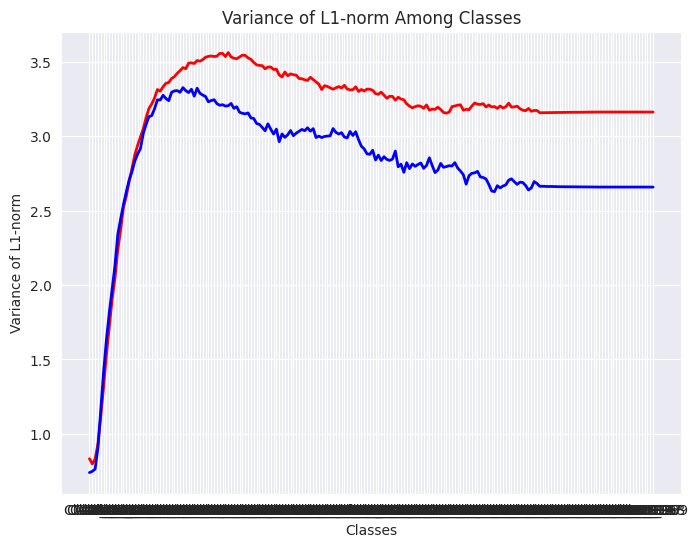

In [82]:
import matplotlib.pyplot as plt

# Assuming variance_l1_norm is the calculated variance # If you have multiple variances, create a list

plt.figure(figsize=(8, 6))
plt.plot(range(len(variance_list1)), variance_list1, color='red', linestyle='-', linewidth=2)
plt.plot(range(len(variance_list2)), variance_list2, color='blue', linestyle='-', linewidth=2)
plt.xlabel('Classes')
plt.ylabel('Variance of L1-norm')
plt.title('Variance of L1-norm Among Classes')
plt.xticks(range(len(variance_list1)), [f'Class_{i}' for i in range(len(variance_list1))])
plt.grid(True)
plt.show()